# Notebook 1: Introducción al aprendizaje por refuerzos

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2019

## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos, los cuáles son necesarios para realizar este Lab.

## Librería usada: OpenAI Gym

[OpenAI Gym](https://gym.openai.com/) (Brockman et al., 2016) es una librería de OpenAI que ofrece entornos y una interfaz estándar con la cuál probar nuestros agentes. Su objetivo es proveer benchmarks unificados para ver el desempeño de algoritmos en el entorno y así poder saber con facilidad cómo es su desempeño comparado con los demás. Parte de la siguiente sección está basada en la documentación oficial de OpenAI.

La interfaz principal de los ambientes de gym es la interfaz Env. La misma posee tres métodos principales (info. basada en la documentación oficial de Gym):


    reset(self): Reinicia el estado del entorno, a su estado inicial, devolviendo una observación de dicho estado.
    step(self, action): "Avanza" un timestep del ambiente. Devuelve: observation, reward, done, info.
    render(self): Muestra en pantalla una parte del ambiente.
    close(self): Finaliza con la instancia del agente.
    seed(self): Establece la semilla aleatoria del generador de números aleatorios del presente entorno.


Por otra parte, cada entorno posee los siguientes tres atributos principales:

    action_space: El objeto de tipo Space correspondiente al espacio de acciones válidas.
    observation_space: El objeto de tipo Space correspondiente a todos los rangos posibles de observaciones.
    reward_range: Tupla que contiene los valores mínimo y máximo de recompensa posible.

Algunas de las ejecuciones contienen videos. Para poder verlos se necesita previamente instalar la librería ffmpeg. Para hacerlo desde Linux ejecutar en consola

	sudo apt-get install ffmpeg

desde Windows descargarla desde

[https://ffmpeg.zeranoe.com/builds/]()

Ejemplo: agente CartPole

In [273]:
import gym
import time
from IPython.display import clear_output

env = gym.make('CartPole-v0')
env.reset()
for _ in range(500):
    env.render(mode='human')
    observation, reward, done, info = env.step(env.action_space.sample()) # se ejecuta una acción aleatoria
    if done:
        env.reset()
env.close()
clear_output()

Ejemplo: agente Mountain Car

In [274]:
env = gym.make('MountainCar-v0')
observation = env.reset()
for t in range(500):
    env.render(mode='human')
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        #print("Episode finished after {} timesteps".format(t+1))
        #break
        env.reset()
env.close()
clear_output()

## Ejemplo 1: The Cliff. 


![](images/cliffwalking.png)

donde S= starting point, G= goal

(imagen de Sutton y Barto, 2018)

Descripción del entorno:

Acciones:

* ^ - Arriba
* v - Abajo
* \> - Derecha
* < - Izquierda

Función de recompensa:

* $-1$ en todos los demás estados 
* $-100$ en el acantilado

Nota: caer en el acantilado devuelve al agente al estado inicial en un mismo episodio

Vemos los bloques básicos de nuestro agente

Primero, importamos:

In [291]:
import matplotlib.pyplot as plt
import itertools
import gym
import numpy as np
import math
from agents.utils.plotting import plot_reward_per_episode, plot_steps_per_episode, plot_steps_per_episode_smooth, draw_value_matrix

Definimos el método de elección de acciones. En este caso el mismo utiliza la política de exploración $\epsilon$-greedy.

**Actividades, punto 4: implementar la política de exploración softmax,** 
&nbsp;

La selección de la acción se realiza en base a:
$$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{a'}e^{Q(s,a')/\tau}}$$
Definí la función "choose_action_SM(state)". Con la expresión anterior (tipo boltzmann) se asignan las probabilidades a cada acción. El parámetro tau modifica la asignación de probabilidad de la siguiente manera: (a) si tau es un valor grande, todas las acciones tendrán probabilidades similares, aproximándose a una política e-greedy; (b) si es un valor pequeño se seleccionará la acción con mayor probabilidad.
&nbsp;

En la función run_sarsa, pasé un parámetro "c_a" para cambiar de política: c_a == 1 -> e-greedy ; c_a == 2 -> softmax. 

**Comparación de e-greedy con softmax:**
&nbsp;

- La política e-greedy desalienta la exploración. Se llega a una solución "segura", donde el agente sortea el acantilado lo más lejos posible (reduce el riesgo de caer). Evita ocupar posiciones próximas al acantilado desde donde puede caer porque rápidamente elige las vías más seguras (que van a tener mayor q). La exploración en la política e-greedy se introduce a través de un factor épsilon que, en una fracción de las acciones, habilita una selección al azar entre el conjunto de acciones posibles.
- La política softmax permite mayor exploración, pudiendo aparecer algunas soluciones más eficientes (caminos más cortos y cercanos al acantilado, con mayor recompensa acumulada por episodio). Esto es porque no elige siempre la mejor acción (maximizando q), sino que elige una acción en función de una serie de probabilidades que asigna según los valores de q. Las acciones con mayor q tendrán mayor probabilidad (no certeza) de ser elegidas. 


In [292]:
def choose_action(state):
    """
    Chooses an action according to the learning previously performed 
    using an epsilon-greedy exploration policy
    """
    q_values = [q.get((state, a), 0.0) for a in actions]
    max_q = max(q_values)

    if random_state.uniform() < epsilon:
        return random_state.choice(actions)  # a random action is selected

    count = q_values.count(max_q)

    # In case there're several state-action max values
    # we select a random one among them
    if count > 1:
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        i = q_values.index(max_q)

    return actions[i]

def choose_action_SM(state):
    
    q_particion = sum([ math.exp(q.get((state, a), 0.0)/tau) for a in actions ])
    q_prob = [ math.exp(q.get((state, a), 0.0)/tau)/q_particion for a in actions ]
    cum_sum_softmax = np.cumsum(q_prob)
    n = random_state.uniform() 
    
    for i in range(len(actions)):
        if cum_sum_softmax[i] >= n:
            action = actions[i]
            break       
    return action

Definimos el esqueleto del método learn, el cuál toma una transición y cambia el dict de los valores de Q de acuerdo a algún algoritmo.
&nbsp;

**Actividades, punto 1: implementar y ejecutar el algoritmo sarsa en "the cliff"**:
&nbsp;


La función learn_sarsa actualiza Q con la recompensa que tiene por la acción actual que ejecuta en el estado presente (SARsa), y en función de la próxima acción (elegida como la acción que maximiza Q) en el siguiente estado (sarSA) 

![](images/SARSA.png)
![](images/QLearning.png)

In [293]:
def learn_sarsa(state, action, reward, next_state, next_action):
    """
    Performs a SARSA update for a given state transition
    """
    predict = q.get((state, action),0.0)
    target = reward + gamma * q.get((next_state, next_action),0.0) 
    q[(state,action)] = predict + alpha*(target-predict)
    
    pass


Finalmente, definimos el método principal de iteraciones. 

In [294]:
def run_sarsa(c_a):
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps
     
        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
        if c_a == 1:
            action = choose_action(state)
        if c_a == 2:
            action = choose_action_SM(state)
        #action = random_state.choice(actions)
        
        while not done:
            # q-learning elegir la mejor acción
            # action = choose_action(state)
            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)
            
            #next_action = choose_action(state)
            if c_a == 1:
                next_action = choose_action(next_state)
            if c_a == 2:
                next_action = choose_action_SM(next_state)
            #next_action = random_state.choice(actions)
            
            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                learn_sarsa(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                learn_sarsa(state, action, reward, next_state, next_action)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1
   # env.close()
    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

Definidos los métodos básicos, procedemos a instanciar a nuestro agente.

In [298]:
q = {}

# definimos sus híper-parámetros básicos

alpha = 1
gamma = 1
epsilon = 0.1
tau = 25

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

Ya instanciado, ejecutamos nuestro agente

In [299]:
#1 greedy, 2: Softmax
avg_steps_per_episode, timesteps_ep, reward_ep = run_sarsa(1)


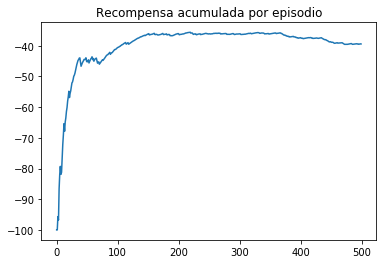

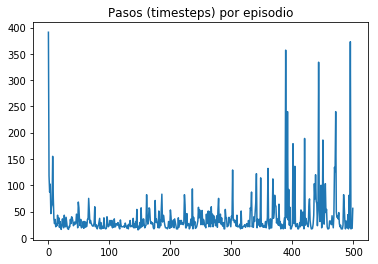

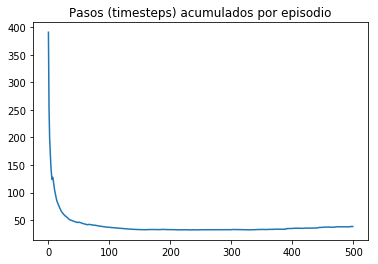

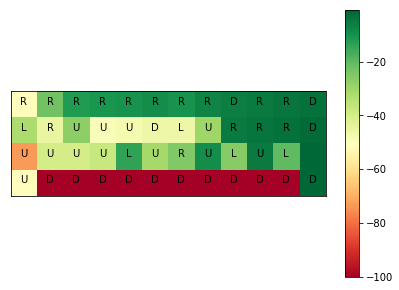


 Matriz de mejor acción-valor (en números): 

 [[ -51.  -23.  -12.  -11.  -10.   -9.  -10.   -7.   -6.   -5.   -4.   -3.]
 [ -32.  -45.  -27.  -49.  -48.  -46.  -46.  -30.   -5.   -4.   -3.   -2.]
 [ -73.  -40.  -40.  -37.  -14.  -31.  -25.   -9.  -26.   -5.  -20.   -1.]
 [ -51. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


In [300]:
plot_reward_per_episode(reward_ep)
plot_steps_per_episode(timesteps_ep)
plot_steps_per_episode_smooth(timesteps_ep)

draw_value_matrix(q)

env.close()

### Análisis de la ejecución del agente

#### Análisis de convergencia

A diferencia de lo que sucede en el aprendizaje supervisado, en el aprendizaje por refuerzos el rendimiento se evalúa por una función específica que es la función de recompensa. En la práctica, la función de recompensa puede ser externa (y provista por el entorno) o bien puede ser una función creada por diseño (a modo de dirigir el agente hacia lo que por diseño se considera mejor, en nuestro ejemplo podría ser con una recompensa de $+1$ cada vez que el agente llega al estado objetivo). Esto se conoce como *reward shaping*, y hay que tener mucho cuidado con los posibles efectos secundarios de su uso.

Como el objetivo de RL es maximizar la recompensa obtenida, es posible utilizar la información sobre la obtención de la recompensas en cada time-step o episodio para evaluar el rendimiento parcial del agente (esto depende mucho de la particularidad de la distribución de la recompensa para el problema tratado).

Para analizar la ejecución del agente, vamos a ver cómo se desempeñó el mismo en dos curvas:

* Recompensa obtenida en cada episodio: nos dirá cuánta recompensa obtuvo el agente sumando cada una de recompensas individuales de cada episodio. Con esta medida podremos tener una noción de cómo se desempeñó esquivando el acantilado y llegando lo antes posible a la meta.

* Pasos transcurridos en cada episodio: indicará cuántos pasos le ha llevado al agente la ejecución del episodio.

Se estila suavizar ambas curvas para apreciar mejor su progresión (aunque a veces suele analizarse la curva de pasos por episodio sin suavizar).

#### Análisis de matriz de acción-valor y política óptima

Siendo que este es un ejemplo tabular y de pocos estados / acciones, es posible realizar un análisis de convergencia desde otro punto de vista: desde el valor de la función $Q(s,a)$ para la mejor acción de cada estado, al finalizar el entrenamiento del agente, (sería la acción que el agente ejecutaría en cada estado bajo una política *greedy*). Ambos nos brindarán información sobre la convergencia alcanzada por el agente.

Tener en cuenta que este análisis se hace principalmente con fines educativos, para entornos más complejos el mismo puede no ser factible. En tales casos, un análisis alternativo podría consistir en hacer que el agente ejecute su política para la que fue entrenado, para hacer una evaluación a partir del comportamiento del mismo (esto último sería el *test de la política*, frente al *entrenamiento de la política* previo).

## Actividades

1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".

2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.

3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

4. (Opcional) Implementar política de exploración Softmax, dada por $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{a'}e^{Q(s,a')/\tau}}$$



Para dejar el lab listo para su corrección, dejar link a repo de github con un notebook ejecutando el agente en la planilla enviada en Slack.

**Actividades punto 2: Implementar y ejecutar el algoritmo Q-learning"**
&nbsp;



Función learn q: se actualiza la matriz Q con información sobre la recompensa asociada a una acción dado un estado, y la máxima recompensa futura dada esa misma acción. A diferencia de SARSA optimiza no solo la recompensa presente sino la que puede obtener en el futuro. Realiza la selección de la acción y el aprendizaje en base a informaciones distintas (por eso es off policy). 
&nbsp;

- una diferencia es que q-learning encuentra la solución más eficiente (más corta en pasos), porque recorre el acantilado justo por encima. En SARSA el agente huye de esas posiciones hacia arriba, buscando posiciones seguras, porque evita el riesgo de caerse. Aprende de las acciones que toma, entonces penaliza el estar cerca del acantilado. Q-learning puede aprender de la ventaja de poder hacer un camino corto hasta la salida, sin penalizar esas posiciones por el hecho de caerse más seguido al acantilado mientras aprende.
- q-learning converge rápidamente a un número muy pequeño de pasos (para hacer el recorrido). Menor que el nro de pasos de la solución a la que llega SARSA.



In [255]:
def learn_q(state, action, reward, next_state): #, next_action):
    """
    actualiza Q
    """
    predict = q.get((state, action),0.0)
    q_values = [q.get((next_state, a), 0.0) for a in actions]
    max_q = max(q_values)
    target = reward + gamma * max_q 
    
    q[(state,action)] = predict + alpha*(target-predict)
    
    pass

In [256]:
def run_q(c_a):
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps
     
        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
      
        #action = random_state.choice(actions)
        
        while not done:
            # q-learning elegir la mejor acción
            
            if c_a == 1:
                action = choose_action(state)
            if c_a == 2:
                action = choose_action_SM(state)
            #action = choose_action(state)
            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)        
            episode_reward += reward
            # actualizar q y elegir la next_action
            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                learn_q(state, action, reward, next_state)#, next_action)
                state = next_state
                #action = next_action
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                learn_q(state, action, reward, next_state) #, next_action)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1
   # env.close()
    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

In [316]:
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.3
gamma = 1
epsilon = 0.1
tau = 25

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [317]:
#1:greedy, 2:Soft
avg_steps_per_episode, timesteps_ep, reward_ep = run_q(1)

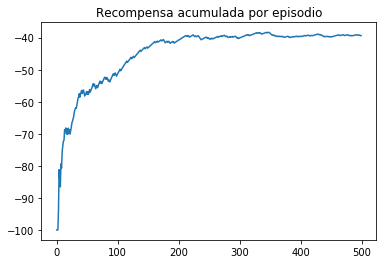

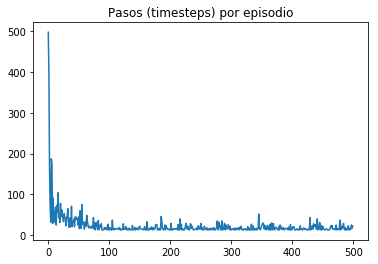

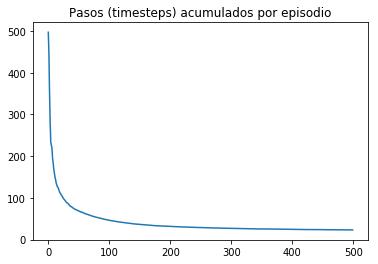

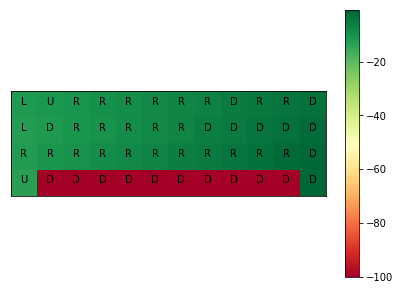


 Matriz de mejor acción-valor (en números): 

 [[ -11.69879019  -11.24338575  -10.56662803   -9.79198069   -8.9837211
    -8.22157957   -7.33788143   -6.47321493   -5.61276312   -4.77607944
    -3.89285286   -2.98094727]
 [ -12.27477734  -11.69784429  -10.85902113   -9.94699081   -8.97322411
    -7.9861687    -6.99572768   -5.99881844   -4.99959438   -3.99988776
    -2.99997825   -2.        ]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [318]:
plot_reward_per_episode(reward_ep)
plot_steps_per_episode(timesteps_ep)
plot_steps_per_episode_smooth(timesteps_ep)

draw_value_matrix(q)
env.close()

**Actividades punto 3: Análisis de la convergencia en función de los hiperparámetros"**
&nbsp;

**alfa:**
&nbsp;

- alfa (tasa de aprendizaje): es la tasa a la que se actualizan los valores de Q. Valores en [0:1]. Si el valor de alfa es más próximo a 1 la convergencia es más rápida.
En la figura están los resultados con alpha 1 y alpha 0.1 donde se ven las distintas velocidades de convergencia. 
&nbsp;



<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAxoAAAQfCAYAAAHjLa/5AAAACXBIWXMAAA7EAAAOxAGVKw4bAAHS
cUlEQVR4nOydBWDU5hfA31ndaYsWChR3d3dnDB82ZMCEMRgMBgyGb/wHDLcxBmM4jA13HVrcvTi0
1L29yz/vSsq1l9xdrud9vxKSS/IlL9/L+9735TM5wzBA2A5yawtAZIUUYmMIKqRP+eAzf57f1CLC
pVZ6gEySpHz7d94nvp2SiskhDo9LPLtHMXGbfS0nqngmhia1mlHda9+tacW/Tv7m9sbOFRv8F/bw
VAh3XCIJVDLMW5k1ZcyOoEL+vPGkDq792YX1MxLcLqZx3NaVgUyv5rp/OpMm4X5rKgOxNWUgggpR
RZ7yi/KrH5+UCk5BARVeMi8XF4qNjPTdPPPXEYOXHh0tkUgYTlG2io9EkhYZc8lfKotjUHbvwl88
UsBLSRprHCg7PsOSqWvHDJ/U93/WlpVDWCGp8U4K9iUKdJbE9feDuyBxVg2406zxyeUffTl4KYzm
lGHLikkGkP45asiUwjMXL1twp1ltgLfS1NhDPuX6n1+Px1HulnLJm8GT+s5ln1VlbXkRQYXI87V+
7cWule8j+4v8kqvbXzGVQMX8oXle122vh93b+Hnnkj2X/G1eUcWTzDCZSVLjFnC39a4IZ/D0jrm5
vVl7bn+QL7xDZUya3PSnaT8e+c46kn5AUCG1JJKocwlngySlNt6e5Dz/Ke5TsgbRbnfMkH3tvFdw
5239acewLeeWVLGEsGKR+FSPgZhQr9T7v4YczfOVEvcpJBJVGpPOKkqmLoBNnN5oJiSc9Dq241Jr
+BFsVyHnGEbttJlntYIA5mXu11SG+vi5YTapDISJvujNbbfEhZVdFXV+M6TcdL0JFV3KOUNk0aHH
/sTjJ69FV7KaoBoIKmRFdcm/Q0Oh/TcXE9vNrea6p3jx4g9ZiuOxrwpKrix8wVS2mJRGUmHuw1k3
RoeMY5g41iI8VOjvXv/dv01Aq3nH+v3+9KvQ4YV/tLaM2RFUyGcXmQ6fafzmlIHYgzKQ66OKj4dR
zHjut2bmI3S4r80pA6GSuo1BCrExhBWS+swZ0h45P5Q3kqz7pNqiKZuPDACptxLTYVmeClHKd9d9
ucIVgDObHCSzm4XYXPJzmURSkF2/kGmWUdLuzymhKDHmvsWejEUS2DgCwo/nYRLOeg4bs3LO8iXb
h25on/pHm3/jP2s0/frsq5MqjkL5hnw979dVC2Z+yTDhMs+iNZ8d6fDit74P2ja8s2dl0yJFioQ9
PjO5rrTAwBcSSXB6Y0lY9FEV428umYUVwiglIHFROUkBHr2IKMTuyDykjI9w57Zb5oeHB14p3n9V
eSOVeJWKxwKY+hLvldFh7MZfj2zd/1Hi47FBlixEMm+P+UskCgbcasUvW1xr+LLFq4Zzx65MrDAa
JjKjcXvlr998jQtuxz0+H4TrO+/PCwsLK5J5PeaJ2VMU4Rs4B7MF3WBA6daeCWvyQaisEbr/JRPy
4Vgab2T/+3PPrwEXKyAkk61ikz7kjz/+6M+i/iLg4eERz+JhbZkshVEKCQ4OftKpU6edGHGvX7/O
5+Likoz7nz17FtS3b991Cxcu/Kp8+fI30IcolUpZ3rx538yePXscLiyz+/Xrt/bt27eBBw8ebIFJ
wrp16/r26tVrw/Xr1yvs3r273bJly4a9e/cuT7t27XYnJCS443ksB0376B9o1KjR8XPnztXKnz//
q3r16p2eN2/eNwEBAeEoC8owcuTI+Swj8dz09HQ5S/qff/7ZZ/ny5UM3bdrUo0CBAi/T0tIULGma
1z116lT9MmXK3M6TJ8+7K1euVGa5ok8WQYVUr16duXjxIu+xJ0+e4GrEr7/+iuskbn9QUBAcO3YM
N69x+2QyGURERODmysGDB6vXuBQqVAg+/fRT9TlTpkzB1QSNW6jPOXv2LPf7gI5n4E2SKlaseI2l
oo5wmRw/frwR335UBq45ZSCoDFz36dPnT1y4/dmVgdSvX/8Ut22IMtTXN+Qke0RDGfbSaED9Ymkp
RN/n9PKT98ONH1uhc8dz1fsa/HwETo5tqnVu9emHICVNCdfZ8zm2X3oOXaoWEpRqx+Xn8FGVQvDg
bRyEBHqq96WkK8FZbnN1SQaD8p97FAk1i/rB44gEKJPfS/BcLYUIKePmyxhot+AUPJndTv2bUwbC
pwzk4sTmWvt0KQNBZSCcMhB7UUa6UgVymRSCx+3OjCcE5W9YMkC9rUsZiMFJ1tR/b2W5SW4HI/3R
zLYglX54MVEZSE7iyWCFbBpax+ibOCLmejl5FYJZVbPczY55F58CeTyczX4fXoWwWVWl2e9sJ3D+
wBLKQBw225sTNHOQlvabBinkk1VnYf3g2uaWxWRMnjz5R5bJxoStM+swnBnfzNQiGQyvQs6cOZPF
gzu9zz3YC8YoQ6Vi1DkmayoD4VVInTp1zmj+/v3TmpaRxopoZl+tid4kK3shhzAvDunU8UNeUlKS
6927d0vpO/fik0ioHuxnCbEMQkshQUFBzzZv3tzdGsKYCvzUbch5RcfvhsezbMv6tRSCdRrWEMQa
2JoyEIdMsgyh+Pd74OHMttYWQ4tcqxBbVAaipZCCBQu+2LlzZ6fw8HBryGMSPjRP4mfMlqswp5tN
NOXVQkshL168KIjrgIAAy0tjInQpA7FVZSB6k6w87k6WkMNi2Hq5Sr9CPBxLIbasDCSLQrDpTrdu
3bbgmvMhedwt89nZlKAPxGZK1atXv6jZcsbWrQPJopAbN26U57ZnzZqlXtujhaAycM0qozq8b3WC
yjg+prE1xTIIvUmWv4UqZsyNrVsGh16F+DmYU7d1MhWCfsPf3z8Cu6799ttvg7j9I5qVsI5kRrJl
y5Zu48ePnzV48OBV2GzV2vKIJVMhmv7DnsFMCS7WlsNYBJMs1iHaRo1NzrGr59DrQzR732YHk7ZL
ly5VXbx48Rd8x5s1a3YYW7ljq/bsx7Ax9IULF2o4OzunCN0b33RMgrLvf/ToUbFWrVrt37BhQy/M
2up7Bky+WAbzHcOkWlfqEBsb64XthDUbTmdHKI6OHTvWmOWYUDgfH59oFh/NfXoVIqQMZNCgQb/h
InT88OHDghXUhrRM51MGUqxYsUf379832LkJKQPRl1R7eXnF6lIGIhRHupSBZFcGkmu/9toqpBAb
gxRiY5BCbAxSiI1BCrExSCE2hiiFYP4f69xPnjzZAH9PmDBhBssEX1/fKCzkfPTRRzuwoIX9yidN
mjQtJibGG7saq1QqKfZSDQ0NrYZdpDWvuWbNmgEsa/ju16NHj03Y7Ri3Q0JCHrCE8J0nFlt+DlEK
wRKy5m98CFxHRUVlGaEUbzhixIgFuP3q1av8uq4p9BAI9xDcNcXIqgtbfg5dCjG6OzH7FhgbVBTV
q1cPfV8JpQu7eg6dFmIPVZ5C1KpV6xyOzoDb9vQcDuvUOWXYG1oKKVWq1F1DWo0T5kFLIaQM6+Kw
SZa94nAKEVt5ZWs4nELEVl7ZGpkK2bVrV3uWXbqqbAnzk6kQVAauSRnWRWeS5aKwr/7pCLbJYhmP
bcxYzDacq7nQqRAPZ/tzMagMXNujMhCHU4i9kxnj2CynS5cu2w8cONAScyq4L8jPzXqSmZDPG9uP
W8xUCDZcy/5puKi/u3YIO0HTh4xtXdra4hiMzjSpSB77VYhD+pDgPI6RZNkTOr/2NiuT1/IS5XIc
7msvDg3StGnTI1htWrVq1UvcfnuppHK4fC0OnsP3LcselIE4nEJ0oVQxILORgcqEyFUKQWW0mHsc
Do7iHXvfJsiiEK6pC7ZB4vY9j0qEQr6Ok9tCZdx4EQPlC3rrP9kKZFGIpiI47FEZ3DwlQsc5ZeBw
sMuOP4LhNlSSNyjJ0hzH1h4wtPctPlN2ZfRccQaKB3jAjI+0euFZBIMUkl0ZozZfge2XXkCpvJ7Q
sKQ/1Avxh4YlAmxmZM+csPEzw8a4fxaZCL+degybLjyDpDQllCvgBR9VKaieBaFkXk/9FxBASyH6
zB2Z272yesnN4IfXKR3LqRdToqUQDWVI3g/eoq+pptUQmpIpG3b1HDqTLH0PMXTo0OU4MRbfMX0N
7nD07Nq1a5/lG2wMR4Q7e/Zs7ewDOnNgbpAvAyKEPT1HjsohQg+B6PsEIyQkgg+n67gYZRiCLT1H
rioY2gOkEBvDbhUi/aKOOs1WLT5jl3ltIfntViEu3i7WFiFHCMlvtwpx9rTvke6E5LdbhZCF2BgB
djg4pyZC8tuvQtwV1hYhRwjJb7cKyWfng3Nml3/OnDljWObYrUIC3exWdDXZ5Udl4Npun8rf1f5a
5msiJL/dKsTPxb4VIiS/lkJci/oxxSZ/GCoxKf3DLKzJ6arMbZXGdnaUqUre85RpSqPO0zyWOveU
umSbx4X/XSqwrHPmV1dGlfUDrOZ1NI9p7lepVFnGflAJPLOm7OpjSv7zNLddYpVJcavPuumSX9BC
0mOSQf4+r/xm2TnIO0x/P/y3Y/dB4M+t9Z6nik8BqZ4hzFPmnwbnkfUyf6ctOQuKzz/MNurjLFzX
r0pKA6krfy4m6cJzcK2RMWc7KkXyvpYzbv0V8PykMr8sl1+Cc5UCGdtHH4Fzk2K852miWe3NvI4D
Sb6stYhC8gsqRK5RcDFEGYghykD0KQPRVAaiqQzEy8lV+PoCykA4ZSASjSpnIWWoZXmvDPW2AcpQ
X1uj2ju7MhAh+e3Wh/g4f2iZr2/sXVtEU35s9ootLuvWrfufQQp5NfcU5B9VX+c5mKYm7LsH7q1L
qtNNLlnS9Ada6S57XvJfV8Cld+Us5+H+tEVnQPFlncxwqnPPQFrrw4x+HooP7ao0lSFl38y3s49B
4LjGoMrmN9Ei4nbdBs/2ZbT8S/YkK/1FLMgLeqnPS7v+GhQV8qm3U449BufGRbWeH48p70WArKS/
ln9i3sSDJK9HFn+iKT+Op8VtG6QQfcrgQGVwGJIsIagMPjhlZF6vVtbpFd0Vwg3dUBlCoDJ492dL
slAZmbKwyuDgUwYHKoMPVEZ2hOS32yTLQ+FjbRFyhJD8WgpRsbkDQ7K6fMlP5jGBZCp7Vjl7MiV4
baX2GGQKLpuZLVlykn1wpsnpwmOXaSYrWbbZMJhD4pPL0Kx5lmdWat5Hv/wmtZCUSy/AuWpBrf3x
s46Dx3j+Bs5p22+CoosRbZuSYjPWPBkqVSKb7XX7cECVzP52yfgdu+0GeH2s7f/j/roKnr0/TKeX
fPgBuDTTHlEu9cRjcGrIn2ylH3oA8uY8o9C9iWOzqtlyWgLym1QhfMpAhJShlscYZbAwiVHqtcRL
+5imMtS/XT785lMGoqkMhE8ZiJAyEF5lIDwtGYXk11II5lJc5bLM39OH3BQUwFJ8MsxXe2dCDO+5
diE7oiE/tt+aOnXqD5MnT/5R0EKiTz0Bn/rB6u23kAqBoP9z91B4AMtB/8CRbCoNkvfzrAhdeyDc
h9Wg0RHq91CAT6t9+B0bL3j9B+P3QcisD4VUzfv9CE9hMhTWCrMIXsKX8KEAeAJioCFk5ITiIR08
3r+72yACPoYPuSnNax+GKGgGPAp4y8oamC2npSE/tt9CZeC2oEI4ZSCGKAMxRBlqATQmvRG6dhZl
IJrKYGFi4t5fSxtNZWS/H58yEE1lIJwyEA+NaNJURvZr8yoDya4MEJZfSyEe8bII10WPw7jfc6sZ
35LbVFS7kK69MzqO91xW9lBu29ZkT01N/fD2CcivpZDw8HC7mJVYGZGoXmf/iG3Ljao1EZLfbguG
qshka4uQI4Tkt1uFKCOSrC1CjtCUH8eY79Onz59///13Z7tVSMr7B7K/HpAZaMrv4eERj8rA33ar
kOQo+06yhOS3W4UkvbPvJEtIfrtVSEJkqrVFyBFC8tutQmL5s/F2g5D8dquQmBijpwWxCYTkt1uF
RPN8W9Q1562tkV1+HBodq3LtViG9mbtan7HsRRlIdvl79eq1Add2qxBHhRRiY5BCbAxSiI1BCrEx
SCE2hlyzDRJhXcg6bAhShg0hqIyr3xcbW2nihiWSkHV3V4QsPzvkRHxXAGe7StMkFeffhOvflGUS
znpKWtw/Cv/1rY7tnvDYlWTwr+wCERLP7lFM3GaBJiKWRVAZlWY++hkSz3kwLxcVxFZK9ghzbWQ5
iWQMA2614pnTtWoA9Mk8hopQn2MjikAEldFszNbFYSu69XwYW8BHAS8l0zqGbIj96r/t146drftn
zfkHfeYMnRr34/bRHk03nrSkwGLAxmYS37KxP3UqsR5ln/lx09+ZmOte3DG0EruwDKlUqXoY680K
+VaSGnvIBzybxUgk/spt/bwXek9/uI/pCPskkh7s82y06WGQjt7aX71RvkL3Ufb+fu/uQ/J9V0mp
mfe45Arit/hYV8IPCCrj4E89vgJcWJb2bbF4+LpmXzBMhCzrWRkNlW3p7dIkM8LV2x9kZ8J+z+zh
c+d/VYZZWi4hhHNTqc+dn0kLKeYtvTwk5dCh+qpX6wvImoUdhdsTSnIP2WnLs88nTZo+zWLSikRS
YfIdtxtTQ4aM/GLRneYzbh1o77N8eD64NvIp07CEAtQ1DqW/vbyMGQ3LmzRpffTo0X1NrCmvsDKc
CqWwr0/K3K+qzIOvmHm4i7kFpQC+zzzl7655l0LXiTBtGkwyv6jiYa7/WBqbTn/YwayQ+ZWOWeIk
ieZeKG5tbUUgwspQRsivpft7VXKRvIs7OqR+/T+6fv5oTasesQxjN2UTiaRkWhPJ/egdKqaAj0SS
ihEf9e6Ov5cE0qwtGx/CESvzT68og8jMfHljOA2/M59YTDITwDD3FB+2M57DVhWB2M1bnhsgZdgQ
wkNk+FeMnFJfuXfSznu9Gwya9+fJ377t4w0p6dEpTz3AKSgl80RVjAyk3uruo/ue7azc7lPpItXR
QbWjd1RojwVDODWzcnG4mnbz2qSa2/L+qOodKLltgedSU3n69V/iJlUc9jD5WsBTWQVpEUVATJvS
adf3vqtcCMKP58Gk6+CMT79uOXHnPIaJlELiGU+JO5tNT9jsW2Nl4Ni3c5v2CwsLK9KkQvHLs889
bF27+BeXmVeLC+i/s3EIKkMZH+GukHir+99Gv3kawJYpmGRIkQKjZNNepYQBGfbgYTSHv2kd1OmK
KmWT09PFQZ96dzysLhhO7Dx9w/RtEX1Blie9t7meQoArEyuMholsxpUF+z4xTLgs+zktJvz+KzMB
flX/cKsTxzDP1HFy4Ws2h/h1mDqXePT6wyq4NqciEEFlMMkv1UMpfAfQN2PPz1mOZ5ampD5ZOlwz
J3vUBOiR+Xv639d6mULQ3IBN+4wp77G2HJbCKGVgdzXs5xYXF+dZunTpO7gvMTHRTSqVqjZu3NgT
fw8YMGDNixcvCubJk+edq6trUv/+/f+oWbPm+c8//3wJHr9161ZZlltz584dhT1H8VoPHz4sXqVK
lcuxsbFeOLINHsO5aBctWvSl6R75A5GRkX4+Pj7RefPmfYN9K/CZVq5cOSQkJORB8eLFH3p6esbt
3Lmz0549e9rOmzfvm5iYGO+oqCjfY8eONcb5UeRyefqFCxdqnD59ul7Hjh3/wd9JSUmuTk5Oqf36
9Vvbtm3bPd27d9/s7Oycol8a3coQrLsICNDuOujmltHdhVUCt+v3ggUzOv+/r9rt/35ZjD9YRaiP
jRo1Sr3gaWwEAKsI9XaPHj1wZBvc/uL9IoTRHyr9/Pwicc31hcTWihiB3HF8wXDdokWLg7j29vaO
wQVfNFy487p27bqV23Z3d0/ANTbnFCuPTSdTJkBUZdjgweqWoyvNI4pO1C+UljJGjBixgGVE9v3c
vK9i5n8tOXEv3Jvehvc6Qkz99xY8jUyAVf1rqH+npqvASW7fg1PiM5cI9NA7+aSWMvgUgWCk3noZ
KxiRb2OTIdDLBS49jYKqhX0zw2RHnyJ/6FA2y297UUSaUgXnHkWCh4scKgf5ZDlm6MtrcDKFkVK2
AM9oLO9BRSCcIhydhJR0GL/9OizopS6CgEImhfolcjbvvaP7DJPTev4J2DeyIbg7yzMVYSq0lFGp
UqWrLFnGEdp/8zW0Kpcv+6m5BkzzD7HpfQib7qMizIWWMrIrAhm6LtRu5gk3JQN+Pw9rPq1psWc3
KJnab8a3wRap/9MReMNmSO7PaGvR+xqkjFI8A/M6Mqe+a2qV+2opY9asWeNZZllDGGsipvxkLrSU
kRsV0WHhKasrAtGbTNnCG2NO9t14Df9+ZdhgzeZGrzL87XzyK320Lm87WXa9PqNfnWCLCmQpNKdy
sBX0+oy2FfJbThoLYmuKQPQmUyE8o1gS5iFXfpsKDYuCakVs74OmljJOnTpVn+WUNYSxFLaoCERL
GY6uiPmH7sHI5iX1n2gFcl0yZauKQHKVMnosPwObhtbRf6KVyKIMbJaCTWZwfFZrCWROJrUvq/8k
K5JFGZ06ddppLUEsQfmCwvNB2QK5Jpmyh29suUIZT98l2rwikExl4ESHjRo1Or548WJdrffsktCn
kVA4j+0P8J2pDHubcVIMH1UppP8kG0BXMmV7X9LEk+NnqF69+kVLzethtM/AYUHfvn0bePjw4WZ8
xytXrnyFpbJQ+EePHhVr2bLlgQcPHvDOM9StW7ctLN34js2YMWPC999/PxOHnDBE1i+//HKRsS3Z
URG4oFKyH/vuu+9+2r17dztjUpWqVateevz4cVFs1c7tM1oZ+lpZ61IEUqxYsUdCikCEFIFMmDBh
hl4BNchplwI+RSA//fTTd7gYc81Lly5Vzb4vV+Sm7AVShg1ByrAhSBk2BCnDhiBl2BCkDBtClDKw
GzD27AwNDa2GhZ3Nmzd3X7NmzQCco+78+fM1mzZteuTmzZvlgoKCnmE3ZC7cxIkTp2MvUZyMBMN+
/PHH20qVKnUXh4sYOXLk/H/++afj/v37W6WlpSm8vLxisZcpnocFyzt37pTGOhZTPrStPocoZfj7
+0dgH2jud8OGDU9wBSrs440Pwxdu+vTpE7nt5s2bH8L+1JrHP/nkk/V84bCPtRj5DMVWn0NIGfYy
fq2+b0929RwO5zNwlINDhw411+xcby84nDJwqAh7VASSRRlDhw5dzjLUWsLkdrIogxRhXRwumbJn
HE4ZYiuebAmHU4bYiidbIlMZ7du334XVgFjytKZAuZlMZezatau9NQUhHDCZcnNzS2zQoMFJ/EZk
bVnE4nDK4Iays0ccThn2TKYypk6d+sPYsWN/dnFxSbamQOZgxu5bMKGdbXcHQDKV8cMPP0y1piCm
AhuHBQQEhGv6jJUnH9uXMhwFvsZhgZ7O1hBFNA6nDD7OT2hubREMIlMZ2GspX758r+ljofXIVAb2
57OmIKbi119//RrH5qVvUzbA119//SvffnsY9FKnMr7ZdAXm9ahsIVHMi60rAtGpjIh4gwa3J0xE
FmVgnwts48P9XjeoluUlsgD/Xn0JHSqZdZIYo8iiDE1FcJx99A5qF8tjOYlMQJs2bfayaA/E/h5O
EbbWHVmvA0dF/Hk2DPrULmIJeUyCLkVokl0RD97GQfO5J+ACWy4JsEJB0aDclKYiQsMiofvys6BU
MaxTzAv1Q/yhfokAKOrvbjYhLUVIoKfBlrLzygtYeyZMPXaVVALQpWohaFk2LzQsGQAuCq15tgxC
dNa2WhE/eDjTsiMh2yKdKhdUL6ZESBlW7XZswu6+dvUcOSr0YQtsllJij507d66WSqWS1qlT50z2
Y8+fPy+0cOHCr9Sz2FuoFG0rz5EjZQgJqe9YrVq1zgkdK1So0HNcciKXWGzlORzuc4g9Q8qwIexW
GdIv6jBVz6WFWmpcD1MiKerLSNqWBtXiM1kyGHarDBdvnHDLZudZ14lULgVnbxet/XarDGd1CTnO
2mIYhZQtFDrzlPDtVhkuPG+WvYCWwSe/3SojwI6nknCWy3jlt19luCsgxtpCGImzTKKWPzt2q4x8
7k72qww2mUL5OXBsLexzbrfKCHSTw11rC2EkTqxloPwcOOocru1WGf6u9jEBLx/OUn757VYZfi72
qwyclJdPfi1llFvTLfMLY1K6MnN/croqy3mqbL85lKlKwfOUaUre87JfS/M8zWOpc09llljzuPC/
RwWWdc6Un1F9+FiqeR3N/dmPqZQq3v1az6Ipv4Fh0uafVsvvJOOXP0eWEf3bRfAZpP9rRNSUQ+A7
RbuJZfys4+Ax/sOE5Ux8KkgMzLL6OAt3w3gz4SDkndEi45psxEukGTqMnHcK/L7hnwYu6b8wcK2b
UaOZEvoCnKvxVxwpIxJA9r5WM/3hO5AXz2gfoLz9FmRlAg2SXSGR8cqfI2UYogiETxGIpiIQQxWB
eDm5Ch7jFKG+pvTD5x8hRSCcIhAhRSAyjeplThHq/QYqAlFIZbzy263P8HHOiBQc3Wbbtm0f49BD
VhbJYOQyWab8OOy5UqmUrV+//hO9ynjy5T8QvKgj7zFVXApIPZ31pv/Jhx+CS7PiWuclzjkBbmMa
ZvER3LH0rTdA3rW8lg/i8FBkjC6Eg7Zo7pdKJBC77y54tS4FKg0fiRYS+ctJ8BvdQMtnIAl77oB7
29LqbS6Zyn4e/k5/HAXyohnjAjOs3BKFTL0/be9dULQpxeuPVK/iQJr/w1BTcokiU37NAYr1Tycq
oAj1gxvYnAUVwQcqQghUhC7cFcJzYaAi+EBFCF7vvSIQXckUpwhEotEKBBUhhKYi1NeQKnjlt9tk
ykPhY20RjEamtgwfrf1ayhDKzmolPwJJU/Ykx5DzdF5byV+Xr1DyZ62xdPtBfv6wOJWo5rBgQllg
nVlbAfm1svY88kvZ+6vlz1bUEG0ZSeefgWvNIHFhNlwF116VtPanzD8NziPriRXh/UVjBQ/FnnwC
Xg2CtfZzPoNDGZMMsvefspOOPgTXJhnJaeqll+BUlb8tbsrhB+DcTHsI9/T990HeqkTmb+ZZNEiC
fDJ+/HMboGOZDycr0zPkz/atULQyxCpCHYZHEYjRimBhEqMEj/EpAsnuM2QadQqcIhAhRSB8ikA0
FYFkKgLRVAQLo0xTyy/xynaN7Bd1lX9wStOH3BQUylJ8MkxgtsmEDzlZnD0NB2XEZjV2IT+rDE35
a9eufZaltl7LGAj3YTVomB/7JxHZUG8oPIDloP1G6br2W0iFQNBRCIyNz9z8888/+2geerPlOuTt
VkEryFNIgcLwIQd4ExKgHGTk92MgDbyzpxssmyAcekBA5u+t7O+uGr85lsNr9jk/dMjJEk/oH2Qa
DgL9jYb8qAhc61WGZmQhYhWRISi/aeu6tk5FsDAxwvXffIpANBWBcIpA+BSB9MgW8XyKQDQVgWSJ
J1k2T52eppY/e0xqJ1OLHody23OrmXRsX6OodiGd/0A0vzLsQv60dF75tZRhL+2QlBGJvPvtQX6G
zf6i/Nk/otttoU8VacdDnKSqeOW3W2UoI5Iyt7Gnkq+vbxTmSqwoksFkWMYH+f/+++/OLH/brTJS
NB4G+/BZURTRqFhloPxcjQYqAtd2q4zkKPtNptRfsnnkt1tlJL1Dy7DPhmxK1mdkyJ8Vu1VGQmQq
gIv9KkMtfzbsVhmxmE230+a26gI4TzHJbpURE8OAQGHY5mEL4BnyZ8NulRHNU+OdkzlcLYm6AK4h
P44eh3Pd2q0yejN3Jb2z7bMHRSChTHyWz1I4riIudqsMR4SUYUOQMmwIUoYNQcqwIUgZNoRc3YaI
IAgtKKUiCAGMN47Ecx7gViuzCZBEomCdUJrO1jz3Nn7eudSQiN+ZuM0C7dMIsWSJ92w6EQ7jxHTd
9mzYli55l5NOhBFtHDjW2z/dfZZ0+H3fd6iMZ061oHDRb27jsWfLqvWNePSuUJXZF+dcTvX3qeIC
EZphS/Zc8jcM6f67qYTPvSRLbqe6eJctOfYK/kKdnPqywLR6P23/Wf273M93QJkmhbsTS+D4fNlD
d9ry7POtP+0YNulyRKFp05ZMIp3wI9o4skc2tk9nns1jV/MyfyPZDSMzPKVQJsCFKeME0cyTn4MB
ftY6ytwc+75L1gTe0H93zbsUug5bmnk+6YQX0cYhZVMpFZMkjQEXuY9EkgpFv38Cj38O7u+XfnfN
k0O1QOahRNfe5WBc/x0ti66unDf+5ZU3KYXQqOKPfVav0qDDaz0bLj175feWn8Qf6dnAo+nGk+Z4
MEdnXywUbuMtCTs2q9uIxuO3LGASznpqxjtAjDRTJ26VEiTygLSryUyeis4QWbx48Yd4jYcPH6r7
qEg8u0eRgWgj2jhU7z2HN0DaBy+iPfXw9haefwAT8YfmPo/GK04/fAiZnYbIMIyntRc85eKfGQcL
uf188a4+R8Pjc0aReYwMgxfRxlFbIok6Hba8ksy/UmSES630gEJfPoR3j7yXflv5p+urZ3XFcxZe
Xt9ala/3G0XIpPvORUu8SjnUvx5f3vdKMvhXcQ18wzBv1R3CKAUznFU3ntYfUqHOcYBX0oRTA2u7
VfzkTrfxJ37esmjy0Na7Yz7Dc/Z36Lgg4VTphmM+XrFy8avUyg/SFJ4hCsjSXVWdE4jZ6wderdU9
J8mbf0C0cZxlmIyXly2M+0shmXm56MMwAzNmTuM2sYMI82Da+xSqH++1KrPlEs4wEDIMwxlcvvCp
wcwLGX6tcqu3Sj1W+5ZFTdRzL+5r571CfZLquHq9+NVydTfk7IahPiVbokWG8QGjvlateaUsPyB/
7RvoDUaFJrWdV91tN27H/NOstU+nI3uh/qYLzMnuNV+lg1sBRfVogHTWrV+xzwbMtojyjcK99teX
Ey9uKoc/m0gkEUeZxIAYcJVjdrdIkSJhuD8sLEw9pNOFcSHjq434fm2zVjN2Hb3+sIo1RbcnRBtH
3MVZlTdF3/Uu+9HM3ZIinz5TPF2T6Tm8Ox7exzBcf9s0SQGFUwKAJzOhU/CmDmM3/vrvzz2/Np3o
uRhZ3rSECxvLA2zMstv7/dDxnFFw1Jj9YBauj14fSIYhAtHG4VFt3NVB7HrQ9jLtM/YIfSLHyint
cgZB2AvUfIQgBCDjcBR0Nh1JknDlEbPdP+Wam8SlUsKNZCZPr0LyG6ffphc5N+PjLzcEToLfPqs8
z2z3NSNGFchxzVU6SSTl2Qi/K28XzNze/SRvKYCXUsxOTb2V2rhmIadHWFHFhWWYdKlEIlfFqhgn
T0mGojKv9z7MD2WdjmXslzNM9LY84N0pUtb831Oqw13qPV1asV/QsNB12SsT8fyvCkqurH4J5RPe
bc0XF/pXec8W246Nv5rSclYl5wMmiCebY9Jff39WzU3+9qOPOuyIO9K7gUetEVdw/7ZlU4eENR9/
o6C3PPKrQOm1RLaEEs/EOWmG6dy51U6ZxEml5LK9yueKNFkh5fZwpgSGecswGaNGvTc4iSSv8kiv
lIVNVu2fqP5d7uc7WAuvqTsVE6TCdbWlTydPvZfewEveJBZkTqpSaVUY+IzJHcaRvRzBMDd4h9ji
XnLt84V/c2Ey9qdn7lce6lBfM9HLXpmILHzBVOZqwjxbfKy+jqMaBjKtd2f1Z9rs8fnxsB9Wcts9
uJcc1IV1FRcGUWqGkxVKQyX2CJDc1QzDeSKGeZNlzmeueYrmvaUuvurBOkKHF/5RfUx5VHgwdTuB
slUEIYDFjCM4OPiJp6dnXLNmzQ5j84UTJ040xFmfcb+Li0tyeno6drySKBSKtISEBPfo6GifW7du
lZ0xY4a69RyGxcH3cc258/Dw8AA/P7/ItLQ0xeDBg1fhcWw3JJVKVfXq1Tu9cuXKIWvWrBmAx/D6
LOnPnj0LwvmpNm3a1INl0xQWDw+P+GXLlg178+ZNXgwbExPjjcNGvXz5sgAOeODu7p7wyy+/jB44
cOBqlGv//v2tFixYMALHoY+Pj/cYPnz40o8//ngbPpul4tMeQV2wrOF+40TSOLu3FUXSicWM48mT
J8G6juOLy23jy4hLwYIFX7Ro0eKgUJiAgIBwXMtkMiWOiJt9VFwEDUPz+mgYuEbD4M759ttv/4eL
Zjgc4A7X9evXP8WSOXcKGmOvXr024KLreWydK1euVC5QoMDLwMDAtzgtfaNGjY7fu3evJMY3Pi/W
lWD8N2zY8ET//v3/KFeu3E1uVvTIyEg/jHtnZ+eUxMREtyFDhqzEAQ179uy58X//+9+3mLhknwVl
9erVAzHhwXtiIoTxivtxOOmTJ082QD1t3769S4cOHf7F/ZhIcmFjY2O9WGIxEcT9OAFfv3791v72
22+DWrZseQCPOTk5qUeaunbtWkWWa6aII9HGUb16debixYumuLdNwDoOXE0WOs6+KLgyZ19inXVB
OOXO69ev850+fboez7Q7RstVuXLlzG32pQX2BeV+fqJxGlbw9nq/ZMImEKBUqqdRwHIFw3po7tBo
XFg5te7Hel31mvUc3C5u1pU7pUqpJy1Z2aVLF15Z2ZdfvWYNQ73u1q2bemFZn/1c1jB4r2Eg5p9L
/E1sMuT1yhhiTaVi2MiXQPC43eDuJINdIxpAx0WnIC45w1H8/mkN+PT3C/Bkdrsc3XP3tVfQslxe
SExRwr23cerfUzqWy3LOihMPYeaeO/Bd69Lw07470LFSAVjQqwqM334N8rg7w6KjD8DTRQ7pSgb6
1SkC49uWEbib9nPq48KTSDh5LxxCn0bB+sG1DX6u7FMgEcaD4yWsP/cU+tQuAkmpSnB1kuk8X9A4
cJItzO9//fXXv2J2xdXVNalatWqhQudrsvrUY/Ukj4uPPYDHs9rB+ceRWV7+61NaZTmfO4YGJGcN
6cHMttB4zlF48i4RRrcoCT1rFob6Px2B21NbQ7Hv98DKftWhRdm8Wa7RrmJ+9drbTQo1gv3US3Y+
a1hcvSDDG3/42DWrS0Zq820r4WmX+DDUMBAhmQhx/MW+3N/vuA7bhteFkAAPVt/88xHwwZZV1YaB
6DMMRNA4uEnPOnXqtNPgu0PGC44vO3oM7mWrWdSwl0LTgI6NaZLl2N3pbbTOIeyfGbtvQWRCGmy7
pC7OQJvy+WBpn2qC5/euVVi9WAKTZ6tu/pjhFaRSalZlSrCgix8NHj9+XJTlsbXlEUu1aQdh87A6
UJxN7TWZ0K6sev1Ld/7JvayJyY3D3ZmqTswB9zXNXgxj8B8XoEgedxjasBgEstnP0Ekt9AeyMfTP
2fvkSfCGDRt6NW7c+FidOnXO6Dq3xoxDcGEClR9zG9WnH4Lz3zfLkltY1b+GFSUyDfrnUA4OfjJ+
/PhZhlysYQk7HXeeEA2WFbgs0cWJjpkgmjQPZIv5RiLncB9ZkNCwSKhWxC/TMBwZkxmHZgQSpgcn
KMZP6qVKlbqLtcrmvh/qE0GdauoVDSO3oNc4sElBt27dtmAbI2ymIXTe7C78c+YSpoFrGmNuw1h1
8hEMblCMEjowwDhKlix57+rVq4L5pV8P3Yd5h+5RZNo56CkuT2qhNgwigxxnq9AwCPtmyj83KXHj
wSRljvbvm24QpodreMi1WDAlXDkxexs0IgODjKNSpUpXdZU5yDjMhzkaHnJGQd5CNwYZh64yB9Kq
XD7TSEOYHWwUSkZhGCbJVmFrR8L22XD+KQysX9TaYtgN1BDKTsCedix7z549W5vlrNjw2H8F+7EQ
hqPXOGrVqnWuevXqFxcvXvyFJQQi+EHDwLUxhtFn1Tn4c3At0wvl4Og1DhwEQddxV4X+TiOE9Ri5
8TIZhpHkOFuVx4MGT7dV/r36Eub3pLGjjUWvceBoEHXr1v1PqGVuHg9nvt2EDfDVhsvQoVIBa4th
t+g1jn///beDruP+7uQ5LAE248F2boY2POy54gx9ss0hlK2yE9AwcK3PMGbtvQ3Ljz8iwzABJjAO
ylbZCmlKFYxvU0a9EDlH0DhwdDocCQ+HvhwxYsQCoRQrD2WrbIbQsCioXSyPtcVwGASNAw0D161a
tdqvy5VTE2fzgWOHaTY4xGEwk5OTXfr27buO73wyDNMiOlt18eLFLG1FsIKQpbrpRLJ9LPXM2Vvi
Yqczc9+T+ECOyxw5fUlw0GIcZR1fOEPD4IgoOPCDMferXLnyFRwZHe8pthl4165dt+Jo7Dt27PgI
RwfHa/j7+0cYGn7FihWfsaxo3779rqSkJNfDhw83E/8EWaBGbWbE6m2ruNG2xWCsYSA4urixYbdu
3drV2LAIGgaud+3a1T4n1+Fjz549bVn2iA2Ho5bjSOpoqBUqVLjOYnB/Z5wKYvfu3e1weobSpUvf
EdPECEdDx5Hs165d2w8TKZzuoVixYo8MDX/s2LHGY8eO/fn8+fM1Wc7j2tCw2AXjyJEjTVH+GjVq
XMApMfjOs7pxEKbBGMNAcFh/bluMYSDczE7G3BunCcDlhx9+mIq/xRgGguOocQYhxjAQzS4YQoaB
kHEQhABkHAQhABkHQQhAxkEQApBxEIQAZBwEIQAZB0EIYBbjSElJccZpeHEbp/LFQcmmTp36w4QJ
E2ZgpRPWivNV/p05c6YONwcI1j5jTTbOF/7JJ5+s37dvX+s5c+aM4atVxvlDcOrjUaNGzd28eXN3
nO8a74ELjvuECw6Oht/lsc0Yjr+1bt26vlwbpQYNGpzE6X5xG9f4W98zonzYzklzbm1ujvMcRZ4Z
IH0YhyjjwGmWxd6gcOHCULNmTfVgcLt27RKc0jg75cuXx8EE1HNRz5s37099Mvzyyy9/4Tpfvnww
bty4g/rOR3799de1hpwnJB8XZtGiRb+LCYuEhYVFhIeH52hCE9JHVvlMrQ9RxuFI849bG1aRYTm9
BunDdPDpw+hsFc3HYRkwC3T//v0SmLUYOnTocmxTxNeFgPRheqhAbuOw2ZLXuOD28uXLh1pbntyE
lnEkJCS4t2jR4uB///1XF1tc/vjjj5PFNuwiCEdAyzjc3d0T0DBwu127drtxsbxYBGF9KFtlB/B1
knrfG9Haojk0ZBx2AF8nqfc9MEV/yiUMh9c4MIXCLyLYQ+vVq1f5c9LzjiDsFV7j0EyhyDCI3IrR
2Sopde23GOjJMcFasmTJ58ePH2+ETTisLVNuwGjj8HCm4oql4Dz5559/vgQXa8uTWyDjIAgBeN/w
77777ieW73DEPfx0iCM0ZP906O9JY+TaGq9jkiGft4u1xXAYeI0DDQPXmoOeZf90WCSPu9mFIwwH
21U1++UYHB7d2NqiOAxG542K5nEzpRyEANiMukuXLtuxXwMOmoYFcuwjwXfuw/AES4vn0BhtHOQ5
LENAQEA41/Hniy++WIyL0LkT29HUA6bEaOMoV9DLlHIQJoBGvDctWsaBXRdxDFHc1tUqt3Q+Mg5b
pPfKs/DXkNrWFsMh0DIOzjAQapVrG2zfvr0LljtQF9hPWtfo7GgY8w7eg29alLSkiA5JjiorHoXH
Q7EAD1PJQgiAhoFr9OSGnI+GweYAMKEzr2AOTo6Mo+kvx6lrpo2ChkFdZ3OGlnGcOHGiIc7XMHv2
7HH42XDv3r1thAI/ntXWvNIROYIzjHI/7IObU1tbWRr7Q8s40DBwPW7cuNm46AqMqdPgPy7Cqv65
atYzq4BdB3BwBZyXIn/+/K/EhNU0jF8P3YeQQA9oVzG/yWV0NHLcQAoNg/K35gcNAgdKy+l1vm5e
gnf/wVtvYMjai/DTxxWgR43COb2NQ2CS1oPZDQPzutM7l4c+tYuY4vKEBWhRNq/o8snNlzHwz5WX
sCX0OUQmpEJ+bxdoWjoQmpfJC41KBoDUzvs1mKVprS0WAlPTVZCcroTkNCWkpKnUE9qn4sLuT0nP
WGdsK9ljH3qfKlWM+tx0dp2uVKmPpasy1niMW7jj6Rq/lex56Uomc9/iT6paMQZMT7kC3uplfFvb
rJmPSUyD8PhkeBuXAhHxqRDFGvC7hIx1ZGIqLO6tWx86jUPfvNf2hJNcql68XBT6TyYcAm83hXoJ
CfQ0KrxO4+CZ99q+/aQNYaKRQ0gfJoJPH0Znqx4/flyU5bGx4Y0ZMG7kyJHzcVRwrMXHZvWatfn6
iI6O9sFRvrledTifuFiZhw0btsyYsDhQ3sKFC7/Cr39nz56tzXJW7L31QfowHEP1YXyT9RwoAjGm
acr8+fNHGns/Hx+faOyLjYux1zBGgQgOlMd9FjeHYSCkD8MxVB/U15UgBCDjIAgByDgsjNOoBpn5
8oonkkLfdz8mLIC0eB5G3qls5u/UuSd1ftAg47AwLlkGQEiymhy5Ealcmi3+dUPGYWGcvWjUFmsh
U0hFxT8Zh4XxJOOwGjLWc4iJfzIOC5PP3SlzO9WKcuRGXGTSLPGvDzIOCxPg9qH5ygsrypEbcZJJ
ssS/Psg4LEw+jw8pV3bjKFu27C2Wsjmt7Sb4cVbIssS/JmlpaQqs7a9Zs+Z5nH8d50Yn47Aw/q5S
wWNoGLgmwzAPzlLh+EfDwLVm8xkyDgvj5yxsHIR5UUglouKfjMPC6PIchHlxZsscYuJfr3G4FvVj
ik3mHyYpKV3Juz85XSV4PZWOY0IoU/nvo+t6yjThMELX0yWbrusJhUude0qrBtbXRdwo6AWWdeZt
6cqohBvACsljTBiVSiU486Cu+BLUiy5dKgVkMOI+LrHKpLjVZ7MM6CyXSkXFvyjP8XDCASg+o6WY
IGoSzz0Dt1pBBp//bvZx8BvbECQ83Syj/ncSfL9toLU/Zv5p8BpRlzdM3IL/wHNEXa398dOOgFOz
EHCqq91nOmnFeXD9TLv1dgp7f1nDoiCvWUjrWNqfV0D+SSWd/em9nFwFj+niLSurPxsnUoF5UVTJ
aSDN1pErct4pUBTxAc8u5XnDKGOSQZatxjhu/RWQ5fcEt6bFtc6PmnIYPIfWBHl+wzsPpRx9BAyb
sLi05O+7zivXrbeQfuUVOPeuxH88LApkRXyz7GNexYHyvzCQf8z/rIhCJhMV/6KMwxjDQMQYBpJn
XCPBY3yGgXiPrCcYhs8wEI9JTQXD8BkG4ixwf0TRp7LgMQ4fZ/0DcFesWPEaS0XNfYE6ZEWyGwbi
9019nWGyGwbi+UllwfN9pwgOtCiIcxPx4/fKygaqF8Hj2QwDkbAGq8swEIVEpjP+PTw84vv37/8H
jmaPv22qzGHK7I6ps2I6ZdBxr+x4OekfIVLTMKQCXkilI+vM5z0RXdkqY9B1PWPuJRTGqOwgz365
VK4z/uPj47McFG0cfMPwPPnyHyjIlksUAfxWaczQPe8mHYQ801qIChM74xh4TWhssAyJc06Ay+Aa
IPXld7V8YdIWnQF5nyog8eHPu6pWXQTpYOGGth4KH+EH0MHryYfAtXJ+8P6onPY9ebJUSOQvJ8Gp
TAB4tC2tHSYlnTeLhtkqKetR3Ntrh0kJfQGygl4gz6edrUr57yk482RPU449BlkxX5AX9uF9Lt44
3nsXpKUC2HB+2uezZSCJVDtlYN7Es1kON5DIhVMNuVQhKv5FGwffSx68qKPoMPoQaxiIkGEIyeA2
pqHO6/GFUXxZR2cYXYaBuMu9dR4XIt+PzYXvKTBohN9o4SygUNlFV7bKuVpB4WM8hqHe37ioYBiE
N47blBI+n8cw1Pvz6vfIMolcVPzrNQ4Va9liv0oZmwWx9pcno+VWGp6FcJeLm7oBmzzwkZxuRLaF
1aXQlyfBLA17H3U4Hoz6WmVE1tWYuGd4LiWXKETFvyjPgREolJ+NWnkBfIfUEHM5iP3jEnj1FzeW
k5AM8bOOg0u38iAPyWNwmJT5p0HRqQxIi/K5b+FnVe27B9LWRg7xnxRtVDBVYhpInGS82QYhWTFb
5dogGFxran8QEQoT99dVkBf1Adc62gPypV56CXI2qyPlyVKmXn0FTpW0hxhNPfEY5OUCQcozE5jy
USRv1il9/32QVskP0kBtbyCYRX/LZqt4zs+CKi1r/OuZuU+UcQi9LIhYw0DEGoYuGTzGC3/hEgrj
rOMLl65nNdowWJikGKPCSXU0mBOSVVe2SiiMp8DnU8SpagHhYzyGod7fUDhbxWcYiLyV8GdfwSy6
PsNgYZRpWeJfYkrjIExAYrTgocmTJ/+Iw+NYTphcBmscWeJfI5MRFxfnifOgDBw4cLWzs3MKbus1
DvyU6CqXZf6O2HsX/N8XmKYPualeD4T7EAKu8D1oV4zpIgbSwVvAPrdCBHQFf5OEEcIYufnCfDJM
47v7hecANXRcLzZW8BCfYXBx/2jaYfCsWhAC2mV8ReLiXn1JNk68eOLkKaTACTbG+gB/ncEbSIW8
kLWV6iJ4CQGggB7s/3w8gmQoBlmzVZsgXH3/NqBd/7CN1clbSIPhoO1ZUkAFzqCdTVwOr9XHRoC2
p0pj9ys0wmTGPWarsNzE8yXtQ+B0wfj39PSMO3jwYJavQKI9hz/Pl4TVYHjtpyZCLzki9JIbE0YI
Y+TWG0aXYbAwccZNh1xsknAFHJ9hIIXZV0/IMJDshoF8yfNCZpEDtMsbQoaEfKxDJ3yGgQyFfIJh
FAJhDMlWgTI9S/zr+4ZK2SpLEy3sOQgzg1/KRMS/XuNIehwpbGADDL6PQ9NbxLlMpDjPcXPAFv74
HyDqMg6LmLiH1DRR8U+ew8IoI5OtLUKuhUllssS/TMe5CBmHhVFGJFpbhFwLk5ouKv7JOCyMMkJ4
IDeGYSRiRionxMGkqgTjH0d9x37jOEFsgwYNTuI0c2QcFiY5SjhbRYZhXrDpimb8a37fwlHfcd29
e/fN3D4yDguT9E4z5aIus5ZElarMFv+6IeOwMEnvND2HnvYLhElRstmqrPGvGzIOCxMTrdFc1LjW
64SRpKUxWeNfD2QcFiYuTqNYQcZhUZTp2eJfD2QcFiZas1GuuKZoRA5JS8sW/3og47AwXZLuZtZ4
d8l2rFChQs9ZCpUqVeruvHnzvmnbtu0eC4vn0JxXxQu29khNTXUqUqRIGE7Cia2jQ0JCHpBx2BBo
GLi+e/eucD9Rwiw4OTmlvnr1KrPp8IMHD0LIOAhCADIOghCAjIMgBCDjIAgByDgIQgAyDoIQQC40
YBdB5GbIaxAED2QYBMEDGQZB8ECGQRA8GG0YEomCLbenZTTaSjznAW614vWHkTDYJ9rYexLZyBbv
WXQiwO2fqw0v+92lJZweSCf8iDaMiaFJrWZ8unwubmOk3ppW6usyo/5YfTmBCazacv3uwq+X+T59
dLo4X2THHe6he+ILwiD6lA8+M6ajdEeliRuWoHFEuNRKDyj05UOAdFjZULFt0Latw6UBrcMfpTt7
FJNDnGbYcmgUMXszR2omnfAj0jCSJZ9UcD03I/Zl5pjxkW/i1GM6VnGXvIXol55PFW1UAKdNKyWR
hfU3w2r3KOdziRvzPEnF6lGmUKE6W/eu+PfVOV8PqjL74pyYdGdnyGYYXxeCS9cXjO5b4buyy0FR
OMUK4tsFIg3DhSnjBNHMk5+DAX5Wu+56C1/8wB1lbo59PxfWBN7QHk03njRWUOIDWbwx6zGC5BDP
PJsXBDBPvYubbaOKC0RkDzvvGVNN8zfphJ8cFb715WcJC2BA2Y4Qj2jD8JFI0mLYcMqYSz7y4D5P
Vc+WBv3Ue9DS4YvmfP/T3XrVZ7aovBm8/BIUsTc8UhlGqlm448Zbwt9Lp6379vOf/53AxG3WHo+e
0Ikq8pRfi1mvp22e0/WbWt6SV8fCmSJBzgVjMuM9/riPpk6Kbuted2eeUfDv9A6jY/5p1tqn05G9
UH/TBeZk95rxR3o2IK+hjWjD2BjDFG/jLQk7uWRWPybqlhdInFXf7bz/SZeDcf13tCy6GiBG2l/+
8uWa2EO1QBmhvv61FPCr6AyRxYoVe8RdZ/ikvv9DwzDlw+QW5HkavFMxSVJMoB7Ggl9Q6QnXAd5+
iPdsOqmcN/7llTcdC8F0ZrTMq3hcsWJPHnmG+Ny39nPYMqINo7O35DGuwx48Knbs1bOSx+JfFGzs
Bnd5T06LUpT9aObuSiU/vcqE/R708OHD4tyhlnLJG1CCTxqAVMEmgkY/QS4k9dXe/C2+27lg2089
RgF4M9LHM4NVOlT5/G1K4LZ+xX7FbY/GK04/fAiZevBstukETidDn2yzItowkhkm20DTGcNhbG/h
+QcwEX9kP//m9vHt+a5zIJ3JK/beRAbyfK1fH/wJvsJthokWHAJRSCeakEHwY9Ka78kXElufe5tW
eF877xX6zqWKJvPxRX7J1cWvGOEZLDXosu3NsB0/rh/BXBtVdkAeyZ0/UrvlpXKfEYYx5ERct1Xt
B62AuC0+WLlXcsCoHbJCnz17mgqeaBR4jkTiypz8yn/qhi3POy9++a7qG/BT5JVAlrEUqaLJeFwk
EuX9+wfKBBXwesm41UqQSmqmAFxQPIxJ9/+llPwInhN38OPGni22HZNIqqfWWbd7wpm++X7mS3h+
aJd3646usxcDjII175jSf3h2j7L8E9ke4uf085DH/bX284G9P9qyHSv3UpMD5K7s/pmhic0/nCUB
lVKVkeWSeKti08A5ryKrYVBFk/HsHJh/3ph+vVZtPLS7bf7aXS5VmvnHr1e/rzG6tLc8fEg+uI7n
eLZYe6Jul767P9u3f0BYulxwwrsqrs7hQw696YUee2LHJn9BfKh3Olvuk+fycp9ow5hV1XUfVG0M
vdmgmpV7y+q47cg8iUlUZ6UaLoaJuC6hAK0x4qiiyXha/fby21a4kXjO4/XZ7VXUO8fHj8l+3n/b
17XL/MEwvNlbhklRe5EVDLMR19MAPjG9xPaH0WUMqtyzAQyo3CvqIYna80YVUtZDqq4Fp3KcYYgz
jNQ7LhLnMkkrhzWeixVG8TM69j/KJAbEgKvcGyBNswJvxYIFX/Zr+OKES3CdF+DT+Z1ZpM+l1POW
vJz/5Hmt3yeOmDB/8bbPx4UmtZ5X3W03xnvc0UH1yw84tN6z0YozN9a26vk4nvGVBA55DRCi/Pi7
HxdYW3Z7QZxhOJVOLv/Lg9mLfy7XByuMGgNkeeE1K/A+GzFkcYURh1ZfX9DhU/xdZXHYj5e/KKI1
aTwhnv4lILTYya/Kftzzmw13UsAnIZVx5o6p4p54PH36tDA8jnmDvyUSDxXDxEuv3g4vs7514FqY
LWq+1FyL6KzUjdEh4/wlkIoVRh1nL/ip47RTM1dPbDEFZyfXrMCTSNwyCm8LmE/pU6xp+ewi0wHX
zd7/Xs6W75a/j1/vjof3McyHueLRKHBdqUzA7UphTA2LC2uniDaM7C/4P5NgvL7zyCgIe4O6thIE
D2QYBMEDGQZB8ECGQRA8kGE4CLpGCLHEV8HMOqy0107ORTo/S3lxJp89f40UbRg1i/nd+/deZOV8
ijzxIFMomdidvlgDy0VC67L+V+r8FDp7Ur3nB5pOezRr57y+X7Yo5ncTwyztWW35EZ9P4cSqL/vi
tWaUlhyfeLdW7VZlHtzGMJM7FFE3S4CEE15DarQ6sOq2f/XzX6mm15i1Ye6KL0fNaLr04qQQF4jW
rEiE6L/zcBWIO6OgWGe/BrdB4ZZeNu2A6ibDeJowrmyGI8OCZv168HmHndf/q1NlyD9rU0r0eor7
uXi5Mr3aiBlHojpuOPywpdypTFKWMLeu1Rw26tdfvv911ZjCcojnwmmGkbFRm7FfwZx6sbVcvQKd
bsma/3tKdbhzPXdQKeMZRp69IpGrQHRT5EtOidweGLe/c1PUz3dXklv9VNllv7XiylhEGgYjufA4
qkQ+hTwBQAFJ5794/11cqU4V4hhGMfpcRIfhXpI7PwK4ZfQyY+RcmHbBcPvkk1ml4L1hTLj5rPlY
WUHlsThJQQwz+X17HeyBtvJWUu1VkqB07vdnv1/8SlLu5zs44IJmRSJnFFiBuOzTIksAnssgT9t3
AW8OOOUwbmyWdsufj92wY8fHAFImdP2sLjJJLXUjTIZJlcokTqq6E0PnJbAv76oXykp/vbhVuXeg
9HZmGOcKiS0qFL609UlahVEhijPcNTXDDC4ou8rtZy3h9Yc7S+H20srqCtvsFYlXbv1XASsQCwMk
pb655e9cpMYL3F+tkPNjy8SKaRFpGBKmvL/s1eJbKXUbBbo+dq27+SwT2c2fO+ohkaTPrOqzb/iR
1z2+LnPpYvPvdi/YOPvjb7kwqzoW+71C+R5PMy8nK5junL/D60YepyIwTPa7jWnE7JOE5H2dfb9m
RaJaqvfeqpK/7GUSo3S+MKf70B2F7ydnD+coJHGdxRLPeUjVjvNcZiKg1Mi6cC94r2zZmY+H/bBS
8zfDEyZj/4esmfJQh/oAaZlhslckchWIP2eTtbu/5J7oB7QBRGelroenF8A1mzpliWwuco/ejy6X
sacNHHrfy4wL0/BMWJOsV5Mwqle7tHvyvW8c9/Ox51l6/30Ynicr3L2vRijV92kwZvOSBiKfyy6h
EULMBhW+CYIHMgyC4MHhDWPNmjUDWNZwvwsVKvScm4SeIISwuGFERkb6sUSqVCppkyZNjt66dats
XFycZ/78+V/h8dTUVCfc37t3779q1KhxISoqyrdkyZL3lEqlbN++fa27deu2JTEx0e3gwYMtdu/e
3Q4L3vPmzfuGu35MTIy3u7t7Ar78wcHBT3Dfn3/+2efbb7/9X4kSJdRjKb18+bIAhsN7bt26tWun
Tp12YjnFyckpFeViUSUkJLjjddLS0hQsab169drwxRdfLH78+HHRtm3b7vHw8Ih3dnZWfw26cuVK
ZZYrlo7L3Mgff/zRnyXLyCdTWP73v/99Gx8fL9iFVywWNQx8gQoUKPCS+829hF27dt166tSp+mFh
YUUKFiz4AvfLZDJlSkqKMxoFnosvfMeOHf/hXsbNmzd337t3b5uePXtu5I6z4H/qbrRoFKtXrx6I
1x87duzP4eHhAaVKlVKPf4WGePLkyQaDBw9ehcdxH1cHwP1GQ9SUvUuXLttbtGhx8LfffhuERsSd
rxnGHsB48fT0jGvWrNlh/Lp34sSJhufOnauF+11cXJLT09NxXkYJJgaYOERHR/tg4jVjxgz14HgY
dv369Z/gmosDjFtM7DARwTjF48WLF3+I8VKvXr3TK1euHIKeG4/h9VnSnz17FsTybNOmTT1YNuHL
jYnNsmXLhr158yYvhkWddu7c+W9MyC5dulQVE6pffvllNL4fKNf+/ftbLViwYMSNGzfKo6yff/75
ko8//ngbPltO48mihqGZquKD48uZ/ZxVq1YNxgjMvh8jXvNlxcjWPM4ZhCYDBw5cjWvNrBQHZyT4
wvPJ6uXlFYtrfEFwjZ4KF75zK1aseI1vv61y5MiRptOnT5+IL2G5cuVuah7Dl5bbxhcfX8IGDRqo
++NjPFarVi10+/btXTRTbfTy3DZ6dVyPGzduNiZ2qOMVK1Z8ht4Y9+P1uGujwaH358LiO8F9Yfzq
q68W4hp/b9iwoRfqizvGncetNRM17vo5xRjDMOs0r6xR4GqlvvMcCIOaTKDy8WXBFDInN3vy5Ekw
rn/99devcY0pr9C5bm5uibjg9rFjxxpz+ytUqHBd8zz08rhGLx8REZFZr8WXwHEGgmU9XJctW/YW
d2zUqFFzcdE8f+fOnZ1wXbt27bNoaNz+PHnyvENPg4vehzYChy982zvly5e/gdmYIkWKhHXv3n1z
aGhoNUy1q1evzly8eNHa4pkMNieFK8Guz6xR4MqciXKWBMpihrH5wjPoXiMo8/fb2GQI9HKx1O3t
Fsw/4xo/EFhbltyE2Q1jW+hz+LhaIThy5y28YY2hWrAvrDr5GH7tWRmGrrsI+2++gSez2+m/kA5W
nngEQxoWg6iEVFDIpfDn2TAY1ihLqxE2b8vAuO3XYPPF53B3emvouPA07P+mIeZhoeq0g9CybD7Y
efUFJKepwN/DGf4cXBNK5/PSed938SmQx8NZ5znIpadR6oSBvRX81LVijp6VMJ7158LAz80JGpQM
gNcxyRASKPwRyyDDwMIli0EaPXk/HBqUCFBvV5l6AKIS02D0lqtZXv66xTOyocv7Vs/c9/2O6zDz
owqG3IJ9eZUwcM0FuPw0GoY2KgYjm5dU7/d1zygDolEkpSrheVQivIhOgmN3w2FKx3Lwc9dK6gVB
o0DYvDtc/qGlepvvpQ0etxsezmwL5x9HQkEfVyicJ7OsmGkU6UoVyGXCZb6qhX3VC2E+Bvx+Hk4/
iIAdn9eDn/ffhbUDa8KOy8/hoyofqqw+qVUkc1uXUSC8htG8efNDr1+/znf69Ol6+LXHUKNA+v52
HhQyCdyf0Raal8kLc7oZNLaw2ijwJUTQiHqvPAujWpRUP+Smz2pD87nH4cm7RJCxL/K9GW3gryG1
dV7P1UkGJfJ6qpfGpQINFV8LzqDrFM8jeI4uoyBMS5lJ+9j4lsBVNjGTSj8UC9Z8WjNzG40C0TQK
sfAaxqFDh5rz7TcEzCJVKuQDG84/NdgoODS9Cvfibx5aR70+PLqxsSIRdkYMm8uQsS///huvoV3F
/FCaNYaln1SFNhXyw+1prS0ig8nLGJ0qF1Svuy0/A71qFjb15QkHA7O7Hy/9jy1/ZozrjYmjt5tC
vY1lU26fpTFb4fvCBKOdDuGgYNkQU3/NF72Qrxuc+9723hWTGsaCw/dhRLMSprwkoUGlSpWuYtMI
rEiztixiwfIjGoQ1Un9jMKlhzD14jwzDTGCNNbYLO3/+fM06deqc0R/CNlh67CEMb1zcbgyCw6SG
UbGQtykvR2iAjfzGjx8/y9pyGMLknTdgUP1iEOTnqjYKe0SnYWBTXmyujU2tWfR2ap/WqbzpJCPs
ipikNKj04wFwkkvh3vQ21hYnx+g0DDQKXBtiFEilIB8TiETYGzuvvFB/jbS37JIuqBEhYTQlJuyB
f76sn/mJ3pEgwyBE89e5p9C+Un516wZHxWSG8e/Vl9ChUgFTXY6wMZr87xgc/bYxpKaroHctx6+4
NZlh/Lz/DhmGA9J6/gnwcJarjeK7rddyTetgkxnGs8gkU12K4KFRo0bHhwwZshL7ZWMfeUvcMzox
FfaNbJj5O7cYBUJlDDsBB3DAwSImTJgwwxL3w5rq0Im211TDUug0DGxli03QDbmQI32qs0WwKYgl
7oMG4ekiz/X61GkYOLQKDkWCzRF01WW8jE6CAj6uppeOsCjY8zG3GwSHTsOYOnXqD7jWV8HX57dz
cIT6S9g99UP89Z+USzBJGeNReIIpLkNYCeyPPnbbNfIWGlDhmwAvVypTZMckhlEz2M8UlyGsAI6W
0bp8fmuLYXOYxDA2D6tjissQOsBm50OHDl1uyqbnE/++rh795MA3jUx1SYeBslI2DjcSIQ7PmTdv
3jfbtm37GAcuzul1R268DD92Kg/ergpTiOlw5NgwcJAzbjwnwvRwIxGaEtTZ/J5VTH1Zh0KnYeDI
1Sz7dHVUOvvonXpYE8J+oIRMPzoNA40C17rqMc6QYdgVxb/fox5ZkdBNjrNSa8+EwVTq0mo3HPu2
sbVFsAuo8J3LCPJz038SQYaRm+DGdiL0Q4aRS9h/8zUZhQhybBgU2ZZhz549bRcuXPgVTshpTPih
60JJVyLQaRiFCxd+ypLZwbd69eoXHWl6K3uiTZs2e3EW01evXuXnpn42FJwch4xCHDoNIyAgIBzX
OBkhSwXWKHCmF7NOTknwg5NT4lzjxoQtOn4PGYZIdBoGToSIazQKy4hDmBqcho2MQjxU+HZwCvlS
z0pjIMNwYIb/GQpL+1Szthh2CRmGA5MbBkYzF2QYDgw3ey4hHp2GgROUsNQpVarUXZZSlhKKIKyN
zumMCxQo8BJ/c0ZB9RjWY+7cuaMCAwPfciMRhoeH6zyfmn/kDFHTGVM9hvV4+/ZtYFJSkis3EmFA
gO5sEhlFzqAyhp0we/bscfrO4XpT/vHfE+hfN9gCUjkuZBgOxNbQ51AynydM/ucmGUYOIcNwIGbs
uQ396hShbJQJIMNwIEa3KAlf0XTSJiFHhpGuVIFcJjWVLEQOyU8Da5sMXsPYsmVLN5YtISEhD1hC
sODHMjv7eYlpSvAiw7AZCni7WFsEh0HLMHCAL24sIzQKNJKCBQu+4Avs5UKDdZkbqVSqYpHu37+/
1YgRIxboqmglj2E6tAwj+wBf6DksJw7BgQkUrhs2bHjiiy++WJycnOyir/VBUX93ywiXC6DCt41i
jhEICcMxxjAkJpfCCN43T6lubTkIx8RuPUZuNwr2+bMkULkxoTDnM+fIMAYPHrwKG7UtWrToSzHh
NAv4xhAbG+vFEnvq1Kn6eH+MIEPDfvfddz+xfIcyYNujhw8fFjc07LFjxxqzHDNG5qpVq1569OhR
Mey7HRUV5WvMNXSR24wCMecz58gwunTpsr1t27Z7xIbDQiROesnSjBtowdCw+GLt3r273S+//DK6
dOnSdxYvXvyFoWGvXbtW0d3dPQE/Q6Nhvnz5soBY2WvWrHmepSa3NjScUqmUoRGi/MWLF38oxiAt
gTGJDE5aivN2GHO/ypUrX4mPj/fAe4pNJLF18bJly4Zhwobxidfw9/ePMDT8ihUrPmNZ0b59+114
DXwPs5+TI8MwxiiQtLS0zO+8YgdaYBhGYuy9K1aseA2XH374YSr+Llas2CMx4dFbcMYgxiiQq1ev
VuK2zWEUxhgbjjqCXQz++uuv3mITGaRz585/58mT550xCRx+gj5w4EBLrArg6ssMDbt169auuOa+
mGKVgqFh0WuHh4cHlChR4v69e/dKcgN+ZMduyxhEVowxtg0bNvTC9aBBg34z5p5XrlypzG2LTeDQ
e3PbYoxCEzEGwYGJITbd55rvC3lIMgyC4IEMgyB4IMMgCB7IMAiCBzIMguCBDIMgeCDDIAgeyDAI
ggcyDILggQyDIHggwyAIHsgwCIIHMgyC4IEMgyB4IMMgCB5MahjYmws7j+zatav97du3y/j4+ESz
+JQrV+7mnDlzxty6davst99++z88F3tdpaSkOA8fPnwpdhzC+aunT58+cdu2bR9jt1UMu2nTph7Y
IQm7gmIPrbNnz9bGdvSXLl2qev/+/RI4sc3x48cbtWvXbvfBgwdbcHJgLz0cj+nff//tgJ2LprDc
vHmzHK7Hjx8/KzIy0g/vfeHChRqenp5xLJ547J9//um4fv36T/DaONH80qVLh+Pc2ij70aNHm0yd
OvWHx48fFx09evQvuL9GjRoXNm/e3B17E2Innw4dOvyL1zBlnOYE0ofx+jC5x0Cha9WqdW7ixInT
UQknT55sgJGAx4YOHbqcUwT2Ex8yZMhKPz+/yJ49e27ErpXp6elqeTDcs2fPgooUKRLG9Y+OiIjw
x/XOnTs7BQUFPcPtevXqnW7atOkRDKspQ0JCgnqAJYxo7FKK29h9Evt54wuCfdXx2Jo1awbgvBNc
OOxDjJPl4DW53n358uV7jd0fcf/3338/E2VGJaxbt64vXkMul6f36NFjE56LShwwYMAavK6p49VY
SB/G6cOkhoF9gHGNfXJxwe0GDRqc5I5j5HLbGBm48F0HUxdUAt8xHHiM2/7f//73rS55MAXB9ZT3
cPs5xWGkZb8vziSluQ+VgGtUjKbC+/btuw7X3MuDSsC1LRkF6cN4fRhsGNWrV3f4mZTYLMdkXcdN
GQfZh78RC+nDvPow2DBo7j3bgvRhXuirFEHwQIZh46xatWowDvOC4yfhdAy4trZMuQEyDBsHC8Q4
zzpu4wiK1pYnt0CGYQfoG/6fMD1kGATBg5ZhYMUNVtTgNqVURG5FyzCwqr9jx47/YCEPx4mlwh6R
G+HNSmEzAksLQuSMNKUKFDRRqMmgMoaDEJ+cDr7uTtYWw2Egw3AQ4sgwTAoZho3DNxPT+4lPspwX
l5JmFfkcFTIMG4dvJiacDYg9tFzzPMxKEaaDDMPGMXQmpjdxKZYRKJdAhuEgvIxOsrYIDoWWYaDr
fvr0aWGcG61s2bK3jJ0GirAsZBimRcswZDKZskWLFgddXV2TyCjsBzIM08KblSKDsD+eR5FhmBIq
YzgIYe8SrS2CQ0GGYePMnTt3FA5T06RJk6M4tI3QeUlpSkuK5fCQYdg4CxYsGBEfH++BQ8ToMgzC
tJBh2DjcEDiEZSHDcBDyejlbWwSHggzDQQgJ9LC2CA4FGYaDUCLQ09oiOBRahlG5cuUrWNjDQX5x
fFHcx9eak7AtSuQlj2FKtAxDpVJJDxw40BKbhISEhDzAyj6+1pyEbdG7ZmFri+BQaBnGtWvXKnLb
VANuP0gkORoKl8gGlTHsABygolq1aqH79+9vZW1ZcgtkGHYA1nrjYm05chNGG0ZMYhp4uylMKQsh
wJYtW7pZW4bchtGGEZ2USoZhY7yNS4ZATxf9JxJ6Md4wWI9RJI8pRSFyypgt1+CPgTWtLYZDYLRh
YPv/SkE+JhSFyCnH74VbWwSHgdcwuGHndY1de/jOG2hXMb+55CKMoE35fPpPIgxCyzBGjhw535Cx
aw/ffmt+6QhRLO1TzdoiOAxahjF//vyRhgSMSaIBvixBmTJlbp8+fboeJlA466m+Stfgcbvhyex2
lhLPYTG6jCGXUk2rJcC5qwsVKvRccyRCXZwe19QSYjk8RhtGszKB+k8icoyHh0c8TkBv6PkFfVzh
2N230LgU6ScnGG0YrcpRQc9WmfzPTTg+hgwjJxhtGF2qFjKlHIQJOT6mCdSccQjOT2hubVHsFmor
5aCQUeQMMgwH5s7rWCidz8vaYtglWoZRvnz5G3369Plz3Lhxs3E8I5azQoEHrrkAqwfUMK+EhNGg
UZx79A5qBPuBlL4iioLXY/Tv3/8PXOsyCqRaEb1fDwkrU6tYRoM2qt8Qh5ZhcP28DeGLJiHwKDwe
igVQf2NzgR784MGDLfLnz/8qJ9fhjIIMxDByXMbYdPEZjG9TxhSyEAL88ccf/Q3J2hoCZxTfbLoC
O6+8gIcz21K3WB5ybBhoFJQKmQ9ND55To9BkXo/K6oWj+7Iz6vFvt39el6ZFBhN9lUKjKD1pL9yZ
1sYUlyOswOZhdbT2rTjxEGbuuQP5vV1gWqfy0LxsXitIZh1M9rmWM4oZu2/BvTfxsObTGuSi7ZzP
GhZXL3ykKVWw69pL2H7pBZy8H6HeV7d4HmhWJi80Kx0Iwf7ulhTV5Ji8HmNCu7Ja++YdvAdH776F
a89j1L/dnWRQoZA3FPZzUy9B7FIkj7t624/mqrYLMLv1UZVC6sVQUtNVcOVZNFx+GgWX2OX2qzh4
GvlhXo9AT2coW8ALyuT3gmKsYeE7USSPG+T1snx3XYtU8H3ToqR6sRYqFQPJ6UpISVOp16ggTPGS
2d+p7Bp/p6RnrHFRMRldUHCdrmQXFZ6P2yp2m1FvK9l97E/1Gvepl/f7cVupcR7+XtS7qtWe31Zw
kkuhZlE/9WJuUL/hcSnq5S27RCWkQmQiuyRkLP/rVklneJ2GgT35dPXisxewcsvNSc4u1paEsBTo
0Qr4uKoXY9BpGI5gFARhDGKyUjZRkq5evfpFlurWlsMGIH2YEbtrROiISrBnHFUfRhnGmTNn6hw7
dqzx+PHjZ4kJh9NmtWrVaj9uG5NN69Sp006WTkOHDl2O9xdzjcTERDcnJ6dUuVyeziLHtaFhjxw5
0rRhw4YnjAkbHBz8BJ/71atX+VFmlmM5bd6RHdKH6fVhlGFgp/xhw4YtE6sIxJARSPjA81EJ3DUu
X75cRcx98V5bt27t2rNnz43c2tCwUqlUZWzY69evV9i3b1/rK1euVD5+/HijXr16bRAjtyGQPkyv
D6MMAy306tWrur938YDWOmfOnDHG3FNTae3atduNi5jwrq6uSVwEiolIBFMVbltsWE9Pz7jWrVvv
wwXbO4kJayikD8MxVB92V8YgCEtAhkEQPJBhEAQPZBgEwQMZBkHwQIZhQSSBHoykW4XM36rFZ2yi
9jq3IP2iTuaXtBYPvA7omtOQDMOCYP8UuTNFubUQE/ekJUsiZSPchaLcWoiJe9KSBSGPYV3IY9go
EqkEZE4ya4uRa8ka97pbv5BhWBC1x6CslNXIGve6Jz4iLVkSqTh3TpiWrHFPhmEzSFmP4epMWSlr
ISbuyTAsiIw1DA8FGYa1EBP3ZBgWBAcc96DCt9UQE/dkGBZEnZVS0PCX1kJM3JNhWBC1x6CslNXQ
jPtkPeeSYVgQGWsZutz5jh07Prpz505p7KFWp06dMxYULVegGfd8hpGamqoeeUzdF91SQhEZWSld
hvHRRx/tqFSp0tWxY8f+bEGxcg2acR+R7RgOA3Tu3LlaDx48CMGBBskwLAhmpdzkuhvUGtN3mzAM
XXHPDQOERoFrMgwLojYMBbU0txZi4p4Mw4LgNxF9HoMwH2LingzDgqDHcJGRYVgLMXFPhmFBsPBN
WSnrQVkpG8WQwjdhPkyalSq3phtvw/WkdKVgmOR0leAxlY5jQihT+e+l61rKNP4wQtfSdT2ha+mT
IXXuqSyaQMNwlRtewZd/UUdGIuevrWVU/P0JdMkjGAZnwBHonqA+JjaMLr0I6VLgPrquxzAMMEp+
IdLmn9ayAjFxTx7DgkjYPxe5wtpi5FrExL3BhnF72A4os+wj0cJErbwAvkNqiA4nxLuJByDP9JYG
nx8z9Qh4/9BU8LgqPhWkHlmnWkqccwLcxjQUDMMkpILEiLkCsYzhIjPeMDCFzD7hZzj7fB7tSoFr
tYLa57MeAnsNZid6xXlwrpgPXGsXNjiMLlL+ewry0v4g83PTOpZ28y0oygVq7U89eB/klfODNMDD
4PuowqJA+SgSFE34J8xM33wN5N0rCoYXE/cGGwbDusCIvXfBvw3/SO9xZ56CZx3tiNZlFEnnn4Fr
zSCt/e9mHYc84xtp7Y/65ST4TW3Be62Y+afBe2Q97QNsNijl1BNwrh+sdShx6TlwG15LOwzO0Xf2
KSh4XpzU1aHgNLAarwxp6y6Doq/woN/4UjvJjHPS4dOOQMAkfgNPvR3Oaxj4gqtYI5byGLHyXRK/
jGwYZWQi70sePfMY+HzfmF+Giy/AtWUJrf18RsGRdvkVOPOESV58Fly+qM0bRiYwpXL6n5dB9kll
wXshYuLe4DPLru6q8zifUeiDzygQPqNAfEc3ELwWr1Hg/mn8hoTwGgXuH99YMIyQUSC6jAKRgvEe
Q8goAnR4Q/U9eYzC57OaOsPwGYU6nIBRONcVr3unFtoGwSFkFNIivoJh5H30z0JgFo9B5Bz0GC5y
4SwYDq3/1VdfLVywYMEIC4qVa9AV9ykpKc7YeBDbTIWGhlYjw7AgQmWM8uXL35gxY8aEIkWKhHXv
3n0zKoYl1AoiOjR8cd+0adMjb9++DTx9+nQ9lUolxdmpcL/NGIapP6Oa8hOvMZ8f+ZCwmSknmbPW
/hs3bpTHNU7dpbkfDSl7YTtTJoE+N7oKzkKfa42CEb6eMffRFUbXfcR8/ueLe5y2jO9cUV+l3Irn
gSI6vtZk5/XIXaAI9oU8Avn/+N131V9UsqOKSwGpp/ZDIIkH7oMbT4GN7+uS+h5sQV5WyAtc9eT/
NUlhC/KS/F7g1KOC/pM1YBLTQOImnI9VF76lLqKumeX6rOFKsnV0Cp96GJyrFACvDmUMvg5+lZIX
9GLjvrSo+6dcfA7O1Qtp7z/zFGTs9eSFfbSOpd8NB3mpAK39+FVKxcaXS6eyWsdUL2NBWsBLe39Y
FKjuvwN58xBe+VQ3XoO0fD5B+cXEvSiPkb9/VcFjfJ8SEW8dXwoSTzzmNQwho0BQCXyGwWcUHM7t
hV8AIbkVrfgjX1cYXUahllHtMYw3DCGEKgFVyWkgdRFX2FelpINUYIgfVayOfm8C7ZAwwRJCmpf/
Uy0mMIIk6ZiH8kEkmy/VYRgi4t5gw9BXh8H3ouSb315nmMCfWht6+0x8JzcTdb6HwBcuDj65nQU8
nK4whiCRSEEhFTZ6veF5usUG/CAcH0JGoeurlJBRIK5N+RMLZx1fJJ14PiOr9+v4KiULycMvWxFf
nV+mpJ21vY8mYuLeZsoYuQGs+c5JVorIGWbLShE5Az2GObJShGGYNCsl1FjQ2IaC9tggUOd9BBqx
8YEeQyExvCkJdlGWCOTdk9NN9+VHvV9kg0Dcb0xDRlN++VM3IhTRJlVM3JPHsCSoxXSNAiy1J7Qs
6foGzfmAwYbx5Mt/IHBYLXArz99WRYjo3y6Cz6DqosLE/XkZPHmq+LFBoFvPiqAo6a91TKjxGzYI
dO5SDmTFtQt0QmHSFp0BWfvSIA0WLugZBZvCQZpxhvF29UUIHKgdj/i51r1daXAT0YgwZuUFcMJG
hLW0m+ToakSYfO4ZuPCESWX3y1mdSH1dtY6l334L8jLa7aXSjjwEGSuD1N9d65jyeQzICnlry/Ys
Gpgn0SBtEMwrH+y4CfBROf5j6puawTCQ2KOPBA0jkY0cN55I02UUyRdfgEt1bYXyGQUHKoHPMHRV
bKWFvuQ1DF1hVFdeCRoGczccJDzf5vWChpEu/PlSF3xGwZHKvnx8hqGzEWFkIu+11I0IoxJB5qvd
XorPKDjSLr0A52baX634jCJThquvQdpMu6Usn1FkyldaIN43XwPopqfeSUTcG2wYwYs66jzOZxT6
4DMKXehqPi6ErubjQii+rKPzuFFGgbBZKSbtQ6tWU/Tl0/W5FuEzCm893QD4jEIXTkboXtGUv+m4
LiRBPsIHdTQ359CMe31QGcOSYBlDhDsnTIy5slJEDtFjGI0aNTo+ZMiQlS4uLsldu3bdakHJcgc6
4n7ChAkzfvjhh6lSqVSlUCjS9BqGUD/Z6UNuGi+gA/HJMBEFdCxjpKYIHo6Li/MMCwsrgkrC3y5s
3Esp/gW5k18O0zp5Gh5AR9w/evSomLOzc0q5cuVuspQz2GOkRiSAE88XBF0MhPsQAq7wPWg3PEO2
QgR0Be2CdAykg7eAMxMbRp8MxsgtSFIajjUvfBy/+ycLK+fSpUvCjdEweKoSpNnGvo2ANDgAUdAb
tAu5cWycePLEyc/wHPKBE/TjCYM8gxQIgqzNJ1bDG/Bjr9UZ+Jtr3IFEKA3aZZNkUIELaLflWgdv
IRaU8AXk1zqWyoZx4gkzF16oO3uNhAK8MsDNNwDldHw11RH3GzZs6KW+BGsUuDbYMOQeutuZMOyf
hKc4OVgg8pGDEM37kgsZhbFhdMlgjNxCYXQahTogegzdc7/pRKC0fg0SWMPQBo1CSNYOIOzpXrOv
ZnbDQJqC8Neix6wJ8BkGGoWQDEWAv8LNSUeYmqAjcX4YqdswRMS9wYYh1TPbKN9DrAbhhmLIchBu
wWqqMPpkMEZuXqMwBPwqlfLhk6HYq0h5GhH6gwJmQ1HBMHyyjtXjCWuAdvZkIOiuv2rD+hMxMvTV
kfAIhRkFer5idtTd9F4z7vVBhW9LoicrRZgZEXFPhmFJGDIMq2JKw3Bd9Ji37/HcaiK+Bjgw1S7o
6DiTHZWKVY7h7txtadglHCCB7xjFfwai4l9E3Os1DG5CDcIEsFkpnb3TsoGDIphRmlyHmLinrJQF
UXfe11AOTVNpWVRkGDYKjoOcbPioIoRpERP3ZBiWRGRWijAtlJWyUbJnpQjLQlkpW0XtMYS/ouzZ
s6ftwoULv9q7d28bC0qVa9AV9wcOHGiJoxLiSIQNGjQ4SYZhSfR4jDZt2uyNiYnxfvXqVX6WVxaU
LFeQNe6zvvotWrQ4iOPX1qxZ87z2UcKsYFYqTUeqhXUWvXr12mBBkXIVWeM+66uPcY/N/fmPEmYF
R7VQpoiokCJMipi4J8OwIPo8BmFexMQ9GYYFQcNIT6KvUtZCTNyTYVgQdc9W8hhWI0vca4/0kwUy
DAuS4THIMKxFlrgnw7Ad0DBSksTPc06YBjFxT4ZhQaifknURE/dkGBZE3eXbuIEICRMgJu7JMCwI
Fr5TUkw4Dx4hCjFxT4ZhQdRZKRqI0GqIiXsyDAuCHoPKGNaDyhg2ij6Pgd2I79y5U5qG6DQPuuI+
ISHBXS6Xp+MQnV9++eUiMgwL8ohJ1jmUVLt27XaPGDFiAQ7RWbx48Ycs4ocEJwTpzdzNjP/sA9SV
KFHi/suXLwvgEJ2zZs0aT4ZhQ7x58yZzVDMyCsuCRoFr0UN0EkRuggyDIHggwyAIHsgwCIIHMgyC
4IEMgyB4IMMgCB7IMAiCBzIMguCBDIMgeCDDIAgeyDAIggcyDILgQY7DRhIEQRCEIVBuiiAIgjAY
choEQRCEwZDTIAiCIAyGnAZBEARhMGZ3GqrYy94lg6o+eiQrK3/6+mbBQunnQOJeP46JP+Qt8egS
Pa1Tvg2Tdr3r/iDhtX9x5TmlxL1h3Nava8/ouvD2uHsJb/1LuED0quFNfhmy7Nio9hP+mfvv9A6j
uWtLJZIs1fgRKsYljwTU4zIunbbu2771dp/z7KT6h4nb7Gvu5yQIfVjLFkIkkoRfIpkKbSPmyJxK
/nODYU46c+eRnRBiMbvTOLlkVr+HseAHcAuCSk+4ztzoWEF9QOKiAkiUTPz75iffXvp2jqtL+Qgm
4Tf2pVXBx/OPT3xautrdwtV+PstcG1h+8Y4z3THIrhkdR12bxMyo6AyR+LtS8WL3YpkPzyCTQOYk
OsMn9f1f/JHdDcz9fARhKNayhVcAzvmcIUGRp5gS4LlMUyayE0IsZncaYQ8eFQPwZo69ulGqaf6g
e8fiOxb8cFQJP31UZt24vQndnqY+9YW0c9oXSItSPH+bElj2o5m7p3muelCp5KdXmbDfg/DQ5QcP
Swndt6Vc8uagEgJxW8LmwlIZRqYAoFnxCKthLVtISI9wqZRX9vSBV5P0JOYx6z5Oekk8GsYwDCMh
OyHEYnan0W/VxW/6rYJvcFvJvqS4Zpi09+tU9fo7gL7qkxW1Mo8FDQtdxwyDdbgdrmLeF6fHA1sE
H2nIfQ+kM3n1n0UQlsNatgCyPOlXI5QFMn+7N4hl3t+f7IQQS66sCL+38fPOpXot3QEe3aLpOy6R
myFbIMRidqdRVSKJKbDx1cR/W15bL/Vr9S6aYZy+KB98IviP21O6bStXqfKuEf2Zs3VqSdxrx4Ur
GdcWMsmbZ30PHHn5/YVxzmVW3WQSNvgIHVO+nVegaO05/4U9PFxCInFRPUxjvIrJIU6fTCV7Lvk7
LjCyIVb+mfv5CYKDbIFwBMzuNNIBJOwfWxpWSTP2JEvW3wyrfauC67kHP0d1hNiX7pwo/lJIruQH
r4r2rf23U0Hpa4C5El3Hrs75etBTxRAVqOLUlXsx6eAMBhgKQVgDsgXCETC70/iioeLgsK+6TRlU
5VUbUNRL8gaXVO57aplNUV8w7Cm4zX2/XfOOKZ0Rshm7L0Km99jPMCvjHEbndMLZ8Wi68SQTB1Qc
JywG2QLhCJjdaQw9nvrx0Pfbv5v7ZgRhwxhrC1/kl1x9uCp6cfHBPl/gel877xUmEyr9jaJi/oJh
d51qSCOenwnylECa5uHv6nvt+/lq61pU30FwmL8iPPWZc83Sla5fii3k/+L1tUJ5U47LtToyOUPM
lK7V1v247VKfBoMW/nli1Zd9+Qzl8u9f96w5cMFf/lW63nhyaUuVz/wkt7y2nv1xU8vavwUPWrfl
/PI+/bjbxvzTrLVPpyN7M+Wov+kCc7J7Tdykzk6ENTgyLGhWs+3Fh3T0PP467NNr+6+Mip8ica8b
W7n3uL9j/5rd0nny1VW3xkvGS1wqJgz9fNCy5Ut+GxaWxnhqXylRKpe4Kyu173nw6q6NLbpufTXM
54v8X+7xK+TaoXLe80s2hPbSbDobd3RQ/fIDDq3nQns2WnHmxtpWPXHbTZEv+WgCU6BWyo50iTQ4
iWGeZEkTJk1tO+Nnqu8gNDCz02AkEufCyRnbUZBPIU9gEk57anVkYq46XQy9Wg3POvnbrN5xK78c
mP1KEZsadKr6ZcBytugtTbn+QzkXSankz/PBrftJpT3epqe7SSRy1f1Ffb4qoYAYPF/mVTyuWLEn
j7jwniE+97lt6uxEWIN2y5+Pnbh+4fBqbiPfAoSxewLUnbhD18/qkjj4aT3PpkOOwJRzXzNMqnTb
slmDV7LHtj5Jq5D9OnEH+zZUShqmhP67oWXiaY9a7vU7nmRt4XbZOTd+XtzOY+WSDfJeT9LAk7MF
VdwTj6dPnxbOvMDjmDfcJrsz6VUKeKS+uSUHadG07PciiOyY2WlIGCb5sWuFQiGPbsQF5jn+7Fkp
gIug1ZGJ/e2Xr+AbePK0TIX2nxz0kGCdYVb8e5zceT562Fc4XEKRev3OpzF3nb/OL7ksdGePxitO
P3wIxfmOUWcnwhqw2fgsGRRIPOeBJihlc1ceTdafYhhwyjigYD4e9sNKJbuof75iKr1fv/8stQ0Y
Fbjgllu9lec+hMsge52Gd8fD+9hzeOs57jCMh3rDdwIwygmu2Y9TfQeRHfN/nnIOTr4env6hYxHU
0u7IBDJYeyasyVqNYIu1DAWgxtBla1XsonUOiKz8o85OhC3gViueq9gmCHvB7E4j7f6cElX/7TLw
+qji4011zZXNXDd9diStO5ZQ8nyya2fECr+++G24cePGx/D4HwePdigsh3hT3Y8gTMHd2eU+7+r0
T5ApbQHr5zqciO4z8v5HzsHDFL8x78YUlHh9Hs4w9xSmugdBaGJ2p/F7r7FzoXeXG6rwnYHZOx8N
UkgeV7mY2G9uNdgrkbipsLOTN4De76pDDif1GAKpPfNJnJOLVi95Le3Fjny4/9ixY41xncaA1MyP
RRCiOb71VhvoDTe43ynJiS4uru5JV5OZPF+7SO4ZYwsPGMb91rJO/YKHH/3jaSrjmRq2PG+lasFX
o+JfexfxzP+u938J3ZbVcdth3icjchNmdxoStvCdFJ3oydf5KJ8XxJy68LY6E/LwjJhrdvWRPLoy
5PTh10zGODyv1u3uCq4t4pnEPV6FJIrEX68kNVpQw/VfczwPQRhLvkCniBvfdxq5JMUn8Yvvb/84
tH3gTja3kzJh8h+Tv+rgvvPjWlV2PKsYH2r4FZUSbAACLh6pnp6eceUCSz+NebQw5GrowWplQkrc
jwOQjavudsh8T0TkRszuNIZcYDoMUW890ep8tCGGeV9RXURUncTWaKaY5u/8fY9vZfrCVtx+zjBa
lXkEYQt03JPyKQPwKW5/Ph6m4XpZ5tH+OADhIHFXlDF8diO2cx9BiCFXDlhIEARBGAc5DYIgCMJg
yGkQBEEQBkNOgyAIgjAYchoEQRCEwdiG00i569qkzdhdR4/sbCYuYJJETJt2PipIJLGXGMbHqkOF
JJ7xzN45MWFutb5lv7u+BB+r67bXw7Z08Vkhlbio/Av6vg5/weRVMlEyHH7CajITNkZObSGNDe+k
svqwOXGHfLJ3ThwUILkVtez1gllP2jCl/+jzNXOmRm2JR/toJfNWLpO4KO+nMt4hCoi1msy5DLM7
jdoSSVSF47GfLQvecE5e/tBV5vXoIG72sfCZpT8ru6T5d8yDvqWOHd3TVPl8RZC8+N+3mZQ9Hssm
fD+p7eSZ8wd5Su7D8qe/HOzvPVci9U6/lszkGeAieVTsn4jRmxvf3ip0n/RbzStmv1Zhp2yT0iif
K24AqEcRbeEseZ39PhWcITLL+YnnPFD2uymMT8mknTKJz5dvGeaZ/MKIglNq31rWXPlPYGs8/jyd
cb/Sw+uX9q+XVGdO9amhL47SXpzU6pxY7rtLSy4nMQGVU/cpJd4VIqK2l3vGFBkb9vbJT8EdXCQv
hp5O7LKyntu2HCuIsBguEoly0fWwRq1c7r4tXGLAbSZhu7fEvU6cilFJk04Prule/9pJJmGhn8S9
fhwTe4BNPJtGd/1iyoqfZk78vpiX7J2HRJK+6q2qXM8Ayd28EknKtKfptUcXll9YFa4q18NfdV/w
PrF/+mW/lpZwyjeZaQHffT4LkmUd5+29LaQzjFQWs9NXyBZU7PFHcysMDlndfxRz49sy+uIo9c3D
PNk7J/4eAWUutcu7tVTqTCV8229J1IFy9SF4+FMpOKvaO8PLn84ntiBbsBxmdxqYFfb3kMfJ8rV9
89fakpmj1yapQB75Js4fZIrMXE1qcoD8m//NmITbLzfNaj2z/cQbDHsBhZMsNVNgCaiUAJK0NJWC
SYlxErpPanKU1rWEesaq1CMrat+H/4nkUNIJYiDVyxtHyE0HkK7Y/LIrlIdo7nhBGSSqmpf4Dxa+
bGJIHEWc3V0pe+fErwvBpSm73nSbdme0AmpOvebbuvpx6NK0sAqmSHelQIGw2m77DLk2YTvsHJh/
Xuv6XXb3KPvkKpT/4n0iz0D+2l0uxZ3bUaHSzFvz4H2GOe3NdX8Ad6agIjyptLc8fFekqtiJyZXG
VgsscGtnM/fDbyFINjhIdkXexGlbz7wlri8NevtY6D5812rpK3mSRTiZuxJXH/X/fi3fffifSA4y
fADPurFoCx8N//z368diGzAFmDfccQl73MnNKRkYlUF9RxR5ikVl75z43bJGfYu5OoezKQQMORTV
y7eZ+16nLk6F8xZa/uptSoFAVT237WL0QOQMszuNcwzzfoTMQtCrc6Ed3MieQXKID1r44gdmIfyA
R7mB2+Z+BfNwPfUBU08dLJXJTOi5TktXGMY7Y0+7zH1a98l2rfRnWwt16fJXlpfrm9XbRnDhD6Uy
+TTvoz7/679Wa5//foA5jyYxXNiVr5nyKzPDZhwPGha6jhkG6wyJI97Oic+Y9z3abwIzERZkXDtW
qhkPhH3R6reX3zK/wbe4vRH/e28Lr89ur6J5HvcOMcwItb7nz1s0Un1gypW5zBSYi5sb3p878EhK
j+zzCGjdh+9aWviqPrxXMyH7fbTQHGxRGpD+IewSrecQYwsS3xaRWu/30GN/MkPhT81dKWwJxpDr
EabH8nUaVhrZUx7U9fn27V27mOt8ghANjXJL2CG2URFOEARB2AXkNAiCIAiDcTinERwc/IQluFKl
SldZKukPYf+sWbNmAMsaoeOFChV6zlLIgiLpZcp7rC0HQRDicDinwREREeGPa5yy1dvbW11pHRMT
471o0aIvWRbhsYCAgHCWgGXLlg1jWdanT58/WfpwjgfDYrjFixd/wbIYfw8fPnzpX3/91RvDjxs3
bva+fftaY1NZLuH+8ccfJy9fvnxoWFhYkUOHDjX/5JNP1sfHx3ukpqZmtvTq2bPnxj179rRFuX75
5ZfR3bt338wd42Tg7r1q1arBLKvw2niPkJCQB3hddARyuTwdj+Maw+K1pk6d+kNcXJynSqWS3rx5
sxzLTe7alStXvoLPhecNGjToN9ynmXhv2rSpx//+979vL1y4UAOfjWXchAkTZrBM4K4hlUpVXl5e
sXj92NhYrxo1alzA87t167aFpRvK0759+11Vq1a9NH369IkYv999991PGBavM3/+/JG4LyUlxZnT
z9mzZ2vXqlXrHP5u0aLFQZYWZnotciWUkdKGMlLG43BOA40D1y9evCiI6+wtMTiHgWDihWt0GLjG
xFrzGlxYZ2fnFM3fS5Ys+Zy7BiauuOZe0MmTJ/+IC263adNmb2RkpF92GTdu3NhTSH5OBu5e6DBw
jUaA6wcPHoRons8dR0aPHv0LLtxvzmFwxnHlypXKQvdFevTosQkX3EaHgWtNh4Ggs9D8zcUNOgxN
eV6+fFkAsoEOCBfcnjVr1njN5+Qgh2E+KCNFGSlT4HBOwxxoJsyORk5zNqdOnapvIlEIM0EZKcpI
mRKzO43q1aszFy9eNPdtCMJYTNrktWvXrlvZ9706JrIbNmzoxbLh1atX+VlemfI+1oYyUsI4ekaK
ShoEYUK2bt3aFT/l4PbatWv7FS1a9HHt2rXPap5DGSnCxtGZkXI4p3H1WTR0Wnwansxul2X/pgtP
Ydqu21C7WB44dPsNPJzZFspM2gepShU8ntUWvyNaSWLL8OBtHPRaeQ4uTGhubVEcHu5Tzt69e9tY
WRSCMDl24zSCx+3WcgQIOgh0FHhs4/mnkNfLBXZ8XheqTTsIni5yePIuUX0eOoYeNQpnhktOU8K9
GRk2HZWQChP/vgG7r78CXzcFXP6hpWUe6j3/PYiA3qvOwdqBNeHemziYvvs2FMnjBiUCPSGNdWpK
FQN+7k5QJr8X1CmeB77eeBnC2OdykkthSe+q8Nupx7Dhs9rwJjYZWs0/AYX93KBrtULQuUpB8HLJ
GCw0hL2WpsNYePg+/HLwnnq7WhFf+IO9t4ezHJ5FJgKOw1WYvX86e2+5LOtoDQduvoY/zjyBJxGJ
EJWYCu0q5Ic53SpBfEo6jNt2DXZdewXfty0Ng+oXg99PP4aUdBXMZe8jZX1ympIBhUwC+PdpvWBw
c5LDvEP31M9aMq+nWlZ8pg2sHhEfVhfRiWlqnSSnqaCQryvcfxuvPob7othjxQLc4VF4gvoaY1qV
YmVmoFW5fPAuIQXye7uCTOrYmQHCsdl17SW8i0+FfnWKqO1y1OYr8PeVl+r3ehNr8yfvR8DS4w/B
VSGDmKQPgxs3LxMIgxsUAxUbCO1j/qH70LCEP6SxaUnf2kWgZlGtaiWDyZHTsNT32w4LT0HVwj4w
a89tqFXMD5qWzgubLz6DsVuvwb9f1ofS+T3VTmVF32rQpHSgOkzoJN11Ry5sJHP4sgny4k+qwuL3
v/Fa6wbVhAYlAnjDLj76AL5oEgIfL/2PzcHHw4hmJdhEsqjO+/1v/13Yfuk5/P5pTXWY5mUDwYlN
kLGEUzfEP9MhNiwZoFa2Lo6PyToOYvOyedVrdJhXDHR4X7Ey45KdINbhcGR3GEhLNkHGJTvocBax
DmxR7w/7uOfAuBLi6+baMszqUkGn7IZQyMlN/0kEYWEwQ/THf0/UGcAdl1+o17dfxUJxNvPzkE3c
21XMDwt6VsnM7LSv+KHuHD+GzGeP4cJRPdgPvmlRUuc96xb3hz6sozAVOXIahny/NQWY08aEeei6
i3D2caTaaaxmc9eaJQ++UoixcNdiWC/9Ni4Fftp3B47eeavO2e4eUT8zEdw2vG5mmJDv90A6K+fx
MY1hz/XXMI/NXd+d3jrzs9e3bC4YF6RUPk+TyUoQhG2x88oL+HrjFfX2X0NqqRNtjl41C6sXZF6P
ylaQLufk+POUub/fjtp0RZ1QY+L7aFY7dSlA6FOVqcF7Yu59bvfKes99MLNt5vbwxsXVC0EQ9s2r
mCSoM+uI+lN3AW9XcFFI1V8KMHePn2cXH30IpdlMIH4KHtYow+Y7VS6oXhwVm6/T2M4W4eZqeGRL
OAuCIByH1HQVNJ97HJ5GJrKZQGd4E5sC+0Y2gNbzT8KWYXVgweH7MLlDWSjm7wHSbHVgWC+mK80Z
06q0ucW3OWzaaWClrCm+bxMEkbvACuNjd8Ph0qQW6sYVJ8Zqz4fGOYN1g2pZWjy7xqadxoDfz8Ph
0Y2tLQZBGAzW8TVt2vTI6tWrB2JPZhwCA+v+sNEIHq9evfrF8PBwa4vpcIS9S4BGc47BnWmt1Y1c
DPmkTBiHTTsNbE1AEPaEp6dnHDfGE461VKpUqbsspbjj2NoQO/dZT0L75tjdt/Dpmgswu0sF+G7b
dXXz8t61CqvrE+jTtWWwWaeB/Si+5mkSShC2zPXr1zO/p2qOK0TkjJbzjsOn9YqqWx49npXhHDT7
XRGWI0dOw5xF8Sn/3ITZH1fMiXgEQdgRw/8Mhb03XoO7kwyOjWkCAZ7OUGHKfgid2AIOfNPI2uIR
78mR0zBnUXzjhWfkNAjCgYlOTFWPAlBp6gE4ObYJLO1TTeuc61NaWUEyQhc5chrmLIoX83c31aUI
grAR8AvCmv+ewJyuFaFb9SD1PnIM9oVN1mm8jE7SO5QGQRD2A3aIG7L2Ihz9tjFM6VjO2uIQOcAm
ncbSYw9haid6sQjCnvh2y1XYGvocpncur874JaSkw/UXMXDpacaAougwCPvH5pwGji+1/+YbmMa+
eARhbzRv3vwQTj2K2zgn999//925cOHCT2UymdLaspkDHKF5z41XMKVDOfhft0rqhXBsbM5p3H8T
b20RCMJoJk6cOB3XOG0qznuNg3ieOXOmDssZa8tmSk7dj4A+v51TlyBwlGYi95Ajp7Fw4cKvcAJ6
nKwd57fFOXs1W08ZA44US510CHulcePGx3AdEBAQPn78+Fm4be8OA0d7xrkceq48C//rWgmeRSVC
/RL+ZKe5FFFOA4ver1+/Vk+mgJOr379/v8Tvv//+KU6EHhQU9AwdxrZt2z5m2WasQK3K5TU2KEEQ
Jqb+T0fgxJgm6oH8Ng+to96HE3QRuRdRToP7VsvRqVOnndw2duzDdU4cBk6yNLpljgoqBEGYCEtN
QUDYFzZTp4EvKI5KPL5tGWuLQhC5FhwmvFKQD4zdepUcBsGL1Z2GZm5GRcO4EYTV0LTFc98313M2
kVuxutMgCML60KcowlBsymnQS0sQlqfC5P1ke4TB2IzTqFrYx9oiEIRJwJaELEHYDB2b3dpiPw1s
FfU8Kkm9fX9GGytLQ9gTOXIalStXvhIdHe3z5MmT4Jz001CqGKhQ0DsnohCETbBv377W6DBwe+PG
jT2xg1/NmjXPW1sujpikNKj04wEqWRBGk6N+GleuXKn8yy+/jMbfOemncetlLJTI6ykmCEHYJK1b
t97HbV+9etVmxtSYvPMG/HEmTD16NDkMIifkqJ8GMnr06F9wnZN+GmceRUDlIF+xwQiCMIB7b+LA
x82JnAVhEmyiTmPmnjtw5YcW1haDIBwOHALkp7134LcBNawtCuEg2ITTQDAnRBCEaSk3eT/cmtra
2mIQDoTNOA2CIEzLVxsuw7nvm1lbDMLBIKdBEA5IebaEMa1zOfB0UVhbFMLBsAmnQRV0BGE6eq44
Azd+pHm3CfOQI6exd+/eNjgsetu2bfe0adNm7+TJk3+sXbv2WVMJRxD2Bs7Sp1QqZS9evCh46tSp
+iynLl68WJ3lIh7HdXh4uNnuj8OB7B/Z0GzXJ4gcOQ3NNun9+vVbiw7j1atX+Vle5Vw0grA/cPIl
uVyejtsbNmzoNXz48KXXr1+vwB1/70DMMjTntF234PyEZhDo6WKOyxOEmhw5DYlEkvny9+rVawOu
yWEQuZnQ0NBq3PbixYu/sNR9sYSBTGpf1lK3JHIpVq/TUMgk1haBIOyWvddfwfD1l9T9nKjZOmEJ
rO40XBUya4tAEHbL15uuUEMSwqJY32k4kdMgCLGEvUuARnOOweNZba0tCpHLsLrTcHOyuggEYXf8
eTZM7TAkEvq8S1gWq6fY9HmKIMSz8uRjmNCOKr0Jy5Mjp4F9NJ4/f14Ih0U3dsIZN/o8RTgQx48f
b/Tw4cPiAwcOXF2pUqWrf//9d2fsuyGTyZSmusfL6CSY+VEF/ScShBnIcZPbCRMmzFi7dm0/Yyec
oToNwpFo1KjRca7ZOdpD0aJFH5ty5r7Sk/aq+2GcGNvEFJcjCNHk+PMUOgxcGzvhDJU0CEejZMmS
93CNJW9c58RhnLwfDg1KBKi3VSoGBtQtCuPalDaJnARhDFav06CKcILg5+bLGOj723l1k9q+v52D
qMRU2PVVA2uLReRyrJ5i0+cpguCn3YJTcHFicwj5fg+ks6WM0vloSmTC+ljdabhR6ymC4KVL1YLg
7+EMD2a2haN330KTUoHWFokgbMBpUEmDILSITEiFCgW9M3+TwyBsBas6jaRUJbhSnQZBaPEqJgny
e7taWwyC0EJ0it24ceNjLI25fhmtWrXaP4UFW4hw+wy9VmJqOpU0CIKHV9HJUMCHhjgnbA+js/kd
O3b8JyUlxfn+/fslatSoceHx48dFsa+GGKeRx8MZ+tcNNlYEgrAJTJmRik5MhW7LzkB0UhrsGUEt
pQjbQ7TTQOPAdbly5W7i+tGjR8VwjZ2YjO2rQRCOgCkyUji8+cFRjcwpJkHkCLNXKFy8eFHniGo4
/SXOZmZuOWwJembHgjJSRG7C6rXQjpqQ6IKeOXdDGSlt6JntB6s6jeLFiz+8fft2mQcPHoSULVv2
ljnvdeLEiYaff/75khs3bpSfPXv2ONw3bty42W3atNk7efLkH3F+c3Pd+9KlS1VLlChx/9mzZ0H/
/PNPR0vdGweUxPHBatWqda5IkSJhmzdv7r506dLhuB/jokePHptYepjj3kjv3r3/YumNn2gwN75s
2bJhLMuwDgDHZTLXfSMiIvxZIsaOHfszy9jvvvvuJxwTCuMb4/rcuXO1zHVvU2CPCUlOoWe2H6zq
NEJCQh44OTml7ty5s5O5nUbDhg1PcNv9+/f/g9vu16/fWkxIXr16ld9c85tXqFDh+sKFC78aNWrU
XF9f3yhL3Zubw71t27Z78P64jaOu4hqdxuHDh5uZ+p4chQoVep6eni7/5JNP1v/xxx/90Wnhfox7
/N7POTRz3BsdBlZE43uFTgOfOTo62gfjAdfmuKepoIwUZaTMgSkzUlZ1Gvv372+FazEVhTkBjQPX
mgl0r169NmTfZ2oUCkUaOgxr3BtBI8QFt7k4R/BFMtc9cch8zd/coH2mGu1VH1Peg9t3794txe3X
3LZFKCNFGSlz3NuUGSmr12kQBPEBykhRRspcmCojRU6DIAiCMBhyGgRBEITBkNMgCIIgDIacBkEQ
BGEw5DQIgiAIgyGnQRAEQRgMOQ2CIAjCYMhpEARBEAZDToMgCIIwGHIaBEEQhMGQ0yAIgiAMhpwG
QRAEYTDkNAiCIAiDIadBEARBGAw5DYIgCMJgbNppBAcHP8Hx7bt167bl999//zSn18PZyXB2sFWr
Vg1mWWXsdZ48eRKME6rI5fJ0MeFGjx79C8toY++rD83x8vmoX7/+KZb65rp/TtEnP5EVsg9xkH2Y
Bpt2Ggi+eK6urkma+3799dev3717lwdn+cKZzk6ePNmgXr16p6VSqQojdfXq1QNxchkvL69YLsyM
GTMmsMzQvA7OkoWzZQ0ZMmQly5AyZcrcxqk2fXx8onFiFpwSEs/79NNPf3/48GHx7du3d8EZsDSv
8dtvvw1i+c3NzS2RxW3fvn2tWfY1a9bscMGCBV/MnDnzezQgPPf169f5+J7xo48+2tG9e/fN3AQ0
yMSJE6ezTMSwOHnL+vXrP8EZv4YPH74Up6fs3Lnz3yNHjpyP00Ti+YcOHWqe/br4fDhT2P3790uU
Ll36Du5bt25dX5Z1uL1mzZoBeA2cJU0zjrmXU6VSSU+fPl0PEyWUHeVj6YXxztKPO9/Z2TmFxRmP
4TkFChR4yVKgZs2a51lqYiKEU4tycZFdBkygUM579+6V5OR++vRpYdSDp6dn3IABA9bgebrek9wK
2QfZh6Xtw+adhuZUhHnz5n3TsmXLAzhNYp48ed5VqlTpKuaMJk2aNA3nuw0PDw+4detW2bNnz9bG
yN+zZ09bzD1gWDSIn3766TucGxenO7x27VpFzetqruPj4z3QIFDB+JJv2bKlGyoFc3Z//vlnH3wh
AwICwv/9998OODUnGh83vy8qFl/et2/fBuLsa/gyzp07d9Rnn322grs+Bx7D66Bh4r3QkG7evFkO
X0B8kStWrHhNl4xoEDjDGebQKleufIU7t1OnTjuvXLlSGbdlMpny22+//R/Kg7Liy1itWrVQPBYa
GloNc6h4jf/++6+u5vSiOFcyPsvly5er4BSY3t7eMdyLWbhw4aeaz4HXxvjGZ8HnKFq06GM8H+ON
OydfvnyvNeNCUwacdtTDwyMeX37u/KCgoGft27ffhYkUJkgiXplcBdmHsIxkH+bBpp0GFnM1f795
8yav5u9vvvlmHrd9/PjxRtw2vsh810ODwDXnsRcsWDAC15hjwTVO9I5r9Oq4xpwBF7Z58+aHNK+F
BohrnM+YyxUgI0aMWIALbqPx4cIdwxdC8xp37twprflbc37i7JPbc/fniqdczglzQdnPwXmANcPu
2rWrveZvfBG5bc1448heBC5XrtzNmJgYb+43F18caACaU1li7kvzOPepQzMuNGUoVqzYIzRy7jcm
EnxyE1kh+/gA2YflMJfTMMvk6ASRU6pXrx568eLF6lYWg+yDsEkMsQ+bLmkQBEEQtoXFnUbwuN3w
ZHY7S9+WIOwCsg/C1qGSBkHkAKxQnT9//khsxbR169auWDHt6+sbha2V8JszVt5y3+JXrFjxGS5s
8d/aYhOE0ZDTIIgcgK1ysPkqto7BViwlSpS4j2t0HMWLF3+oWWGLrWJwAarTIOwYchoEkUM0Kw6x
KSi3TU2FCUfEIKdRoUKF69hB5cCBAy2xfTZ2SMGOJZir2rx5c/eqVateMregBEEQhPUxyGlcv369
AnYUwvbC3DfbunXr/vfgwYMQ+mZLEASRezD489TVq1crcdtRUVG+3LZmhxv6ZksQBOHYUJ0GQdgY
CSnp4O5MpknYJvRmEoSNEZdMToOwXejNJIgcgsOT4+iuY8fiUEo/j8UxnHCAwDZt2uzFsZfOnTtX
S8z14lPS2P9dzCQtQeQMchoEkUPQYeAgdjgQHjqNv//+uzM2GGnbtu0ezVFoDQVLGgRhq5DTIAgT
oDlBzt27d0tx+zW3DSU6Kc2EkhGEaSGnQRA2xsvoJP0nEYSVIKdBEDYGOQ3CljHIaWAHPpzuEGf8
wkq/Vq1a7cf9OOUjfs/FfeYVkyByDy+jk60tAkEIYpDTwA58OLVgkyZNjuJvnC6Rmz2qadOmR8wp
IEHkNl5QSYOwYQz+PKU5teDnn3++hNvGsadMLRRB5GZeRJHTIGwXqtMgCBuDShqELWNxp6GQSSx9
S4IwK6GhodUmT5784507d0rjIJ7ly5e/gftxng2cU4MbIp0G9CQcAYs7DSeZ1NK3JAizUq1atVBc
49QBISEhD27evFkO6/xw++DBgy2482hAT8IRsLzTkJPTIBwPrs4PSxrcPs1tMVBpnLBlyGkQhI1R
PMDD2iIQhCDkNAjCxiiR19PaIhCEIHqdBn6bZWFwmtciRYqEYRPbpUuXDsf92PS2R48em1h6GHpD
V4UsZxIThIMTwpY0lCoGZFL6TEXYHnqdBjoMXOOInQsXLvwKt3EUT1yj09Ccuc8QfFydjBCTIHIP
zcsGwoGbr6FNhfzWFoUgtDD48xQ2KcQFt3H4EG6/2CFEvN0UYk4niFzFk9nt1OtZe+6Q0yBsEovX
afi4ktMgHIfk5GQX/HTbuXPnvwcMGLCmZcuWB7gmt+XKlbt56NCh5sHBwU/EXvfKs2jTC0sQJsDi
TsPXnT5PEY6Di4tL8tWrVyvhuGzr16//BJvZVqhQ4bpKpZLitmbnPjHEp9BETIRtYnGn4c2WNJLT
lOBCFeKEA3H06NEm3Pb169crcNvGOAyCsGUs/3nKTQExSWnkNAhCB01KBVhbBILgxQp1Gk4QnZgG
eb1cLH1rgrAblnxSDeYevAejWpS0tigEkQWrlDSiE1MtfVuCsCtcnWSw/mwYOQ3C5tDrNJ49exaE
LUKGDRu2rG/fvuuwpcj58+dr+vj4RJcoUeI+dvarWrXqJUNvWD3YF1aeeAS1iuXJmeQE4eC8S6DM
FWF76HUaQUFBzy5cuFADR/AsVqzYo+joaB9fX9+ounXr/oetQ3AqWDEd/JzlMjh0+y182bREziQn
CAdny7A6cOjWG2heNq+1RSGITAz6POXh4RHfpUuX7bjg76ioKF/umNge4Qi1QScI/dQI9oPgcbsz
O/wRhC1AM/cRhAno1KnTTpyE6e7du6VY7jZu3PjY8uXLh+I27jP2uugwBq25AL8NqGFKcQnCaKzi
NErmpaGfCccAe35/880383bu3NlpzJgxc3AfOpBGjRodx2Pe3t4xOb0HOgwqcRC2glWcRtPSedHY
cDBEa9yeIEwGDug5f/78kbg9Z86cMbj++eefx3LHsdGIKe6DDqPUxL1wd3obU1yOIIzGKk6jT+3C
sOnCM+hZs7A1bk8QdsmNH1tBuR/2qdeU4SKshVWcRiFfN1h45AE5DYIQgUImhZtTW8O0XbegbYV8
UK2In7VFInIhVqsIfxGdZK1bE4RdM6l9WYiIT4Hyk/erSx0EYUms5jSW9akGl59GQZXCvvpPJggi
C/4ezmqH8TA8Hvr9dh5Oj2tqbZGIXIJBTqN8+fI3WMpr7jt16lR9llMXL16sznIR961YseIzXNh9
eq/Zunw+ahFCEDmkeICH2mFgw5ISE/ZC71qFYWqn8voDEoSR6HUavXr12oDtzH/77bdBf/31V2/c
hx36NmzY0Gv48OFLNYeB/uyzz1bgwm4yhtwcHUbI93vgwcy2Rj8AQViTgQMHrsYWUpipatGixUHc
d/DgwRYjRoxYcOzYscbXrl2raAk5sGJc0472Xn8Fw9dfgg1DakOd4jRkD2E69DoNdA644PagQYN+
4/YvXrz4C1MIgC96sfG74dEsKnEQ9sfq1asHYkkct9FZcPu7d+++ecGCBSNCQ0OrsYRaWi6cKlaz
FL//5msY9mco1CmWB37rX0M9ICJBGINN9AhHh4EljnvT24BUSk0JCfsi+6dbBD/d4toaDoOPVuXy
wWOejNnrmGQYv/0aHL0bDh0rFYD+dYtQqyxCJzbhNBAscaQpVVBs3B54xG6T8yAI85PP2wV+/1S4
/+Gj8HjYeOGZul8VTp7mzpZQmpbJC01LB0DTUnnB201hQWkJW8BmnAaC7dC5IvW/V1/CiI2XoVZR
P/WENH40tzhBWJxiAR7wfdsy6sVQsFXk9RcxcO15DNxg13dex6n3y9mMYLUivlCTtelyBbygZF5P
KOrvTh0V7QybchqadGCLyrhkB3M+i448gH03X0NiqhK8XOTqllhY/G5UMgDkrOMhCMJ6YDN6Uzal
x0nbHkUkwONwdonIWPA3pgUp6arM87AUFOTnBvnZ0lN+H1fI7+WiLknl92a3fVzU+92cbDbJsxvs
LgYx5zO3R2WYa8JrprIvHha9uSX2/Rpf1mj1OuN3XHI6u2Ss41PS1U4rMTVjLQY39uV2VcjU86Q7
K6TqOUZc1GspOLHbCjZHJmMXLHnhWv7+t5TNkUmlGS1l8OudnP2hkEnUjlLOE0a9aBzjrsEdl2pc
m1vwmuh3ZdKMcHi+XJZxP224a8J72djf72WTcvJqbOMxCXfu+zX+ppwmoQsfNyeoWhgX6/fpimXt
PybxQ5oQnZSaua1eEjP2ZfxOZ39nbCcYkEY4sfbv4SxXL+7qtUzt5Ny5NZtuuDm/X2vuzzwuB1cn
qTpdwfTF9X06Y2r7sjunYQ5QWQGezuqFIAhCCC8XhXoJysVtBYx2GmfOnKnDcmbWrFnjWWaZUiiC
IAjCNjHaadSoUePC48ePi27cuLFndqdRvXp1wWaGERER/iwRxt7XHqFnth3CwsKKWFsGso+s0DPb
DobYh9FOQy6XpxctWvTx1atXK2U/hkOLCIXDYUbe9xrPNdAzE5qQfWSFntm+sHidxi+//DI6MjLS
b9y4cbPNfa/AwMC3LIF4v1q1ap3D4R58fHyiS5QocX/z5s3dq1ateskc93327FlQy5YtDwwbNmxZ
37591+HkPN26ddtiiXvXrFnzfEJCgvvNmzfL4TMHBwc/2bRpUw+WTU+ePAk+d+5cLXPcF6lSpcpl
lircfdEoLHFfvBfG7ZUrVypbcygPU0D2QfZhakxtHxZ1Glu2bOmG41itW7euryXux82aVqxYsUfR
0dE+vr6+UXXr1v3vwYMHIc2aNTuMY2iZ475BQUHPLly4UOPAgQMtLX1vfGa838mTJxvgi4gGivsx
MSpUqNDzd+/e5WF5Z+r7fv7550vmzZv3TXh4eIAl74v8999/dbHke+LEiYa2NJSHWMg+yD5MfV/E
1PZhUaeBuQlcY+7CEvdDD4trfElwHRUVldlmz1wvJYeHh0d8ly5dtuNi6XtjrqJBgwYncRsNFNf4
YuLaXC/mkiVLPtf8ban7IgUKFHiJa8w5a+63taE89EH2YZl7k31kYKx9UJNbgiAIwmDIaRAEQRAG
Q06DIAiCMBhyGgRBEITBkNMgCIIgDIacBuGwSAr7MJCcznusVdX6+/ft29fawiIRhEWQFPJmQGCQ
xJ7NOmzkZmM1BnIahOOSkg6yXloDFqiJOB3hb2FpCMJyOMlA9rHWhJJqIu9E5mi4RXIahMOCQ0LL
nYVe8RSLykIQlkQi1fXu5wxyGoTDojYcF3rFidyHFOfRMdO7TxZFOC4SAJlCZm0pCMLymPHdJ6dB
OCzqz1NU0iByIbpL2eJmGs0OWRThsJjzuy5B2DLqz1OC7z45DYLgBUsaChf6PEXkPjDDZK53n5wG
4bBIpQAeTuQ0iNyH3IzvPjkNwmGRsSUND6oIJ3IhcjbHZK53n5wG4bBI0WkI5LbiLSwLQVgSmVT4
3c8p5DQIh4W1G3CVk9Mgch8yHe++KofXJqdBOCwyHSWNcD1hS5cufadMmTK3d+zY8dGsWbPGr1mz
ZgBOxWp6KQnC9Kg/Twm8+7E6wiUlJbniXOaVK1e+snHjxp7Tpk2bhGucUz3z2qYWliBsBSxpCBlO
RESEf/Xq1S9+9tlnK3Bp3rz5odevX+fDYzNmzJhw586d0h999NEO/I1Tc6LD2LZt28cs2yz4CARh
FHId7/7Fe/dK4rs/YsSIBf369VvbtGnTI2/fvg3EYz/99NN3V69erTRgwIA1KSkpziEhIQ+uXLlS
GTNPnD2Q0yAcFqzTcFdIeY/5+/tHXLx4sTr3+9ChQ82zn4OGgus+ffr8iWtyGIS9gHUaQu9+yZIl
7+3fv78V9/vIkSNNs5/DjYLbq1evDbjmHAZCToNwWLCk4aaQWFsMgrA4MjO+++Q0CIdF7TTk5DSI
3IdMar53n5wG4bCg03CRkdMgch/YCMRc7z45DcJhwToN+jxF5EawToM+TxGESLAakD5PEbkRbDdF
n6cIQiRUp0HkVmRmfPdz7DRci/oxxSY3ExUmKV380LzJ6cb1Y1QZGU4sSoFJ3HVhjGzKNPH3sWXZ
jL1X6txTei0CP0+5yBVGyWQI+Rd1ZCRy/maNQjAqRvR9jIkfo+6jZO8jMphKZUQYI+6jDmfMO2nM
u68Ufx+jdMQwwCjFRYRLrDIpbvVZN33n4ecpc737Zilp3B62A8os+wjC5pyAImMaigobvvoiBAys
rv9EDaLXXAKfAVVFhYlZdxm8+1YRFUYVlwKJJ56ARzvDOwZjmKTTYeDeuqThYeJTIPm/p+DWsoRB
58dMPQLePzSF+NWh4DGwmkFh4mcdB4/xjSCJjQdXA+MhkdWnG6vP5L+ugEvvygaFSZl/GpxH1oPU
TdfBqUcFg8JwMImpoLryGmR1C4sKxyFRVwaaz2nwoUpKAyZNBQlHHoJX57IGhQln9RfA6i9u9x3w
bFfaoDCR806B3zf1IZ4N42FgmOgV58Hns5qiwsStvwKen1SGhD13wL2tYWGQlNAX4FytoMHnq8Ow
77zEwwmkPi4gL+xjWJijj0BawBMkTjKQF/UzKEzqwfsgK+EPwCb0spA8BoVR3n4LsjKBBp3LoQqL
AmkRX0g/+ADkLUIMCsO8jgNJPk9QvYwFJiIRZBXzibonh1QiNdu7b9bPU/n7V1V7UzReQ0kLTxR9
n/SIBNFhlBHi7yP1dGadxmNRTgPDJIt0GlIPZ0g5Y7jT4HDrXEZ0fDu3Ly06jFObUqLDKFqFiA4j
cXMC1dVXRjsNKZi3pCGEzMsZki4+B89OZQx+XlVyWkY7SRGow0jFfYJQpaSLOj8zjGUK7MCwmSzI
4youTHwqSALcxYVJYMO4O4kKYwwMWxJj2IyEWCSBHqBi0wAw0mnIzFjKNovTwFIG4sQ+uFgKfCeu
ZIL4f9tAdBi/b+qJDoME/tRadJg801qIDuMr4pMfljIQqZ/eUmsmWMpQh/E13EDd3pcaxYTBUgYi
8RGXEHAohtcyKpz6nqzhOMksW20ndc0w1LzTWxocJuC9/jxFZCywlIF4tDE8A4OlDHUYA0sZapnY
Ugbi3t7wMIjYUoY6jBGZA+cmxUSHcWohLjOGiC1lIFjKQBQdyxgcBksZ6rVcCvKPy4u+Z+Z12JKG
ud59qggnHBapFT5PEYQtIDPju09Og3BYJGC84XTt2nUrjk315MmTYByHB8fgefXqVX6WVyYWkyBM
Tk7qNHr37v3X5cuXq+Dyzz//dOzUqdPOyMhIP+7dJ6fBgy23NrJl2YxtqWbMMxkCljSc5cZ9t966
dWvX4ODgJ7i9du3afkWLFn1cu3bts9mvL6aOBlGJq7ZQIxFZb4EY03rKYjDGyWepZ7KUbBhGrM0Y
er6MdRrGvvt//fVXb5wWQC6Xp+M2OosGDRqc5I6T0yAcFvV3XamL0eGxlIHrvXv3tjGVTARhCXL6
7t++fVtdEfP33393zn7MrE1ukfSYZJB76xf+yZf/QPCijuptZWwyyLz0h3k9chfkm99eVBhN3o7d
B4E/i6vYfjfxAOQRUcmJRE05BL5TtEbe1knM9KPgPbGJQedyzWcRVXwqSD305zC45rOIuvWJAWG4
5rPqMAa2PklbdAYUX9YRFUYT1aoLIB1cQ1QYDvw85SQz3nCM4e3sYxA4rjHE7rsLns1CQGLAPM3h
Uw+D/8SmkHT5JbgZWIEc+ctJ8P2mPiRffA6uNYMMCoNNbr3ZuEw+/wxcaxtW6YxNbj16VYLks0/B
tW4Rg8Ig2OSWYUurTqUDQGpgIwhsMShxlaub2xraqCPl2GOQBrqrF5m/YS2osMktVoanXX0F8lIB
IHHRnwym7b0L0vL5QOIsY+9lWAMfbHIrYZ9FefwxyBsbVmHPvIkHSd6M66u23wBpF+Mqw6XqinDz
vPtmcRpMqhIeTjgA3vWLgL+BrTswzPMfDoFnvSLg3cqw1g0YBtu4u9YpDB4GtoNG3s0+ri4iB8xu
pf/k90SxRoph/KYa3hIqhk1kEZ8fDG8JFccmsojX940NDgPpSkhceg7klfKDk6EtUNhibhKbiMgr
5gOFgQkIhkldHcoaT16Q1yxkcJi0Py6BtFxekFU3vEWNauM19VoySFyfHU0wt6WQmr9ZpSa+/avC
2+lHwJ1NJAxxGBz4CSr19ltwKRcIUhfDvkVjmLRnMeDMxq3UQGeMYZTvkkDJZuZkBmTmuDBMcjoo
IxNBJqKFngv7XiUdfACuImzTqXIBSGbDuIgIoygbyIa5DzIDW0Wl33gDysdRoGhe3CCHwSEL8oY0
9j5SEa2v8POllJWP67OhF4YB1YarAK4KkHxUTv/5gveVme3dN4vTKLu6q+gwRVd8JDpM/iWdRIdB
8oxrJDqM72jxzXq9R4pv1uv5PlcuBo9JWnOo6MVtfGPRYZyNaNqsMCIOEGnPikaF00Rd0pAa19TX
WBT5vSBwojh9BLzPVPj0Mbyzqd/799FLRLPMD01uDW+myzW5dWta3OAwCNfkVozDcK6TkXkR4zCc
Gxd9H8bwhNztfXNlMSjeZ34VIu7DOQlDSyYINrmVsCW7nCIFqdnefarTIBwWcxbRCcKWkbElDbv6
PEUQtoAEclYZSBD2ijnf/Rw7DRXDiB6A0JjBBy3ZnJOaz1pucDj1vUQO2mY4DEhV5hv/wknGGqfI
iW6S0y3UbJRhRA8KqG42KjYM+zzqe4kA3y1LDdxoy+++esBCkbcy9HyJGd99s5Q0uJZQ0bvvgo+I
76eIpQYfjNtwFTxFfjuM33QNPHoY/q2dG0gw+dgjcDGw9QTXEir15BNwahBsUBiuJVTa6TBQ1DOs
hQvXEir9zFOQ1zGsIpxrCaU89wxktQxrscOhOvQApM0N/1ZtEjAxS0u26C1ViWkQuf0G+HWvCFIn
wyrCsfUU1mvE/nsbvDoYNuQEtp7Ceo24XbfBs71hYWJWXgDvITUgYc9dcG9rmF3G/cXaSe9KkLj3
LriJGLIk9dJLdaIoy+8J8gJehoVh3ytsXSf1dlFXOhsU5sRjkLL3wEYHsmADKppZ0o48BGnxPGxK
rwJZMcMGOUzffx+kFfOyBpoKUhzs0ACYZ9EgCfIBFWv/UgPtH97GA2AdyOs4gHeJAOXyGhZO6+Yq
s737Zvs8hcYjpmUCh6UGH1S+Ex9GFZkkOgyTzMaDs7h4wJYqYGCCk6MwKZYJoyY2RXyYnIKGk55q
8duqB90U2R8PBx8UO8y6OozFBiw0ovNaXApIChmW+GeGiWffEz8jBiw0sLltZphENoybuB7TTKJ4
HeGAhWDEgIWAAzCef26801CZ7903i9Pg+lt4NxPX4gKx1OCDPka0UvISOXgeN5Cgs4E5eYTrb+Ek
IifP9bdQ1DCwGSx8GEhQLmJgOa6/haxKAYPDcEi7GN980Giw+J8u3tHnBCmbEOUX+T5yrac8ReTk
udZTHiKGK8dSBmJoKUMtU++M0ribiEEOEaeq4t8RMe98ZpiGRUWHUYhsCYbIDewGoAmWMtRrEXoF
rqUVjngsYqDD7DBshslc7z5VhBOOixmL6ARh06iU9vd5iiCsTg6cRvPmzQ+xqLvxV6pU6SoOp1C4
cOGnMpnMPANlEYQpYYxzGmlpaYouXbps37lzp7oTHI63tm7dur4hISEPuHc/x04DB21zlYv7xj19
yM2c3pZwID4ZZlgFpmhyUBE+ceLE6bgODw8P6Nmz50YcsPDMmTN1WM5w57iw772U3n3CSO7kl8O0
Tp7mubjKuAxTSkqK89ixY39OSkpyjYmJ8e7WrdsWfPcvXLhQgxuwk0oahOOChpNsXAV848aNj+E6
ICAgfPz48bNwW9NhEIRNozTu3ffw8IjnRrR1d3dPGDNmzBzc1hzh2SxOIzUiAZzet2aI2HvXoPGn
BsJ9WA0ZlU0xkA7eBohmTBhNhsADWAnimoHaYhhLxZ01dASrL7IXMXL8KSxpJFu29dSjaYeh2KRm
EL77DuRpUcKgZrcRkAb+oIDx8ASmQxGQGdD06imkQGFwZs9/BuOgEBur+sP8DM9hLGQ0ljgPcVAT
9OdyF8FL+BIyKrWPsxpsBPpbQ62GN6zeM1r97IcoaAX6S5KbIBx6QIB6ewe8g4/AsLm7t7Gx9zEb
e3vZ+zQGL3AF/fG9Dt5CXwhUP08N8AA3A8Ish9cwFPLBBTbeyrEhDAkzF17AKCgINyGR1aozeycD
SqVck1tkB1sqNXb8Kfw0a6Z33yxOAx3Gk5+OgzIhFYobOMBfKjDsC/2EfSm9oB0YOEG8EWGQ8RAG
2ItpORjeisKWw1gq7iypI9hyPWP9aTXDw2QHm4mmGtHcMQcUHFQDHv5wEPyahRjcT+MnNnHBMyey
CbohDgP5lU3MFey537GJkiEOA0l/r4tKbJLX+30CrT8MqMOUY5PjfmDYlKd4n+/YMCXBJdN56AM/
lmOYYmzi+hkYPi/2ITbhPw/xMIB9HkMcBnIaYuEGm5B/wjobQxJ/JJS9B8rXnXVmhoa5xd4D464L
+96jazIIzOhsvgaAg1Z2LmtYGD6wpGGmd99sn6eCvxM3KOCfYPj8yDkJg8wCw4d4tocwloo7S+oI
ulUwLpwm2OQ2xbL9Q5wLeBmcUeKYA8Gi7/MLiG9q+j2Ib9I6EsQ3nRWT6HOgEzPUkWmyVETmimOZ
yFI/ssKIMKtAfDNdyMuW/rrnfLBOzDCZ692nOg3CcVGZr4hOEDaNUmlfn6cIwiZQ12lYoSc6QVib
HDQC0UeOnUbS40jxExgPyOldCUeit7kujEX0JPOVNG4P3k7vPpEjpprrwmZ896mkQTgsOJIqkyh+
rCWCsHcYpcps7z45DcJxQaeRTE6DyIUozffuk9MgHBd1ScOyTW4JwiZQlzTsrMktQVgd1mmo6PMU
kRtRmu/dJ6dBOCwMlTSIXApDJQ2CMAJ1ScM4w8ERbZVKpezFixcFT506VZ/l1MWLF6uzXDSxlARh
cnAaXuF3X3giKXzng4ODnzg7O6dcv369wuXLl6vgO4/b1apVC8VzyGkQDguWNJRGFtFxoEK5XK4O
vGHDhl7Dhw9fioZjUgEJwkxgSUP43XcSDscwEnz3ceBCFxeX5LVr1/b74osvFqPz4M4hp0E4LOg0
0owsaYSGhmYOerV48eIvTCYUQVgARqnr3Rd2GphRunTpUlXu97Jly4ZpnZNz8QjCRmHY4nYKzZlE
5D7YEoPZ3n1yGoTDoi5pJFHrKSL3oS5pmOndJ6dBOCzoNNIFi+j06hOOi0qp493P4atPlkM4LBl1
GkK5LXr1CceFSVcJv/teObs2WQ7hsOj8PEVvPuHAqHS9++Q0CIIfla6R0enNJxwYI6cINwgyHcJh
wWmSU4VGh3a3qCgEYVEYpY53P4eQ0yAcFnVJI9naUhCE5VGXNMz07pPTIBwWLGmkpDDWFoMgLI7K
jO8+OQ3CYaGSBpFboZIGQRgBk4PKwLt375aKi4vzxMHaKlWqdPXvv//ujIMYlixZ8t7t27fLPHjw
IKRs2bK3TCsxQZgGldK4dx8HLMQx1lQqlbRy5cpXateufXbdunV9Q0JCHuD7jmNQkdMgHJaHTLLg
HN7d9YQtVarUXRzVFrd79uy5sWjRoo/PnDlTB43HyckpdefOnZ3IaRC2ykUm3qh3XyaTKUuUKHEf
M03p6enybt26bcF3//z58zXx3cdBDMlpEIQA3DDo48ePn4XrOnXqnNm/f38rzX0E4Wi4u7snVK1a
9RJujxkzZg6u8d3fvXt3O9wmp0EQBEEYDDkNgiAIwmDIaRAEQRAGQ06DIAiCMBhyGgRBEITBkNMg
CIIgDIacBkEQBGEw5DQIgiAIgyGnQRAEQRgMOQ2CIAjCYMhpEARBEAZDToMgCIIwGHIaBEEQhMGQ
0yAIgiAMRs4wNB0mQRAEYRhU0iAIgiAMhpwGQRAEYTDkNAiCIAiDIadBEARBGAw5DYIgCMJgyGkQ
BEEQBkNOgyAIgjAYchoEQRCEwZDTIAiCIAzG4k7ji/ySqw9XRS/e1857hZhjomASpZVd3COupoLv
oVgmqJknPM/R9QjCDFjEFiBFIpW4qPwL+r4Of8HkVTJRMilrIepDZCeEEZjdaawa3uSXIcuOjWo/
4Z+5/07vMJrb39dXcg9W7lywq3unuWWG/fXnf0t6DcT90tQwp0LOleIL9F+7/fyKvv1UsZe9SwZV
ffRIVlb+9PXNgoWcIB7Pi/mnWWufTkf2Zt6o/qYLzMnuNdXbKQ9d1kUoS9fzkr009/MRhKFYwxZS
rs8oyyhaJr59vj9/OYkkbuNbpnTvQMlt9XlkJ4QRmNVpqMJ3Bk47kNaJYZKlEja382gKM4U75uUC
SWvXqzrGqVKcJRJn1blfeo3D/Xt/2PElk/DET6IITnmzrO/Q0XU/2tfzSGLvbtvKVQqqPv8cc21k
OTzPu+PhfQwDEt4bu1RIrOACieZ8NoIQg7VsIfHBySJQoGY4bhdzhtij95PK9g50y3AaZCeEEZjV
aUj96kX6JfRwRiPB3/FKUGgebzK06UYAJyYIIPnk87QQ3Ndy1sh5IPdIw+1YJTgN6VPzr8bV3fbN
wB1Fw59wYeOPfVav0qDDa7nfng2Xnr3ye8tPzPk8BGEs1rIFuYdfIqTEO+F2XCo4l/eQxZn5UQkH
x6xO4/L46mOu+ExKYl4OVUhkAWlKBqSax/fP2TYIWndb84zN8zQupLj/mN0nkYDGsLvJ0Hj8lgW3
UhjfB319Z3Q8l9aOO+LReMXphw+huDnlJwhTYS1b8Kw//gK8bppPBf+THmcgz9ryzqf//WXy59Ht
xl/oW9rlgpkel3BgzOo0qkw9ON//fyWnlOsq/Xtbv2K/Vi316eXPASK54436B/7rKfFMbTx6x5Lq
rhD+u9YVXOCPQdXml3X2iTz26kYpaf6gz4/F/1ywsQe80HnjmF1+Ep8O73CzuZfkWZnZd/9367uS
Y0z9fARhKFazBdfqCSd+bv2lTOKm/Gbj/UGFZZDww8ypIx4Hj1zcN/+hh2QnhFjMWxHuUiIpXMU4
Z/wYj9mmkQAZ5vAF+0+ap35kHMNkyrD4FVOJ22YYRv2NtsSqi9/0WwXf4Lby/T69eLePZAw9lyAs
gbVsgaXBmM1LmDGwhPu95h1TOmOrPZCdEGKxWj8NTaMgiNwM2QJhT1DnPoIgCMJgcp/ToA5NBJEB
2QJhBGZ3Gj9/XO6P7/YkdD82zXtc438m9mZOdKuVvZNTfz/JXc+Nh2b83qr56o9/uzs6z++N2yx8
WKpKysuj+Qb6Se4IHZPEXvbi6+yESCWSLLOfR6gYlzwSSKEOTYS1IFsgHAGzOo30xwuLfrf9SV8l
kyAbnFdyQ1rBJYqvk5OHMySvXR7fO+bRghKKYqUeRakY531SybsfrqU003UsrPdH0/g6OyEqoQo+
6tBEWAGyBcJRMKvTiL+2ozQ4N03AsW6+7Fv4rz+uQBuhTk51BzbeLg+89g7AjfGRQGoFD4h4FZvu
66rjmFBnJ6RKSPG7scyH5wt9+LC0D0CaOZ+XIIQgWyAcBbM6DY/yHe5BykR31iIkv/7xtA9Ugnf6
OjkZjnBnJ+Tyg4elTPEMBGEKyBYIR8GsTkNe/JuH37f4dafMvVjCjgEFF258Iquhr5OT4VDHP8J+
IFsgHAXzVoSnP3GaeTCsc+/hn6/6eMmSsfPut6gNLgrBTk4ADYBhEtS5rc1xTFH1rlfMFsFj9S9u
oY5/hF1AtkA4COZ1GvLgVO6lXL9k8RCz3osgbBmyBcJByH39NAjCnkg85yFxrx/HJJzyVK+ZNJOW
DA5N//ibFpO2zx24/PKo3z6rPE/zWMrTXUEuRTo8pT4chCa26TRS7ro2aTN219Fd33cyvaHQTGaE
HeFWK179/rPOw+TXTjjp1WLSoV+UTLJMJnFRjv+U+S1EAbHcMZe6K867AqhMfl/CrjG709j9Y7cx
nads/anj9IOztk1oPoFvlrLUZ7sKFS3V4dZLeVHpmScPStd2iY4+dnRPU4DvP1xIFSNrXb546P7b
8ZWm/HO31+SmYXskHr2ilg/Iv2To2qfD7ye89Q9xgWjudKEOTTSTGWEVmGiZROqbPnDUF4tWz138
ZRLDyL/OK7m6Osmv6A/DGi35Yc6Ob3Hf7DKSo6vzfyKvHvW3fI/fr2nJ/5ZvxZU0uEtdnVH9q8oT
H/3aranv4S1HYpumJ/zjK3evH1OqzcCjz/eualhm/oNZF74uPok7v0KRIg9jNWz9alhYiA9AWtyp
X6pDvj6vpeCsaiyBdytv/p+9u4Bv4nzjAP4kqTsF2lJarIUCxd0p7i4bNtwZNnTo/uhwhxUbMHQM
d3d3irdoKVCK1DXJ/55AIJSGJmnapO3vy6ckuZy8d7m7531O3oup+GcJi4OKnqyrhskDq+awE4kS
0nIxgfFL1aAhff5XrsYTT02Xy+XiSmLR+4MD5L5JPaWsf64mfkvey0s0M7sRPHn1/m4VumVblXhc
dSwdXtJfz2fLO9uXFontE1q+v5CbKEjcaMXLkXvC7Uzy1/7nsPxMx7LK/tXd0IQnmYEhhB3s5EOi
yrETB4+cYbt1ccWRl6MbmIhJWtH3/thxP2efu2CmaOD6lzLvx8Hk/DLyid3oeYcGb2tZaXNSGUbl
sVfnbgyWFfo5u+iBs0gUuzKQinFCcG/f8lqP51zo4bl8+1AaNOxL0Lj97FmSz9pIiAq1IIuCcfze
xoxi30fK9J/NQIaTqkHjw7l1pYiChUq/SFHpn30qtEF++v4pZQdOTGqQ3VEUwP00nnNtAlFcojHJ
RUfiyPlQK/dNJCKpsAVEbX8SX4SLn1NCUbLa+c/RwqAaqkOou6EJTzIDw+A6TLTo6tWrpX3mb5/s
5GZyZ73QRRovU6yj8UJyLBaRfO07udfcB6c9xw7qOFfUym6dPPIvx8Rjkn8em/K9WMyHkEy4m9zM
yiyG5LJvKkzqsm7rQrUD6OWp7NztUSzZd/KyvJ0acw4ZS6oGDYeKHa8L2YBULn9scnT92ja5fGyP
zyPqm/gpZevWhvSPkMtNrWNvm4ksaodT711zvh2TSF7LlN7M2R3Usk47m0VCdLFqk8/01oQfTFvd
DU14khkYgl3d1SdJns1s/d59zbeuWN75WqTcibtfG+Qxrv2WfNVChW2xg6v4TkUT0buYZr0vlBCb
yihb8Q9Jjev0hOIjSju53t1Ry/roW3KXdHMV3/7R5Vjqsm6zgiMemsWPtXR2y/IqmFwt22QTPeqS
VXT/ie/7xScbPFpdo9HI3UKNSjK4YY2tVQb947u0dc7vjgBA5pO6N/fl7vNsx+/7xnOmUab9zP8u
dxArrjNP/JSyPHVz7XcRiWIizJxkm+4/KSck1N+N60jMh5w1vPLcEnWQzp117HWTQmZPP+pUKDzJ
DAxBnDXhyz0Ry327KDtXX/dy2IZG9r4bPn8+nyDPqvxOeceG8kIQ5WupiTfmyCeSomK1MVE/7n2u
rpP3oXWaFcpUHiuXf3MX+tcHNJWj48eP10hqKMjcUv1EeLMpu6bKp9BU1W6Jn1KWrerQi+HyoSpl
Kf/dhkJiB+nxRx+9v/bjrOOGgieZAQDoKs0vucVTygA+wbYA6ZFx3qcBABpZ2rPq/H4rzgysO/if
pQfndug3xkN0fupjqqD40nNCgPzRRE8DFxEymFQPGkVForBrcrmDqb5uEkp4aiYyzRtrn83mQ2hI
RJYQqdxiTA7R1R1u1aiQnfitef6ejw/4tu+ul2kB6E28SCQyk8XJ5RJ9bQuxfuO9+6140V8mjxNb
iMyk28e1n/PgDeWY6Bdbc4K32XF9TAMgsVQNGlMKik76EdmaiSpES0OXOn3zZLHonWYihwHBcvkL
k8sDc06scHdZbemRJlWUw6q7TDAu6K7TwtXHug3oUmN1HpEo6r8gaaGHb8l5zIWjDX/Na4Krn8Ao
HZ7SayC/9hs0d27Nx+PtOtyvWbPg010OZpPu/XWj74PpP9oW1N2cZ17kf3fk8v8J3SPFcUQiJ3NR
5PNIcnBc16u5x+5Hi3deOONTxFYUbIDZhQwsVYPGmDsvao81cY+Lk1+w/KVInrPfPFnsdN6qPxpW
7WWCuRoGDuhCq59uaNfiGUksu7pJbs2Xk8XAfKaXeKs0r77oYsyJ/hVSZYYAdFRn1KQlNPbveUvm
DxliSkNk7WTx4icrK7XPN23dJOpbbvqPhlV3c56CPEqcXWwT7dph087K1vQqd9nit2xLjby50XXI
naJ2Lq/k8jcSvc8MZGppdk7j+yeL5f1h/z962tjdBXW6eQ86tvJlnNSGU32huvWpiYXoSzYiq/Lh
UuovkijbkwIwKnKyFYkTflq8Y0yTwHCLr93jFJWkiJBIh8RDqH3GN0lFOcXWUUX/vDzr2IgyY/i7
eRs3dHHyKPTUNGaaJQ0q9ZdUyECwLYA+pUnQkFGM6Lsni0nshPU5UJIgbBO+W4JaU5Gv7UYxdTfn
yYK3O3sPOrIyVCY3sxNxEJGJJCKJ7K+A2DJN7q/MQuQqw0YCRkdiLeWXFp1Hr40R1vmAGyeL9j6b
tSw9WZ3rgdlgMbec0KJvv9W3r0uryl3lb1QHVZd1v/Ct1D5ISK7DJ9f81W4y/dpx/6su8W29J64I
si5CFCmyrrviNLYF0LfUDRqSnAl1c1CAZY7WQd89WYxm2AyvnnOvqZ1X2OXJJYet+DeqmyajfPLP
+Kb8ai8WKdoa+eloeMfIx9vz5Cpgfr9vliJR9yMDs6fmLAHoJovsyz1Aa6Z3TPzt1/uDliT+Si33
XhfXy3vR+m86vpRvW56CUgIkJ5UzDZH8YJD8yyV/iZ8s5nMisPGMz9/JB9IyTcboMfT2cvlQSrRd
NKfgeLmlXooMAABq4T4NAADQGIIGAABoDEEDAAA0hqABAAAaQ9AAAACNIWgAAIDGEDQAAEBjCBoA
AKAxBA0AANAYggYAAGgMQQPAiPTPIboZsOLj4gON7H21GS6p53CkR0k9efDI5FZD6ozbNqfbX9eH
ruxVYi4lvDEtliPnswdmZcUhgefdbUWfWr+GtGEUQWNppzqLXw/cufuPslYHtBkupRtK/KOZ+Uvt
btnt9lCP0boMry99nEV+3z55sFUPschCli1nltdvX8qdpfIPkgczSvcpPPL2Em4dvvV/r/v829L5
L0OWGVKHoZ4b/mC6d7/WZrvcDb0tfPfkwcjTdnXGHZktlcdIJCIL6eiu8pXTXF0ueC57/b9/nzaQ
2xWfc1N+a2hhQ5Y5s0n1oLH3jzbDm0/c+mfTyYen/Tem9phOWUQPafnOBXvaNptTqM+Gf84tadfN
78iRKgE/x9+Me7HHLa9Xk7tBJnnF55/6F6zgKA68vnrQz+W6LdiQrWRrv6fX/i1pTiSd1abI6uG7
w9pt6UyL1U0nqXF9U7C4+xZmBUY8JBpBa9pL/ym2f0jRxNNJPC+dHUUPbFf/M3txh80zfSJ3x5e8
EvXLnNK0XySykn2Uy80GOor87LZe+GNz3Qor83Rf9++lvzr+ohxW/TMRiBI/eTD29nhvuWndqODA
gzm8RaLwTcHyguNHXpu1473co2HITIlZgdZ+JD+NoJGeyD9KROIsCd2G9l+0as7iAdFyuckgZ9HN
VdGOecf3qb5k/Mztw7jbbzlE1zjTqDDMoeOqHB1MynzYYbLPcX58zNF2VU1E1tLijX8+fHPPpjqt
t77qs6m5fJXIxDWucedfNp74L6gZlafrSU1neiHR8W/H1b3yN2WTvjHtNu3u2McFxry/3GPlwor2
Ni+/mU4rl+/WNa7oHLC3t3bP2/2ByaE5ZRJvCyNdRNf2ObpZNinhfGnJxqvtVB9zq+5JhPw+8ZMH
c5+bXYRcOr4Wk7nMR0Tvlt+JqbgxhLyON3De7hU7LoGGDRH2AUNT97eDb6Rq0JA+/ytX44mnpsvl
cnElsej9wQFyXzsLil67XtY0XBZrLhKZyy7ObjdK2X+lXE38lryXl2hmdiN48ur93cq1Dv23VDff
jfHCCndhoPsEC89xD+OPuNQavvVFZ5k8VPKrm+gaFaTIpKYzJleTm6rjqjCg0YJvCmdWMOav0rRn
YXt/v0606b0k0XTk/pO+e1qajTnFLJkS3E8escu+hkgUktT3y6c96BcT/85GJM6a8GZZx17OIorh
79Q9E4G9SfTkwVeDTv+PXMu95e/ymVPY8UfRhR8TWeW2pDBT56JCMJtpFBkiaC7sYCcfElWOnTh4
5AzbrYsrjrwc3cBETNKKvvfHjvs5+9wFM0UD17+UeSv7fxxMzi8jn9iNnndo8LaWlTaHH27lIxVV
i726e2PdqHN25awrNz6z/HDe+0RV43b/vab9Kdozs0YgVUxqOh8Sjeu7wkmc4zvnp6th7ab4Fbz4
S4HE09kkv/Jd0JAIZc827Paq073cJ9UQzfluW5CISOb2+5W/Fnd0nLVko1m7Z/Fk42lKYfzdj55E
mPjJg++3FW5CFgUVj0GwMaPY95EyG34eibkwfZJYCkEoSu12BakjVXc+H86tK8UPlxEJtWz+PPtU
aIP8wmuN3jU3CXttuTtRzOnA+C9Npx84MalBdkdRAL9vPOfahPcnp5cjqwZhQiFlZXt23UILN/8e
cTNnITKvFimsKfJuP+fauvQGNUhqOonH9aNyvj+59LvpEE1Kst/a47st/dG4fAY3W0siG0WNKiyB
zJ1NPwWNHz2JMPGTB0VjWkZTbIQZdwqPI/MiNpJwSyEGx8pIQgmRQldrPFgn3eF9W7To6tWrpX3m
b5/s5GZyhx+EIY2XKdYJYUUQi0VfH5i09p3ca+6D055jB3WcK2plty7skEfdL6OSy4SRifkhHCLl
M5YSYhPM1E2nUqJxyeU3zDQqsnI6amTLaad4WJRIKHdknNycH4im+r1dFotQ5fDyTwVT+FHWnfjJ
gxaFBj6ml6cUz8h5FEv2nbwsb58minwaTfaF31w1IbF3nEbzAnqTqkHDoWLH60RBUrn8scnR9Wvb
5PKxPT6PqO/Bmf91p/pt/n5BZOHjZvroyef+1x0JqRchl5tax942E1nUDncMmuNOUT35EX+ii8tW
tqNC/R/bFLV+QLFjrYW9smj26uedqSQFJzWddTNCBqiOi4a8+V/i8gkrO0V/jLJ1bNfncuLpqJsn
5YbtYkehZy4Hl5F7BpzXZFmoexJhUk8edKgy+hK9rukio1nik3LKuraI+dkYN7o5bd+blpPujzel
ciNvazJNMB52dVefJHk2s/V79zXfumJ552uRcifufm2Qx7j2W/JVE/auJh1cxXeufO6/oonoXUyz
3hdKiE1llK34B9s6S06J5DbmlVp22nt5+z8Neh0I6WhbI+ocUS6zuu3abrt2NKK6vKj8flLTSTyu
pMrn4mQW4vd7s8FHA86uE8kdvplOcvM2oLH1rlZVS216XyziqibL4kdZ98Rq3jtUnzxoWfCXB2bx
Yy2d3bK8CiZXyzbZRI/KLqveJ5+juT9RHPU88qGdJtME/UnVoGGSu8+zHb/vG88ZQJn2M/+73EH8
L3ev3tlpt63INs7nt+1LyljS29Wf++9UN9d+F5EoJsLMSbbp/pNy4hxWQZeWne5sKhLJclf+5VL8
3d8LcTYwuvacXRLrvJFHRhacuOFQZOukppN4XEmVr92yaWN7lSl2Y3W3+FWJp5PcvK27v6eKlWue
l83eHlI8/Cle/oMq2Q+J5d89edBSFHlqRv0BEpGVdMimR91zSShy7tOQ8sWdnZ5XsKuREP24z48f
sA7GR5w14cvT+Zb7dlF2rr7u5bANjex9N3z+/OVEeIL8y9VTyu3j68523ecuWVWe+PdV4umcT5Bn
TTyuxJrui+0q1Ia6Jj2d76mesG+5K6K7MGx3dd8nVUZ1lr+UF0v85MFYufybbStv7xP/yHvTP5qO
E/Qr1Y+NN5uya6p8Ck1V7SbOWuV9uFz+ZdpfV7ChFC4f+k2ZyvZetlYm/Kl2m3r4WXPlCOXjaUZS
08lWdehF1XEN/bnlmqdxZPtlJJbForatn9hRLh/1aYXuveya6nSS7F9lQzDJ0ehVnHJlHicf/e18
aLehWORt/izxkwerDt+yRD5c5dmfkqwJN0OkrpqOEwAgNaT5CVVDXVI4Z9O2zqnZP4C2DLUtAKQE
rsIBAACNIWgAAIDGEDQAAEBjCBoAAKAxBA0AANAYgkYGUKVKlTOCJBttPHHihI/gRFqUo0GDBvsF
DTTpt2PHjv9MnTr195w5c76USCTftfMFAMYpwwWNI0eO1C5SpIjfwoULf50yZcoYQ5cnI5BKpRJN
duyaBgylXLlyPde9VABgCBkuaLCEhASTiIgIG37ftGnTXevXr+/AtdoWLVpsDw0NtS9cuPBdruH2
69dvSa9evXzfvXuX9fTp01UrVqx4nvv18vJ64OTkFNyzZ8/lXEtftGjRgAkTJvzx33//tcqaNeu7
t2/fZhe85eE8PDwC/Pz8ivzxxx8T8ubN+6RTp07r7t27V6h06dJXAwICPAIDA91sbW3DS5UqdY3L
4+/v7+nu7v6iTp06h0+dOlWtePHiN8+dO1fp+vXrJTngTRQ8ffo0j5ubW2Dt2rWPrFy5snuTJk12
L1iwYODatWt/4T++851vHuSycSahnG8uz99//92lf//+i3k8I0aMmDFgwIBFXL5///23TatWrf7j
skRGRlorhzE1NY2PioqyKlCgwENBgZkzZw6vUKHCBV4+06ZNG83LgOdFGTR69+7916RJk8Zt3769
hbm5eeyHDx+yuLq6BvH8tGzZchuXh4P1b7/9NtvCwiImS5YsH5TLi/sdOnTonObNm+/gcSnns1at
WkcPHjxYj5cL95uW6wpkTMi+U0+GDBq8s/71118XBgcHO/GOmXdGHEhu3rxZfN++fQ25n4sXL5Zf
smRJP37PO7zKlSufrVev3kH+sXhnzf3zDp+/58yFd9Zv3rxx5h2uo6Pj+/j4eFP+bvTo0dMsLS2j
eQXlnSkHgcaNG+/hHW2HDh3W379/vyCXRRk07OzswvLly/eYgxd/5p22tbV1JK/kHDQSzwsHJd4Z
c5mSm28ex6tXr3KUKFHixrx58wZPnz591OzZs3/j76Kjoy253LGxseaqw/AOnMuQLVu2kG3btrX8
/fffFXfVc7DgV14uyn4vXbpUbvPmzT/xH6/Yw4cPnzlkyJC5/N2ff/45UtkfBwOe/zt37nhzuU1M
TBJ42V64cKHCnDlzFO1Y+/r69lL2f/fu3cIcYHj5afL7gnaQfetfZs6+M2TQqF69+kneEfMOvm7d
uoe2bNnSlmuyXOs9evRorYIFC94vX778Ra6Fc6bBNfKzZ89WVjc+3qlxpsG1dQcHh48vX77MyZlJ
4v44cNy+fbsoB4hx48ZN4h0p1+JVx83TfP78ea5q1aqd4s8cfLicN27cKME7aP5u0KBB8zmrUVce
3mHzSqs6Xg6Gx48fr8E7Y85CeBxcs+cdO++weT55OpwdqI5rx44dzTlAcg2fMzEONJxpcKbA71X7
LVeu3KXOnTuvmTt37hCe/ydPnuSdP3/+IM40evTosUK5gfCy4qDI3x8+fLgOj//AgQP1N23a9POw
YcNmKTMNJf49YmJiLHi4Pn36LFP7w4LOkH0j+9aXDBc0lDVy5UrAAYNfeceZuF9e8ZXv+QdWHZ5r
x/zj8XveoHgF4/evX7924Vdless7S35VTYU5o+FXDl78yimq8jtleZQ7fGW/qjX6nTt3NuNX5co/
efLksaplU2ZAymxHddrjx4//n2q/t27dKsavvFPmV955qC6Dn376aTPPK6+s/HnUqFHTld/xxpZ4
mXGQUM4bBwUOTsrvlOXl5aZcdh8/fnRQfZ01a9YwfuWsSDmcMgBzJpd4eqAfyL6RfetLhgsaAPA9
ZN/IvvUFQSMZqqluRvTPP/8k+7wEdbp06fK3HosCqQTZN7JvfUqLoIGnzIFRKlOmzNUrV66U0ec4
eQfAwZSP8+fPn/8R7xCVh2EAMgJkGgB6pKyd8yEFPsHLJ5AFap7amD4h+1YvM2TfCBoAKcAnhJXv
+ZwBn0wOCQnJpjxcojwkkQiybzBKmmTfCBoAKcCXbibVnS9d5ZOv4eHhtkl9D5BeZbig8SEyjhys
TEkkUv+01Zh4KVmYStKwVJCZ8KWajRo12svv+ZJMQ5cHQJ8yXNAoOekw/a+ZN/1SMc833fOM2ksc
RxytzOidEFgmCf1ExknpwuN39HfXjL9dT9x1h/Jms6bOlfIYuigAkI6li6AhpPlqM4dea6+Q7y+f
DsHtuhlE01sWpVmHHtKL91H0XPj7EBlPMmH4fQOr0s4bL6m4uwMN2nSdNl1+QUEfo+lDVLwioPh2
Kk11vV3Scra+wdnP+ovPqXxeRyqSU3GPE4UKZbvw5B29CYshd0crcrW3pNDoeCon9PMjR+6+oaw2
ZtRu+QVhvDJhWEva0a8yzTn8UDGvLGBqQ5KIPy3Ta88/UMcVF6l+ERcKCI5QLOsbLz5S8xKutONG
kKIf7lUsdOcAWyV/thTNK/+eCTK5Yr7cslilaFxKCVIZbb/+ksJiEhTL0tHajJadDKCTw2voZfwA
6Qlvvy8/RFNsgpRalMwpbHNEUuG/2AQZ2ZinbLefLoJG/w3X6OeyuahagW/vpuedzyFhBzl2x22a
3LwoDdx4nZ5Ob0Sjtt2m5aefKPqxFRYQD1fY1U7xx2oWdPrm8FRUXAIVHv/pkvX7k+qn+aGrRgtO
K3bIZfJkoRkH7ivOksYJP665iVjYcedUlJ8DyPXnH2nNuadkJnR/Gx5L//WtRLMOPqBe1fNRDS8n
mnnwPi0+HkAL2pWkVy9DhXn5ttmbKS2KKv6YMniwP1sVpbv/q08XhayrmJsDWZp9mn9e4eb9XPJL
f7y8D9558yVr4xXx4eQGivLsFgL2aGG5u9hb0OL2pchKGAfvtJ++i6Sz/u++KUd1YX5MJWJh5ZUo
glJOB0v6qaw73X8dRn4vw+ilEMylQlDhoJbdxpxeC8GldWk32nr10zllS+H3iReCBG8E8s+nlNuV
y0UNi7pQJU8bkgnDhsXEI2BAusbb30ahIulsZ0ENiuYQtqMQ6r7msqIiOKR2AYoU9ltcOd7v9/qb
4Xj74KMtXHHMbmtOrZaeIwcrM3KwNCU74W9iU+8UlStFQSOtrknfd/s1eTrZfhM0+q+/pti5b+tX
iVouOUcFXexoZedPGQcHDqYuQ0kcFKzMTBTD8I6m4LgDX4bXt+n77yum4ST8kFwTOBfwaWd6a0Ld
L2Wa0OTHP+jQOgW+vO+x5gqt6VaOhm65oVge+wdVpeH1CmpUlqTmsXy+rN98Njf5djnxsuRsRHXY
AmP2K1bO+UJw8fujHkXEJtCCo48UO/tBtfIrVtofnV9SBqUHr8Ope5W8ZK2mFsS/5aw2xTWaN4D0
IKn9077br2iAUEkW6j3UqFgOaidUlm8LFUDezma3Lf6lInjs/hsqnctR2F4kZCJUwH5kWz+1N/br
JEVBI62uSa8o7MyuPH2vqOEqd1h7hYXLeEHy4ZqxO/y+2xH+aGeVFDsLU9rap+I300nsY1QciYR/
XMstNekwbexZgUq4f62dJ4WzhoLj9tPqruXIQqiVxwifOdtZ3cVe6zKqWvE5SC4SavaG8nDKt9kM
p76/Nyyk9Xi8XH58kVFKlhOAMYgUKlQdV14kVyGz5kPIvM7fCgxVfGf2ece/XNimH0/7dt/Dh4P7
+nh8061mQcPdKK5V0NDxmvQUOf3orWKB/bLq0pdufCx8oFCLLeH+6dj/lt4V6WlIpF6mVyaPI/Wp
7vHN4ZuDg6spfuDAD1FUZ84pio6XKq7QujSmFv2y8pLi3Akf3ll7/ildffZBkQ1wdvTngftkKhGR
vZASJl4RACBj43NrDeafVuyv+FAzH0Le1rcSvY2IVRzCTa+0ChqGuCZ96YkA2iDU5lnVzydgf91w
nbYIGYGqPNmsvxtWV6MaFFT88THFdxFxVGn6MUV3FzsLujep/jf9HhACCp9T4eOGnPHU83ah6jNP
KI4pcrbyo5P4AJCx8Lm4evNOkX9whOJw+rHfqn+3/TvZWhiodPqR4hPhqX1NuvK4f9sybuSR3YYm
7blLl56+1/dkksTH9DmV3DuwCnm72qvtj0/C33sVRoVyfDrRrnpoCwEDIH3jih9ftchHDE49ClFc
yDF13z3FyWg+LM3f8/nFo/eDFfuAQ0JFUizOuNu90V89lc3mU1P3M1oXJ7+XodR44RnqWTVvmpbh
RwFDSRkwACDj4CsyTzwIJg8nG8XFK6MbFFRcss+Hl0pOOqS4kskjuzXtHFAlxZeyphdGPZcc3btV
yfPlM9+/wJd3jm6g/YlWAABVfGK686pL1Lasu+ICF99TTygk4ptHa9DpETUUl7Cr6lXt00npxJe0
ZxZGHTT4ZryWJd2+6cb3BQAAaILv5+H7m9r+dV7xme9hcLYzp9K5HYXM4QPNaVuCnr2PUtyfdH50
TcX9Q/BjRh00dlx/+V1zIAAAmvjf7ru05vxT+lnIJFTPM3ILCBw8CuX4dN8PtxIBmjPqoHFNqCEA
AGiDL3GtPP0Y+f5SmsY3Kfzd96VyZTFAqTIOow4aAOnJxM/4PT9D28PDI4AfixoQEOCRzKCgB3zC
usvqy4rMwX9qQ0MXJ8My6qBRt7DRPR4X4IeKFSt26+TJk9WXLFnSj5+3rXxuNvP19e3Ff1euXDFg
CTOm+vNOUUWPrN80xAmpw2iDxrN3kVS7EIIGpB/KTINbTujQocN67qZsLYH16tXLl/8IT+7TG75H
wuP3fYrGKbklaEh9Rhs0jt0PpibFXQ1dDACNderUad3NmzeLHz58uE6OHDle8eEpzjYMXa6MpMzk
I1TMzZ4+RMVRREwCBbyNUGQXuIk27Rh10OhaOW1v4gNIiXXr1nVS/YxzGfrDz0vxHLOfbo6vS+cf
h1AOe0sKDo+lOjiEneaMNmic8Q8xdBEAwAjwMyNqzDrx5bLZ+kVyGLhEmZvOQSO1rxSR46gvQKbD
LUlP23ef9vm9Ujypcng9L5p75CGuhjIiKco0UvNKkWw2ZikpGgCkI9yMOD8AjfHD1Ob8VJwO332j
eCQznsBoXFKcaaTWlSLc9jwAZHz8gLX2yy9+eXSwUuNiuBDGGOkcNFLzShFuzZafbAcAGdfeW6/I
08lG8Wz5xE+ABOOlc9BIzStFLj55Ty1L5tTX6ADAiJz1D6Hft99WPAaZ/66Oq2PoIoEWjPLqqWvP
PlD3KrjcFiAjkcnklO/3fYrsYkarYlQ+X1ZDFwl0YJRBg5+zDQAZCweMC6NrkYt9+n7caWZnlEHj
dViMoYsAAHpU4n+HFDfm2VuZGrookEJGGTQAIH2atu8eLT/9mG5OqEu2Fp8CRJfVlxSX0SJgZAxG
GTRsLYyyWADwA3lG7aXGxXLQuVG1qOjEQ7S6a1nquvoyDa6dX/GkPMgYjG7vzK1W+uAeDYB04X1k
HJWadFjx3n9KAzL5/LjUU8Nr0JAtN755Yh5kDEYXNPKO3qe4sgIgvTl+/HiNSpUqnQsNDbUPCQnJ
lhkewsQBY1H7klStQPYvAYPlympF//WtZMCSQWoxuqDBCuawNXQRALQ2ZMiQuebm5rF8k+uaNWs6
J25aJ6OpOesEHRxcjbxcsL1mJkYZNAo4YyWE9MfFxeX1gQMH6nOG0aNHjxXcTbVpnYyCDyHzye6u
lfMgYGRCRhU0uFkBZmEqMXBJALS3a9euptwW2/Lly3vWrFnzWEZ7CNP+26+o7/privc57C3o/Oha
Bi4RGEKKgoaXl9eDZs2a7ZwxY8YIT09P/8WLF/evV6/eQV3Hd/jua5w4g3TLzMwszs/Pr4jyc0Y5
l8GZxYeoeBr27006N6ommYhF5GSHG/QyK52DRtu2bbc8ePDAi99PmzZttL+/vycHjJQEjYC3kboO
CgCpoNGC03QnKEzx/sk0PFYVtAwanHqrfhZqIKJ8+fI9btiw4T7+7ObmFpiSwvgHR6RkcADQo9gE
qeIV2T+o0ipoqKbey5Yt6yPUOuQJCQkm/fr1WxIbG2vOlxympDDR8dKUDA4AeuQ19gACBnxH58NT
ffr0WcavL168cFd2e/z4cb6UFMZM5TpvADCcTZee05pu5QxdDDBCRnX1VJ3CzoYuAkCmx02Y/3ng
Pl0fX9fQRQEjZDRBg9ut+bWmp6GLAZBphcXEU++1V0kiFtGlMbUNXRwwUgYPGntuBX15FnDebNYG
Lg1A5lVs4iHFq4WpmExxqBjUMHjQGLDh+pegkS+7jYFLA5A5rTj9mHYPqEJF3ewNXRQwcgYPGiwy
NkHxWghtTgEYxOS993ClFGjEKILGs3dRildzEzQfApDW/F6G0thGhQxdDEgnjCJoPH+PO8EBDKXF
krP0aEpDQxcD0gmjCBqcadz5o56hiwGQ6cTES6lJcVdDFwPSEaMIGk+FoGFtbhRFAdDZTz/9tFnZ
HtuNGzdK6KMRz9TEl7nny25Nh4dUN3RRIB0x6J5aKpMrXnF4CjKCzZs3/8TtsXHjnfpqxDM1+AeH
U+05p6hR0Rx04fE7xX0ZAJoyaNCIl8oUr0EfYwxZDACdqTbiyW2zcTtsS5cu7at8+FJKG/HUN36m
NweMlqVy0py2JQxdHEiHdA4a+kjFlUHjXUSsrsUAMCjVRjzZ3bt3C/Orvhrx1LdqM45ToRx2CBig
M52Dhj5S8QTpp8NTYTEJuhYDwKicPHlScYLA29v7Dr+mtBFPfTl+P1jR4kKDIi40s01xQxcH0jGd
n6ehj1RcmWkAQOrq+vdlxStu4IOU0vl5GiylqXj85xPhAJB6lp4IoCNDq5GnE1pcgJRL0YnwlKbi
8QnINABS28yD96mvT4Z4XDkYAYNePZUgQ9AASE1BH6OpR1WjOK0CGYRBg0ZcAg5PAaSmlkvO0YXf
axm6GJCBGDzTyOlgSa9Cow1ZDIAM63UY7oEC/TL4zX2uDhYUHS81ZDEAMqS4BBl1rJDL0MWADMbA
QUNOznYW5B8cYchiAGRIsw89oBH1Cxq6GJDBGDzTyGFvQTizAaB/Gy49p9EN8ZwM0C/DntMQMg0X
e0tDFgEgQ6o56wT917eSoYsBGZBhr576nGnIcJMfgN7UnnOSHodEUgFn3MwH+mfwTMPZzpyyWJsZ
shgAGQqfI0RzIZBaDH5Ow1EIGCeHG1VDoADpWjE3e0MXATIwgwcNU4nYkEUA0Ju6deseEtT18fE5
MWLEiBkNGjTYX6FChQsXL14sn1ZlGLTpOu4Ah1Slc9DQxwaSIJMjaECGMX/+/EHu7u4vzpw5U6V/
//6LGzZsuM/GxubL9eS+vr69+O/KlSupMv1VZ57QzhtBNP/nkqkyfgCmc9DQxwbCmYaJBI+ahIyB
K02hoaH2dnZ2Ye3atdvI3ZSPDWC9evXy5T/hbapc+bHouD/OZUCq0zlo6GMD4Zv7kGlARrF3795G
xYsXv8mPCChVqtQ1Dw+PAH5YWVpNPyw6Pq0mBZmYzkFDHxvIp3MayDQgY6hSpcqZmzdvfnksXkBA
QJq0Rx4cFkNbrrygwbXzp8XkIJPTOWjoYwNJwIlwgBSbc/ghbbr8gi6iNVtIAwa+uU9OJmJkGgC6
ksvlioCBcxmQVgx8c5+MRCIEDQBd5R29z9BFgEzG4PdpAEDKIMuAtGTwptEBQDf8vIze1XAjH6Qt
ZBoA6VA73wt0/vE7OjuqpqGLApmMwRssBADtccCwMTdRPC4ZIC0h0wBIpw4NqWboIkAmZNiggedo
AOjEwlRMrsgywAAMGzQSkGkA6KJYTgdDFwEyKcOe05AhaABoK+hjNJ6ZAQajc9DgJkQ6duz4z9mz
Zytzo4Wenp7+ixcv7l+vXr2Dmo4jDifCAbRWafoxmtayqKGLAZmUzkGjatWqp8PCwuwKFy58t1On
Tuv8/f09OWBoEzQScCIcMpCyZcteFpQdN27cJG75mRvx5O0jNRoubFcul75HCaARrYJGkSJF/JTv
L126VK506dJX37x546xsEt3NzS1Q+b2mz9MAyChMTU0VbZPPmzdv8IcPH7IsWrRoAD+kTPl9Sh/C
9Do0hipMO6qfwgLoSKug4efnV0T5Pjg42IlrVX///XeX8uXLX4yNjTXnZtKV32v6PA2AjOLcuXOV
+LVQoUL3cubM+ZLf6/MhTCvPPKbGxXLQwnZ4Mh8Yjs6Hp5ycnIL5tVu3bquU3R4/fqxVmwbINCAj
4adZ8nm9Bw8eeIlEIjkfnuJsQ1/jv/HiI/3bp5K+RgegE9wRDqAngwYNms9/ys8pPZcxetvtb054
c9AAMDQD39yHTANAnY2XntOEJoXJwlSi+IzDuWAM0IwIgBGbefABDa/nRbcCQ6l6geyGLg4ADk8B
GCO/l6GK15VnnlDtQs7UbvkF+r1hQQOXCgCZBoBRarzwjOK1e5W8dOz+G1rVpQwVymFn4FIBGDxo
INMASIqtuQmFxybQuMaFKc+ovTSmUWFDFwlAAZkGgBGKE7aNvQOrKN7/0728gUsD8BXOaQAYodgE
GXm7fmqUsEr+bAYuDcBXBg0accg0AADSFYMGDQAASF8QNAAAQGNaBQ1vb+87a9as6VymTJkr06ZN
G82NFXI7OwcOHKg/YMCARdw8emoVFAAADE+roHHnzh3vK1eulFF+5oBx/vz5inPnzh3CAYMDiWCa
/osJAADG4IdBo3bt2kdev37twu+nTJkyplmzZjuV37m7u7/g16CgIFfV99pM/On0RtqXGMCIIPuG
zOaHQePIkSO11X03c+bM4ZUrVz7bvHnzHcOHD58ZFxdn1qdPn2X6LyKA8dJ39l1nzsnUKSiAnmh9
IpxrVPzKzwhXdlM+R4NrXforGoDxSe3s+/DQ6vosLoDe4eopAC0g+4bMDkEDIIWQfUNmkhZBQ5QG
09Aab+iqx6IzA8zzt4TuaV0cgHQPmQYAAGgs0waNzFbjZphno4Hs20hgnr+lSfadaYMGAABoz2BB
QyqVSp49e5a7RYsW21VPIKaWa9eulRJcGzFixAzBiJEjR/5ZvXr1kw0aNNhfoUKFCxcvXkyVhxa8
evUqh+BVgQIFHvJVNWk57YiICBtzc/PYq1evln769GmeEydO+CxbtqwPX9Hj4+Nz4ueff96UGtNl
c+bMGXrs2LGaVlZWUVu2bGm7dOnSvnK5XNSvX78lP/3002bBT6kx3Tx58jzleeX306dPH8Wvo0aN
ms7LesKECX/w8k6N6WYEma3GzTDP2jNY0Ni+fXuL1q1bbx02bNistJieo6Pje3719fXtxTtufuUb
sxo2bLjPxsYmIrWmywGDX2NiYizSetqWlpbR9vb2obwT5Z0lXw7K3ceOHTvZzc0tMCQkJJsgJDWm
zUGRgwYHa/68ePHi/vzKQSM1N1SRSCQvXbr0VQ6UHCyU3ceMGTOFlwFPW3m1EwBoz2BBI2fOnC/5
NTAw0C0tp+vs7PyGX52cnILTqgz16tU7+Pz581xeXl4P0nLaEolEytkG3z8wZMiQuTwtvulM4O7i
4vI6a9as71JjunwH9MaNG9sFBwc7cabB3ZTzy0JDQ+1TY7rsyZMnefl11qxZwzp06LCe33Pg5nlO
XA5jg+wb2XdqTFff2bfBgkbFihXP80rTuXPnNWk1Pd6J8saYP3/+R7xSZsmS5YOHh0dAav1Y7MyZ
M1V4IylRosSNc+fOVUrLaZcsWfJ6fHy8qZ+fX5Fy5cpdyp0797N///23Da+8vHO6dOlSudSYLjed
wX+NGzfes2DBgoGenp7+nFnxBsLvU2u6rHjx4jcTEhJMeHq1atU6yt2OHj1ai3+HqVOn/n779u2i
qTXtlEL2jew7Neg7+zboifCHDx8WSKtp8Y5b+f7Ro0f5le8DAgI8UnO6VapUOXPr1q1ihpj29evX
Syrfq+6oOXCk5nSV9uzZ05hfVRvtS+0G/FRr6BwslO+VG6gxQ/aN7Ds16Dv7xtVTAEYC2Tey79Sg
7+wbQQPAiCD7Rvatb/rOvhE0AABAYwgaAACgMQQNAADQGIIGAABoDEEDAAA0hqABAAAaQ9AAAACN
IWgAAIDGEDQAAEBjCBoAAKAxBA0AANAYggYAAGgMQQMAADSGoAEAABpD0AAAAI0haAAAgMYQNAAA
QGMIGgAAoDEEDQAA0BiCBgAAaAxBAwAANIagAQAAGkPQAAAAjSFoAACAxhA0AABAYwgaAACgMQQN
AADQGIIGAABoDEEDAAA0hqABAAAaQ9AAAACNGXXQsLS0jLazswsLCAjwsLGxiUjJuH777bfZgt98
fHxOCHxSMi6RSCQXiLQZZsaMGSMEM1Iy3eR07NjxH0HHpL77+++/uwj+Ts3pp9SPyg/fw/ahHWwf
+mHUQWP37t1NateufaRx48Z7WrVq9d/AgQMXzJo1a1jv3r3/4m7nzp2rFBISku3BgwdeFStWPL92
7dpfmjZtuqtw4cJ3Q0ND7V++fJlTOa6dO3c2443i9OnTVXkDE9j4+/t7Tp48eeybN2+cw8LC7MqW
LXv5wIED9e/fv18wKCjItXjx4jfHjRs3iadbpkyZKy9evHDnfnl8ynEUKlToXq5cuZ4fPHiwHm8s
efPmfcJlnTlz5vDq1aufvHPnjjeXkTeIkydPVuduPPylS5fK1a1b9xCvCIsWLRrA/VWtWvX0sGHD
Zj18+LAAr8S88fJGnCdPnqe8c+Dycbni4+NNjxw5UtvNzS1Q4MbfC/Io59XFxeV1gQIFHp46dara
u3fvsnKZBg0aNJ+/42XWoEGD/YIGlSpVOpcvX77HvIE/efIkr3L41q1bb+X5OXPmTBVeBlyGt2/f
Zucy8oYVHBzsNHTo0Dn823D/3bt3X8nL7fnz57nWrVvX6erVq6UPHz5ch5ejciekuiwSl4G/MzMz
i3N2dn7D88HzxdMoUqSI359//jmyZ8+ey9NolUtXsH1g+zDE9mHUQaN58+Y7smbN+o4XLtequnbt
upq78UYhkUik79+/d+T+atSocfzjx48O7dq128gbBa8A3I/quHil5lde8RLXpPjHWbhw4a+Chbdv
3y7K3SpUqHCBV4Rp06aN5s+NGjXa+8cff0xQDsMbBP+w9+7dKySTycTPnj3Lzd0fP36cb8mSJf34
vZeX1wPeEJTDqG4U5cqVu8Rlnjdv3mD+zBuHcn6SqvHcunWrGG9syrL+aLm9fv3ahcfNOwbeQHgj
+v3336fyd4MHD57H3XknwhsWb7w8XtXheUMLDw+3zZEjx6stW7a0PXbsWE2xWCybKODv9+3b11DZ
L+8keKPm34d/h86dO69ZsGDBQN5B8Aai7E91WaiWYfPmzT/x+KytrSN5GSj7d3d3fyGVSiWjR4+e
9qN5zcywfXyF7SPtGHXQ2LFjR3NltLaysoriBan8jmtGHJl5BVB24x+CX3mDmDt37hDBXOV3HN1V
+0mMf1TVV3Nz81h+Vf4ovEFs3bq1NW8IymF4Y+BXXmFy5879LHE5fH19e3FthFdMT09Pf+UGwWrV
qnWU5y+psvAKwq+q85ZUGaOioqz4lTdeZT+8IlapUuVMlixZPqh2Tzzf/JmnwxuE8tBEUmVJDi8D
U1PTeH5//PjxGlwDTKo/1WWhWobkDmOo+70A2we2D8NsH0YdNFRxxM+ePfvb+vXrH+DPnHImJCSY
cNQ/evRoLXt7+1D+QeLi4sw4jeOVUHWj4BoYv06dOvV3XmEEWX40PY76/APydC5cuFDByckpmKfP
qSmn5A4ODh+5tlK0aNHb/MqpOQ/H6WyLFi228/ucOXO+tLCwiOFjzlx+wUzl+CdMmPAH11Q4jeXP
vDJzuUaOHPknr6CcbqvW3JIyZ86cocpyKbvxtHm8ixcv7s+pLafrPC5l+s3D8LLau3dvo1evXuUo
WLDg/ZIlS15XHS+nv7a2tuG8DEqVKnWNN2bewO7evVs4cS2Pp9W3b9+lGzZsaP/XX3/15m5cIz10
6FBdPoywcuXK7omXhWoZeGfCtVv+jn835Xi5Zuro6Pief68fLQP4BNvH97B9pA6jDhrKWhTr37//
Yv5TflY9Runt7X1HtZaV1ArPKyW/csqn/J43HGXk79GjxwplN351dXUNUq3J8DFE5fv//e9/4/mP
3yvTdSVOv5XvVY8Zq24QrFq1aqc4hVd+5uOTquXmY8iJ51V5EkxZVl5BVVdS5fecOqtOS3VcXMtS
XVaq75V4BVUdh+ohhKRqSkuXLu3Lf8rvOR1Xfqc81KG6LBKXgY+jJx4nb5jKwxGQNGwf384rto+0
YdRBI73R9ooRY5WSKzSM/QoUMBxsHxlj+9B70MiWLZtcSFn1PVoAvbhy5YpBd1zYPsCYabJ96D1o
8AYhTFjfowXIELB9QHqHw1MAAKAxBA0AANAYggYAAGgsTYPGXycDqFPF3GRlhlgFkJQ8o/bS0+mN
DF0MALXSdO8tEYsoQYYbfCHj4GYhBJ35BrZly5b14W6jRo2azndG8w1q3NyGocsIoE9pHjRkCBqQ
gXDbSnzHMDcBwcFC2X3MmDFTOGBcuXKljLJdJ359+/at+pEBpAPINABSgO+E5juSucG+FStW9OBu
3HSEstkMbh5C2e/nAIINANI1ZBoAKcCN6hUrVuwWNyXB7S5xN27riTMPbhcocTMaAOld2gYNkYik
cgQNyDhKlChxg5vl5vccLJTduUE8w5UKIPWk/eEpKYIGAEB6lfaHp5BpAACkW8kGDW4vn9vGv3Hj
Rok6deoc5m78qEJ+xCM366tMzTWBE+EAAOmbRpkGBwx+5WcMK7txu/v82EJ+UAlfLaLJeHAiHAAg
fUs2aPBDzvmyQn4OMT8YRdmdn1HLr/zkK2XQSO46dD4RjkwDACD9SjZo8GMN+Rm//Lzd6dOnj+Ju
fBPTlClTxiS+4zW569A505AiaAAApFsaBQ1+5WcPK58/zPbv399A24nhRDiAenJsG5AO4I5wACOB
LBzSA9wRDmAkcOMrpAdpfkc4Mg2ApMlkhi4BQPLSPNNACg6QNGQakB6kedCITUB1CiApqFBBepD2
mQZqU5CBcIsJ3DQ6v1e9JF2XhzAhaEB6gBPhACkgEonkpUuXvioondKHMCFoQHqAS24BUuDJkyd5
+XXWrFnDOnTosJ7f6/oQJtzDBOkBMg2AFChevPjNhIQEkzt37njXqlXrKHfT9SFMyDQgPcAltwAp
cPPmzeLK9yl9CBOCBqQHeJ4GgJFA0ID0AE/uAzASuLIQ0gNccgtgJHC+D9IDnAgHMBKoUEF6oFHQ
KFmy5HVByfLly1/km5k2b978k2Az39R08eLF8ppODJfcAqiHcxqQHiQbNAIDA91mz579m1wuF509
e7by5cuXy3L3wYMHzytbtuxl7s43OGkyMb56CifCAZKGoAHpQbJBg681b9u27ZaQkJBs2bNnf+vm
5hbI3flxryYmJgnv3r3LKninycRwIhxAPQQNSA+SDRpLlizpd+LECR8OGJs2bfqZ3y9btqzP5MmT
x/r4+Jz4+eefN2k6MVxyC6Aetg1IDzQ6p8HBgV85QCiDBAcObSeGcxoA6kllRDbmaXptCoDW8DwN
ACPB24a9pamhiwHwQ2nejAguuQVIGgeN7Lbmhi4GwA+hlVsAI8H3aXDQiImXkoWpxNDFAUhSmgYN
ES65hQyoffv2GwTtVS8UESzT9kIR2edM411kHOV0sEzNIgPoLM3PuiHTgIykdevWWwcMGLCIL0nn
AFG5cuWz3H3s2LGT+fJ07i4I4W6aPIQpu405vY9A0ADjleZBA+c0ICO5cOFCBX52Bj9LY82aNZ35
Zli+h4kfwuTi4vJa9R6m5B7CpDw89S4yNm0KD6ADZBoAKcBBgg9J8aGocuXKXcqdO/ezf//9t82c
OXOGPnv2LPelS5fKaTou5Ynw95FxqVlkgBRJ86CBS24ho1Hex6QaIDhwaDse3jZc7C3oxfsoPZYO
QL/S/vAUToQDJIm3Db5PA5kGGDMcngIwEpxpmIhFCBpg1HAiHMBIcNAQi0SKS24BjBUyDQAjwUFD
gkwDjBwyDQAjwZfcctD4gKABRiztr57CiXCAJMlweArSgWSDRkREhI25uXns1atXS/PjXVPSTAKL
jZfpXlqADEx5Ijw0Ot7QRQFQK9mgYWlpGW1vbx/KAaNChQoXUtJMAotJkOql4AAZDT/UUiwEDQBj
lmzQkEgkUs42Zs6cOXzIkCFzU9JMAuMWPAHge7LPJ8IBjFmyQaNkyZLX4+PjTf38/IqktJkEFoPD
UwBJKuZmT2YSMZmbiA1dFAC1kg0a169fL6l8n9JmEhgyDYCklc+XVfHq7Wpn4JIAqJfmV0/FJiDT
APiRHPZoFh2MV5oHDWQakJHwIdvIyEjrO3fueJcvX/5injx5nm7evPknwWa+eOTixYvltR2ns51F
ahQVQC8QNABSgA/ZRkVFWXFwOHv2bOXLly+X5e6DBw+eV7Zs2ctyuVwk0OrmJBd7c4qITSAb8zTf
PAGSZYCggcNTkLHExcWZ8Z+JiUkCX4bO3fgKQ/787t27rKpXGGqCM43XoTHk6WSTOgUGSIG0Dxq4
TwMykI8fPzrwza+hoaH2qs8Inzx58lhdbn5lLkLQeBOGoAHGKc2DBloRgYzEwcHhI782btx4D78q
gwQHDl3HmTe7NR3we02VPbPppYwA+oSDpgBGxsnWgu68DDN0MQCShKABYITuvAo1dBEAkoSgAWCE
/JBpgJFC0AAwQmiCCowVggaAESqS097QRQBIEoIGgBHydkXQAOOEoAFghIoKmcbLj9GU0wHtUIFx
STZo1KhR43hwcLATt61Tp06dw9zt8OHDdQYOHLiAb2S6detWsdQvJkDm0qhYDlp/8Rn18/E0dFEA
vpFs0Dh+/HgNfuVAsXbt2l+U3StWrHh+wYIFA1+9epVD8ErTCaLmBJA8e0tT2nz5BYIGGB2NDk+V
Ll36Kj8jXLUbt63Dr0FBQa7aBI182a21KyFAJvXsXZShiwDwnWSDxi+//LJWGTCmT58+il9HjRo1
fcqUKWMmTJjwBz83XJsJ5s2GoAGgiaK4ggqMULJBQ/WQFAcL5fv9+/c30GWCHDTeR8aRo7WZLoMD
ZBqdK+Uh/+Bw8nSyNXRRAL5I86un8mW3ocdvI4Sg4ZjWkwbQu9S8UKR5CVfyHLOflnUsTfWLuOiv
0AApkPZBQ8g0zj9+R2XyIGhA+qfvC0VUmUjE9HR6I6o1+wSCBhiNNA8ablks6UlIZFpPFiDV6PNC
kaQ8xvYCRiTNg4ZIJKInb7ERQMag7wtFkjLvpxK0/XogtSjpltJRAaSYQe4IfxwSYYjJAuidvi8U
SUqzEjkpz6i9CBpgFAwSNHB4CkA7v1TMTeEx8WRrYWrookAmZ5CgES/FM18BtPFHU29qtfQcbetX
2dBFgUwODRYCpAN8LrCiR1b62fc8bepV0dDFgUzMIEED7U8BaG94vYLUWsg24hJkZGYiNnRxIJMy
SNAolxf3aADo4t8+FSnv6H2K+zcADMFgQePF+yhyd7QyxOQB0i0+TDW8nhedeBBMPl5Ohi4OZEIG
CRpVPLPRyYdvqWOF3IaYPEC61r+GJzVbfJYcrMyohLuDoYsDmYxBggZnGOsvPkfQANDRzv6VqeC4
/bS9X2UqlMPO0MWBTMRgV0/dexVmqEkDZAj3JzWgUpMO096BVSiHPS4ugbSRbNC4du1aKcG1ESNG
zBCMGDly5J/Vq1c/2aBBg/3cRMLFixfL6zJhV3sLXQYDABXXxtUhr7H7FTf/jWlU2NDFgUwg2aDh
6Oj4nl99fX17cdDgV24GumHDhvtsbGy+aQ+kTJkyV96+favRhFd0LkvrLjyjTjhEBZAiDyY3oL/P
PlFkHcd/8yF7K9w1DqlH48NTzs7Ob/jVyckpOGfOnC/5fWBg4DeN4Vy5ckWIG2U0ut27sKsdNVxw
GkEDQA+6VM6r+Gsw/zS52JkrKmUSscjQxYIMKNmgwc8FkEgk0ps3bxbPnz//Iz4clSVLlg8eHh4B
mzdv/iklE+9QPhe9DY+l7LbmKRkNgMFwJYofwvT+/XvH8uXLX7x06VI5BweHj7ytbNmypS0f2k3L
8uwfVJVkMjnVnnOSTCViOjikWlpOHjKBZIMGP0RG+f7Ro0f5le8DAgI8UjrxKS2KUoEx++nhFL01
CAqQpjhI8CtXrnj78PLyeuDj43PC39/fk98LvNK6TGIhwzg2zIdi4qVUdOJByu9kQ1t6V1Q81Akg
pQze9lSXynko4G0EeWS3MXRRAHT25s0bZ37lrEN52NbNzS3QkGWyMJXQ7Yn1SCpkHu2WX6DLT9/T
jFbFqE0Zd0MWC9I5gweN3xsWoryj99KTaWgWAdKvnj17Lle+8tWFcrlcFB4ebmvocjE+t8GZBrv4
+J3i0JV/cASVyZ2FprYUsn1noygmpBMGDxqMb1Dqseay4uQdQHqSJ0+ep/w6c+bM4fzKVxgqv1Me
ujIm5fNlpSNDq3/5vOHic2q84AzZWZpQXx9PxXlGzlAA1DGKoMFNIfDJ8KUnAoQVN8WnSgBAQ+2F
IMF/LDgshhYee0R/nXxMMrmc2pXLJQSR3IorHQGUjCJosGktiwnZxhWaceA+jahf0NDFAch0nOws
FM2v8x/jq7B23wqiyXvv0rmAd4puRXLaUU0vJ6pZyBntXmVSRhM02IrOZRQ3KRWdcJBuTqiruAoE
AAyDtz9+Pjn/qYpNkNKphyE0etstOnY/mN6ExSq6V/LISjULOlGFfFmpcA47bL8ZlFEFDcY3KHWu
lIc6rrxI54XazcSm3vRLxTyGLhYAfGZuIqE6hZ0Vf4l9iIyji0/e036/V3QrMJRuvvhIYTEJiu/c
HS2pbG5HKpU7C3m52FIBJ1vcvZ4OGV3QYPzMgPU9Kije338dRhWnHaV3EXHUvKQr9a7ugctzAYxU
Fmszql/ERfGnzpuwGHrwOpz+vfqC7gaF0R3h78Gb8C/fW5iKKW82G8qXzZryZbcW3n/6yyd0Q5Ax
PKMMGqoKutjR+dG1FO/lcjltvPSChmy+oajFsFK5HKie96eVNHdWa0MWFQA04GxnofirViB7sv3y
eZVn76PoSUiEIsg8CYlU/D1+G0mvheCjih8j7epgoWjxN4e9BbnYWyhelZ/5YhuukELKGH3QUMU/
uOrVHkofo+Lo4J3XtOL0E3oVGk1+L8O+W6GYckWytzQlOwtTxes3f1Zf3zt8fm9llq4WEUCGwudF
lJlGTS2vj+FDZa9CY4R9gbBPCAql18J7/syZDjdfFBLBf3FJDmtjbqIIMtltzBWv2WzMFK/2Vmbk
oLKPcLA0+7Q/sTTJNAEpQ+wR+QlmP5XNJfxpPyxnLxGxCRQaHf/l76lQk+HXj/wXxd3iFMdlwxV/
n/qJjpNSlOIvgeKlGrXRqGAqEZGlqYQszSSK6+HNTcTfvJoIG4lELFa8mgj9fnoVE59TFAsrJa+Y
/J5v2DIR+uPxcX88jCkPK7w3Fd5Lvgz/aVxixXg/jcPk8/efxiH68l75WZy4u2K6388Ll0WiKA8P
82nc3D/3+7X71/KKP49H/Pk7HiVOlkJq4UNl/KevS4bjEmTCPiGOQqM+7RuCw2Lp4ZuIT/sNoeKq
3GeEft5vhCnfC398V/6P8HZhI1RQrYVgZWPx6dVa2EdYKbp9fuXP5oleVb63Ej6r7lv4s2kqNB2T
IYJGSvCOz1bIOvjPLYuhS5MyCVIZJQgrJ/9JhUAWL5MpVtZ4obvwlqRCgOTPfA1+gvTzK/er6E8Y
XniNjv80jPTzeGSfXxPjLvIv4/t0GIHHx9NQ/Zz4O/mXzzyOz6/y7/tVvFf2r/K9ol8ZfTs+lf5/
LutOVfMnf9gDQFtmQsXOydZC8WcovP5Hx0spMvZThVX5yhVfvs+Gv1P8xX3++/w55nO3VqXdUrx9
ZPqgkZFwRmKCm3kBMiyu5H7KKnjXbZjWwXUOGgcOHKg/YMCARdyapz4LBAAAxkvnoDF37twhHDCm
TZs2WjBNn4UCAADjpHPQcHd3f8GvQUFBrvorDgAAGDOdg8axY8dqxsXFmfXp02eZavdnz56FlClT
5lnKi6ZfISEh2QQhhi5HWsI8f+/KlStpWZzvYPswHpjn72myfegcNB4/fpyPX729ve+odn/79q1R
XroibKhX+Bnmhi5HWsI8Gx9sH8YD86ybTHP1VK9evXwNXYa0hnkGTWXG5YZ51g2CRgaGeQZNZcbl
hnnWTZoGjbS8TLdbt26r+Mlpfn5+RerUqXOYux0+fLjOwIEDF5w4ccLn1q1bxVJr2jVq1DjOz4q+
c+eOd1pOOyYmxqJ8+fIXmzdvvqNLly5/161b9xCXgR89yocRjxw5Ulv5pDl9k0qlkmbNmu1cuHDh
r2k5XVa0aNHb5ubmsYcOHarL88+/u4ODw8f8+fM/2rJlS9tSpUpdS61p6xO2D2wfqUHf20eaBo20
vEx31apV3YoUKeLH79euXfuLsnvFihXPL1iwYOCrV69yCF6lxrSPHz9eg195Q0jLaVtYWMTcvHmz
OK8Eixcv7s8nverVq3eQv+PlzifAuJu+p8t4Q7C0tIwuW7bs5bScLuPlzdPw8vJ68OjRo/z86uPj
c4Knze8FXqk1bX3C9oHtIzXoe/tI06BhqMt0VVdA1TKk1kbBSpcufVVQWrVbWk3b3t4+lGsSymnJ
ZDKxsntqTG/Pnj2Njx49Wqtx48Z70nK6SrxBFC9e/OabN28UD3jgWmxgYKAbv3dzcwtMzWnrE7YP
bB+pQd/bR5oGDXWX6aa26dOnj+LXUaNGTZ8yZcqYCRMm/FGhQoULqTW9X375Za1yg0jLafOVOYK3
CQkJJiVLlrzO3fr27buU02B+zxtqakyXNwbl+7ScLouMjLQW8H+RPXv2XM7d+LV69eonefrh4eG2
qTVtfcP2ge1D31Jj+0jToKHuMt3Uwsdr+ZVXSGW3/fv3N0jt6aqm3Gk5bd4g+PX06dNVld369eu3
RPmej1+m5vS5RpXW0+WNgV/PnTtXSdltxowZI5Tv+fhtak1b37B9YPvQt9TYPjLN1VMAAJByCBoA
AKAxBA0AANAYggYAAGgMQQMAADSGoAEAABpD0AAAAI0haAAAgMYQNAAAQGMIGgAAoDEEDQAA0BiC
BmRYIicbubrv5MERorQsC0Ba4TbMPCoUC0jqOzMTk7jYoI/mKRk/ggZkWKI2RQ1dBACDULfuy2I/
NceeEggakGGJTVK8fQCkS+rWfXFCyseNoAEZlliCoAGZk7p1XyxJ+bgRNCDDQqYBmZXaTEMPe3wE
DciwEDQgs1IbNJBpAKiHoAGZlbp1X2Si9oJCjSFoQIaFcxqQWak/p4GgAaCWSIxbMSBzUrfui0Qp
3yYQNCDDwuEpyKzUnwiXpXjcCBqQYSFoQGalPmikfJtA0IAMC0EDMiu1QUMPh2wRNCDDwolwyKzU
rfsiPWwTCBqQYSHTgMxK/SW3CBoAaklMcPUUZE7q1n2RBIenANQyw+EpyKTUrvs4PAWgnpkealUA
6ZHadR+ZBoB6ZmJkGpA5qVv35SJkGgBqIdOAzErdui9Hg4UA6uGcBmRW6tZ9Gc5pAKiHTAMyK3Xr
vgznNADUk6DBQsik1K77aLAQQD2cCIfMSt26n6CHbQJBAzIsHJ6CzErduo+b+wB+QNcT4cOHD595
8ODBeqdOnarm4ODw0dPT03/x4sX969Wrd1DPRQRIFerW/eTanho8ePC848eP1zh58mR1a2vryEKF
Ct1bunRp3zp16hxW9oOgARmWrpnGzJkzh/Nfhw4d1hcpUsTP39/fkwMGggakF2rX/WTO882bN29w
fHy8ae/evf/Knz//I173GzVqtBdBAzKFH2UaZcqUucKvV65cKcOvHByU3/n5+RWZMmXKmH/++afj
gAEDFnE3Nze3wFQuLoDeqFv35WIS87pvYWERc+bMmSqhoaH2lStXPsvfcTfeHqZNmzZ65cqV3QcO
HLiAu7u6ugapjgNBAzKsH2UaymChxIFC+f7AgQP1e/Xq5SsSieT9+vVbEhsba84peyoWFUCv1N7c
ZyKWqa779vb2oarr/o4dO5rzOs/rfteuXVdHR0dbnj59uqrqOBA0IMMy1fGS2/r16x9Qvvf29r7D
r48fP86np2IBpDp16740mW2iefPmO5TvS5UqdY1f79+/X1C1HwQNyLBMccUtZFLq1n2pHi4oRNCA
DMsUl9xCJqVu3ZfiklsA9ZBpQGalbt1P0MM2gaABGZau5zQA0jt1636CHrYJBA3IsJBpQGalbt2P
R6YBoJ5ED42zAaRH6tZ9CSHTAFALmQZkVurWfRNkGgDq4eopyKzUrfsmuHoKQD1kGpBZIdMA0AGu
noLMSt26b4qHMAGoh0wDMit1674p7ggHUA+ZBmRW6tZ9E2O4T8P77zZybYeJTpBqPZ2YBJnWw8h0
GEYX0jjt50fXsknjtZ9WWpVPl7LpMp1ip2KuJm6lNikmqfi4V5v8TjF2v1Uy12YYuUzrTUXn9SSt
piWTps12qZiOlrPEw8il2g3Ey00u12GYNFrerV67b960adPPyfWnbt03iqABYKxMxBJDFwHAINSt
+xI9bBMIGpBhpWamAWDM1GcaKd8mUi1oJITF0PujAeTUwluj/p8O2EV5FjWlj3sfkEMjL42GeT14
D7nMa0zh+x+QbQPNhgn+bR85zW5IEQcfkk29AloN82Hhecrya0WNhgkZfZCyTatHocsukn2f8hoN
837cYXKcVIfCll8mu55lNRpGSRYRR3EXX5BFLQ/Nh4mMo/jLgWTuo/mjIuQ8zNWXZFYtr1bDSK+/
IpMquTXqP37ReTIdUJEStvqRSesiyQ+ghokobTONNyMPkPOf9en9kguUpUdZEplpNn3p+yiKPPFY
sT6Krc00GiY+MJRib74mS2GZSuwtNBomzv8dxT/7QBYlXEmS1UqjYWLvvCHZhxgyze9IJs62Gg0T
ueMuWTcvrFG/StGHH5FlnfwUve8BWTbUbFuOPfOMzIX5jxa2f0sNt//460FkWtKVYg89IvO6+TUu
X9ze+2TWqGDyPapOS1gOEqF88reRJCnkpNEwCf/5kURYdjJhOUiaFNJqeqrUrfv62CZSLWiY2FnQ
+yP+GgcNxscFzXI7aDUdHsY0lw7DuGs3DOOAIQ2LJYmd5oeyOWDIwmNJbKv5MBwwtB1GbGNGseef
axU0eAcVf0m7oCEShkm4ol3Q4GGk14I0DhpKHDA44Ig03JF+N7yBMg3HfhUo/k04mWq4k2XyeCmJ
tLyIXp4g1TgwfZ2OjEQW2m32iulYmmo1jC54uxTZaPdb8/kHsaX2w4jM06ZCwedURFkstRpGJBGT
uLw7yaPjdV7u6tZ9fTStk6qHp0RaFlAekyBsbBFERZw1HyY2gaQ8jLeWwwQLwxTWLPorJYREalxD
U5K+iyKxo3YrjS7DMG2X96eBtB8krYaRf4wRoq5W55q/YahzGryeiLXc+cnC4j7tYLQZJlwYRsuT
qZyRyvnCCGvNh+HALY/V/iIHrUllJOPfXKth5CQLjdZ6GHlorHbD6ErY1yiWnYt2gykqS9m1+JES
Ubfu62ObSJWgETD+sOK1wIImWg0ntjKl6LvBZK9NbVmIxLH335J1TS2HeRBCVhrWsLkWGDLlOFlW
yEXWmpZNGObDjFNkXtaNrGpoWJMXhgmdfYbMyuQky+qa1+TDF51XvNqOrq7xMFF/XVK8Wg+rmkyf
X0WvuKx4tRxcWeNh4v5WPDGSzAZU0HgYEnaE8WuukVioCEiEZaErcRo3WMjrydv/HSOLsjnJpr5m
hz6VsgjZZeTJJ2Stxe9u37GEMMxjYRjNM0U7IXuLOhZAVlpsL9aNClLUUX8yqeWp2QDCzv/j1BNk
4pmVbNoW1Xg6IlMJmeS0EyqB4STRMEvj7IynI30VRpIcdhoPI/F2ImlgKEnc7DUaRnY/hGKeXiDT
evlJIkxPU5JcDhR/8CFJ8ms4jFABTlh3ncTCeq9TJfAzdeu+PraJVAkaHv+ro/UwfD6DuWh4zkDR
77zGilc+HKApPjfBsvQup/EwzloGP5ZtVkOth3GcXl/rYZjtAM2XmZKVFvOvZNlDu/MszKxLKa2H
MdUiKP1IWmcaLnMa6TScxPFT9qpNwDD9vLPTJmCYfd7ZaRMwzD9n8FaaBgwuUyvtz0Px+QxmVlrz
SoL558OdplocZeDzGczEQ/MdP7P4rYpW/Sum9fm8jqmG506ZiRb7sh+OB1dPAWjPRISrpyBzUrfu
62ObQNCADAv3aUBmpT7TQNAAUCslQWPWrFnDunTp8nfWrFnf5c+f/9GWLVvalipV6poeiweQatSe
CNfgktvJkyeP7dOnzzJbW9twb2/vO//++2+bkiVLXv8yDv0VE8C4pCQVr1OnjuJqDt54/P39Pb28
vB4INLsZAMDA1K37kmS2iaioKKtatWod5feDBw+ex+t+0aJFbwu+XNGAoAEZljaZRpEiRfyU762t
rSMvXrxYPiQkJFtgYKAbd3NzcwtMhSICpApNT4SHhobaV65c+Sy/t7CwiOHsYteuXU1jY2PNg4KC
FFcNuLq6Bn0z7tQpcvplzI37KYYz4vLpNB0d5kdT2lwp4ufnl+QlP/369Vsil8tF4eHhia4BFWl9
+aJMh8RHpGMDc7o0oJdWdCmbYhhtB9NhEchJ+8YH07LBQk2pW/clidYne3v70MTrvnJd79q16+qE
hASTyMjIb24YQdCADEsiStnqnS1btpBGjRrt5feXLl3S/hplAANRt+5rsk1wtsF/zZs338Gfz5w5
8831xggakGGlNGgApFcpCRrJMZoGCxm36xR2/DFlaaZ5Q108TNTJJ2TbRLPGxIy58cHQ/x0j+/E1
KWLVVbLpVlqjYZSMtfFBxTBRcSS78ZoklXJp1L/sr0sk7l2OZDvvkriZdg3fqUrroJHwLlLRnpfY
wpTCDj4kOw1v6lI0WHjsMdk00K7Bwpibr8iqSh6jbbAwat8DstKw8cGYI/5kUduTYg48JAsN76aP
O/uMzCrn1moYZYOFCX6vicxMyKRAtmSHkd5/S5KC2Sn+sD+Z1tH8JseEXfdILKzzcm5+qKBmTRbJ
tt8hUdNCJBfmSaxlA4mq1K374ozWYCE3BBh2LECroMHDRAqBRtOgoWTMjQ9ywJBFCMPYaNFgoRE3
PiiyMhOCRpDGQUOJAwYHHB5eFxJx+sk0uFFA0rbBwjjjbbCQj/GLtdi2lMNo2zilovFBHRr1Myni
QrFCUNMkaHyZji7PD+b2xBy0b7CQyrmTPCZe+K10a7BQ3bqvj23CqBos/DSQDhPS4bc05sYHZULN
U9uWMRWMuPFB0mFdkIfGCFFX9wYL0zrTEFub897l83vtdn5cgSFtnzIXYcQNFkqlQoaibUOC3GCh
9o0PykK1bOSQPjVaqtVD5IWAxpU/rcUl6NTYI/+2omza7Z9UqT08RUaaaejSYOHLP44RX7uQS4v2
e95OOa64QsJ5RgONhzHqxgeFYcIXnCOzUq5kXiWPZsOQcTc+GP/PDcWO1KSPFueReeex4SaJCmUn
0ee2gnQhTuNmRMRCDT5k4TnFTiz7KM0bj2SOvcpRxMknZKNNg4WdSlLkiQCy9tG8Lak0abCQuPFB
ExILlTIpP0tCw9ZaucFCSU57RavVEmcbzYZRNFjoqHmDhcLOP3r5JRI5WpF5S82PgnDt36SEK8le
fCSxFo9V4H4TDj0i0rSRw+DIT+u+sA9IWYOFSa/7ImNtRkSXBgtzTqip9TDZx9TQehhjbnzQfpL2
y40ZdeODHUtoPYxYT422SUSp/wyIxLL9WknrYZQNFmoTML40WKhFwEizBgs/N9RnUUnzQ5h8PoNx
hUlTfD6DmRbWosHC0jkVf9rg8xlM7K5Zi7hKJk0/HWY30eJhT2IdtuWkqFv39bFNpJ+DvgBawtVT
kFmpv3rKSA9PARgDBA3IrNLlJbcAhpaerp4C0Cd1677Y2K+eAjAkZBqQWeHwFIAOEDQgszLqw1PR
CdpfgxyjQ0NdadUYXlo17qdrQ30ZrfFBmZb3JmhDrMsNPBriqyHNJNpdEhmTkHaNCOrcKKCWdFlP
dBpGKtO6AUIeJi0aH+T+dZuntF/39bFNoCoGGZcsQf13eKgfZGTq1v0fbRMaQtCAjAtBAzKr9Bg0
3q66Qtm7ldG4/9eD95DLvMYUvv8B2TbQrJEzZeODEQcfko2GjcMpGx+MOuJPVrU1u2FJ2fhg9LEA
stTixigWtdWPrFon+agGtWJ23CWL5to11Be7+x6ZN9G8zS4Wv+8BmWrYoJxSwoGHZKJh43BM2fig
/MpLEpXR7qaqFJP+YANJhfv+ng3bR7lnNaQPu+9TFi3aQkuzBgsD3lHCs49kXjyHxk3oxN19Q1Ju
sNAzK5loeJd2lLAuWgnrYrSwrlhquK7EHg0g81oeFHvoEZlreDNc/PlnZFoxN8UeFoapo9kwUmGZ
SYT5jxe2f1MNt3/Zw7ckLpCdEoQymmjaigQPt/cBiSq4E72LIpGGbVzRzrtEvO4cfESk4X4wSerW
fWnKn1+TakFDpsPxbT42aJrLQfthtLitXzmMiZt2d3fyMJKcGjRTkHg4Hc4n6DIMxevwQBddhtHh
2K3iGLGGTUnolR5qVdrieTVz02E9MfoGC7Uchhsf1KKRTuUwlAYNFiqGMddyfrhNMTPtzwfIpcLy
1jCofyEWplPWjU+CEWn5W32hbt2XG3GmIQ3VvnEvbkSM250hb82bBVAMEywMU1izpoe/DPM2kuhz
8wCaDiMLEYbx0nwYxXARcVr1n6bDRGo/DEXGaz8MB0FuiC63g/bDpoQs9Z6Mpo5c2NDjgyO1Hi7N
GiyMjNWhwULhN9e2EijUaOVaNz4o02EY+aeGLbXBJ67DtNw/cUAL12F74eXGjSNqmKV9wdumlg2q
fkPduq+HbSLVgobryGoUfv452VbUvDlssVBjiL3/lqy1OASkGOZBCFlp0SQ4DxP3MIQsq+bRapj4
R+/IorLmwzCbnmUp7noQmWnR8J5V19IUf+sVmRbLofEwFr+UpITbr8mkqIvGw5i1L07SO29IokWQ
NvmpKMnuBpNYiyDNtTpZYCiJims+P3phgExDbCWsj88+KrJFboBPU2nVYKFtyyIUdfyx5g1vCqwb
elHUMX+yqqlDg4XcmnQ2bRostFNUAiVOmjdYKMnnSNLX4SRx0ex5H9z4oKRQdpIFhZHYVbOskIcR
F3NRrMdiLY5ScL+yYwEk8tCwwUKuzG6+RVQih04tQ3+h9pyGER+eYtoEDD6fwRy1aKyOz2ewLFo0
8sXnM5h9d83Ptzh+bkjQtot2D0ZS0iZgKGkTMJS0CRhK2gQMJW0ChrIBtpQ8UEZXcpn6rCgFm6Na
uT83bOncS7vGINOswcLPOy5tAobZ58YAtQkYVp/PrZlX0Hz7N/98rsC0hObbCp/PYCaFNF8fJZ8r
LhxoNMXnMxSvWh7SFjf6dE5CrM15UB0aEk2KunX/R9uEpnD1FGRcPzoRDpCRpccT4QAGZ4DDUwBG
IT2eCAcwOGQakFmpzTQQNADU0zHTOH78eI1KlSqdCw0NtQ8JCcnm4eERULhw4bsBAQHa3aQDYCg6
ngg/cOBA/Ro1ahwPCwuzCwwMdCtYsOD9UqVKXbt3796Xm8AQNCDj0rFWNWTIkLnm5uaxixYtGrBm
zZrO/Orj43NCv4UDSEU6Zhpjx46dLJFIpEuWLOnH6/6CBQsGVqlS5YxqPykOGpYm2rfHMLnnnZRO
FjKIDn2ypN7Idcw0XFxcXnONizOMHj16rOBuXOtS7UcsEmm97o/67QHZhOGQGXxikHVf/uNMw9XV
NWjXrl1NixQp4tehQ4f13C0oKOibS9qQaUDGpUMLzEy50SxfvrxnzZo1j3Hw4GxDz6UDSD3q1v1k
bgZdt25dJ173Fy9e3J8P0fK6z1mHaj8IGpBxJehWqzczM4vz8/P70mAYzmVAuqNu3U9mm7C3tw9N
bt1PlaARMPYQeUyuS8E77pBTc2+NhwulBDpMH6k1adi4lw7DdKNHtIry01QKpN/JLfkBjHwYpbRY
dmk2zIrLn25y2n2PSMtGGL+hY6ahq7h3kSSxMiOJpSm93XefsjdM/obG4fSEZlJeWkSvqAs5kY0G
ze9OoGf0B+UmX3otLNOs5Khh64v3KIrcyZz+oxDqTJrd1HmVIqggWdIWYZiuGg5zSvjFywhzsoHe
Ug/S7IbTA/SBqpMdrROG6aXhMLvpPTUR5v6YsG5lF5ZBUQ3aRuF+a5IDnaUwsiARlabk7yK/IPRb
QSjbFQoX1mS54n1yblEkFRPKc1t4/SAMVY00vDFQXw0Wqlv3M9p9GvZCcQ5quUPSZRjGO2Xemdlr
sQiMeZi0WnZp+RspAkZUPJGVjk3SpnHQSIkBlIMCKFrY1VpqPAzvXP2EnZKmQYNxUHonrFvxJBOG
0qwBPmthmDhhZxknDGOm4TBWwjDcb6wwjLmGw1gKwzgK60qMMIyFFg8L4iDAAUqToKFUWdjxrxCC
riZBQ6mM0O8iCtIoaChxmWYKlUCNgwbTR4OFaoOGkbY9Jf3cEJ5Mh8btdHmulC7DBAubQHYt28c2
5mFYWi27tBqGwmKItGwp9Rtp3GChibX5p9ZQFe+1a601RPjNNckyVL0Xdv02OixZDhgmWjakEqcI
MtoNE0tSIXBoN0y0MIy5lsNECsNYpMF0YnSYn1gdlptCZmuwMPewahQw/jBl0yK9Gi2k3Pw8x6Wk
+eFjXYbhGtMIeqpIhRuRZu3PGPMwLK2WXVoNo6gNcaNt3KJwiRQ0cpjGmYZYqBU+m3OGEj5GU95x
NTUaJv7zb15e2P23JM0ateOqGA9TWqjFttUie/OlN4od5VByFf7XbEe2VqjC/CuEtF+FTEjTYf4V
cpm99IH6CpmQpsPwoabjQn7dk5w1HkYqLLuRwnLIJezK+5Jm6wnvMnkYV2FX/itp1s6VchgnYXc5
hDR7JgwPM0oYJotQERiuzaFmfTVYmN4OT5nntCOP/9XRaphplFvr6egyzD+k+QOE0sMwLK2WXVoN
Q73Laz9MEuQ/2EBSo8FClntoFa36n0eaNx6oNFWXZSqYS5o3iKg0X4fyLdRhmMXaVCo+ay4E2eYa
Blql2uSg+NNGJaESV0mLQ1KshBDQS2jT/rySvhosVLPu/2ib0JRRndMA0Csdr54CSPfUXj2FoAGg
Xjo6EQ6gV+nt8BSAUUDQgMxK7c19CBoA6uHwFGRWODwFoANkGpBZGfPhKctFT65qO8yc0prfUAMZ
W+nL2mcDz5490+zyoVQMGraRJiHCuv9am2F882t+4x5kfLqs+6+sX2l2bbExH566cuWK5g/bBkhD
8vjUCxqJW70FMCbq1n15Mg0WagKHpyDjik/bO8IBjIa6dV8P2wSCBmRYcgQNyKTUrfvINAB+IDUP
TwEYM7WHp/SwTSBoQMYllRu6BACGoW7d18M2gaABGRYOT0Fmpf7wFIIGgHo4PAWZlbp1H4enANRD
pgGZldpMw1gfwgRgDBA0ILNSGzRwyS2Aerh6CjIr9Tf34fAUgHrINCCzUntzH06EA6ilaypet27d
Q4K6Pj4+J0aMGDGjQYMG+ytUqHDh4sWL+nmkIEAqU7vuJ3NzX+PGjfds3769RdOmTXf16dNnWaNG
jfbWqFHj+OnTp6sq+0HQgAxL18NT8+fPH+Tu7v7izJkzVfr377+4YcOG+2xsbCL0XDyAVKP+5r4f
B42Jgrx58z45d+5cpYEDBy5o1qzZTisrqyjVfhA0IMPSNdPgrCI0NNTezs4urF27dhu5GxoohPRE
1xPhzZs33/HixQt3V1fXIH7P3YKCglxV+0HQgAxLpmPQ2Lt3b6PixYvfPH78eI1SpUpd8/DwCNi8
efNPei4eQKpRt+7Lkrm57++//+5SokSJG/v27WtYuHDhu7zub9mypa1qPwgakGFJdQwaVapUOXPz
5s3iys8BAQEeeisUQBpQt+4nt03Url37SHLrPoIGZFgyXHILmZS6dV+GVm4B1JPL0GAhZE7q1n19
bBMIGpBh6XpOAyC9U7fu43kaAD+g6zkNgPRO13MamkDQgAxLH8dvAdIjdet+cldPaQJBAzIsnAiH
zEr9iXAEDQC1cE4DMiu15zTw5D4A9XBOAzIrtec0cPUUgHrINCCzUntHOIIGgHo4EQ6ZldoT4Xq4
dQlBAzIsHJ6CzErt4SkEDQD1EhIMXQIAw1C37iPTAPgBPTzZEiBdUrfu66MehaABGRYyDcis1K37
+qhHIWhAhiXDKQ3IpNSt+/rYJBA0IMNCpgGZlbp1P0GU8nEjaECGhaABmZXaw1MIGgDqSfVxfSFA
OqRu3UfQAPgBZBqQWak9PCVO+bgRNCDDQtCAzErt4SkEDQD1EDQgs0KmAaAD3NwHmRVu7gPQga6Z
xr179wr17dt36YkTJ3zu3r1b2MPDI6Bw4cJ3Hz58WODZs2e5W7Rosf3mzZvF9VtaAP1Re3gqmWtD
eN0fPHjwvIMHD9a7fv16yYIFC94vVarUNUGpV69e5WjVqtV/CBqQYekaNAoVKnRP+X7JkiX9Fi1a
NMDHx+fE9u3bW7Ru3XrrsGHDZumrjACpQe3hqWSGU133V69e3XXBggUDq1Spcmb37t1N2rZtu2XI
kCFzETQgw2ovf5DiCwxz5sz5kl8DAwPdVN+ndLwAqSVfvnyP8+lh3c+RI8crfg0KCnIVBPH7ly9f
5kTQAEiEM4rz589XrFev3kFO0/nwFGcbFStWPF+gQIGHnTt3XmPoMgKkhg0bNrTnw7LNmjXbuXXr
1ta87nO2XalSpXP58+d/1LVr19UIGgCJ8DmL2NhYc+XngIAAD+V7Pq9hmFIBpL727dtv4D/lZ9V1
/9GjR/n5FUEDAAA0hqABAAAaQ9AAAACNIWgAAIDGEDQAAEBjCBoAAKAxBA0AANAYggYAAGgMQQMA
ADSGoAEAABpD0AAAAI0haAAAgMYQNAAAQGMIGgAAoDEEDQAA0BiCBgAAaAxBAwAANIagAQAAGkPQ
AAAAjSFoAACAxhA0AABAYwgaAACgMQQNAADQGIIGAABoDEEDAAA0hqABAAAaQ9AAAACNIWgAAIDG
TORyuaHLAAAAAAAAGQyOTgEAAAAAgN4h0QAAAAAAAL1DogEAAAAAAHqHRAMAAAAAAPQOiQYAAAAA
AOgdEg0AAAAAANA7JBoAAAAAAKB3SDQAAAAAAEDvMn6iEXXRpr9HhbNLXpsUq7cnpPeBRva+qTpc
Goh9vsd9fPv2y2ecDa9HNm0+HgnaUrSWLQUaulwAAOlCRosLCW9Mj0zvN2Do/J3Db4dIc5i5VnjT
ccLSP+f1LLHIVkTxPxoU8QQAUlPGTzQyksjTdl1yVbu0xrKJ/djuZdZanj1eJ9rQZQIAAMMR4kL3
PNUurAqxK9hi68t+N1o5+D6aXbFnwd4ll61aNLvno6tDK3iaUlhSwyGeAEBqS9+JhjTIdGNzL9/2
eyK6iDybPu9T12T/Cd9t7e4lkF3xafdmXhpVcJRZ4mGiztv2zlvpvG8weZvYOkYVadLrUMucD/z/
nrm932Miq0ITbi64NrHYUIsvA8jpyfQSvW26WU3xtHkaevNxlAd3LTPPf/K5QR4TTKVBEg3KIFMt
Qvjx7lUqdTmyJkzN8ret7nv+zNp6nRwo0ZEo66phf7+TF/xbeBtx7Oeq84l+S/EyBADISDJZXAg/
M7vMxhDyIpeOr0c2cN4uFsbr1W3cVp/hLaecuL2gwPI7/Sr+WcLi4HcjRDwBgDSQvhMNiWt8u93h
XdsRdSVZvDg2Lt4sqMTzM/l6XVl303ddm/tDpkwvRhT37UBiuYmYpEQiquh7f+zJn7PPEwlR47dm
PbbmrrLy1L0/evRd3/PCyu5Z6PGn/qVk2+n0jtBebpMlwv794Z/F+3qNurf4yvLtrZ/1GzbT09Q1
LNkymNN71RLY1lh55vYz8kirxQQAkGlksriQEBVqESPMAFnYxpkr5oGXgaXMxoxiKTZK9D5SZqPj
kgQASLF0nGjIRe92taqbp9n2vRGUX9598cyx7Yo6Xoh4Eq7hjlpO0niZiZw4tBDJ4qJN43lnTSK5
WETyr/2ZULactm8kPACJRZb2luGfBpeJ5J/KUE/bMoTuqlU/S7Nj++Xqeqiy+XLIqbZVs4qEQAEA
ABrKfHHBulDtgAJ0IvLBy+vZn0aTfQkLCokLuur0KJbsSewdV8fL8rZm8w4AoH/pOdGg2I/v7RRH
cugdBdw4WfTf/fsr7HictbALUezrJ6tzjZlQYMKskQVnqhvDtUEe41wX121fM7t/4M49txtEEUmK
T/17VgdX8R2KIiu9leGPzhO8zOmjcij7pkcPyOSKOKadqEs249qN+utMmNw14d11RyGySSjioP3g
hjW2ZjMxjy7Yf+W6ha1z/m2S6JQ8AEDmkPniglnBEQ/3Lzvcp2CfQ2tbOJr7O+W0eh388qMwKVdZ
z0PbO7TJJnr05X6M9+RVbev7gSdbZVmIeAIAaSEdJxpiuesvJ/6N/4X+/dptDi1Los/Fr+TFFys/
RNHn08gmVH3dy2FqWw2xKh/xzXAKErl7n6vr5H1o3ZdOGpZBL6zKRUzaeaxDao0eACB9y4RxgUzl
eXuf+Ce2N/2jtheV+zG+QDwBgDSQjhMNAAAAAAAwVpkv0UjyiBQAAGRaiAsAAKki8yUamRgezAQA
AKoQFwAgNSHRyAzwYCYAAFCFuAAAaSB9JxrSINP1TfOv6Lgv6hcid2m1lmUP0NVD+e/Exjq+ex2f
TVRz57kPR5v62EuDKNmHJ0Wdt+6Tr9K5v96Ii+QskOuxS5Fa9/M+XOe81S+uNIk8EnwKx96JKFz3
hdutNe47HkiLU7ZuwSefrCxZTXw+XKfhLIPeavtAJ6bTQ53wYCYAyCwQF76DuAAAhpKuE43w4wMr
9d4X1YGoctz6N6dLtHcS3RN2meITHd1n11j/cbBIJPrUJLlGD3ASx0lEvAOXUZ6Jlxafbpd9riii
vd3PrrWubw5/mlcy6e3yyy2yLKaw1lkaZ2/otzdkl8vam5EVq5UUH9RpuMqu/2n7QCeGh/0BAKiH
uAAAYDzSdaJBcrkoyYcbyVW7ykm7hyeZkI2dWQQ/FZZEpnILU36CrLnczsYkQvG1yExmZSZ0i5OT
TM7tpOsynFz8bldLrR/oxPCwPwCAH0Bc+B7iAgAYSLpONGxrzD0332fPtp4nzrbp4Jzr9tJmpQ/J
rx/NfzcqKuvXvlL+ACf90+2BTkynhzrhwUwAkEkgLmgIcQEA0kC6TjRInFVad97x/x19+XGVZak6
9yu6mD7l63PX1My1vsspapOrjPsdcxLL7HV5gBNL6iFHtrVCt4TL837tUF634aqcIDzoDwBAzxAX
NIO4AABpIJ0nGtZSN3dR0K6Ff/aa267R+sdh5EhiB5lnte7nl1ycXqt3uSzHxXyYCAAAMgfEBQAA
o5G+Ew2B2LHi+wErTg4csIIGGrosAABgeIgLAADGId0nGmkq6qJNf48KZ5e8NilWb09I7wM17m/4
5nMje19DF1GthDemR6b3GzB0/s7ht0OkOcxcK7zpOGHpn/N6llhkK1Jp8jAJeKATAIAasQ8sl/YY
MGvLS6uC1f7cOPMP79tn0kdciBXdm1Gpj/fIa0vkZErZc9q8fvvygwuRg7z1f/f7bm7p7JvkmR95
lPjh5mFN23ZeuupmHGVRdENcAAA1kGhow6p8xDfX3UaRjSGLo7HI03bd81S7sCrErmCLrS/73Wjl
4PtodsWeBXuXXLZq0eyej64OreBpSmFJDYcHOgFAuhP3wnzvtKED/1hztOf1Jx885VmLfmw2ZM7S
JSNrT3E2EfbckSftOrn5XPnno6Nnx39XD/T6Z3TF2bvutvkodhZV7DV33bq57YZ4mFPop1HtcZs6
ZMK05fuuNQuKJluyzRtZte3Q7TNm9BtdwVEcSNKPEr8jR6qcEBIL8+D4zeStpkyyUMn1NePbjJ65
ftTRe++KJZC5yKVkk9t9/pg1dVST3P+aR56y7uxe/fLaD66eA45u61R0Xf+KY9dd7fFWnt20bI85
GzbM7zjQ0+Lbm8CVdGl1Kvb2lMJNRl6bJTetG7XjzcGizbLQ4/hHM/OXKDDi2tZWrRdsenPq1Kem
gROJDbA4+qii57qQRQXzXm7v5Vpr8/FwrX4cAMhM0neiIf8oOda36ORafwWOouzV33XrVGRjyI7F
NXY9Ju/ik27NuTC26AiLqPNWvfNWOu8bTN4mto5RRZr0OtQy5wP/v2du7/dYSB0KTbi54NrEYkMt
Ym+bTyxR7MAf96mqe40O5xsWsrgZfG5T6e03Isua11xx7uHB7vVyxV2kb89o0IbvCxUlvjmlWv/S
Y68ukFIWeanG9Y54RF0SbTv2uLaUssl+2nq73/oGTzb2z1fpLD/Myb2Qa4BVnvrPazlcf71m49W2
kUSSMvP8J58b5DHBVE8PZgo/M7vMxhDyIpeOr0c2cN4uFsbr1W3cVp/hLaecuL2gwPI7/Sr+WcLi
4HcjwwOdACCdkT7/K1fl3H1uXiQnux4nn/18qZrtv9Lnvrmq5qlzw+XPNv0OvNhSop6pxTs7C4om
ei/asV7W9Mm2O03HiuM63ptc7NfC49rP99xxtt6FgEUly7zzNa+Uq/ftq2YNTHa8lhfjyjhF3rBZ
NnXLkCMb9rd07dVodS4N7veQvd6Qo17uDtePxFk41179cER0F/dSJvIw0ZlB3uOrNs2zcaLH2Cm3
LjeuYWNOMURB4uXTHvQLOHClbq9V7wfvbZNnUWPfTn3y36FCr093rOos4n6+pUurU1H+p3NzDCTX
Es9yW3460GTqXDQknzmF3Y194HL8UXTh9k5W3ycaFkWj+o4rOovfRpAQVwAAfiBdJxphBzv5NPwr
cASJKscuP7a2eT170TPq22xh3lp1N8wfV3/wyHr+x+d7i0+YiElKwj64ou/9sSd/zj6P2zT/rVmP
rbmrrDx1748efdf3vLCyu13Is8fB5Mzjfen/JO+7wnVv1xl3aPas2uWP5LOTvFNMMC75MxjhhztV
qzz26lypqFrsxjcniv+cXfSAu0ed610ub2Xf05tbN15Y88HCO8qHObn9fuWvsx2dZ/HVS0PLlDru
+Zuf75Xl21s/6zdsZlJnGXR5MFNCVKiFoslEC9s4c8WyEEgsZTZmFEuxUaL3kbL0cWYGAOCH5KIP
59aVukjkQBRMK6rbbVmh+nX4Npp9KrRBvVr0z6cOFlSjd81N2cRceTejvA0bn3If9yDmxasTTqcD
4z3L5+9+/sCJ4AZdukxc2dxRFPB1RK6yxnPa/DHIVBgugcyTK9P7k0vLHYkT4otVg7ARrdw3KZqM
FdlR2Z5dt3gsnDQsIGBLru1P6hX51L8J+QxutjanhKKEFEJUrHb+c/TftT70Icg2TJiWs+n3iUbE
iV6Vq/Y4uipMruYAVLWlF06srtvFQeUAlImNY5SlkJdFxUaYxcpIouiYECkJj+P5sZZns5HgRAUA
pFi6TjQ4efh0CCda9OzWtcJXrSgbf/KZv32yjzBrTm4md772KydpvMxErhhK2MvHRZvGK9orF8nF
IuFL2xqha9/JvdZSvOjdgwseJ44fr3HEt2PHAa2ebJJR8fjZjy5XH+pKtzUplfLw1jeHl+Syzw+R
EpNYrDxTYUJ2WSxCFQ9zIrHIzMosRqXfJI9O6XKK3LpQ7YACdCLywcvr2Z9Gk30JCwqJC7rq9CiW
7EnsHVfHy1Kj+QIAMG4iuUPFjtfL0dmPlyiv7airdxpPK2V5gOICzY/+e6xpsHWuhDI+tqe/9h9D
B2f+1/1F7a5b3E0ioq6u3tjyBWcfbnUCfdxMH0X7b8+z7khIvQJDLy/f/GvJhdZCVZxib1uN9y52
eNLQ+hOGV3hye1lxOpxcmRyr9blcy/TMm6NRB5zn7A5qWbO96wKJPEx8cdnKdgF8VqFQ54dt8pne
WqTjXNv4+J697q/d2QXbKqMv93LbdnNe4LqS0/aNb7mttd1fd5aMb39STlmp3MgbfYuYn6X45+a7
F6zsfumjaY4CHYbt6lTQ4rKORQSATCpdJxp2dVef3NGt6Nz6q679Nrnf5Jmt25TaLrmzLd/m8++q
UpHxD65dbFxVtf9rgzzGuS6u275mdv/AnXtuN4gikhSf+vesDq7iO/H+CzyqFRx06YLUOkuJlh33
V89l8ihGbMqHeeSybMU/FMlq8kqTMtnWWXvq9ISAEWX+ODX7ZyfXu/Nb1D6QO+y86dajAbUTyF3W
68D+X7q5+t/+Vcd51uUUuVnBEQ/3Lzvcp2CfQ2tbOJr7O+W0eh388qMLH5XreWh7hzbZRI++3I/x
nryqbX0/8GSrLAvxQCcASG9Mcvd5djGmfo6d/xs4dGw921XTQ6Q5yDxHXJlWQ3fPntdhWH5bccjX
++tMqXpnp90b2hRaOnnH/XYR5u4JPr9tX7J2WvOR7qYUQZ5NQzrVfbJ/6Ijm010GPp8ZwftAM6f4
onWHH9u0d2K5tl5W14RxWSdXJnGODkFHYhrlvLx8VIcREwqPNO0QOk9ONvI8lVtennVsRpNBNZz3
mURdtErtZfMNyzKRc5+GlG85p2+vAX1cx0nayJZY5a31Ysimnd2n/uS5xoJISjHP7P6b+r+BirhQ
on+wItEI3eNYN2uTe4el5PRlXBH/OtS2E73gt4WmP5h1c2SBkUld+gsAmU+6TjRInDWh3sqgYfKV
NOxrR1/apNrPl4BiQtXXvRymtgUQz4EB5xMGZk3cefU3nxI/hCmJhzKRtazUxBtzZBNpjmrXjd/0
kzWJ4SRy9z5X18n70Loky5cipvK8vU/8E9tbeblAEpJ6mBQe6AQA6ZF5nphmU3ZNbTaFpv64R7kQ
Rqq8H7n9XqeRRJ2+/14iz1Z16MW154fWUDuKxI2EJBkXBGIHadney9YeF/40G8+n6adeXODRZ02o
OnzLkpvDaUmS3ycVF+wbvz+UIHdOlfIAQIaTvhMNAAAAbSVZqQcAAH3L+IkGAgoAAAAAQJrL+ImG
kZB9vOzw1/Chf8zYeOaXp5HkIM7iFVa787j18ya3H1fIWvSOYm9ZjSlc/OjUx1Thu4E9JwT4+U0s
521O7w1QdACAdIWfB1GqwIirNNt/8bWhHmOM8n6BhKdmy+sVWtfrWExbvvXDPpvlh9CQCMUD8LJ2
2LPzwdpGP2WNOW/WJ2+l838Fk7dzqWp3CtmJ3yoHN8/f87HvkvaDcplwK7MAAMYpnSca8aIH00v0
LTj67uIis/2nG2tAifUb7+1ddNKlAMptPvjUxzZzqlrteL6q3k8FunfcUHjx2s7bXh8o3sI0OOTB
G8pBlD9hop9f3QneZscNXW4AgHQl7r7FlGKFDo59QNUUn3/zHGX2W/mhf786V6qT1c3AVSOHjp++
4USXgDByFGUpHNao3/QVS8c3meBmJlTWQ3c61nBo/vAEuTkMufKw6ZzSlvu4RcPLAz0nlFsYNEFc
a9fZ90ea1LBXaSJWSZfWAOOC7jrJm/15emGnogdadayxOYcJRcXcGFmsYMkZF56tn9Dwv+n1C/Wy
efPi4Vtudr14/JitR7v+mtcErT4BQLqSfhMN6RvTw9NH9Zs44+5I/vh445gm/Z6Vt+o1se0s/18K
/q/9noguIs+mz/vUNdl/wndbu3sJZFd82r2Zl0YVHGUWutNB14CiywPzzIv8746//H8qLZNEioMf
Ps8bx03YOuQKdzIXRcpCn1s/j+S23+Wil+t6Na+x9/Sc5zIX85JN+h+YOKbd9CK2omB9L0IAgAzF
rGDMmDsvamcv776t91VqrDwAJXm7M9svlQYdOB3tlr3Tsaj2k0uLD938vdDwElOa/rln19z6AdcG
V8iXgsnq1BpgroaBvQbS5xZt40RPN3RuUaHDpk1vSGJWYe7GSV3dJLfiHz30eCMnC6KbpgPzmV4a
qDK8efVFF+8c7l/XI4nnLQEAGIv0m2hInOPrjJq05Mn2v2ufEwJKvnZTdi/5fEaj7O7wru2IupIs
XhwbF28WVOL5mXy9rqy76buuzf0hU6YXS8FkdXlg3hfyKPHdv9p1rN531/IQIc64dti088Lqnzpy
M4pxr+I9cpctfitO5mRlW2rkzW1jp49/tKrLT7UHdVjy359DBvU+96T1sopW21NQdACATEnsWPl9
z47lNtyZt2vElDJWB6aofhnx1ipCSqYpGb8uD8z7JFp0d0HTrhUGHfENJ7GkyK+7/r42u8kAV1OK
VHydf8SjO/IRtt8OcsnmV8/yZxadHFC+tW/j3670zz1RosHTyQEADCH9JhpJktO7Xa3q5Wm2fW8E
5Zd3XzxzbLuijhcinoR/lxiI+CF98jhRZJz881NdpaKIkEiH5KagyylyHvebnd3rlWq+ZkcQWZvV
+PPytB3Dy0y0E6k8pdWt7ct5G6t2CYnLbl64UPYHnDCV6zVtfZ/ZB3vOfB5c5vKNkGLSirl2IKAA
APyY6PO5heiPUbYyihFdH11muM/MZ1PJa/Kju8/HZClkEhKxu13++U23fOxHsniRVE5iktjFu9hR
KIUFZj1zObhMQuncBySh5+19twS1Tm56ujwwTxa83bltgZbn/wulvB7Dzq4InFGpn2pMEPoQvVpX
o5XbL6f+lVnWiVjut8enRz7xtTfHV1bYHsTTcpVVLed0BTEBAIxZ+k40JNZSFyezEKI48vu92eAW
Nxu7NywY/CBG8cTvdxRw42TRf/fvr7DjcdbCLkSxr5+szjVmQoEJsyY0nDSgsfWu47uDu/lWLbUp
uGfNDSYXd3ldj5YqHkAkl8vVngLX/hS5VPTCt1L7XL0vfXqGhYUo7srkmr+6TaZPz+yTuCZ03HO1
x+LCV05MrFZ3x4ogKkpkLXd2FoW8eRORnXuxrrvi9H89cs1BQAEASIYkZ0K7ZdPGbm0yutChScX6
Wy5v1Gb58f0t1rzvNO+3VWP7FTaf+b5wi5H7liy5PeQ/i+rxbdbOHFTK6+3143dWV1h3f08V93a9
l8/rm2ei6YgCI5oMX7Rw/O8lF60YdH2pLDbKLJ4TEq0ukFInXvTkn/FNOcngTwGzKvewn0U9vn5v
K//paFCnTZ1Oro+ssiPP5CHjp//uZX6mZwJZmGQv8r7+8I2+Ryf+9IeXlQgNhACAUUvfiQZlkTXd
F9tVzpdJqeg3miZ9/TSHliUxpNeuiO7CcN2/dkn6eUUpJ5G797q4Xt6L1v+4vzq0/KW82PJUKgUA
QOYgktuUHnXzYNAoz286r7hy7pcVNOSbbmsCBkvX0OAvn20a0YwTgY1nfNNTHZIPTDKMpICp3GPo
7eXyoZTsLt8ib/Nnk3c0bzdZvwUAAEgT6TzRAAAAAAAAY4REAwAAAAAA9A6JBgAAAAAA6B0SDQAA
AAAA0DskGgAAAAAAoHdINAAAAAAAQO+QaAAAAAAAgN4h0QAAAAAAAL1DogEAAAAAAHqHRAMAAAAA
APQOiQYAAAAAAOgdEg2lqIs2/T0qnF3y2qRYvT0hvQ80svdN3QlGiy4P9JxQbmHQBHGtXWffH2lS
w54oPnWnCWrF3rIaU7j40amPqcJ333lOCPDzm1jO25zeU8Ib0yPT+w0YOn/n8Nsh0hxmrhXedJyw
9M95PUssshV9/v006QcAjF/sA8ulPQbM2vLSqmC1PzfO/KOs1YHUnaDh40L8o5n5SxUYcZVm+y++
NtRjjCmRLC2nb1Siztv2yVvp/F/B5O1cqtqdQnbit8qvzPP3fOy7pP2gXCaxkfdmVOrjPfLaEjmZ
UvacNq/fvvzgQuQgb/3f/b6bWzr7iimWku+H5IacVYDUgkRDyap8xOJX8uKLDV2ONBMvejC9RN+C
o+8uLjLbf3qmDyhxwWYP3lAOovwJE/386k7wNjv+XT+Rp+2656l2YVWIXcEWW1/2u9HKwffR7Io9
C/YuuWzVotk9H10dWsEz7jQl248phRlgDgEyj7gX5nunDR34x5qjPa8/+eApz1r0Y7Mhc5YuGVl7
irMJRVHkSbtObj5X/vno6Nnx39UDvf4ZXXH2rrttPoqdRRV7zV23bm67IR7mFErSjxK/I0eqnHht
Usw8OH7zp1HvcZs6ZMK05fuuNQuKJluyzRtZte3Q7TNm9BtdwVEcqJi+LFRyfc34NqNnrh919N67
YglkLnIp2eR2nz9mTR3VJPe/5kRSRW/vzzrO6d179uStdzqGmrtLq/edsqZ/LEVoPT+aluuHy+y+
xZRihQ6OfUDVFJ9/8xxl9lv5oX+/Oleqs1P4fU3mJ1mRp+w6u1e/vPZDTs/+O/7sGzu6R7cVz+sU
2n+ve/U/czU/coLcHIZcedh0TmnLfUkmXZGnLD8N7+o54Oi2TkXX9a84dt3VHm/l2U3L9pizYcP8
jgM9Lehj4smG7qpVP0uzY/vV1uSrbL4ccqpt1awiISP4Zpm8MXv4lpyJiseP2Xq06695TS4nHjT2
9hTvJiOvzZKb1o3a8eZg0WZZ6DEnayUKjLi2tVXrBZvenDrV6s0UcXL9tHcS3dNoGQKkM+k70ZB/
lBzrW3Ryrb8CR1H26u+6dSqyMWTH4hq7HpN38Um35lwYW3SERdR5q955K533DSZvE1vHqCJNeh1q
mfOB/98zt/d7LKQXhSbcXHBtYrGhFlEXLb85o1H7+T8TSxQ78Md9qupeo8P5hoUsbgaf21R6+43I
suY1V5x7eLB7vVwmUVE3p1TrX3rs1QVSyiIv1bjeEY+oS6Jtxx7XllI22U9bb/db38rFVyJ9ZbKp
eX7fdnsiu5BpwdjG7cttk17cWfh0YGh+recn9rZ58uVKIlCpkr4xPTx9VL+JM+6O5I+PN45p0u9Z
eatek3r9abaweqtk50eTIy9fjgSZeOfOb/30XXwBkxIFqt6Zvrra0LE5m59KNqBEnbfok6/Sub/e
iIu4F3INsMpT/3kth+uv12y82jaSSFJmnv/kc4M8JiROjsKPd69SqcuRNWFq1m3b6r7nz6yt18kh
0VFCWfhz6+eRJHSWi16u69W8xt7Tc57LXMxLNul/YOKYdtOL2IqCw8/MLrMxhLzIpePrkQ2ct4uF
wby6jdvqM7zllBO3FxRYfqdfxbFvZscn18+fJSwOJrv8AEAn0ud/5aqcu8/Ni+Rk1+Pks58vVbP9
V/rcN1fVPHVuuPzZpt+BF1tK1DO1eGdnQdFE70U71suaPtl2p+lYcVzHe5OL/Vp4XPv5njvO1rsQ
sKhkefpUif8y7kBf90q5et++atbAZMdreTGuMFLkDZtlU7cMObJhf0vXXo1Wu73fYFMvd4frR+Is
nGuvfjgiuot7KRN5mOjMIO/xVZvm2TjRY+yUW3cmlS30arFd+bwDblwjO7vWu0J6bmmSdRWFn7H7
tVDQCW3np3a4ryy5cuUyo/AfLjizgjFj7ryonb28+7beV6mx8gCU5PUG5zqWHV4mNz9F+YxvckTm
MhtziiF6KV4yJbjf/RvR1ZebCQld6E7HPzX5cb8MHyRePu1Bv4ADV+r2WvV+8N42eRY19u3UJ/8d
KvT6dMeqziLu5yv7pkcPyOQk0mQSquLfPnR8IycLopumA/OZXhqo8p159UUX7xzuX9fR/3RurkuQ
a4lnuS0/HUQydS4aks+cwu7GPnA5/ii6cIPg09HJ9dPeyQqJBmRI6TrRCDvYyafhX4EjSFQ5dvmx
tc3r2YueUd9mC/PWqrth/rj6g0fW8z8+31t8wkTMR1tEVNH3/tiTP2efJ+xt5L8167E1d5WVp+79
0aPv+p4XVnbnHbOquBDTx8F8JEPYJfo/yfuucN3bdcYdmj2rdvkj+ewk77h7+OFOPpXHXp0rFVWL
3fjmRPGfs4secPeoc73L5a3se3pz68YLaz6/eKndg4F2PfdEdiKqGrcp6GTxn7Jxf5HiU11y/Vl9
zfthWs1PwZDTyZUrWRLn+DqjJi15sv3v2ueEgJKv3ZTdS4SAEnO4VbUcGsxPL3fJ9eQnIpZLFMs9
gbINu70qoJf7ZEWCIgQUjcrIw4s4iZCR2+9X/jrb0XkWX3U0tEyp456/+fleWb699bN+w2YmPjtg
W2PlmdvPyEOzaXyVEBVvkbts8VtxMicr21Ijb24bO338o1Vdfqo9qMOS//4cMqj3uSetp0WFxgrR
S0wWtnHm4s9H8CSWMhsziqXYKNH7SJlNQlRodHL9aFs2ANCUXPTh3LpSF4kPGgTTiup2W1aofh2+
jWafCm1Qrxb986mDBdXoXXNTNjFXTM0ob8PGp9zHPYh58eqE0+nAeM/yOemW6uASt+6BB04EN+jS
ZeLK5o6igK/fuMoaz2nzxyBTecz7k0trHokT9tFWDcJGtHLfZMI7MZEdle3ZdYvHwknDAgK25Noe
MK6Y+6P/LIUdqT2ZV4voXj3rYY5LZFsmrNvPubYunv28xOf5IY3mp0n3v35crm8r3losTxLmp5wm
81O0sNkJzccrodrjuy0twEmGTkzIZ3CztTklnAjai4rVzn+O/rvWhz4E2YYlkLlzovmNONGrctUe
R1eFydUcgKq29MKJ1XW7OCQ6AGWaf8SjO/IRtt/0HH3J5lfP8mcWnRxQvrVv49+OF3A8YSnkg1Gx
EWaxMmHGWEKkJDyOzIms5dlsJOEmUY5xyfWj23IAMH7pOtHg5OHTIYpo0bNb1wpftaJs/Mln/vbJ
PsKsObmZ3Pnar5yk8TITuWIoYU8ZF20azxVCEsnFoiSO0NvWCF37Tu61luJF7x5c8Dhx/HiNI74d
Ow5o9WSTjIrHz350uXpP+npo/5tDJXKZ6FN3MYnFwk5ZLv/8WU5fj6rIKSE2wUzr+dGgXEM9Tc/r
ukQ1mh+tmFC2nHZvVM+CiHh5y+NEkXFy809dpKKIkEgHdcPbZbEIVQRhEovMrMxiVMr03REqXU+R
m7i1fTlvY9UuIXHZzQsXyv6Az5SU6zVtfZ/ZB3vOfB5c5vKNkGIWNWpvLkAnIh+8vJ79aTTZl7Cg
kLigq06PYoXKgtg7ro6X5W3rrLVFyfWj3fIDAM2J5A4VO14vR2c/XqK8tqOu3mk8rZTlAYoLND/6
77Gmwda5Esr42J7+2n8MHZz5X/cXtbtucTeJiLq6emPLF5x9uNUJ9HEzfZQ4MkT778qz7khIvQJD
Ly/f/GvJhdZ8JCX2ttV472KHJw2tP2F4hSe3l1Trc7GW6Zk3R6MOOM/ZHdSyZnvXBRJ5mPjispXt
AviodqHOD9t4mt2wsWjmWIyOh92MPWG77MjbhnVbZv+LQo5mm736eWeV+SFN5ifaf2ey5VpW0Wq7
Rkvw8141+mOUrZBRiByr9bmsyfxo+TvRN3FXYid1sROSjrDArGcuB5dJKJ37gCT0vL3vlqDW2o03
aTY+vmev+5OXdkPJRK/W1Wjl9supf2WWdSKW++3x6ZFPfO3N8ZUVtgfxuFxlVcs5XXEoMvpSL7dt
N+cFris5bd/4ltta2/11Z8n49ifllJXKjbzRt4j5Wdu40ZRcP/qYTwBjlK4TDbu6q0/u6FZ0bv1V
136b3G/yzNZtSm2X3NmWb/P5d1WpyPgH1y42rqra/7VBHuNcF9dtXzO7f+DOPbcbRAm7t+JT/57V
wVV8h6KEHaaKeP8FHtUKDrp0QWqdpUTLjvur5zJ5FCM25UMRclm24h+KZDV5Zeu59vnpCQEjyvxx
avbPTq5357eofSB32HnTrUcDaieQu6zXgf2/dMspuSV2nmu6oMbu/7ofP9O2vUv+W6vbltoTd/6A
t19UpCKRkAuJiKbzo0m5NFp4Emupi5NZCFEc+f3ebHCLm03de0xdNVWT+UnRj2ZbKWxAY+tdx3cH
d/OtWmpTcM+aG0wu7vK6Hi11Ul0WutL1FLko+orVxGp1d6wIoqJ8hMnZWRTy5k1Edv7Ouu6K0//1
yDXH0nRExP5lh/sU7HNobQtHc3+nnFavg19+dOGA0/PQ9g5tsokeibKNoOT6Scn8AcCPmeTu8+xi
TP0cO/83cOjYerarpodIc5B5jrgyrYbunj2vw7D8tuIQYX//+cyiKVXv7LR7Q5tCSyfvuN8uwtw9
wee37UvWTms+0t2UIr7294mlZ9Onneo+2T90RPPpLgOfz4zgQ/NmTvFF6w4/tmnvxHJtvayuiaiD
/EhMo5yXl4/qMGJC4ZGmHULnyclGnqdyy8uzjs1oMqiG8z7FWYF8gz5eeVXAa3ynPsvmtHJaLLHK
M6fWgFkrRw8quGLDhPt/ymIizeLlJNZofmybvkuuXBotPEnOhHbLpo3d2mR0oUOTivW3XN6ozfLz
OxpoND8pYVMjdN39PVXc2/VePq9vnommIwqMaDJ80cLxv5dctGLQ9aWy2CjFskjRNLQmlufodHJr
ZJUdeSYPGT/9dy/zMz0TyMIke5H39Ydv9D068ac/vKxE74nK0NynIeVbzunba0Af13GSNrIlVnlr
vRiyaWf3qT95rrHg+1csNegHIINK14kGibMm1FsZNEy+koZ97ehLm1T7+RIoTKj6upfD1LYm9d3N
4APpfMLArIl7W/3NJ2sqNfHGHNlEmqPadWPigUzc47odi/2pG9FPycwPJTs/ngPfJl8uTWSRNd0X
21VO1PWbzhNv3E12fjSh7uZ6cfaElrsiugvT7f6145Kkho//fniJ3L3P1XXyPrROlyL9iChLnffL
X8qLLf9hX6aUt/eJf2J7Ky+70LUfAEhV5nlimk3ZNbXZFJr64x6F2mvWKu9Hbr/XaSRRp+++TmI/
lq3q0Itrzw+t8cPRih2kZXsvW3tc+PtRbyYuDV5PPfys+beFbEXy8TRDu/mRyH9UroQXW91GDN8w
5Wkc2Sb1vYJlsaghiyeMqlp61M2DQaM8v/3SgX40P9qMX12jKyY5Gr2acSKw8bczXofkA2nZl49W
5WPTMi4wi7zNn03e0bzd5B/1JMmaUHX4liU3hycVzLToByADSt+JBgAAgLYyWSuDJu6tA+dsat05
+T6Nc/wAkH5l/EQjkwUUAAAAAABjkPETDQAAAAAASHNINAAAAAAAQO+QaAAAAAAAgN4h0QAAAAAA
AL1DogEAAAAAAHqHRMPI5cmT5+mbN2+cJRKJ1MbGJqJ+/foHFi1aNIDfG7psoD9///13lxUrVvQ4
c+ZMFW2HPXHihE/Hjh3/CQwMdEuNsmUkEwX+/v6e//zzT0dDlwUAACCjQ6KRDuzevbtJ7dq1j/D7
ESNGzPjpp5827927txF/jo2NNR8zZsyULVu2tOX3LVq02D537twhlpaW0fz9zp07m02YMOGPx48f
58uePfvbxYsX9+dkJSgoyLVPnz7LuGLr6Oj4fuTIkX/27NlT8bw6rozduXPH29zcPJaH52Tnv//+
a8V/PG7uvnLlyu5169Y9xP37+PicqFix4vmjR4/WevDggRd/Xr16dVceL39/4cKFCkOHDp1z9+7d
wrlz5342f/78QdyPctiqVauePnbsWM1bt24V4/Fs2LChfbZs2UJiYmIsevTosWL//v0NpFKpJH/+
/I/27NnT2NnZ+Q2Pf8aMGSO4cs3zxeXv3bv3X0ktv4CAAA+et5s3bxYXiUTyevXqHeTl4ODg8JG/
f/HihfugQYPmnz59uqpMJhO3a9duIydziSulT58+zZM3b94n8fHxpiYmJglc9ipVqpxRlr1GjRrH
OWEYOHDgAv7NvLy8Hvz7779tePklHlY575wg8DwmLjOXZ9u2bS1DQ0Pteb7nzZs3mJcTfxcdHW3Z
t2/fpfzb5MiR41XXrl2/eV7j9OnTRy1fvrxncHCwk7u7+4spU6aM4fUiqWXD8+jn51eEE9l9+/Y1
5Gnxsi1evPhN/v7evXuFeFo3btwokTNnzpfTpk0b3bRp0138XZcuXf7m9ezZs2e5T548WZ3Lo1xP
lbj8/NvzuMVisYzL+scff0zg6fGy4nKWKlXq2tq1a3/heeHfpVatWkcTLx/+Hbp3776Sy2FqahrP
/WzevFnxAMxz585V4uX18OHDAoKHvH5VqlTpHH/35MmTvFzOa9eulapQocIF/k2UZUv8m/xomwAA
AADtIdFIB5o3b76DK8gRERE2NWvWPMYVfu4ul8tFXCHiSu6sWbMUTxM/f/58xcKFC9/lChZXvK2s
rKK4cqY6Pq5Yc+X348ePDra2tuHcbfTo0dO4QsaVP/7M3x0+fLgOv+dKM1cGudLI/YWHh9va2dmF
ffjwIYuyss5luXTpUjl+zwmFi4vLa64Qc7m4IsuVQeX0uaLPldPOnTuv4c+cuJw9e7Yyv1+yZEk/
rlweOHCgPiccnCAdP368RrFixW6pzgNXWFUr2LyMODHhCmfi5efh4RHAyYDy844dO5pzUnD9+vWS
vLy44vzq1ascygRAG1zRVs7bb7/9NpvLzomRcrlxuRIvf01wZZn/lJ+zZMnygc9ccALg7e19h5eT
8rfy9fXtpTrsqFGjpvOf8nOJEiVucCW/WbNmO5OaFidrnAzye060OKHgxJU/t2nT5l+ugPPw/JmT
MK60c4LCnyMjI605iUhqvHwmLleuXM95XVImvhs3bmzHyQj/pvyZ11Ou2C9cuPBX/lyuXLlLv/76
68JOnTp985Tf//3vf+M5SVi/fn0HNze3QGX3devWdeJhL1++XFbZjZNVXvd5W+HEiddba2vrSP6u
ffv2G5TzokqTbQLAWOHMd+aAM99pA2e+9QuJRjrAFWPlkWI+e8GVH+7GlXv+s7CwiFH2y5Usrrxp
Ow1OZFQ/81kD5XuuJPIZBg5iys/8yomPMtFQNy6uuKqWjx08eLCe6mdOSpTvOTHi8fL7bt26reI/
fs9Hnxs2bLhPWZnnijcfBefKMx/h5n7evn2bPal54yPhUVFRVhx4s2bN+i5xv4nnXYkrpzyc8vPr
169dEveTeDkl/qycF2VFl8fHSZq68TE+s9KqVav/+AwRJxXKirGyzPybq/avWn5O4PioPg/L64Ly
N1O3bLSVeFlxIqGuX/7tuezK34dxosJ/mo5fiX9r5XsOsrw9cAL7o3EkXk4/Gr82ZQEwRjjzjTPf
OPONM9/GCIlGOsM7A96guSLKO/T379878tHeTZs2/RwSEpKNN3L+nndif/31V+/t27e34LMBvCHx
jpc3UOUZBd5R8sbHlfbhw4fPnDp16u+6lot3zHw0+v79+wWrV69+kjdG3knwUeGLFy+W5263b98u
yt24v6VLl/b9USWV8dFv3sFxkOAjcxw4+SwIb+wzZ84c3r9//8W8c2nSpMnuxMmMKt6B/fLLL2s5
eHl6evqrHi3ngHXlypUyrVu33soBhOeDj3ovWLBgIC8TngYHGg5ovEPRdflwkOOdKO+Y+UwQ7wxV
kxJVvPPjeapcufJZTlCGDBky197ePlT5PQd33tH9/PPPm1xdXYNUAwjP47Bhw2bxTp532DzfqsMm
hc8Q8LLl8vHy4coJ79T5O64UcGBUBpAfBaPEOCBwMsVnKDig8pmwfPnyPeblyGXnfngHzt/zmQle
Hhy4lRUTVVxx4rMZHJC4P/59uKz8x+MoXbr0VQ4y/JkDCAd2Ho6DCleY+OwV/9YcQPisReLxc6DV
9zYBkJZw5htnvnHmG2e+jRESDSPH2XTiblxJV77nCjZXhtRViLhSmFTFkDdCPuqT1DDKnYMSb/Cq
5eAdbeKjxbyT5qMYSY2vfPnyF/lIRlLf8U5R9TNvsPzH73909JsTAP5L6rvEeId79erV0qrdeGev
fM87OQ4qSQ3LiRn/KT+rHrlIXPbJkyePVf3My40rv8rPDRo02K/ubJPqfHMyxkcC+U/5PVe0le+5
UqB6hJ9xpVj5npMB/ktqOknhdUjdKWJedup+O012rJzk8Pqqus6q4ooRJxf8l/g71eXLRyX5L6lx
cFKR+PdV4sSGE8ikvuOAoboe/2ibADB2OPONM9+qZcaZb5z5NhZINCDFEle4If1InFSmJdXkCgD0
B2e+ceYbZ75x5ttYpPtEQ9iw5Xny5DF0MQAA0hUhYIbo6wgmGBbOfOPMN8OZb5z5NkbpPtHgJOPK
lSuGLgYAQLpSpkyZZ4YuQ3L4mmg+Gs1HwLmSwEeM+YgqX2/Nr3wUnK+351dDlxV+DGe+0y+c+YaU
SPeJBgAAZDy7du1qypdk8LX6fFRR2Z1vcOV7EPgoJ7cQw5fL8GUtgm+OOPHNr8obYIVEpXTBggXT
eA4AANI3fZz5RqIBAABGha/T5zMZfPkHN4fJ19/z9eDcYhFfA85nOpT98nfcLfE4evXq5ct//F5I
QuQ48w0AoB19nPlGogEAAEalaNGit7l9f+VnPqPBZy340qlly5b1GTBgwKKxY8dO5kSEb/7kG0oN
WV4AAEgaEo10YPCm67TjRhDt+bUKFclp/8N+5XI5jd3hR+6OVlQuryPlyWpN/sER1Pav8/RTGXf6
s3UxRX/RcVKyNJPQu4hYMjURk52FaVrMCgCA1lRvMuZLplRvvAUAAOOFRMOIcdLQZtl5evoukrLZ
mNGK049pVINC5GBlShamku/6fyb012D+aTIRiygs5uszhayFhGJw7fw078gjyiqMZ9nJAJIlavnZ
LYslTWtZlKzMTKh07iypPWugB6HR8XQ+4B1VyZ+Njt8Ppn8uPKOLT96TmURMubJaKRJML2dbKpnL
ga4//0jernY0Q0g0TYTvfyQ2QSqsQ2KSiL9rXpyev4uig3deU1khiS3h7kAx8VI68SCYK39kb2lK
u28Gkakw/pH1CwqvomSnBSnDyz+pfQEAAIAxQKKhR3tvvaKBm67TyeE+QsXdKvkBBFxp673uKtUs
6ESrunx5aCXFJcio5uwTijMNF3+vTavOPKEp++4pzmyYm4iFyuCnh1ZmszGnkIhYshQqG9FCpWPu
T8WpRUk3xXcyIZsICo3+UpYHr8Npx/WXdH50LUWlMEH43sbchMJj4qny9GM07N+b9CYsVtFv7UJO
lN3WQpF8ZBa8vLYLy2f2oQfCcvva3HpWazNaKfw264WK/I4bL6mutwsdvfeGHCzNFMucK/xWQjIX
FSdNcrx2Fia0+9cq5GxnQXeCwqhoTnvFMNltzZMtU1RcAv137aXi938SEvmlO0+vWYmcQiVTrKjc
ty7jRht7ViBxouSA140PkXGUX0g4OMH0HLOfWpbMKSSeBWjzled0SUhMCuWwo7P+IRTwNlKxHhUW
EpJrzz8Iie63ZSks9Ne0hCtV9shGo7ffoidC//WL5KDGxXMo3vM6O6ZRITr9KIR6rbsirKcSOnLv
UxPwnPz+UjGPMP+hJBaSkhz2FlRCSIA6VcitSFKSwgnP/Vfh5OVim2xlOjQqnsyE7SJeJqMAIcEq
IMxvpLDssliZ0eWn74XfK1hRlmdCosSJGPfHUx1UqwD1r+Hxw4SIE/5XwvrASXpYdIJiWZ0R/njb
GSIsR3sh8ed15+6rMMVvyr8zey0Mw/3y75bL0Uox7/5vI8hd2B45QXAWlsGdl2FUXkja6ng7K5LG
s/7v6OLjdxQe++OHD/M6VT5fVvLxyk4dyuf+Yb8AAGAYYUL96vCdN2QuxOribg6Kq00S4/rA/tuv
6OTDt0Ldy5mKuzsoun+IilPEaCchrvi9DBViWDC9/Bid5HT4AHS+bNaKuMP1F45zcVKZIvbyQcad
A6qk5mz+EBINPeFK1sj/bpFUqHCcESpaP5fLpbZfrvi9FSqAXMHnJIPPVhy7H0x5Ru2l+5PqK44k
c5LhKFRwd/avrKiI9aial/IKK5GrgyX9eeA+/dmqmKIyxytuTSEpWHTMn1b8UoayCMMocaVTNeFZ
2jHJJqTJVkhmbk38+hDWv88+ESptEvp9+23aeOnTs5IODq6mqPCld8ojwEHCxsobNycRk/beU1TW
cwrLdkR9LzozsuY3FfZ9wg5gp5BgDKlTgP7XrAi9DY+lxe1LaXw0+fQjYecx5ySVye1IjsJv/VZI
5l6FRdPLD9HfnVliZfNkoRsvPioSwbqFnYXfPh8d+6262gr5j3Aiyn+sT3UPxd/a80+F5CWQ2gsV
1M5C5Z8TJJ4vbez59dsmx2t4fX1fT0jE+E8VV9a5ks6Vcl5uvPNbIKyzeUfvowr5HKl1aXc64Pea
TgnLircl/l3qCPPO61yHFRcp4nPFm7cNaaKFxjtXPqvDvylfKmjDid3NV4odPC+xWsKOe6jw241r
XPi7Mu35fHDgxXv+LeSKRJDxWcBIYblwQlfJI6uiHJykcFJWLX92alrclW4GfqQZB++TnzCMR3Zr
ob9sNPPgA0ViUyaPI1XxzEqVPbNRJeE16GMMNRcSPD7Lwzt/nof4BLliefD6cSswVBFgulbW+mHN
AACQyl6FRisOJnPsevY+SnHQ9kNU/Df9uNhZUH5nG3r8NlKREPABIT4416SYq+Lz5L136eCdb5+/
yPW/JkI8aSHEhzZl3Om/q4GKqwQiY6VCUmJJjYrmUBzo4n7+0DJOGwuDJRoZrX306fvvU7z0UwXp
yrMP1KJUTtojVHZ45VGttHLlp/y0o4rKFK+w7cvnoqktiioqls0Xn6WC4w4ojpTmyWb1Jclg/Fpb
qHixNd3KKV53qWSoNbycSF+6fK7scNm4QjR8602qN+8UDazpqTgSnviouS64snlTmGe+j0SXCvSP
8LLkszN86VBinEzwBs9nkO69ClMc6f9fU29a2K6k2vE1FDZ0/lPiy5KYppesVBUqpo+mNNSoX2Xl
2DYV75nhMwtpTXFpldWneVIuN6788x8f8eekz7dT6STXrdSqfHOZeOfNf7oomSuL4k9V69JuSfab
w97yy3s+06Pw+ZgArx8AAJD6+EDv5isvaN35Z4ozBnymng8g8RlrPqPAZ9s55vABRmUywd14395M
SBoCP0QLyUNOmtDEO8nx8wEsdXWalqWSjg+q2pZ1/65bnmzW2s2kkTFIoqHP9tHfvn2bxqX/Hh9t
/fvcExpQw5MeC5WmK0/fU4vF5xSXUkiFla5tma8rTt9/riouh+JLWvgoKScZjK93fzKtIZWadFhR
KdktJBH6roDrgo8gz25TnMrmcaTR224r7gHgI798dPa5kNVzInXrRSi1EjbCpK7pDw6PoV9WXqL7
r8MVn4fX86KtQsauzPZDIuK+9Mv3kXAioyqBT/0lcVkLHzXmS0x8hASLlz+fNhy6+aZimbcRyrKt
X6V0eYN7eixzSuVN5ztRAAAwDK7Y82W+fLnphovPafPl54pLw/lSYK4bONuZf7kknC815kvLO1fK
rTi7rxw+ODyWgoV+BtXKTw/ehNPtwFAaWDN/ksmEp9OPr+wwhnqbsUnzRCM12kdPy/InxffUY8Vr
z2r5aNu1l4rLMZT4enVlorHyzBPFNdhHf6tOHtltvhsPr6DXx9dNm0JrgcvVrlwuxVmT0dtuKe4x
WHD0EeV2tKa/zz4l3q5G/HdL+D674mb1IZtvUKNiORQ3J0cKG/rqruUUiRSfaVh6IoBWdi5D+RLN
/+O3EVRn7il6JyQe45sUpom77tD6i89VyvDpyK9EeD3+4K3idCJfhsKXs/AyLpXbgdZ1L0dZbZK/
7wEAAADSD74Pbr/fa1p34amiwZF7r8IVB2z5QBXXMyrky0q9hDpYXx8PrcbL9Ru+r055b11BFzvF
H+hPmicaGa19dD7izq1BdayQW3G5i/ImHj4Vx6398A0+jDcIvj6PM+akkoz0wMXeQpE0sKF1vb75
juePbyj/ZdVFxZmdo/eDaUf/yl82XsatWa0QkoykcOJxYXQtqj7zOG2+/IKmtypKU1p8vRGdbwxe
fDxAcc+CsgwAAACQsfCNz3ygkhv44Hte+UqRAs42NKBmflrfo4LikqdsOKiYbhj8ZvD03j76RqFS
zDfT9qyaT/GZj9w/nd5I8f6A3yvFqTy+yZsTD25thi8Pyoh4o38wucGXz510uA+AW+y5+7/6SX7H
17Xz9fwAAABgPPhS5j923xEShLAvDXZwQxrcXD4fhCzoYquI73z1gRIflJ3TtjhtuxZIq848VbTg
yPgyaK5PceMrL95H0R9Nvb+7HAlJRvpi8EQjvVt5+rHiKHtSTZZVL/D1Bm2+8fi/vhVx/R4AAAAY
Pf/gcMXNz3xJMzepXy5vFvoYFU8Lj/krGr/h5zPxfah9quWjLb0rKhILJb7USdm4B9+ryU2nqzZy
civwo6LZdm6ee3i9gklOX/WKCEi/kGikALdv/PRdFE1omnTrA/zkbT67MWDDNcWD00rndkzjEgIA
AEBmEP+56Wx+ZhZfevRrzfyK+xv5cmS+vJsvf2bcutLv224rGmXhG6QTpHJFc+qquFXMDuU/NdNf
1M1BccZh0p57VCSnHc3/uYSiIRdPJ/WXgau2IOhk+33CUEwYJ/9BxodEIwX44W3cuoFPgR83T7mo
fak0KhEAAABkBucCQmj4v7e+PMSNH9LGZxhal3JTNLHffMlZKunuQG3KuCme5cStMHECwS0ucaM0
mjbRrtS9ytemxh2szH7QJ8BXSDR0xKcFd15/qXjACi6HAgAAgNTGlzP9uvGG4nLszhVz05Gh1RVn
JZKqh1wbV+fL+/pFcnz3PUBaQKKhoyP33iieHMwPcAEAAP2aKFi+fHnP7NmzKx6WNHXq1N8bNmy4
j99PmzZt9MqVK7tLJBLpggULBtarV++gYUsLoH/KB/vu83tFY3f4UbRQ5+AH6a7pVjbJy5EAjBES
DR3tvBFEubNaffdkYAAA0I8hQ4bMHTZs2CzVbpxk8Ku/v78nv3KSYWdnF1axYsXzhigjgD7FxEtp
+v779Pe5p1+6cbP4V8bUTvLhtQDGDomGDvjZGYfuvqYen5u0BQAA7dWuXfvI69evXRJ3nzJlypi+
ffsu5ecryWQy8bhx4ya9evUqx6pVq7rxg1xVkwo3N7fAoKAgnFqGdI1v0P51wzXFTdRzfypBE9U0
MgOQ3iDR0MEZ/xCKl8qpZkGn5HsGAIAkHTlypLa67zix4Euj+D0nHAEBAYpH/vbr129J+/btN7Rp
0+ZfTjCOHz9ew9fXt1dalRkgJfiMxbH7wVSrkJOiHjHqv1u059YralwsB134vdY3TcQCZARYo3XA
OwlbcxMqkxuXTQEApIYcOXK8Ur7nS6iU7729ve/cvHmzOL/Pmzfvk8ePH+PUMhidNeeeKh5il6jV
WOJWX5uVyEn91l9TPJzOt1MZtEwJGRoSDR1wolGzkBNamwIAAACFsJh4+nXDdcVlUD2r5qVHUxoq
npSdFL48CiAzMEiikZ5bE3n05tOTMofX8zJ0UQAAACCNyOVyehsRS8tOPKb25d3J08lW0f3qsw/U
a+0VxQPzlnYsTWu6lTNwSQGMh8HOaKTX1kSO3g9WvPp44f4MAACAjIYTivDYBDrn/476/HP1m+88
slvTgJqe1GjBGYpNkCm6lcvjSIeHVidHazzEDiCxVEs0MmprInzZFN+bwU8EBwAAgIwhJCKW+q+/
RhefvFd8LpnLgW5NrKu4JzPxpdItSropEhJcQg3wY6mWaGTE1kQiYhPokrADGlEfl00BAABkBOcC
QqjLqsuUM4slLetYmrxcbDUaDkkGQPIMculUem1N5PRDxS0lVL1AdgOXBAAAALT1MSqOmi46S8/f
R1HHCrnoyN1gksnldHy4D+V0sDR08QAyHLQ6pQW+4cvCVEyFc9gZuigAAACQDJlMTpefvqeffC98
6baqSxmq8P/27gMwimL/A/jvWnLplRSS0AVpUhJKkBKaKCAKUgQVe0RAsYCA+PTxNAKKSpHIw4b4
VED/IigIClKlGapIkyYJAZKQQnqu/fe34cgRA3KX3avfD663V3Ize7c3s7+d2ZlGYbRg4wn63xOd
qEmEvwNzCODeEGhYYc/ZPIqvH4LmUgAAACf26spDtGTHX+J6dJCWdr3cmyIDtde8ZlK/Wx2RNQCP
gkDjJukNRjqQnk/jejZxdFYAAACgBmlncmnkhzupS+NwOvnm9eexAAD7QKBxkw5k5IszfLbHbOAA
AAB2tfPUJbFlon6YX43PF5TqaND726i4XE8bXkiiemG+ds4hANQEgcZN4uszWDwCDQAAANlwsPDf
zSfpUnEFfbHrrPhYmJ8X5ZVU0LD4OJo19DbxsTKdgf7ILBBf8+3ec5QyuBU90Km+I7MOANUg0LhJ
W//ModtigyhQi/kzAAAApMRzUpzMLqZD5wrouWX76daoALHOPfr6naTVqMTXVOiNNGDeVmowZbV4
ny+XFP6MBrWpS6fe7E9KdJMCcDoINP7BT39coOTPK2cGfbYXrs8AALCX+fPnP/P++++PV6vV+gED
Bqx+6623XuLHZ8yYMfXjjz9+nOdjmjdv3rP9+vVb5+i8gm1eWL5fbI0wC9Cq6dcpvWocatZLrRRn
4AYA14FA4x98tfvs1fW29YIdlxEAAA8yfPjw5cnJyYuOHTt2zQypHGTw7YkTJ8QzPxxkBAYGXk5M
TNzhiHyCbfadzaPHP0sTAwvLVgsAcC8INP5BYZn+6nqzKMyfAQAglT59+qy/cOFCVPXHU1JSph0+
fLjFqlWrBvXu3XvDb7/91mHEiBHLeBLXjIyMWMugIjY2NiMzM7Nu9fdYtGhRMi+8np2dLe+GwE3j
LlIPfLSL0s7k0eJHO1CXJuGOzhIAyAiBxg3wBWkHMwqu3sesoQAA0lm/fn2f6z13/vz5aA4gFAqF
KTg4OF+v14v11dixY1NHjRr15bBhw77m5zdu3NjTHFBY4tYQXng9ISHBJN9WwPVk5peKLRXBPhr6
5NfT9MbqI+LjvW6NoMP/6UdqldLBOQQAuSHQuIF3fjoujsHdrVG4ONoFAADYx5gxYxaa15s2bXo8
PT09jtdbtmz5x4EDB9rwesOGDU9zK4ej8gg1OycEGHfO2XJNj4C6QVo6kXKXOOEt5rYA8BwOCTT4
DBQ3ja9evXqAt7d3eVZWVoQgi5vKR44c+dXu3bs78pkqblY/fvx4U77gzxH5PJFdRE2jAujzxzs5
InkAAACndjAjn57+314xuLD09tDbaFhCnINyBQDOwiGBxvPPP//ePffcs7J79+5btFpt2ezZsydy
oJGamjp20qRJb3PwwWeqkpKSNq1YsWLw0KFDv7H8e3v1vT2ZVUSdG4XJ9v4AAACuauX+czRh6X56
c3BrMhiNdOxioTgjd0KDEIoI0Do6ewDgBBwSaERFRV3o2bPnxunTp7/G9xs3bnxy586dnWNiYs6Z
m8cZX/THj1X/e3v0vS2tMIhnaBpH1DwLKQAAgCcyGk2U/HkarT+SRZ8/3pG63VLH0VkCACflkECD
RxJ57LHHPhk/fvz7Xl5eFR9++OGTderUyZ46deoM7lLFgQePmz5nzpznHDVk4c5Tl8TbtnHBjkge
AADA6fCkeT3e3kixIT50ekZ/8ZoLAIDrcUigwcHF//73vwdrem7atGkpvNg7T9V9sPkkta8XLDYD
AwAAeLrTOcU0JPVXigv1peVPJSLIAIB/hFGnqvnx9/P025k8OpFVRHe1+tvw7gAAAB5n49EsenTx
b/TOsDZ0X3yso7MDAC4CgUY1T3+x9+p6ozr+DswJAACAY0z+5iAtS0u/5rFJ/ZohyAAAq3h8oNFg
ymrx9szMAX97rlEdXAgOAACe43KZjrrN2ki3RgWI817wnBeT/+8gxYX40rieTRydPQBwMR4faFgy
ma4dwKpROAINAADwDAajifrP3UrNIgNo2VOJVx9/a2gbB+YKAFwZAg0LmQVl19yvH4ZAAwAAPMPI
D3eKt18ld3ZwTgDAXSDQsPDXpWJHZwEAAMDuXli+n/44V0A7Xu4tdpcCAJACAg0LZy+ViLc8AVH7
eiEOzg0AAID8Xl15iL4/kEm/vJhEgVqNo7MDAG4EgYaFv3JLSK1UUNcm4RgfHAAA3BJPunfsQiG1
jg2ilfvP0ZIdf9GSxzqK82MAAEjJowON6hd/c4tGvTBfBBkAAE7kxRdffCcoKKjg1Vdf/c/hw4db
jBw58qvdu3d3zMzMrNunT5/1x48fb6pSqQyOzqez4wDj422nadbao9c8Pm9kO+retI6DcgUA7syj
Aw2d4dpA46/cYqqPMzoAAE5jy5Yt3Tdv3twjLS0tge+npqaOnTRp0tve3t7lDRs2PJ2UlLRpxYoV
g4cOHfqN5d8tWrQomRdez87OdkTWncod722m4xeLxHVvtZIO/vsOWp6WQX2bR1JUkNbBuQMAd+XR
gYbeaLzmfk5hBbWIDnRQbgAAwJJer1cPGzbs6z179sSbH4uJiTmXnp4eZ76fkZERy49V/9vk5ORF
vPB6QkKCqfrznmLait/pi11nxfWfn+9OTSL8r7baP9S5viOzBgAewOGBhiObxHX6qrqnTGegS8Xl
FOrnLUdSAABgpSeeeOKj6dOnvxYbG5thfmzq1KkzUlJSpjVu3PikWq3Wz5kz57nExMQdjsyns+Iu
UhxkrBp/OzWPDiSNSunoLAGAh3FooOHoJnGdRYtG1uVysStVmJ+Xze8HAADSWbx48SM1PT5t2rQU
XuycHae3/UQOjfpo1zWPbZqYRA0w+SwAOIjDAg1naBLXGaoCjfS8yqFtw/wRaAAAgGu5VFROT32+
hxLqh9BDifXpYEYBDUuIRZABAA7lsEDDGZrE9RYXg2dcCTRC0aIBAAAuZsz/9oijJn7zdBfx/j1t
YxycIwAABwYaztAkXmHZopFbKt6G++MaDQAAcB3jvtxLR88X0paXejo6KwAA13D4xeCOZNmikfZX
rniLFg0AAHAVb609Sj/+fp42T+pJIai/AMDJeHSgYb5GI8hHQztPVQYauEYDAABcwZ8XCyl100ma
MaQ1ZvUGAKeEQEMQHaSlglId+XuryVutcnCuAAAA/tmMH49SgzBfGtmxnqOzAgBQI48ONPTGyq5T
PCvq0QuF5KXGGOMAAOD8dp66RL8czaL/PhT/zy8GAHAQjw40dPqqFg1mMnns5LEAAOAiDqTn06gP
d1K/lpHCEuXo7AAAXJdnBxrmFo1AH/EWYQYAADgzni9j6MLt9EiXhvTq3S0cnR0AgBvy7EDjby0a
jswNAABAzXhkqae/2CuuRwZ6I8gAAJfg0YGG3lgZaESi6xQAADiprMtlYpDxyoDm9HCXBqRR4XpC
AHANHh1oVFyZRyMmWEuv3d2Cet8a6eAcAQAAXOvT7WeE4EJBD3aujyADAFyKRwca+ivD26qVSnr0
9oYOzg0AAJjt37+/7ZgxYxaWlZVp1Wq1PjU1dWzHjh13m0wmxYQJE+auWbOmv6+vb8nixYsfad++
/V5H51cuBqOJlgiBBg9hq9Vg+HUAcC0OCTScpQIxz6OhwbC2AABOZfLkybOef/7590aMGLHsq6++
Gjlnzpznvvzyy1FcdyQlJW2aN2/es/y6Zs2aHdu0aVNSdHT0eUfnWUqnc4qp5+xN4nrXJuH02t0t
HZshAAAbOCTQcJYKRHel65RGqZDj7QEA4Ab69Omz/sKFC38bnzUlJWUal/98Iorvq1QqQ1ZWVgSv
Z2RkxMbFxaWbXxsbG5uRmZlZ190CjZTVR6hhuB/9OKEbWjIAwGXJFmi4QgVytUUDfV4BAOxu/fr1
fa733JQpU2YOGTLkW14PCwu7lJeXF8LrY8eOTeV6hFu+d+3a1amwsDAgPj5+j73ybA/HLxbS+iMX
adZ9rRFkAIBLky3QcIUKRH+lRUOtQosGAIAzOXLkSHPzeu/evTfs2bNHnAJ7wIABq3nh9c6dO+/c
vXt3R0flUS5PfJZGfZpH0ogO9RydFQCAWnFI1ylnqUAq0KIBAABOYPGvp+nf3x++ev/fgzBPBgC4
Pg8fderKNRoINAAAwIG+2p1OPZrWoY8eTqA/LxZRi7qBjs4SAECteXSgwddo8HXgKlwMDgAAdsaT
xP546AKNvTLj99T+t4onvhBkAIC78OxAw2gkNVozAADAAeas/5PmbvhTXF/7XDe6NQoBBgC4F88O
NPQm8kKgAQAADsAjS3F3qc8ec7vr2QEARB4daOjFFg10mwIAAPvJL6mgtv/5WVxPfaC9g3MDACAf
jw40+BoNXAgOAAD2UKYz0K3/Wnv1frdbwumuVn+bbgoAwG14eKBhwqzgAABgFwczCsRb7rLbJi6I
Pn+8k4NzBAAgL48ONPTcoqFGiwYAAMjvYEa+ePvbK30oyEfj2MwAANiBRwca3KKhRosGAADYAbdo
1A/zRZABAB7DwwMNXKMBAAD28fu5AmodE+TobAAA2A0CDQQaAAAgswZTVou393eIc3BOAADsxyGB
RocOHX6bPXv2xB49emz+5JNPHjt9+nTD119//V+HDx9uMXLkyK92797dMTMzs26fPn3WHz9+vKlK
pTLIkQ+90SQEGug6BQDgbA4cONBmzJgxC4uKivwbNGhw5osvvnggMDDwMj83Y8aMqR9//PHjXDfM
mzfv2X79+q1zdH5vhE9qsZZ1A+mR2xs4NjMAAHbkkEBDo9Ho8vPzg3mdb+fMmfMcBxqpqaljJ02a
9La3t3d5w4YNTyclJW1asWLF4KFDh34jRz4q9JgZHADAGXXr1m1rQUFBkEKhMKWnp8d17tx5J5+M
4iCDnz9x4kQTvuUggwOQxMTEHY7N8d+9tfYo1Q32oU3HssT7L97RlLzVKgfnCgDAfhwSaGzfvr2L
eX3gwIE/LF269H5ej4mJOccVivm5jIyMWH5Mrnxwi4aPBoU+AIAjcKv1hQsX/jaRREpKyjRu2eYg
4tKlS2GDBg1adfHixUh+jusFy6AiNjY2g1vA7Znvm/H5jjOUuunkNY91bBjmoNwAADiGQwKNuXPn
TliwYME4Xh8yZMi3u3btEgcTnzp16gyuYBo3bnxSrVbruaVDzrNU3JwdoPXoy1QAABxm/fr1fa73
XFZWVsRPP/10h9FoVD7yyCOL33777Un8+NixY1NHjRr15bBhw77mAGPjxo09Fy1alGy/XN+cXadz
qUGYL619rjuV64wU5IuRpgDA8zjkKHvChAlzeanpuWnTpqXwYo98VA5vi65TAADOJiIiQuxvpFQq
jUuWLBltfrxly5Z/8PUbvM5dbE+dOtXIUXm8kf3p+dShQShpNSpxAQDwRB59Op9bNLzUuBgcAABu
Htcdt0z7UVw/M3PA354/mV1EGXmlNDYp1N5ZAwBwKh4daPDM4GjRAAAAa5zPL7u6vvXPbOp2S51r
nn/35+MUE+xDozrVs3fWAACcikcHGtx1CvNoAACANTILSsVbb7WSJn9zkLZO7kWnsouo73tbxMcD
vNV0b7sYR2YRAMApeHigYcQ8GgAAcNPME++xVeO70v2LdtCzX+2jO1tVDZ5VWK6nTo3QbQoAAIEG
WjQAAMAG9cN8ac2EbtTjrU20+vfzpFQQ/ZnSn1RKnMACAGAeHWjoedQptGgAAMBNCtSq6XKZXlzn
0aSig3xo25Se1DFlAxlNhCADAMCCRwcaFTzqFFo0AADgJphMJrFb1DO9mtCLdzS7+nhEgLbG0acA
ADydRwcaPDM4WjQAAOBmlFQYhGCDyN/bo6tOAICb5rGlpVEIMgxGjDoFAAA3p/BKl6kALWb5BgC4
GR4baOiMRvEWgQYAANyMonKdeOuv9diqEwDAKh5bWvKF4AzD2wIAwM0wXwQegK5TAAA3RbbS8siR
I82VSqXxqaee+u/s2bMnJiQkpPHjhw8fbjFy5Mivdu/e3TEzM7Nunz591h8/frwpP9e0adPjP//8
c9/Y2NiMDh06/PbVV1+NbNGixWE58sdD2zLMDA4AADej6GrXKQQaAAA3Q7bSsnnz5kdqejw1NXXs
pEmT3vb29i5v2LDh6aSkpE0rVqwYzM/17NlzY6NGjU7x+sSJE2fza99///3x1d9j0aJFybzwenZ2
tk35UyoVNKB1NDWO8Lfp7wEAwLOYr9FA1ykAgJtj99IyJibmXHp6epz5fkZGRiw/xuvXe7y65OTk
RbzwekJCgsmWfARqNbTggfa2/CkAAEjA2Vu+qzNfo4GLwQEAbo5sgQa3UjzzzDPzs7Oz6wwYMGB1
27Zt969bt67f1KlTZ6SkpExr3LjxSbVarZ8zZ85ziYmJO/hvJkyYMJcrEYPBoHrsscc+mTZtWopc
+QMAAMdy9pbvy2U6mvJ/B6957PGuDalukNam9wMA8DSyBRqDBw9ewUtNz3EAUVMQ0b9//zW8yJUn
AABwfs7U8p36QLwtfwoAAOTBo04BAIBjoeUbAMC9uXyg8ddff+UkJCT8Zevf5+TkhAtypMyTs8M2
ewZss2ewdZuFsrO+HPmxBlq+AQDcm8sHGnwmrDZ/zxcfChKkyo8rwDZ7BmyzZ/DEbQYAANfg8oFG
bZn78HoSbLNnwDZ7Bk/cZmuh5dt62GbPgG32DI5s+Uag4YGVNLbZM2CbPYMnbrO10PJtPWyzZ8A2
ewZHbrPHBhpr1669ky8q5AsKn3jiiY+mTJky09F5kgJfHPnDDz8MjIiIyDp06FArfiw3Nzd0xIgR
y86cOdNAcGb58uXDQ0JC8kwmk4I/gzVr1vT39fUtWbx48SPt27ff6+htsBaPQjN69OglFy5ciOIx
+fnAi7fLnbe7rKxM27179y3l5eXeer1ePXTo0G+mT5/+2unTpxvef//9S3nbeZs+//zzh7y8vCr4
dfwZ7dmzJz4sLOzSsmXLRvBn4ujtsAX/ZrnQ5NGGeF93923mPAcEBBSqVCoDXxjNlYU779vOyBOD
OWyzZ8A2ewZHbrNHBho7duxIfO+9954/duxYM74/Y8aMqbzwSCeOzlttffLJJ4/xwcfAgQN/MD/G
o7Vs2rQpKTo6+rwgunPnzjt528eMGbOQx6efN2/es/y6Zs2aHTO/znFbYL24uLj0jRs39jTfv+ee
e1byBF7jx49/3123W6vVlvFkZrxeUlLi27Vr1218gSyP3MMBFx+Q8n5+9913f8+j+AwaNGjVvwW8
L3BgEhUVdYHP8ioUCpuG/XQUHs704Ycf/uydd9558d13332BD6x50jZ33mbG+7dls7e7/6adDQ5M
PAO22TNgm+3LIwMNPljhg1PzfZ5h1nzQ5o4uXrwYaT7Q4NusrKwIXq/pc+BZeF31oKSoqMi/R48e
m3mkmr59+/7sKdtdUVHhFRQUVMC3wcHB+XzAzY+bt4vXLbeZn+fX81lxPtPvyLxbg1sv+Ez9hg0b
evPBMz/G/U7deZvZ9u3bu3CQwfsv79fz589/xlP2bUdDy7f7tJKh5Rst3+68zc7c8u2RgQYPpzh5
8uRZvOPxTjh79uyJX3755ShH50suTz755IczZ86cwpUk3/J9fnzs2LGpPFY972y7du3qVFhYGBAf
H7/H0fm1Fv9o+Cx3aGhoLhcW5sfdebv5zLxGo9HxQTbPnsyVSEFBQVC7du32LV269H4uUHkbn376
6Q/49bzNb7zxxisLFy4cw8/z9rraATe30lm21LE6depku/M2FxcX+3Hlwet+fn7FvHALljvv284C
Ld/u1UqGlm+0fLvzNjNnbfn2yECDd7RTp041Mt8/cOBAG0fmR2ocuZrPUrG33357knnd8owcFza8
8DrvgK7aqsMFwpIlS0ZXf9ydt5sPsM3rPj4+pVu3bu3G65YHDnyAbV4fN27cAvM6H5DzYq+8yoEL
SV54/euvvx5mftzdtpkDC8t1bt3g9TvvvHOt+XF327edBVq+3bOVDC3faPl2t21mztzy7ZGBBgAA
wI2g5du9WsnQ8o2Wb3fdZmdv+UagAQAAUA1aviu5SysZWr7R8m1+3N222dlbvhFoAAAAAACA5BBo
AAAAAACA5BBoAAAAAACA5BBoAAAAAACA5BBoAAAAAACA5BBoAAAAAACA5BBoAAAAAACA5BBoAAAA
AACA5BBoAAAAAACA5BBoAAAAAACA5BBoAAAAAACA5BBoAAAAAACA5BBoAAAAAACA5BBoAAAAAACA
5BBoAAAAAACA5BBoAAAAAACA5BBoAAAAAACA5BBoAAAAAACA5BBoAAAAAACA5BBoAAAAAACA5BBo
AAAAAACA5BBoAAAAAACA5BBoAAAAAACA5BBoAAAAAACA5BBoAAAAAACA5BBoAAAAAACA5BBoAAAA
AACA5BBoAAAAAACA5BBoAAAAAACA5BBoAAAAAACA5BBoAAAAAACA5BBouKHs7Ow6Xbt23XbgwIE2
Wq22rKbX+Pv7Fx08ePC2Ro0anbJ3/uRUXl7u3aZNmwNbtmzpHhERkeXo/Njq34ITJ040+d///veg
tX+7ePHiRz766KMntm3b1lWOvDmbu+6668f7779/6cMPP/yZVO9p+fmfPXu2XosWLQ4XFBQEqVQq
g1RpADgj1B+oP1B/1A7qj2sh0LBRgwYNzvCPsU+fPuvPnTsX069fv3UDBw78YebMmVMcmS8uKJs3
b35k//79bc2VRFJS0qYHH3zwf0888cRH5tcVFRX52zNfZ86cadCwYcPTOp1Oo1ar9XKl4+3tXb5+
/fo+/MPm74Xvy5UW2MZgMKikLHB//PHHu6R6r5rUq1fvrL1/L+DeUH9YB/UHmKH+cD0INCRgNBqV
JpNJodFodHx/9erVA2699dajfLaHz4xwxMxnB9q3b7936tSpM/Ly8kLmz5//DL92586dnfnskV6v
V3MB/9hjj30yceLE2fz6e+65Z2VaWlpCs2bNjkVHR59fvnz58G7dum3lvz99+nRDfr/qeeHKq1On
TrtiY2MzbpRnhUJh+vPPP29p0qTJiUceeWTxDz/8MHDdunX9WrZs+Uf//v3X8PtPnz79tQceeOCL
1157bfqvv/56+8aNG3vytnbo0OE3ztuUKVNmZmRkxHJl+cEHHzzNlWViYuKOsWPHpj700EOf84/r
0KFDrTp37ryzpjx899139/K2fv/993ffcsstf3Ilu2bNmv7bt2/vYs4jV3L/93//dx+/F6fz0ksv
vcUV3siRI79q1arVIf48KyoqvPhz4s+R/463vUuXLtv/+9//PvXss8/Oq57unj174rnCSkhISOP8
8/fz1FNP/fe5556bU1hYGNC0adPjnK9x48Yt4NcdPny4BX+m/Dnxe7/xxhuv8Pts2rQpiStgfg++
zwcPUVFRF1auXHkPf5/t2rXbx6//+OOPH+eKi9Pp0aPHZv48q/+t+e/NBx/V8/zJJ588NmzYsK+9
vLwqJk+ePIv/ng8G+Dk+G8Pfy6effvoof2/Tpk1L4UqZn8vNzQ1t3LjxyXnz5j3Ln9nXX389jL8f
PtvCBxK8X/32228deB87f/58NL+e94Hq6fMZmpSUlGlfffXVSP7u586dO2HBggXjjh8/3pSfv9G+
y5/bihUrBvN3y/sHf6bVK4p77733u8jIyIvvvvvuC8XFxX580PX4449/zN8Ln2Hj7/ztt9+eNH78
+Pe//fbbIcnJyYt4W0NDQ3MtD4Sut1/c6HMICwu7xPniZcaMGVN37drV6Z133nmRt4HzVv0gh79D
/ow4r0ePHr21b9++Py9duvT+3r17b7jRbw6gJqg/UH/wfdQfqD9u9JtzZQg0JBAXF5f+xx9/tDTf
VyqVRi5g+UfEP2AuNPiHwgX7yy+//Cb/6PgHxK/lHZ4Lf975Q0JC8vh5frxXr16/cEE1e/bsiR9+
+OGTq1atGsQF1KBBg1bddtttB6935osLV1u2YcyYMQvj4+P38PqoUaO+5Ca/0aNHL+H7/EM3p/fN
N98M5Sb1kydPNuYfCj/GZxi44OCKYsmSJaNfffXV/zz//PPv8Y+LC8XrpcnbeuHChSj+gZof4zNq
XFFwQc/333///fFcGPDy3nvvPc8FERcIvP6vf/3rdS6I+XN78cUX3zFXFP8kICCg8IUXXniXC5GS
khJf/n64MuKKgiu822+//Vd+P34tF6ZcSdzs58jfERd4vH7HHXf8xBUxVxjmz5ULlJt9LzP+fHlf
atu27X7u1sD7FzfD8nfg5+dXvGzZshFckfI6F5L8+X/++ecP8d/yvsMVD1fcfJ8LSa7IFi5cOIYr
FC4wufDlyoK3mwvI6+WDC/OhQ4d+w+v8PXC6vN/y/Rvtu/wYp8Hvb/5MLd939+7dHXn/DgwMvMzv
yY/x74YLda4o+D5/hrxP8fqIESOW8X7I782VpuV7XW+/uNHnwAU8Vxg7duxI5Oe6d+++hfObnp4e
V/0z4EqEDxw2b97cg+/zd/L666//i38f7lxRgHxQf6D+MEP9gfrDHSHQkBif0eBo+pdffunFO9za
tWvvvO+++/6Pz1jx87yDPf300x/wj4jPRnTs2HE3n7EZPHjwCv6h8Q7HOzefAeKIn3/AHFlzQcGF
cFBQUAGf4eAdnSPl6ulzIcqFMzf7Cs7xY3yW5NSpU42k2D7eFu7DOnz48OV8tofPkBw5cqR5aWmp
Dz/PPyT+gdepUyebm6D5s8jPzw/m/q5cwHE++IwPv5bPcPCPmgsHjvC58Pvpp5/uMFcSjNPgQoEL
Qv5cuIDnx7du3dqNt5MLAK6k+exSz549N3LlxNvOnx8XgjVtA5+94HzxmbBjx4414zMP5u+Hvxsu
bObMmfMcr/Nnbz4jZS5IOQ/8OJ+Rs/Vz5IKPz5Lw2UuuUN58882XLc9OWeIza7wf7du3rx2fyZk0
adLbXKFxnvm75e+Cz97wWSveJ7jg4rNb/Le8P/BZli+//HIUv44rRH4vroAvXrwYyRUznxn08fEp
5TOQfMDAZ7tqyge/jisGPljh75grrSFDhnzL+bjevmv+2xsdwPBv4O677/6e88x55/7ffLbJ8vPg
beeDET6LxPngs6dcyFd/r+vtFzf6HMLDw3P4bBVXfvw9cMXF+eftrP7+vB/w2WauSPg3zL9LTs+W
vtAA1aH+QP1xM1B/VEH94fwQaNiopkKa8dkOPoNgvs/NnXzWw3yfCyjzOp/J4uZG830+w2Be5+Y8
rnTM9/kMl3mdCwVeakqfC24u2PgsF/+4uACo6SyIuWBk3LRo+Rz/qCz74/JZFT5rw+tcUHHTseXr
+SyIeZ0LYfM6nwEoKyvTmu9bfi6MK0dezPe5EuTmXcvXcCHJZxZ44WZG8+OWr+NKxlxRccHHZwa4
8rpe/1ouCMzr/KPnysJ8n78/y++E38N8RurJJ5/8kBfzc9xtwfJ9q+8T1QsPy8+Vt9Vyv+DCxvLs
HZ+1NK9z4ciL+X5qaupYXsz3zWdxGDexWxaw3KzLFbX5Pp/N4cV837Iw5IqCboD/jisGXufK0lxp
sxvtu9X3r5rw2SHL+1xw82K+zwdTEyZMmMvr/N1bfv+WFdv19gt2o8/B8rvkM1iXL18ONN/nCszy
98KVkXmdzw5zhftP2wdgCfVHFdQflVB/VEL94X4QaLghPhtkWah6Ei7YPXXbAQBqC/WHZ247gFwQ
aIDTsjwLAI5leYbM3riPNy+OSh8AXA/qD+eB+sOzuUSgkZCQYEpLS3N0NgAAXIpQdu7hi1YdnQ9H
Qv0BAGA9qeoPlwg0AAAAAADAtSDQAAAAAAAAySHQAAAAAAAAybl1oPHbmVzaejybxve6hbzUSkdn
BwAAXMiuU5co1M+LbokM+OcXAwDA37h1oLH/bD7N++UEJfdojEADAMAJ8fj0PD/AoUOHWvHEXDxx
GM98zePU89wCPA798uXLh/NcCDySEI+Hv2bNmv6+vr4lPMY+z5gtV95GLNop3p6ZOUCuJAAA3Jpb
BxpKZeXodgbDdSeVBAAAB+GJrXiWY57x2XL2Xw40eCKt6Ojo8zwBGk+4xROj8czDPKEXzyxc/XWO
2woAALgetw401OZAw4RAAwDA2Rw/frxpenp6HM+2zDMoc2tFYGDgZZ4t1xw88G1WVlYEr/OsxTwj
tvnvY2NjMzIzM+si0AAAcE5uHWhcbdEwItAAAHA2CQkJaYmJiTuCg4Pz+T53jyouLvZ78sknP5w5
c+YUwUy+5fv8/NixY1NTUlKmcdepXbt2dSosLAyIj4/f49CNAACA63LrQEOlQKABAODMtm7d2s28
XtMMwhxsmNcHDBiwmhde5+5U3BJil0wCAIBN3DrQQNcpAAAAAADHcOtAAxeDAwAAAAA4hlsHGmjR
AAAAAABwDEkCDR7nPC0tLSE8PDzH/NhLL730VmhoaK75Yr68vLyQWbNmTeaL+ObPn/+M+WI+HmWE
b6XIR3W4GBwAAAAAwDEkCTR4/PM77rjjJ7596qmn/pucnLxIkMwTMfHzHGzwaCIcaKSmpo6dNm1a
Cr+WL+bz9/cv4iCFRx+RIi+W1Ag0AAAAAAAcQpJA4/Tp0w3N6zxqyOzZsydGRkZe5ImWzBMuRURE
ZPHzMTEx53jcdPPreVx0fkyKfFSnxKhTAAAAAAAOUetAg2d0HTx48Ape1+v16lGjRn05ceLE2Y8+
+uinw4cPX3727Nl6grM7duxI5NcsXLhwzPjx499/5ZVX3vD19S354osvHpBrsiUVWjQAAAAAAByi
1oFGo0aNTh04cKBN9cfDwsIubdiwoXf1x7nL1IIFC8bVNt2bgYvBAQDAFkaLE1S8br7mDwAAbp5b
jzpVdTG40cE5AQAAV2J5gqrCYCStUuXA3AAAuCa3DjSqLgZ3cEYAAMClWHa5LdcLgYYGgQYAgLXc
OtDAxeAAAGALy3qjQo+zVQAAtnDrQEOtQqABAADWq951CgAArOfWgcbVFg1cDA4A4JR4wteAgIBC
lUplUKvVep5XKTc3N3TEiBHLzpw504CfX758+XCei8lkMil4klee8JVHLVy8ePEj7du33ytHvoxo
0QAAqDW3DjRUuBgcAMDpbdy4sWd4eHiO+X5iYuKOTZs2JZnnYeLJXY8dO9ZszJgxC5OSkjbNmzfv
WX5ds2bNjplfJ3We0HUKAKD23DrQwMXgAADObfv27V04yMjKyoro27fvz/Pnz3/m4sWLkebggW/5
OV7nCV7j4uLSzX8bGxubkZmZWVeWQMNkeTG4Qeq3BwDwCG4daFRdDI5IAwDA2RQXF/txtyle9/Pz
K+alpKTE98knn/xw5syZUwQz+Zbv82vGjh2bmpKSMo27Tu3atatTYWFhQHx8/B458oYWDQCA2nPr
QKPqYnAHZwQAAP6GAwvLdW7d4PU777xzrflxDjbM6wMGDFjNC69zd6rdu3d3lCtv1Ye3BQAA67l1
oIGLwQEAwBaWDeFF5XrHZQQAwIW5daChxsXgAABgA8sTVIVlCDQAAGzh1oGGCheDAwCADSy7Tl0u
1TkwJwAArsutAw0lWjQAAMAGloEGWjQAAGzj1oEGhrcFAABbXBtooEUDAMAWkgUa77777gs8o+vl
y5cDf/jhh4HDhw9fPmTIkG/vv//+pTzJUps2bQ48/fTTH6Smpo49ePDgbQsXLhyzdOnS+1esWDF4
2bJlI6TKhyUMbwsAALYw4hoNAIBakyTQGDp06DdTp06d0b59+72zZ8+emJOTE7537972y5cvH87P
T5s2LeWuu+760RxorF279k5+nIMQfo5fbzkrLFu0aFEyL7yenZ1tU76qWjQw6hQAANy8a1o0ytGi
AQBgi1oHGhxg7Ny5s/N99933f2VlZVpu0ZgwYcLc/Pz8YL1erxboeTbXmJiYc/x6vk1PT4/jGV35
+YKCgqCwsLBL1d83OTl5ES+8npCQYFOkcPUaDcQZAABgBYw6BQBQe7UONGbMmDGVF17ftGlTErdo
fPHFFw+cOnWqUZcuXbbn5uaGtmvXbt+qVasG8WtWrlx5z0MPPfT5vn372oWGhubyhEsKhUKWUADD
2wIAgC3MLRo8euFlBBoAADaR9GLwpKSkTbzweqNGjU7VNGurVqst+/rrr4dJme71YHhbAACwhTnQ
CPHV4GJwAAAbufWoU7gYHAAAbGG8EmiE+nnRpaIKB+cGAMA1uXWggeFtAQDAFuZrNOoEeNPxi0Vk
Eu4rrpy8AgCAm+PWgQYm7AMAcH4Gg0GVkJCQxoOF8PDop0+fbsijEvI1fjya4eeff/6Ql5dXRXl5
uffo0aOX7NmzJ54HEeGh0Rs0aHBGljxdadGo4+8t3uaV6MTWDQAAuHluHWgwbtWwHD0EAACcB49K
+PDDD3/2zjvvvMjzMZlMJkWHDh1+u3DhQhSPWrhjx47Eu++++/t169b1GzRo0Kp/CxITE3fwqIVR
UVEXsrOz68gxoMjVQCOgMtDILS5HoAEAYCW3DzS4VQNdpwAAnA+3XqxZs6b/hg0bevOohfwYz6sU
HBycz0EG3+eh0DMzM+vyOgclcXFx6bzOzwcFBRVwq0dNQ6TX1t8DDVwQDgBgLbcPNFQKBbpOAQA4
oYEDB/7Ai+VjderUyeYh0ZcuXXo/d59KSUmZxpO98nNjx45NfeONN15ZuHDhGH4+Pj5+jxxBBjOa
/t6iAQAA1nH7QEONFg0AAKdnOTy65RDoHFSY18eNG7fAvM5BCC9y5cdcb9Tx14q3l4ox8hQAgLXc
PtCo7DqFSAMAAG6e+dq+8IDK6zJyMcQtAIDV3D7QwMXgAABgLfMJKm+1igK0arRoAADYwO0DDVwM
DgAA1jLXG3ydX5ifF+WVINAAALCW2wcaanSdAgAAK5lnBlcqK2cHz0WLBgCA1dw+0FAq0KIBAADW
MXe5VQuRBgcamfllDs4RAIDrcftAQ4UWDQAAsJKhWovGoXOXHZwjAADXU+tAo6ysTNu9e/ct5eXl
3jxT69ChQ7+ZPn36a6dPn27IQw/yZErt27ff+/nnnz/k5eVVwa8bPXr0kj179sTz+OfLli0b0aBB
gzMSbEuN1CoF6Yy4GBwAAG6eeR4NvkYj1M+bcnGNBgCA1WodaGi12rLdu3d35PWSkhLfrl27buvf
v/+aAQMGrL5w4UIUz966Y8eOxLvvvvv7devW9Rs0aNCqfwsSExN3cGASFRV1ITs7u45CoZAlGtCq
VVSuQ4sGAADcPL3hSqChrLwYvEJvpKJyPfl7u31HAAAAyUhaYlZUVHgFBQUV8G1wcHA+Bxn8eGxs
bEZmZmZdXs/IyIiNi4tLFxMXnufXc6uHXLO7ajVKKtcb5HhrAABwU+YWDR65sGG4n7h+IquI2sYF
OzBXAACupdaBBrdGaDQaHQcW3t7e5dxKUVBQENSuXbt9S5fyxK33L01JSZn29NNPf8CvHzt2bOob
b7zxCs/2ys/Hx8fvkSvIYFqNisp0CDQAAODmma/R4JEL29cPEdf3/pWHQAMAwAq1DjTq1KmTbV73
8fEp3bp1azdeHzhw4A/mxzmoMK+PGzdugXmdgxBeapuHG+FA43KZTs4kAADAzTzVo7G4MF8vogZh
vrTnbB49Rg0dnDMAANfh9p1NuetUGa7RAACAWqgX5kcZeaWOzgYAgEtx/0BDja5TAABQO1GB3nT8
QqGjswEA4FLcPtDwFq/RQIsGAICzMZlMiuLiYj9/f/8inU6n4VEL586dO+Hdd999YciQId9y19ox
Y8YsbNOmzQG+zi81NXXswYMHbzNf47dixYrBPES6PfIaFaili4Vl4ozhfIE4AAD8M7cPNMRRp9Ci
AQDgdHhYc762r23btvtPnDjRhK/ha9KkyYm9e/e2X758+XB+zbRp01LuuuuuH82Bxtq1a+/kxzkI
4edycnLCBTmW77to0aJkXng9Ozv77wnbICrIh3ggqqzCcmFdK8l7AgC4Ow8INFRUhuFtAQCckkql
Muzfv78tr/Nkr59++umj+fn5wTyCIQ+BzkOix8TEnOPn+TY9PT2Oh0w3j3BY06iFycnJi3jh9YSE
BEnmaIoK8hZvL1wuQ6ABAHCT3D/QUKtIZzCJQxWq0NwNAOA0uBvUww8//JnBYFAZjUbl8OHDl0+a
NOnt++677/+6dOmynedY4qHSV61aNYhfv3Llynseeuihz/ft29cuNDQ0lyeLlWuy1+qiAn3E2/P5
pRjiFgDgJrl/oKFRird8QbgfZnQFAHAat91220EOGqo/3qhRo1McRFR/XKvVln399dfD7JO7azWL
CiA+V3X4/GW6q3W0I7IAAOBy3P7Im7tOMQQaAABgK24Rbx4dSIfOFTg6KwAALsPtj7yvtmjoMfIU
AADYrlXdINpwNMvR2QAAcBkeEGhUtWgAAADYamhCLC1LS6f1hy9SnxaRjs4OAIDTQ6ABAABwEzo0
CKXIQG9a98cFBBoAADfBgwINdJ0CAIDaaR0TRL/jOg0AgJvi9oGGz5VAo7QCLRoAAFA7rYRAY/2R
LKrQG8lLrXR0dgAAnJrbBxr1w3zF2zOXiqnrLeEOzg0AALiyzo3ChP//SdtP5lBSswhHZwcAwKnV
OtA4f/58NC/t27ffW1hYGBAfH7/nu+++u3fx4sWP8IRKU6ZMmSmYkpeXFzJr1qzJa9as6T9//vxn
+HbXrl2dJkyYMJdvpdiYmkQGasnXS0Wnc4rlSgIAADwEBxqxIT709Z4MBBoAAP+g1oFGdHT0eV54
/dKlS2FlZWXa2NjYjEWLFiXn5+cH8+McbISEhORxoJGamjp22rRpKTyba+fOnXf6+/sXpaWlJQjS
LN+X/54XXs/Ozq5VHhvV8aNT2UW1eg8AAAA2OrE+vbnmKE0fVE7h/t6Ozg4AgNOSpOuUTqfTDBw4
8Id+/fqtO3v2bD1+LDIy8iK3dHAQwrcRERHi4OMxMTHn0tPT48x/m5GREcuPVX/P5OTkRbzwuhCE
mGqTv4bh/vR7Rn5t3gIAAED0UOcG9NbaY/Tpr6dpUr9bHZ0dAACnVetAY9u2bV27deu2tXXr1r8v
WbJkNC9vvvnmy9u3b+8yfPjw5Rx4CM7u2LEjkV+/cOHCMePHj3//lVdeecPX17fkiy++eMDcIiKX
huF+9MPBTDIYTeLsrgAAALby8VLRqE71aPGvZ+iFvs1QrwAAXEetA42uXbtuM5lMNZayGzZs6F39
Me4ytWDBgnG1TdcajYRAw2SqvCC8cR1/eyYNAABu6IFO9WnJjr+o77ubadUzXcnf2+3HVgEAsJpH
lIx8jQY7lY1AAwDAWTj7YCI30iwqgL4bdzttOpZFrV5bR8MTYumtoW0ckRUAAKflEYEGd51ip3P4
gnDM5goA4AxcYTCRG2kbFywuPDHszB+P0jO9bqG4UF/Z0gMAcDUeEWgEaDXiyCAY4hYAwLk4+2Ai
N2NMj8a07c8cun/RTtr6Uk9S4poNAACRRwQarHKIWwQaAADOwhUGE7lZix/tQMP+u4M6zdhAO6b0
IrUKs4YDAHhOoBHuRxuOZjk6GwAAcIUrDCZysziwWJacSB3fXE8vLD9A80a2c3SWAAAczmMCDb5O
I7uwnIrK9RgdBAAAJOelVtInj3SgIanbqXvTOjQ0PtbRWQIAcCiPOeLmC/bYvrN51O2WOo7NDAAA
uKX29ULo9Xta0sSvD9D6wxdp2oDmuEAcADyWxwQa8fVDxEmVdp3KRaABAACyeSixgbgs2XGGur21
kWYPa4PWDQDwSB4TaHD/2fh6IbT7dK6jswIAAB5gtBBsNAjzo9Gf7KY9f+XRjCGtHZ0lAAC78phA
g3VsGEofbD5JeoMRI4IAAIDs+FqNw//pR7fP/IUuFJTSp492dHSWAADsxqMCjU6NQun9jSco7a88
6twozNHZAQAAD+DrpabtU3rTgPlbqeHU1TRnRFu6p22Mo7MFACA7jwo0ujYJp2BfDa3Yew6BBgAA
2I2Pl4p+eTGJMvNLacSiHfTG6iO0+tmuFBGgdXTWAABk41GBhkKhoAc61aP/bj5F0+9pSVqNytFZ
AgAAD1I32Ie2vtSLNhy5SP3nbhMeMdHXY7qIQ7ADALibWgcajz322Cc//PDDwIiIiKxDhw614sdy
c3NDR4wYsezMmTMNBGeWL18+PCQkJI8nZpowYcLcNWvW9OdZXRcvXvxI+/bt99Z+M27eqE71acHG
k7Q8LV28UA8AAMDeejePpLRXIunQuQK6e/42igrS0tLkzhTu7+3orAEASKbWgcYnn3zyGAcUAwcO
/MH8WGJi4o5NmzYlRUdHnxdEd+7ceeexY8eajRkzZmFSUtKmefPmPcuva9as2THz62qbj5sVE+xD
T3VvRP/5/jANvK0uhfp52StpAACAa7SKCaJD0/vR4czLNPXb3+nnwxepT/MIemd4Wwry0Tg6ewAA
tSJL16mLFy9GmoMHvs3Kyorg9YyMjNi4uLh08+tiY2MzMjMz69oz0GBT7rqVNh7Loqc+TxObrAEA
ABypRd1A+nB0gri+569cem7pPtryZw6F+HrRrPtaiy0gAACuRpZA48knn/xw5syZUwQz+Zbv8+Nj
x45NTUlJmcZdp3bt2tWpsLAwID4+fo8cebgRvlbjk0c6UI+3N9G/vjtEr9/byt5ZAAAAqFF8/dCr
w+CW6Qz00dZT9NI3B+lScQXdEuFPz/dtSne0iMQw7QDg9CQJNPg6DPP1Geztt9+eZF7nYMO8PmDA
gNW88Dp3p9q9e7fDBhSPDfGldc91oz7vbqHIQG8a3+sWR2UFAMAjbdmypbu/v3/R6NGjl5jrkJde
eumt0NDQXPOJqry8vJBZs2ZN5hNU8+fPf8Z8ooqv9+NbR2+D3HjQEq6fzHUUzwO17o+LlDR7E2Xk
lVK/lpH0VI/G1L5eiINzCgDwdx416lR1TSICaPe03tT9rY10MruY3hvR1tFZAgDwGN27d9/C1/hZ
PrZo0aLk/Pz8YF7nYIMHEuFAIzU1dey0adNSFAqFiU9UcYCSlpaWIEir/r78HrzwenZ2tj02xW64
FWPAbdHiworL9fR1Wjo9v2w//XWpRLwOcWh8rLjEhfo6OLcA4Ok8OtBgPIb5tsm9qNusjWQy7aM5
97dzdJYAADxWZGTkRR5ExDyYCI9oyI/HxMScS09PjzO/jq/548dqeo/k5ORFvPC6EIiY7JNzx/Dz
VtMjtzcUF7PzBaX01e50WrX/HJ0Rgo8ArZpaRAdSx4ahlNg4jDo2CEW3KwCwC48PNBgPJ7jnX31o
wLxtdPvMX2jNs90oyBejfQAAyGnkyJFf8ciDOTk54Tw4yPTp01/bvn17l+HDhy8/e/ZsPcHZHTt2
JPJrFy5cOGb8+PHvv/LKK2/w8OhffPHFA/YeSMRVRAf50At9m4qLpZIKPa0/kkWzfzpOW//Mpj8y
L4uPx4X6UL8WUdSvVZTYBUulVDgi2wDghhBoXOHrpaaNE5No8a+nqc1/fqKxSY3ppTtvdXS2AADc
1ldffTWypsc3bNjQu/pj3GVqwYIF4+TPlfviem5Qm7riwqMvWios09GmY9n03LL9tOdMLmUWlImP
c9DBrSFdbwmnLo3DqG1cMAVocSIOAG4OAo1quPn5ocQGYn/XBlNW0/RBLenhLg0cnS0AAADZcPBw
txCA8FKTonI97TubRx9uOUW/ncmjQ5kFQnCiF5/zUiupWWQAtYoJpBZ1g6hphL8403mdAG9xlEcA
8FwINGrAZ3DmjWxH7wxvQ6+t+kMMOHrdGkFvDm4tzt4KAADgSfy91dTtljricj0mk4nO5ZfSqexi
+vHQBTqdU0ynhOWMsGTklZDR4moZniyXg5HqS4MwP/LxUtlhiwDAHhBo3IBGpRSDC17+ulRMLyzf
T9tPXhIKQl+6t10MPdi5vnh9BwAAgKfj1gseOp6X7k2vH5BUxyNncVByMruI1h++KK6fFupcDlgK
SnXXvFatVIgtJRG8BGopSljqBvtQTIiwBGuFxVd8HteZADgHBBo3qX6YH335ZOer909kFdKS7WfE
szZ/ZhUJQYmCejSNoAG3RYkzuAaiDysAAMA/4pGzWsUEiYst+PqS8wVldC6vlI6cvyi2qvB6Jt8K
y8XLZde0pph5qZRiUGJeIq7eaq+5z60vPJ8JAFgPgYaNeA6OF+5oJi5mRqEk25+RT/PW/0nrj1yk
/FId5ZdUno3hwurWqABqXMefGkf4UxPhtolwG+7vhT6sAAAANuLrS3hpGhlQ6/eq0BvpUnE5ZV0u
p+zCcnFkrrySCqEurxBudeJtbnGFWLfz49ziUlMQw7hRJdjXS1g0FCLchphv/a59LFi8rVrna14A
3AUCDQkphVKFhwbk5ZWBLWp8Dfdh5TMvJ7KK6IeDmeItLzxhYE5R+TWv5YLIz0stjoHOTcSRYlNx
5dmWiCvr3HLCZRzfBvqoyVtdedYFzcYAAADW4YN8Hh6YFzmVVhjEQKUyiNHRn1mFlYFMcVVAU1iu
p6IyvXghPrfaFF5ZLxeCoX/ChwB8XQ0HYHzr660Sjyd8vVRiCxJfB+MnLDwSmZ/3tbe+Fo9b/o23
8NngxChYC4GGnfGPlPuT8mJNH1YzbjXJFQogbgrOKiynjLxSMajgAojPrJTrjGQQghkunC4LBdNl
4bFSnUF8vExfeVsu3JZZ3PLjplpMacXNz94apdi0rBVu+dqWysdUYsFUuVSucxczfl4tvqZyXaOu
/BvL583voVErSK28cl9d9Vz1583r1zwnvBd/NigYAQDAmfCBvo9X5bGAI/ExBR8jFFfoqaT8yq0Q
BHFgw8cZfP2M+LzwHM/DcvVWeE1JuV58PQdNVfcN4t/or9fMcxP4WMB8PKG9chwh3ufjCE3l8cTf
nqv2uOVr+TVe5kVVw/qVW82V4wYcM0gLgYaL4VYTvgCdl5aOzoyEuKVHZ+DFKC7cfK0TCiqd/sp9
8XET6a+s81md6s/xeuXzpqvvwff5ffQWrzEYK9MyGI1iYVj9vt5w5THhPpeVnDcjL0aqvBWXynXT
lVt+PRfYJnFbhIVMV27pShBnef/K64U7lbdV72N+b7A/rlsUVHkyQGG+b7nO/6q9hizv1/D3dM3f
VL6H8sr7Xk3zH977uT5NrzvkKABAbfAxBbdW8EK173nmUFy/c2tPmc4gLuZ1vtVdWeeTr3xsUHHl
GOHqrb7q2KPccO19y9ddc5xiqDpG0V05xqgwr+ur7suJB0dQ8wlapVK85ZO4GmXlLd/n+mOQg+sP
BBrgFPjgilss0DcVAAAArGXu0cBdxcB54NsAAAAAAADJ2T3QMBgMqqZNmx7/+eef+8bGxmZ06NDh
t6+++mpkixYtDts7LwAAAAAAIA+7BxorVqwY3LNnz42NGjU6xfcnTpw4OzU1dez7778/3vJ1ixYt
SuaF17Ozs+2dTQAAAAAAqAW7BxoxMTHn0tPT48z3MzIyYvmx6q9LTk5exAuvJyQk4PJYAAAAAAAX
YvdAIzExcceECRPmcvcp7kb12GOPfTJt2rSUG/1NWlqazWONCUGK8OdpCbb+vSvCNnsGbLNnqM02
C38ndXZcDuoP62CbPQO22TM4Q/3hkIvB+/fvv4YXR6QNAAAAAADyc/tRpzwtemXYZs+AbfYMnrjN
zsITP3tss2fANnsGZ9hmtw80AAAAAADA/tw20HDnYXS3bNnS3d/fv2j06NFLDh061Iofe+mll94K
DQ3NnTJlykzBlLy8vJBZs2ZNXrNmTf/58+c/w7e7du3qxNfH8K2jt8Fa58+fj+alffv2ewsLCwPi
4+P3fPfdd/cuXrz4EXfdbpPJpCguLvbj71qn02m6du26be7cuRPefffdF4YMGfLt/fffv3TMmDEL
27Rpc+Dpp5/+gEdvO3jw4G0LFy4cs3Tp0vt5hLdly5aNcPR2WIu3j8/CXL58OfCHH34YOHz48OXu
vL2sQYMGZ3ibw8PDc8yPuftv2pmh/nCvfQ31B+oPd91e5uz1h9sGGjc7jK4r6t69+5YzZ840sHyM
hwLOz88P5nXesUJCQvJ4p+Jt5ovtFQqFqXPnzju50OEdki8QckTebRUdHX2eF16/dOlSWFlZmZYP
ANx5uznvPj4+pW3btt1/4sSJJuPGjVvQpEmTE3v37m2/fPny4fwa3sa77rrrR3PBuXbt2jv5cS5U
+bmcnJxwy8LH2Q0dOvSbqVOnzuADgtmzZ0/k/Lvz9prxd33HHXf8xLdPPfXUf3nEPXfet50d6g/3
2tdQf6D+4OfdbXvNnL3+cNtA42aH0XUXkZGRF/mMDRemfBsREZHFj7vT58BnZQYOHPhDv3791p09
e7YeP+bu261SqQz79+9vy+vTp09/7dNPP32UCw+9Xq8W6C23y7zNXIHy8wUFBUFhYWGXHLoBVuAK
YufOnZ3vu+++/+MDAT4jxWdb3HV7LZ0+fbqhef3fAq4k3X3fdmae9hl7wr6G+gP1hzttryVnrz/c
NtCwZRhdVzFy5MivNm3alMTRN/9IuADZvn17F24i5AJUcHbHjh2J/FpuFhw/fvz7r7zyyhu+vr4l
X3zxxQPmMzuuZNu2bV27deu2tXXr1r8vWbJkNC9vvvnmy+683dys+/DDD3/G+6/RaFTydk6aNOlt
Lki7dOmyPTc3N7Rdu3b7Vq1aNYhfv3Llynseeuihz/ft29eOm0x3797dkc9aOHo7btaMGTOm8sLr
vH9zYcnf26lTpxq54/aa8fYNHjx4Ba9zhTdq1Kgv+Qz6o48++qm77tvODvWHe+1rqD9Qf7jb9pq5
Qv3htoEGc9dhdLmvcE2Pb9iwoXf1x/iHs2DBgnHy50pe3L+U+5zW9Jy7bvdtt912kAvB6o9zdw4u
FKs/rtVqy77++uth9smdvJKSkjbxwuvuvr28fQcOHGhT/XE+u+au+7YrQP3hPvsa6o8q7l6eMtQf
zlV/uHWgAQAAAAAAjoFAAwAAAAAAJIdAAwAAAAAAJIdAAwAAAAAAJIdAAwAAAAAAJIdAAwAAAAAA
JIdAAwAAAAAAJIdAAwAAAAAAJIdAAwAAAAAAJIdAAwAAAAAAJIdAAwAAAAAAJIdAAwDAxSgi/E10
Xyur/y7+N/2etLS0BBmyBAAAMjl16lSjxr3jT9Kdzaz6O3W5Ud/rXMgv69at6ydT1v45D45KGAAA
bKdUKx2dBQAAsBuF1eW+Qi9TVqyAQAMAwNUoEGgAAHgUG8p9pRMc5TtBFgAAwBoKhYKUKgQaAACe
QqG0vtxXqmTKjBUQaAAAuBq0aAAAeBZbWjQQaAAAgLUUNvTVBQAA16VUWF/uK9UmmXJz8xBoAAC4
GrRoAAB4FhsCDQUCDQAAsBoHGrhGAwDAc9hQ7iuVCDQAAMBK3HWKLwwEAADPwIOAWFvuK5zgfBQC
DQAAV4OuUwAAnsWm4W0dX08g0AAAcDUINAAAPIrCplGnHF9PINAAAHAxChsuCgQAANelUCptCDS4
q5Vjr9NAoAEA4IKc4UwVAADYj7XlvkJ8vUGezNwkBBoAAC4GLRoAAJ5FnBnc2uFtEWgAAIC1uK+u
RoVRpwAAPIXShnJf4QT1BAINAAAXw1WHF7pOAQB4DJvKfSeoJxBoAAC4GO465eUEZ6oAAMA+lEob
yn0nqCcQaAAAuBjuOoUWDQAAz6EUTzBZV+6bnGBiVwQaAAAuprIJ3foKxLGXBAIAgK1sKfeNaNEA
AABr2XJmi5XKkBcAAJCfyoZy3+gELd8INAAAXIytLRoINAAAXJNSYX25b0DXKQAAsJqi8uwWAAB4
CFvKfSeoJxBoAAC4GG4Mx6hTAACew5ZyX+cE9QQCDQAAF6Ow8RoNAABwTbZcm8czg1fIlJ+bhUAD
AMDF2HqNRm389NNPd/Tq1esXtVqtnzx58ix+bNasWZMPHz7cYuTIkV/t3r27Y2ZmZt0+ffqsP378
eFOVSoVBrgAAJKK0Zf4kpcLmQEOn02m2bNnSvUePHpv1er36tddem+7l5VUxffr01w4cONDmqaee
+u/mzZt7nD17tt6999773aFDh1rVVO4j0AAAcDGOmEfjjjvu+Mm8zsHFiBEjlvF6amrq2EmTJr3t
7e1d3rBhw9NJSUmbVqxYMXjo0KHf2DWDAABuzKZyXwhMim1MT6PR6Hr37r2B1ysqKrz4BBKX+xyA
fPrpp48+//zz7/n4+JQ2atToVNeuXbetXLnyniFDhnxb/X0QaAAAuBhbRh+RwmefffbwwoULx2zY
sKG3r69vCT8WExNzLj09Pc78moyMjFh+zO6ZAwBwYyobyn1TLesJDjC43F+6dOn933///d1c7vNj
0dHR57msF9MwmRTcmi3IrOk9EGgAALgYhfDPy87DFjZp0uREeXm5d1hY2KUuXbps79y5804OOqZO
nTojJSVlWuPGjU9yt6o5c+Y8l5iYuMOumQMAcHNi1ykry/3azAx++fLlwHbt2u3jFozQ0NBcbrXo
1q3b1rlz506YOHHi7DfffPNlLve1Wm3Zu++++wLXCTW9DwINAAAXw1WHxs6BxokTJ5pc77lp06al
8GLP/AAAeBJbyv3azKMRGBh4+eTJk41reo67VfE1G7z80/sg0AAAcDHcV1eDQacAADyG0oZy3+D4
0W0RaAAAuBrxzJYTjI8OAAD2YUu5r3eCegKBBgCAi0GLBgCAZ1EqrS/39U5QTyDQAABwMY64RgMA
ABzHlnJf5wT1BAINAAAXU9mi4fgKBAAA7INHnbK23NcoHF9PINAAAHBBiDMAADyLteW+M9QTCDQA
AFxM5UWBjs4FAADYizjqlJXlvsoJ6gkEGgAALkZhQxM6AAC4LlvKfWeoJxBoAAC4mMqLAh2dCwAA
sBcu8q0t99WOjzMQaAAAuBpcDA4A4FlsKfedoZ5AoAEA4GIwvC0AgGepbNGwrtxXY9QpIQMB3iZN
uJ/s6RhNJtnTYCY7pVOZlt2Ssg+7fUd2Scauidltm9xte+yYWJjRJyc7O7uOFO/lyoGGNjSgzOCv
9FbIXAHabRey675qr2TslpCd0nHDetleZbFdUrFnQvY7TlOZFIbbm7f/dfPmzT2keD/bWjSkSLl2
HB5ocJDR6LXesqdTqjfIngYr0xvtkg4z2jEtezBU2Oc7sufnZtDZZ5vc7bOz1+fG7LVN9beU/SXV
e/FBulrpBDWIDdRhPhQyoTMp1PLm32S0z8GEPcsTu22TwWiXAz+j0U7p2Gl77JkWp2MyyJ8Q73P2
ODAX07HT/s3bY4/PTnvZUBFdEn1eqvdT2lDuq5ygnnB4oAEAANbhc1pqpROMWwgAAHZhS7nvDPWE
ywQahx/7hrxjg4g4ClUpKPj2+hTa9xZSyNB94HTyCvKKCRKiayOpw/2ozuPxpPL1kjyd82NXkjom
UNwmVbgvBT8ST0pfjeTpXHz2e1LXDRTPFqjCfCnooXbypmMwCt+LkrSdYsk3qZHk31HOxDWkig6o
3BeE99Z2iCFtt4aSp5M7ZS2pogKu7nNe7euStmsDWfa5gn/9TMpIf+7jJ26TV7u65JVYT/K0il7/
hZQRVemob4siTec4krobS8mMTaSo41eVTusoUneMlTyd8tlbSRFelY6yZQSpEmIkT4fp5vxKxGnx
GUtOq0UEKYV9Qu4uQDVx5RaNm3XhhdWkDPEhBZ94FD5i/p379WxMCi+V5J959qs/C7WhSvy9KYO1
FDisNamE/VfyMuXtLWQqN/BpRlIGeZP/3c2FMjOAFCppv8v81J1kyC0lhUZIJ8CbfO9sSpr6wZKn
U7hkL+kzCoTvRE0Kfy/y6dmINI3DZGmtKv7uMKnjgsg7Pkby97ZUuvY46Q6cJ4WPRljU5NUhljQt
I4XPUtoDtvItp6liVzop/YRjC281abgsbhsteTq6PedIJ6TF3w9PwqBqHkEaLrdkmIjHcCSLDKdy
yWvArZK/tyXj6TzS/3CUFIHeYt2sqBdMqs71xLJBSqbzhWRY8QcRp8PlkHDcpGwh7Au3hjuo3Fda
Xe47Qz3hMoEG70CN/9P36v2KrCI6LhzYNp1/t+RfOKcV81ovcf3yptOUt+IwhT/QVtI0zOnUmdZT
XC8WCoLClYcpaGQb6dMRCpSwKZVdBEu2naGi749Q4IjbZE2H6XOKKXvqOqozs5+035GQTsiL3a7e
NVwqodzX1lPof/pInk7Qc7dfk06+cKAe/Gov6QsZIa2A8YlX7xpzS6hwxmYKeLmHtGkJB1O+T3Ws
SievlIqFg3W/id0kTkdJPk90uCadUuFA3Uf4PKVOx+uR9lfvmvJLqeL9neQ1vrP035GQlubBthZp
lZF+4W5Sj+lo90pHPLOlcPyZKjlxeRIu7JdKn8qTImJ5Ivz+wqf2IKWvl+S/i1Bhn1GF+lLpbxli
eewvHJyrhIN0SQn7UKBQxmtig6hs33kqS8sg3x4NxXSlTifg/tvIq0kYlR+6SBWHLogHtGo+mSEl
IXDxvacFeQsH4hXHskl3MpcUQjq8fS5LOHD17taQvLvUI/3ZfNL9mUOKM3mkuSVc2nSEA0CvhFjy
FoIzQ+Zl0h/PIf2JS6QRAgFp01GQulUkefW9hQzZxWQ4ni0sOaQWvjOXJRw7K4SgU3NvCzIVlpPh
aBYZhX1c1V7iIJSLGOE3o76vlXjXpDeSKT2fDN/+QaohLe1e7nPIYG25r3KCesJlAo3qvCL8xTP0
hsvlpA7SSvrepgoDnZv+C+mFA0uv+sEU9fzt//xHNqaTnbJRPIDVCBF56LNd5ElHZ6BLMzeTQTh4
1cQFU/C4zrKkUx23BvEFa8bCClIFSlxhW+BWGj6jbSqqIIXUBwYOSIcphQMPsR9psZCWv3xp8Rlj
4i7FxbrKM16ypmMSImodkYzpKIJ9Ki+SLBHS8ZMvncq0tHZLq4bUnaJJ3J4qyxNhNxJ+f0qpW5j1
BsoVAlRjUbl4MB70WAIp5dhPhQOVy4v3krFUKBPD/ChgVJvK34YM6RQuPUimcr34/gFDW5EqQoZB
VwxGKll5mIr/7xApA7Tke/etla30rsxgovKtp6ns1zOk8FaTtxAIqoWATXJGI1UIgaZu//nKEyaJ
caRuJslYEdXSMZFeCDY5kOGridXxMWKrhkvjOiu9gCo+SRP3daXwuSm7NZA9WbGljst6btUu0xP5
SN8z5MYZsL7cVyvQomETvRBcnFu0i0L7NpE8yGCWLRrlZ/Mpfeo6iku5Q/LmYMsWDZ0QJWe98jNF
vN5H8uZty5YGnfDjzPn3egp/rbfk6VgyFpZTwZK95NujkaxBBh8YFH5xgLRCIaOU8eCfD26Klh4g
79vry5qOmJYQXJQu/528E+sJBzvypcVBTNmKP0jTKVaegyqLdMpXHSF1h1hZgxlTSQXpfjgmntVS
yHzgbxKCC8OPx0nZtq7sadWEz6MpnWDYQnsxcHnyxX7yEfYhdYivDK1VVS0auszLlL/oNwp+tH1l
9ymJW+DMLRq6i4VUJPzO/e9tQWrhvtTpmFs09NlFVPTdYfI1d2uSMh2LFg3DpWIqEX4TpjIdeXH3
EhcdFc2yRcNYUCYEHWeoXPi9e3eKk3abLFo0uB7jblQV286QV9f6Ytdj6dKpatHgMlK/7zzpNp0i
TVJDadOxJ8sWDSGY5hYa/Y/HSH1nU9mOa7hLuCmriExp50hxa4TYtc7eeMusLfedoZ5wmUCj+cLB
V9fVwoFr/YndZUurwfuDrq571wumerPulCWdqDkDr65zS0Pkm3fIkk7EO/0t0gmiOhZd0ORKhw/G
Q8Yl3uDVtguf0a8qHeFAPMiiK5CUQl+v+pz4QDzQoiuQ1IJe7VWVlnDg6vdovCzp+E+t6trGB8g+
D7aTJR3fSVW/T05HK0OXQOZt0bVN4etFXsNby5IO01h0bVP4akh9X0vZ0vonXHc4Q99bOUValLvc
hSl0TCfZ0qpj8fvT1A2k8Mny1C+hz3etSicygEKekacVOzi5qkxU1/Gn4CflKSMDLLoUiy00MpUn
zE84qLQHH+GA3EwZpCWfgfJcb+AtBBRX0xHqMW3vJrKko2lX9+o6l5Ga2+vf4NW1wy0l9mgtUdYP
ERfGrU58DSDxIjFFVMDVblMcwCiiA4nudlyLnS3X5mHUKQAAsIHC7a/RAAAAS9aX+85QTyDQAABw
MQoPvEYDAMCTKW0o952h5RuBBgCAi/GErlMAAFDFlnIfXacAAMBqjmrRSE9Pj3viiSc+Onr06K17
9uyJDw8Pz1mzZk3/+fPnP8O3u3bt6jRhwoS5fGv3zAEAuDGlOI+GfbtOGY1G5YkTJ5qMHTs2NSMj
I3bbtm1dg4OD81evXj3g008/ffSbb74ZumPHjsSXX375za1bt3ar6T0QaAAAuJjKeTSsP1OVk5MT
npCQkGa+n5ycvIiXm/nbVatWDdqwYUPvdevW9WvQoMEZ8+Opqaljp02blqJQKEydO3fe6e/vX5SW
lpZgmQ4AANSOLeW+SqFQHj9+vKm5PNZqtWVc5o8ePXrJP/2tTqfTfP/993fv3Lmz84oVKwZ37Nhx
t/lxDjJeeumlt9Rqtb5Tp067fH19S/jkk2BP9fdBoAH/yFBhsEs6Rr3RLukYdPbZHjEtfHY2sdf2
MHt9R5KyYTx1xi0QHARY+3e///57a27J4Mpk5cqV9/CZrfbt2+/dvXt3x5iYmHPc0mF+LT/Hj90g
8+KQi3JPdmW0U48Bew7jynNHgQ1M9vvsxHTskZSddgUT/7PDZ8dp2PM7skcdI3UaChvKfZVSZWza
tOlxPkFkzd8ZDAYV1xVjxoxZyOX+0qVL7z9//nz07bff/utPP/10R3R09Hku6/m1JpNJkZmZWVeQ
WdN7IdAAAHAxfGirUtiv+G7duvXvWVlZV8et5BYNroQ4cFm4cOGY8ePHv//KK6+8wRXSF1988QBX
QnbLHACAB+Aus9aW+7bODK5SqQyJiYk7zOV+YWFhALdocPeosLCwS3PmzHmOu8lOnTp1RmBg4OXF
ixc/cr1yH4EGAICL4TNbKqXjiu8zZ840sMiLacGCBeMclhkAAA9gS7kvVT0REBBQeOTIkebm+97e
3uV8kulm/tZlAo3Dj31D3rFBRAaTOHNn8O31KbTvLZI3W59OXkFeMUHiLJAKIR3/xHoU2KeJ5Omc
H7uS1DGBldsjvLdP5zjy69VYlmb4i89+T+q6gZXbpFSStlMs+SY1kjytnIlrSBUdcHWbtB1iSNut
oeTp5E5ZS6qogKv7glf7uqTt2kDydAr+9TMpI/2JjJXb49WuLnkJ+4Mc31HR67+QMqIqLfVtUaQR
9gmpu5eUzNhEijp+Vem0jiJ1x1jJ0ymfvZUU4VXpKFtGkCohRvJ0dHN+JeJ0hH1bTKdFBCmF/UGO
bjnG1J1Eob5Xt0lxax2iNlGydwGqmfVntlyN/lIx5X74G4U/dzsptZWz8F5ee0zsNhbAZaVGuovh
s175iUh4P/4ulSFaChx+G6l5VnCJf+uXZm0mU7lBnLmbJ4PzH9ScNHUDJJ/NOF/YVw25pcJnpBQn
T/W9sylp6gdLnk7hkr2kzygghZeaFP5e5GOefVwtfb+14v87RLrjOaQQ9gWeMFMrHANohN+g1GmV
rTtOuoMXxJmfFVo1aRJiSSOUX1Lub6xi6xmq2J0uTtBKXqrKMr9NtOTp6PacI92W0+L3w92tFOG+
pG5bl1QNQyQtuwxHski//oSQjrfwWxL2O2E/UMULZb6X9INWGM/kkWG1UBYEeleWxfWCScUzt0uc
lulCIZlWHqlMh3t1CfudorlQ7jcNd0i5L5ROVpf7SsyjcfN4B2psMaN1RVYRHRcOoJvOv1vSL5zT
iXmtapZYXXYxnX1hNdV7b4Dk6dSZ1vPqfb2QzsWXfqTIt++SfAfmgitsStWM0PqcYsqeuo7qzOwn
bVpCOiEvVg06YLhUQrmvrafQ//SRPJ0gixmhOZ184UA9+NVekqcTYDEbtDG3hApnbKaAl3tIX8io
VeRrMcO5Ma+UioWDdb+J3aRNS6iUfSxmOOd0SoWDdR/h85Q6Ha9H2l+9a8ovpYr3d5LX+M6Sp6N5
sK1FOmWkX7ib1GM6Sv8dCQdpyvtvq0qroIxMH+8hejze7pWOLU3ocH1cHocKv3WVEEiWCAd/JZtP
kf9dzcQZySVNR9hfAx9oS5rYICrdl0llv6WTKqmRmK6khHQChH3Vq0kYlR+6SBWHLogHtGo+cSIl
4Tfhe08L8m4ZSRXHskl3MpcUQjq8fZIT0vK54xbyFg5edadySf/nJVIKB8/qBiGSp+PVtQF5J9Yj
fXq+mI7+TD5pbgmTNh3hAFkTH0veSQ3JcL6Q9EIQpRc+Pw6epE5H3SqSvK7MeG4q15NO2PcMJy+R
F59Elars4iBd2N80wu+G6xXjsRwyHM0WAyjJCVlWxAWRWgjUTYXlZBTSMf5xkVQWs6BLk46QUIQf
KQe3FO+a9EYypRcQcfBxT3OXKPedoZ5wfA5s5BXhL17QY7hcTuogrWzpaMSzv8J/ws6sCpQvHfWV
s8xypyOmxWeATZxWhZCWtBWpJVVY5dlfU1EFKSSusB2RjlI4GDAJn5upuKLyrI2MlCE+4n5nKtZV
nomSNR0TkZAOyZiOIthH3OeoREjHT850tHZJR0xLKHd4f6BSIS1fedOqIXWnqEBkdb1KXIa63VRh
oEvzd4jlrzrKn4If7yAexEqejnCgUvDJHjKWVojlcIAQdIi/QakJ6RQuPSgeVPL7BwxtRSrhgEly
BiOVrDwstjYoA7Tke/etlS31chDSKv3pTypd96fYosFBh6p+sCzpVGw7Q+Xb/xJbarx7NCB1k1Dp
0xHKXd2eDNIfOC8GN5rEOFI3DZc+nWoU3mqxtcaUW0LErWtaicoRPqY4cYnKP/xN3DZl60gxwJEF
X28vHPDrFu8R93WF8LmphOBQbmLrmVAucO8QEn5bdKWl1W4UCDTsRi8EF+cW7aLQvk1kDTIMQqWT
9VEaBfZuLOvBP6eT/+ke8uspbzqMK9KCJXvJt0cjWYMMY1E5FX5xgLTdGohN9/KlU0FFSw+Q9+31
5U1HCC5Kl/8unuVSyhxkcCBTtuIP0nSKleVgxzKd8lVHSN0hVtZgxlRSQbofjpGqfYx4tlO+dHRk
+PE4KdvWlTUdMS0huDD9fILotijhoMfeQUblsbbChuFtXYlaCOwVGjWVH79E2pYRZCrTU+neTAp5
qJ14YCYlyxYNXeZlylu4Wwg24iu7T0nZkm3RoqG7UEiFyw+S/+CW4n2pW/rMLRr67CIq+u4w+Zq7
NUmZjkWLhuFSMZUIvz9TmY68WkRK38XUokXDwC2xG06Kv0Pu0ippWhYtGsbLZVQuBB1ctnh1jJM2
HYsWDa4vdbszqOLXM+Ql1GUKmSZZM+kMZDieQ4YzeaRuHiF2DZOMRYsG7wOGP7JIL5SR6r6Npd8e
yxYN4YDf+KewTWuFOqZfU8m7B5qZjEYyZRUTCWUQNQsXu/DZG7doWFvuK+Q4M2Mllwk0mi8cfHVd
LRwg15/YXZZ0Grw/6Oo6N5tHP3/7DV5tu6g5A69JJ+zZLrKkwyLe6X91nQ/GQ8Yl3uDVtgufUTV6
Gh+MB1l0BZJS6OtVXej4QDzQoiuQlIJerepCx90O/B6NlyUd5j+1qmsbHyT7PNhOlnR8J1X9bjgd
7cg2sqTjbdG1jQ/EvYa3liUdjUXXNj7Lqb6vpSzpMKXF/iz23x7U/Aavlpl4Zsv+FZ291Xmx69V1
3l8jX+55g1fXIp1Xe19d19QNpDoWv0cphVp0LdVEBVDos/LUL8HJVfuquo4/BT8pT1nMLTJmqjA/
CpCp3GJ+97aoSivEh/yHtpIlHW2fJlfXlYFa8ul/qyzpcEBxNR2hvvTu1ViWdDQW3Ym4G7VaCAp5
kZrq1jriIqYjHISrhYBQLsr6IeIipuWtJlWrKKJW0nfRUkT6k+JKtykOlhR8bWj/ZpKnc9P5saHc
VzpBPeEygQYAAFTCNRoAAJ7FlovBnaGecHwOAADAKmKg4cDhbQEAwL5sKfdVNkzsKjXUVAAALgct
GgAAngSjTgEAgF3w9bzOUIEAAIB9KGwYdQrzaAAAgA3QogEA4FnQomETo8lEpXqD7OmU6Y2yp8GM
dkqHGSrk/9yYvbbJoLPP9tjrc2Pu9tnZbXvs+R3xDPMuxpWv0eDWGJ7AV6GSd9jFMr3rfa//RJy3
xQ6bxXNU2SUd4TsSt0lmXG6J22QHRp5jwQ5JcTr22CZOw17p2Kt+EefDskNSUqfBQ9taf42G4+sJ
x+cAAACspjDa76QGAAA4lkIIkKwt952hnkCgAQDgavgssFHv6FwAAIC92FLuO0E94TKBxunkFeQV
EyTOzqgO96M6j8eTSqYZec+PXUnqmEAig4lU4b4U/Eg8KX2ln/Tk4rPfk7puoNhkqArzpaCH2smS
Ts7ENaSKDuB+aqQM9aWAUW1I6SN9OrlT1pIqypyOD/mNuE2WdFjBv34mZaR/ZVohPuQ7tJU4iZrU
il7/hZQRlekogrWkHdxClhlBS2ZsIkUdvyvp+JD3oFtlSad89lZSCL8fLrAUQVpS928m7eywV+jm
/EoUfmV7Ar1JdWdTWdJhxtSdRMJ+LRbCQlqKPk3ESZzcm7CtBsdXIHI6w+VjiPC9CtvKM3aHj25L
auG3IenM1ldkvfITkUYlvrcyREuBw2+rnBVc4tmtL83aTKZygzhzt1L4/fkPak6augGSz2ZcsHAX
GXJLxAnaFAHe5NvvFtLUC5Y8ncLP95HhXAEpvNSk8PcibVJD0jQKE2dAl1rJd3+Q/s9L4m+bJ+fk
mbvVzepInlb5z3+S/tDFyvJXKLM08XVJ3SJCSEfai2p1v/5FurQMcVtI+PzUrSOFJUr8zqRk2JdJ
eiEtnvCS+ywqm4WTqk205OkYj2aTYeNJIn9vcXZ1ZaNQUravK+wb0l+MbDqbT6Z1x6+kJfxG44JI
ER8rfVoXC4m+PyrWK2J3OP6uhM+Pbgmv7ANqdzaU+wb7dUO+HpepjXkHinmtcqbmy5tOU96KwxRu
MSup1GnVmVY5A23xltNUuPIwBckwgzL/0MOmVM5AW7LtDBV9f4QChYNzyQnphFyZkbZ0+19UsuYY
+d8nw6yqQjpBV2aELtt5lkrXHie/wTLN1CykFXBlVujy3elU9vMJ8pFjpmahcvG9MiO0Lu0clf9y
irRyzAwqVJY+V2Y41+09RzphH/cSDs7lSMfrkfbiqmH/edJvPUOavk3+4Y9sS0fzYNvKdA6cJ6NQ
0al6yzPzrVip3V/5uzEJBwimnemk6NFQnrSchQe0aHA5XHdyd/Hky+Vtf1HBj39S6H0tZQkiOa1Q
oTzhgKZEKE9KNp8i/7uakUo4SJc0HeF3ESjUW5rYICoVDgDLfksnVVIjMV1JCb8Jf6Eu8WocRuV/
XKQK4Xeh9PUiNZ+ckTgdX6Hc9WoRSRXHs0l3MrcyHWH7JCekpe3dhLyEg1fd6VzSn7gkHjyrG4RI
m45SKLu61CevTnFkSC8g/clLZPgrn9TCZyltOkIx2a4ueXVvSIYLhWT4M4cMp3LF4EnadITgWQiU
NL0akzGnmIxCsGYUPjtV8wiJ0xH2byHIVAtBrTGvlEzC9piOZZOitfQzdhMf49cNIuWAZmQqLBfS
ukQmIdBR3CZxWhxM8AnAe67MSs/X32QUVAYfd99q/2CDL/pAi4Z8TBUGOjf9F9JfKiGv+sEU9fzt
sqaVnbKRDEJafBYo9Nku8qSjM9ClmZvFM0+auGAKHtdZlnRISCfvna1kzC0VK4DAKwfOcqRTMOdX
sZBRxQRSwJUDZ7nSKnx/Bxnzy0hVN5D8rhw8S05voJL/7q5MJzqAtFcOnqVPx0ilH/1GpoIyUkYF
kLcMga05nYrFe8l0uYwUwkGHZlhr2dLR/W8/EacT4U+qITIFnEwo/I1LDxIJFQ5XCgo5Ak6n4/4t
GlwOZ87aQob8UvHAPHJcJ1nOjprTujRfKE+EfUgd5U/Bj3cgpb/0LeYm4XdR8MkeMpZWiC3zAULQ
wS2ykhN+E0XLDoqtJ8pgH/IXAjRVhJ8s6ZSsOkLF3/5BSiEo8xl4q1j2y0JIq2zDCSpdf0Jsvdb2
aUIq4VhAckah7Nr+F1XsOCu21Hh1q0+qRqEypCMUk9zacPBC5YmZjnGk4jPlkqdjIuPhLCoXggs+
QFe1rUtKqYMZMR1h/z51iXSfXq7sadAyghQtI6VPh3HrQmYBGbmO4QvIbwkjRWI9edKyxC2C3DLE
AQe3TMrUSn9dJhvKfQQaN8+yRaP8bD6lT11HcSl3yNJEa9mioUvPp6xXfqaI1/tI3uxs2aKhSy+g
nH+vp/DXekuejmWLhl6IxvOEICrk5SRZ0jG3aOjPXaYCIYgKmtxd+nSupGVu0TBkXqbCd7ZRwAu3
S5+WRYuG4XwhlczbTr7PJMqQTlWLhvFCIZWl7iTt051kScfcomG8WEQVi34jrycTZEnH3KJhyioi
/SdppH40Xp59wbJFI7uYTJ/vIxLSliUtZ2KPYVMcyLJFo1woHzOF8iR6YndSBXhJ3n3KskVDJ5Qn
eQt3C8FGfGX3KQnTsmzR0Am/88LlB8l/cEvxvqTbZNGiYcguoqKVR8gnqRFpGodKno65RYNPzJWs
PU6mMj15NY+QvNuZZYuGUQg+yzaeEtLSkRd3A5IyLYsWDePlMqrYfpZMJTrSdIiVOJ2qFg1TUbnY
Yq7b8RdphANmhVLCssuiRYO3Q3+wsiVbLQRQ0qZT1aLB34vxSBYZfjlJql6NpE2HWbZoVOjJdCKX
TEIASr0by1fu80XVWcVE+zOJmobbP8gws7bct8Oobv/EZQKNBu8PurruXS+Y6s26U7a0ouYMvLrO
LQ2Rb94hSzoR7/S3SCeI6vynryzphM/od3WdWzRC/9VLlnRCX6/KP1/jEiwEM3IJerVqG7hFI3BS
N1nS8Z/aoyqd6ADye06eljTfSd2vrnOLhs+VIEpq3hb552tcvMfI07qlscg/t2hoZGzdUlq00PF1
LoqHZWrdciYe0HWq/uyq8tFbKB/jZCofWZ1Xe19d1wjlSR2L372UQl+sKqc0wu889Fl5ypOgJ6t+
b6o6/hQk0++Pr/e7mk6Yr9hCIxffu6taKrmVxlembrneFl08lYFa0srRhVWgSax/dV3h701eQiAo
B74ew9wOyNeDaDrLc+Zf2bSOuIjpaDWkahcjSzri+wvHZbyI63x9kBBIUQuJu4Ixvj7T3G2KgyW+
BvVOGbpO3yx0nQIAALvgceANOkfnAgAA7MRkQ7nvDPUEAg0AAJfj/i0aAABgwaYWDYw6BQAAVkOg
AQDgWWwo902OrycQaAAAuBq+vs8Bo07Nnz//mffff3+8Wq3WDxgwYPVbb731Ej8+Y8aMqR9//PHj
KpXKMG/evGf79eu3zu6ZAwBwZ7aMOlXLeTQqKiq8uNxftGhRsre3d/mgQYNWvfHGG6/odDrNzJkz
p3z22WcP8+Nz5sx5rm/fvj/X9B4INAAAXI79WzSGDx++PDk5edGxY8euuRqSgwy+PXHihDghCwcZ
gYGBlxMTE3fYNYMAAG7NvjODFxcX+3GZ/8QTT3xkWe5z8PHOO++8qNVqy7jc5/uDBw9eERAQUNi5
c+ed1d8HgQYAgKux5cyWICcnJzwhISHNfJ8rEV7M9/v06bP+woULf5v1KiUlZdrhw4dbrFq1alDv
3r03/Pbbbx1GjBix7NSpU40yMjJiLYOK2NjYjMzMzLo2bBUAAFyP0ZYWDZ3y+PHjTc3lPgcHXOaP
Hj16Cd8vKCgI4iAhKyvrmmG7+HUTJ06cfejQoVZr1qzp361bt63bt2/v8vTTT3+wZ8+eeC7ju3Tp
sp1fq1AoTHXr1s08f/58dE1ZcHigoVQoyEctzyRMlt548g/Z0wAA1/PAGIlnFrYHGwON8PDwnLS0
tITrPb9+/fo+13uOKxGuXLhSCQ4Oztfr9WL9MXbs2NRRo0Z9OWzYsK/5+Y0bN/bkZvbrvQ+X+Vqh
zFfKXO5PefEY+V92fP9kAHAuR6PV9Po9AY7OhvX4YnCrJ+wzGZs2bXp83bp1/Wp6OigoqOCXX36p
cc6D8vJy79zc3NC8vLwQLvf5tVzuazQa3aOPPvrpmDFjFt57773fnT17tt7WrVu7LVy4cExN7+Pw
QAMAAGygt+9oIlypmNe54kpPT4/j9ZYtW/5x4MABcUKFhg0bnuZWDrtmDADAU1hb7teinuBrL/hE
kvl+mzZtDpi7ULVv337v7t27xUmsmjVrduzo0aO3Xu99XCbQqMgppvQ5v1LjN6omz8v67g9Seqsp
/C7pJlB5kI5THHmTgUziJDfdKIjupGBSkrSznNorHXumhXScPy2kUwv/3UUU6lvZfM0zBPPssLdF
cbux9Gn9E27RsHOgYW8Vl4opI3Un1efZwH004mPZq4+KswKH9bmFlF7StIg8R6dIc2WP4TmFO1AA
9RP2Iz9hj1JIuB+9TH9RORnFd+V02pM/9RXSCRaqYSnTYW9SOmWTXtiuyrRaC1vDadURH5EurTmU
SaepTPgFKsV0mpMv9RHSqUtekqaziC7Q71QivHvlrM9NyUdMp56QspTpfCl8ar/SZeGbqdy3GpGW
egvpNBZupf6OvqNLtI7yKfBKWrwtvYS0mgnbJmX5tV5I4xvKEd658nCPvxtOp6X4aUqXznbhc1tM
WRRyJZ0IYV/rKaTTVtj3pExnPxXT+8J+Fy68P8+RHSaklySk00H41iQv9y8WEn0vlDmB3pUDcPgK
5VAzody/Jdwx5T7PTm7HQEMqLhNo2AsXjzOoasbOLKqgp+kkLRSKGikLGnulY8+0kI7zp4V0akEl
HOQMa111/3IZ0eK9RI+0t3+lIwYa6BYkBT70nkwx4oELyxH2oTeEA/XnhcciJDww53cfIxzm8QEl
yyUdzaPz9LBw+F9f4gNZDl2SKVI88Gd5Qlp8sD6QQqmF8JhUafEBxGjhU4oXDvJYgZDOEuFgvbMQ
rCUIj0mXjoKGCYeU3YUDSnZZCKKWCek0E7alm3CoLlU6fMh/t/AZ3UmV3SmLhHRWCAHBn1QqPibl
d8QBJwdL9wl7HismA/0o7BVHhIBqsLCtUqXFodntwmf0EFV2wS8V0tkgBB/7ha17UHhMynR4P3iK
Ki/xKhPS4aDtI2G/e1J4TMp0eB9+gSpnHufgfQ8VCr+lTJog/L4kLfe5XK/jVzU7uEE40M8oqAw+
7r7VNcp9zKNRewqZv+gI4VCGo+bLwo8mSMaPy17p2DMtpOP8aSGdWgjUVhb8pfrKM132xGfXnOBM
lSPIXeaHXzkbXyTsQxx8yHUlSaj43pyOkfiblHNvDRHS4labYiEtvbDzaORo8RMECe/sJaRTIqSj
E9LxkimdQOHT8hY+vVIhnQohHW+Z0vEX0vER0ikT0igXFq1M6TBuQfMT0ssTvqEyYbt8ZNrz+H0D
hHQuCN8Qf36+MqWjFd6Xvyf+fuRMh1vTeL/j/Y33b3/ZfrFUebLJz6sy4CgXfrVaOx9Cc+WGFg35
eIX7kUKjoqLDF8m/RSQZiiro8s50qvdCV9nS5LMmC4SfYz8KlvWgxV7p2DMtpOP8aSGdWijVEW04
QdQ6yv5BhshU2YXLjXmF+ZFSo6biY9kUIHzORiGgK/wtg6IfjSeFWilLmoXCPsRn5G8TDosihcNk
lUwHlnym/CvKoQbCYRJ3ZVHLeADLZ8q/pUtC0KSm+kJ6GpLnsysR0vmBcsXggrscecmUDp+R/4ny
hQNLI90iHDZ7y5QOn5HfJJQqucJ31V04ZNbKlA7js/Lc9egvIVVufZAryKgQ0kkT9r4/hG+rk3BI
LtfBP383B4U9b6fwi+ogYzp6IZ2jwh6xgQqE7QmQN8jgbktZxUT7Myu7zdo7yBDZUO47QT3hMoEG
a/Ra76vrKn8vajLzTsnT+EQousw4Gp9KsZKnYc907JkW0nH+tJBOLTzRoWqdrxkY2Fy+tP6J2KLh
/l2nGkzpcXWdy/xG/77uoFg2e5saXl3nM73jqMYRGmttukUXPz5T/iT9bRRhybxk8TvgM+XmbjNS
G09VoxjzweRwqiNLOo8JYZ8ZH4TfQ2GypDPCIv98Rt7chUoO3EXLjIOlnhQsLlLrZfGeHPx1EUpK
XqTWWXjPzlfel4PZeOHXxIvUbhP2aF6YWkinlbDe6sp9yUX4V3WbUgqBZpSwPXdKd02w1WzpOuWA
iV2rc6lAAwAASKxwTLWc8RUAAFyI0fpy38TdvBwMgQYAgMtx/1GnAADAkg3lvhPUEwg0AABcjYd0
nQIAgCvQdQoAAOzCA+bRAAAAC0ZbWjTQdQoAAKyFQAMAwLPYUu47wbV8CDQAAFwNuk4BAHgWow1d
p5ygnnB4oFF6Otc+Uys+YpdUAMDFjHJ0Bmziui0aBccuaO2S0CN2SQUAXNB/HJ0Bm6DrFAAA2INQ
35h0jq9AAADATnh4WyvLfRMCDQAAsJbJZH2FAwAArsuWct8Z6gkEGgAArobrjgrX7DoFAAA24CLf
2nJf5/h6AoEGAICrQYsGAIBnQYsGAADYDY9AAgAAnoGLfGvLfSeoJxBoAAC4GvHMluObxAEAwE5M
RqvLfVwMDgAA1sOoUwAAnsVofbmPQAMAAKzHM8RWOL4CAQAAO7Gl3HeCE1IINAAAXI3YooGuUwAA
HsNofbnvDPUEAg0AABeDeTQAADyLSbxGw9quU7gYHAAArOWAazT279/fdsyYMQvLysq0arVan5qa
OrZjx467haBHMWHChLlr1qzp7+vrW7J48eJH2rdvv9eumQMAcHc2XKNR2XVKaVNyBoNBtXv37o7P
PffcnPLycm8/P7/iuXPnToiPj99TUVHh9cILL7y7bt26fkFBQQUfffTRE+3atdtX0/sg0AAAcDXc
V9fOTeKTJ0+e9fzzz783YsSIZV999dXIOXPmPPfll1+O4uAjKSlp07x5857l1zVr1uzYpk2bkqKj
o8/bNYMAAO7MlnJfb3ugUVpa6pOSkjLtpZdeemvQoEGrli5dev+CBQvGffDBB09zXdCzZ8+NfJ+D
kISEhLSffvrpjprKfQQaAACuxsYWjZycnHCuEMz3k5OTF/Fivt+nT5/1Fy5ciKr+d1zZcADBLRl8
X6VSGbKysiJ4PSMjIzYuLi7d/NrY2NiMzMzMugg0AACkY7Jl1KkKvfL48VNNzeW+Vqst4zJ/9OjR
S/h+QUFB0ODBg1eYy3Mzft2UKVNm3nLLLX+ay32lUmnMzs6uw63YXMZzWc+PKxQKU926dTPPnz8f
jUADAMAdCIGG0YZAIzw8PCctLS3hes+vX7++z/We40pnyJAh3/J6WFjYpby8vBBeHzt2bCoHItx1
ateuXZ0KCwsDuGnd6swBAMD1mUxWl/tGAxmbNm16nLs41fQ8d3v65ZdfetX03OXLlwO5bOdyn4OJ
kJCQvPz8/GCNRqN79NFHP33rrbde+uabb4ZyuV9cXOx3vS6zCDQAAFwMXwxusPM1GkeOHGluXu/d
u/eGPXv2xPP6gAEDVvPC6507d97JfXrtmjEAAA9gMlpf7ht0tl8MHhgYeHnfvn3tzPf79++/hhde
v/fee7/jhde7deu2ddu2bV2v9z4INAAAXAx31TXqHT9sIQAA2Ict5b7R4PjRCRFoAAC4Gh7e1uD4
YQsBAMBOjNaX+85QTyDQAABwNTZeowEAAK7JZEO57wzzLSHQAABwMVzhGPSOr0AAAMA+xGs0rCz3
Deg6BQAAVrNh9BEAAHBhtow6VYuLwaWCQAMAwMXY0oQOAACui+fRsDrQ0AuVhUKmDN0kBBoAAK5G
PLNly6hTKsmzAgAA8jPZUO4b+WJwjUwZukkINAAAXIzt12gg0AAAcEW2XKNhNCLQAAAAa+EaDQAA
z2LLNRocaGhlys9NQqABAOBqcI0GAIBnseUaDSeoJhBoAAC4GJsvBldKnxcAAJCf0YZy3+j4QacQ
aAAAuBqT8E+vt6EG8ZI+LwAAID++GNzact8JJgZHoAEA4HKEykOvt+HvEGgAALgmG8p9W8YmlBoC
DQAAF8Ndp/TOUIMAAIBdGG0o9205HyU1BBoAAC6GW8Od4SI/AACwD/HaPCvLfSfoOYVAAwDA5dja
dQoAAFySyYZyX+/gWcEZAg0AABdjS4UDAACuC4EGAADYBQINAADPYjLacDE4Ag0AALAW97s1OMO4
hQAAYBd8eYa15b7BCeZOQqABAOBq0KIBAOBZbGjR0CPQAAAAa6HrFACAZzHaMo8GAg0AALAWAg0A
AM9i08XgKnnyYg0EGgAALoZ76dp7wr6vv/562L8FR44cab579+6OCQkJaebnZsyYMfXjjz9+XKVS
GebNm/dsv3791vHja9euvXPChAlzDQaD6oknnvhoypQpM+2bawAA92DLRK21OR9VUVHhtXz58uFv
vPHGK+fOnYvZvHlzj/bt2+/l53Q6nWbmzJlTPvvss4e9vb3L58yZ81zfvn1/NhqNyjVr1vR/4YUX
3jWZTAou9xFoAAC4GEe0aAwbNuxrXpKSkjZZPs5BBt+eOHGiCd9ykBEYGHiZ1997773njx071sz8
Ol4EM+ybcwAA12dT16lajBni5eVV8eCDD/5v8ODBK4YMGfKt+XEOQN55550XtVptGZf7fJ9f4+/v
X8QnlT744IOnjx8/3pSDjlmzZk1GoAEA4GKa9ktaNzsnJ9zavysrK9NatkQkJycv4sV8v0+fPusv
XLgQVf3vUlJSpt1zzz0ra3rPjIyM2MTExB3m+7GxsRmZmZl1uZKJi4tLt3ycW0KszTMAgKfz8fEp
De2TuH52Xl6INX/HrQrl587FmMt9Dg64zB89evQSvl9QUBDEQUJWVlaE5d/x66ZPn/7agAEDVtf0
nlzGd+nSZTvfVygUprp162ZyqwcHGlzWm18bExNzDoEGAICL4S5Jcrzv+vXr+1j7N2PHjk0dNWrU
l9zawZXPxo0bey5atCiZK6PJkyfPOn36dEOubGbPnj3xyy+/HCVHvgEA3Fl0dPT5n3/+ua/U7xsU
FFTwyy+/9LLmb9Rqtf7RRx/9dMyYMQvvvffe786ePVtv69at3bglg1s3/vWvf73O5X5kZORFbtVG
oAEAADdt06ZNSZb3W7Zs+ceBAwfa8HrDhg1Pnzp1qpH5Oct182sAAMB1+Pn5Fa9bt66f+T5fi8fX
aphbqJs1a3bs6NGjt/I6ByHcbcr82n379rVDoAEAAAAAAJJDoAEAAAAAAJJDoAEAAAAAAJJDoAEA
AAAAAJJDoAEAAAAAAJJDoAEAAAAAAJJDoAEAAAAAAJJDoAEAAAAAAJJDoAEAAAAAAJJDoAEAAAAA
AJJDoAEAAAAAAJJDoAEAAAAAAJJDoAEAAAAAAJJDoAEAAAAAAJJDoAEAAAAAAJJDoAEAAAAAAJJD
oAEAAAAAAJJDoAEAAAAAAJJDoAEAAAAAAJJDoAEAAAAAAJJDoAEAAAAAAJJDoAEAAAAAAJJDoAEA
AAAAAJJDoAEAAAAAAJJDoAEAAAAAAJJDoAEAAAAAAJJDoAEAAAAAAJJDoAEAAAAAAJL7f72NjftX
cOD3AAAAAElFTkSuQmCC">


**epsilon:**
&nbsp;

- epsilon: es la fracción de veces que elige una acción al azar en vez de elegir la óptima. Permite introducir ruido y explorar para no caer en mínimos locales. Si se aumenta el épsilon, en un punto empieza a hacer trayectorias con más ruido. Por ejemplo el nro de pasos por episodio fluctúa mucho aún avanzado el entrenamiento. Interpreto que a medida que aprende no sigue el mismo camino (con un mínimo nro de pasos) porque tiene más grado de aleatoriedad en la selección de acciones. La recompensa por episodio que alcanza también es mayor (comparando epsilon grandes con otros más chicos). Pero de todas formas, aprende el camino (entiendo que es porque en q-learning aprende de la mejor posible acción, aunque después ejecute otra).
En la imagen se comparan dos entrenamientos. Uno con epsilon 0.5 y otro con epsilon 0.1, donde se ven las diferencias en los valores de recompensa y en las fluctuaciones en el número de pasos. 
&nbsp;



<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAxoAAAQiCAYAAAFbybuKAAAACXBIWXMAAA7EAAAOxAGVKw4bAAI8
vElEQVR4nOydBWATSReAX1L3lhYo2qLF3d3dHQ473OHgsB93PQ453N3d3d2dojUolLpbsv++bTfd
JLtpkiZN0s7H9Xazu7M7u2/evNE35hRFAcF4MDd0BAjyEIEYGUQgRgYRiJGRvkBiH9pTttVjxCKR
lC4AiF4lQI5yVhDKnIu84AKOLcL6b/ces+NPr9X6jqy2YJxHHf/dr+xfufr/5UfVLeY17SX1dUEh
7jUi27IxVOxrO0PFkSV9gdhWjxbRGxQG/pQJA6GFgRtjFgaCcbZ1sIxZG0iVx9+KwmCOGYEwEJUC
2dvabmebszGD6i/+sODl1JITqZh7jg2rdbt9421AeRSQh4eHL41HZkVWKyQ/LMTNntygrrWv1bWM
5ZDR9xPa1Xcs6ruv9a89PU9H/cm+w9UoyN/YAQIMHV2VAqm78PIyKwDpiyklJsEUahIeu/7GvwJ7
3uiFgYicpB5VC775dpWqzR6ipJ8t2H32HYxBGIhKgRQsX+sN9/fIPKKXrNpzEZVb8a7z1wm2R6Ip
Tx3HL+OI7STfFlcYKvtN20TMhhUvE4lEFBV9ywns6kZmavwUUCmQiwPzLm++5vjsCqscZ737X6kJ
g93hda1Ofc46Dvzv5IXWTpvY6wb/O2Au1XfC//QfXS2Qhpg/j3d1qWQnCurfsviZ7Ud29RSJ8kgA
gsUUlSRKuzCvFERW0uFHvg9Y3yXfNkNFV6VAmm/98TduX0yFiTCVmsgefx9DuTIpKtXQb2rsfAC+
Uwf0G1XtmO3ldmPOZ6jNxhWhqECzQvaiMO47UNR3M9yu7wIGEwaiUiCbqohOF/n31vJD5pVzbKxp
e5x9gZJ2opCJBeFJZkUyI8z+RNUZfapTcyz6lrcWhYSfbNTSednQuRBj5/Ti3bdSho6fIioFMuQJ
1Ra3jVN/c1PZUl+qqh7jpVNc2x276App8afawQWAbgaOFT+kpm5kEIEYGSoFUkMkCnsQ86CAqOhu
bwj56tQEzkeviKRKlaPz4mTfjR5mBYf44XWMbZFGmIPIUcLaGa7BlF0TcT4HW7vPLCR+GwtecRoq
auEs8qkMEPEocG9Jszrv74yMnx/5XwBV8WQYFG7vAl/RXg54QrWnP4gUi/dWZ2KnJrSxXTTzB1U9
twjiZe9Av9OLeHCrYA3B+oivSoE8oCgXpi3rx3/5uMe5H7pTp07H2N/cfe41fL8zC7OCQ/2aKzyf
+gxFAOYx+ygMjPexVHvJ7LN1rUDqHPde7D30JQxErbYsVaePHTvWiW/flDCmdyA2xMggAjEytBJI
jhw5Qm/dulWvTJkyTFvX6dOn2/7zzz8T8uTJE1i6dOm3zZs3v4hbGxubuNy5c/8KCgrKxQ0fGxtr
u3fv3j/WrFkz2s7OLubu3bu1xWKxNCQkxBXvjcazevXqD69du9bIysoqwdzcPFkXL6vIz58/3Wl+
ahO2Tp06d2jqKB6XSCRmNBJt46SVQEJDQ3Nwf7dt2/Y0/vFdqygMxNbWNnbw4MGb8Y973NXVNYTd
f/jwYXVt4qYJ2goD4RMGkhFhIIICqVKlCvXkiUm0jqRXejOVcU7Me2TIhvgGx4CHm1F0tBmcA4/8
YMqx13BkWE2o4plD6fyZVz+gTbm86d4nQwLJYWcJleddgof/awLmZuKM3ErnsJVTbcOXmHEe4pOk
zL7P4tbpXt+jWkHmTwh1hIHICQRtAxpVtULSONhYQMk8jowwYhKSwc5KXr44KrLQ1HNqvZCu0VYY
R58GQOfK+eHDvJa6jpJayH3BjRs3Dh00aNCWnDlz/lb3BnsG1WC2KIyWq27B+bH1oPeWh/Tx6vhR
GGHc+fQb6hTLKQuTmCwFS3MxeE45axBhCWEM8ZETyNSpUxelF6AQHelvdKTb/XcbTo2qK3cOhRGT
mMwIgwsKo9qCK1DC3QEwE9gzsDrsuu8je/kq8y/Dk+lN4VVAOASExYEPbZtGNCya0XfTiK4b7hlc
GIjGNuTLwlZMSpreuiTveTtL/ls+mtZE7nffmp6yfRQGUi6/M/PHgoKZShvKHxGxcHNiI7j+IQhK
53WE198jIJ+zDZSgs0sh3r59WxrrQuq807FnAXB4WC11LtU7Sl8PK2k0d4UCiMWiTEtJnnQJbv+Q
GrLfDUukVGkaO1qnG1YdYWDCQoxBM1iUBKJKGFmFsJhExoYZkyBYsmVblgtdXDdWNBKIMZRC1EXI
hpSddRFez2luiCipRZbVECEbYszCQDQSSI3Cyk0CBN2ikUBalHHXVzwyBVPIcjUSSP9aSqP4jRY+
G2LswkCynQ0xdmQCOXjwYHeag4aMDIEjECIM40DtLKvc7IvwarZxFxm5nD17tjXNWfa31/Tz4D3f
ME3qmiATyNixY1fNmTNnlrOzczj+TkhIkLvQlISBcIWBJCRLDRUVjZAJZNWqVWO5J6ysrGT7EikF
ZmKDDDzMdqiVZRX5n2F6/XSJqcRfUCBhYWljok3lZbho0h9iTAgKxMXFJTPjoXNMURhIlq0Ymipy
Ann27FklmmfcY322PoTdA/U+iJCQipxAFIWBmKowChcu/JWmsKHjoSmCWdaTJ0+MupwbHx9vTRMv
dJ4jDKN+D0UybEMOHDjQg0ZwjnqJEiU+0JTgO9e0adPLNE35zrm5uQXTuAndF4Wh6t6agqPthQZ4
T548eQnNZL5zDx48qLFjx47+GzZsGCZ0b2yWwrZCdeKRYYGoEgai6oMJCQNRJQx17q0pqkbbCwkD
qVGjxgP8U3VvdYWBkFKWkUEEYmQQgRgZRCBGRoYF0qFDhxOjR49e07hx46v4u2HDhtfRS9v06dPn
Fy1a9HNMTIwdziPEczgNDOfmSaVSce/evffs27evFx7nlnD++OOPvVhicXBwiMpo3DTF0tIykUY2
iq5BgwY3PD09ffBdKlas+DwqKsoBuydonLFpBtvL8LopU6Ysppni6OgYifMrcTjujx8/8uLgdZqp
msRB5ZQ2dW9CFwvbc3+/efMGS1/90gtHP6Mn3/NoofZS57m+vr7Bv3//zpn+lerBFQZy48aNBuw+
CgO3KAzcssJAUBi4jYyMlBv9rakwEFUVQ03vlenQQvRVdZ6jeUY/z5B+l6f0N6+iMssyhXFMquDW
LUzlXYhRNzJkAgkMDMyDE//379/fk2a/ISOVnZEJBIWBWyIMw5Jls6xixYp9wrYyLLbi7zxO6c+6
MgayrEA+ffpUjPvb2dZ4J+lwybICUcTeyszQUVALmUCwiIjl9m7duh2iYVx2ikyqa0c1ik4NjBVZ
LFEYuGWFgViZG5e7jIxgcgLhw9LI/JdkBHuB+fPGhmqBmJtGvqvIq1evyqEzy0uXLjXDwQ54zOQ0
5MWLFxVoXmCrbUREhBO2ZZlqllWuXLlXnz9/lvPNYW9tYgJBYeD26tWrMs/ipioQPkyulMWHZRYS
iMllWXxkJYHYm6JAFJsbTDXLwp7JP//8czs2lFapUoXp2BHyUmRsyMVSsbnBVDUEu4kV3yVrZFlZ
qB6S38XG0FFQC5UCsTLReggf6PDMFDAZox4cnQBu9lbpXyiA2ETmSCoJBCuGbF1E3wLZfd8H+qS6
+sM+790Dq0HdYvyDSNAXoyYCwZEgODxHF/HMTJQEwqkYwvKuSksWKvHcLwwqFuSf/haXKIHR+5/D
ln5VeM9Hxqe4dP8clDIE6+vvGJlAFN3vPfwaAhUKOKcbHxY+YbADHaRSymg1Jt2ih+JoDfQmig4s
2eMd16V488Tf8zuUgd41Uhb/rLHwKhwfWQuuvP8FUfFJ4GCdsrgmOrZEX4r/Xv4IviHM+Dl49C1l
gum34Bil59/5FAy9tz6E8vmdwMnGQqWzYnVgHXjOP/veKEehqFUWZFMry8yTb5m+Ejx+YEgN2fnT
L38wAmF/11x0jdmWnX2J2W6lNWXgzrTxXjYWZoz72KCoFCcFO+750B+8ALRYeRuG1S8Cm29/ZYSB
vAyIgOiEr1CriBvUW3Zd6485oHYhRhiI988oOhu0BFc6KxQaJtRw+Q24/ncDwe+iaTzSm/OvJBAc
vYdDKtnf6jxQ8RpVYbjnVtBaMr5pccFrprTkn/6hrTDYcDPbpi1f+IzOcivPv8LsKyY8Fu7x3jUK
wvvAKHjqGwbLupSTnfurSXH498pHZr+yhwtzvieduPY/8meOOVibg1duB3hCH8cS3/fwON53URII
Vxj6hk8YugSHcqbnHLoSbf8yknV1rVJAtj+2STGl84s6ldPofqqyLOO0ehzSG+7KEYbJvItKG/Lt
27dCNN+Ezit63OEyceLEZUuXLp3E5xQfByxjKUhoXl6bNm3OtGzZ8vzIkSPX8p3HIi2OTE9vKpkm
DB06dCP6vuc75+Xl5U3jJRT2/v37NTEufO+Ko/lHjRr1X82aNe/zhWUHKLK/VQpElTAQIWEgy5Yt
myh0Dof0q5okeebMmTaqnquP+oWQMBBVwkCEPjaCSzupCssVBmIaLW7ZCCIQI8PkBGL1dz0mn05Y
fsvoDbUQ5mNrM++QvOqu0juYnECsTWSMripUvYPJCcTKUfsWX2PBykH4HUxOIE4qXsZUsHHKQgJx
tzeNUeyqcFexXIbJCSSnrYWho5BhcqqYGmFyAnG3SxMIzoPH9Qq/fPlSxIBR0hiulp88ebI9TrnG
efv42+QE4maT1oupOFzUVMhpmzZWoX379ie550xOIC7WxtPPry05rITfweQE4mZt+iNhuFquiEwg
FXd3oz5MvwQl5jeDRIl8o2VcsgQksYlgRhuj+GQp/J57DXLObARSev/XmNOQe3VbkCTKr1qN56J2
PAWH/pVBkiSBqP/ug8OomrzX4RKtuCooXpe44xlY9q/EHE9aeRcsxtWGcrfiGS8HeL2LtXClymNz
J1nEsWeOi0SS5mpcmsy/r3ROIAzfO6QXBklccYepmeewVtOoozCEMOOUDFAYLCgMIVAYsn1aGEKI
OHPnUBgsKAxFHC01G18Vc98P7Gqm9MOHrLgDruN5l0GXI/6uD1jX9mT2qfgkEKWOB4icfx0cpzeU
XccmJCT5SQCYV8mvVpycrWwFz5lcluVsJb9ceHqrQrPCQNQRBsIKA2GFgXCFwZzjJCR1hcHcR0Wi
kgmEm01hFsUlXkDFuaqrqJ6Y/Wh6napsgcXR0kHuN1cYlmZpH0ixH1pKpZ0TqTkEiOJke9y4UQrZ
obpZG4uTQqLCzjgaZi0NtTUk6vQHcGirPOggeOpFcFvEv5RFzPanYPdnZd5zXJLv+IJ5nZThQ1Qs
nUWkVv6kGx+BeGg1uWttzYXXv+VDEhkPZqlLtYZtfgwug6umGybR+zdYeqWMD8OPzwowetFNsJ9a
X3YdFZ0IIi1aDuwtnOV+s8JA1BYInzAQIWEg6giDiUSqMBARpyauKAzE3kIzn/RmnHVz1REGwgqD
iQ9Hm7jCYM5p2YxjZ+4keE4mEG42Fa+i5CGU/XCzHk2uE7y3hN8s2IqFDaKpoKghXOQ05Puca5Bv
ViPeC7mqGzLtErguSCmRhU65ADkWt+ANE7frOdj0rZiyv+Ux2AxKP4VK6WxFzKZkOgwohokNT9na
K4fFoq7PqFPg+V87SJIoJ6qI3c/BqU/FdG1a/I2vYN2gsNJ1sctuge3EeryJSvLQH8yqF1ArUYkT
YlN2eErwcgIREgbCVV1WGIiQMBBWGMy+GsJAxNxshScMFR+REh8egSAoDCFQGOqAwuADhSEECkNd
ZO+QnkBMAlZDaMqUKfOGpozhIqMl7Ds4p2zKly//koYZ2S4TiI25GXyha+pF6Mrh/MHKa6EMhc+w
EZTb8gbAJ9gGaSP2KPqfKHVcWhBd+MwF6Rs+vnv/McyFP8uKiJTtKgrDhjPBiO8dMhvmHfiIipD7
yQoDkdOQIipq6nzCQLjCQEScQYLqCEPVvXmzrKiY1OdozlkIhdaQssDyVPCFReDBe52UTlTi1CdM
BR/6Ok9mvzd8hD3AP/yVe+9JdJilqWF4iVQe5c9iellWuPbufNkPhggJAxFzxL2I82GFhKF4b5XC
oKEiUt6BL1HJBPK2/+G08/1V3i9TEHLcKw1NSV187aWm8g5UmHCiMjkNkYbGGToKGUYamrIODV9H
gskJRPLb9AUiCU55B77RASYnkOTgNIGULFny/bt370qpau01RiTBsXK/WZ/4uG9yAokPS1F3bPN9
//59ScPGRjviUxMV2+bLCgMxOYHEhZh+lhUfniB4zgQFIrgwm8kQFyycqExOIJFRJmUueIkKTxY8
Z3ICiYgwfYFERgqfMzmBhHOagQ4fPtwVJ3YOGjRoiym50VCVqExOIF0SvGW18a5dux7GP0PGRxva
RXvLtZpwp2+bnECyIty59EQgRgYRiJFBBGJkEIEYGUQgRgYRiJFBBGJkmOOQeoJxQLTDiCDCMCKI
MIwIIgwjQrU7v81Vexf6478TIrvRod6Lo8d5jH2yzcralumeE4tElJSiRBtaFtoz7Py33pkTXc1J
iI+1bn81qe/TNs5rflOJ1iAFEYgtmOHtYccbtpqU66zN5mo/z4BFYeE+1ExCtSu/wY/3QOxDe4p6
pDT2EwWBW2MWBIKJ50Jr2AQUtYk5IE5bQ92l4/Vzm5k9/lHtmY1KYdT3dPC+bdHImvp8pmAHL9FL
/9L9vz+9RVWB4G25Iq8NqFtze7dRD/pvX2vf6MDtzIqwptTv3PnMrWPHWg/NDW+e1hvgE/jyWqnv
H30KlzSHyHdJlJOHh4cvjfDY0UxEpTBufvEuA2Z5k5TPbGX+/6Yh3AEQnrJmDNw8elSlw0xjEQSi
2oDzCkKeTkd/DTvWOfcGncXIAIhETnSuGyG2FYkksRRlMDcQKoXRo5bbrRvSeg6/Hl4qP8I95vXa
wOiKQy/G99jUwm0vlWozjncpuF4Eietxnz1mTHQdPGTHmaP7OlWIjEm6H/nAA2yrR4tEBZP91uf8
s8Cwp7vxGkuIhP6uog9x/GOzMw2VwjhwL1hpXtalzvZyDospKsHoBMDlyJbN/RQTCUX5mb+PoVxx
WCmeS6AoRgg7DBLDNFQKI+RUp+bfmx97XN5aFBJ+slFL52VD50KMndOLd99KqQpnTDgASK7evl3/
kHnlHBtr2h5nBVDSThQysSCo9j2eyagUhmu7YxddIS37odrBBYBuqoIYHZEUxbyjbClSjpYs9aXU
m1WaSZAauBFBhGFEqBSGxG9TwbD8Q4JymlnErf/fxJnD5k9Z2PVMUn//dm7L7/pvLPc915DwgpYQ
1dRK9HNFJFWqrBWEQsTJHGadxadOOf/xuvWRyOF4H8ynMW8IOdagNdP8UNv2aKa8XSoOHU9c6vug
Y+61n5/XTrarEGshckpO9l3qecVpqOjx7rPtp49qvVr6c18eszrv71Cf5xVh40xJQ8xBlIOZyV9a
JIq6c6xBd4z/ljqehygqSOdFYJXCMCs4xM8NMJ9NkuWzh9vSNT6KYmp9ef2P5O80dt/OywmUe3LK
/pZjx451klyBOnRuLbsPN5/erOs3UIPagxoeWXs8pTnEnIlPBFN6wupqc1oQuG46xpv6DEVk+wol
sLcUxbgQwvhv1oMg2LhpH7hAl4Bjx7p0Utw3Ni60dtqk6jx+fL79zIbYDCOCCMOI0EoYYWFhLhUr
Vnx+8+bN+tu3b/9zwoQJ/wQEBOQfPXr0GjMzM8nFixeZ1sODBw92pzmYnJxsTiObUYJLeaN/XDyW
N2/eHzj0f+7cuTNxySFcIrtbt26HcHXQwoULf92zZ49RN9HrEq2E4eLiEubj4+OJ+7NpcIszV69c
udKEex0KgnkIRxAIGxb58eNHXnb/xo0bDdj9e/fu1dImbsbAjh07+tPs0DScTBhNmjS5kpCQYIWl
CJxKCwCmMoYnvbaxTH8PWhC42a7u9VWqVGFc1cqEoZiq0yMwPA7ymMiS1ZlB7cXXwMbSDK6Mr897
Pj5JAtYWqkvEWhvwmvTDMUk2LZULNvU1qiYeBkxpNFo3BN7wDoL+2x8z++osCnl3irBjNiQ9QSAy
YeDkeLYLEvP/9ALemdwQ8ruk+CU8/iwAOlaS9ydbYsZ5mNjcCwbWMUz/sraCeBUQDuXyO0MDr1yZ
vqiwTBg49wwNLa5Pq04JhhUEgoLYcfcb9K9dCCYfeQmO1hbwYV5LFaHpbC6CzuacjC+bQ0EYCpkw
du3a1VedAAce+fEuaY2CwKWyl3ThXxN97wNfKJPPCcqnrlGuKAj/0BjovP4+xNF566tZzeS8OGcX
NLYZc069hSnHXvOqMK5ZLsQfNVT3+xfIYQePpqWVIe59CWaWzT7y1B9OPP8BLcu4w7QTb6BjxXxg
aSamha56AV6so9Ckm0fe/Pgb6hfPmd5lmYJMGKtXrx5jY2MT9/PnT/cZM2bM47v4Pv2B3s9Xnf3o
ChQE0qVyAeYPSU+gXNQRBGIsgkBkwhgzZszq9C7eQ2c1NVM/kinjHxrLLPSe18iK5hplU2df/wTe
5ZNNiI03v8DQ+sa5ZJSSMFQtvbC5j3p+1I0BIZthrIJAlIShyita09Lu+o2NDlHXZhgT2aoJ3XPK
2UyvyGmCnDCwadzf379AuXLlXhkqQvrC2AWByAkDm8bxj+/CinMvwfOZwl6mjYn69evfxETFzarc
7I1/vVq1s6lJLfgXTjFGsNNL8diT6Ro1ShsERhjYI4c9dE2bNr3s6OgYyWfEq3pqtnoMQXMYYbA9
cnwsPPse/te6JBTN5SB0CUFHpJtNbbr9FWoVdWWalE2JatWqPaJRXiDKiGGEMXbs2FUWFhZJaPAU
xw391aQYPPoWanLCMDVBIIwwVq1aNVbogrFNhJc9IOiWbFXpM3bkhHH9+vWG27ZtG7B79+4+hoqQ
LpBKpWJcSN7UmkTkhNGwYcPr+GeoyOgKsVgsNTVBICSbMiIYYeAgBCxNTZ8+ff6CBQumGTpS2RVG
GJaWlszCxFlFEN++fSsUGxtrW7p0acOvO6cBqrKpdIdnxMfHW9MY3boLhQoV+sb5qddhJjg+CwfM
ZeQedHhmmyGbgU3uWHLJly/fd8VzOPJ8+PDh6zdv3jyYL6ybm1swDW+HeokSJT4UKFDA//Lly035
zmN2+uvXr9xC91YEjTn2/AmdP3fuXCuac3znJk2atHTJkiWT+drroqOj7VUNlmvTps0ZvO+IESPW
8Z1fvHjxFBx5X6NGjQf4O0PCyJMnT6DQORwQp+pjCQkC+fDhg8om4vnz509XL4YpqBIEIiQIZOnS
pZOEztnb20dv2LBhmND5M2fOqPRborgCAilNGRFEGEYEEYYRQYRhRGRIGLa2trFYnsf9f//99691
69aN+PTpU7EtW7YMwhII7iuGwWlnaPRwHt8///wzAfvccT6flZVVAs7nk0gkZv369duJU7EyEjdN
OX/+fEucMIRxwj50NM5nz55tje8ybNiwDbjKzf79+3vi9Daae+y74DXNmjW7hKP4K1eu/HTo0KEb
Q0JCXJcvX/43FlJwRphQqVARXmHQxTW1pl6VKlVK7lonJyfZb+6+Ivnz54cLFy5Moytl+DMPLRxm
rn6FChWY82/evOlHh+2X3vPp8rnO6hAtW7Y8j3+4z+1Dx0SDf+xvVhDI7FRwX7HCPHny5CWaxoFX
GGwlxJTh1B1MZm5ilrUZquoOxkqWFYYpwgijTJkydDb9pgwaH5qhho5UdoURBgoCt0QQhiVLZlPY
QHf06NHOWFw2dFw0IUsKI70GOmMlSwrDVJEJA2u9OApv5MiRpj5TzGSRCWPnzp3p1ngJ+oVkU0ZE
lhQGNjxid6kx9s+rQiYMbAzDCfmmWhLhMnPmzLmGjoM2yISBTcWGjAghi2ZTpgoRhhEhE4axNyFM
PvIqXU86LBUqVHjx/PnziqocDBgjMmEYu+HWxP3UixcvKige67HpPhwYUlOHMdI9JpNNZdQXWHRC
cvoXGRiVwkBXQAVy2Kq6JNPIqGe20OhEHcVEf6gURt2l1/Xm4iE8NhGcbZXWYpQjIi4JnGwsmP1k
CbPopKBbvvQIiTEhYeAs161btw7EoSeZ8eDAiPh0hfE+MBJqFHZl/H40L52bOfY9PE6t++NIDxx+
w/5OSJZmILaZg0wYuG4E/ilegIu3s1nEudeB0KpsHqWbBEcnaOybA713lszjqHR88K4nsLlvFUYA
s9uWYoSBRMYlM8fqqenGjisIFmN35pKuAX/iGwZdN9yX/WZfpv3au3ByZG34FhwDAWGxULdYykf6
HBQNRXPZQxKdrRSbdl52fURsEpSfe0l2jx/hKc1G/1zyhgnNvBihF5oqP6DjMf3slrTwnW0t4P7X
EObYcz9ePzNqU3LGBXg/r0WG7qEv0hUGVxAIm7pe+ocz+3wMrVcYNt76Krt+YJ1CkMshTXNQUNNP
vGH+kPwuNozLPZaqC64wz8CwZ18FwteFraDw/1IElVEHj+iqFQV/61Mw7H/oBxvU9C6XUa2SSiko
PeuiLCHw3U+lMFQ9PL2ITW1VUukYZjFs1sQNv+X2V9g1oBrEJUoYf+J8z5jcogQMb6C9SzvF+HIF
gR/GK7cDeP+KYn7jc9bf+AJre1WCkfueMcdcaO3kS3xz2pWGWaeUZ6uNb1ocVlz+CIXd7OArnXsg
+P5s4kTQKzbXGXOm1jP4bAQyqG7KLGGuIBTRVBD379+vSXNf6DxXI/gS1uRUl06ty6WvDf1qefIe
H9NYaaixjBltlNedFBKGybtb5gjCZN4lQ5oh5Llm3LhxK3EGrdAULGx6wT9VU7BwdRkapeUyY2Ji
7GhiMhJvPry8vLxpvBSPN2/e/CIuvsJ3Dlm2bNnEOnXq3OHTwvz58wccPny4K87ZU6edLEPCEPJc
s3LlynGqwmGjJP6puoZPEIg+BIEIfWx2ySIhJk6cuEzoHC59pEkcTKZtKjtAhGFEmJQwrP6ux+S7
CctvmYxRVkSU254y61EeklfdVXoHkxKGtZO1oaOQYcRmYsH3MClhWDkav2/a9BCJRWDlwP8eJiUM
J4GXMCVQM2ycsoAw3O1VN7mbAhZmInC3438PkxJGTlsLQ0chw5jT2VROgX4ckxKGu528MHB+tqpa
vDFiQQsDNRy98aCLqGLFin3q3bv3ns6dOx81KWG42YjlfpuaIJAUzTADPh9VJiUMF2tx+hcZOeb0
K+Sw4n8PkxKGm3X6S3IaO+YikZKGy86xOxV3d6MoKcWUgxMlFHyZeRmKzG0KcckS+DbkOBTa1BHi
FTr1pfRvaWwSiGnDKkmUQNg/t8FlQl3mOBdJkiRtn74ubv9LsOlZnrkubstjsBlUVe4a9t6Sp9/B
rHI+SFxxh6mtulirrvR5bO4kaxmVSNMaSSUS5Xinu68iDL6DpmHYd8BsKoe1GgYcBcGCgmBBQQgh
5pRwUBDqgIKQ7Q8SXqQXBcHF0VI/S7mF/3cfnEeljDYMnXEZcszj97uS8MAPrGooDxOKoxOhjZrv
biYSg7MV/1g0k8qmnK3kV8hErzXo6zDD9x2VNuxTSBAInyAQdQWBmInFgolKJgzMmlgwa2KJF1Bj
REhdFbMcda5TdW8WR0v5NTwUBWFplqbZ3CFrUkq+TY6bAwhBSeX7grjx457jZk3qvANqhhMnUXl6
evpg5xXuy2lG0PG3kKtj6ZQbRSWAmRrNDxEbH4HTUOU+poi518BpZtoa2Qk3voJVg5S+biomEUQC
tVAu0lPvQdwubWCDrTl/H3pGidz5DBz7VWL2VWVTQiSsvAtW42rLfqt6P7HIDOwtnGW/WUEgcsJg
BYGoIwiETxDM8Znyi5WzgkDUEQTCFQRib6GfpYZYQSCaCgLhCgJR9X4oDDtzJ95zMmGokzUpqp1Q
lqPudSrvLVHuMrYVG8cg7IxgJjKX0wwuggb85/iz4L4iZZjKrzGnIffqtrzXscVhJIoulTiMSn8O
ROLBV2DZPWXiS9KeF2DRu0K6YRhiw1O29vynsTgbftYbnFt7MQPlWNKzddF0fOzp+GBCYbNXvgSV
dNcXLGp7KCWoJPq9Lej35k1QcUm0hec041BSECfEAvCU0gWFwQoCERIEwjWG6ggCYQWBqC0IGio+
IuWZAsJAUBCaYs+Jj2L2ygUFwXtc1XvbKDRuSiXMe4g0EYZRkqoZbCMbDttBJ/SGjZSGSJNT3sM5
7RA6ycSl+WTCsDE3g6ATdGmqQ2mYP1i1c32K/idKHRsWRBcic4GywRoAn2AbpI2oGwqfYSMUVTvO
fwyjjXVkPG1dOUkoIpLZCDmCx3dgSe8dMgPmHRSR0FlZVITcIRQEbuVLUx1KgzqIOIP0+ASBcAWB
aCIIGY7yukxFxaQ+Xxi2GQeZBD6wFDyZ/d7wEfZA2mJeUjpBiVPvNJW+blHqdVPBl97nz47OQii0
hhzp3luOw68BupZN+422LJJ/6JdpZVPhUelewm3GYT8WovixxByRLuJcJyQIhBVEeveWgysIhNYM
KiKKN0HJhPG2/+G08/2F751Z9OI5Jg1NSVFCDemm8A6oGVQYf6IyKc2Qhqo3hcyYobClOzQe+DoD
TEoYkt+mLwzAroHgOODrzTcpYSQHywsDfY/TqDf1yEigGGHEyn7jqjwnT55sj8V1kxJGfFjKPEC2
7dbUBIFgjT2eTlRsu+33799lnTYmJYy4ENPPpigJBfHh/O5ZTEwYJuVYjRemqzmYP1GZlDAio0zK
SQ4vElozosL5/ZiYlDAiIrKCMOhEFcl/zqSEER6R/jXGDgpDKFGZlDC6JHib7CQZls+SeLl3wEbP
pKQkC5ygaVLCyIpwV8AkwjAiiDCMCCIMI4IIw4ggwjAiiDCMCCIMI8IcvZIRCARlSE5FIAhAlINA
EIAoB4EgQMaVI/ahPdhWj2Z/ikQWdDUmSWWH0MCconeTplRc5TXh2Ub8vc47vsbI8l0uU/FnHFSF
I6imxdmIIRdaO23C/ZF5RC/XBlLlVQaIue0otasW/TXJyr6oBUSKrBtEQ8JNO1qAJt+hpwu0Vg4L
kUjqWqrWp5t3VjT2gofg3mjJbff2C67gOf8NlfuY2TrEzz38q9f30lP8Ti/uN5Ybdvr8+gsLD7u5
mxp2ez/Y1Y0cWcLuPpSb/T6jL5Md+bGrQVf2O0PdDm9tcthHxofFOIxwh1cAEtGnJJHjkJF/r72x
+UBPivohP+LXrkZUnvy5fvwMCMtb/2jYaFQMA72GUaK1ciRRlNxY/Z8PjlVkdqYmTWSPbegLh/nC
Fhp6Yw81FPawvyfVtru45M4M41xZwcjJ2/fGYbnvHBq9iXu+mAVEXN+0ojfgnxIW1K+AMGaJlJud
XdYk+J4+ccelDWm+TEVr5bATiZJjqCjLCLAzm7Du1Pityx8Ng29LPfvlSPbe4XOlOpjZS7C41ely
VL/jzQptA8ghBfiETceiiFONWzi3v3Ye6hx8TN3uVm3G3FYLdPlS2Ymoy50bODQ9esOsyek70qsT
quM3Rqux9vOtumiVB9yJ6fojItnlYpu8G7rax/qej4YCe6Z6zWu/8MMcDM86bke5WBVs4w9RoJEf
8ayM1soRQ1FMWCcA6ZYR7ZfgH4ByGj/W1GEnUME7ucec2l29gEs8sb/tGx24rW08sjuoGLiVXGlb
B0B5Hv+2OnYpVoWK2aR0ElKUgvu7sQME6DySJorWymEtEkk+fbpUskBexx+UbfUYsahaAsBjiy8R
yW7/eJlfw2sW7+o0FoUnElVJrLn77LT7fdyX8lX2XsSDW0WbXL8oKsisa7UKtyb2dt9TbcwFXmES
5Im80LZxROl1H5f/dCv//Et0sfc9cy1umQN8am6+O3N4C7OUJYtoC37gN+U1Npf4VRCA5ed/ygwp
Mv71ZsV7iQpN8WkTuMTidDzFzO1xpEsHkamZYHZE6xePp6iUyl3sQ3sRkwE9ks3dV2wloagnKed6
U7zLglSwhmBUDNw//OhFPW3jlB1xbHH6KvroWlUA/FsEJQ75TVG8nqt65BR59xA4x0J9W+xJZ2my
39lZMRCtX762k+jHSp+A6tunL522cu3REVOexrX4t4rtWbQMUdcH1inT/8peh/qb7r/Z1bwHXi/K
Nfgn/L7h1nnynNVHFvcar7tXIDA5fPJ3m8LnRldKbH1UTGShG7RWjrsRVF7cVl17lHGTvaKyzbkV
qUUmh4Zb7/j6yjvqoII2u2ckogRh2Bx+HZGFTsnWZpNAUAVRDgJBAJ0qR8NG7a9ev3ayMd85bE9X
NSyhrEgU+ZqiMuT/GZ/RoEGDG+taRh4qNfnZOoqKF+fKn+fHz4DQvGL0w5hNWN+n6drhuy+P5Dv3
eEy+2VVXf58tFDbp07JiFsUmfsrI84flFr3xLtXg9/XrFxqx399MZCntctR/2OFOuTdm5N6ZidbK
UV0kCnuY4O8Oyd8t/C2rQ8FCf72HgHP5x695/pf9qkpd7vlBkSsJEfneJzk6TD3zuwc3TJzf47w2
RTt+G3Y/tuOGmrbH8dwbunjcxFL0kw1T0hLC8TgzVivqknOyfcMoqyanb0mvdqrtt75c3wLDnu5W
ipRN0+hPNy7X2PQZHF/NKzUW4l7b/gz4ni9AArYFzUAvC/oammTfDR7mHsN8P0VJ3cp02Hky8dqA
WtgJ+O+McbP/mj5wqTT0lTOV549A81ILP8D7RcV65Yj+vHPChu1smLwO4nB7Ue4EivrFtBbu6DVp
xcBTeYeyYah3/2McC7Njtapt8J35eLjnHKajMTC5wqckM0fshefGaXMQlP6xvXhT7vdvf9h/xJEl
x4dBp2FZXzkeUlSKn1fL/AkF6A3l/y+9+Tfl5GjqX/Y6TOQnOuXcABS1gT1mUzT/N9yyioFwrQqr
GCnHUwYxYkRTOrqSBONExV5SGriIY1yyqmIgmMhxW8xBHJxw9c/aAH/KnRfnKct4iktJ5P+TO4dh
mHOpioEMfkzJehJZxUDY5vlHwzzmwjBqruweCoqBSDiyZL//iS6510OXYeu1fE2DQOocBIIARDkI
BAEyTTkcHByiAgIC8js5ORnUF9uNGzcaYKVdF/fC9VxpeEa7ErICmaYcp06dajebxtnZOTx37ty/
du7c2e/+/fs1y5cv/7JHjx4HatSo8aBu3bq3mzRpciVXrlxBkyZNWrp48eIpbdu2Pb13794/Xr16
Ve7nz5/ugwcP3kwz+P379yWvXLnSpEOHDidWr1495sCBAz1wXRRzc3OZZ80CBQr40xTAtUbWrFkz
esiQIZtevnxZ/tatW/Xw2efPn2/ZpUuXI9OnT58/derURfibDfvXX3/9W7t27bsPHjyosXz58r/x
GMaVXRsY3wXvn5ycbF6kSJEvvr6+wqsTGCE3b96sX7JkyffFixf/WKtWrXvnzp1rhcebNm16mYZZ
qQEzM5qAX79+5fby8vIODw93xuPoBXDatGkL8Dvi9fPmzZuBjq9Zf8v4bfr3778D/+rUqXMHMyO8
rn79+jfxe4WEhLj+999/oxo3bnwVr8c0wd4bOXjwYHeagxiepv+jR4+qNWvW7NLKlSvH4TG8Hy42
jekAr0cZYfrBheGqVq36GOODC2pn9BtprBxVqlShnjx5kv6FCjRs2JD5Y6EjjxuKTqy4lS2bROfs
7G7XI0eO4LZzv3792GMU/UFwO4gWLOAfzeply5YB/oFCbZ1WDCaMmZkZjBs3Dvf/HTtWbt4VxT6D
VgzmN3vi33+ZNoVxtPLgdgL+LzWu9/B/Fy9eZC8dSCuGXFgNMcisO0youOUmSoRVDAQVA7eYmXGv
s7CwSFq6dOkkbjiuI3JUDtyilWaPqWrGV4wDKgZuUTFwW61atUfca7j3RVAxcItLWP7+/Tun0HM0
RU45evXqtS8oKCjX+PHjV7Rq1eqcrh5C0CvZpv9G39AZ/1PuomByyrFv3z7eFW50zaqrH2Hl5U/w
clYzcLSxAM8pZ8Fncev0AxKgTZs2Z+Li4myuXr3K29lqKCLjk+Dxt1CwtjCD2kXdYPvdb5CQLIWt
d75BLgcr6FG1AKy78QWuTqgPNvQ1xaadh2K5HeB9YIpP8/Tk//FXFARGxEO/bY+geenckMfJBtpX
yAv5XGzo+ysvnnjz42948z0CctpbQbeqBbR6J4O0VolFIvhGf4yEJIlMMYr+7xx8XtjKENExKc6c
OdPGEM+VSinGRJkJrATuaG0BjUvmlv3+s3bKspjD6heRHetT01O2r6msi9OKhH/qZqL1i+dk/jKC
nHK8fv2aWaIOK6cohNmpYIUZK7x4LiwsLEMPREY3Slme0YrOQdiXxY+FipLH0RqWdikHdQVejFWi
Vqtuw7mxKevdN11xE06Oqg22lqRlWpf8e/kj/NU0ZUVDsYBSZGXkUlPZsmVf45bNndiKFasYiIuL
ZiuuF5l6Ft7PawmW5kJrJ6bBzRVwfeoitCJMau4Fx55/hyvj68sVv1jFQC7T55C+Wx/CroHVZccT
abM+7uBzcKBztQZeOWHykVfwanZzuPb+FzSic7m/6HP3v4RAzSJu8G/3Chq9V1am7OyL8Jr+Tqxi
ZFf0ntXO61AGxhx4Dn81KQaP6DLpjJNv1TKNaL7Z60Y0TFn4N71wXMWYdvw1LOhYFtb9kbYiXcsy
jKMNRjGQf7tXlAs/4+QbCIqMh419qmDrCg5klDs/dNcTeEWXY+9PbQyrrnyEoXSRAcvYXLBsjOZf
XyxatGgqttZcvHixua7vzWY+qBgEAeWYOXPmXJqZbPsxuyY5nktI4F+6jo+YhGToVd0D/nf8DYxs
WASalXaXK3fqE1QMTZnXvoxsX1ExkI1901Y3H9uEP1fVp2IgWOTFP13cC5Xhw7wWcPhpAPSp4UEa
RRTgVQ5UDNyy7cesYiBWViqnIcux54Evk7uSj248oEIgKBNWLqgYBGX0WqxilYNgWFAhrOg6Hzat
koxKfVQqx6BBg7bQDNLmxmPpeoZ/mOmvgmxsaFrnuOEdRBRCS1Qqh7aKgZx88QPuTW6kbXCCAJrW
OTLa1p+d0VuxKqe9JeR1sdHX7QlqcPLFd2hfIV/6FxJ44VUOHN1K8y00NDQHTeiLFy8q0LzQ5MbN
yxDvL4YGe60J2sOrHKgYuEXFwK2mioHMbVcm/YsIGoEjW3EYf3p1Dm6LFEF79FKsKjnzAryfS1YU
0DXoXUWdOseZ0XWgTD6nzIpWloVXOXB0Lo6N37hx41CclITDR3B8lbo33di7ku5iSNAYohi6gVc5
cF4HbnGGGG41UQykeiHXjMeMQDAwOilWNVlxkxkY+CM8DpxsLMDOioyO1RdDhw7diHUOb29vL77z
ZG6M7uBNxRMmTPhn8uTJS06ePNke52yPGTNmNc7TFrqJX0iKW6hai6/B2MZF4a+mvHIj6AAs6ho6
DtkFXuXAKbI4ER6dG+Dc3fbt259UdRPv+Sl+CUiORchK8CoH6xVC6LciOIL1+PMA6FiRLCdnaEgG
pTt0VjloVTaPrm5FUIE+53MQ5OFVjs6dOx+l6Yz77969KzV//vzp6TlfsDI3U3WaoCN0OZ+DoBpe
5WAVAylVqtS7zPJKQiAYE6TNlUAQgFc5EhISrLC1Cl1zotvMzI4UQZjmzZtfRHeYfEUr9MLCOpsg
ZBxe5bCyskrAPz7FOH/+fK7Q0FAJXzhNQeVDf7e6uJepoPjOOXLk0Ci8qoo4UQzdonGxKmfOnL+5
v9lh7ZrcAxMHJpJOnTod69Onz+6zZ8+q3f7448ePvOiU+OHDh9Xv3r1be+HChf9Dp8jqho+OjrYf
Pnz4evQViz5Z0fu7umHR+TE+V5uw7LPR+bI28VZB9nMopScUfUBnuM6hqWIgqBi4Re/mmobNmzfv
j7dv35bGfSxi4J8m4e3t7aN3797dR9PnIqNGjfoP/7QJyz4bt9rEOzNIb2gKH/ge6N0c9zUJx7Js
2bKJ6Ikd99GhB448ViccFitXrVo1NjY21hbj8PTp08rBwcFumjw7MDAwD02g0HlSISfI0GZoSkb7
WyZOnLhMm3DY34N/GYmDKsVAiHIQCAIQ5SAQBCDKQSAIYFDl2L59+5+JiYmWp0+fbovLomHlHkcB
s0toFS1a9DM6e0B3pLjc1adPn4rhklnXrl1rdOTIkS67du3qi4uNYEUXlyDDpdAKFy78laawm5tb
MFtBQ4fYeH9cPg3vgcubrV+/fnhERIQTVgivX7/eEL084rNwuD4ex+WzDh061O2ff/6ZsHbt2pE4
QhnvYcjvlRngd8fvr+oa/LZlypR5o7jCkrqwy6lpFcFU2BUAMnKP9DCocvz555/bcYutJLhll7Zi
l9D6/PlzUfZadgksFpxjgn+4j02k7HFUDNwqtlw8e/aMmbuL6+C1a9fuFO7j4p04bgxbS9iRx+jI
DrePHz+uiltsvsU/3b21cZOeYiCYCSk26WsCtlZ++PChRHoJHOVCU4fvnL4VA9FUOUxyia3U7zhL
6DwtANxk6rspLrGVQTI17rRiZCg8rRi4oYxdLlpbDjIdM/Nhc1pV/RFELrqDVMhNCLYoQabKZg5E
OQgEAeSUA1sgevfuvWfKlCmLceGanj177sdueW2GiBAIpo6ccrx580bmwxPHuWDTZuZHiZAR7CzJ
jExdQYpVJgIuYrphw4ZhuC1duvTb+Ph46y9fviitDOTupLwmN0E7iHKYCG3atDmDf7jPjkrmw544
1NMZSl8SO+CwqRBzKG2HAhMMB/E2qTuUviT2kLLrkKsaCmxhRubYGCPEcugOrb+kpZlYl/Eg6Aii
HLpD6y9pZUFaRTIb9F9MMxmb3OPi4mywQl6lSpUn3OmdpFilO4jlMCFQMXDLbXJPHQckG39ElEN3
8H7JDh06nMAWkY8fPxbHCjnmTorXWJoT5TBG7K2IRdcVvMpx4sSJDuw+n2IgVkQ5jBJiOXSH9sUq
ohxGCamQ6w6iHHpg0pGXsLRLeZ3ft2DBgn40BbEzECvkV69ebax4DVEO3aH0JYWGKSi2ipAKuTBi
kX76gFAxcMv2Q/GBxapVVz7B2CbF9BKH7ISScggNU1BsFSFNucZJDjtLuPP5N1EOHUCacvWASE+W
Qx0KuNhCSEyiwZ6fldC+E5Cuc5jqlEyJlAIzsf4SsKJunHzxHdpXyKe353FxsrWAUKIcOkFJOfz9
/QscO3asE3rcwH6O58+fV6xUqdIzxetMuSkXl4S+4R0EfWp6Cl7z5ntEuovdf/kdDUVy2ssd+0of
i0lIljsWEq27xIr+XXH+OC5DIOTOMjw2SWfPy84oKQf6fxo7duwq/MPffIqB6Kq1KigqHnI5pMxB
oChK7SKJJtcqEhgRL+jSgrWGX4NjeJWDPY/b/3pVlFMOPLa9f1WIiEtJnHWWXIM7kxvBh5+RWsWT
D1QInKGpsxsSBNG6WLW4czk48Ngf3v2IBGfalOd1tpGdYxPQgB2P6evKyhI/9xzLw6+hUK94TnCy
sQDvX1HQYuVtlUW1Wouuwr2pjZncseK8y8wxoevxWR/mtYB9D/1gQJ2USY3HngUwRSqf4Ni0dzn/
AWoUzgENvHLJjqEFYKm79BrcntRI9rtS6nPx3duUy8vsP/UNY7ZnXgXSVuk3vPQPh4CwOObYoScB
emnaVQW+O8Iq8vTWJWFQ3cIQlygBGzJbUC0y3CjeavVtZtvAKyeTKNiEeuL5d7j2IQjWXP0Mex/6
QvkCznB8RG3mHArr9qSGUCCHLYze/5w5huEwsSFoFVZc/ghrrn2WCfcBrRCJyVKIS5Iw/Qhvvsvn
xvi8DhXzMdceHFIDqhd2ZY4/8wuDuWfewZ3PwbCNztXHH3rJHK9bzE2mqE99Q+mEHCtTjn/pZ3+j
LQebwNg447UerraM5UFufwqG534PYHSjotBry0MY0aAI7Ljnw5w7/jzNN1pZ2gLpq+9DFba0EmC8
MTP4ER4vpzDIlXe/oEmp3Bl6hqnWO9UhQ8rBfhQ2N8IPxQpg3MEXTK5dYsYF5vdzv3DmXEFaIfxC
Y+nc+LrcPZIlUibhvpzZDJZe9Ib1N75Ai9LuTJgn05tAlflXZNezz/i2qBUUmnqO/jtL76cd777p
AbD17a23vzGKNYZWQjw/hk7I45t5ya6tSVsiTOzc+666+gnq09asE61sK7pXgHEHnsPKHhWZ87Pb
loL+tQvB1GOvYP8jf6hU0JlRDGRSixKwjo43gkryeUFLJgwqDyp6ZikHvgtawyktSzC/y86+CNvu
fpO9I/4Vz20PH39Fy4VRVJ57X4KhVpG0TAQzkNyO1kydzcPVTna9ooLg70NDa4K1hZixnrgMNx5b
3Kks9KhWUHaNYpyRVwHhUC6/M5NBDtn9FDb3rULX2RKgMi3/VT0qwNgDL2RxZcMk0WnHwkwMf2x5
AHsH1YAXtNXusPau0r2rLbhCF+MTmP3xTYvDhTc/wZ9+p9ez+act6aQ7lTXTfDmIurmKOf1y7LWT
6USGf0L3UWdfkUPD5Fdw0ySuqBiK5xd1Ksf8pXcP9veEZhqv6yII+g7GuuDLly8FtY1VDIQrfFXf
SPEcKgb3eH4XW2aLiqHqXtzjmND5rhUKy16P9UlUDMTV3kp2Pdvqxw1vkdqtgIqBVKBLKXz3fzRN
foW9MY1V9wVpqhwmP/0vtadfV244tUZxiS1NMDMzkygohkwuxvJ+mYku35krF4MNxNFmiS3Ey8vL
G7faLLGF6/mtWbNmNC4EqskSWwiOGsjIvPr0ltjSFegZPiPhz50712rOnDmz8FtpEm7SpElL8Xsu
Xrx4iibfFZ2A4/wU1lE4Dl3SMMqMcgwbNmyDNmExvqyfNkwT3HMGUw5tXVpqoxQs1atXf6htWHXm
1asiMxQDwSUYMhK+VatW5/BP03BLly6dpM3zcPkITJSKCVMTtFEKFlQM3PI9nwzhJBAEIMpBIAhA
lEOPmI2uJVf2lqy5Z/INGqaIqKAzBfFpQ3qooGi15ECUQ49YE9ecRoEoUQKW/StrHI4ohx6xcrAy
dBQINCIzkVayIMqhR4jlMA7EZmKtZEGUQ4/ktrc0dBQIgJ2mInBx1FwWRDn0SE5bC0NHgUBjIRaD
ux1RDqPCPR3LsWfPnt64klYmRSfbYiEW0RmVsCw6dux4vFq1ao+mTp26iHucKIceyWWjet4EUYzM
wZxWjtx2wlb8+PHjHXnD6S1GBHBLRzkImQNOWnWz0XzmKlEOPeJiTfr8jAG0HDmsdaAcFXd34x1R
mSgRHmgZlyzhPR6fLBUMIxU4J0nkv5eqMEy4JP5w2txP6F6qwpS7Ff9Ucdi0qzWpkBsD5nQe5aYL
5eDyatgJKLehg9o3+zbkOHjS14t43N78HH8W3FcoT0D5NeY05FrZhjdM2D+3wWVCXd5nRW56BI5D
qikdj/rvPjiMqskTglbiXc/Bpm9F3nOx9LNsBZ7FRxL9HAuB57A4W9mpfT9FPDZ34s2N0K0Ql6hL
n8ChWcqkHYkkTXHDdz0D576VZL+FlJp7PGr/S3DoWV7pXOiMy2DTsDDYNEpZn1MqST/Ti5x/Hazq
eoJV/ZS5++pkUnG0DMxrFgSLWh5qPwehYhNBxKlwJ664I5eYzMRiWha2gvcSQqVyaKIYSKFNvPUa
Bj7FQHKvbisYRkgxED7FQIQUAxFSDEQTxUDSUwzE0dIm3WsyCqsYinAVQ+179eSfWJhjXlON7+U4
vaHGYWw0lAGLSEVLFGImEoOjleayUFIOoeKTUNEJESo+qSwGCeQk2hSddH0/beLNh6rcKleuXEHW
1tbxrP9bgv5A5XC2FJaFp6enz6JFi6Yq+gJTaTm8R50Cr//aaRSRn3+fA/flrXjP8fmaCp56EVz+
rgtmrvyR5wsTMfcabSFqgDgHf5joZbfAfmI9jeKdsOY+WI1O3xqwSDc+AlGPciBSMSzB3sJZ8FxQ
UFAuwZOA7lb5K/Oq3MNJKeEGAL5iq7ZQUuH6p1DGojKMQPFJV5mUmdgMHCwdBc/7+Ph48h1XqRya
KgYipBgInxM2t0WqJ9bxhXGa2YjnyjQ0VQxEE8VAxEP5i3VcbM1Ve0xUl290hlOI57sGzroCeeY0
4QmhmrhH/mBTrYDa12Odw6JIDnDQYGRr9LxrYNm4KFjWUjaMcXR90YanWJyw/DaY1SsE5tXyK51L
2vkMLPrxFxWlB16BuIeyswsWscgM7CyElUMI0pSrR1RZDk3gUwxEG8VANFEMRJs6h/0M4QyMTzEQ
q7+F6xxCioGoUgzEjFYOewsXldfwoaQcbN3i+5xrkG9W2gty6xW/6WJNTk7uzZo/bHnKubgFiFPH
FHFNXxhd1HHh5OiylpApF8B5VmMQ26SG4dQDFFueuPeL2/8SbHhaVuK2PAabQVXTwnDul3TsLVh0
Kq0UJmnPC7DoXYH3OVL6OWLuc9g62caHADXoXLF8HhDCPEmhEKTBqGnFVimWJDVbcJTup8M6WWY1
j6t8joquBUVE9D9r0OHYKq5iKJJToFijsuVJoKiTg1YmIVS2PAm0rHAVQxGuYsgd5yiGImKB58BQ
NZxzxCv4yNVieocPXe9z6VganBoX0Shc6L93IcdftTUKE7n+ITgOV34vrONZNy0KVjWVi0hUfDKI
rJWTUSydGVo0KAwWVZWLSFQCHYZnBSpsHhfX9gCzink1ine6SGkli+PIwl74Ui6kWKVHqNgwud8i
hSoIurNBj/afP38uKnQPTy3qfYimioHwKQaiqo7HpxiIrYp6H59iIOo0j2sFrRxUXJosRNoqh405
/3ig+YPfahexLMYfwzQou0ZHqDyN7myEXNoQOahGIzmg5YgNV3kJ25Rbs2bN++wxQcvxdc5VkMYl
QVGeYk8kJIOjQNAjEAxdQH1/ZwPgExQDG5gKyuZX2zBCcdAm3oJh6LoNuNNZUJuSwhGNjBE+pyaJ
wTFg6Sbc0x5Bx89JIX74fbaBsKvLwfAZNoOgsdJJmPTioE28+cKohYRWjvCotN8eypcoDldHBJ9U
eJbSQqUyhBIYooliIKo+hrZhhOKgTbwFw6io27BQEfJ1Dm16GlQpBsKXWNL7PpoqhjZh0ouDNvHW
SjEQiRSoqDSn2erKQelpb/sf5g/bX5tYZT16aXIxN7ciGA5Fy6EmpEKuRyS/4+R+azIulGRSqtEk
k6KSpSANSVusSF05EOXQI9LQeENHgYCgcoTGpX+dAkQ59IiEs7SaIuit3dXVNWTfvn0aldQImoOW
QxJMlMOoiA+RFwh3mKS23toJmoPKkcRRDsXB6+h9H5cxWLt27UjucaIceiQ+LMHQUSDQUBKKlkVa
EVdxCKLQWiREOfRIXIjmppyge3DsljayIMqhR6JDkwwdBQKkKEdsiOaNI0Q59Egk6eYwCrCbQxtZ
EOXQIxER6g+rJugPVA5tZEGUQ4/MLu7wVO536qqnZcqUeYOLRLLHDx8+3DU+Pt66T58+uzM/llkf
poNcxRhQlMnAgQO3Pnv2rBIuY21paclMxCHKoUeElv/lKgbStWvXw5kTo+zJFype5XAqbMZll67G
ZazZ40Q5CAQBiHIQCAIQ5SAQBCDKQSAIQJSDQBCAKAeBIABRDgJBAHP0RUsgEOQhVoNA4IEoBoHA
A1EMAoEHohgEAg9EMQgEHohiEAg8EMUgEHggikEg8JBhxRCJLCiKSkqZKBL70B5sq0enEwQ6Hf01
7PicvWOoV+NLuYhESXeXVhxTauKz9RmNS3ZmZB7Ry7WBlGwVnRZnI4ZcaO20SVUYkchJChApogUo
ir7ep45dw833zkVYF2ztBD56j7CRo71iSJPEoqKzv+CuSCSmYu4MqGFbcfBbCf3TvMzyd9Sbv0uK
RPjNlZcundk695HjXRavBRgPYRRlwVw3EYhiaAl+vxHu8IpVjq3fpeWCv0flFomcme//bXPV3oUG
P96jFNBzuF+bwCXMOnL2DXffcbMTRfvHULpZvdPE0VIxpKKGwybvgm8HUte2oiBnna13Y2IGO5vh
D0pKy8pV6g7A66msoo3V78FXfvVEgfZ0g4/aRp6ASiH/nXu1LXd6x+lX7Q/nc6iBv+lcR+paqtan
m33hjJcVhHPDWvosKXgG8lL9XUUftr0/UT/Rwlr6OR6cy1pDSCa/htGhpWKIqeubVvQG/IOU4lQM
lSS7F/V2UgkA3gWIUs5TCYwV2URRB3C7T7tIEAC/ZYjMCThajH2nXzELLTLFKIpSWZRKoCg5B+KR
4XGary+cRdFJ5VtWx9ASkUO3MCrqkObr2hLk4NYxtEGo6Jsd0VoxRKKCyQD+Zvva2O+YdyG607uI
e/mr9Nl6wMH7Yr4bv5rlgeAduegiF3TwMnt5/K1f1RFjRq9ZufboCEv6oIeHhy/ew9fXl2chKYIm
YGJ2dbcIDg7wyct+48JehT59/2RWEKgv5kNzw5uQnJYJPiV7B/6zbevQBhXb3y83cMnBF1NKTCrr
4fElkk4DL319izoDJDkACK9RnM3QWjH2/vIt+0du8bshZ6L77JnqNQ+LV0+Obmnd6XJUP2hWaBsu
89Evh9R7x+OL9UPOjmrUucdf+z8kgHM5Kwj18/NTXneXoCW1E480erOH+43LrHix5HubvBu62oOP
mQikhx9caQR2dSMH3InuOuCvAeu2Lt89DKYsmPTWz68wTjqQULSwiJ2QQ2vFKCRNZjzrRlGU3D2O
NXXYCVTwTu4x13aNL3JXCFQ016QYpT1Xz/6vve+SdgMatDsm+8Yp9YsYpfrFtjr2h6FOe9gyov0S
/C1VkEOkgiyzM1p/iJruFj6kPGp4GrVqdQFaJV8wdDyyGnrLIdTpYEIG5hS9mzSl4iqvCc824u85
bxMbzipteV1f8cpuyHXAqiLmtqPUrlr01yQr+6IWECnK3y7wyvtTVRs7QEAmRNPo0FoxtrzxqzO4
bM2bAIFipnOv3B8fuk69tfTwf7OGolLgNSJx/fiYOyXqTey8afPawMQKn5MsHPCjc++zPRhKbh28
8BD7O/Ltl0KiMg2uUNQv/pXlCXKIxHXixxa4+yYpESzYzr0hNetelPjdzYNKgdfYi0TJ0XQxadPH
+3UGF695V5zaAcu9T9ilmXVcOl4/t+RRbNPNtW2PUgGn8lyN0mBB9yyG1ooxuE6ns1Bm0Cd4M9cL
O/fCP5XzymfxO+5SGOXJXiOiblk51b71YIg7vMbKOMWzZPOXDfX7iJxahlLRt5ywgriie9Utds1W
3dE2XtkO6q7VKj+ojD3fbOfef1XLPhPl7PeLveTWrPKTejYpemnvqb2dRakdsIq3cel46Xzu/C6B
PwPC8tY/GjZa/F+nTsHJYPP69vUamftCxoHWikGFP2GGDohEC2Wdeyv/hXG4bcYWoRQ6mIpZgJJf
6kJDb+yhhoJsuAJFRWuyenC2h63ncTv3nh/d0DrlbFobyH6AFbIwTAesIhbUr4CwPLh3s7PLGuh8
fY0eo230ZLiOkV75VRr+2NmicB9fSeChPCLr8jFv4inX0lYQmtHnElLAfgzcRlKURXrXElmoj3aK
IfllYVdj7PPYJwdL488GACHXqdicEWBjTpuRJG4Hnti5aviDIcmLpSFPXBqUKfyCCEK3oMXY+VNa
2lEkYtZBa0BkoRO0Uwyz3EmFey44/ebJMy+AT+YiEVYfJDLLwe3A+3WyfwuvRZ+XQ0KY2fXXAypW
Xu836+nwgnN0EHeCHMWSiSx0h9ZFqdfji0yF8R+nco854RgQkO/Ay91+R0obu7ULk6MRQeiefu7i
t/2oj3JFKSKLjEF6OgkEHohiEAg8EMUgEHggikEg8EAUg0DgQXeKkeBtA1Zecfwn40Rsu7pQcPqE
2CK1JUUrYu87NGz9v1M7L19v62FhGdXlqP+wo53dN1CADgHCslVv+qzHsS3mVLXlHXFr1uT0HcmV
tnWEwpZd8WUR0+KYAdwr139TofLQh5c2/zEAv/+7JYVHlpr8bJ0pjcbWfqzUraiuW9oM3ARRh53f
zfMaW3L8zm2SgE0FzPIP8fdLBIeB+/yHXfmz4NJKABFPIm97gEOdWFmYhGiL9X9XWDJswcJ5zM0k
ARZgll/SdIf/RAwj+4CxD+0/mlc387IqEPJotHR+1cXHln+3qi7NX3/PTepO76rc+CR9v+1+48aN
BkkUiJ/HJeasaJPrF3hM8m3zc2m6PcKmjEiUW1JTFBRRMTf4rw1MqPAwzjLnw6CkgifDoPDrvWfb
zBjdZdXt0W5za4yfst3Mc6QvN0wi/a2eRD/PD3YVouXvaUNhmDqr/Wexx8TV/n1R//H4/GznYe6m
u64nXOlXmy+x/3p2q/QNh27RVOr3L41KEXE+h/6/hu7QWjHc7M2j9u0aMaBXx8PHQn9FueGxxPic
5jb0duHT2CbmlmaJeAzd6VAJEZbgALFsmMf+Tp4/VlXqAqxiAGMqRGwYLsUtcXxVgNmmQ9Cl6mJY
ns8MYiHsh4PidcEPzpanqCTxmMdxbfx8I/NDtbmv4NGk8md4Bi5mLeyoebt3Dj32d7/ptAREZmDJ
DBFp4gJ+HUYP+BdfXyqRmoE0WUwphHn14VlpMDeTs9Jx4bEOsjAcms0asM6l1/jJVMR9Z3BqFN1g
XPtdF69AbeX4SEWbvyRUGVyk0COAKBF+/3H54dnr1RP6lJ3eYrVePoEe0FoxFlWyuQCVGkAv+ha1
13yficdsigKT82yoaXscatoC9KJWsdc7ccL0xAOjqX87dep0DHf/2nZ0TF1nCDjfK+8qDCN33Bai
lWb88QyCy9Pn5hHcrq5qfhqq0urZZdh6gGHavp7JQFFfGRmmKIa9tIoN/GbnwfAN3U8pRjFjDaEx
9D2M2/E9Ou30oa082JSL/bx3dm+YGztK8fgFPB6RMigUZSnshURMDSps+XQQ9d2kpw3ofRChKo4d
O9ZJk+MEYTLiIWTFgWP9NDmeHSCtUgQCD0QxCAQeiGIQCDwQxSAQeCCKQSDwkGmKkT9//gCaTPc6
UadOnTs0gj29imDTMDtdlJB9yTTFCA4OdpNKpeL4+HjrsWPHrtq8efPgqKgoh5EjR67dtWtXX4lE
YhYZGeno4uISlpycbJ6YmGhpa2sbi2F37tzZr2fPnvsx/IYNG4aNGzduZVxcnA0NMwRlNk3//v13
4F/lypWfNmjQ4Ea7du1O1a9f/yaex2u9vb29KlSo8AJ/x8bG2rL3Rm7evFkfr8XwNP0DAwPzODk5
RRw6dKgbHsP7FStW7BPGGa/38fHxpPHBbZEiRb5Mnjx5ycKFC/+XWd8yo1y5cqXJ9evXGy5YsGCa
IeOBIxXw2+riXr17995D01sX90IyTTFQIXCLCez79+/5MJHi/uHDh7vicTMzMwkmWOzcQ6FhgmOd
PmMinjZt2gLs38CEiscKFy78FRMwzmnG6zBB43XOzs7h9vb20RcvXmz+77///oUKV7Ro0c/40QoU
KOBPU6BUqVLvMFHjffLmzfuDJm/VqlUfo1LhsTx58gSihZs/f/70ihUrPsfft27dqofnWMvXvn37
k6tXrx6DU0cvXLjQIrO+o674888/t+O3wkwoOjra/uHDh9VpHmImg1YWE2yTJk2unD17trWrq2sI
ymfVqlVj8TuHhobmePfuXSkMT+McFBSUC+VRokSJD0+ePKmC98f70iTzPRvDYXo4efJke8wUBwwY
sA2v79q162GUy+PHj6sOHjx4M5sR4fX58uX7/vbt29JLliyZjBlR6dKl36IcMV4HDhzokd4zNSXT
6xioFLh98eJFBcVz+PKoFLjP9YSOHwz/li1bNpE9hkrBvY61GNz7NWvW7BL3NyoFblmlQFApcIvC
4F7LFvsU78keR6GyxwYOHLg1vfc2JjDB4xYTNXsMlQK3qBjca+3s7GLYTA0ZNGjQFnafDZ8rV64g
VC5uOFUJlPtcpG/fvrtwa2VllcDKgVUKxetRKXCLSsK9hy6tBaKNYpDyt24x2rFcWNTJzOfpOnFn
BF7FaNiw4fWSJUu+X7du3Qj8PWLEiHXsPsGoIJmUbpFlUnKKgSZ20qRJS8ePH7/CwcEhCos7WOHF
Yowun15hziV4MauZLm9JIOgUOcXA1orMeGguB6vMeAzBBPGcchbqFHWDxz6hMLG5Fyw49x6+LWqt
dvgNN7/AsPpFMhwPg3TwnR5dB2osugIPpjaB3fd8oEReB6jq6WqIqJgMp06dalerVq17bm5uwYaO
Cx+YoJ9ObwLn3/yEknkc4O2PSPijugcU+d85eDunOfTb9gh+RyfAuTF1ITAiDpr+ewvW9aoEux/4
QmUPF5jQzIu5j89ieSUYVLcws330LRR+hMdBUFQ8LDz3gb53Qahe2BWalMwFtpZpyZhViqvvf8Gt
j79hTvsyWr2PQRTDysIMfkakrMA749RbKJbLHi6Pr2+IqJgM2C+DfUHYjE2T8SxRC8rTReCo+CQ4
OLQmdN94Hx5PawJ3v4RA9UI5ZAm6d42UxsTKHikT9tjjR4bXkt2naC4HmRVoWTaPWs+uVihtAuCQ
eum/fuOSuZk/bcl0xYhLSgYbC3Pmgw3d/UQuh4hNSAZbKzJKRQi0FoZSCrQIXFl9TU3Y7crnNUR0
9I5SKsRONhwWgf0DbEcYtlNze4ozwsnnP6BHtRR3qmXzOcmOl555AVztreDWpIYqw++lTa+VhRiq
eeYAFztLiIhLgvwutrqIGoEHViEUizhZHTnFeP36ddmQkBBXVAy2F3jLli2DsAOrUKFC3/r167eT
JkMPPPHiu0wxRjUqJjv+fGZTsDQ3S6l8FXODPQOrK4UtRJ9rXS4PrOpREaotuIKLK8K5sXWh3OyL
8Gp28wzFi6DM1jvfsp1CsMgpRtmyZV+/fPmyPPZAjh49eg2OUYqIiHDKnTs3szoP/qY3fTPywAdf
+T3Po1Ig3xa1goRk+eWm2YrdiZG1oXwBZ+bY0xlNZedRKQbvegKb+1ZRui+t5LiGhNyxK+9+goO1
BVN5IyiD39vCTASfFrQydFQMhlJRqnz58i9xm6oEsGbNmtEZfUh4bCI421oy++l182IitqbrIFXn
X4ZQOpyZSMzkWnc+BzPNeEKgUtzwDoIGXrmY3zF0fcWOrq9UmX8F8jrbgF9oDPSt4QlxtNJNb12K
uQYTQI+qBWBBx7JgJjbaDuhMRbEukV3Ra033pX84lMrrCBXmXpZ97NL5HNUK+3h6ikXAHB9RpRQs
qBSsYLtuuM9U9LmWBRl/8IVsn40TNgNia4uXuyNTPAuKTIDaS66ChVgMoxsXhcvvguDIsJpgbpa1
/bYFRycQpUhFr4rRfu1dKJ/fCZZ2Lsf83nDjC5wZXVejeygWg9IDBdtz032m7sHHiu4VlI6hRQGw
gRF7n4JEQsFG2vp8WZiWQEY2LAbxSRI48+o7FMlpByVoBVp34zOMbVJc6V5c6+gXGgsFc+imYWB2
Kjq5GQ9YfMW+glZqNp9mdfSqGC1Ku4NvSAx0o4srndbdhWd+4TCsgf5bG/cPqalVuHV/VBY8Z21h
Bh0qMgODwSc4hlGKCYdeMKOVlnQpB3WWXGM6qbpWKQB1Fl+DYyNqgYutBXTbeA8WdSoHHwIjYe9D
P9g3WLtFUIcOHbqxR48eB7CIi3VArW4iQPFp56FTpXywODUDIwgoxvTp0+dfu3at0b1792olJCRY
4dh7nJeQOqFH7ZuXL+BEJ7ZKzD4qRVYx055udsz2n24VmC0W9x78L200zZ0pjWT7h4amdGwVyWkP
rctp3+aPc0LYeQe6AoudR4fXhI8LWurytlkCXsXAfos5c+bMwmZbzJ1wQs727dv/ZGfEqUu5/M4g
Tq3UruIpwmQVNC3uGRosFpaYcYHJqGouugr3pzY2dJSMDl7FGDNmjJyPUVQKbW5eLn9aB1771GII
wbCglUBY602Ugh+91jGwr4BgeLx/RoGXuwPUpus+2E9kahbOEJCBSVmctdc/w7KL3sx+VqnjZQZE
MbI4qBREITRHSTHQgQBOZD937hwzHoB1KaPpjZMkUrDI4h1imUm3bt0OoTsfTcMdHKJd83B2R0kx
cCAhKgZ6jUCXKmvXrh3Zp0+f3TR9NLnx9OOvYUkXrT3TExRo1KjRNXT/8/nz56Ka9GOQ8WDaoaQY
rFsaFnSfoqlSIAefBBDF0CHDhg3bgH+ahMGRBydH8ix6REgXvdUxXhFnBwYnOEqnHeTZCr0phqMN
aao1NOt7VzJ0FEwW0iqVhcGRBwTt4FUMdJO5adOmIegnFCt869evH45O1zI7cgTteeobKnNIQNAc
XsXACfdisVi2zK2mbvHJZBfDojjsg6A5vIqBjnu5znuHDx++XpObeuhoDgJBnk+fPhVDD/GGjkd2
QC91jEKpw7IJugWVAqcBpNePQSxFxtG5YkilFBTOSRRDX6SnFOjZr08ND1WXENRA54rxMyIOZrYt
nf6FBL3wzyVvohg6QEkx0Nt5jRo1HuBiIb169drHLuOFS2upc8PvEfGQlzhAMxjhsUmGjkKWQE4x
Dh482H3q1KmLUDFwMCEqBipK69atz7IrHaUHeucgZVzDQep3ukFOMbp3734Qt7iQI3sMXXOqqxRI
TntL3cWOoDFFSP1OJ2S4jrH+xmcY3qAos990xU1oUYa4XzEkhXPap38RIV0yrBhu9imLwLCdSl0q
Z/pS3tmC5s2bX8TVU/ft29dL1XWkKKUbMqwY8cmyDnI4OKQ6BJERnXoBl03G9THQc4vQSIQBOx7D
tv5V+U4RNERJMVi3/7NmzZqDywezy9Ti2tl8N4hPTHHAXLuoK2PGiQME/fD+/fuS6V1z7UNQZkQl
WyCnGGPHjl1VrVq1R6NGjfrvyJEjXfAYLviOOVRYWJgLOmGjkbsB+iiKiE2EHHaWkNPBmvkjGAYH
azJYWlfIfclVq1aN/fr1a+HQ0NAc6HUQjwUFBeViz+P0SsUbxCdL4O8jLyGPk43+Y0tQSV4iA52h
lMUULlz4K24bNGhwA7eWlpaJqm4QlyhlvIGPbVxM1WWETCAynnTu6QodVL4lsHtANfgazFsFIWQi
kXFEMXRFxhWDrmPULZ6TWeSFYFhiEiXpX0RQiwwrRkJSSnNtizLuGY4MQRhHR8dIbAhBz/OGjkt2
QEkxKlSo8MLf378ALlKJv3EQ4fjx41egYAYMGLCNRu76uKSUXMoqdQ09gn5Af1Jnzpxpo858DELG
UVKMCRMm/IO9rJUqVXpGUykxMdEScykcWEgrxQD6EjnP5/FJxHxnBti3hBmToeORXVBSDPQ6iFtU
CtwuXLjwf6puQBSDkBXJcB0jLkma/kUEgomhg8o3sRiErIdOmmsJxkFeJzIcR1fIKQb2dnfs2PH4
yZMn21+8eLG5hYVFEv5+/Phx1YCAAKXx5DvvfoOgqPjMiy1BJSnLMhN0gZLFqFWr1j10/Y9ezwsW
LOiHvyUSCW9bbL/ahZg/gn558uRJlcuXLzfFjKtmzZr3ha7LQxRDZ8gpxo0bNxrg9uPHj7KV3SdO
nLgM/zI5XgQFcCljnH+PzedC49fW9KyY2dHKsmhcxwgNDTX5lUiaNGlyhaZJ+lfqnxw50vcvW6VK
lScvX75kFhsxMzMjlbpMQGPFoAUZqo+IZCb37t2rZW1tnRUqRzpbfhWVD4tsurqfKaDqnTPUKlW6
dOm3R48e7VyiRIkPmoQrU6bMmx49ehyYPn36fPRAQnNd3bA4o3Dx4sVTcPIUFi0cHByi1A0rlUrF
derUuXPp0qVmmzdvHnz79u26u3bt6qtu+DZt2pzBIs3+/ft7ahrW19fXA5+pTbwzg+ymFIiqd86Q
YuASAagY06ZNW6Bp2IEDB27FrSZKgfTs2XM/695n3rx5MzQJix7csRiF03Rxocfnz5+rXSjHd8Q6
mDZhEQ8PD192cUlN460O2ECCw3jYIpe64AgHVHZUWDbDUTcsNtDUr1//JtZJcTHTOXPmzMJ1G9UN
n5SUZIHpBzNJjANu1Q27YsWK8Q8ePKiB6UdTp+PoPBCncOP74oS88+fPt1S8JkOKceHChRbahHvz
5k0ZbZ95+vTpttqGRebOnTsTt9jKo0m4BQsWTMM/bcKycBs1dM2jR4+qaZKwWLBojM3zuI/roWgS
Nk+ePIHsO+E9wsPDnTUJj90BXbp0OYL77FZdVq9ePQZLDxEREU6aKgYqxfLly//u16/fTsywUMHx
XbjXkEnCWQRsxlXVlCsE5p5cB3vasnHjxqHahMMVgrlbdcHErc3zWP7+++/luMUSCG+8MnJzAiGr
QhSDQOCBKAaBwANRDAKBB6IYBAIPRDEIBB6IYhAIPBDFIBB4MIhi4MjWlStXjsPu+KioKAfsfb17
925tXMd6ypQpi7m+k3AIxosXLyqMHj16jZeXlzeGy5kz52+anLlz5/6FvnXRNT56NsExUNhxg73A
eG/8wyELuFIULqPm7Owcjr2zdnZ2MTR22NuJvZ5OTk4R2IOKLmpw6Af678XJWTieCeOH8ShatOhn
PG+I75VZoFzwD4dKZPReOLQE5cJ3zhRcABnMYqCPJBwrg/s4IA/HvKDTaEWHYtjtjwmSO54FlQK3
OKGqa9euh1EpcMYhCgN97+LyBdxEjEqBz2CHLKBS4BaVAreoFLjFxI9DG3Bhzh07dvRnlQL9bGV1
pWBBpcCMCh1747fExWoaN258FZchYIeOsOA3wW/G/mYznqpVqz7G36VKlXr348ePvPh9Ud4nTpzo
gAMpsZd8zJgxq/EalA27xJ3ifdjfP3/+dMexWOg+CIflsGPzcFwWzUN9fAeDKAYO5MMtjpXBLY7S
xZcXup778bng+BrFXIkdN4NhuOHq1q17W524oVLgFleqZY/hYEl1wpo6rFxQKXCLlpPvuri4OBua
OEW5sIkZrS33OGZYuMAp/uFvVikQRaXg3ofF3d39J+tTiztgVV9KgaitGFWqVFF71KWhqFy5sknE
E3ny5InO5lJkNqgUmlwvVKQyZtRWDFqQ+owHQXtMIiMwIRglJq1SJgKuv7d06dJJ2sybIGgOUQwT
wc3NLVjbeRMEzSGKYULoYt4EQT2IYhAIPBDFIBB4IIpBIPCgpBjYG4zeMNAdpOIEcQIhu6CkGDt3
7uyHY4xwkjguek8TZoiIEQiGREkxcBAf/uE+UQpCdoXUMQgEHohimAjoadDPz69gvnz5vuOo1ewy
2tdQEMUwEdDLedOmTS/jAD6iFPqHKIYJQRQi8yCKQSDwQBSDQOBBSTFw9lbx4sU/Vq5c+SlOFzVE
pAgEQ6OkGLjSEM6/1nTdCgIhK6GkGLa2trGHDx/uaojIEAjGAqljEAg8EMUgEHggikEg8EAUw0So
UKHCC3Q+h40j7BqGmzZtGkJj6KhlSYhimAi4FDO6IMWxUqy7UFopNtGnNho6blkRohgmwqtXr8qx
+2RoiP5RUgx0TYk+RtFvEU5UwmPEZBOyG0qKgeXXL1++FEHFKFKkyBfcJybbdEhMloKludjQ0TB5
lBTjyZMnVdh9VIrMjQ4hoyRJiGLoAlLHyGKgxbCzMnQsTB+iGFkMtBiEjEMUI4uRkEwUQxeYpGJ4
TjkLPotbGzoaRkkisRg6wSQVw5g58MgPelQrqJd74xJc3GZ0PkhRSjcoKQbxRmGclCtX7pViMzrf
dYmkKKUTlBSDzxsF6eBTH32t5sLt+VbVjL7w3Hs4MKSmnmKRfeAtSilaCdLBpz6Ugdc5sjAjfRi6
gNQxshi/o4x6+WyTgShGFiOIKIZOIIqhY5Klhq38hsYkGvT5WYVspxj67gOJT5Lo7d6EzCPbKYau
4FMw7EOIT5K3GKP2PYP/elXKzKgRdABRDAG0sSxVF1yBXgqde7aWZrqMFiGTUFKMkiVLvr97925t
7EiqWrXqY6EOvs23vsLgeoUzHAFuAhx74Dms6lExw/dMj2nHX8OCjmX1cm9Fi2FrqZu8p0yZMm8u
X77cVN3l38iwmYyhJLXHjx9XzZ8/f0B6Qw8WnHuvE8XgcvLFj0xRDH0Snyxfx7Cy0F2/Ai4Dh6td
PXjwoAbNA53dmKCEkmLY29tHh4eHO6sTOCI2CcrPvcTsG2PuVJGO2/OZzZSOi0Tyv8NiEsHFzlLp
OnVzXe51+x76wUKONYqKT9Yw1vywnkGQ9JRCKjVwL2MWIEN2/tjzAMFzg3Y+hi39qsKHn5FQwt1R
8LrSeYXPZZQwWnH5EIG8ZjRfeQseTWsid6yBV0644f0bVl35BGObFJMd9w2JAQ9XO9lvoUTIKouu
FEMTFPsyuNNdSRFLPTKkGL4hsbJ9xQ/uaG3BbFusvC13XPG6cvmdZMfVwT9U+JnpHceRr0h0Qlpi
jU1M5u0U82QS/294/T1c7vjRZ99hfNPiSnHGxMeqW2BEnOx8/eI5Mz0xzjj5htk++BoClT1cYPH5
DzCzbalMe35WIEOKsfuBr+C57+Fx6YbHBLNQoRLMJqLJR17Bc/8wuPRXfeb44F1PYHPfKlB36XXZ
ddzrB+x4DNv6V4V7X4IFn3f3Swiz5XaClZp5kTde41KtxOvvEXLnvvyOZs5PbO4Fyy56y44/9Q2T
WagPgVGy41Hx/FZLn1x+94vZTjzyko5niUx/vi6ZfeotzG5XOtOfmyHFkCgUIzDBYA51dHgtOteM
Z4odLJh71SjsKrtuUacUhcjrbA3/XfukdO9bn34z90AwN0Zhq7Iq1z4EQQJd8e21+SHzOyI1kWKY
/3pVhFH7noObfUo94ubH33Cbvv+2O9/k7oF1jYrzLkNOBytwskmxeL8iE2Do7idw8e0vuWvzu9jI
/b749qds3z8szaoZoigli0doHIzZ/5zZ33Y37V3ZzOQrreSFc9pn6BlC9TNdseOej8aK0WbNbTgz
um6Gnqu1YrBFg7pLrzEC+KN6QdhLVzwx50T86CLPuutfmH3M7TFhYxj8Q8FMPfaaOYfKtZVOoO0r
5GVapZCftEKwSoHXoqJx+baoFRSaeo7Zb1QiF7wKCGf2vaZfYLautKBOvPguux6VAgmOTrMUfbY+
YhSApfrCK4wSIDgQj1UMhFWKHPR90drgOzz3S3lPD1dbKORmB0eeptW3fIJjwd7KHMrmc4L7X0M0
+aw6A7/R4ScBMOnoK8FrUCaLzt/UqJiHcmMzNWTpxQ/073IqQvCDGRPKQB9FzDffI5mt988o8HJ3
kDuHdUKxWMQXTI4MN7Jfpos6fx9+CWg8+tTwYIpXmJj/rO0J2+/6yBSBC/dY45K5mSLIyIZFGcVg
z2Fi+xYcw5Tn8SOyiXJrvyogSm1W+rqwFcTQdYSysy/J3fPU6DpQe/E1Zn9Vjwow9sALMKc/RnKq
hWOvdbA2h8eplW7FOGK8FGlV1h32PEipp+R3sWWeP/fMO3gXGCmrt7D3xi1auuLTz2f0E2sEN6F1
q1pASTHw+w3c+QQCaKu2iK57IDe8gyBZQkGTUmnvXGvRVbg7pZHsWydLpGBuJob9dD0NFeM+XSyt
WcQVrr4Pkn079t2vjK8PTVbclB1rv/YunBxZWy4eqBQIXn9wSA2onlqaYMGiMcYVmXv6HTMGbdd9
X5jRphT0r+UJZqmJW1U9E6369NaloEUZd+i8/h6TwT72CWUy4k10sXz6idcwvwN/f5ZKxcCZYqdP
n26LM/mErrG2MJMb8jCvg6xVEWa1TTGBfBHHYz9S6yHsecUtC44/GtekuFJ4xIGu5POF4+63r5BP
tp+cOvVT8RlCcVSE/ZCstUEzj0NBuPMg2HDYEmToFiDu87GoaWVuphSn0bRFjUpQLvKhVUa9YOeY
WJqltWy5O1rDz8h4aFHanVEozBwb/3ODOY9KgYrAFn+H1S8iWAzGonf3TfKtz/jdMFPB52PGhvJj
w8+jMyL8QwbULiSLD997M8/e85QpQTShMzpFBUa0Ugx0Hnzy5Mn2qhQjI+R1tkn/IkhRPl1hroeJ
PJk9Oejr16+Fab5qGg6VgosulbZL5fxKx8oXcIa/m3sx+1NaZqwRQCiuqlrbFMMs6VJO8JwiKhWD
LE5pnGijFATN0KSOkX6NRU2qVKnyhOsKNDugx3fWmVwyQlaTqUFG12alD6guWf2ds9r7aaUY9+/f
r3njxo0GU6dOXaRJOB8fH8/mzZszPWre3t5emj63ffv2J7HOM3To0I34fE3uERsba2tpaZlobm6e
TGOOW3XDNm7c+OrLly/La7P2uaenpw++d2BgYB6MM80NdUfIagq6PqpUqdIzjKsm4Z49e1bpwIED
PXDg6OLFi6fgVt2w+F7169e/+fHjx+Lnzp1rNWfOnFkPHz6srm74pKQki6NHj3bu0aPHAYwDbtUN
26tXr33t2rU7pU1YVi74vjdv3qx//vz5ltzzWikGDkcfNmzYBk0VA8EXwQ9PI9JEAHg9KgV7j+fP
n2s0DBefdeTIkS748ditumGvXr3auGvXroe1Wfv89evXZS9cuNDixYsXFVAAPXv23K/pPdTl0aNH
1TR5L5YcOXKEst92yZIlkzUJi0qOSoH7eA91B6CyWFhYJHXp0uUI7rNbdbl27VqjXbt29dUmLCrF
8uXL/+7Xr99ODw8PX1RwboallWJgbqtproSgli5btmyiNs/kKlHr1q3P4p8m4dFPFptotEk82q59
7uDgENWiRYsL+IdDxrW5h7rUrFnzPv5pGg7loo0FV2Tjxo1DtQnHWm9NrDjy8+dPd8V7aMLff/+9
HLd8mRWZwUcg8EAUg0DggSgGgcADUQwCgQeiGAQCD0Qx9IjZ6FqyljTJmntG0UOdHRHlspfJoXml
Ohex+Ty9MEQx9Ii5Ffm8xoBZz7SeheC7wW7qhCGS0yPm1uTzGgPyGZR6Tq+J5PQIsRjGgTYZFJGc
HjEj7jmNAjMt5vMQxdAjpChlHBCLYWSQopRxoI0ciOT0iB0pShkFFtakKGVU2BPFMAq0kQNRDD1C
FMM4sCeVb+PCxpwsLWwMcDOoaDXDEMXQI8RiGAc25kQxjIr0FGPUqFH/xcXF2WzdunVgJkUpW8KV
w2+FcyVKlPhAU8LLy8ubO4uRKIYesVexmlKFChVe4DxwxUn4BN3DVYzg4GC3TZs2DTl06FA3nBqL
SoHHFaf2EsXQI7bmwgNqUSlw27Jly8x1bpsNseNkUG5ubsFDhgzZhH+qwhDF0CO2FmSkuTGgjRyI
YugRW9IqZRSostxCEMXQI2REiHFgbUYUw6jQJqci6B5SlDIySFHKOMhwUari7m6CLjMTJfyn4hQW
fOcSnyzlPS4VOI5IEvnvpzJMknAcdHk/VWESV9xR+vo25qSDzxjQaR3jw7RLUGKB8uLxX2ZehsKz
m4CIZx2zgFlXIP+cJkrHA0echNzLW4HY1kLpXPDCG+D2vwa8cYjY+gScBio70Y5YeRecxtXmCQEQ
s/s52PVRdmsbu/ER2A6txhsmbstjsBlUVel44o5nYNGvomy5LS5JO/FcJaXjXKzNld9XHaw8XSj3
aQ15zykuCCo7LhFWWlUKLXROZRiBZ+k6wxN6jqpwfBmUNnIQVAw+pUCKzG0KH+iEXmJde6VzkrB4
wQeJBCaLSFUteyzwMVVBJQl/TCH4lAKx7F8JElbfA6sxtZTOoVJQMYkgUrFiqbWZ/lYzTQ6OAXM3
O43DRe55AY69K+gkDuGzr4J1/UJg3bCw2mFiltwCcT5HsNEwDknnvMGiFb97Xck9PzCrVVAwrLWZ
DhVDFXxKgXisbsN7PI/A9UiupcIdv07D+b3JC1kLxH5AZd7jQtYiPfiUgkWVUiCWZvorSontrdK/
iAdJSGz6FykgjUsCsQ1/4hJZ8b8jFZ8smBlateZP4KrCUOHCma70ZaBqxdClxSBkHH1aDLGW02Zd
xgoruuCzBJTCeXZjwTBCCdxucj2NwyCWvYSd61sIZKCysGZkBp9RoSqnwgV0xo4du0rThVYImpPh
opRQyxMi1Pok1PKECFWQhCpiKsNo0fKk7f20iTcfqgSCg9a0WWiFoDmq5IALzuBCQorHicXQI5Zm
1oLncEUfoXMiJix/E2OiQBgpJdwkydeCmBEogZYxVS1MgmG0bE3TJJOyMhcu0rJK8eDBgxo0sgXH
tVIM33FnwGMlf0Wbj6AJ5yDH1PqCrSgURSk1iYbOuMxUss1cbdUOkx6x/94B27/qaBQmaf1DwTJs
enGwFAsrBiHzUEcOXKVABBUjOTIBzB35Wz4cGxbhPS6JSgAzB/4wUQdfgcvImrznhBJXzPG34CjQ
lCoURlUTqnnlfPxhYukwtvxhxOXz8B5XFQfZ88T6q3z7jz4FBda00zhc+NYn4MzTN6QKzO35rE7E
3Gtg26McWBTndwcrjU4Esb38N4hddgtsJwpXwPnkl/TffbAYxZ92mOdseQxigXSCqLLcQggqhpBS
IC7tS/IeF1KKXP+00jBaADnmNdU4DKKqCdWyXiH+MAJKgahqBkwPS7GN1mFZvv19DgotV/5+FF2U
iLz0CRybFeMNF/vQH2yrF1A6rkop4p98B+sqypmHqqJYIv0cPsWIpS2tLZ+lpYtHSQ/8wKKG8ndN
3PYULPma2+kwEjpuZjxxkx54BaJ0FN1CiwyK1DH0iDY5lSJ8SoEU3NhRZTg+pUgPPqVQhdPMRsLP
Fyh+2k5tIBiGVyloLFT0W4lpi5Ue2mRQRDH0CKljGAcZLkoZ84BAbZpkVd1Pq3iraM7mwxzI6Fpj
QJsMStBi/FxzH9xHK1d4tBkQGEyXk7HOwNeDGrHiDjiN528p0mZAYPyh12DdrazScRwQiGOf+Eg+
8Q7MO5RSOi5d94Apv4r4ZhwdfAXQPR0znsQZxqDBCA5UP6HBgkk6HMCnKpwxjFhWGW8NMimxVPPx
c4KKQamIlDYDAnkTF4aJEB4Do82AQFAhUEFUCAeEvNihUsQm4SwYFXHRTjHUJZxWdmcBZRciav9L
cOgpPLxCE6IX3QTLOh5gWddT7TAJK++CGV3/Ma+pWaOG9MpnEDcpyn/ycQBA1fzCgZOE05gQgoqR
ZwJ/Lq7NgEA3gQok4sIzTJ1FmwGB1n9U4D0uZC0Q8y5leI+LR9QQDJMSkXSGGkiEuuPUR0orH591
RnCEraZoM4iQik+iM0OBdxXwnaVqQKBgmIRkwQwUIlWshPTml2rFSNZcDqTyrUeopDQLqm3fs5BS
IG5/19X4fs4q+gOEEFIK+6n1VYQRGFmrooVJUCloxJ1KC56DP/kzUBYqWcXUBgGIYugTFSac9Xx3
8eLF5jigMBNjlf3QZVGKoAM4AqlSpcoTmiplypR5g7/RA97IkSPXxsfHWxPF0DMqFKNJkyZXaJp8
+/atEM039ricYqiaozx/8FtdRNGk+WOYi2YBEtLKxagUuH3z5o2sQrN27dqRfMHEIpGgLIgcUtBI
FioUY/r06fN///6dk6sUiFYWYyh8ho0g0ELAwwD4BIvBA3IBf9c8Rf8TKZTCtQmTHprGO90wFIUD
poQDx6u3dC5Bz6iQQ4MGDW7wHddKMZqCM+/xSEgGR4FbboUgmAr8LQdCCVybMKrioE28hcKkRCId
xUxMVn1eTYLPe4NbS/npoJhxbAP+cVJIBP1OThqKdzCdCWzWMONQFYYvDtrEO70wsO0JfZGK8VLx
mdQq1QX4R1MKJS6VLyWANmFUxQHRNN6qwqgDxSlKadsq5bPkJnhOVm79SaQt5lkIhdaQQ+ncJPCB
peDJe7+p9LlFPOemgi9tGflHTWsTRigO2sRbVRg4/DrdVilITFJ9ngdS+dYnOihK8SkFsgeKC4YR
UgqEL4GnHPfQaRihOGgTb1VhoKvyKAdFuBmUuhDF0CdamHCCHshoUept/8PCFr+/xvfOcvTSNACp
fBsHWsiBWAw9Io1Nq3xrMs427lsoyaDSQZNMioojQ0KMCipG80ofQfdQsZq3DhLF0CM4KI5geHBA
o6YQxdAjVAxRDGOAiiXNtUaFVAuBEHSPlBSljIv0cqqhQ4duvHHjRgPFpXQJuoVYDCNDkk5O1a5d
u1PPnz9XnrtL0CmqLHfBggX9aJSmExLF0CNJcapzqtatW5/Fv0yKTrZFVQaVM2fO37gtW7bsaxpZ
NzpRDD0iiddi/jlB5ySpsBhPnz5lBlpxlQIhiqFHkuJIq5QxIEnQPIMiiqFHkkmrlFGgTQZFFEOP
EIthHMhnUOoleaIYeiRZi/Zzgu5JkpMDUQyDEx+vmUtPgn6Qs9xqpniiGHpEi4ljBD0gN+qcKIbh
idfcnRFBDyRyR52ruTQ6UQw9kpBAilLGgDYZFFEMPUIshnGgTQZFFEOPqJpRKRaLpTRidNE5ZsyY
1WQgof4gFsPIWFzW4alsX8FFZ7169W6xLjqJUugXVRkUfnv0I4wuOtFd5+nTp9uWKlXqHVEMPcK6
5eTCddFJyBy6JXnL5tB3UziHSoFbdNFZtGjRzydPnmxPFINA4IDFWnafKAaBwANRDAKBB6IYBAIP
RDEIBB6IYhAIPBDFIBB4IIpBIPBAFINA4IEoBoHAA1EMAoEHohgEAg9EMQgEHohiEAg8EMUgEHgg
ikEg8GBOUWTCPoFAIBDUg5SmCAQCgaA2xGgQCAQCQW2I0SAQCASC2hCjQSAQCAS1IUaDQCAQCGpD
jAaBQCAQ1IYYDQKBQCCojeGNRuxDe5FdnSiKShJpdE5Tkn9ZlMuTz9fbsqo4OOB+AQcRyBYhloTc
dS3h1ejdNyhq+c7vTZHitqLQDD+PQNCSkXlEL79sCV97obXTJk3OacqV+Z3/ajrj2IoBG5+P3zqk
wr/cc6sH1Ptv7PbbI1tNPLDm7NLuYzL6LELWIdONxv62Dtv/+NCoUQmfU86W895vfDEG5jInYu87
iOxqRVboNeVE5L7FzaxmvdzybhJMA6DAPnfp3zFB79yqrPw8//Eom7ki83yJw0d02rh+3bGhCRRl
ZgkgxVuU9fD4Esl5p5e+vkWdIcU42Fq4x1+PofJWTzieLBJ7xlGUj+w6M9faIZ+C49w3d829pXyH
XSfjLvWrm7lfhZBtkfywUEzP7KmhuUVvtsXlKDRzWP11M5cd/5tOtEya/ba4wtAKY4ImvfwaWySR
vv5IW4etcjo1pcQkvC7q+sA6Zfpf2cvez6H+pvtvdjXvwZy72KFR07X5JlIUJWooFgVPrhb3bkkF
64vstWO23Ro1ZPHTOTa5qwQFLOw+Nb85xGTeRyEYM5lsNCjRkDPRfQasHTCtbYC3dYdNu/vDmHYp
RgPEzNT0p3sXdYod5FfbodHgazBpNW00RBD9621O/w2V+xRcc3RaSKEHdwCKJXfuMW4/KtmHBHAu
ZwVMzeCtn19h7vx2CQViSK2jFASIC0wA+8Rf78xBXCgp7apk0arF8ycNnjL7n8Hb9k0Y4tg6DKBf
pnwNAiHk7KhGiumZPWcuBkm1te9mz+iTe9k/y0Tj9v+QlsLjhaa82Hihtf1mkchc6pNEOSjp1JQF
jNGQRvnY+/n5FZQ97FvEL3bXyqPqdwi55YT7gRRYV85v9Y099+vWrmobPlasOGtQ5Y2d7MB3yKXI
nudaOW7R/9cgmAKZbDREVFRqaQmgPVALYQ7uMc1PsQ/tMTpi+qd9w713KAosZedoCgx7upsaBrtT
joFFypaSa7aSKvzm8oGi7Jkdl2lASabZpJ0xp8ZOmb2E2XVoGk5RiRlvCiMQ1MS13bGLiul5bSBV
Hrcj6f8cclhH4D6dMJlr/kw9x72eT6cQp3ZXL9D35k3PliWmeVOJ0+xwX6YbqeSu1/fRrHrwCPeP
RlOeOnlRQpbB8H0aLLbVo3XSd0EgZBHWcgwEgWAsGI/RMCD9XUUfCoxqeHL+CrchVNQhF0PHh0Aw
KDG3HUVey7xtvp/OdTqS8mjsAAGGjhLBeMh0o2EvEiVv+iUt2ytXjLdI5CChq92WTthZLU0Sf9ta
q1fhRc3mUW/alRXZ1YiSUpS4p6PoS/DO0H+uNH6wT+TUN5iKOeMkeI76zXQiJsTHWlvb2MW9jKdc
2f4OVewIoUpEX+tRd/4K6RD9fwECIY2oK13qOzb9eYmi7ljd6O3yb+Ofu6pKrrStg+e46Xijp+j6
yxVBO++0fb1V5NCMVptkURsr0Xf3a9FjrLrYzxQ6t6W23VE53fq6oFC6kbKrG0kF1M3jSOuq3j8A
weTIdKOxsoHlsT9yF3y9rmB4asebFCxEZtI6g//a9/6uZVX4tr2gd0I7Z4yaCICytoBER3vzaBBZ
SnEkFRttvnM/djXomq/f64ND2+Q66U7r3LRZO2edXtxvbHpxmtG+0d4b356VgWjKqWHDFtcvX7/Q
2Dx1RBaBoE8cGqy4D+BhWbdDh3Nv70bWgPLwji8dY2+2vaMlndYtaCWwYhTB1hISpTjYQ/CcVGwh
Eino1gJnLysIVxmp2Ef2DVtPPh0FYDauVcMjdcbu2bS+S75tev4UBBMh043GgKM3hi0qVKvx3QDn
wusehjZ2AnFSEl1rULyO7d/AWkDKkcb0sWCzdM/1hcO43aBBnOadvPaH1i9EIGQE84KJawbWWzN6
68nRRRsMuRt8pW1dMbSllNLxYnZEX106rccw+nIoikqpNQRSh4XObaPYcxpgWy36+vXrDbV+J0KW
JtONhjhHzdAvEZSrpuHYSU1FBjmP1NXkJhkqJv5NKyK6v/Ar1GB+FJ31hfo0u6jOnksg0IzacnPM
qC2g2QQ6duJrzB0HnU2A5aBq4l+C35kC1h5t/a5EUgVIf0f2I9ONxrVhBRY1PlZkcDuHmz99/3x1
8cX46NlKk/qmiqaKrMvFDB0xcMPGdVuH+SZRDsp3ihWbi+wk5dv0uPzyzIGmXY4EDnMemWfUuRz5
bdpWyP1o3f6nPXHik0VqM5OqiU6qJv5d/golB0/ut/rq6U9NTz6Y1UDvH4iQvaDCzURil+QB40f+
t23F2lE4gW9sbtFLxUl9i0uKrm/L84d5lbAT5udyrEqKP12mueKtXi6oMrrC9K+rujZyuXr4WmSj
5JhTLuZ2dSK8Wg64HnB+S72SKz8vejy2yAz2eqHJsOlN/LMq2MafVkiJ3r8NwSjJdKPRemPApOl7
1wyvbDsuCMCXPpJTeVLf7IdjKSpRfHTDokGb6XNHfJLKKt4n6nKfehJRvYSnp/c3i71rX92uTrvb
I9zhfallb5aubW2/ed1+854+SeBQzAKYce6qJjoJT/wDOP75baVcRUr5WMx+biOyEUcnU5TYLK1z
hUDIEJEX+zYAUaXEtnWbXMW/Z4FJBfkm9c1+T9Ub7X276PSx9/5NuLiGNhgble5Va/rTfw8ESUt2
zynyziUSJWz/AWXouj18OLe5kf+GZ8zkWBg7SWY0hCbDqpr4RyBkutGI47hJYBCY1AdgQXUeNnOz
hP5jfrJj1gOp1Gapo0BJwRr3bGtvfpgWLgXFiX+qJjoJT/wDyFek1Fdmx7pijOI9CYSM4tji1FU6
HVtxj2F1WHFSH+LqVffz+gtf265P/c02SbHbGNkkP4AgimLuOYhnciyL0GRYVRP/WCI5zyJkLwwv
eDKpj0CQg0zqIxgzmW40vBeXHtHF8lSB1+OLTNXVPYuKRDFtb4X3Hvepo5XnMIutVMjEfCLHEb8p
6qNF+qEJBMODcyLWBErK93MXv9XVPYleEPRBphuNm0fetYRe8Ib9zZ3ANNZa9LHik9i+KyrDeZHI
Viqb+JcOnynK7t2G9n09h1/f6ZdIOST6bsxdvrLny7Don04eDnlCet2L6bqhpu1x/b4ZgaA7iF4Q
jJVMNxruuSyD3/yv/bh1Cc6xI//3fg53AtPotnYnO1eveNy/XPRT9e8oEaG3T7C2T3RwcIgqnauE
X8TXNUVfPr1cuWTRYp9wgtKUKrZX9PdGBILu4JvYR/SCYExkutFody7hTwrgT9wfMRXm4TZtIl4/
HJY0ULM7mlF8HdSk05pgSsg6lvveeKs8QZXoBcF4MHxHOIFAIBBMBmI0CAQCgaA2xGgQCAQCQW2I
0SAQCASC2hCjQSAQCAS1yXyjkehvVa1E+dfPIvO7ff/5Kn/uhJvmIvtO4fPau++fcSak2+eYn25F
JA8lrOfO2V0q755z9FnvugPX7Lm1ZVQfkEaYtShT5OnF99HlZ5/y7jmrrccBaejdHDlc6/yqMG7X
tpsr+w5hxrEn+ovlnmMOsUr3UmBBCdHN6d5QD6B6IiW5aKv4HKV3ibnlKLLvFTaoZMjjzhcPDGtZ
cNQTivI3fzwm3+wa7zY0kZx0aiWy7xm2sX+edUN3+Q3/FBPkVtQ6ZS2DiFONWzi3v3Zedq86Bx9T
t7tVY/bDT7iKXGYHUtQLmWsUnKj1TyhVtlXwMjPL4qfexL9qWMm68sNHVOJFu9IiUdS0X9JqvXKJ
3uteYAR9c3ZO14kdZh9Z0m7+5UVHpzWZ1sdF9BE2n1x9plv7FSWH7dtzb13PAayX51Plbp8r5NX2
3Q/zQuL7Pp9L1MghDni+fWyPagNW73Or2OWNz7PDFa0AJMu7ltk+8XRkz0P9JGt7fNlQHRd2UnxO
ov+Z/Ir3kotY4gdrkVXJONzdESgpU+78X2UVn6P4Lv1yiLwdtu/5Z+0fB5c1iDmdpDi/ZEwO0RvH
Iw/mHGxWY6vnwN2HH23s3ZcNKxaJKK4vrGApZe0qggTcbyQW/e74JanV6ELmj/F3wuuZpRXT/8zc
4idcHaGo21ZA0DmZbDQokciqYHzKfhi4W5jHUDF3HQBiRdNPvP3j72d/L7OxLhNMxWxNXXJVInry
9GVl3Lu9dVGvqM0jBziaOSdeiqQKXnAAf8xIRW8Tfs4uXef6uQjKo4VjvL+INhroT1DpOVSCWP5e
owZwXaAj0976N5luXiAxkbpvIxKJJYrPmVnK8obc64ispAA/xZvfJdeAiJM5lF6XOR8kHrL9++iW
1Ss/Klh56QPq7SRmDRAzxyJRhQv7fGUvdSjq/EkWzrlDCEV1YAzG6HyiF3f+53MyEMDK3QpiLFwL
04oaYJb4821OcC3K+CfKSSvW68DEApDLihgNEyP4QJ0ObWbfXYr7x6Y3/V+zcuH+xawhzt++QWyY
lLIsKBLFLf+ryxb2+sivLwr8iANaZ77Bgp0vB2zPO+ZlpVE5N1IUJWYyUpFXfNiJfO0mni7UhYo/
bf3sb49pQs/Z5/jiJfdep/+qOFcucpYl4jdWhjNren1+0/pm/aI5FZ5DUd5KM8vtrSD+o1kbERX9
h1NDkSiY7/ynuBL2QcnJtjiP5NN/vUezTkXLFyn8MZJKy5PMRGkLoV2TUjmZnbhH9iLb6lFhlzo1
Ukz/ijqSEbkQhMlko0GXJOK/2ZTNX/Trm6hcrjf9/b0AngAWWJZ0LLl7yvmYrn6Jfi6Q9FAWIod7
vl/g41eybJs/LuNSsZQkzLyhl/OrZp8lJZdf+9luAp2R/y/wXB57J9H3OpOOrMMwSZRIrPwcxXuB
8lKWZvmSm+WBL1Z52gbyPUfgnVI2Tu1DJ9YfeUHk6BX9eH7uv6XPYy35r0/BvsGmu1++QBGh89M7
lNu/4OTrHm0m7l/9fKTHLBgWPK98bjO/z44Nk+Oob1bW9Ee7Nb7bfBFdOvvrwKeBi8pbXVL97QnG
iFuPOydOvG43rcPC0wuq9Fp29FJbpw0jAYbHB93O5SBqk1xlwvGNfxezuDeSDSC2ldrTso+2zCXt
3crrrJvX7aePwoeNxlK6R+2+j5IobytcdXJqXY+rIrtCsVcm286WxsdY8j0n+LZtde69+OLXa+Oi
6UOrFH1x8ltS5UcrRsk9R+idxKIUL9CXf5wpa5vX9vvnuZeW4O+k1FUGhXj++YuX0Ln4byc8Chbv
+CHMpUzshxipq7OtKFQx/S9KDrbm6kh6356gHZnfPGXlGf/6d3LetAPVgaISmZx3MkBKk5FFdZnn
zl33fRvu4oYXO0uufwovzT1k7t7yZzzrPXcJNTr1OSD/HJ57KSGiLv6gZIssKT5HCQVni0tvBLRZ
mrpPjUmZm0Wp8DKqivknXvWcD9BTdsDMNfllsETufepOPLSOmgjr1L0nwThpv+DUQmoBLGR/yxwW
9qUWKx2D8RBFjZfT26pDN+yS0n/cYwsv+3Zgb0jNhKV8z3GrO/6h4r0Usa885SVFTUlJ40M3PFN8
jiJcZ4vmeVoHJrKrcs6gpiqe12SioXWhDr5BSZScB2ql9M+jIwTdQzrCCQQCgaA2xGgQCAQCQW2I
0SAQCASC2hCjQSAQCAS1IUaDQCAQCGpDjEYWIDk52ZxGeQgxpIxQwWGJmREPiURiRqM04UvoWrFY
zIzDz6z4EQiEjJPljMaVK1eaNG7c+Grbtm1Pnzlzps348eNXHD58uOu7d+9K2dnZxVSrVu1RTEyM
3fv370u2a9fu1KdPn4q9efOmzLx582Z8/fq18IsXLyr06NHjwKZNm4b4+Ph4NmjQ4EZiYqJlzpw5
f588ebL9rVu36nXt2vXw7t27+zRr1uzS//73v4V4Ld4DF7spVqzYJw8PD9/79+/XLFeu3Kv4+Hjr
Dx8+lGAzyM+fPxetV6/eLbzvvn37en358qVI/fr1b3bq1OlYjhw5QmfT4HPz588f0KRJkyuY6dvb
20e7urqG4H0ePXpUDTNZPI73oGmA2zt37tQpUqTIF7wHXhMdHW1ftGjRz3/99de/U6ZMWbxkyZLJ
y5Ytm7h27dqR3bt3P8h+r44dOx6/fft23fPnz7esUqXKE/x2ISEhrs+fP684YMCAbbg/bty4lXgc
rx84cODWa9euNcK47N+/v+ezZ88q4e/Xr1+XxWswPg0bNrz+8ePH4t+/f8+Hv7t163aIphvGE/+s
ra3j3dzcgufPnz8d35Mmf82aNe/PmDFj3ogRI8gQYoLOqFOnzh3UDb5zrO5kRjxatmx5HnVMnWt7
9+69Z+HChf/Lly/fd3ULYZlJljMaCFtylUql4lGjRv23YsWK8VgaHz169JoHDx7UwAwcM6pt27YN
cHFxCRs6dOhGzLx27drVF40OZtaTJk1aitfgfTDRvXr1qhyWjrdv3/7nz58/3fHeeK5w4cJfg4OD
3TBxYiLEjLJ06dJv0VjMnDlzbocOHU7gFjNIvB4TA2awV69ebYy/a9WqdY+938qVK8fh1s/PryDG
B8/fvHmz/vTp0+djeIwb+35oNH78+CEbk47G7MSJEx28vLy88d7Dhw9fj/ddt27dCDyPcYiNjbWt
UKHCC67RwHf8/ft3zrx58/44cuRIl3PnzrWysLBIwnji+dOnT7dlr8X7rV69eoytrW0s+/5oiDBh
owFhr8Pn37t3rxYayL///nv5r1+/cqNRQMNx7NixTk5OThH9+vXbyV6PhhYNM35zXacFQhqYfkqU
KPEBZbZq1aqxWGjau3fvHyhrLDxEREQ4lSpV6h1mVmi8hwwZsgkLDVioQPnhtZi+cuXKFTR48ODN
mOH+999/o2bNmjXn6NGjnbFgg2kJC1gYDgsxWJiaM2fOrEKFCn3r06fPbiysVa5c+SkWljDtYUGr
UqVKzzB+mF4KFCjg37Rp08uYnsuXL/8S0xEWYDDuigWqrVu3DsTCIaZJ1F38UyxQse+O8dmxY0f/
kSNHrsX7YFrDvAHjh4XKzp07H8W4YIGSDYN6gDpTvHjxj1gIwu9Wo0aNB/h9Fi1aNBW/Ab4LFoLw
esxHsPB5/PjxjlZWVglhYWEuqFf4PnFxccwckwULFkybMGHCPxgG8x72e+G1WMDF/AKvQ/3C98AC
5cWLF5vjd8FrMzO9CJHljAYmJtxiLQO3mKnjFptvsJTNXsdmysiWLVsGKYbH69lr0MhgZov7aDRw
y5YABg0axLh44JZmsFaD2y5duhzBLWswEDRUuMXSN24xQ2Xvh4kJ97Emgls20bPh2bixGTYmZMVn
s9dhDQr3UUlwm5CQwMyQRYPFvRYzAVS0wMDAPNzjaKgUv627u/tPdp99f1QO3Pbq1Wsf/rHfC40o
7j958qQKbtFYc++1Z8+e3ux+UlIS444ClVLxmQTdgmka0zsaDcy4MKNkS9tsbZjdxz82rTVv3vwi
yhzTFhbA2AIVex3uYyaLGR0aEPw9derURTY2NnGYPjE8phWsveJvDI8Z8uXLl5uyRgNr7Vj4wMIZ
N86YPmvXrn0XC1Njx45dxd4fjRLW0Fm9QDBDx/B3796tzR7DghA+Aw0CPpttsmXjjcYM78PqiOKz
8Xr8Y9+VnZSIceJey9ag0TB/+/atkOL1CBaW0GBiwYs9zm6535KF/f6Kxw2J3o0GXSqhypYtm/6F
RgqtKNC4ceMs3eZOv98f2obdvXv3dl3GJbOha0XZZvlTNnNlS9NY88MtZuiK12INgt3HkjI3PLdA
hTUTLKnjPtZEccsaIb4C1cuXL5kZ4ViCxi0227Dn2PiwGT57LTdzxiZi3AoVqFhjxhZEuM/G2jb3
Wmw9wC22CuAWjSH3G2CNHN8Vazf4G5t52XNYa1H8ZmiI2XdDo4EGjj3Hxhe/G/vtwsPDnbnb5cuX
/41btsCFYC0Pt2zh0hjQu9EoWLAgKqa+H0MgmCImXRihM0LcmPQ7qIKuDeNGqwJV//79cWOyBaoq
Vao8ZVsJFFHbaGzcuHEoVpWwrRxLBNi8glad7cjELXucDYPWka4q6uIddEJCsgSszInzSwKBQNAW
tY0Gdtaw7Ws4cgjb5Nq0aXMGO2PRYGAfAh7nGo3cuXP/wuYdY4CiKPCafgF8Frc2dFQIBIIJkpgs
BUvzNEe9x58HQLKEgq5VChgwVpmP2kYDO4rYfe6IGhwdgFs0IPin2+jpjqsfguDEiFrQd+tDWNWz
IrjYynsur7f0Otya1NBAsSNkNbCfAEcb4fBnbLfHUTcPHz6sbuh4mQobbn6B3fd9ISo+Cea2LwPj
Dr6AmoVdoVGJXLD7gW+6uoqFxESJFIbufgpBkQnwLjASBtQuBDPblgKJlIJvwTHwPTwOqhfKAdYW
KQVb/N1h7V2wEIvgR0Q8fVwMewdVh8oeKUvlcA0G0rEi031CGw4p1Fh0DYKjE2BSCy8Q0f/yudiA
u6M1VKPv7x8aC6ExiVC+gDPzPhZmYthxzwfyOtvAux+RjDHadveb0jt4utrC0i7lIVkqha23v8F1
7yDY0Lsy2Fubgw0d53x0+BD6vjNOvIEnvmHMb3yHWkVc4d6XECibzwne/ogAaWoDIobxdLNj4vk7
KgG+LmwFYrHmXXpZbvSUEIN2PmFqGW72VlBx7mVoWz4vrKGNx6Jz72Hjra/Mqhjl51yCl7OaGTqq
BBMHh6RiTRxH7KDBaNWq1Tm2szO7Mu7Ac4hJlMCgOoWgOp358/HHlgcQSGfW1yY0gGH1izB/LB0q
5pPtD65XmCnkYeZ/Z3JDHOEEb75HMAaiQ8W8MKZxMaYZGv92/FlN6TlmdEZZNJc984d8+BkJJdwd
mUz38bQmGr+bOW0EnkwXDlcghy3zhzhYp6xbxb5bu/Ipo+bRmKmiVhE33uO5aMN0ZHgtjeOcEbKN
0WhdNmVE6YruFeDr72iwpa1uVFwSYzA60gnt3+4V4XtYLCw4+w6mtVYtQAJBFUFBQbkUj3l7ewsu
MJQV8ZxyFm7TtQFXe0uwtTSHlT0qMsd/0CVhKZ3ZYwm39uJrcHVCfZh89BWsos/vHVQjnbumoVjT
KEOXqu9OaaRVXNFgENQnWxiNF35hciWVE6NSRuEV/d85sLM0YwwGks/FFvLTf0/pql6pPA7QZMVN
OiE2zvDzsUQUQRuoHHbKi/kF0IYKn0kgmDJoJFi+LWol2HeITTIsbCa/KtWgEEwDtYwGusugaYbj
tXEsMc7UrFix4nOcqYnn+/fvv4Nv3LKxcOL5d5jdvozS8U8LWjJtf1z61fJkqslYtcVSUPeN96Fn
tYKM0cHM30yDNsCw2EQ48iQAFpx7D9v7V4Hhe5/R1fPC8N/1z1Aslx3Y0CWwPE7WcPPjb3g1qxnT
1olVbQLBFGi16jb8jIyHu5MbkQEm2Qi1jAb6F8ItTrbB2Y5oRFiDgaDvJZzViCOn2Ik+xsSJFz94
jQZm0LWLKrcVYjV54uGXYG1hzvR7YI3jr4MvILejFVyZ0ADsrfg/26yTb2B6m1JM5v8pKAqarrgF
y7uWkynUh3kprmf61PCA3E7WcmG33v4Kex/6MR1lD6c1AbGejEdsQjLYCsSfQEiP+CQJfA6Khmkn
3sC5sXUNHR2CAVAr90DfSrhl22qx1sE9b2lpmYhbQxgM35AY8HC1U3lNeFySxvdd1jVlKWPsaHo1
u7nseNf192BDn8oQFJXAjHool98J4hIlUGrWRSjkZgc9Nz2A535hkNPBSrD0pWgwkIF1CzN/yPwz
75gaCPtbFTG0EVh8/gNzfbHc9jCCrs1gZ55PSCxUKOCcek0SlJ51CXLRcapX3I3+ZrHQo2oBqFPM
DZIkFNyna1vZbdggQTMOPfGHsJhEOt0UZPoPTo6snX4gQpbE5Iuc9ZfdYDLnh19DYM9DX7pmUEnu
fJJECgVz2AiE1pzDw2vB7FNvmeeh4cAKAQ7bw3ZcbtPS/S/BWj8DaytI439uwobelcDBxoIZvscy
YMcj+BIUQ9d66tPG4KKccfq0oBVjxKzMxbD0wgc6jvFw5Ol3XgN26d1PaFbKnTYYtnDudSAsu/iB
zgzqgKONhcr44f3xVRNoo+mUei3WkH5GxNOGy0Hr9yYYH39ufwSz25WGbqRQQUjFpI0Gdr41LpkL
Tr34zozDfuYTJnc+MVkC3emS/4Rmuh24gkqUHjUFhshpAvapSGijN/3EG8ZAta+QF8YeeAHfUg3A
M98wuPSXchOBjaUZlMzjyPwhy7tW4L0/GgyWVmXzMH84sqXtmtvQv3Yh6FwpP2MMltHG5+CTAKY2
g2O+W5V1h4n0Nw2laznLL3qDm4MljGhQlDEY+x/5wdprn5khhjWKuMLw+kWUxrdnddCLKnocRu+x
ONwWXdSjs0w+H0/GDOoX6asgKGLSRgPL9X9UKwgDdj6BEu4OcGtyIxiy6wn8WcsT+m57BGXyO8Fz
v3A4PiJfuvcyVszMxLCocznZ73YV0t6lkoeLzp+HQyFPj04xRFibwrbrK+Prw9wOyk4ncSTMvA7y
fUU4aAD/WHDwQJ8tD8HTzZau8QRAMv17ZfcKsODse9qYlYdaPH1K4bGJzHj9Q4/94djz78yosyH1
0IgVkBkgnOiE/UyVCzrD/1qXgiI57XX5GTSmTJkyb9h9dA2PzvHQYd/Zs2dbo8tvXIfEVIxGpXmX
YQ5dMCIGg8CH2kYD3Qejy2FcOAh94+Ps7zVr1oxmz+PCRegRkuvyWt/gSKdGJXMzndWj9z9nRjZh
/8WIfc8gmaLgS1A0SfgZACdhocHICCiT3YNSJkLP4xie1uVSJjUFRcbDjJNvoDJtAHEGME56sqVr
Sh3pWs4sOuOapVCrm3fmHRx+6s/I/MXMtK41lPXEIy+hsJsdFMllzwxxNhOJYGKLEhmKv7rgugyK
x1g3+Aiu/ZApEdESrFV4uNoy/V1EZwiqEDQaWFJiZ7H+8ccfe9FRIet7CteLwD/0P48+8nHxFjQm
WKLKpHjDt9/RTCc0grO7d9/3YfYPDa1JqtUmBA402NgnxZnmkHpF0rkaYEabUsyfImgojo0gnbPq
8ICuQT78Ggr/XvnIeEjAmh3RF4K6CBqNuXPnzhQ6hwur4IpV7G9ciQ23uMKVbqMnzMuAcJnRQA4N
S5tKTxSAQEjh38sfoXBOO2hfIR/02fqQafZztDZnDOzYJsUMHT2CCWKyfRqvAiKgQ6rDMAKBwA+O
iutVvSBT+57SsoScPycCQRtM1mi8DogwdBQIBKNh1ZVPTHNT/1qejAdVFrbW/WftQgaKGSGrYbJG
A5unCARCmt8nNBC4/2VhK8Y1OHpfJRB0jVpGIyQkxBXXqsW1enEdYFwYPSwszOXPP/9kljO8detW
vdDQ0Bx169a97erqGpLe/XRBoiTLrjJJyAJ4eXl5t2/f/uTSpUsn6XOeBhoHrF2wc4fS+vOIDzOC
fhA0GlyXIGKxWIqLyURGRjr27dt3Fw6tLViwoB97/vXr12Vxadc8efIEco3GggULpkVFRek0wliS
uv53fRhWP30XGwRCZsGdp4F8+PChROHChb/GxMTY6XOexpSjr2FJl3LpX0gg6AhBo9G1a9fD7D4m
elSCBg0a3MDf9+7dq1WyZMn3uI/DcpOSkixoktD7Lfce06ZNW3D8+PH5uo50w+U34eTIzF14hEBQ
Bd88jW/fvsk6EvQxTyM6IRkOPvEnRoOQqajVPIXVazQA7G8sNbH7zs7O4ePGjVuph7gJYmEmglJ5
yMIphOxNGQW/YwRCZmByHeHYt4dO+QiE7A7XXQuBkFmYnNEoamAfQwSCMYBrvGTUxQuBoA1qG42d
O3f2w5nguNAS9mm8evWq3LBhwzaw53HlPpwZ3rFjx+P6iWoK7GLwBEJ2BUdM1S7iauhoELIpgkZj
9+7dfaKjo5kculGjRtc+ffpUzM7OLgZ/f/36tTAajCNHjnShOfL79++cuOSrv7+/nNP9zZs3D46J
idFZZL2mnyejpgjZFvTs+ysiHnxDY2Faa2X/WwRCZiBoNNCrLfe3u7v7T3bElIeHhy+OO6dZi44K
afZt2bJlENY0ChQo4M+GGTx48OaNGzdu0lVkcdEfdLBGIBgz3bt3P+jt7c0s4vLixYsKupinwU7g
Y5mcSd57CQRF1G6eGjVq1H/sPk7iwz/cR4OBW1w7QPfRS+OFfziUz+8EfWp66vMxBIJWcOdp4PBb
9ApNMxwLVrqap4EjpXCRLFzzhEAwFCbTEd5h7V3oWNF0F1MiZG0U52mgwcAt1jBwm9F5GqxHZ2Iw
CIbGJIxGVFwS05dRKq9T+hcTCFmM4XuewqlRdQwdDQKBwSSMxvfwOCiTzwnapK72RiBkJ86/+Wno
KBAIMtQyGuh8DTv20LcUTR48hi5DaMrj/mwa9Ec1fvz4Fba2trFsuMWLF0/Rhe8p/7BYyOdsk+H7
EAimiJU58VZLMB7UMhr//PPPhOnTp8+/fv16w+PHj3c8depUu86dOx/Fcz4+Pp7opBC93F64cKFF
p06djrHhpkyZsvjIkSOLMhrJwbuewoOpjTN6GwLBJCmdl7jMIRgPahmNNm3anME/3C9RosQH7gQ+
T09Pn9GjR6/JSCS23/0GBVxsoUmp3LznO1TIB+5O1hl5BIFgshQmXhAIRoRR9Gk42ljAwcd+MqPx
OiAciuSyh1IzL8K3Ra0gnwsxGATTAedm4GTXTZs2DalaterjYsWKfTp06FC3SpUqPdP0XkN2PYEK
BZ31EEsCQTuMwmgkJUvhuvdv2e+2/92Fc2PqQPeqBeDw0wDSn0EwerjzNNCDAhqOJk2aXLGyskrA
eRqNGze+SqNxG+uld7/Ay91Bt5ElEDKAURiNuCQJJEvTVuLL62QNc868g7ntSkPzlbdhx59VDRg7
AiF9+NbTuHLlShN2XxuDwc4Cn9DMK0NxIxB0iVpGI2/evD9o8jZt2vQy+pPCfgzueVyciaZBw4YN
r2NnuaaRiE+SQvVCOWS/S+V1hCvvg6Cwmz1ZL4BAIBCMCLWMxrt370pJpVJxjRo1Hri4uIThseLF
i3+kKY77+fPnD+BuNQVrGvPal4ZjzwKgU6X8kMPOkhgLQranSE47+PJbdw4/CQRdoJbRwNX5cDtv
3rwZ7DHWYCB79uzpjVv0jKtNJBJoo1Hc3RHarLnLGA1nW0ttbkMgZCkknCZbAsFYMIo+jXjaaCA1
i7hCTEIyXdOwMHCMCATDExmfDFNaEm+2BOPCKIxGXKrR2P5nVag87zJRFAKBJpLxuVbE0NEgEOQw
CqOBHeGIWCSC4rkdwExEPHkSTBd0r9O7d+89d+/ere3o6Bip7XoayaR5imCEqGU0evbsuX/ixInL
Hj16VA3dhHz//j1f69atz+KIKjyPvqfat29/EhdnypEjR6imkWCbp5CDQ2tqGpxAMDjceRq4oqWl
pWVioUKFvvXo0eOArtbTIBCMAUGjwTojRLZt2zYAE/66detG4DKvONOVNRjI//73v4UWFhZJOLrq
4cOH1TWNRHyyVPOYEwhGhOI8jadPn1bm/s7oehoEgrEgaDTQiy33d9myZV+/evWqHO6j80LuOSxV
4VYbg4HEJ0rSv4hAIBAIBsc4+jSSidEgEAgEU8A4jEYSMRoEAoFgChiF0YgjRoNAUMLByijUk0CQ
QzBVnjt3rtXYsWNXffr0qRj+Rs+dOEqqXr16t9AHFS7ChJ3ieC4hIcGqZcuW53ft2tVXG1ci7JBb
AoGQRl7i3ZlghMgZjWbNml1i9y9dutRs6dKlk3B/5MiRa69du9YIhw3++vUr9+XLl5tyXYbgOgFv
374tXaRIkS80stlIOMJKIhGuReDsb2yaujC2rk5fikDIbEqXLv12586d/apUqfJk0aJFU3fs2NEf
l0jG1SxHjRr1H44+1PSeeZ3JOjIE40POaKChYPfj4uJs0KfU79+/c+LEJFwbHLfW1tbxP3/+dMd5
Gex1ONwQz6OScO+H3nHNzMwEH25HV7/tSBWcYILgWhmoB7i/YMGCaVhoevLkSRX8XaBAAX/UhaNH
j3Y+f/58SzQYuLolzWhNnrH9z2r6iDqBkCEEc2wbG5s4blNTnjx5Atl9d3f3n9zrFM8TCFkd7loZ
LFjLwC3OBsctNuHiH+5rajAIBGNF78V8uvRllD5BUMHZkmF2gbwzgUDIKNm2bSg7ZiTknY0OUqAy
Esg7y0MfFwxnUKMxYMCAbeiiRJv2Xm1A/0DY/4ILSuFvsVgsvXXrVj0cEYZuH2ie6uvZuNphRESE
U1hYmAv656pdu/bd06dPt9V2tUN1qVmz5v1atWrdO3HiRAccpIAz+/H469evyxYuXPgrTWF9PPfe
vXu1Fi5c+L/379+XzMznIvi+gwYN2jJhwoR/Mvt7ZwWyW+aJkHdWH4MaDexML1my5HvsRNT3s/r2
7bsLF47CUS179+79A4/hKLD9+/f3xKHFz58/r6iP56KnUxx9litXriB0s4KjbD58+FACMzJ8dzSa
+ngugm5fkpKSLOzt7aNxCHWpUqXePX78uCpFUSLcx05afT0bM27cZvZz0RjhOwcEBOTH75yZ31tX
oMNDmiM4QpFmt76f5+Pj44mFGlxsjcYZV+dEI3vmzJk2jRs3vqrN+uaaULBgQb/IyEjHzHy2RCIx
c3JyisB3d3NzC/b39y+AAxgw3WBfbnBwsBse18ezsYA6a9asOZgucZAE6+wSC7SKI1B1CTrQRD1Q
9It2586dOjR30Iiw/XKqMLjRYEdh6RucQ4J/uN+/f/8d7PH169cP1+dzUQFevHhRgf3NNZBYCtfn
s8uVK/eKW5rAZXv59vUFKn5mPxdrMWig2N+Z+b11BRoMXE65X79+OzPjeVgbNTMzk2BmVaxYsU+4
xcwbM7CDBw9219dzMbMaMWLEOszIsNCWmc/GzBENJRqGatWqPUIP3YcPH+76119//evr6+uBHr31
9Wy2RQNHq6LbfEyjWKDCfSzI6uu56KY/Pj6eGceNBhm3aJSx4Dx8+PD12Aqgzn2ybZ8GgWDMcJdT
1jc4XJ7dZyfzIvoq8bJg6ZZ1gprZz+a2LHANBBoOfT6XhS1QcefvaDOXRxO4nsu5NTicSqHJfYjR
IBAIBILaEKNBIBAIBLUhRoNAIBAIakOMBoFAIBDUhhgNAoFAIKgNMRoEAoFAUBtiNAgEAoGgNtnK
aKBHXpzggmPAcZZ0Ru6FLipoJjRo0OAGTYOM3EskElE4uUeTMLjWCc3SjDxXF8xOxdDxIBg3uMSC
g4NDFC6twB7D2fs4GTMznl+iRIkPOANbX/fHtVTUmYzJ6gvmPzT2+oqPPslWRgNnvWKixS17rEOH
DifQLxPOTKdpj8fQ9TuuldCzZ8/9OFty48aNQ2k2cu/1/fv3fIr3x8k58+fPn46uStCXFvrUwlmW
6HcJXSXQFMQFemgWoRsBmlnc8Lj6IbrYQN9Y6NYAZ6yiMVm3bt0InDk7ZMiQTTRD8Fo0GHPnzp1J
Mxd/s4kRw6Lrkq5dux7mvgO6UWFnxCNWVlYJuOIinsNrcO0TXDQLZ8fiZKctW7YMQr9c6D8K3Spw
XVrg+6Fvp+TkZHN2EhoaPnw/dEWBmQPOusfrdCY8QqaD7t+9vLy8Mc3VqFHjQatWrc7Z2dnFxMbG
2uKqnZjGzc3Nk3EmN870d3V1DYmKinK4fft2XXSNgTO72Xthejh79mxrbiEL0yoeRz2ZOHHiMtzH
9IQ6hLOm79+/XxMzezQumP46dux4HDNbtpCFeovxw3VLpk+fPh+Ph4SEuGJc8T64zgkW7lDn0WCs
Xr16DM1qfDbqCsYR3YigGyF0McN9B3Qxgn7L0D8dXo/5BLofQt9lqB/43riWEM4oR59y6LoG9Qiv
Qb9r6C4H3xevw8Xt2rRpcwbfGwua+OyYmBg7vC+r1xhvdpa2sZOtjAYmMlw8B/dxFuS0adMWtGjR
4gL+xtmSmDmi7xmcLYmJBjO9xMREyylTpizGTJTrngL91OAWjQAqByYw7rPYdUbY7YMHD2qgMUJD
gEYD3ZegjyF0ITBjxox5rN8fNDC4RaOB4bAkhsqC+5gIWd80y5Ytm8gaDJbu3bsfRGXB2a7cd8Bz
aLS41wYFBeXC982ZM+dvTOzolwav586Ixfii0q5YsWI8JmzW/QH6rkEnj6jAXJcs+E1QOVgnhRmT
FsEYQJnOmzdvBha0sJDAHv/777+XY6EE5YwZOGbYeBz1Bd3XYNrGlT7Z69lZ19y1eFgwXfXq1Wsf
Fmy4s6LRP9SpU6fa4T7qKeoQziJnM3J8LhoeNDpsGIwHex5L/hg/W1vbWEtLy0TFgh9ex70X+w4I
3pM9x57H+GAhi3sPbgtBp06djmEYXA4b8xH8Zvgbr2Hvz30GNw6sE1VTIFsZDdZgIOhEEP/Y31ji
YPfRyR2WHtjfigYBwUwbt+i3hz2PvmPYTBpL4uwx3GJJnl3pDcFMm93HGgP+4T7X/4tikxW3doMl
M+45xSYixXfA0hv3PBoITNjsb6ydcM+z8WeX/EW4js7QmHGr12xcWfcIBNOHqy+YYeIWaxm4ZdM1
GhW2gIAldNxiBs01GAg2T+H2wIEDPdhjqvSFTWusMz8s3LDxYePCFqa4YAGObYbCQhF3ITlFMJNn
9xXfQVFf2FYIbN7GLdZmLCwsktDRIjf+CNZAcIuGkD2GBg+37PWsvvz333+jhOJnrOjLaFDpX0Ig
ZD5VqlR5aoRusIm+6AA6I2Y26lybWsaalc5lgty5c0ftZ5kyfPqSrWoaBAKBQMgYmW40PKecBZ/F
rTP7sQRCplGpUqVn2FGMgxVUrRGBHcz4p2qVtH8uecOEZl6ZFncCIT1ITYNA0CE40gfb3LENP731
KXBwAf6BimaONdc+E6NBMCqI0SAQdAgOEOCuW5CZa0QQCJkBMRoEAoFAUBtiNAgEAoGgNrxGY8CA
AdtwMg4udI4TVfAYrl2LsylxViMu0YjT5nEsM7f6TSAQCISsDa/R2LZt2wB2Ug13ofNu3bodwqn4
OPEGZyyjwcBp8ThVH8+rMxqEQCAQCKaLYPMU1jIUj+EUftzitH/WpQRrMBB1RoMQCAQCwXQhfRoE
ghFjYaaR82MCQe8Qo0EgGDEO1haGjgKBIAcxGgSCjsFZ3+jdGJ3UBQcHuzVv3vwiHr948WJzdKWN
x9S9l6M1UVGCcUFSJIGgY9BNCLqIx7UX8Deu1cJ6NW3UqNE1Te5laW4yHrMJ2QRiNAgEPcB1EY8L
7bD7hw4d6qbJfYjRIBgbxGgQCEaMhRkxGgTjQi2jgQv64GpcuPQnLl2Iq81hdRuP45KQuBqdnuNJ
IGRLLInRIBgZ6RoNXJUOZ4EPHjx4M84Ox+UYcUlSXJ4Q99nlRzMjsgRCdoM0TxGMjXSNBrs4PK6v
zR7jLkmqqcEwE5Nx5wSCupCaBsHYyPQ+DWI0CAT1ITUNgrGR6UbDnBgNAkFtSEc4wdjI/JqGiBgN
AkFdSE2DYGxkvtEgvnQIWRgcVUhDVa9e/aGHh4cvzstYv379cDyO8zW6d+9+kLvka3oQo0EwNkjz
FIGgQ9Bg4LZVq1bn1qxZMxr32UEkaDRwtrgm9yMd4QRjI9ONhpg0TxGyAbNmzZqDf7iPPqfY45r4
nUJITYNgbKhlNLZs2TKob9++u6ZPnz5/6dKlkyZPnrykfv36N1u2bHm+Ro0aDx4+fFhd7QeSmgaB
oDbENTrB2EjXaPz8+dN90KBBW27fvl335MmT7dFoYHU7PDzcGavguNXkgWJiNAgEtbE0MwOplCJ6
QzAa0jUa7u7uP3Fbt27d297e3l64z24V99V6IEn8BILaYPNUokQK1mIzQ0eFQGAgk/sIBCMGm6cY
o2FBjAbBOCBGg0AwYqywppEsNXQ0CAQZBjAaZDQIgaAuOCOcGA2CMUHmaRAIRgz2aSRJiNEgGA+Z
P08jGxsNzylnwWdxa0NHw+R44R8OX39HQ6dK+Q0dlXQJDAzMQxNYvHjxjx06dDiR0SHqpKZBMDZI
TYNg9Hj/jISnvmEmYTTQYDRv3vzix48fi3t5eXlndIg6O3qKQDAW1DIajRs3vmpjYxP34MGDGjij
FZUCj+NMVzc3t2BNZrmSjnCCplAUgAhMJ92wM8B1MUQdjUandfdgW/+qULuoRpPJCQS9oJbRQH85
bdq0OdOwYcPr+Lt9+/Yn0QEb7jdq1OiaJg8kXm4JmoLOnLJrskHfU3WLucHGW1+J0SAYBWo3T505
c6YNu4+O19h99OKp0QOJWwSChlCUoWNgOKwtxBAem0Rq6ASjgczTIJgE2bWm4WhtAb+i4sHVzsrQ
USEQGMgiTASjR8pUNbJnunGyoY1GRALYWmS6qhIIvJCaRjbg3udgqGXC7eEJydLsW9OgjQaOnopL
khg6KgQCg8GMBpmzkHn02vLQqL61prKPpzNMVf0acYkSpu1flAUtC+tzihgNgrFAahrZhNjEZLC1
1I24Dz32h25VC2ToHsl06dk8nVXpKsy9BNcmNICEdDLMacdfMzWpLpWNfx6HtqBhJBCMATK5j6b0
zAvwdm4LQ0dDr0TH68Zo3P8SApOOvsqw0fgdnQB5nGzSvQ5L2PHJUkhIFs40bSzN6Ew1OUPx0RUD
BgzY9ujRo2pv3rwp07Rp08t47PLly03HjBmz+saNGw1evXpVTpv7kpoGwVhQOxfBuRkfPnwogZOT
cKZrgwYNbmzcuHEo7msyYQndiGDzhDERI1CKy0pNaFEJybCKLpGXcHeAPjU91Q6n+A10tZJccFSi
WkYjMi6JqWkkqHClYUsbDSEZZjbbtm0bUKZMmTe4j8aCPd6tW7dDq1evHvP06dPKNE81va9EmtY+
l5XSJcH0SNdo4CS+v/76619ctW/ixInL8BgaEPSlg+ecnJwiNHqgipqGIZQhPpuU4KLomgY2+Wd0
ykNYbJJsPyPyCqZrGqrAezvbWjBGIz5JqrKJKpnOUH9FxmsVD32AtQzFY3Xq1LmDW20MBoFgTKRr
NEQiEbVy5cpxuL9s2bKJuEV/Oux5rIpr8sCWZfLAoScBzP6hJ/7QrUoBjTOfLuvvwbKu5aGQm50m
j+YlICyO97i+2pDRY6lFOm356qLJd8PmKSRZImw2ai26CoeG1YT8LraC14TFJEL5As5yxxaf/wD1
irnxjtBi48jdIr+jlI0G3/v4hcbCQTqd4KxoFjQ4DZbdgDdzGG8dtGFJhrgk42ie0idR8UmytKOJ
7NXpPyIQ1CXT+zQalsgl28eMI5TOhBBUCFVwlaR0XkfY+8AXprcppXSOj5f+4UoZHcv38DhoRMcJ
PYminx/k4tufUNLdUe13UoXi+s5Ys+EqPqKu8ofQmaWrfcokr1arbqd7/d3PwbK+gOiEJMAWDvZ7
K7Lkwgf4ERFPl9gTVBuN2ETwdJU/H0nLbjEd/tSoOrxhLrwJVBoyi30a+C1wdJAq+X0Kima2CUkp
zVMor9qL5T3XYNp5FxiZ5ZttdtNpfukFb8Hzc06/hXzONjCobmG540Wnnc/S34WQuRh0xtDrgAhY
dpHpK2QyAxZU/gI5bOD2pEa84b6Hx8OV978Yo3HhzU+Vz2AzZlSmu1OU79dv2yMY27gYkxnmdrRm
jg3d/RSODq8lC/9gamNwd7LW/AVpai+5xjibK5knxQhhU4uDNWjVr1N5/hWZ8mMmiWCp2402JHwZ
5r0vwcw5BJunQqMTsblR6b4YdkSDIsz+D1oOlT1cBOMQGpvSF8GN/5vvEfAtOEYwzB3aeOFjuWHw
OSVmXJDFmTVu7PdG0H3Gp19RzP4jn1C44R3E27aP7yZUY8xKrLv+Re53tQVX4NG0JvCeTgst6ULE
n7U9lcIYW/8hwfQxqNG48DYtw/8RLq/0/qHCmQB7bXRCMqMw6oBGCYdmLuhYVnaMVaiSeRxg4M7H
MKGpl6wmxG0+qbHoqixz2//ID06//AFre1WCivMuy45zM23cfzunOdhZmTOzmVGh9w1KWUIBS9eK
iswNi7WiTuvvwZeFrZjfWAMqPv08XBlfn/e9AmkDWoU2JgjWkHA47FbaSCF3P4cwa1EgjNGgaxkY
nxj6u5WedREW0t+iV/WCzPnwuCS5b8vluV8Y+NOZ8pj9z6E7NidymgUx7kxfSWpe3v6/O/CSLgxw
m6Ke+ITJ3W9e+9Jw6d0vZn/F5Y/M9uvvNKNzmS4QtC6XB86+CpTVNJBI+h38QpSNE9Z0sJChKs1k
BTC9c8HBAfiNRzcqCrkcrBgZRMULN9MZY00snC6EONtaGjoaGcIYv6s+MYjRYDOUBl456dLjb3Cx
tYABO54w58rOvii7jq+UhMfweuQjXQr9nJqp4PGh9Qoz3kDZZ7C8m9scSs28CHsf+jF/3EzOzd6S
vp8lXVqOhA03v8hKsrsf+Mg91/tnFHi5O8BjusR770sIYzBY/jr4gtkGhMVCnSWMI2Cm9N190wPZ
NTjBDqm79DrvN8GOXKzptF97l/mNmTdm8m3W3JG9KwvGgSUwIi2jxBpS4Zx2skTMGgxk7pl3zBZr
EWgwkL0Pfen3TWn2wQwaWXT+Azz4GgLb/6wGDZffYI51XHePMRY4xwZrZOVtnOXizn5LrrzY5sYm
JXPRtcIg+IM2TvjtkQI5bGVGYsONlNLzv7TxKEwbo690jQWbs4rlckj9pmnv50Of8+Z8B3YkF2aU
nq52jNFoRMf52t8NeL9xVgELEE1W3ISGtP4E07XHNdc+M8d33PNh5qqoU7sYufcZNCudG9pXyAdB
dNrL5chfk157/TOMbFhUp/Hngs2sI2mj90d1D5XXZbeMmQ+5JvqZF+DelMbglJoXpsczuuBXqaBw
C4ImGKym0bFiPvi3ewXmQ5TL7ww+dAnSNySWyQCw9LsvNYPhwioDO4Ln70MvmUyGZcudb7J9zPwx
k0PfPez8hGsT6kOjf27KzS5+Mj1lVCRryPK52EBjurZx9UOQ3LObr7zFbB2szVMWxkkdAvrn9kfw
gTYo5fI7MYaCZcG590rx55a+25bPCwXp0vHa61/gyLCaUH3hVeZ4/1qeUL6AE9RSaLcfQSs5+w2w
FM4yZHfKYBwclYajiNjMmGtYEA9XW+hNKyY3Xm9/RMKMk2+ZTubbn4KZY7sGVIO+2x4pZTzYGY1g
DaEDLTuWD/NaMM1Miu9YdvYlxkDVK56TMRpYw8O/SrSxLUgbDbY5El1kNCmZm7lvnaJujDyxhrR3
UA0mE+TeE9MIGjdsaoxJTIbJLUpAn60Pmc7yesXxHUAuPWQV2PfHjv8ytMEvmsseXsxsKiuhc2V1
5GmAXBgWdp81AlhLGXvgBfOHbP+zKlT1zAH2Vim6gk2BDbxywbKL3kpGA406nmNnq6cHPvvbolZy
M/axORMHsqC+n3rxQ85oKBoIxRGO7Pl6dAHs1qSGvOdUxQXxnt8CvKanpFu8XpPJr1jjs7M0U/JA
gPe+M7mhrE8QC0Krrn6Ci+PqMQVOIdR59s+IlNGBEXFJTLN+Eq3r+x75wa77PnA/tTlXCNQ1XJNl
aZdyYEXnXVhQyAgGMxpoMBAhAWN1u29NT6aZ6DydSDHhzjr1ljEmM9uUggF1CjHCk0goxtrWWXKN
FlhKnwUKr8j/zjH7+V3S5gIUzmkPT6c3YfoGVtLPH5daQ2BBY7UwtfkKJ7Fhpsd2jiPYEdmnhnzi
vk7XlD4vaMmMTuF2bHMTL3aGF06ND7KxT2VoXtqd2R/dqBijfIrfoWPFtNnN3Puefx0IO+mEguCc
i4nNvRj/RBULOMs6PAfvegJdN9yXay67OTFFubhG4xMdb0z2GPegKLq06ZBS2pzasgRT40BjhgYd
vwGOkIqIS4RFnVLmppXN5wRTW5WQZRyKmRT+PkpnYB+DomAUJ9N5NqOpLO4XaGVCJUDDjrWqQTsf
w+a+VaBpqdyye3A59uw7s+X2Tb0KCGeuw4wFZfbld9YzGgj7Ldgtt0kHj43c9wya0sa3VF5HuvaZ
ksGwhQHMsAtNPSeTERoClmqFcsCjb6F04ecx/N2sOCy/9JHJzDFTz+2Y0h+GtWDsGztHpz1f2nCj
DqJxwsLAJjot40ASTHvsM7FAhQWpl7OaydLEjY+/Yeiup0whoXeNgnQhRwxjGhdj5g89pJ+vOCgE
B31gusD7sLVtTE//Z+8sAJtI2jA8SV0pUIq1uLsUt+Iuh7seehx26I+7HXDH4Xq4O4e7lxZ3KVAo
2gJ1b/Lvt+2WtKTtbpqkSfs+XG83uzs7s8nOvPONfHOP+70J4Xohn62+6MW/s0QJrhYeGhnDxjYp
ytpwBSQ9C93rvEpFUBAM1XsR9F2d5iowck4Qft0c2/pxh3tnM9uYx/cdUUXoEvc8uwZUjW8O7LT6
+k95QECocApQ/+b+wdXZnlvv2BSu0qbud6b7XOPe87NPPvPzqoRWg7LTT7F9g6vx3zENXlH9DhI/
j1DJWNShLP957N77/JYsDmrxoN/tHPedSLXgUiUav/766zqOX4cOHbqMY+iaNWsG0J+np2dqbssz
okERfpuF+7EElaYCfY5Kn4RQKyIEwSDUfQnCMRp9JOyr1piF+wtUK5j1p3uoCoa6eFQ/q+7T6KnE
mV5ATG1NNUzT0jn5v+Suo4JXTLpUEQSDGFinIP+nynhOSFQ58vuPkVKJn03YtkvGrQcJBkGZmaDf
ef+QGklen1S6BRGj7/HsH25Jhk/vUB+bQJHssfllS78fS5En9f4lZihXiUkKso6Tuiap+6oef85V
UsSEUz1WiqucqH6md2pG65+mwah9ZwVyOVjF3+v3+kk/n0CjuApd4rRRYZ9SeqUUwFQp7pnERFvh
PsJE3CalcoiOR911ifNiapr6UiUabdu23V+wYEEvDv7XGjBgwBr6Y6mfQwZAumLv3r3tOfZu2bKl
B8cWOqbNShYA+iJVotGsWbNj9Jf4uKurq0HOeqW1zGlN87ROhz7BMyfE29s7+R5XHUGCUaRIkee9
evXaJBxDJQsYIzrp0+BqTq4pX6V/qFYXl0kzDHhmw+H58+dFkjiVpG8drgLmaaj5SVfgmQ0HdVaw
3jvCycFhnz59No4fP36eruNycnL6wuH07du3LFWqVHEnlyfkL6tw4cIvaG3zChUq3NZFvO/evXNp
1KjRqUGDBq2ipgghbgcHB39dx125cuWbISEhNo8ePSpJ8ebLl+8NFaCdOnXa9ebNm3zu7u5VUr6L
ZsTExJiQX7J//vnnd3p+SgN93yVLlnx05syZBpQWXcRL96Xv9u7du+UEz7L0zKn1LGsIGGJBomvw
zIaNXkVjz549HcgjLrXr6iM+wS9WgQIFXvn7+ztkzpz5e/Xq1a+9fPmyUP369c9yJD9WTUNcXFze
eXh4VDp16lQjfcdNz0zxXb58uRYJBAkYHV+0aNEfzs7OPl+/fs3K8VXb8R49erQFx1Hap4KbnrN0
6dIPFAqFnPZV+760zbVr16qbmppGX7p0qbY2PcumNer6QXQJVSoEARbe2Ro1alyl31aX76xAnjx5
3gYGBtrrM26q6JDTVXp2atKk/EL518fHx5nyi66ad+l3pQFE5BFZn/ES+fPnf50lS5ZvlC9Uj1+5
cqUmOdYkASPLJ6nwehWNDh067KGtPjIAIdRs6SWk7ffv3+Nnt+g6A9ja2gbTQAH603fclOlr1arF
O6eiF5G29CLSVheCQQiCQZlcOPbgwYP44Wi6EgwiV65cH2hLlqXqcWP3LKuuH0SXVKtW7bqJiUkM
/VZkEdOWCm8S/F27dnXSVbxUWA0ZMmQFFWR37twpr8+4qXCkcoIKaLLS8+bN602VW/LsTf1fUh2y
ioUqBGQF6ztewt7ePjA8PJwfLkmCTFsqk3bs2NFl8ODBK1XzrTqwWj0ABkwy/SBa5+PHj/FjuV+8
eBE/NlWXgk+QuKs2IeozbhIpYV+1oKYCXJfxErQmUVrEe+/evbLCvmoFdvny5b+JCQ/RAAAAIBqI
BgAAANFANAAAAIgGogEAAEA0EA1glMgGV01yFrVy5Y2kF6IHAKQKiAYwSkwt8eoCICBzslXKOqgf
KVvBPeqWNicPIucBo8TUAq8uAAK0tkfSeSJKq3Eh5wGjBJYGACrI9ZcnkPOAUWIictU4ADICyVsa
2gWiAYwSWBoA/EAmlzETc/1UpJDzgFGCPg0AfsBbGmieAiBpLCzQPAVAPHL9VaQgGsAosdWTKQ6A
MSDnLA0rPVWkIBrAKIFoAPADE040bPU0OASiAYwSiAYAP5DLks4TkVqOC6IBjBIrU3laJwEAg4Fv
njJTnycgGgAwzS0NWoKX1i8fN27cfFoRj1aGK1GixGNdL/YDgC7hLY0kmqcCtBwXRAMYJZqKBgkG
LWvKUW3u3LkTOOYWKlTopZaTB4BeMeFUIzVNtgcOHPiF44CQJyh/UD5Rdy1EAxglNqlonqIMQVvK
HLQ9efJkYy0lC4A0gZqnNBUNsrQ5StD+zp07O3PspHXLk7oeogGMEmszeD8HQICap6xNNcsTgmAQ
quuHJwVEAxglmmYQANIjvGjoqSIF0QBGiYUJRAMAAWqs1VdFCqIBjBI0TwHwA7I0LPVUkYJoAKME
zVMA/IA6wg2ieco6f5Yk12FOCskBOBRK6aGUGoWRHESjQBrFo8+4DDierAorP19f32wpXWeNyX0A
xJOajnCpJCsaRWc0kHzDyBjpBUVYdIzkMOHRCslhFBqEiYmUnjZN4uHjipIel77Sp0naNIkn76Vw
bzHXWZqaSb53arHIl1mZY2JdSWFiFNLzQ0yMZu+PJt+33sJo8EyGnF81eR5N44pcfCVFNSDRsDI1
cN9TDwYfYqVXtpYU5tnQw6zoslairn3DXZuPu9Zv213m2K2cqDCfRhxlOf5qwQJ23GOZuqQ4cozn
yx/HmNOiZixw131m36mMqDACYde8mVX1vJLChN94yyyr5pEUJuLmO2ZR2UVSmCjP98zMNbekMETo
kivMemRNSWEi/rnOLH6vJi5dy64zs6HVmNI/nLFMFvw6AJpgaaJ/0QDAUJFx//RVkdJINKIDI5hj
w0KSw2SuL91TQ+j9T4x1kxYm/MFnTjSkhYl49FlaAA6zPA5MydU4ZCbim0pMXTQI45xJchh5bnvJ
YZQhkcy0ojShUYZGMpPyuSSFIWLOejHTdiUlhxMwNzHe7rhovxBm6mjD7wedesHsGhUWHfb7Og+W
+ddKkuIL2HiLZepTUVKYwE23mX2vCqKv/zb5NMs8vQGLeuHHzIum2LrI4z/tLMs0pR6LfvmVmRVx
FJeuWeeZ3f/cWIzXV2ZaWFyYkPmXmM242vy+MjiSyWzNUwwTtugys+QqT4o335lJgSyi4hGIOvSE
mbUuLikMH27FDWY2pKrkcAT1aeirIqVRzjO1t2A520rL8BTG6RfxYfLFWSR55jcRHYasDCL7nEai
w5CVQWSb0VB0GAEqzCWH4QpzqZjk0iBMTjvJYWQ25sy8dn5pYazNmWlN8dYWWRlEagSDMCRL4/3Y
4/w294Kmoq4nwfBdfIUXXKdJ9STFRYIR5v6OWVURb3mSYIR5+DCrSs6iw5BghHPWqqUEa5WWHI24
/la0aMSH4axvsaIhhIl09xEtGiw6hoWucmdmZXMys2rirXyKJ/rWe8miQYIRw1VCTUpmF3V91Na7
fP+f6eAqkuJRhSx2fVWkjLe6BjI0adGnkRRixUKVbKOkNQGqIkUw4sNIEAwBKYKRZWZspcuut3iL
xmFafX5r21O8RWM/KbZPybp7OdFhbCT2QxFWf9TitxYdSksOS4gVDMJMwrMkhZwZuKUBQFqTXAZx
dXX1pK2np6dr4nOHDx9uxXHYz8/PsXfv3v8ePXq0Rf369c9y1NdhcgHQKWRpWJqm3OyWTHglh2zY
sGFLL1y44Hb//v0kO3iTFQ2MhNLfSCM+nAGnT1/ft1gsTCySPKdOLARIMIT9I0eOtCTX6Lt27eqk
5eQBoFek9Gk0aNDgzKdPn3LQ/uzZsye6ubldyJs3Lz9qsWPHjruXLl067NatWxU5bqkLL9nS8Jpy
mt8WmNaAb/MTw/vp5xjN4Mg1uZ7oML6zz/OTPhz/5yY6zOdhR5hJdltmVS0Ps6knrtPdb/QxZuJk
yyyrODOrOgVEhfk2/gQzyWbLzCvlZlYi+wACJp9m8mw2zLxibmZRQ3wfQOjqWGeTVgMqiR5pFLbO
g99a9nMVHSby39v81qxXedFh4ttiOfNabBjFihuMOVgxWQknJiuXU1QYdZibWGoclnB0dPSjrZR1
NGR8vNJGe2myAI5CqdmIMrH5JC1QajD0WJOKikbx6Gk4MKGripSMybl3M+mKlCpnzpz5aS7Fmzdv
8tG2Zs2aV2iblGAQkkWjYFyH8dMhh1ixFeKG3OaeGtvZ5z3sKMu7tIWoMNni2iE/jfqP5VjcXFQY
mZkJc4wLFxMYwUzsRXyJXJjMY2NHViiCIpjcTlyYTH/UlBzGblj12DDBXBhbcT+w9cDK/DZ4/iVm
GzcCJCWs4kbXhC66zKzj2mZTwrx3bLtyxNJrzCIunSkhtMVKGvVhImfyrrHDoakjmDrSNcFcnjrR
SEve/X6YufzTin1efIVll9i34c+Ju0Nv8X0ARMCWOyxTj/KSwgTtuMfsRA5bJ2j0FPVrhJ3zYlYi
K2wBM87xo6fCL7xilm7iKmzBcy8y2wl1WBj3TFYinyl04SVmPaY2C99+l1l2LScqTMRfV5nFiBos
ctcDZt5JXL+GMJw8eu9DZtq+lKgwAsrQKKZ88InJNeivIviOcD3lCY37NMQKhipiBUMVsYJBCCOh
CFGCweE498dSCqIKf/aj009KGMoc8WFECoYqYgVDFbGCoYpYwVBFyjBBeZwIEpoKBmEql/4dGhpZ
uUKPPBtImatCw3WlEuMXKj3MV+lhFGFRTGYhbYKZMpzCSC+GLFoUk/zdmTctKjmMWeNCksOYNJAe
RmZtxonGZ8Y0FA05b2kYuGgAkJboK4PoArIyCNNsNpLDOo6WXhHIMrKG5DAOQ8VN1oyPI64iZVkj
n+gwQkXKQsIwWLIyCHlmK9FhyMqQGoasDELmID6MMJxc5qDZuyn/NcmuuBSRyeTMTE8VKYgGMEqM
uXkKAG1DM8INonkKI6H05w+KSG8joRQajL4TizFbGgBoG7I00DwFQDLIopMZl6Sjt5okUKoDwigD
H5ljyBWp9FaJ4uPSUUWKLA0zmeZ9hFLQKHsFXnjN7N3Eu5vQlyNBvwkn+Y7t4H0PmW07caMXhFEf
IQceMRsJbk4IfTkSjLrNhakgLUzM3Y/MROKQ1ph7XJiy4sMoVt/kO7YVF18zeR2R7wMNB6bRXYHh
jNEgAg0dFrKo8KTPoSoEMhpKTviik8kTWkSj7GVRIDNTcuosk7imgb4cCUY+/sJYO2lhop74MvaL
tDD6ciRIvqekhpHltJOeNg3C8Lz5zphY0RC49JqxFtKdusWTnKWhR8gbc96lLVkY985ZlxLvOoL4
vtaDZe4vzfmg/3pP5tBPWoepVOeDRNDWO8yuu/hhujR8llx8SHE+SMNnyZFgzKtvzLRQVlFhaPgs
ufhQvP7GTAqKC0PDZ82HVWdK7+9Mnl+cHykaPms6pCpTvvVn8nyZRYURUJx4zuRNikgKw7PBk7G+
GnaG09o1yVWktIhmopHHQdL1+nIkKAyfzTJZvBM4YdSHw//cRIcR0JcjQXkODcJkt5UcRuYkLYww
fFYupUASPLSmRjA4lFFhSZ7T9xQ3mlQXeP6VZNEgwQh1f8esJQyzJMEI4yxcKwkWribOB0kwIjgL
10KChRvrSPCdZOeDUR4+okUjPsytD6JFQwgTfeejaNEQwpDFLlU0SDCUz3yZTKzjxj0PYrcSPREn
gERDTxUpGPLAONGTKZ4SgjfmHCLXE0mMFMEQkCIYAlIEQ0CKYAjDZ20kTCIUhs9aSZhEKAyftewo
3pGgMHzWTIJn7nhvzG1KiA6jimjBIDR0ipgApSLZipQ2gWgA40RDU5x863B0pP25c+dO4JjbuHHj
kxyNUwoLgMFCfRqG0DylyfKBs/o/0jgxIH3RbZA0s14SkZplkHr16pEjNObi4vLuxIkTTSIiIixe
vHghfhUkAAyRVIjG1KlTp5Nn24sXL9bZunVrd46te/fubc+xV9310h0WTjrFCs5qxL4cfMSc2ogz
9yYwcqCoZLNZXt7vu67CdGfPWS5mztxYJtaMiSuwDDkMoa/vTl9h2Gp33mEhK8aZ7xJGav1EuGbt
t4MGDVpF23fv3sW38bx69UqU4yPyJCq1IoVKFFBFZxUp6tOIjNAoKDntDAoK4jtOvb298xYtWvQZ
R9GkrtdL89RcFuvVtT97ydYyccvEahLGnCu4FrB8/H4Ai+aK55Qfz5DDEPr67vQVhhwWMmEIdWgU
Y9YaLhwTrlkG0TaRfiHMPG7pVr/jz5hj0yTzWjx92Qu2gRVmc5gP+x8TtziSJmEE6H07zfxZeya+
g9pQw+jru9P3b8TCuLzw8DNjGiyWxUPzhzTME2RdCPsTJ06cTX/JXS/dy+2s2BFQYq0MVUQXLBqG
oR9MQGyhbMhhVNH1d6e3MKrrW2sqGERklOZhtYipivNJU5HOKwV+ZU6cnabkJ2bpMgy9b1ILc0MO
Q+jru9NXGGZlljrR4C0N/eQJdIQDo0QZkXTzlD6H3Motf2Qhh5r5RIURKhBOTPwMXk3CqLJag8qA
IYbR13eXFr9R6obcKpLNE9oEogGMEwNpngLAIEhF85RUIBrAOIFoAPADpYGIxqPee6Rb+r01TQpI
b3TV4b2VYfrv07ANNvGzWvbaW0qYxRWlz+YH6ZeKHtG6ubFCofGIQqnA0gBGiTJE/6Lh6+srYZov
AHpEoeSXjNUHEA1glCgjNHNNDUB6RMmJhgKiAUDS6CuDAGAUKGi9df1UpCAawChJi+YpAAwWNE8B
kDyKUM06FO/evVuud+/e/65Zs2ZApUqVPAoXLvyCHBhWqFDhtpaTCIDeQPMUACmQXK3K1dXVk7ae
np78ijalSpV6KJwjh4UkHA0aNDhjYWER8fLly0L169c/y1Ff54kGQFfwloZmFanjx483VSqVsmbN
mh1r2rTpcXJgWLVq1RtJXQ/RAEZJVDIZRBALgYcPH/609u+ZM2caCPsQDGD0pMLSaNKkyQlhv2fP
nptJMD5+/JiT46O66yEawCiJidDReHcAjBBqnkquIpUcMplMKex36dJlB22TEgwCogGMkqgwiAYA
AkqlUm8VKYgGMEqiNaxVAZAeSY2lIRWIBjBKotLAjQgAhgqJRnSSeUKu1bggGsAogaUBwA/41V6T
zBMaumpPAogGMEoiw+BGBACBWEsDogFAksAzOgA/INGICFOoP2mp3bggGsAoidSPF2gAjIJk12CC
aADAZZDwtE4BAIYDv0S4nipSEA1glEREKFO+CIAMAnWE6ytPQDSAUQJLA4Af8M1TesoTEA1glKSm
I9zNze0Ch9vcuXMncMxt3LjxyWkc1apVuy4c015KAdA9ZGnoa3AIRAMYJZ1jnklfvz4RrVq1OhwR
EWHx4sWLwuQm/fXr1/l37tzZGaIBjI3UWhrk5JO8Q2/durU7x9a9e/e2P3HiRJN169b9OnTo0GUc
Q4VrIRogw0FWBm1Lliz5iLavXr0qQNv8+fO/vnfvXtk0TBoAGvFKGZ5kJaprCmGdnZ19oqKizD5/
/pzd29s7b9GiRZ9xFLW2tg4tWLCgF0dB1eshGgAAkIHx8fFxFvYnTpw4m/5on9bXoL/E10M0AAAA
iAaiAQAAQDQQDQAAAKKBaAAAABANRAMAAIBoIBoAAABEA9EAAAAgGogGAAAA0UA0AAAAiAaiAQAA
QDQQDQAAAKKBaAAAABANRAMAAIBoIBoAAABEY6pUYq1lAAAA4oClAQAAQDQQDQAAAKKBaAAAABAN
RAMAAIBoIBoAAABEA9EAAAAgGogGAAAA0UA0AAAAiAaiAQAAQDQQDQAAAKKBaAAAABANRAMAAIBo
IBoAAABEA9EAAAAgGogGAAAA0UA0AAAAiCbNReO3nLJ7Xuv8l59onmmNlHNSOTOr3ciGk/cv7rv6
zqj1A8otUT23tG/tZcM3Xv6t2Zid//y3oNOw1MYFgMaEutvKbGoGKZVRMknnpBL92axMztzez8wr
yf18rrvYyViUcCrm69WsxYrWe/yaFTJ//PZhwSLWsm+pjg+kG9JcNPRCyGX7hpPPLIpRhpuYyCxj
JvRRri9kxgLpVPD5HjWHb5f3VijDTOQyq5j/JnZa3DwTe5PGKQZAp/TLmeNeoVWfZux501RpX3bx
PeX9USWEc46ONT/NfhpWy+1w9fJFs7T0VoYftUvLtALDQr+iEfPBTGaaO3LwkLarV67YPzBCqTQR
Tg3MLnu4ISxL/imD6qyYsvDA6DClkk/b63nlBpYb9mXsvVehBSO56/e2tFvf7Wm9esXeHHYwn/lk
9d3xxcbSdUHn+9Us1fvMNuF+dnXWXH+4uXFn/tyVRa4sR/dPcmahcJOxr2sfhVebX87yJJ2zrbvl
ijKc2YZ/uZWNPpe1Yb76/EpAxmZHS7uNCd7nYWwGfyL0up3Mpnpgua7jDwZun9fIYuq9dY/HsomM
KZlt9pK+IV8eO7r+9XKWx1CrGYnzlDljCrpF6bx5vQJV8vg9b+9CDizWotjhx4qeb5r9QNGIydFs
9MjljI2KT9N3pdKMu4Vs7c13/S1rD7+rz+8DGD76FQ2TXFFKpVIWER5qSS/40wjmEJ8QOYuptubp
pMmdsy1ZulA2bNt7RUk6btfj8kHPAdlnyWTmCu8oZtvlSFCfLooo+ev11bsWmLtlJhs/mxcNu7rr
r3h7s7zqoo0ODbBklsUiad/WnEV8C1HYJrgg6pWFc37X18yqVGhWUxauq8cHIDE/vc/DWsWKBpMr
GZOx29vmtg0b4lvZpuavl9nYfzjRiGEBnx85ec0vMbjo2gO/s+GjJyfOU2UsGN+c9MDbu2BS8XIv
udyCy3PMxIoTmNCfmrtWNS24ZfAJv269NlQdrqtnB8aJXkXj6+G2jR1bPzx65tL6BurOx0Qp+PRw
VSG5XMZVqTgcc9t95j7y55VMKbOTyaM7LT84saVPkKVq2IDD9Zs4tD53PP5AzV0eyssdK9OuTfEG
Xuz9Jd6SeBHBMvUoavVAuOzzpc2VVz0vX94vRGnbzlb2pt2xwD7Hmtmv0+6TA6AO/n2OUvc+x53n
M4EiMsyMBCQWU8aZ50qrTFZBTKmQJZen5DKZUqny2U+htMwqYxG0X4SxkDdhLFOJz7dMmbxk5I+r
omV/z5s1tv/x170HBZ0eKrMv/f3fPpFLtfjQwMjRq2hE+H+z56TDZM+CASNycB8nTt00NY/K+dvD
C07uurtA7QAuXd1yyR95/nQHJV9D8rp7sfTAq1krsdcb8zyLmO1Q1IL5Z2p19gSXQ9R2EJoXG/vc
PGqSVXbnzB+/sFxWHRxlL3pnlT19vebb8vO1Mu2eVqeM+6LRlguDQpjd/Xr2B3T1/AAkRN373MpB
9YpcVdveDnI/ULrsnMdLWGw3XALU5akj83rx1oGCs0CSivn4qjqDCmSxeMlYJOt/5nsX6veT2dYO
IKvFfdH0viMmzJzHt3KVmfFE208NjBu9ikaunhf2KHuyPbS/Sjg4rxe/+Y37r86W96O3N8+0Znvc
qeUflWWFy5RxGSBKqZRLj9lMGZEo3L9flcVi91rH3xsA/SJXqnuf+dFRoe62lD0/3dhf/qdzHC6D
bm1RDmJbGBvLfspTIsg/8MJW5UC29ceRWvH5YLuvsuj2pAKCDE/GGD0FAABAKxiMaKhaFQBkeKyr
BGtlPgYAWsZgRCMtiXh71MUyb8u3ZwKVLvXtmE9apweAtGZcTfsTC+41qaIM2p05rdMCDAuIRshl
e8vqa25axY1tByCjQ4NEXIbWPcTusSppnRZgeKTJ5L7abdv+9+jakSrfSux9rjjl6pZ4ctKwHLJ7
RzPls65m/uH73kcuZV3b1znhuWdDi4tBytzbC8lOJnXufRe72eom/hFJTnSyqRWo9KmV014mi9br
dwEAx7bmNpu6H8varXbe716XvIOL+CuV5sda2q1JOOHv+0yZTc3Aim37HLu1f30zt5LO9xyiP7KD
X3vlVHr/WijJc59mOic18S+5ybA0SCT4XOdasxYrBqTV9wIMF72KRtD5YdUZqxF5cd++Fhe6Z15S
/5OskroJfyYypsg37ebyPS0frJfZNfL32P2yZQuLDe833wupZpHMuXVJTPwjkpvoBEBaMfBYaLdt
n4NLd3UKeSaT2cXQMfUT/hTMY9+6Fl3s13v5zby/9kD9G9tlmXr6MTZAmeQ5k/U/5S1h4l9yk2EB
SA79WhqqQ1vjph0lNTnJ1t48mMnMuIss+AutzVmkQhk7y0/9OaXcjrMWkpooldxEJwDSCqWaI+on
sJrSJCSlpRmLtLc15d5/c8WP0OrPJTfxL7nJsAAkh15Fw67ukmuM5TWv1abNsUdXg6qysuxxShP+
xJP0xD86m+REp9CbtnWbjzsSxJjJiGZ199YcvnXNyva5N2j8kABI4G838/3dsud5sCKP/+vYIylP
+BNLchP/kpsMO7l1vW0XXt8uxYKVmerWbXL+9PkT9U3R5wfi0K+lIc8ac/a//5rWa9bsxKY6prun
ubp8T27CX+yEoxDeutgdpMzPH/qo3JPUuQ1K4ZwErCsHnz9/vq7GzwRAKmj01/kZ17JXGlstm+97
6n+wYHJFkhP+mOqk1PrcMT+TFM9pMPFv5qFz3TR+IJDu0bNo2MQ83j+/Wf3mzY8Xchtw1WteuU56
jR8AA8PZRfahbn7zF6+CHRxWuH+rb0keCQEwYPQ+5HbouovDhq5jWOgIAA55lmrfvAKUWdM6HQCI
xTjmaQgrloVcsdPaymUqJLmqX8R9a5ll2RDh48NwZdaScaNPAEhLhFUtC/7q8Ju2VreMJ5lV/QhM
/MvYGIdoCC4VeCduWiaZVf1Y5BdzxgpHK5XPzbQeLwCpQHC78xv/n3ZJblU/TPwDeh5y628ik2eO
7jvqt2UbFi8fSqvzDc8uu5d4xb55xWXnN+TsZur6/aDpsSx/R4UfKdVYsDSEW92b7fp7uUmv/u5Q
L/PZPecC60WHHM5salMzoGjTvud9jq+rXfyvl3M9hhecLFyf1OS+5Fb1UwS9taE1D+qWLngna/OZ
5/fO6zqKAaBFzg1ymVt/f8H+rewufvLuc//k3VHB035asW+CbILMskzIwCH9Vq1esX6Qd5TSbr6L
7CpvacTfKVRuKrOJKdui8+l7R3c2bL/34yCH33IOPZbF2apluew3V+y41YVWvjQTMbkvuVX9MPEP
6FU0Ak/2cGOyGhHTRoxbYLd3ebVxHmFN1a3Y9+oLy/4+5LX9hL9OjdjftvoudRZGjUm3luz4oije
OZvsWXaZLGK9DytD+eHJsbX1Xy2+8WuhtQdG0apmwvVJTe5LblW/6NAoy7IV89/df2Fz/bx2Ob8O
at3m8qpq1lhvA2iNZqt9xq59cLVOY8tnX/IUbvKEjdo/9acV+/6YP4Wu/SpzkXsFRDvmMWXBie8T
dLpH7RhZ7YhbR3Y0Cr1mX9mmRosrQ3KwJ87/81y9vHuWP1fsMO9CK18KVnRyk/tSWtUPZGz03DxF
71+Y7NatWxXd/j4wy8nZ9BFVdRKv2Lf5q7LokmeXC00a3n2JrJ39FmXI6iyJ76RkP9Yyo325nGpQ
sZOczK3Nw2lVM9Xrk5rcl9yqfqbOHd9v2tK2R2bbbAGD8rA7Z+/6lWHV8kA0gNagl9T7/u0St6yZ
44EDq9vFHk20Yp9d3QClMlK+b9XcXwtnMvVb+CKyerI35d/92FG79pktA36sfPljXkZyk/uSXtUP
AD2Lhn2jjReZ0tF823/H2uxdt7bX7RClEx1PvGJfNVPZ1/DWA2+Uk5spmGPZ7+rudXlq2bEVnXI9
Pljf5qwvczHpm0v+oH8ycSc1uS+5Vf0u1PPcVq5Eo8fZs9v6fv7Msr3+NU89LXwNAMRzsG/OJU2G
zFrYqcSbe7uCfnNSNmrmSsdVV+yLerm0oHnh/70YPqL3UlrqtVRW049eie5j13DzJZnS1qJ62x7/
eRzY2nTACb/urLfjuKTiTW5yX3Kr+mHiH9D35L7o+FXy1q7pLRxOvGLf9egfQxA3xm2FEVPCtsK0
u4uV09hi2t+R6Jofq5qJIblV/RpiVT+gUxqv/zBauZ6Npv2d9D+1K/YV597DYfw7+teSZSNo20hY
f+ajMn7U1I+KUdyr/1EZvwCflPc4uVX9MPEPGMfoKQAAAAZBmosGVuwDQAWs2AcMnDQXDW2wsn+t
v4esuzKs0YitK08u6TZkYkHZ9TmvWFX+ZKGpXsoX0wqlcRIB+JmIR1Yyy1Khqods2p0+Eby3QVNt
3B75AugCPYtGlEwmM1eojhdPLREPp5Qcsu7dbwplpNxSZh5zYHLXxc8+s5zTHkbUm1rS/Lw24gBA
J1iUDKO+Apr3YFf/zRml8oaFtm6NfAF0hV5F4/TsAbzPqSHDlyyp92qKfYLVyQY/mydzGPpFqXxn
6jEs97Sqj1c1iDnTsqYQNqnJeRalZjxSKmdwx0PkkYzJnCxkIW9DmEOWLQPaFDzyYvmhG1fcStnJ
vujzOQHQlB0t7TYiXwBDRq+i0XD8zBVs0r9/rfh75EgzNlKRYHWywZXnJRc22ZX3lKHybHLbsFzd
dh6qYcM+5q1U9r5dhXH3duQa+ai0fY6PSuVnE60/DAA64KdV+5AvgIGRRn0aSa1OFsl3AAb7hTgk
DpH0ynsxstxym9DS8z3+PDfWdSKd+2vH9t5OBYu/MQufa8WGV1gdw9W0TNQtkgaAQaGUcfkiCvkC
GDL6FQ0TG36tgF96Tdj80+pk5iPkjH2R/zJ4yMYHd2JqKXMpP6sGTWpy3rs11bt+YMwiaFa93+1n
sd+7H//YO6pjyWnrPtiU4kxzmU2jdZeRMYBxoGbVPuQLYGDo2dLIrIifZLRpXvfEZ39MQFoh+o4u
A9y3KQewbQkOvlfuX5uKVAKgT2zr7bzMmQt8J7j6VfuQL4DhkC6G3AIAANAPEA0AAACigWgAAAAQ
DUQDAACAaCAaAAAARAPRAAAAIBqIBgAAANFANAAAAIgGogEAAEA0EA0AAACigWgAAAAQjUGKxsoe
DZd/GnboyPRK1iekhFO33oAUol4sLFzhSNu+D0YVnKBJeG0xKLvs4UHn2qy4vdzXonD/VyfWtPtV
LrNUOObO/Mn3vTJ7jPK7ybMFFQeVGPdgBZdq1n7fp0F72mZfnZZpBjok4plV3aZjj54/d6i+tIBh
MpnMWuGvVJpnohdFA0rLZIG3lUoHbS2aphGh1+1kNtUD3dzcLtDHTafPtwxZXLFHwvffYU3iPCKH
Q0adoHfR+G96hzFtpu2d32rW6bn7JjaY2COz7Dlbe2jp0Y6tFxcftH3rtRVd+j48c6amV+eoe5Hv
jjrnL9ry8QfT/PLrb14Wq5pF7nNn4/DOlfsu3e5Yvv3DN7f3lLdgLObPDqU2jjkS2GV3L7Y8qXjU
3StBwiKfWpoXGfucsbFsU9eYrWWOjyydOJ7Ez9Iri+yZ3cati5Z327XQLeRIVHnP0J6LK7LjQkYd
lkX20H7vjem7GlVdn6/flj03V3fvKYRN2qU1Y899WfaJN842+z2/qQd9jngwpaTSrFHoF5+TOUvK
ZEE7vyiLTRl3+8+D35QFm/ktNDEv0v4hU16GaBgjke8sKhcr++B2oLPj+0/3nbNHXDSV2bb1n9k6
x47JR792fBnyybFgjH/MhfPH6tHl09pX3DJ93+3utfr9s/XSuqE9mCLApEmpgrdOPgkuO+3wsy5T
W+bdqfh2NUuWrDU/lxuxeUOS8Ziy0J/ulYjZxWQXHzJmZy6rGqaMOWmdOJ6fniXkkr3Mtuv3X4t/
9Wh3cuegpnmGeiZYPOpQpmYy2y7fV/fOuWLg5reDX4R8cSxkyfwpaMDh+k0cWp87Hn+vmrs8lJc7
Vo5N+2dzxspGnT9/vq5wulCi9z/ift0rifNIVyfZE639TiAevYpGzNvVeVpMuzRPqVTKq8tl304O
Va6xt2Rhm7cpWgUpIixkMguF+6Iu44Xrq+dp+XDFN2W51uZ3v8zaeLxv5fYBeyr0XbMjSqk0uTHM
ZaplocnPo87kqD9m77teCmWAye/OstusGAtRF8/EPC3vqd6r6tDmSxMkzrxY+OqK7Og/XV8+7MF2
fjNJFI/y5cyfFruxtWDhK2Z/GaIMPpyprkzmp+782rnPhoRHfbWVybNGf17VfUB2GXm/TtqlNfFZ
ySyHFTC7ScscWtRZ5v5x+OUZLFdlXzpXwIIFnn8RVuIVY9Z5rVigWfbSnJgtNEiLEaRMVYs8n8pe
DBxwPd8Od9MsHd8rP/3hwtg32aD9X/u1m1PMvVD+oY+VL3sUpWtjfNa4TD+S/Rfyertq4v8mv41k
dv3sHF6w1W8XKXtlqiiTZ4puG6481TtrzVcND/sN2u32ZK/8LzZAXTzRjxuUSXyvPOYsSDVtEx+9
azDJ1CUyUnnDqqGF7EPieEpbsG8JHobLv4y9l4+5q2xcJOzQzws88ec/yJuvez/uaJC9aeEGW08r
r3SvRKcytTp7gqtFqc0TUb7PszB2z4wzm/h61stIZabE73/oS9O8ifNIVydriIYO0Gth8/3algq0
NoDw4y+6FNC0MLetO7AeV2sxV3K5JfyyT1T8YvcnLsxsmi2LzIv2Wyy+PfXbxXmVmXXTQC7Rikr9
++xm/+z6X/C93MWZRe0Q7m1T9u2cZ+/Ku6ypungS3yu5dH67uPKneBibqfbaBlP6rkzuXm4jWm9m
MlvetA+MZhbZzWJFo3yhgs8ClT++/1teXsUc4poQHimVdvzBsJu2MusqQbKJbcNYRLA5HQqKZBal
bE2CrLgyJELBTFh0CHfUBma4UaKUuTPm4F7Hfvc6/jOVs39wf5bMUc7CbZu1uMQmn1jEWKwRYOLc
z6d5riFvY9/rXIrAWbPnnYlk2U+1c9nJFbcxXK0m9IBXZJk7XBk8u07W0zI718C4eFjieEycdyS6
15xkVghUMnXxlC5hfuHna01YEXMWwMJYFvX3MmW5TViookHha+yfD/GWQ/CFATXK9ju7WfhsV3vl
jbsbG3WjfbPCY18olWN5Qfk9t+xu+zXefyR+/01ts4QmziMifgCgAXoVDYdq3bn3+UOMUvnK9Oy2
zR3yuNmd/4uxwScX7uvHmnT49x2XW9yczV68jrt+yxm/xsFKpZlNxANzmWWDoCwfFruw0P72tOKY
+6r1XVjx317ZlrZ5xiIm2XClsmzRxre9WHn2RV08Wxb4DVW9Fxv5eUbi9Mm41zLMP9QuS5dBHonj
SeqZ5LLYdtMc9izgiscXV2Uhr+tivos7L72Kqj+jkJnITBSrvSJcWz5dn5kytEPNCTfZp3o5FOxP
+UUly7q5lMXVcGd2b+6xz21nPp1ixiqPeyAmTmBoyJSVGfOvdyu0y9xSX8/vOPayWezxcPYumtm+
3bijLXPu+Em4Ouzl4XxFRnmsPfp7+SVTCsmujrkR1qK+Gfu8+MiHtg272C7jakTWHQqZ393P1U9W
nfFt1qj2zX1x8bDE8fx8r9AWq6pZH1CXSgWXM9TFk8QzxW5MKPv4mERzWWTN7g/tWanYZqiksHVb
c9XLi6lduvbjljrtcw202KgMPWZ/4AMr2rayk6dbovffrqarR+I8klx8QHP0KhqmeQd5H/zfsSlU
u3HtunCfRzf5Hjpep5fTETuZXaTbHwdWuFox341x1/dolOd4DpksPNjcSbHz6evK8pzWH26uutyL
s1MVeWv0vBn1+H/FyRqY0GDxYROb/CFnxhWbtv1USHt18SS+l7r0dVk1d9IA1zJ3N/aN2pA4npSe
bcvTozWtc+V739r3lBV9jlKynxbTEYdcGfLqQL48RSyeDs5cKvRpiE82ZiULubSgyVATmXXMyJ0v
+uUxYSFL3vhVKZvd6W1V+7rRYa8G5dcsLpDWuIe/zlna2e7VvCCnrBffveMqEp7cUTO2vUPxleOP
m3R4G7TEkUW589daFWr1xm97gVayYW8Xl24x5uS9atYHZeHfD9ctmu++rFvMkj/PfWpZ3Jz5e348
VtQ2p9P7RmP3lqRw9C4mjscqG/NOfK+fEmeSO7pRTuZllbPFB0X491yJ40n2wWzrBoypk/s/M/ui
gR6zyo9etye0r6bfUc4eF/dO3FemnUxmpmgxZsfSpZWsjrA3fscTvf8xifOIpvGB5NF7W3jr2Yfn
KGezOarH5FlrfgtSKuPTsvyjsmzs3igWpByVII2VBq7arOD+VI/NOe3dRrihcgpboC4ex1qj3FXv
Napz201vIpld/E2syoTu3zatu1I5PraqNHDVbdV41F4fn07ui8zZ/GOksOraZOWEhM+huvpayljm
b+P9JUpppXqs1pjdK5RjVJZuM8kafc8vJpfYewIDxSJf+APf6B+/YyizpeagcQee9BgntEuZVeHe
nyj+/dl83btugpdf7hBz/oV/SdVDpjmafgpXKmP7FOYrf4+LhyWIJ9G9ot/tde44fHuCfr6RG/YN
O/lBGd9crBpPUtcL6SQWXPBpsSBuXzmMreK3ceddBt3aohzEtiT/5fxg1sH7XWZx9br4A2re/5/y
CNAJad6Bqlqw6pPFO/f30uX1AGiEdZVg1YJXX5i6tPfZv799W11dD9IPaS4aAAAAjAeIBgAAANFA
NAAAAIgGogEAAEA0EA0AAACigWgAAAAQDUQDAACAaCAaAAAARAPRAAAAIBqIBgAAANFANAAAAIgG
omHkKBQKOUeSS3FGR0ebckQbQloSX6fPtAEAtEO6Eo18+fK9CQgIyNSyZcsjmzdv7plyCOOHnrN3
797/JnWevhMfHx9nfaRFjGAQM2bMmDKNA4IBgPGRrkSD+P79e+Y//vhjEe0HBwfblitX7m79+vXP
rl69euCePXs6DBkyZMXWrVu7Fy1a9Fm1atWuT548eSYda9u27f5Lly7VvnDhglvTpk2Pr1q1alDz
5s3/Gzt27IJ///2394MHD0o7OTl9qV279qXQ0FBrT09P17p1654nl+fm5uaRp0+fbtitW7dtZ86c
aXD//v0yx44dazZmzJiFVDgOHTp0mZC+hg0bnn706FFJuiZr1qxf27Vrt+/GjRtVP3z4kKt79+5b
KW20Dgjdd8KECXPXrFkzgOIuW7bsvevXr1ejgtbZ2dmHtuvWrftVKHhHjBjx17Zt27rt3LmzMz1v
z549N9+7dy/eg3Dx4sWf0LUUr7CiIaXt2bNnRV+8eFHYw8OjEp1r1KjRqeXLl//Wvn37vQMGDFiz
d+/e9t++feNXYfP19c3m6urq2bVr1+1z586dQN+fl5dXwU2bNvWi74zSU6NGjat16tS52KBBgzOU
HrqGwlLanz9/XoTOd+jQgV9HRXjOVq1aHaY0PHz4sJSJiclPa7EDoAmUb5OrUFE+0leFivIIx6aU
rpsWh62tbTCVX/pIm1TSnWhQwV6yZMlHwr6fn5+ju7t7FfpMBRcVfLRPhROHyf/+9z9+zY2goCA7
ulb4sYQCja778uWLk5mZWRTVkE+ePNmYrqeXgLYXL16ss2LFiiG07+3tnffNmzf5LC0tw6nQ7tSp
0y76UxWNo0ePtqB4q1evfo0K5927d3dMqsZNafn69WtWKpAp3SQchw4daq3u2oULF46ZM2fO/3Ll
yvXB39/fgQSMrBDKGHT+9u3bFeh5KHybNm0OCuF27NjRhZqLSDA7d+688/Pnz9lJFEg0IiIiLATB
IHLnzv2e7k3iS5/fvn2bh76bKlWquFMa6diff/45+tq1a9XJwqH4SRDp+IYNG/qSCFGTFKVNuCd9
ZyQudnZ2QfSdZRQLUd/Q70HvJr1DqpUJoB/ECIYqhioYRLoTDSrESKmpYKbCmApwqvnSucjISHMq
OOmPmlJoGxUVZUbnsmfP/pm2jo6Ofqr3E8LQveiPrAoSEirgqCZD11hbW4fSlgTk3bt3LmfPnq1P
QhEYGGifePElqvlQIUkCRfejgpnuRyJFwqV6vZAmYRsSEmLDEUJNcPb29oGq96UC/ePHjzmFz3Rf
EgPap8KCalRUuFO8quGoEBf6FoTvhj7TORcXl3eq19KzW1lZhfXo0YNfPIe+Y7peiIcgi0743kko
hO+XRFf4zoX7E/TslFb6Dun+Kf7AIFUIvxVZplOmTJlBhdmRI0daZsqUKYCsdLIGBw4cuJoqR/T7
U2WFfksqxAoXLvyCznM8f/36dX5654Tr58+fP47EiH5nsu7JmiQrmSoKZL1Tk/HBgwfb0Dt8+fLl
Ws2aNTtG7zJZ7ULayFqnsLNnz564aNGiP0aPHv0nWbQUf2IrvFChQi9v3bpVsVKlSh6PHz8u0b9/
/7VTp06drs4Kp3BUIaJznz59ylGrVq3L27dv7yrES1Y+pYlaEXLmzPmRjlEZUqpUqYeUd4YPH/43
WeoUD7UOUD4Vvi+hSZYqYpSvqfXh5s2blSnusLAwKypPKL9SeqhcoGuoUlWiRInH//33X3O6jqz7
Fi1aHKXviZ6b4haek1pB6DukyiO1IOj3bVFPuhINqpnTlr50eslIQOglpMKImpMaN258kl50qs3S
y0C1L8o4FIZeTNV7UM2XthYWFhGCGUsvDNWonz59Woxq5oJYUEahLb3A9IJQkw8VqAUKFHhFzTSq
aXz//n1uemkpHirEu3TpsoMsIEoPZYTy5cvfEeIW7quatmzZsvmWLl36AWVCamITMgZl0mLFij0V
LAuyaGbOnDmZwtBzknCSBUHXqKbn119/Xffy5ctCV65cqXn+/Pm6VFCsXLlysPDsidNOmYcyAl1f
sGBBL7pesLoovdOnT59KGYTuQfFRRqRz9H3VrFnzCllCgqVBz0nppbRT4YMasO4RLMe///57OFV6
hEoKFdRUANL7QYUjvXP0/tA5sjqFSgX9xvSu0nGy0qngp4KQKjFCQTx+/Ph5tCVxEZqHqFmT3hWy
LCkeykuqlQdi/fr1/ahZlwpkssSXLFkyMqnnoDiE6yhtVOgndS1Zz0JhT5+p6Vm1QkQCRs9EBXa/
fv3WC8fpuWm7a9euTpkzZ/5O5chvv/22nI5RpVC1D+/w4cOtqGwRRJnyMX1XJAjCNfQ89L7PmjVr
0tWrV2uMGzduvvDdUx6k/KbaKkEtJEIrBjVrQzR0ALWJC/tUu6AttdMLx6igpT/hM73Awj4VdKr3
ICuBtlTwU2EpXHf8+PGmwj694LQVCkFqAhLOUe2A/hKnkQpP1c/UPCTs00urek4waeklp+3du3fL
0Zb6OBLfl5q6VD9TLU/1s+qzqiJYSwQJgmobL/X3qF5LmZQEU/hMtSHV64X0CoVN4ufNnz//a1Vr
SPiOheYuoHvoHaK/YcOGLZ04ceJswRKcNGnSLKrVkniTcISHh1tSzX3QoEGrkroXWQF9+vTZSBUf
6n9r3br1IaqckDV74sSJJqrXUp/h77///g8JDBXMJBgkOKrXUCXiyZMnxakyRX19ZGlQAUsCRvej
Cllyz0aVIypkhUqWAOUrspjISqbP9JyUDtongSRRoNo/VfRUw+3fv78tiQmlmwSSvivKZ/PmzRsv
9AsKULmyZcuWHkLz9507d8rT9UJzNkHCRlYNpYPyDYksWdpkqZG1R60adH/6Xul6+h5IRKgcob7V
5J5dn6Qr0dAFVBNP6zToCrLIUhOerA0tJQXoGME6IEuV/sjSUD1PfVW0JcEQau1UQ6etUAET7iFY
J/T+kLUtWBhC7Z1q09TUQvuCpUHWsfBZOKbaNEWsXbu2P22Figj1jwnnhGZVIW4hXwqVHqqp05YE
IfGzU0FNW0EUqBlZNR6CrPbE4UjohH0a8EFbwVohMVO9VuhrFJqNq1ateoMsDaFipFqOULMVbckS
F44JfX/C9cJzLlu2bGjidKU1OhcNzqRSpnwVAPqHsyq/CAUjAEAcOheNs2cNohkOgJ9wdXV9l/JV
IClghSdNerbC0TwFQBrACZbS09MzrZMBQFLIkjohSjSoDZDa8KgzhkbAUC8+fa5Xr945Ok9DyajT
lLZCZxMAAID0hyjRoB59GqZKwymFkQY0zphGHtB5GolBs5zJXBVGIdG4bhqTnT27YTQZR8UomJmJ
POULAQAAJEmSoqE6vyBPnjxvadILCQONV6ZjNAJDOC/sq04co/kBwpwHQ6Dvvx5sbQ9XZmlukvLF
AAAA1JKkaJAPJWGfmqRorgI1PdFMUpr1rNoMRZNS6BjNnNR1gjXl4ftAtujMczaxWfG0TgoAwAgJ
DI9i9pb8tBb29msoszCTs48B4ayci0PaJkzPiGqeEkYCnDp1qpFwTHXyjjCBJbHbCUPie2gkW3vp
FUQDAJAsoZHRzNrclIVERLOu69zZk4+BLEahZDkzWbJg7ph/aBQb16QYLyK3vL+zFmVysp7V8mk9
HUHc/ReceMY6VXJhpXInO69RLUqlkibgaj1dGWr0VAFHG/6LDAyPZpmszOKPh3IvwoG771m3Kmon
TQMgCbK6yTqnWfjkdoZmVtNkr7ROl7EQGa1gZaefYnKuvFvUsRybdPAh8wuOYHWKZOML7bU9XVkW
G/Nk7/H4QyALi4phnVZfZzFcnm9dNhdrXiYXq13EkSkUjJmZyNhqrhL5W91C8WEWnXrG/jn3khV2
smUvvgSz9hWd2cEh1VMseGcdfczyjf+P2VqY8mGycmmjQr4Qdx+XLNZs07U3rFf1fPy1ZKE8+RTI
97HacNe//x7G1nDpePst9Kf79q+Vn01oVoxtuPKadV17g/WukZ9VzZ+FefmFsA5cPBamcrbighef
bgdrc/YtJJKZm8hZWZdMzOPNd9aSe+Yj9z7E369mIUcWxH1/9975c+mzZ0d/T9LzSrJkGNGg331G
65LsxMNPbNy+++z+tPjZ/eyf8y/YyguvIBpAK9BMZsHNBLnqIMEg32fkfymt02bojNt7n1318mNP
Zjbha/cDt9xi7v+rzwvIe/8wZs9V9spMO8XezGvOtrl7s4kHHvLh/ulSntlamjIzuZx1X+/OKubN
zJqUzMHuTm3EF+anHn1if558xmZyBXx+rvJIUCFKhX2JnPbsS1A4O/hbDfZHo6KS0zypRQn+L5wT
qc+B4ew7Z4k8fB/Alpx5zky4hM9sXYqPJ4e9JatbzIk1L52TRXHKFR2j5Cuyl8bWTfb+Q+sV5v+u
e31lXr7BrFgOOzb9yCPOEophk5oXTyB8iaHvRdtkCNE49uADy8Mpfs3C2VjpaSdZMGdpCKZb/00e
7PSTL7yJ+Z1T6swp1GAASA7yC0YuJchFBXlUJauDjpMzu7ROW1oRwBWiyy+8ZOsuv2Kv5jZXe80r
rjCst+giO8DV7Oe3j3UXRwXuul6u8dc4Z471OnJ/WiO+EF7RrQIvHtFcrb3fJk9Wq7AjX/umY4lp
xAkI/SWmX838/FYuT30zjqWZCcub1Yb7Y3w/R/eqPyqh6tIklWoFs/J/RKV8WVK4WndkCNFYd/k1
Xwvg4ep/g90KspNczaMx9xKRYFTKl5n93bk8bwLuGlgtbRMLjBrysSR4UM6RI8cn6g+kdU7UOZlM
z9x++52v1d9568/3BdTmKmx/cXms/2ZPdv7pF5bLwYq3Bg7cec/qcbVvaq4RW7BSZ7TqtaYmcrap
b2WN0qkNschoZAjRIAvC/X+xg8GWdC7Lqhd0ZNXnnmXFObO0Zdmc7O9O5fmX5z5nUuqq8whkLATn
fom9D2cEaMDJvts+7NdaBTjLoUaCcwqFkq3pUZFvIm5XwZm1LpeLF5Ai2e3SKLVAKhlCNF5//dHJ
1KB4rIlqZWbK14KG1SscX9tY070i2+PpwzpWcuFHW2W2RlMVAFKYcugh35F9YkRttefblI9dZWBB
eyydYqxkCNFQx4ruFdigrbfYjQn144/VKpKNbysl0ag0+wy7NbEBy6QF4XjyIZAVz2X/03EyyQnM
VAfGzMKTT9ml537sAWepj2lcNNmOWWD8iBINYeEdYVUvWjhE1f88LVxEx2gRH10lVNuUz5OZfQ6M
+KkpqmfVvOyjfxg/sqHzmhvseBI1JrFQX0rTpZf5NlcnOwu+SazKnDPs8th67O+zz9m5J19SHQcA
acGLz0Hs+quv7FNABN9P2Kx0zpQDAaNHlGjQAie0jKGwnCit/KUqGiQqwtKIhggNuVPHqIaFfzo2
vXVJ5vbnBZY3izWL5CwBmujz0T+c5c5sxY+OkIJ/aCSbd/wJP8Rv2I47/BDCPzuU4cWqzfIr7PHH
IK5mVoRtvPKa9YkbxQGAMUAT335ZcY0VdLJlh36rkXIAkG5QW5qSCAjLQJJI0PKGtOpVq1atDtPK
VLQgurD2M7Fz587O5An3n3/++V04duDAgV9oIflNmzbp/ilSgMY1q2NY/SI/HSPLw9LUhFXKn5mN
blSUtVp2hb32DeGbkO5MacSsRPquos73CjNP8xN4Hk5vzHcAUj9JxVln2Lk/6rD9t9+z9hWcWd9a
BVizvy7xwvLgQwD7vd7PQgaAoVFy6kmtDCMFxoda0SCLQvUziYSw/CCt5ywsri6wd+/e9rSeruqx
X3755QD9cbs9tZxmSdBoqOI5pY3M2D2wKvsYGM7PsqQ5Hb/XL8z+OvOC9VjvzvYOrp5kPDRzsx8n
AkR5TjBGcOFGNIwVJupsz2prwTb1qcQKZLNloxv/mER0bERtVmbaSVbG2YFVyf+VVc6fVcOnTRkF
l045RocBDaEZxuP33WdPZzZJ+WKQLhHVPEVOCqnPgtye09/Ro0dbcBZErz/++GMRLdrevXv3rYUL
F36huqauofCJK/yL5fi5Ezo5qPNb6AC/PqE+b3289gthXl9CWABnLajrHG+29DLvEqBGIUdWLKc9
P8lIEAxV6hR1UhunMEOd+juO/F6TOdlZik6v4PY9RqFgJnL1neo0m/bS8y9s6/W3bP9v1bn0wdsv
EM+3OMvZysyEbf21suSmWpB+ECUaGzdu7CPsC84JCRIM2goLz+sbmvqfUuH69GMQV4hrPgZc6Cin
yX+R0TGsyV+X2fERtbgaO2OvvgTzzUoXnvuywLBodnlsXX5W6+xfSvGuAjTh2vj6vN+dm/+rz6yT
6ItRhdwVtF52hR0bVovNOf6U1S7syDpUcuGbwxzixG30nnvs4jNf5pLFip9tW2v+eXZ6VB129913
dv3lV9a/dgHeCgIgKUgwtvarwmoWdkz5YpCuMeohtxP2PWALuEKQCryrL/34Wn5inn4KZD2qasen
lDlXOycnZH+fecEuvfBlj94HsnxZrfl5ICQYZIHcmtyQlZtxiv3dqZxGcZDrhItj3FidhRfYDU44
TNTMWH3JiRWlg5rEuqy5wYY3KMx6brzJd/g/+xzEWi69wgLCovix8jkyWbJjDz6yxzN+NCccH16L
uS04z8w4a4iaq/bdfs8VCJVZ0ZzSLDKQ/tnt+Y6NJX9Q4+ux3A5WaZ0cYAAYtWh85iyNrTfe8oVm
t3Xuajvmbr/1Z4PdtDdufE1PV34uR4PiTnynNTlUa1U2F+/NUuDK2Hq88zRNIRFc28uVtVt5lZ9R
S5497eL8+L/xC+GbwtZz52NilOyvzuVY/eLZE3Tqr7/ymhPKPKzGvPO81TOtVcmf7n9zUgN+ZFgm
K3NefOiew+oXZk1LpWwheXGiVSBbrNM3ssSo3+elbzArmcsec07SEfRe0GQ9mstElQ8ACKMVja/B
EeyTfzjv6ZJEg6Bx44UTuSM4/fiz1uPeM6havMOw7f2r8G5JVEmNYAiQw7MulfPwKw56vvnOWx3U
T0LDgckqmH/iGQuKiGIXRv/sIVNwwkbeQRv/dYlvikoMFe4kGAQV/MeH1+aHBV97+ZUTmRIJ+kao
Pfu+jz+fpvNPfdmMo4/4znyag0JxTTrwgFlxVg65Zd7Sr0q8FQR3LMYNNZM+nt4E/plAAoxWNNZe
fsX8uMJMgPzjLzn9nK3oXjH+mM/30BT97muCqofJxIKhTTpVysO+BEaw+e3KsNoLzvOzbf/tXYn3
1kt/gzgrJzkos6sTjKRY2qU8O3zvPd8vs29wdebIWSQ7bnqzKQcf8TPan30K4i0qmpjo8eYrP1GR
LK1eNfLzi9JExsSwDiuv8+sWrL74km3rX1XyIIT0AHm0pSWQaT7T3LlzJ/z777+9nz17Jt3ndhri
+eYb61olLwQD/ITRigb5rSfIQy3VavNltWHHHn6KP3/03gc2lKs5d6+aJ62SqBVouC+xb0h11mjx
JfZ8dtP4c6t6VEwqmMa0Kpub1eCEsMU/V3hf/EvPvmRzOdGixWWEFc2IusWy89tDQ2vGhzU3MeE/
b772ht/+sfseK5fHgY1sUIS3QsjwoL6ald0rsJK5Ul6JjEaFPfoQqHY5TXKHHRWjFD1vRp+MHDly
yejRo/8UPpNgXL9+vRrH9bRMl1io+ZXAPAygDqMVjU9xojGkbiF2zcuP75Cm5hISEHK3PIorsAha
hSs9QKL4bJZ+xsZTnwcNNe653p2t7FaBK/gz88cFwUiJnnGrlJGbeVr8pu7C86xUbgd+cuPsNqXY
/ONPmZO9Jb/0rrr1Sy48+8KvvEZzY6oVzML3mZBwqXpCrTr3LD/sc2yTonw/TFr2pTRo0OAMrZ1B
+7Nnz55IokGLL9G+sATyhw8fcqVZAiVAAyiqF8zK/tJwIAdI/xitaHwJiGB7B1Vjrvmy8OtgUCfs
LxWc2c3X33jBsOFqoKWdM7GWZXOndVK1hr77CDb3q5Lqe9DCNw1LZGfTDj9i45oWZYWc7HjHkPd8
/NkvK66ykQ2LsJ033/Ed9l6+Iezs0898Zz8VXrTITgMuLK2VPHDzLZY9kyXfREdroVDTHe2vueTF
6v15gU1tWZIfCUYVCFonhZbP3O7+NoElpCvOnDnTIPExR0dHP9ouXLhwTI0aNa62adPmoM4Tkgpo
fhC5t6Fm3hezm6V1coABI0o0duzY0eXatWvVabnKvHnzeu/bt69d9erVr3Xp0mUHnT927Fgzchky
duzYBYUKFXqp2yTHQiOnXOP6Fq55feVX3iOHaS3+ucwPU13SsRx7+ilIJ30aQBokdtNbl0pwrKyz
A7swpi775+wLNqVlcTZm7z123yeArwiUypWJmahYDjRybPuAqvxAB+pDiVYo+I57YkDtgvzfwhNP
2ZOPgaxOMSd+neeWZXKxbb+mXvQ0hawN2t67d8/gfYDTLG8SjC6VXZhpEpNDARAQJRoeHh6VWrZs
ecTd3b0KiUa7du32VahQ4bZwvm/fvhvIPCd/VBx8bqZFaLy9vfPWqSO+I1YKwREx8ftU/84Xt+4v
NWuMa1yMNSqVg/8Dhk18n83gGiwiKoZZJDPTmEbG0Wx5dYxpUix+v1e1fFpNY3qDVs7r868Hv3Ie
DXj4fccd9F8A0SQpGsOGDVsq7L99+zZPo0aNTk2YMGEuuQ6xtrYOLViwoBdHQTpvYWERQduwsLD4
2T+03CX96TDt8UxtVYIVcYpt76YO2wJONvqIFmiZ5AQDaA8SDFdOMDy9v7Nl516wX+FhGUggSdFY
unTpMGG/a9eu28+ePVu/fPnyd548eVLc39/foVy5cnfpHAlFnz59NpJ7kWkcuk/yz/Su/uOlp4ls
phgmCMBPCKOiaG7N5BYl+HW82664BisDSEJU89T27du70rZ+/fpnhWPCvpWVVVhaiYU6xI7wASAj
QELxak4zfr6FtbkJC42M4QWDqJAnMwQDSAYlLADplJdfgvjtlMMPeXc75NMsb1Y03YLUYbSiYW2A
k7oAMCTI0SBZEkKzFAQDaAOjFQ0ne7jyBkCAPBmT+3tyfU+QUAgVK5oD062Kdjw9A2C0opFDwiJF
AKR3hmyLHQHfpUoe1mb5VX5/XU9XfgvBANrEaEUjO1w1A8AjND/RcPOxe2Pd58xrW5pVV7O+DACp
xShFg/xLZYelAUA8NELK+1so7/kYI6KALjFK0fAPi2LZ0acBAFt+/iXvwp6G1NLSwydH1k7rJIF0
jijROHLkSEuFQiFv3br1IfIxRfvNmzf/T5gJvnv37o7m5uaR+nLK1mejB2axAoPln3/++X3VqlWD
Hj16VFLX62ms4ETj0Qz9eD8GgBAlGiQSSqWSn2ZNwvDXX3+NEASDkMvlCn0IBjVL7b/tw+6+8+fd
dwNgiBQvXvwJCYbwWZfraYRExqR8EQBaRK1o/Pfff81DQ0P5Ra8rVarksW3btm4xMTEmgjCsXr16
4IgRI/4SridPnuRmZOXKlYOFY+S48PLly7UmTpyotcSGRcWwWf894ferFcyqtfsCkBoSr6dBecHe
3j6Q8o6u19NwtIUXZ6Bf1IoGNT2pfl6yZMlIwdKIiIiwWL9+fT/V8zNnzpy8cePGPqrHyOMt/XG7
s7SV2G/Bkex7aJS2bgeAVki8nsatW7cqOjg4+NO+LtfTUCiUrAk8OQM9I6p5avPmzT1NTExiaL2M
27dvV6C1NOj48uXLf+NYPmvWrEm0LrJuk8qJRkgky2RlygLConUdFQAaM2PGjCnCvi7X0yjwv2Ps
/Gg3Xd0eALWIEg1yiS7sq7bLkmDQdtKkSVqzJpLjW2gk+61uITbn2FN9RAeAQVMipz0/YgoAfWJU
Q27J0qClQyEaIKNDq+3NaVs6rZMBMiBGJxqZrc3ZaYxFBxmcM08+s787l0/rZIAMiNGJhr2lGXOw
xogRkLG5/MIvrZMAMihGJxpyrMoHAJ8XAEgLjE40AACMuRXNltZJABkUiAYARsZ297fsj4Y68UoC
QIqIEo3Pnz9nP3z4cKuePXtuJvchNPO7cePGJwsUKPCKzvv7+zvs2LGjy4ABA9bQfA5dJRaiAQBj
c489YQ+mN07rZIAMiijRoLkZr169KtC+ffu93bp129a/f/+1VatWveHp6cmv8tKoUaNTN2/erEyu
Rcgvla4S+z0UogFAUAQmt4K0I0nRUPUjRSLB0f/06dMNs2fP/vmXX345ULZs2XvC+W/fvmWhrao7
BXKlQLPHubBaSSh584QLEZBRmXX0MetZLR/Lk9WamWIwCEhDkhSNwYMHrxT2Q0JCbKytrUPv3LlT
vn79+mejo6NNVd0jCH526tWrd044VrFixVv0x+2u0UZCw6PgzRNkTHyDIti6K6/5P6JVWZ34PgRA
FKKapx4+fFjKw8OjEvmakslkSlovYOfOnZ3pXFBQkB1ZIHRs8eLFo3SV0MBwWBnAOChXrtxd6ud7
8+ZNPm2sp/H8c1CCz63LQTRA2iFKNKpUqeJOf8Ln33///R9h387OLijxMV1ATVNXxtXVZRQAaIW7
d++WE1yiE6ldT+ODfxirUSgru/ryK/+5XjEnLaUUAOkYxZDbS899mX9oJHPObJ3WSQHgJxKvp0Er
XArrzWhjPY2PAeHs3z6VWWBYFBYfA2mOUYjG+H33mZWZSVonAwC1JF5P48SJE03++OOPRbSvjfU0
PgaEMTMTOQQDGARGIRpB4VHsA1fbAsAYaNKkyQlhXxvraXzwx7sPDAejEI3gCIycAhmXi8990zoJ
AMRjFKKh5P5c82ZO62QAkCYUyIaFloDhYBSiQewdXD2tkwBAmlCtQNa0TgIA8RiNaACQEfH+GsIq
5IGVDQwHUaJBE5SCg4NtaTjhmjVrBoSGhloLQwqJ7t27b23RosXRzp0779RZSgHIgNz3CWClnTOl
dTIAiEeUaDRr1uwYzW6lffJkSz6lYmJiTASPtjT7NSoqykw1zJUrV2rS3/jx41OVQIVCmarwABgz
D94HsBZlcqZ1MgCIR61oHDlypCVZE7RfuXLlm+/evXMxNTXlXWt+//4983///de8QoUKt4XryW06
jU1XvUfNmjWv0B+3Ozc1Cawx/1zKFwGQTqGJfTIZHBQCw0GtaLRs2fKI6uf169f3CwgIyNS8efP/
SpQo8ZicGQYGBtofPHiwDa2xMXPmzMk045UsEm0nMJOVGZ9xAMiI+GM5AGBgiGqemjVr1iRh/+PH
j/G2MgkGbadOnTpd+0mLhbxA18XSliCDgoXHgKFhEKOnikw8xp7Pbqb2XFB4NDs2vLKeUwSAYfAd
ogEMDIMQjciYnzu7i046zp7NasoCw7FKGci4YOExYGgYhGio8tE/jOV0sGIR0Qr2wMef9zsFgDFB
SyHTQmW0HPKwYcOWXrhwwe3+/ftlNLlXGBYfAwaGwYlG7YXn2bk/3Pj9xaefM4y4BcbGyJEjlygU
Cjnt0xoaS5cuHUZ9gRwf0zptAKQWgxON6gWzsu3ub/n988/gqA0YPonX06Dh6TSPiT6rrqcB0QDp
AYMRjXffQplLFmtmIpexnR6xolGvWDZ27imEAxg2idfToOYoQTRIRGh0ITVZSb1vvvH/sYG1C2gr
mQBoBYMRjdtvv/OiQW24/nGdf7PblGbV5mFyHzAu3NzcLgj7x48fb5qae9laGEwWBYBH1Bs5ceLE
2fb29oHjxo2b361bt225cuX6QCuSCedpch9tJ0+ePFPThNzy/s5al8vNwiIV7Jfyudj+Ox/4DnEA
MjI2EA1gYIh6I4cPH/7327dv89A+rUS2bdu2bqrnqU03tQm55f2N30ZwlsbwBkV40SBez1U/fwOA
jICtJUQDGBZq38hpHORjivbJstiwYUNf6tBzdXX1HD9+/LyNGzf26dSp0y5ra+tQuoZGiCS+x+vX
r/PTX7169UQl5OnHIH5LzVN5s9rEzwKH3x2QkbGDpQEMjCRFQ/UzOS0UXIl06dJlh6+vb7avX79m
FURDsDxIYIQw+fPnf01/YhMizO8Li4wdl76xD2aBA4DmKWBoiHojz549W79t27b7af/SpUu15XK5
ok6dOhfv3r1bjuOuFHFQhwlnTOTPZsvvYzITAD9A8xQwNES9kfXr1z8r7NetW/e8sE+CQdvq1atf
S1UiTOSsaakcLCQimoVHKVJzKwDSFRg9BQwNg3gjTeUy1rpcLnb0/gcWGQPRAEAAzVPA0DCIN9LU
RMYKOdmxIVtvp3wxABmEBsWzs1yZLNM6GQAkwDBEQ8676WHPvwSncUoAMBzyZbXG6EFgcBiIaMRm
jCr5MzP319/TODUAGAYWZvK0TgIAP2EYomESmzmmtSzFmi69nMapASDtiVEomYWpSVonA4CfMAjR
MDOJtTSK57JP45QAkHposqujo6PfkSNHWs6dO3fCv//+2/vZs2dFpdwjIjqGEw1YGsDwMAjRMJH/
aLc9PrxWGqYEgNRz7dq16j4+Ps7CZxKM69evV1PnOSEpIqIUEA1gkIgSjU2bNvX68uWL05gxYxbe
uXOnvJeXV8EmTZqcsLW15XuuadGZnj17bi5fvvwdjRIh/5E5iueEtQGMi8TraSxfvvy3GjVqXCWX
6KrraUi5J61caWGG5ilgeIgSDdUZ3yQMAwcOXN2+ffu9wjGqRZE5rioahw4dak1/GzZsSPH+QvMU
AMZI4vU0WrdufYgqUbRP3qBJQNq0aXNQyj3RPAUMFbWi8fjx4xJRUVFmtE81pWzZsvnSamTC+Zo1
a15RvZ5E4+bNmwmcRVHGoT9ut09KiVBtngIgPbB58+aetCWv0JqEjyRLAx3hwABRKxolSpR4rPq5
f//+a/PmzetN7kJu3bpVcc6cOf+j4+TEkGNW165dt5M/qsQu08ViZoIaFQCq8M1TsDSAASKqeWrf
vn3thP2KFSveEvZJMGi7Y8eOLqlJBCwNABLCN09hngYwQAxi9BT6NABICK1gaYmOcGCAGIRoqI6e
AgAwFhQexRztbNI6GQD8hEGIBpqnAEhIUHg0s7M0S+tkAPATBiEaaJ4CICGBnKVhhwWYgAFiEG+l
KUZPAZAA3tLAWhrAADGIt9IUzVMAJIBEA27RgSFiIKIBSwMAVagjHABDJEnRIN9S5AKhdOnSD1at
WjWI5mqcPn264aVLl2pP4zh37lw94dphw4Ytff/+fW7V+RySEoE+DQASQJYGAIZIkqJx+PDhVvfv
3y9D++/evXM5duxYs9u3b1cgwTh79mz9v//+ezjH33S+RYsWRytXrnxTqVRyFrVMKTbyHuvd+W3e
LNapfAwA0hdBEbA0gGESLxrdunXb5uvrm432R48e/WejRo1OCeeKFy/+xMzMLOrVq1cFOF6RMLx4
8aKwcJ7cjjg4OPj7+fk5kuNCOhYUFGRHf7lyJe3c869O5fitLUaJACNmz549HTp16rRLoVDw7ayF
ChV6SZ5uGzdufLJo0aLP+vTps3H8+PHzpNwTlgYwVOJL6+T8RlEGqF279qVmzZod+9///jcnMjLS
vFevXpuE80uWLBlJ51u1anVYOGZnZxdEf8lFntXWIrXpByDN6dChwx7KI7RPiy69fPmyEAmGvb19
IK2lQcek3M8/NJI9+Riom8QCkEqSrOJ//PgxJ2clfKD9kydPNg4NDbXmCCWvnV+/fs1aqVIlj4CA
gEwcASQk0dHRplKapgAwZkqVKvVQ2H/48GEpYV9YfMnZ2dlHdV/KvR2szdmL2c20lVQAtEqSopEz
Z86Pwj7VmOiP9q2srMLoj/ZJMGibNWvWr7pOKACGhKpQqDJkyJAVERERFufPn6+7evXqga9fv87/
559/ju7Ro8cWfacRAF2AzgQAtMCFCxfcaFuyZMlHtKX+P9rSAmaarqkBgCGic9H49u1b1qTO0TKZ
iVc9S+/gmQ2H48ePw40sABLRuWhkyZLlW1LnaOGm5M6nR/DMAABjJk2bp65cuVIzLeNPC/DMgPD0
9Ex2Rqurqyt3iaervtJjCOCZjYM0FQ1LS8vwtIw/LcAzAwCMmTQTjZiYGJPHjx+X6N2797+07riu
47t8+XItjsu0RC1NtJo/f/64mjVrXqF1z2lG+8WLF+voIt5r165VpwmR/v7+Dnv37m1PxygNzZs3
/48mUdatW/e8LuIlPn/+nN3c3DyS5g3Qd01poRE9HKvpuVXn2mgbmuzG0WnTpk299Blvvnz53tDI
Jltb22Baw56O6ev71ibGVvvUBnhm4yDNROPgwYNt2rVrt4/8VukjPhcXl3e0pUlYVJjQ9u7du+Vo
Eha1uesqXiokvb2982bPnv0zzWcRjo8bN24+TYgkwVRdd12b0Ox8GjpNhSiZwW5ubhfo+MSJE2fT
96E6g1+bdO3adfugQYNW0f179uy5WV/xCpDfNGoS0/f3DUBGIM1EI0eOHJ9oS5MI9RlvtmzZfGlL
hZY+0hAVFWVGNe6xY8cuEOKhgvzDhw+8fxUhDbrAxMQkhqyNxYsXjyI/YRR/3rx5vSlumripq87p
q1ev1qBCu169eufWrVv3q77iJWioK00ypWfu0qXLDjqmr+9bWxQsWNDryZMnxclCJBc9uoyLHJDS
3BKqWMybN288HSNLvGnTpsenTp06vWrVqjd0FTf5sitcuPAL8m1Hvu70FbfgI69KlSru9F7u3r27
48qVKwfTcfouBCtZF3ETVKni6Lpz587ONFSbHMJSJYsqV507d96pq3iFyhqVRRxjqSJVp06di/R9
03ft7u5eRcx90kw0qAZOY9rpB9JHfPTlmJqaRlNTCcVLhRoVXuRXa+PGjX10FS+151PNtkyZMvcX
LVr0Bx0jb8HUHEZNZHfu3Cmvq7jJiSTN1Pfw8KhETXE0M5n8JFE6aLby9evXq+kiXrKsKDNQJqhW
rdp1fcVLUEFAz0xmP1kcdExf37e2oCY0alZcsWLFkGXLlg3VZVxkfQn7qv6xyCqkgoS+R7JSdRF3
hQoVbr958yYfvR/6jJsEo1y5cneplUHwzC24gSHR0GWTUfv27fcOHTp0GRXgJBA1atS4SsepCZW+
B11a4eRPkMRpzZo1A0g0aPvo0aOS5B6KmnPF3ifNRIN+OEqwvuKjgkzYV42XanS6jJf6boR9oRAj
qGajy3iJmzdvVhb2VQtqKsB1HbfQJKXveEkghX0SC2FfH9+3tqCaN21z5879Xp/xqlrC+kgDWeH7
9+9vO2rUqMX6jpuapqdPnz6V+hoTx0XukXQV740bN6pShbV+/fpnqb+PKlHUZEvPTFawLr1rCF7K
qamcPjs5OX0RnltweSMGzAgHwMCgpkRqouIoqOu4qAmPnCquX7++HzWZ0DFa+oAKtjlz5vzvwYMH
pXUVN1lTZcuWvVesWLGnghWuj7hpyYfu3btvpVo/VazIKzFVJKl5ivZVK1vahgpnwQqnlgBqHqPK
FDWnUsVWV3FTs+0vv/xyoGPHjruptYWaBak5KnPmzN/pXZPSHAfRAMDAoOYC+tNHXDt27OhCf7Tf
r1+/9cJxoblGl1AhLeyrPq+u46amYmGtIIL6jtTt6wrBClcVCF1b4TSCU9WdjerSFlIrJxANAAAA
ooFoAAAAEA1EAwAAgGggGgAAAEQD0QAAACAaiAYAAADRQDQAAACIBqIBAABANBANAAAAooFoAAAA
EA1EAwAAgGggGgAAAEQD0QAAACAaiAYAAADRQDQAAACIBqIBAABANBlGNPLly/eG1t/t0KHDHm2s
CT5v3rzxtK7xunXrfuVYp+l9hDWSaf1yKeH++OOPRcJqZ2kJrYDG0T2t0wEMm6JFiz6jFQKFz7Qm
NYetPuKOiIiwoCVcaXlTXdy/adOmxzmairmW8gutSkjLrJqYmMToIj26JsOIBkEv6ZgxYxbSfvHi
xZ/Qy0TLIJKY0DKPpUuXfnD58uVatLKWr69vNloC8tixY806deq0a+rUqdNHjx79J4W9dOlSbRKM
iRMnzqaCm9YbptXGaCUyWph+8+bNPWkFMIrj3Llz9cqXL3+nXbt2+2iN3tevX+enFbsaNGhwhsRm
79697b99+5aF1rOm9cpJDOh+tAzk0qVLh82YMWPKly9fnCidFStWvEXrjNPSjIcPH26lKhq0dOXJ
kycb01KZtISm6jP07t37X7oHrcVM8dL1tErbiRMnmrx9+zbPli1bety6dasipeHp06fFKCwtSVmn
Tp2LFJ6+H1oiUsgc1atXv0bnaLlOWm9YED6Ko1SpUg/nz58/rn///mvT5lcG2oAqWfS70u/JUSo1
96J8Rsu40r5QydJUMDSpZFlYWESUKFHiMb3HUuKKiYkxEVOwixUMgTx58ryVcr2hkaFEw8HBwb9r
167baZ8KaNr+/fffw79+/ZrV09PTlYSDRIMKerlcrqBF2Dds2ND3/fv3ue3t7QOF+9A1tWvXvjR7
9uyJ+fPnf02ZQFiiMioqyowyBAnG9+/fM1OcVJjv27evHZ3v06fPRlpekUTA0dHRb9iwYUuFTPD4
8eMSFMba2jqUw7pIkSLP6UWnReipZkIFOF1L96H1hVWfjdYeDgoKssuZM+fH3bt3d1R9BjpP4idc
+/nz5+zLli0bamVlFVa3bt3zvXr12kQCJZPJlCQgwnVUO7x48WId2h8xYsRfVFurVq3adRItup+N
jU0I1ZyE611cXN5RRpswYcJcrf94IE0QlmSld5beMTs7uyBampQqMzdu3KjKcWPhwoVjaEvvKFU4
Pn78mJMqSBy3KSwJxW+//bZc9b70rtG9KQ/QfSm/UEWLKjUkMLNmzZpE7xYtS0rv8PXr16tRfDly
5Pgk3IPyK1VyKC9SpYbe5U2bNvU6depUI7rHtm3butHxmjVrXqGKjmr8ZmZmUUIe4yii+gxz586d
QJUeqqQJojFw4MDVM2fOnHzgwIFfSIQon+bKletDw4YNT7dt23Y/VbKoPKBKn6WlZTitvU2VNg5f
upYqbG3atDlI9xKEj/I1lQ2Ub+haHf+UWiNDiYa/v78Dbanmc+TIkZZUO6cfi15QOk7mq1C4C1BN
nISAflgOFzpGteyk4qCat+qWBEShUMiF80LTGB2jl0vVZKfPtKWXOfF9yXoRruGwTM0C9BQ3ZRra
P3/+fN1///23t7rr1qxZM4AsF9WMKmT25O5P12iaNmBYUEWFtt26ddtGBfTvv//+z//+9785VKEY
MGDAmg8fPuSiz3QNFbRkAVOBqVpJSe59GDRo0Cp6p8mypgKaKmRkfS9evHgU/VFhT+8+iQu9p6rv
4qdPn3LQccrP9JkqQlSLJwuc3msqmClvk2gkjpcKcMoDFH7//v1tVZ+BtjVq1LgqXEt5jSpK9Eei
Qq0VI0eOXELnyKoWriMxIKGh74zEjyqCjRs3PkliR89C11CeEq6nSiI9O4mR9F8m7chQoiFANQWq
+Rw6dKg1vaxLliwZOWnSpFnU5FSrVq3LJAokJvSjUnMQ1VZUMwG9hPSycMxfsGDBWNVF6tVBtfMu
XbrsoOYgqqXRy3/w4ME2O3fu7EzxU22ERIwKc7JoSMzIwqEaEGVWavYZO3bsghUrVgwhi4Du2bJl
yyOqcVAGoVogWQZUw1N9BmqeUr2WrJHBgwev3L59e9fVq1cPpGNUGFANjeJcv359PzpGGYReaqpl
0kufKVOmgP/++685pZm+JzoniCPh7e2dN0uWLN+ozTbVPxIwGMiCpfedKjNXr16tQe8YvRNU06bf
nPr3qJZOtWxq5qSatdC8ReHJEidrnd4nsrBTio+acqkZl5qDyWJxd3evQhY3vW/UlEv3IAuB4qCm
M8pTFI6sdspbVKCT+JCgkTXdt2/fDZRu1Tgo/0VHR5tSHvnll18OqD4D7ateS1Y9WeNUTtB9KW3U
QkHPT88mNE9REzZZ43Semnrp/pTnKZ/TswiWhkCxYsWeUgWQwpF4pu5X0h8ZRjSEF1iAmmhUPws1
B0JokiHoR1d3PxIM2lIhS1uhMBesFjJXaUsvDm137NjRRQgr9CsICKYpvbQ9evTYIhxv1qzZMcoI
tE/iRH/COaHmIkAZijK3umdQZ0msXLlyMP0J56mWJpwT0k4ZXThGQkkZQvhMmSfxPUm4KFMnPg6M
D9X8QpURwbqmfi3hODVD0ZYqW8IxKggTh6e+L2qKIUtFqFAI1mpS+UXIX5UqVfKgP9qnApa2JBi0
FfpaaHALbakCRC0CZAEJcYeFhVmRJSI0RwtQPyVZAkI6VZ9BXX4hkaAtfQ8kCsOHD/9bOCeknd5/
oflYaNUQtn/++edo2qpaPUIeSlwWGToZRjSMEWqzFXttakYwJbZEANA2JBhpFTe1LOhq5FRGROui
4ejoqOTMRm3fFgCt4OnpmWx/DDBeUMnSD1oXDRIMLmNq+7YApEtcXV2VyC/AgPmpkoXmKQAAAKKB
aAAAABANRAMALaI61FQYukkjc2jUEQ2tpBFyaZpAAFKJXkXj7jt/9i0kgtUrZlQjzAAQDU1kowle
NF9BdRgnuZwhwSDPAxx8JwZtfX19k7yXx5tvrJyLAzMzkSd5DQD6Rq+iIZfRbGR9xgiAfqEx/LSl
cfk0MZP2aTKl4E2AJrgJ18YJSJKzpe9xlayiOewgGsCg0LNoyJhCCQ8TIP1CziJpghq5kqAJbXSM
/CCROxaa2PbgwYPSYu9lYWbCIqK4Wpal7tILgFT03qcByQDpmXv37pUV9gXProTg0FIKFqZyFhFt
lN6zQTpG75aGEpYGAKKIFQ205wLDQr+iIWdMAc0AQBQWpnHNUwAYEOjTAMBAsTBD8xQwPPQ/egqa
AYAo0DwFDBG9ioYMfRoAiIZEIzgClgYwLPQrGoz86OszRgCMF+rT+BocmdbJACABakWDfM/TanG0
oE6VKlXcablDWuu6cOHCL2j9aVoZjvZptTta0UpsZOjTAEA8ZGlExqB5ChgWakVDWH+alimlhd1p
PWBaMJ4Wfqd9WuidjtNi69JFQ1tJByB9g9FTwBBJtnlKWIaQrA4fHx9n2qflDFX3Va9PyZeOjO8I
h2oAIIbY0VMQDWBYJCsa/fv3XytsaW1cWteX1qHu16/felo8fsOGDX0nT548U7g+JV86cjk6wgEQ
C2aEA0NErWiQe2faLly4cAxtFyxYMFY4JzRdEYJzNrGgIxwA8fDNU7A0gIGRBpP79BkjAMYLb2mg
TwMYGGkwuQ+qAYAYqDkXzVPA0MDkPgAMGDRPAUMDbkQAMGAiIRrAwIDDQgC0TPny5e9wlKeJsTSo
ZNeuXZ04dtHa4e7u7lWk3AvNU8DQ0HPzFEZPgfQNzWFatGjRHzQ8/erVqzU8PDwq0fERI0b8ValS
JQ86TuuIi71fODrCgYGh9z4NWBogPUNLunbs2HG3n5+fY7Zs2XyFCbAuLi7vTE1No79+/ZqV46vY
+8UgvwADQ+99GsgDID2zYsWKIRcuXHAjwdi5c2dn2l+1atWgWbNmTSJXPJ07d94p5X4xMcgwwLBA
nwYAWobEgbYkEIJIkHBoci9YGsDQwOQ+AAwYBTIMMDD03xHOkAkAEEs0RAMYGBg9BYABg+ZcYGjo
v3kKNScARBOD/AIMjBRFY8mSJSPXr1/fj9yek3v01ExWQp8GANKAaABDI0XRWLx48ShygX727Nn6
qZ2sBIeFAEgDogEMjRRFg9YCJ2Gg1ftoclJqJivBYSEA0sCQW2BopCgatOQriYO/v7+DNiYrIQsA
IB70AQJDI0XRePToUUna/v777//QNrWTldA8BYB4MOQWGBp6HT1FIA8AIB70aQBDIw1EA5kAALEg
vwBDQ++igTwAgHhgaQBDQ/+WBjIBAKKBaABDQ/+Whr4jBMCIwZBbYGigTwMAA0aBhfuAgYE+DQAM
mGioBjAwYGkAoEWCg4NtLSwsIm7dulWRfLMJk2E5Vmm0ch80AxgYEA0AtIiVlVVYpkyZAkgwqlat
eqNGjRpX6fikSZNmkQseWjucw4+Oubq6evr6+iZ7P+QXYGhgch8AWsTExCSGrI2FCxeOGTly5BIf
Hx9n8tPG4ZIjR45Pqn7ayHM0R7I5IhqmBjAw0KcBgBYpX778naioKLOHDx+Wqly58s28efN679mz
pwN5i/b29s578+bNylLuh0oWMDTSQDSQC0D65c6dO+WFfVWBIOHQ5H6YpwEMDfRpAGDAYJ4GMDRS
FI1evXpt4uhFrtEFz7bjx4+f17Rp0+NTp06dTp19UiJExQkA8cDSAIZGiqLx5MmT4tROe+XKlZok
FsLxiRMnzibBiOvM86RjGA0CgHaBaABDI0XRoBX7aPhg8+bN/1u3bt2vdCxnzpwfaTQI7efOnfu9
cK2Y0SDwIwIAAMZLiqJx8ODBNmXKlLl/8eLFOu3bt99Lx2i9cLI85syZ878HDx6UlhIhLA0AADBe
UhSNcuXK3b1//34Z2iexEI4vX778N00ihLUNAADGC0ZPAQAAEA0m9wEAABANLA0AAACigaUBAABA
NLA0AAAAiAZebgEAAIgGDgsBAACIBs1TAAAARIPmKT0yZNsttqJbxbROBgAAaIz+m6f0HaEBcezB
p7ROglGSb/x/7M285mmdDFHcvn27QuHChV+Qb7bDhw+3omOp8QoNgKGBPg0AtEiFChVuk4NPWg88
Ja/QABgj6NPQExDLjAEt9bp///62o0aNWvzx48ecdCwpr9AAGCOiRIPW06BlLKtUqeKeL1++N7t2
7erEsYtqVO7u7lWkRKhQaJZQYyc6I3fmZCDMzc0jy5Yte69YsWJPFy1a9AcdS41XaAAMjRRFw8fH
x5lefq6mLLt69WoNDw+PSnR8xIgRf1WqVMmDjnOILhEzqqURHZMxnzujQflB2G/WrNkxYV9Tr9CE
MfXpgPRPiqJBtaOOHTvu9vPzc8yWLZsvtdXScRcXl3empqbRX79+zcrxlY6JWbkvoxad0RnVxAIA
pCtSFI0VK1YMuXDhghsJxs6dOzvTPq0VPmvWrElubm4XOnfuvFO4VszKfRm1bR+WBgAgPSCqT4PE
gbYkEIJIkHBoEmFGbdpHnwYAID2A0VN6As1TAID0AGaE6wk0TwEA0gOY3Kcn0DwFAEgPYBEmPRGD
5ikAQDoAfRp6IgrNUwCAdAD6NPRETEZ9cABAugJ9GnoiKibtmqcWnXrG/mhUNM3iBwCkH9KkeSok
IprZWOg96jQlLS2Nf869hGgAALRCmjRPlZx6MsP50kGfxg+07Utp5823rHPlPFq7nyFhbiJnkWlo
pQKQmDRrnqKtTCZL4er0A/o0pPMlKJw52VmmeN34/Q/SrWhYmEE0gGGRZkNuKSNYmJroO/o0Iyod
Dbl94BPASjtn0nk8lWefzXAWaWIojwSx6LROBgDxpNmQ24jojCUaMemkeYosxJbLrmT4wlxfWJjK
0zoJACQgzYbcRkYbTs27yV+X2IkRtXUaR3rxPZV/wrGUL8rAODk5feFw+vbtWxZatOzmzZuVHRwc
/Gnd8N27d3ek5WCl3I+apwAwJFIUjbp1656nTPDo0aOSDRs2PE3HTp8+3XDYsGFLyU36/fv3y0iJ
UNXSMBSefgr66Vjr5VfZod9qaC0OQ3AjgsV8dA+JBG2rVat2/cWLF4WLFi36jLxEv3z5shDtc0ga
xiZY4wru/ZHLZfgNQZqTomicP3++Lm1JKDZv3txTOE6ZYunSpcNoHWRaA1lshEKfRkRUjPTU6gBF
EoX5vXf+Wo3HGB0WTjv8iOXNas361Mif4HgmK7M0SpHx8Pnz5+y0pQoXrX5J+8ICZlKwjLM0qE/M
Qp5xmnOB4SKqeapixYq3OCqqHqOV+2j74cOHXNJEI7bwNJQRIV+CIvQSjyFYGtrCzlK3rZp9//Vg
63u56jQOXdO/f/+1wrZOnToXaRnYoKAgO6n3Efo01l1+zX6rW0jLqQRAOinm/p49e24WBGPevHnj
aTt+/Ph5s2fPnjh16tTpVatWvSElQkW8pZFQNNLK7K4696xe4jFWh4XqJvCTpXH5hS8zM5GzqgWy
aj3Oc0+/MF89ibm2yZcv3xvaLly4cAxtFyxYMFY4JzRdSUFonlp48hlEAxgEKYqGapMUiYWwf/z4
8aaaRCj0aVCfAYlEiSkn2JVx9TS5lVGhi8l92hbao/c/sBZlciU4llSqb7z6yqzMTJIVjeKTT7BH
0xvzbfFE/UUX2Nk/3NReG81ZnrUXnGfXJtRnJtz1nwLD+eP0jIn5dZMnW2fklohY1I2eou/K1AQd
5CBt0PvoqcTNQaGRMbxbESkYY2egMUzuG7r9TgLRSGruJQ1iULVAkvo9qD3+/vsA1iauguDlG8LC
k+jL+h4axb6GRPL7piQaAeFqr6MC81NgmMgnMn4szH7ux/j32huW1dac/VLeOcXw9H1bqrkHAJqi
d9GgWmSrsrnYgTvv448FhWs+eenF5yBWOLvkpuKf0qRr1DksJLEMCItiuRys9BqvFNQ5mBQK/pRm
9JfMlYl5vP6W4Fgg97zq4vAPjWTmcbVqavb6HKheNApNPM6szU0yTG3bSs2QWy/fYO77svjp+Hb3
t6xrlYQz44tx1p6xVbCAYaN30aAmjaw25gmOBadgaVx96ceLzJ8dyv50ruGSS8lmCjHuSlStAGpL
z2b3c4bUlDDOkrLiCrnElgbVzv/uXI6defKF/dOlfIr3efctlLlksU4QPiXomgfTGolKp7r7ybh/
6oZGh0eJEyIS4xdfEg5nrjwntg+Jvg86T6PXCvzvGNs9sFp8+z39Wp8Dk+7TIOvUnxMfR9sfv9OV
F34sRyYLVsgpdRUIQyOztTknojK+eVP4jei7U2ex/e/Ag59EAwBto3fRIFM5c5xoBMTVOoPCE9Y+
h++8wxWoPwpSqpFTTVQqL78EswaLL7KJzYqz/rULiApTb9EFdk6l3T21TWHFp8TW9NSNniIhNBNZ
W6614HyS6aBChCwKdc0QYgr4pESb+p/UFU4R0bHHUnJzHxoZzT74q7+mICcUr+c2Yxeef+E/0+/r
FxwrFEFcej4lsjQS/w6us87Ef87DiWnPDe5sUvMS6U40MlmbMTlf6fnxPYZExLDdnj5sUosS/Gdj
bK4FxksaiIY83tIoO/0UvxWap6jWSYXrobsfEoiGumKnMWdhnBwZO4ubCjF1LkmE2v3sY0/Uisb6
K69/OkYdj+QojxBmrVPhZ20e+1Vp6mhR3TyNC898Wa3CjqLvkVTcpx9/Zns837H1vSv9dC6pPgRV
Sk09qfY4WUmJm+6oCYl+rxUXvNjQFEbzkEXgFxwr9ur6dKgf43tIbIXBPzRhxcH99dcU000WaI1C
jsyJswzfcpZYelwV0sHK/Cdr70OAuD4dMdYoAFJJm+Yp24TNP0FxNd1QroDzi+soV22zDuYKqcSF
5bPPP5o9vgRGJGi6EQhQ034uQG3mM48+/uk4ic+XuKaRsLgCt8SUH67cyY0G7Seu3dFoImEkUeJz
t7y/syVnnsd/Vs3MVDCrXq+u1vjGL4TfkuVE/TcdV11PcJ5E81XcNYlJXBhLgZ5fGPkkpMuSEw1B
TEMif1goQnOTKiQa7/1jC7gP/j8KugLZbNgr3xBWYeZpzjoozh/7nsiSfPct5YKRnplEg5r/0isO
1gknUg52K8gO3I7tD8xIo8gMFarIPXwfqBcHnoaC/kWDy+A2iTK50DwVyomHUMh4czXHgtls+X0q
/JOr25NlkJJoJC6ME3e+C+ep/VjohJUyV6DzmhtJNhHQUNakCI9O2hII4Ap8ap5w+/MC/1kQjZtv
fnQuU7qntCjB17TVCQ45F0yMIFopNWmQaCS2VOj3C4z77gTBo4KNmpeoMkCfaWIeWYuvVYTs+qsf
loPqjHJB1L7HbQMkiJzP91B+ax5XuTAk1zTawiHR7PvcDlbxTXdnnnxml577iroPNfHSKLbTo+po
PY2pIXFfnbHhGxzBuqy9wR5Ob5zWSdEbeheNlmVy/TRaaMGJZ/w2hCuEuq1z5/d3e7xj9YtnZ5Xz
Z2Fzjj1h9Yo58cfvqnHv0W7ldb4AnHv8CXPNm4U1LMF7cPipH0QoVFdd9GIV8mRWmz5qfhE6YVVr
x4nvkxSqhaxwneqxG68SNrtQLSUpys44xZ7MaBL/+X0S6XnpGxzf/HOWK0hoSOaWflUSXENzJoj7
Pv4JjtNIHHVQ4U3pvvzCj7MKflxjpdJvstODdwrAinBCVnHWmfjj/bgasKowuBXNxtZcehX/WbUg
FCyMp59ivwcSP5pxLmZEnU+cNSI49UuPE+AyJbI0nDPH5p0V3SqwIdtu83/EghNP46+h9+6PhkUS
hPsYEMZefAlOcI0h9IMk11dnDHwNlt7XqgmVZp9hHhMb6CWulNC7aCTXIa06X2PN5Vd8/0JXTsWp
n4MKEZqF3GvDTb4ZRCgkqeZFhalQQK9mr+JfQsHSqF4wK7vmFVtYJy7whcwn8PxzMPcX25Tk8/1H
IU21/EJOtgnCUjMNiYxwT0p/ybj+gQ6rrsVft+Pmu/h9skjUQc9DncOE28Lz7MIY3uVXfOdw4vSo
csPrhxBRDb8oV4iHRiYsdIWmtlbLriY4Xn/RxQSfhcLklxVXWZa4vif6TggyxdV1tlN8NxMNrVW1
8ug+1H8j4GD9Y/Tct7i5GcJ5Eo3C3Pd8+62/2mfN72jDp+PN11D2Ls7SSM8u9jNbJxxpmDerDb9t
Vjonv6VBDC3L5uL7mAjhXVx0+kdzKL0LH5OZ95LU0GUSmhz2lmm+WJqhCJw69CUaiVs9pHwnVAHv
WMlFa2lJ04W6hb4BgRb/XGGLOpRlf+y5x08eW3ruZfy5wPAovsOXtMLO3ITvB6GwZIkkVQOnOQE0
Que37bd5AVLXfCFkPmLKoYcJzj3+GBC/T6OwKL0V8jjEF2hFJh3nh4oKUIEn4PHm+09xUcfxsvMv
ExwjC4rcZgiCQYMEqEAUvheqiQmQBTGtVcmf7qvan3H43gfWvExOVkml5k/ULOTIrrz0S3AsqdFP
QtzCfZ/H9R8dvf8xwTMKFMnx84ilYtwxwXswFXyqfTaqVoggFvTcNLmP4irr4sBqFs7Glp59ofa+
JDT0HZGQ0/06q2QI+q2Xd62g9rmMkcR+vuzV+P2qwVWKjtz70QTarUoets39bfznxaees3VqBn3Q
70/v184BVePFSJXeGzzYoo5lWancqWuvb7TkIjs10jCaxeh9WdvTlfXf7KkVIfoaknbuboTm65QY
u+9++hCNxHMT5rUtzS/bWTK3vdrrH30IjO8UDFKxSBLP+SAEFeb7QrhaUiYrczawTkH+nGpB9GxW
bNMPXfvv1dds2pHYjnFqAqBa/dYbsRmPatLU8U73pXHwqrXg3htvsjpFsrGLz3359llVXPNmZp7e
P8RDaJZb0qksG7nrHr+/oXel+EKa+nrOjXaLH1WmilCoihkR85ETUWrqU2VLv8qs7cpr7I5K2ued
eMoWti/DpnPPTTVWmjdChbjqxEticVyt9fcdd9iq7hXYoK0Jl4SoHTcCrEahrOzqy1irp2mpnLxo
kCWWuF1eVTTIAnK0NWdVCmRl/3Gi9Df3+1A6yKIQfquOrs78EFOyuqpwlQShiTI07hnNVVxtlE5l
AWdo2FmasZMjavMVi/nc72VPfr/GxlqhQqWrpsoIvDLOmXjrQBV1gkEIa6PQu/7Limvs9uSG/Odb
3t9YxbxZ+EEQ1G+UWDTKzzjF7kwRN/+HECxVga/c70jWZlKTaotylbFns2K9FAktCpQ/e9fIz4/0
o/4Damal8DSBVICuJQv58NCayaaHBIM4+egTP8jk11oFJE3w3cRV3npVz8fv0+hAEl/qW+q54Wa8
ENFoxjF77/P72rKSaHQpNVMJbpeo+VrsvW+//c7acr+xNtKSZqJBJjVBD0GFQ+tyuVktrvDNrWZ2
dNNSOdjxh5/iCyRVC4VGJv1aMz9vgWy4+iNzkGUiuCyhQqpETrufLA3VZg1hVnmHis58TZYmjlHh
5DWnGb+AUtFJsX0CVIujmbeUMalDkgquTX0r8+kZsOVWgvtv/bUK35wjpDWXQ2xmzu1gHV/bUcVz
UsP4kUBkwfThBIkKf0rTg/cBbC4nrBSHedwIpr2DqrH2q67Hfx//DavJmi+9Ei9qCzhBGMu9uMKL
0rVyngSisfpibFMefYckGvQbJNWMIdCEE4ORDYokGA3mkjm2I7Ninszxv1HPann5a0gIHRIJuyD+
QrppOHOXSnl40SBIhGliIdWqqdPdRB4rCjQ349TI2nzhMaZJMVZr/jn+d29XwZltvu7NX1MqV/oS
DaIoZ13Rn2u+zPy8nsQdx86Zf3x2K+rED66gSkKP9Tf5Y6W4ihj1ndHw7r23fvbOLvQjClAfIVno
1GqlzrKkQQs0L0iYY7Tz5luWncsPdeP6Hfff9mFtK8S6OFFnzVL/F6WF8gAhNOsKFT3VfCpY4FSh
o9+d3tN1l1/xhTX1TQrv9oVnX/j36L5PAN8XR4Mj5CkIAYnG/tvv2T1OgKpxlZYe1fL9dI3Hm2+s
Ur4s/L7QlDf18CN+EAL1G5IAUvM5eWYm4Wn292X2+KP6fkoSw2WcFSz0uRKjdt3lW0s6uLrEC9c+
7jdqV/FnFzGnuTip4khzvwQKTPiPXeZERCg3qVygFhAhb72YHSu+91X6gim/F8luy0pPO8WOcAIr
deRXmjZPCQyrX5jf5jaPfXDVIa20Xdm9Iv/jqHa20jkavWNqIuNfbFsLUzalZQm+oO+x3p2Vmfaj
tk6FVPGc9rwJPnznXbZ/SHVedVWhH45qcEKGJNGhJVrphzSRm/C13QXty8bHTbW+lRe84jscaQIh
zQcR0kxCJrT/U5MWvVhCJzLFRTye0Tj+fqoInx/NaMKmHnrIRnJxUPNDo5I5+OOU2ahvp5yLQ4Jw
VOtSFdSO3Is4Nq62QxTLYc/PkxEm/G3uG+t0dV67MvET9gZxFtl1r6/893ies3qoP4Iy/h3usyAO
wxsU5gWB4qJVDylz9uUydKE44VV9HmpOI6tD9dkecgI4s00p/vMB7rco4+wQn2GOD68V3+dxf1rs
9/P3mR/WYZG4OCiT0Egg2grfMzX1Fc+Zvib3qSIUXqqoftf0XdI7QeW0aoFpyVWO5rcrzVvcg7be
+ukeAlSDpneYICuEvlvvr6Gc5enDvbumfFghvsITj3M13rp8IU2FLr0n0488YuObFmejdt/jXQXt
5yzW5XHNsWSx1Jwf29RKTcW3uYJr6w1vfvi1MLqQBrK4FYkVnhNcJVG1cBWgsLP+e8JbnMTxBx9Z
veJOnMXvEX8NWc7ur77yk4gnNi/Oi0jXte7s3z6x85hyZbJkH7jK0f64ocvHHnzi/6jgpoEfVJ6Q
V4hhnGUtfMdUyycXNmMax66hRdd5fw3h+zRI5IRh5OoEg/Ljht6u/HWrOaGjyiJZ+LQ8BH1HJKvU
ykIVVPrVqHmefItRc/SGXpXif8uBcZVSIf0EVZpqzDsX/7scvBv7TF/j+kI94kZaCq0oQvPw+KbF
+M/CwAopaCwaMTExJt7e3nl/+eWXA/fu3fvZv0cqEb4EYUvDORMXrkKtXBiaS1CmeTAt4fC3QXFN
U6r3E0xxgcQ1OHvLhE0qgmAIjONquvQnQB38vWvkSxCHwP4hP1YAVD0nTBhMjumtYwtXoRZEQkPh
6AWjgjbx95R4X6hpEFTjPDWiDsuT9echjqpWF1lOJBpCRzg18SUebXYmbuimsEwuCTbRquwPh4dJ
mcLU3CE0eZRXue+JEbV4YUsMiVR9rmBI3Eyi+rsbakepvlB9fqHfmioXVPDSiD0SHOF9oUoATWyl
wpfgB3Nw7wSNUqTCmApEgvoKqW+EmoYFK1mokBRwtIkXAXOVuTskLNO4d6HRkksJ+troWqrYkaVA
lZVOa27w8VNh2vffWIt7+423vPUr3IfiUIXipgom1cTdX3+LryAJlisNoKDRgDs4y4eem/pAVSuH
JCz0TpM7oq4q1tXkFiX4OVvFJv+owQt9RyZxqyUK0Ag9gToLL/DbBsWzszpFs/GFOY0cpCZSahmg
gTPU79aesxqEZxSaq8niE4bOU3PwmVG1uYruyfhmZUorVS4L/C/h8spU5pCVRv2/dJ4GoJAIqKbx
FVc21F0UmzYSS9WwVNkla24CJ1Iru1WI984hBY1F48CBA7+0b99+7+jRo/8Ujrm6unr6+oobN57W
ZNHgy0oJsS5BUoMgNGLbYFXTRIW/OsFQR2IrJjGJR5JpA3WCIZDaztiMiFBTT+y+nt4DasenP13R
O9Fqj4lJqpIjhlEqw4k1rSwkDtevZvLp1fS+Aur85iXmkcrwek3jEbgYN/oyMTQ5NLVoLBq5c+fm
7SBhKUvC09OT0w3X9OfLAYBUUrBgQa8nT54Up7XCS5Qo8bMrAgCMBI1Fg9YIL1KkyPNevXpt0maC
AEiP1K1b97y5uXnkihUrhixbtmwoHTMmyxwAgVR1hD9//rxIylcBAN69e8cPlBcsdAKWOTBGtD56
ytvb24/LCN5Jnffz83Pk8EvqfHoEz2w4cAV1msQ7fPjwv6mJiiP1jcoApCFaFw3O3M6W3HkyyamG
pe14DRk8M2jWrNkx+kt8nPuO0tZHRxJkxN8PzywOvc/TGDBgwBp9x5nW4JkBAOkFiIYewDMDYyOj
1bgJPLM49CoaJ06caDJ06NBlNOxQ13H17dt3w82bNys/fPiwVMOGDU/TsdOnTzccNmzY0gsXLrjd
v3+/jK7ippEyX758cXr06FFJfcYdHh5uWaVKFfc2bdoc7N2797+NGjU6RWlQKpWykiVLPjpz5kyD
fPnyvdFF3ET58uXvcJSnNFA8u3bt6sSx682bN/nc3d2rpHwHzShduvQDCwuLiFOnTjWiuOl3d3Bw
8C9cuPCL3bt3d6xQocLtlO8CABCDXkVjyZIlI0kw5s6dO4Fjri7j2rBhQ99SpUrxbms3b97cUzhO
Q4WXLl067OPHjzk5Puoi7vPnz/Mza0go9Bm3paVlOM3Op0Jy+fLlv1FndOPGjXlf7fS9U8c0HdN2
vATN11m0aNEfJFBXr16t4eHhwftsGDFixF+VKlXyoOMcOhkpRN83PVvRokWfvXjxojBt3dzcLtAz
0z5HUV3Eq2v0Obfj0qVLtYcMGbKCKlnz5s0bT8fGjx8/r2nTpsenTp06vWrVqup9+muB27dvVyCB
pxFmhw8fbqWvuIV3kioaefPm9aYKxsqVKwfTcfouqMJDFR9dxL148eJR586dq2dtbR2qz3gJYZDK
2LFjF3CMHTdu3Pw6depcpO+bvuuUKnh6FQ0XFxd+YYkPHz7kSulabaJaQKumQVeiQVSsWPEWR0XV
Y/qKO1OmTAFU0xbiUigUcuG4ruKcM2fO/zp27LibXshs2bL5Ojs7857x6JlNTU2jv379mpUj5YW/
NYAyQNmyZe99/vyZnwJNVp4w6VRIhzGibm6Hrqhdu/YlYZ8KbGF/4sSJs6kgiRserJOhZ1TJIWuU
fit9xk2CUa5cubtUsdq3b187OkaVLdpS4a3L5ioqpEk0SDD1GS9BLRCDBg1atWbNmgEkGrSlFgka
qGFra6t+VTYV9Coa9CVFRkaaU4L1Ga9qzWn27NkTdV1z6tmz52ZBMPQZN41cowI7OjralJqK6Njg
wYNXUg2G9knIdBEvQQUbNb1R/Dt37uxM+6tWrRo0a9asSVTr79y5805dxBsSEmLDQf8L6d+//1o6
RlvKlPTcQUFBRuvBUN3cDn1AljBtqWKjjzRERUWZ7d+/v+2oUaMW6zvuu3fvlps+ffpUf39/h8Rx
BQQE6MR3DbWy7NixowtVbsjS0Fe8AiRU0ziyZ8/+mT47OTl9UefhIyn0KhqvXr3ind1Q+7o+4iNT
m7aqtZfjx483TTqEdlBtktJn3FRg0/by5cu1hGNUcxH2yQzWZfwkDrQlgRBEgoRDl3GSWND22rVr
1YVjVHsS9ql/Q5fx6xJ9zu3o0qXLDmrGW79+fb/t27d3pWNnz56tf+XKlZpkRT548KC0ruIma4os
xWLFij2lJk59xU19i927d99KPvToPSlUqNBLoQ+Q9nX17lDzPP21aNHiKDVX6ytegspgcjJLrQKU
Z6hZkJqjMmfO/J3eNTHNYgbhGh0A8DNJze3QBVTzpT/a79ev33rhuNBsoksES5hQfV5dx12mTJn7
qoNSVAfo6GOwztGjR1voO94CBQq8UvVKTn2Awr7YyglEAwAAgGggGgAAAEQD0QAAACAaiAYAAADR
QDQAAACIBqIBAABANBANAAAAooFoAAAAEA1EAwAAgGggGgAAAEQD0QBGh8zJVsnalVJ7rqJH9K2M
uJgOAPoCogGMErmpPK2TAIDBwFekkkD5JVir69BDNIDxIYNoAKCKrIPOnBD/BEQDGB0ymYzJTSAa
AAjosxIF0QDGBywNABKgz0oURAMYHTLuH0QDgB/A0gAgOWBpAJAAiAYAySHTrzkOgKED0QAgGah5
SibX6ihCAIwa9GkAkBxongIgAfqsREE0gPEB0QAgAWieAiAZ+HkaEA0A4oFoAJAC6AgH4AcQDQCS
AZYGAAlBRzgAycBpBjMzwegpAARgaQCQDCQX5mieAiAeE1OMngIgSah5yhyWBgDx6LMSBdEARgc1
T8HSAOAH+qxEQTSA0RHbPKU+k8ToNykAGATmclgaACSJnG+eUp9JwvScFgAMAVgaACRDcpYGRANk
RNCnAUBycHphIkNHOAACsDQASAaqU2H0FAA/MIHDQgCSRpZMnwYAGRF0hAOQDMn1aaREdHS06cSJ
E2fPnz9/XNmyZe8dPHiwTZ48ed6amJhg4BUwWtA8BUAypGaehqmpafTjx49L0P6YMWMW5s+f//Xe
vXvbc+zVaiIB0COa5gfKAydPnmx86dKl2g4ODv6FChV6uXz58t8aN258MqkwEA1gdMhlmtesNm3a
1GvXrl2daP/du3cutM2dO/d7LSYPAL2jaX5YuHDhGPrr1q3btlKlSj18+fJlIRIMiAZIV9Byr+Ya
dvxNmjRp1pIlS0bevXu3nEKhkBctWvQZR1EtJxEAvZKcpeHq6upJW09PT1fakjgI5x4+fFhq9uzZ
E7du3dp96NChy+iYs7OzT3JxQTSA0UFyYaahaAjWBUF9G/SnrXQBkFYkZ2kIYiFAQiHsnzhxosmA
AQPWyGQy5ZAhQ1ZERERYnD9/vm5ycUE0gNHBu0bH4CkA4tG0EtWkSZMTwn7JkiUf0fbVq1cFkgsD
0QBGB29pYJ4GAPHosxIF0QBGBywNABKiz0oURAMYHanp0wAgPQJLA4BkiLU0IBoACOgzP0A0gFEC
zQDgB7A0AEiG2I7wtE4FAIaDPr0+QzSA0UEOC9E8BcAPYGkAkAyxHeFpnQoADAeMngIgGdARDkBC
YGkAkAwYcgtAQgxi9JSpnYXS3NFG0s2UGiRAodQkFBeXBuE0igrxaBaPhgEVn4NTfPshGgAkxCAs
DRKMojMaSLpZZIz0QiIsWrO1b8KjFZLDKDQIExMpPX0axRMlPR5DTpumcYmBOsJN9bhSGQCGjkFY
GgAYKpQ9TOX6H3Obd21bybWiGIX0ilRMjH4qRHoLo8HzaBqXvipSmjyTJvGUuRR+K7GXWnXosxIl
STTu9trDLHPZsyy18zOnpkVEhXncdy+zyGnPHGrnY1kbiwtDvJ9+jplksWI5fq8mOozv7PPMJLMV
yzKkqugwX+ddZHIuTOaBlUWH8Rt9jJlkt2WZhlZjciszUWG+jT/BTJxsmd3gKqLDBEw+zeTZbJht
/0pMJjJM8MxzTM5ZiVZ9KjCZpbgwoXMvMFlWa2ZaNiczq+KScgCOiD8vM1kWayYvnZ2ZVnIWFYaI
2nqXb7Yy7V6Otxg0AZYGAAnRZyVKkmjIzU1YsbmNWcSXYL5PQUyml3FhCs5uxCIlhCFyT63HAi+8
lpI8lm1iXRZySVqYrOPrsNArbySFoZllmcfUZsH7HjLbdqVSvj4uTKZRNVnIgUfM5peSosPYDavO
wg4/YVatiosLY2rCrDlhCj/2jFk2E7m2kKmcWQ2ozBTfw8T/RlwY874VmdJfQhgOM04siKiV7syM
S6cm8JaGDLP7ABAwWEtDwIKrMUcFhDOzTJaiw5hzYaK5MKYiw5ClIbc1Z/Zu+UXHQZaG3Mac2dQW
H4a3NLgw1jXziQ7DomLY14mnWJaZDSWF+T71DHOYWl9SmIBZ55n9/9zEh4mOYcHzLzGbMbXEh4mD
LC5lcCRj3PcuFpkDFyaEC2MjPgyPxr3rfKxp0jyljne/H2Yu/7SSFObzjLMs+5T6LPDIE2bfUlxl
4PPI/1j2Jc1Z8InnzLaJOIvdd8xxlm1hUxZy6gWzaVRYVBi/CSeZI1cxDD3zklk3KCQqjEDwrvvM
tlMZSWFC9jxgNh1KSwoTtv8Rs2orsuIVB72jUZ7vmXkd8WVD5NGnzLxFMdHXR/x1lVmMqMGir79l
ptXyiAoTtew6MxtajUXvfchM24usgKpBn5UojUTDa8ElVnBsbUlhvP+8xPKOFh+GLI2It/5MGa1g
MlNxKkqWRtQ7LkwMF0bkQutkaUS9C5AUhiyArJz19G3mOZZlcj3RYTJPb8D851xgDmJFgKyTSXVZ
4MLLzF6sCHCWhu242iyEe4FtuBdYCuE77jHLLmUlhYnc/YCZd5SW6ZWhUUxeLpekMKqQpSHXo9sE
Q0GpUDIzFwfJYUxdMkkP4ywtDB9OkwETUdLb+TWJR8ZVaqI8fCSJhibx0Hcnz2ErORwJBgmbTGrl
SwhvqJZGmbVt+a0UwSi+6hd+K0UwBCzyOEgOIzVTxYaRlkGoJkaIFgy6Ns4qES0YHJmmxN5ftGBw
2E6ow2+lCIb1mNjfRopgWMTdX6pgEDJrM2ZSXVxNTG14mX4zibZRhETFbkOjJIVTRkSz6C/BzKKk
k6QwMV9CuIwoLZ4YXy5MsWzS0hcUKel6QhEUITmMJvHwSK1nhGgQDyc0im9hTC5em3iU/uFchreQ
Hl8cBtunAYBhIDOYPg1lZAx7P/Y4s2tYiNk3FNcE5Di8Ovsy6xyzFXm9AA2giHzqy2zqJrsa589h
nvkyawk1bD7Mcz9mVSufpPTZD67CIm6/ZxYVcosOYzewMou884GZlxdvedr86soi735k5uVyiro+
bK0H3xxqPaqm6DgIi+7lWfTDz8y0VHbRYWQWpkzp7c9YRZHfQbSCRW26zeQlszMTV/HfW2L0aXlD
NIDRITOgPo08q3+RHMYslz1zmiTeSiWoP4PILGHwAPVnEA4DxI8MFKzoTP1SHOWpFimCISBFMOLD
iBQMwqp/Jcn3F5AiGIL1bSahv8VMYhNyUsDSACAZjL15CgBtYyoz0D4NAAyB1Fga7969c6lZs+YV
b2/vvE2bNj0+derU6VWrVr2h5SQCoFdgaQCQDLHzNNTXrPz8/BxdXV09BwwYsIb+Ep//888/R8tk
Mn6878SJE2eTYNCMWwqj21QDoDtSIxqUJ3r37v1v1qxZvxYuXPjF7t27O1aoUOF2knEldYJylVRf
Upr4kdLEhxRhyC4G0psfKU19SGnyTKKQJW1pODo6+iXlduHBgwelDx061NrHx8f506dPOcjqoOO5
c+d+r5uEAqAfUtM81bBhw9O0HTRo0KqXL18WKlq06DOOJGcGw9IARgdZGiYy6a9u6dKlH7x58yYf
x5scOXJ8unLlSs05c+b8j8RE+6kEQH9IsTRKlSr1UNi3sbEJcXd3r0IWOlWm6Jizs7NPsnFpnEoA
0ghyWWIi1/zVJeGg7fLly3+TEs5cg9XRNJlRoFBKj0dmwK7ilRo4bSQ0sXA1iUtfzgd1ZnlzmEgQ
jYcPH6qdej5kyJAVSqVSFhQUZJdceEk5TxPng68HHGBmOeyYXc28LJNIVwYfhxxiplwYq+p5mK0E
VwbkEoTa1bKMqy06E31fdJkP4zCqpugwAX9d5bf2w6qLDhO07Dq/tR1SVXQYwfmgabmczFykWwJ9
OR+Mou8gsxWTl8rOTMSOSedQ7LzPb2WdSmvssJBsDU0sDQDSK6nND9Ss27x58/9o/+bNm8mO0ZYU
kybOBymM84wGLMo3RFKYbFPqsWgJYQhyCUJ8GXeCOc1vIipM5j9iZ1t/nXyaZRXpSypT3Njq79PP
sswifUnZDY311hs4+wKzn+gmKozgfFCqI0G9OB/kwpj1qsDPZJXyG8k7x/omUqzzZLJfNZsLIINo
AJAAfeYHjWKS6nyQMMtmw2ICw5mJvfgwphqE4dHEGZ4mJrQGYTRZcZAcCSqCI5lMgiNBfTkflDlY
ponDQkMRDS/OKi64orXkcDGBESzowivmINJ78acRR1mOv1qwoOPPmF1Tcd6Lv/xxjDktasaCTz5n
tiJbBvTtsDB070NmLdFRn4KcD3r4MAs38TPjeYeFt94zcwnOTClMzJ2PzLRmXvFhQiOZ4u4n0W5y
FKtvMvlArpJ36DGTty4hOp7EGLxoSHU+SHxccpXlHClt9uPXpddY1mHVJYUhXzbWdcS/THyY4Ahm
KdFlAhXiFjXEv0x8GO4ltBDZzKRK2NY7zKp7eUlh9OV8MHrfI2baTqLH0bAoxsrkkBRGFbJpZHqc
zKQLTOwtWNA5L9GiQfAOCyX6Y9PYyaGeHBZqEoa8UkfdlCYa5Agw2lOaaFCYmNsfJImGzNqcE40P
kn2rkWCQ4FB4TUhNH59UJMWkifPBfMti3UZLEQyqURFSBYOQ21kw2+Yi15EQwthaMBuR7qZ/hDFn
1iL7aOLDcC+hZf2Coq8XnA9KEQx9OR80i2tukyoYBC0oJRPZ36L+BmRpiFtgypCR2qXDOxL8HMxY
SfGuLWIdFnJhSkh0cqgnh4W8NawJmnSH6S2M9EDKgHDG7DV3WGjwlgYAaYkh9WmQw8LXo48xh4aF
WebGIgd6zDhHIVnuRc0lxUWOBCPIYWE98RUPPswzP2YtoVauT4eFtCqlFIeFoatv8lub0eI9P4et
8+C3VhL8PEX+Gzu3zXyo+FVA41elHCTe1xeLUTDF9ntMVjwbk2ngg0tADjciACQNLxp6NMeTo9C6
tpLD5JwizVkhIVjfUpYypv4MQspSxobusNBawrMIWP0q3WGhee8KksMIq1JKQS7h90wOfVrehpHz
AJCE4VgaABgCaJ4CIBmoyRiiAcAPIBoAJAssDQBUMYjRUwqlUrIDQk2cD+rTGR6cD+rX/YFCosNL
sRhSnwYAhgAsDQBSQKbQrLIBQHoEogFActBsckW03qON0cADQJQBO8MzZMubSG/Wt64sb0LODHTI
Le98MKcdyzmuNjORMHPRd/Z5ZpLZStJwQXI+SK4wpAwXJOeDcgcrScMFyfmg3MGS2fWuKD7M5NNM
ns2GH2NOE9XEIDgftOpTgcksxYURnA9a9iwvOgzvfJALY9alLBdG3M/LOx/MYs1MO5YWHYbgnQ/a
mTN582Kiw7A9D2K35DpCY4eFXOaL0b9oAGCwJFeJ0vKifpIdFjpPb8D8tt1ljt3KiQ6XbWJdFnLp
taSEkfPB0CtvJIUh54Nh17wlhSHng+E33koKw8xMmN2w6izs8BNmJdYNRJzzwfBjz5hlM5Ez1uOc
D0aeeM7Mxc5YJ+eDfSqyqNMvmVlDkb6DyPkgJ0wxZ72YiYQZ6+R8UPnws+jreTrEzTrfeIuxPuKF
OgFpZGkAYLAYqmjQ7FfvYUdZnr+kzWQlS4NcaNhI8PvCWxpcGOua+USH4S0NzgKyqi7eVwxZGjJr
M2ZZVYKvGM4EDph1ntn/z018mOgYFjz/ErMZI34mK+PM5lDumaxG1pQUJmLpNWYe5+ZDbJioFTeY
6aAq4sOwOEuDs0xkpcS7tYgnVQ4LDcvS8N3gybL1FW/dGrLzwW+cFZ1lZkMWds6LWUmYeU5o4nww
/OBjZtlGmqO+iCNPmEVL8T67iCiusmYmtrIWRzRXWTOV4F5IcD6o9HzPZK4iJznSbHWafMg9E5P4
TAlILj9oed6fZEsj79IW7O24EyyPSNfjBFkaUe/8mTJGwWQm4treyNKIehcgKQxZGtE+0sKQpRH9
PlBSGLI0Mk2qywIXXmb2YkWAszRsx9VmIZxI2Yh1Z8BZANZkPS27zqzEigAXxoKzgiJW3WQWYt0Z
kKUxpCqL4l5gMwmzZ3lLg9zXS/nuCHJYWFpzh4U8SsPpCFdo0L5tyM4HKYxJbntJYfhwenJYyKI0
+O01CaPpIlDZbKTHRYIRyuULaw1LeD1a3pJEQ3A+KEUwBKS+7LFhpHva1MQ7p6nEDJIpzg2EaMFg
P5wPihYM9sP5oGjBYD+cD4oWDPbD+aAUwRCQaZJBqB9I5GJPajGw5qmYgAjJYQzZ+SCFUfhxYYpK
dFiogfNBvYUJ0cAxYkiU9DAkgv5hjOV1kBYuMJwxO80dFjI9jibE6ClgfHCioYzRIEPriFycBRl0
/S2zk+D23pCdD1KYqBdfmWUN8WEIqc4HCWvqf7v/kZmVySk6DA0MiX7wiZlKsFbNu5ZlMY8+MxMJ
Im3aqTRTPP7C5BJEWmZhyhQ+AUxWVuTz0Oi6XfdjBbqc+O/gJwzV0gDAMDAsS4OQIhiG7HwwS9zq
lVJGE6oiRTAEpAiGgBTBEJAiGAJSBEMe99tIGk04UFo/YlIoFUlXorS9ejxEAxghhicaAKQpehwY
AtEAxgcNvNIwk/zzzz+/r1q1atCjR49Kzp07d8K///7b+9mzZ9KG1QBgaKB5CoDk0NzSKF68+BMS
DOEzCcb169ercVzXWvIA0DewNABIBmXS8zT8/PwcXV1dPQcMGLCG/ho0aHDm06dPfAP47NmzJ549
e7a+vb19YKVKlTxcXFze0fEPHz5ovmQaAIaAhpWo8+fP161evfq1gICATJR3ChYs6FWiRInHXl5e
SY7QSFI05DIZszKVNpVwVv9Hkq4H6ZtugzLr5sbJiIajo6Ofp6dnfM/vmTNnGqiev3XrVkUHBwd/
2l+4cOGYGjVqXG3Tps1B3SQUAD2hoaUxcuTIJRYWFhHLli0bumnTpl60dXNzu5BcGFgawDiR6LZf
YMaMGVOE/Xv37pWVElZqJYpARQoI6KwSRWhoaeTIkePTiRMnmpCF8euvv66jYz4+PslOopIkGpF+
IczcMXYyl9/xZ8xRhAuE7uw5y8XMmRvLxJoxcV+aJmGICYz8TinZbJaXyUUONDPkMPr67vT5G2nF
YSFZGhqKBgDpEg3zw+HDh1uVKlXq4dq1a/vXq1fvHIkHWRvJhdG5pWHOFZALWD72hUVyRaaSX0BH
F2GIuSzW59RA9pKtZuJ87RhyGH19d/r8jbTmsDAaQ24BiEfD/GBubh758OHDeIdhyfVlCGgsGjKJ
tUQnrpgJYNFcvVR8lJqEITSZUG/IYfT13enzN0qVw0IKaiCWhtekU6zgrEbsy8FHzKlNyZQDxEHf
2Wnmz9ozR52F6ctesA2sMJvDfNj/mDi3LYYcRkAf353ewmjLYaEe84OknE5NU8GPPzOrPJmZXQVp
A07mci/HBIkvhyZhArkfrTFzSDdhCH19d/oKk3qHhTTkVncL2ugDEtmTEgskTcIQVChLFXZDDqOv
706fv1GqHRYaqmgQtiVip+Kb2IpbhIlqE4SUgkWTMAL23CNJ/cEMNYy+vjt9/0apd1jIDKZ5KibO
EZ5CA+d2mqy1pkkYakLMJtE/tiGHIfT13ekrDBwWAqBLeIeFhtE8lXd0beY15bSoQSECwqCIlUy8
s0JNwlBv01j2htXhqivNWRajD0Po67vTVxitOSw0ZEsDgLTHcEZPWeS2ZwVnNJQURhgUoeswW5n4
BYSMIQyhr+9OX2G05rAwmUoUHBYCYEDNUwAYBHrMDxANYHxgngYACUHzFADJANEAICEQDQCSAc1T
ACTEEJqnwl5/k95/0js1SQHpja46uzMsDQASAEsDgGTgNEMZpb9x6QJWy17fkhpmcUU7XSQFGCEV
PaRbA97e3uKGZEE0AEgaJc3TSAPRUHW5DoAhoYyCaACQNKQXkWieAiAePVaiIBrA+EgjSwMAQ0Wf
+QGiAYwTI3dYCIA2QfMUAMnBWxpongIgnhj9VaIgGsD4SKPRUwAYKmieAiA5aEZ4JEQDgHjQPAVA
Mij124YLgKEDSwOAZEireRoAGCoQDQCSIxV9GlWrVr0RHR1tShP1hg0btvTChQtu9+/fL6PlFAKg
VzB6CoDkoD4NDTPJyJEjlygUCn5FzmrVql1funTpsI8fP+bk+KjVNAKgT2BpAJAMyVgafn5+jq6u
rp4DBgxYQ38NGjQ48+nTpxx0bvbs2RNNTU2jY2JiTOizi4vLO9p++PAhF0QDGDOaWt6NGjU6xdHI
zc3twtixYxc0bdr0OFnj7u7uSS4pCNEAxgcnGookMomjo6Ofqo+oM2fONFA9T81RgmiQiEydOnU6
ZRKdphcAHaNp89Tff/89nCpPV65cqfnbb78tb9as2TFbW9vg5MJANIDRQR3hMRrWrKhGJewfP368
qbbSBEBakpo+voCAgEz29vaBXbp02UHHfHx8nJMLA9EARgd1aSiwngYA8SRleafEf//917xs2bL3
zp8/X7dChQq3CxYs6LVr165OyYWBaADjg4bc6tFtAgCGjqaWd82aNa/cu3evrPDZy8urYEphIBrA
+EimTwOAjIgCQ24BSBpqnoqJhmgAIKDUo9dniAYwPjjVgKUBwA/0mR8gGsDoUKJ5CoAEaNqnoQkQ
DWB88JZGUm24JnpNCgCGgEKPzbUQDWB0JN+nAdEAGQ90hAOQHOjTACAB6NMAIDnQpwFAAtCnAUAy
JNsRLtdvWgAwBGBpAJAMSu5fdHQS49LN9ZsWAAwBdIQDkBycXkRHJ3EOogEyIGieAiAZqHkK/goB
+EGSlSgdANEARgc1TCnQDw5APPqsREE0gPGRXPMUABkQWBoAJIMSogFAAvRpeUM0gNEB0QAgIbA0
AEgG6tOIwSJMAMQD0QAgOWBpAJAAfVaiIBrA6EDzFAAJgaUBQDJANABICEQDgGQgQ1zTceklS5Z8
tGnTpl6urq6ec+fOnfDvv//2fvbsWdETJ040GTp06LKXL18W0mpiAdADEA0AkiE1lsajR49Kenp6
ugqfSTCuX79ebcmSJSNJMEhIOOZqK60A6ANM7gMgGYo0djv5p5+fo7pz4eHhlmRFDBgwYA39NWjQ
4MynT59y0LnZs2dPbN269SHhWhcXl3e0/fDhQy7VfX08AwDaRNNK1JMnT4oPHjx45YULF9weP35c
omDBgl4lSpR4/Pz58yLe3t55f/nllwP37t0rqxoGogGMDmpKEnvtmTNnGiR1buHChWNq1KhxtU2b
NgfHjBmzMDIy0nzQoEGrtJNKAPSHpqJRvHjxJ8L+ihUrhixbtmyom5vbhQMHDvzSvn37vaNHj/4z
cRiIBshwkCVCW9Ua1KtXrwrQlvo80ipdAGhKV+UzWWrvkTt37ve09fHxcVbdT3wdRAMAADIoZFFQ
n17jxo1PcjSm5imyNqpVq3a9SJEiz3v16rUpcRiIBgAAZFCozyIiIsJC+Ozl5VVQ2Kd+DXVhIBoA
AABEA9EAAAAgGogGAAAA0UA0AAAAiAaiAQAAQDQQDQAAAKKBaAAAABANRAMAAIBoIBoAAABEA9EA
AAAgGogGAAAA0UA0AAAAiAaiAQAAQDQQDQAAAKKBaAAAABANRAMAAIBoIBoAAABEA9EAAAAgGogG
AAAA0UA0AAAAiAaiAQAAQDQQDQAAAKKBaAAAABANRAMAAIBoIBoAAABEA9EAAAAgGogGAAAA0UA0
AAAAiAaiAQAAQDQQDQAAAKIxVSqVaZ0GAAAAAAAAQDoDrVMAAAAAAAAArQNDAwAAAAAAAKB1YGgA
AAAAAAAAtA4MDQAAAAAAAIDWgaEBAAAAAAAA0DowNAAAAAAAAABaB4YGAAAAAAAAQOvA0AAAAAAA
AABoHRgaAAAAAAAAAK0DQwMAAAAAAACgdWBoAAAAAAAAALQODA0AAAAAAACA1oGhAQAAAAAAANA6
MDQAAAAAAAAAWgeGBgAAAAAAAEDrwNAAAAAAAAAAaB0YGqHutr8VrHp1xSfTMo2P+g080TzTGp2G
0ykRsicLqg8qOe72CiUzY9ly237yff89B2MOyvb7ng7e1Tb7Gjljyp+ChT+0nlO9zMGJd5QNGbNg
WbLKvn/7Gp6ZTmXt9t+hZ5ubdcoqZxF6fxwAAEhroBHQCACAxqR7Q0MReCfThnGjpszbfqG3VyDL
IstcIrD5kHnrVk5pOdXZnAX/FCDkon0PZzfPrf5ZCnXfs3FY0a0Tqi06/LiDvzy7rNqAJVu2LOky
sqAFC/gRQM7kkd7m+0b8Pmv4yksj3kdns6zUb9H2bUt7DCtsyfw1SUPA4fpNMrc+d/zn0j6Omrs8
/C51rJVVlrBgj3gwu0TLcbf/VJo1Cj34+WTp1pnZq6gXCwuXKzL29t527Zfu/HzpUlcn2ZOEN1PK
wj5/z1J6yv4VhzOXmVu/doHL1jIWHXpjcKUC1VZd+bzjz8YXljZzaZeFvZT2zQMAgOEDjYBGAAB0
R7o2NBS+h5x61h1+6HKYc7Ye50K7zqooP3Xvf8XHlJvdav7Rw0uaeN0eUbVA4tYbmaXC3pKFMfZN
dnCbotXr/Y9aTZJHdn8yq8zvJSZ3/bvQwauNb3gtK1+FsdDYAJHs+JQDQ2ffuFDb58+3M9bWK7Rj
wNqePYo8khX/dLl77WxfD9mlmAZTFqSahEytzp5QKJlM6vOGvryc9xVj1ixXOe+8ViyQjpllL+1X
wIIFPo54luP8i7ASXZ2sE4mITGmVt5ZPy7zMh0U+tZxdXHZ20jNWm7Esyir9V207uqD/OFcH9kFq
WgAAwNCBRkAjAAC6JV0bGvIsNb717155+6O/Do+d7Wp9YrbqyWBf6+AYZsZIBdRiyeoOrLfTUc7C
GTNn+Zu1uOQy+Vn4u48XnC77RBWqkpvdj73OlDWaO2JJeRvZF8acZU26ljnILt9uy/w/2AXGMPPs
YtKQ6FcIvjCgRq1fz24IVKr/fexqr7xxYWOj3g6MRakeN7XNEmrFWExoRLB5hIKZ8AejQ0yCIpkF
YzZKR1uTIHX3i8e8WPjEp8o6E5Vhcq9dv7au1mXQzkprV3da9MK9zqhCZteTDQsAAEYGNIJBIwAA
OiUdGxrhsjsTXMe4LfSew4rOevH47cTMxU39go90Kfx3q93+Q5giShajZPJkwrOTC/f1e9egz24X
0+DQWxt3tH1HyuLc0MfN2eyFahuXTKZmTGvcPTRJg63bmqt3XrKiUp/YruYEjwHO++/95bOl/Nxj
U9rub2+/+tGKKV0vKllWVnnc3cGlLK6yqLcWR5au73fT3yxnkW6jD/coZuL5clHF/oVHP1jNrBsG
rb57uMGAwuYeDlkzfTNnTMHYR/OXflHZWSEzqckBAAADBhoBjQAA6Jp0bGhYKsvPOP3Xpm9dnP7Y
MGlICYuF30r8Mu7YihUPRu6zrBPVYfPC4RWK+t457zGogfrwZqxOL6cj2zsUXznr4NMuwRYu0W5/
HFixeW6bcS5mLJiFMlsRaWCi0vBoY1U3W/Y+1Y9s5Rqy5I1flbaLBw8YOijXZJMOihXW+eu/G7nz
UL85nQptsmQshoV72++bM2PYpm+saO1yv33pUSyzR6E/7q8Ja3vo5OxRU+dOKWV1fmAks2Z2+UNq
9l6yf8eC3yfWymbyJtVpAwAAgwIaAY0AAOiadGxocFgWDuu5znNkz3VsZILjm7xGxGxiI4SPbh+V
ZZcLH+LFQcnkWWt+G3fgSY9xjPX46d7WVYKXq4bjMVG6DLq1RTmIbYk/ZFaYiUmD1jDJGl1rzO4V
98awFWrP29QK/Persti/iQ5b5m/tPfNA664ztZ4gAAAwUKARPwONAABokfRtaGiCWnEAAAAAGDQC
AAAkAEMDAAAAAAAAoHVgaADGlKHy57tGt+rYa+WGe5GMX4SJ2XbwP/Nhd+n6dswnjVMHAAAgLYFG
AAA0JN0bGopvV7L82X/gkjn7H3cNsMwbXW/onxumZJ/53G3M/b9Yrd03/S51qJWVscgUF0wKuWTf
y6WOx+bvuQr9dnJzH5flgxrPOPyyU6h9qdAeS/ZNXtbw8cGpXYesXn7lYyNFTjffcZt3D5nRINt+
k5BLdhqF44p2yQtJMQ0Xcorwsjz7olqhLX7LiuX36Fo0V/1d55P3cQgAAOkDaEQioBEAAC2Srg2N
6Nf/5K9cYNjdO8zarvnOj8MPd8qxTPb9VOZ+xe5fpvNyc8soUyqsxSzaJLNQ2FqQv/QP8s2rg7u+
OvCizR/e/0yqxN1/S7+ifx3rccrt5aUPreY/m5O/bPGJnnMaVtnF7j1pMruQxQ1Nws3MeeK+1EWc
CI0WcrIsHTp4cuk/aZdTJskuEwEAwBiBRogEGgEA0JB0bWgE3z9Q7C5j9syiXvDQpjkOyclNSOba
34f2yLN946K3s4TrpC3aZMqq93Xbzy/S5FTua9ks7OPdb9Z2tXtUPegg467JXeVTaVvm9zQ4MM/H
wOjMP24kLZy8pPRFnPhTGi7kBAAAGQ1oxM9AIwAA2iRdGxq2pVo+L8XOBz2IOGe77MSnVo065ljO
vl3I+vemt91/XMUv2jRa80WbdIFmizgRmi7kBAAAGQ1oBAAA6JZ0bWiYFhzpdftj8SJTew5auahT
zr9N+uRf0GDo3PW/dcx9ePOK98VMLUwiZaletEkX6HkRp4CjWRplbfnkdAxzij8WvMehgb3sHe0W
n/fsz3vjiowz41eBBQCA9AE0QiTQCACAhqRrQ4NFvzFf36nV8jmXotowp5pfu7Yrc8D83sQC7U6+
b8bMaoQt/LvhBHvqHrYsHCV50SZC3cJGdvUDdgcp8/84UIX95HNdVDg9LuKUqcW3U9HK7Fq9JwAA
GDrQCHFAIwAAGpK+DQ3TfJEDL0a2G5jo8MY0SQwAAACDAhoBAAA6JX0bGgAAAAAAAIA0AYaGNol4
ZrXy16F/7n5vXaz2/B0Lp5d8cOW3glWvrvhkWqbxUb+BJ5pnWpPWSVRPhOzJguqDSo67vULJzFi2
3LaffN9/z8GYg7L9vqeDd7XNvob3xpKY0Ot2g/JXv776CyuZvULtR8Xt5b7CKYvC/V+tWdF1eB5T
9b7cAQAgw5HRNAIL/QGQ4Un/hkbkO4v/5o4aNn3T2f53Xn8vpMxa2r/1yMUrV4xrMDu7KQtlIRft
ezi7eW71z1Ko+56Nw4punVBt0eHHHfzl2WXVBizZsmVJl5EFLVhA7K2OOs8ZOXXu2mO3W38IY3bM
Ln9IrY6jDixYMGRC1SxyHxbjb/LwzJmaFzjRsPgStYuVTCJNigCTO5umdJiwcNv4s0++lolmFrIc
5Vs+GDT9zznjW+bdYxFyyUZYwGno2f09Sm/5rdqkLbd+9VVmM6v06+Lt2//uPqyQJfNXd2tNFmOK
eDC7RMtxt/9UmjUKPfj5ZOnWmdmrqBcLC5crMvb23nbtl+78fOlSVyfZk5+/28/mz31ZdsbKRk3c
e7bP7/lNPST9NgAAkNZAIxKiTY3AQn8AZHjStaER83Z1nhp5B91zZ072v1707nyztt2emLdr8tTK
1/Bujvkdhpx4t7tcYzPLr/aWLIyxb7KD2xStXu9/1GqSPLL7k1llfi8xuevfhQ5ebXzDa1l5169r
LKrnGfjglnlT04OflGWooGUhd21Xzdk98sz2421zDWi+MY+6Fp1EKD5tz9k4b7c7ZyItszfY+Hxs
WG+XCqbKQNmV4SWn1GqVb8e0gpNm3/doUVdYwGnt3GdDvE54Nhqw4duI/zrkW9ZiTY9BhR+x4p8u
d6+VXUbXJESTxZhCX17O+4oxa5arnHdeKxZIx8yyl/YrYMECH0c8y3H+RViJrk7WP4lIlO/zLJ+V
zJKxe2bDCpjdHKZyzqLOMvdHp39rVNAs9n4AAGBoQCPEoalGYKE/AEA6NjSUsu/XtlRwZ8yBsS9s
XR373etUTwftZ4suBTRtXJ9tjT1gyeoOrLeTXyyJmbP8zVpccpn8LPzdxwtOl32iClUp3O/6iQtf
mvbuPW19mywyrx83yqVosbjD9OFmXLhoZpFSmr5dXFn5TCTLzqybBo5t57LTlNwByuxZpf59dhf8
Z+ZoL6/deQ68blwq9npT5jai9ebcJiyUkwdZmQaFr7F9twex7x/sArm4spv9LCKaLMZkapsl1IrT
3NCIYPMIBTPhD0aHmARF0vPYKB1tTdQ2QpkVHvvikXKsXYKDYTdtfy9U5cqyi0OrtF/T4g/P3/JO
MxEhrgAAoF+gEepSoE2NAACAdGxoyJQO1brfqcyu+t9k+e3G33rUYm4FqxMs0sfi7J5zrb7Y5Il2
dbO7/OP6cHZy4b5+7xr02e1iGhx6a+OOtu9IWZwb+rg5m70Ie3kg35Yzfo2LjPJYu+v38v/YcMUs
i3hgPaVkmdMzRzWZOqbq6weryrLTKaUpS+1BHvXNrnw+G3oi++IjH9rW65prqYkyUO6+an0XL2ox
Kt7reYcCZveXafjUmizGZFdzgscA5/33/vLZUn7usSlt97e3X/1oxZSuF5UsK6s87u7gUhZXWdRb
iyNL1/e76W+Ws0i30Yd7FDP3/Lilbjvnnpf2KKwaBq99eNTt1wLy25/Pr6964APFn0tRq7KTJ4wM
AIBhAo0Qi2YaYYmhtACA9GxocA+Xd5C3e3iTnIdmDBs1qbHdhnl+MTmZRc5I13ajjvyfvfOAj6Jo
w/ik94SaUELvvYXeewdRqggKCtIERaogiFKlCAiIgIjwIaAogvQivffea0JNgBBIb98+m0zYHJd+
lyOX5w/7y97e7u3Mlpl53vedmZmzuw8r5mLpJ4KEc8zeNqL+h+7//t6p1E8T/7nS7ZVdvogGX65b
sHzKOyPz2YhXomg7vx7Nbm8ZOuKdqbkG35v+SggrYeseXq7Z8P9Wb/qmWucSjqeU33JKKk2Wubs/
2BnSOu/xxaO6jxhfeqRN9xezo4VzdMHa7x6f8d/3bYc09NhsHXTU0djXJh4OXoE/3PGr/u6s/n0H
9cvztVWnqAWOhRp7f7F6/ceTuxT9zV6ISBFy1/Wvyd8O/u2ZKFGv4sAnqERy99i7NrDOPwUnfjFu
6lcl7A70iRD21jnLPmsxfNWiXd90mVDC0eJZuuaDEEJSAOuIZJLKOoIT/RFCzFpoqNgVDGk/acPk
9pPE5MR3jBaW2es8G7nuco+RQvR483ur6Bx1hx5dfnhowwR/wrH6q/gTL+mZiAlYZoms+unC5buV
JXm/E3P+fP1OrojuJ1Ykno9UYpU9ou7wPxacHS4W6P1e3wRSCvaF3rk78Z93uk00SqIIIcTIsI5I
HqmpIzjRHyGZHvMXGkmht8AmhBBCBOsIQghJAxQahBBCCCGEEINj9kIDY31XLj7ipJh5Y/6poUXG
vJWxoBF3bBc3L7Wi738hnRHW65bD4fkLv1fq5EbZu29cf3V56y7ZQw7bcnI8QggxEGHX7ee2bLx8
0oXQ+vgYFfzEwe+lUEfRc8iW84WLtUWoEJbCo9PajYfn1f5U7dz9NsD6ghCSgTBfoRF2xX5S+VLb
xl4V9dTPXxYdZftl9aHLHh6q3MPxrM/SkUPHTf19z0c3A0Q2i6ylA1oPmLrkp3Ftx3vaKoXvi/XZ
GmZ559oe4ZnlixPX2s2q4rBZiGCL44OLjq/244Pxlo03HHy2s21DN83wf5LUTIYU9uCSe3T7aft/
7FFu63sfNFyT21oEhZwZWb5kpe+P3F05vtVfU1uU6uv82JuT4xFCiIGwLRYyeNe9znL+n1f/da0b
M6Fc9cifLh6q/WEuy4vYHhVw2m1p/4bTWF8QQkjKMV+hYVsyZMxF7yY5q+f7+9OTok3ZmTemwqNh
5bs+R89aQ7buD/bM2eO/oPcnVrHcfvarUsMrTmo3beOGH1rcPPV5jcJpOG1qJkOyzd/Kp+9gETta
YZjFnd8/7FCj++rVj4WVbY0fVn3Xy9PqXPj1a0U4OR4hhKQfUb7r3Xs2HLKe9QUhhKQO8xUaCWCZ
rfazPh9U+/3i7A0jJnk5bp2k/fKVr+OrSGGTlt9PzWRIMQRbXJrbrleNITsXvRSWVmU/27Ds1My2
g/LYiED1a06ORwgh6QrrC0IISRtmLzQsYm1Fwf5BLlEixOL0aK/hDabfnSxKTLx+6d6YrKWs/V79
263YnHZ/+A8QUeEWkdHCUli5hudyFS9EgE/2A8efeEVUKbDV6sVht0V/POiY1PlSMxlS1JN1Hp2L
v3v4rxeiUJFhB5f4fF9rgKuFtmKJsuDkeIQQkp6wviCEkLRi3kLDKm9Et4VTxq5tO7rU9u/KD3RY
3LrT4t1bOvz2rMfsL5eOHVDabvqz0h1Gbl6w4PwXf9nXD++0fPqQyiV8T++++GuNFVc21snX7dPF
s/sX/MZmRPERbYfP+3HcV5XmLRly+qeo0CDbcFQwKXJ4J0S4xe3/jWuHSgOfbs6o/YnbDPHJ6+9d
orvsetBjdY+9Kzk5HiGEpBf20ZW+3TH7t2fd3FlfEEJI6jBvoSEsop2rjDq77cGoovE2LzlxqOcS
8UW8bb/d/DzyN/F53Gfn1uL7PT5tvo+3U1MRPVgsNGwabaKLDD2/OHqoWJzUnpwcjxBCjINzo9X7
A6JXx68T7YsF91xy4gvWF4QQkjrMXGgQQgghhBBCTAGFBiGEEEIIIcTgUGgQQgghhBBCDA6FBiGE
EEIIIcTgUGgQQgghhBBCDA6FBiGEEEIIIcTgUGgQQgghhBBCDA6FBiGEEEIIIcTgUGgQQgghhBBC
DA6FBiGEEEIIIcTgUGgkl6CjzgOL1Di44JF1+eYb/T7d2tptkXFPGGxxfHDR8dV+fDDesvGGg892
tm3oJkS4cc9JEiT0nOOY0hV2Tb4larzxXdHxNy9c+KZaGTvxTEQ8ttk5dcCgoXPWDz/vF5nbNk+N
xx+M/2na7D4V57lYxN6/5OxDCMlYsI7I3LCOIEQvFBrJxbH6q/kPoyvMN3U60o1wi6tTK/YvOfrS
/LIzb0w9NbTIGBshokydKpMR9sT26mORW4hiEd9cuNBsfBnb3W/sE7jf9eOC9Y4s9XMt2WHt/QFn
3suy6PrMmn1Kflpp4dJ5M/tcPzm0RtGw/SLJfWxEgAlySAhJC6wjWEewjiDkDcxbaET7W/3Xv9zE
xj/7jBI56z/t3aPsKr9/5jfccEuUqfDduVlHxpYbYR902PHTQrUOL3oiyli7ZAsq27bv9nfzXr2x
bPq6AbeUqqPU+LNzT31Tfqh90FGHeNaqJvf+903F8lsnXBF18zXsfrhVKfuzTw6trrLuTGBVu0ZL
Dl3b9nHz/NZBQWcn1RtYZezJuZEia3TlNs13Fgk6ZvH3f7eaRIocUV3Wnh+w8r1ci6wiH1qvfqfY
om4bAz8SNiVD27xf7e/Io+tL7/d5USzF+Qk9b5d0usSrRK9b5GObHVNHDfjm+0sj8fHWqjFtB9yt
7tj3u77TbH+s/16S+VFSmuS9CTrs0k+57j8/sS5ToJjTnafhxa0rFq97ceqv9YaOzfvOvj3CM8sX
J661m1XFYbNey13QYft+hWsd+vmxZdl8pfLcdCzY4l7jLKcf/bbqZOdAIay8Zt+YeGhIkfG6Fd/L
3R/XqfXRzt8CEnj2XeovOnxgefMeWXQsg1Ev7zndCxTK5miL+yv6vtNw0/5Z96Jy2VVqO3DrN2O6
TS3rYvHk5YGZXqv8RAmR64NHI1t6rLNUDivR++u1DYa/O2nP+bnFF18cUHPs45nhSe0zraL9tiSv
HyEk7bCOYB3BOoIQo2LWQiNgW48GrX72GSEsaocu/m/5O83dLO6K/u1/LNS42e9zvm7x+cjmN3bP
KWO5x9pSRAphIWouujJ2b9ecsy2UkuLL9p+sLVDnl32XJ3zSf2WfI798nFXcivfjYX42t54ID6ze
v3G70NPSzc43/Xr7zBlNqu8s7Gr1FNtf7ujRoPbYkz9EWtQLXfV4T4WuOS2uYnvQoU+rFaq9aP+a
jm1+bHTv6LFuVwe79tkY2EOIumGrH+yt0CUH9gu03PdR/mn1f3s2LEX5Kem3P6l0JYmVR3jTUd8t
uL1uWZNDJ0Wbwt0m/btgaJExITveq5c7Gfnpm8/qdNInsYy2Uq97hMgx7PzSm33zTVQrnxfrsyUr
jTjeAhVElPD86sTPBz/wmAGP8lCvyruLfnlh0YnF6zreHTBsuq7lx6XhLwfO3xVFkneO10QEhdsX
qFrhXFiUu6NL5ZFn/x47ddz1pR91aTKk+4K/pn0x5NNDtztOCXoRGqIkTNi7hNmpeVOwcohythWh
IjTI4llglHNE0IvgpPZJadoIIamDdQTrCNYRhBgXsxYaqBgs1L/BFnfPnSp90lHkwKcGc9ZNbKBk
3d3T+uLrfaNFZHiUdbR6lFI0hQXbhONlFxbRlhZ6rC8uDV8sfxpdYrkIt3h69UiRPbt3N9y56IMP
Br13e3WUqBA+8/rx+n3Ea7ONhfbY6CiLmO2WwtJSKQWjo2M/R4uoaLlrtIgIjbBNcX6Ska6hRW0O
p/aKJis/KcJa5Mjr+lhr4bLA9Y4OswgMi7aL2RJp8covMEtCx7tmtX9hoR5vaWHraBuiSZOF7t4v
NjRukbX9f1sSNKfVWXPcb1/nutktlEJdexbPzvdnr6r7kV9YTrvSpXJehRWsWt8pK/vN3NZn+r0n
XsfP+JW3b9hkTXGxJ/Dq/dM57wQLt4r2wi/swUn366HCTViWCWtawuG8U/YmFkntk7LrRwhJPawj
WEfEh3UEIYbFrIWGa7Nf9/7Tu9wPLZae+nLigInTO3aqvM7q4t+F1xx+WleUHXf11NE2dbX7nxpS
5Os885u93yjnDZ/1G8+3DBLCqsLkZTO657G8KIKEo3bf8Btzi9QrOeTYkUinrBXf/WBL/fzW10Ms
bQQKw6gcFZ6XzW790KXo8nv7x98c4TVh38yu7nkuzenQZGuBgMM2a3fdbBIh8kX13bqlZ++8Vucs
PX6wmdvw378+3n2g8/u5ip37tXPljWGHt5a5EBSoVhLRSiWT3PwkJ13JunhWTpG53G39hAgTF75q
/3mHs+3yfTJ56eTk5CdNN82lVsCgNk4bdv/7pPeiupVXP+nT6HfroxtKnA6OdNdei9Ti1m7X1tcV
dfKxCD7h+E29Zv8seSDKCeEU7eFh4ff48auc+M6p2ZL9f32Sf5aDzYhXWxbu6Fey3/blHbLZ3XDP
6/joyX3/XELkieqzfV33TjksrlvkGCGS2ict+SOEJB/WEawjdGEdQYhhMWuhISyzRzT/5cGw6F/E
sNcbF4nV2n2CRKwb0lrUX3F/WIIjhbzR0W+wOBwxOLvubr/G++QkKn9zZlbUN2KWdusq3YOs84X1
/i+0S28huiSRH5FkfooO9k06Xckha1S7zaG9ooXoFW/zN2cuJZmf5JBQx0nLnBHvbnj1sXLej19v
XKDv+PA3j7eKztfv5IrofmJFapKUGBZZmz5bfD+6/OJE97IRhT7d87/QT8X/0rYPISRdYB2RQLqS
A+sILawjCNGPeQsNQgghhBBCiEmg0Mh0QxISQghJNqwjCCEk1VBoEEIIIYQQQgwOhQYhhBBCCCHE
4FBoEEIIIYQQQgwOhQYhhBBCCCHE4FBoEEIIIYQQQgwOhQYhhBBCCCHE4FBoEEIIIYQQQgwOhQYh
hBBCCCHE4FBoEEIIIYQQQgwOhQYhhBBCCCHE4FBoEEIIIYQQQgwOhcZbTFhYmK32s6WlZZSVlVWk
hYVFtKnSRAzPsmXLPlqyZMknBw4cqJPSY/fs2dPggw8++J+Pj4+nMdJmKtq2bftv586d/+jRo8cK
Q/3mNwo3btwo+r///e+De/fu5a9QocJZPz+/HHinDHUOQgghhLyGQuMtpnjx4tfQAG3SpMnOR48e
5WrZsuWWFi1abJ0yZcpofB8dHW0RERFhHRkZaYXPaDBZW1tHSCGC7fge+2EbvsM++BweHm4TFRVl
ie3yOByD/bEd6/J7GxubcKzjO2zHZ9k4gxjCPvgevwsxhO9lGrAd55JpwHfYJ6ljtWnEvthma2sb
hr8yz/I3tenXRaZb/o5u+nTPg9/C9/IYnFPuFxoaaqcQimMTSrv2usr06h4r845j9KUbvyHvqe41
095zeX7tsbrXRt5zfdcmoXstz6W9drq/hTTK9OB7HCOvlSSx51M+mzhO5kX7+3/99dd72nTIZ0je
Q3muxJ4v7XfYJo8H+fLl83748GFu7XVN6J0ghBBCSOqg0HjLQQM1KCjI8eXLly5omGkbeJ999tmP
aCwtXry4DxpY3bp1W1W0aNEb06dPH37o0KFabdq02fjnn392atiw4W4IFfxGsWLFrterV29flSpV
Tk6bNm3klStXSjZv3nzbb7/99iH+Tpw4cez3338/Yv369e1xXJ8+fRbv3r27Yf/+/X8aOnTorBUr
VvSYMGHC+Dt37hREg6xZs2bbb926VXjLli0tCxYseOejjz5ahvStWrWqG6zGXl5eJ3AM9sPvdO3a
dfX58+fL5cqV6xG2PXjwIM+mTZtae3p6+kBIIV04/6JFi/r++++/bVevXt3VwcEh+OzZsxWQN1dX
14AdO3Y0LVGixNVChQrdhhcAx+G3q1atelz3+t2+fbsQ0lqnTp0DAQEBrl26dFlTpkyZiz/++ONn
aOzjfDh+/PjxE9C4PH78eNVatWodwnWQ1m/8zt27dwvgfLj+aIAi7bj2yHf27Nmf1q5d+yC+++mn
n/rj+uK6odGK66p7LH4Px8MT8cknnyzRTfPatWs74ns3N7cX8+fPHzh58uSvkA9HR8eg4cOHTz95
8mQVNMTxXOCeaI/dsGFDu5o1ax728PB4/Pfff7+L+4F7jOurex7kEb+9Zs2aLnhWcK7Zs2d/jv3x
Pa7Tp59++vPnn38+G89T+/bt1+MvtiN/OBfuXfXq1Y/qet/wfLZr125DgQIF7uI5CwwMdHrnnXf+
6d69+8qBAwfOxzOBvP/www9f9OvXbyGeN3y+fv16sZw5c/pqrw+OKV269KXRo0dPwTtw4sQJL9wj
X1/fnHgO5s2bNwjeD+QXv3X58uVS+I0aNWocwTP87bffjjt27Fi1OXPmDEE+de8nxEZi70QqX11C
TALK4cePH3ugPHN2dn4F4xTeEaybOm3EcNATnj5oPeGmTktGhULjLQdWcDQwIRTQUO7Vq9ev2I5G
FhqGaLCXK1fuPLahcYeGIITGpEmTxuAFady48S58lydPngf4iwYXGlL79++vC6GA8JFx48Z9O3Pm
zC9lo+rdd9/9u2nTpjuwjkYeGvEjR46chs89e/Zc/vHHH/9y//79vLLxisYvGp9Yh+iBGECjDoIh
ODjYAfvL/OCcK1eu7P7ll1/OxOcRI0Z8D/GDdYTJoODEeu/evZc+ffo0e4MGDfY8f/48Kxq5aBgj
j/jNDz/88Dc0vvEZFnE0VPUJDVi+kSY0mNHYRYP42rVrxSE0cAwEGhqX0tOABqw8VmsB1/UcyHwX
Llz4FtbRiEah3ahRo//kdUOjV7t/Ur8HkBcII9y3J0+euCNduNe4r/Bs4Z7jHmbLlu0ZFni30OiX
v4lQIFwr3B9sQ363bt3aQp+gAQhR6tChwzqsDxkyZA4EAAQEPmfJksUfeUQacB9wDXFfIQLxPcQn
RA3W7e3tQ7S/CzEAEZI7d+6H69at6yDT9+uvv/aC0MBnPHuDBg2ah9/v2LHjWohTfI9nQvtbED/f
fffd1yVLlryCZwt5gYjAvhAS77///u/YD2IDIu2XX375GNcPAvjo0aPV8fsQmki/vC66aU3qnSAk
IwEjDcoLrON9goEF7yM+w3g1ZsyYSX/88UdnrOP9h+CHQQffo1yE4QXvDwQ7yhyIFRiFUKahYYuy
B3WCLHtQ11y8eLEM6iscD7EDYwgW/Da2472EAQH7ozxB2bFr167GV69eLYHPeJ/xu/j+yJEjNWBE
uXTpUmkYK1DuYB95bN26dff/999/jc6dO1cev/P777+/nyNHDr+QkBB7lA8wAKEsRd2ycePGNjC8
4PdRJ6GcRr6QfpQJ+q7fzZs3iyBvMHChTEA5gOuAMhHfe3t750N5iTID5RqMfBBzuo1SlOVaIxPS
jrJIph3lFwTD4MGD5+KewXAC4yCun+6xMu8JGaiQHhhbXrx44YZ8o9zEdcJ3qDNRXuPeoEyW7QjJ
1KlTR6GeRJ0Dby/aD7Je0AV5vHDhQlkI2c2bN7fCuXBtUW7iexh6cK4zZ85UzJs3733UUTA64TsY
vvCcwdCzd+/e+kiPfE4lSD/uPX4bRiCkFcZNnA/XCumsXLnyqeXLl/dEXnBfZDtHe31wH9D2QDpQ
z2MfGNWwH+pTXC+0BRA5gudL1v1oVyCdp06dqox6BvdEpk33niT2TpDXUGhkEFBgwJINq/62bdua
w4qMRiBeWBQSsKpDjODlwv54MWG9LVKkyE1Y21GAwBpcrVq1Y3hJ0djDPihQcTxe4NSmbdasWUPx
kkJ44HfxkqJghwUahQVeYliM8XLi5YV1Oqnf3LdvXz0UDCiw4IlBQx4NVhRYKEhQgeGcKKzwOaHf
QRog1OCpQCMcBRDyjO8gqNCYhOhBZYyCDJUlCiukd+HChf1Q0cGzgGud2uuDSgP3ARURCk1UJBAL
EG26++7cubPJggULBkDcZc2a9TkKUVjk5ffDhg2bAU8WCllUHmPHjp0ov0Ohie9hrYIAQqNbNuoT
AvcHhS+EJQQEvCSoYCCKcF5UOAMGDFiABjsqk4MHD9aWxybWVwiir1OnTn/iORg1atRU3ANUzrgH
ch9UVmiE4HlBIwiFNSoR3d/CtUCe4X1BowRpbdWq1WbpEUG68HygokbFD68S3gcI8C+++OIHXCM0
GCBi4b3S/X1jvBOEmBK8D3g/X7165QzjB8pLbMd7jQYRGrkzZswYhm2HDx+uiTIZDSw0vPGuonGm
/T28uyjH/P39s7i4uLzENpSteHfle4Lv4G3GOt5FvFNoNGI/lOEwEsBoJBvrSAvKQayjnIXRDGUa
0oWyAY1BeX409FHXwcCEzxAusixCeYk6AAYVCA4IJJQZ5cuXP6fNA8pebQMb1wjCBA1O3euH8hpi
QH7+559/3oEoOH36dCVcL9RD8GinJrwSDW2ZN9Q9SDuEkbxuSJfu9U8OqGexyM+oP1AXQADAEIjr
JO+VNBZJUEZjkZ8rVqx4Bo18GK30nQtiDWIQ6xBaEBQQrviMch8NcBmWChGGeh8CBZ9h8EO9o+93
4YnLnz//PTxLUvjCAAUxgnuKz3hOUVfAWIjPKL9RP+j250P9BZEAw6bWow9jGo5Fm0Bug1jFs493
BcIJz62Tk1MgvoMhS+ZFS3LeCRIDhcZbDNSz9jMsNnio5WdYZ7TfoyCHOsc6QpYgPOR3snAH27dv
bybXYdlBiJP8LAsDCV5wbTpQsGot8wDWMYSdYB2NW7kdLzcKBe2+WgsxCkHtd3hBZeiVtFAAFJgo
qORnNIblOgp8eHpEAmjdnfgdCBP5GcJCFpYSaTVDgaO9frKiTijt8LZoP+O6SdEHtOuweGitHtp8
4/qgAJPfwbKORX6GZV97HohPuQ6Lv/ZaoCGekCdD8t577/0FayfWdSsbVPZyHQ10eFbk5+QUpNJ6
JNE+gwBiRIZ+oZLQVhTa64twO+0x2ncAlb1ch3DTijdZMQE8T/CQyc+oILTPcWLvBCEZDTSMpaUY
5TPKF2zDM49F64FEI0u3nE4OuoYGGBXkOhqJqK9knyvZaITw0S0HdH8LDVddDymMa9rPECVyHcII
v4t1eMKxYB31FgwSsjGP8h8GGjSeYeHGPtoyTQss4ahnYByC0UJ334SMLGicausnbR2S0HXS/Szz
Ihu6+D3U7Qn9HoCBBWU5PEQQFbJhLNOsW2dr0w8Bh3YDjsWzIO9ZQtcmpeheKwiJhPaV/f3k/QEQ
KliS+/sS3Gu5DmGC90Fbp+n7Dd3rlNjvpyQtmR0KDZImoORhXTJ1OkjKQaUmK7P0BiFt0gpECDEe
8ErCM4yGKAwmz549ywZrL/q/wcMIazS+R/jOzz///Ck8x/AGQHygEQyvqvQooMEHazwa7fDywsuY
2nShUQZrNMIW69evvxdWcDRyYRWGBxXb0J8P27AfPJWJNVIBrN8wlsHijj4pMKLACwIDGUKK4bWE
8QUho7piRgsMIDBaIGwLUQRaIwga4wi3RLinDLeE1Xvu3LmDcU1wDogpCC0ZcpwaYPCA5R8eCXiC
IH60okQLvPvIE6IXUKbDkwtPvPwennqE+MBogzBqrWcHeYQnHEY7NPKRb+2x+oAREdcW6cP1gUca
Hix8B8EC748MnUosDEsXhEJBTMFDAe8OPGHwzuM6SoMTQpfwPTwTuB4QgzIkTwuiFODNgHcC++H+
IK1Y8BswjsIAiM/wBCGkDcchMgChgvBe4V7DK6I1bkkQYmbod8JcyfBCQxuKQdIfhK3gL+9DxkP2
nTHFvUPFgIXPjelAA0laa4n5oOsJB2iky3U0sNEYSqhBhEahvoYhGpfo76DvmNR4whGeJEdQ1AWh
wVrvs5bEPOGJWb8hAJIKJZXAK6D1FgPZrxBA8MBDpO9YCDMs8rPWe51STzg8yQl5m7T5hhhDHxgs
8nttXzd4fbQWfqANB4YYwKLvPPrAM5RQ52hcu4TuXXI84RA5eF61z6wWlFsQF1h0v9NeX0R86EZ9
SCAqdO+vBMIGAlLfd7qe8MTeCfKaDC80FOXpe+LECVMngxBCMhReXl4nYZk1dTpI5kO3wU0yDrqi
Mj3RiiuSccjwQoMQQghJLjly5IguWLCgqZNBCCEZirt37/qlpu+OQYUGRhVCLJucPAsuMMRi4zM6
qWKEB2xH/KLu5F4AQ3HK4+GaQwcodq4hhBBiKCAy6AUnhJCU4eXldTc1xxlUaLRu3XoThorDX8St
YdhTDBGHsZ0x7BxGJEIHG3yP0X60MxZjzGt0aEJnNHQqQkcrzEWAIUgNmUZCCCGEEEKI8Umx0MA4
x/omG4P3Ah2bMKIDRrTAEG0YFQDfLV26tDdGkoB3AiICngoIDgzBKo/H8KXwdMhhUjEbMSZS0yc0
MJIAhAvWnz5lX0ZdDt/0E/5B4aJF2VzoOGXq5BBCCCGEkExIioVGQsOrAQwJhpl3MWwmxn5Gj3wM
pYcJUDBbJIZeQ3gU9tEdpg5DrGE7ZipFWBWGvMOwY/rOA08HFqwrYoWhVTqM33BJXHv8UqzqW0PU
LJw96QMIIYQQQggxMAYNncKkOhhbGTNQY24FOcQZZu8dP378BIytDBGCGSTd3d2f4DuEUWEMZnzG
BF+YTAd9OTCGNo4zZPoyA2ERUeK6IjKsLC3E+PUXxJYhdZX1NxxQhBBCCCFp5tKDALH6+D2x4ewD
kdvNQTwJCBFPA8NEtULZxPSO5UVWJ1ux+dxDsfakjzhx93m8Y22sLMTMzhVFuwp5TJR6YmwMKjQw
a++GDRva6W5HyBTCqfQdA5Eh1zFJ0NatW1sYMk2ZjcsPAwRcPMObFxfTt10Tyw/fEb1qF07WsdHR
0eKBf4jI4mgjnOw4IBkh5O1ixowZwzD+P0Y+wYRoGDgE/QIxcRjmCsA4/XLiMEKMwTOlAQ1Dnp21
pbrI8OQXweFi9s5r4pzPC7Gkp5fauJZERUULS0vjhDGj3kYabjx5JY7efio6e+VTGu+GMS6GR0aJ
nZcei5VH74kDN/xEUXdn0bJsLuH3KkxsOHNfBIZFiuIezqJr1fxiaNPi4tv2ZUVIeKSwt7FSj7/6
6KUYsvqMKJfXTXSs4in+7FfzjXBu7P/ZqtNisLJkV65ZzSLZRYMS7qK6IlLyZXPUlyyjgOuIa5jT
xU48UoTS9ouPlXxYinrFcwonW2tx6t5zJa8u4qQilHYo1+TwzaciLDIq3m/gFpf3zCJGtSwpaqQw
msQ/KEzsveYrdl95Iq4r6cDvlM7jKu49DRT7r/sJ35ehYkDDoiIoNEL9fO6+v2hVLrdoUspDlM7t
KiKV9OdwshOHbz1Vw+cPIn0RUcLR1kptz5VVfgu/2bp87rj7k16wNWlmXHwYM6Fnu/J5lQczTHy/
9aroUMlT/LDjmnBWHrZhzUvo7bcRqDy8954GiZZz94uSSsGx4bM6wtY6fR9GQghJCAwQ8vXXX3+H
MFu5DbMdN2jQYA9m/cVnzOKLORoww7DpUkrMjSNK4+3rfy6oDUA0gI/feaZa7u/7B8ftU8HTTUx8
p5yy3V5U+m6H2uhU9IXI4WwrAoIjRO2i2cUvH1aNJzjQyF597J6IUHZsVzGPcHex13t+NIIP3niq
ChmtR8BFqdNfKnU3/vasVUBtWBYbs0X9Dp6C9yp7ik3nH6pCx1YRRc+DwuP9btPSHmJB98qqMME5
DimN06UHbovdV5+oBsuGSoO/e/X84rfe1VRxFRQWIfYpjeFaRXOIKe+W05tWbSO2RC4X8c/A2ole
W+y/uOfr6Xwg5P466SM+/PWYuOUbmOBxaEB/UKOAkmY/ceF+gLoNl7ZWkRyinHIvIBrQcMc1SQpc
m9qKwPEqmE34PA8WZZRGedeq+cRlRShtPPtQuDnYiALZHcVR5TmoreQd1ySh/q9oS41bf1F0XXQk
8XMq11wKlbJ5XUUj5Vo3LOmuendwrV8pv3PlYYDoqNzDMa1Lq/fwtLe/mo7PGhdTj0Ob7bT3czWf
8CAhRUgf9keetEConLz7TGy7+Ei0r5g3yWtiSCg0zAgUWsdvPVc9EnmyOogRiqhYd+q++GbDRbWw
CY+MVh5oN9FSUcESvNSwWjSdtVcEhESo2+4+CxZjlUJ12nvl2ZmcEJIuYFbkR48e5dLdjhmLMYv1
9u3bm2HQEe13Pj4+nvny5fOWn9Ev8MGDB3l0hcaiRYv6YsG6r6+vsbJA3hLQaIbVHdbp1LL/uq8Y
ufacat3uW6+I2DCojnCwTdr4hkYu9tdNz8DfT4liY7eIcW1Ki9XHvdXog6oFs4ovmhRXG4rVJ+9S
9tP/m7lc7cXAhkXEyj7VhV0SBkA0MgEavGhkT1XqcdTx+rwci/bdjBMmRXI6KekuLOYrwiMhi7ej
rbVoUTa33u8MRTYnW9FHSQeWxEDD+6XSZvmqVal429EO8n4WpOTHOc1eJHflutcvnrJpI+A9mNm5
grqkBRiGIXwkyEuVAlnj7ZNfER1YkgPeBWPfu4Sg0DAjms/eJ+4qCjerIjSAnVJYTH63rOj3v5hI
Ag9XOzHq7/Oq4nV1iNmnx5Ij4uLDl+q6tfIgO9lZiUU9vMT7S46qD3WXqvlNkxlCSKZi586dTRL6
Dn339G0fMGDAAggRhE4dPXq0+suXL13kyIVa+vbtuwgL1jmASMYHlnU0nK8oddfea0+UxqC7GPD7
SaWBGeNhQF3mbG8t8rg5iH8/qyPOePuL0PCY0fQ93OzVRiga/9g/XzYH1aCGzwgRmrTpslJ3WoqP
axcS/w1rYJAwE/z+gu5VxE3fV6rXYN2AWvF+Fx6C0ToN5rSCBq9TrM5KKJQKgkhXFGUU0PB2i23r
aMF1LebhYoIUkYSg0DAjoFj9XoWKGZ1eK2koWMRUwl22rFdV8cGSY6oLeHbXiqryh8iACzJKKWR3
fFFPuNjZiCxOtmofj1F/nReV82flS0sIeWu4c+dOQbmOwUSwYL1GjRpHjh07Vs1kCSNGZ8/VJ2LA
ylNqqBGs9eU93VTLL8KJ1g2oLXI4v/ZgQDh0WnhYFPlqs2hU0l3tsAxvA+LrUeeh/iuQ3Unc9osJ
z0GoyeiWJcXFCc2N1p8CAgcLIZkJCg0zAYXqtUcv1Q5XjUt5xPvupw+qiHClULZRCtJZnSuIXsuO
i+ZlconsLjGd1X5Wvq+r4x7sV7+oOOv9QnRfclTsGFpfjVEkhBBC0hPUbTO3XxPzdt8QrcvlFifH
Nk1WCBO8CGv719L7ewhRMpaYIITEh0LDTHjgH6z2sSiZy1Xv9zaxHYPql3AXvWoVFF/+eVZ8UCO/
2nkIViF9/Nitkmg9d7/o9esxsbpvTdXig0L6h53XROEcTmqHorepD4ccfYMQQkjG4+mrUDWsd8K/
F4VnVke1M+w/Zx6ofQduT2llkPIdv8FqgpD0g0LDTEDHMlAqd9JhTl+1Li32XfcVi/ffFkVzOgk3
R1u9+1lbWYpVfWqIxrP2itF/nxPTO1YQlx8FiLm7bqgCBUPbda9ewJDZSDUYtxsd2j+oWVAMblxU
REZFq53mrGKtVhGRUaqL3MPVPq5/yk3fl+K7jZfVTnZeBbJRpBBCiAmYs/O6asCSfFq/sDqsaq/a
hcTsrpVMmDJCSFoxmNDAfBiLFy/uY29vHxIYGOjUu3fvpR06dFj3559/dlq9enVXa2vriPDwcJuP
PvpoWbt27TboHo/tN27cKIpRQ/B5woQJ4zFUoaHSZ+5cefRSbfyXSEZ/CjS+F35QRby38LDaCS0x
sjnbieW9q4mOiHVVRMmr0Eh12LxJHcqJ0X+dE9kUkYJRrIIV0YExxdPbHR0QHK7Ogo70gR0XH6kj
bN1VRIVXwaxqPuFmX3H4rpiy5YpwsbMSiz+sKnyeBYlha88JeyXNZ7391WH8vmlXJk6EEEIIMQ7w
wLeff1AdchP2ncYlPcTNya3iDEOEEPPBYEJj3bp1HerUqXOgadOmOzBD+KFDh2pBaHTq1OlPLNjn
2rVrxTF6iD6hATBOOo53cXF5KQWHPjBZExasK+LFUFnI0EBoYHxlB9vk3dIi7i7izLhmydq3nGcW
NYwKnfAwekWNQtnVSYGCQyPUIfvmv19ZDFp1Sq0ssB/G4C6siJLiHvrDuNIKhrWbv/uGWil9v+2q
OnY2OgT+7+PqokI+NzFt6xXx8EWI2uGv7rTdolQeTLLjr042NKZVSdFvxUnhrwiUXG72Ym2/mmon
+s9XnxF1pv2n9meBQLnx+JU6RHDWBLw9hBBCUgbK7n7/Oyl2Xn4sfvmoqiif10242Nu8MeY/IcR8
SJHQGDhw4PynT5++Md1h//79f4IXAzOyVqhQ4eyTJ0/cMbGS/D4oKMgRXo1//vnnnSNHjtTQ99uY
8TV79uxP4fUYPXr0FCsrq8jvv/9+hL59c+bM6YsF6zY2tEADhE4l1D/DEDQrk0t807aMmLT5smhS
Oqaz+Ye1C4kXIRGi/8qY4XMx8sd7Px0SFx7EhHH98qHXGx3TkwtCoTA8r24ndIw0suHsfTFzxzV1
GN+SuZxFNUX41CqSXVTMn0XdZ1TL18MEtiqbW4z554L4vEkxZSmubjs4qpFYsv+W6FAprxoHDCAw
Dt3wE4NXn1Yn0nn8MlT1dkx5t7xoWS6XwWZaJYSQzMjWC49UkYEBS+C9YKgqIZmDFAmN+fPnD0zo
u2nTpo309vbOd+7cufKYREl6JODZ6Nat2ypMuDRx4sSx9+7dy1+uXLnz+O7KlSslCxcufMvW1jbs
0qVLpTEZU3R0tEVISIh9yZIlr6Qta5kHjA+OGTTbVchj1PN8ULOAumgZ3LiYcFAEwZ2ngWpjvv28
g8LexlKMbFFSfLripDrKVVslXcmtVO4/DxYvQ8JFm3kH1Ab//z6prg6xK1l/5r4YvvacOkTg9i/q
Jelqx2ha+0Y0jLcN44sPiRUdWhBGdmR0YzF16xV1/HVM1NN/5Unx094bqtemcAYalhCCDLOObjn/
UJTO46qG1FlTLBFC0gH0h0NY65oT3uL3o/fUshxzHqB8hSeZEJJ5MFjoFCZMkuvly5c/16tXr1+x
XqtWrUN3797V22NYKybq1au3T64nJmjIm1x78lJgBipjejQSQzuDJ7wFUdEx/UAQkjR0zVkRGBop
ulbLF09swIWOTiWWmm2hEZGi08JD4sGLEPXzB9U9RcefDoki7s6iRelcYkDDouLfsw+UhrOL2Dy4
nlHygsb42NiZVcH2L+qL5YfviHcWHBRdq+YXA5U0GGOoX8xkir4mlQtkFVmU38c48fj8SLkWmB00
qXNixC2Ei83774YiMCKV6/RQfSZsrSxE/mzoWxMhxrUppYopzO6K/SOVxdrSUvi9DFXDzBztODYE
IST1oFyB12Lbxcfq52pK2XXsq8biaWCYKJXbNPUTIcS0sGVhQhbsviHO+viLn7pXideJGo3wlHSq
vhI7s3fJZIw4ZWwgJqxik96mfB7haGMlBv5+WvgHh6mzt36++rQY1aqkmL7tqrC1thJLP/QSR249
FSHhUeqQu2DSO2WFZzYHdf+eNQuKzecfia0XHoqN5x+I235B6qRK6QnS0KmKpzqBYd2p/4lvlfS1
KpdLTX9a2XX5sfhmw0URoogsEW2hii14a/BcYHbbXG4O4kVQuOjfoIjI5mQrJm++rK4j/CC7ZnKq
o7efiq6LjoqC2R3F+9Xyi+HNXVVPEgQfJrG6pwiZb9ZfECPWnhcDGxVRBczSA7fVIYr/Pn1fFTcf
1iogOnnlE3mzODCsgRCSLCAufvzvhjrD9th1F0TZvG5vdOx2d6UXg5DMCoWGCcEQs0duPRP7r/uJ
+iViJsy79yxQNJq5V8zoWEG8Uylvsn4HHcHRoM+fzdGYyU0VjUp5iDV9a4geS4+JhXtvqbOxolM5
hEVRpUHd9Id94oUiQuBax6hVmL28ZpHXI2EhXGlQo6LqELQYNQoNc2OHiOkDnezndKsUEyK2+ow6
FOOcrhVFBc8sSTbKURGjg/yS/bdF//pFRI0i2dU+Hy+Dw8UwRVzVUvJbIpezKh7cHGzFH8e9xYxO
5VUPRY3C2dUwqImbLoulB2+LpqU91BFbMORwh4p5xMd1C6tCYsy6i2qo12+99U+MjGdjaa9qIjA0
QhV5SM+w5iXUMLJiHs7ikzqFxS8Hbon3Fx8VHq52YoTyXXklb+gnQwgh+nj4Ilg0U8rwlyER6mcM
BtLWBOUzIeTthULDhDyKDRH67dCdOKGBTt0RkdHi+61XRKtyuZMcjQPegHWn76uNxbfVCl0+Xxax
eXAd8fFvJ9RO212q5lM7Bg5qWFQdPWrDuYfi14+qijxZHBLsc4G8fdWqlLqYkoLZncQ/A2urY7wP
XHlalFCu+5jWpcTKY97qnCSoZDGKiuTmk1eqKNmo5LFGoWzqKFkBIeFiSodyYvOFh2qI1NR3ywkX
TWhUrzqF1L8YGQwgnGuyss9kUS5un3FtSouf991Sh/XFFUNFv6pP9STTD2GBYXy/EWXe+K5fg6Lq
csbbX0zbclnc9A0UA5TPzct6iFyu9sl6viCqZOicJCgsQmy7+Ej8c/qBKqYwTPKhm09F9ULZRXFF
YGHOk1BFTG1Tngn8/WnvTVEkh5MakldBeXY48hchbx9rT/qohhKURb1jyyxCCNGFQsMEoID+cdd1
8SggRA1Z+e/qE3H3aaAooDRiERoEHgeEijXHvUWPmolPiIeC/llgmNof4m0mb1ZHsfXz1/0qSsT2
JxncpLi6ZDQw8lbjUu5isdLY7/zzEREcHqk0nLOp3gIIj9aKSERcMjwP8Nz8O6iOKBc7A/tp7+fi
63UXVE/Ul82KxxMZycVKER/os4IwqkM3/dTO64YKT6ioNO5X9a0pAhWB8NPum6KLkr88WezFkMbF
1Ia/o84QyvCS4Bn8RxG86Gvyz9kHonv1/CK3m71YrTzDz5Xv0F8EQyKfuPNMzFaEVzF3Z9U7BTED
jw2ECQTHOxXzqqFfbcvnFvP33BRfKdcJYg4NmfJ5s6gWVAi1oooIQygZIST9Qb2DgTl2Dq2nvouE
EJIQFBom4KzS0Lz7LEZQICRokdJYXXbojhjftoy44xcocjrbijrFcqrW/s5VPdUZriUvgsJUCzf2
W3HkrmpBblU2l1jwQRVTZSfTAgt/3/pF1EX2q8GoWZhFHR6pQjmchbuzndg0uE68EKRK+bKKjYPr
qvcurV4oHF+7aM60ZkUvToqgQHgVlgv3X4iZ268qfwPE+9XziXcqearztuy49Fjt/In+JMWVBgfm
Kvmjbw3ho1yH34/dU71WEATwZOnr04IZ272fB6nXSpcZnSqof689DhALFMEzYu05dYKvKgUgOEJF
XkX8YOZgCCMIbX3XEsMk3/cPVkPHtH1aSMbiGwVnZ+dXw4YNm6HdjtEKMarhsWPHqj148CBPkyZN
dmK+JgyPbqq0miuY2BThnHN2XRf+Sj2EeZicOIAEISQJWEqYgMcBIXHrCMWB1+LXg3fUeR7QB6Bg
DicxuFFRseHsA7Hq6D3xkdKYQidhWHxbzN4nnOytRZ2iOVRrMXivSsYZdtVckZ3382Z1EMs/rq6O
GIURoNBxPaF+Dm9rqJs+0MHz117V1BGtfj9yT/RXxAWEko/SiO+tPJ9fKflEfuR1qJg/q2iTjFht
iGZ9IkMLJn6c3bWSuq4VZ/cVgbJ4/y11OGJXexslHQXVEbowrOYtRYgXUMRF72XHRRYnGxEWHqXO
cv9BjfyKUMkmPLM4pHgWe3nuZ4GhaojXee8XYqUiph69CBYdKucVdRXBV0h5dxMbvQt9lBDuuOnc
Q1GzcHZRLp+bKoLsDDCwgLkzb968QcuXL+/p5eV1YubMmV9mzZr1+YIFCwYMHz58up2dXWihQoVu
N2jQYA8mj8Xkr9pjFy1a1BcL1n19fU2TgQzMrwdviwn/XlLX8bweGtUoQ5VfhBDTQaFhAh4FhKqW
7hwudkojykUdcnTpgTtimVKYY/zxesWUBktOZ/Ge0njBaB6dvDzF0D/OioM3nqrDlArleMyb4aII
DgxLWtEzi6mzRHTAfZ3brZKpk2FwbK2sVOGL5fGLEHH+wQvRsIR7kvOZGApt4wbheN+0K6uu+74M
UcX6gj03hY8iQKoVyqYIgnBROq+rWNTDS+18//RVqDqm/y8HTqrhXp2r5BP1lbQXcXdS+0sFhUWq
wt/BNqbRj32uPAoQHq72YveVJ+pgBJXyZRFnfPxVL42dci0alXQX896vJPZe8xWzdlxTBWZRD2fR
sbKnKs4wIaS8NpgfpvuSo6rXC8LkZWi4GPfPRdWjU97TTbRXhFnJ3K6qWMWwwzAs4J+v8r7DG4Np
UB74h4gczrbi7tMgEa58X1gRNpnBqvxNLFi/c+dOwbp16+6/cOFC2bx5897H/E1yP8zhhG26x/ft
23cRFqwrQiU63RKeQYGncsuFh2Jmpwpi0qbL4helbtr4WR31mSaEkJRg0BoqICDAFYV/ZGSklaWl
ZVSZMmUuZsmSxR+ziZ88ebKKg4NDMPbLlSvXo2LFil3XPR4ziJ8+fboSZgfH5H2YZRy/Y8g0vg3A
o4HO39NjQ0MAOkgv3n9bFRLwaACM/INOxPN23xA3nryKERkKjZRj/7vqK5qXyRUXXkJIeuPhZq8u
bwM5XezFiBYl1SUh0Fj/rHExdQmLiFS9CpM3X1LFPUKySuVxVecUqZQ/qzprPEIaESqCOUzQLwRD
MWNOF7yLGA1MK3owlDMWANHy5wlvseTAbVXcoC+Pg421KoIwceKe4Q3iBgz4sFZMJ1qfZ0Hir9P3
1Q7+SENZRXhA3GA/hKVBrEAAIZ3OirB4qZQFZZT0TnqnXKYQGj169Fhx5syZiso1jy5YsOCdHTt2
NMX20aNHT5k0adKYIkWK3LS2to6YPXv25zVr1jxs6vRmRBD+We6bbSIwLCbqDM8c5i2yUP4dHsWJ
9gghqcOgNRTc1YMGDZrXrl27DevXr2/fpUuXNdu2bWt+/vz5cnPnzh28cePGNgkdixnB27Rps3Hc
uHHfwv2NWcT/+eefdyZMmDDekGk0NbBS+imND3fX+PHifeoWFssP31XXC2WPGaY2h9J4Qow7LKWg
dG5XpbFkK37sVlnM3nVNtCibK30TT4iZgP4iHSp7qgtAXxE5c/qNJy9Vzwe8FvCGYEZjLRA1iYEG
mRQ0CLc6dc9fnaF95SfVRe2iOfQe45nNUe1sjwVce/RSjG5ZSuTTDFkNrw1EhW5n/MzAihUreiT0
3ZgxYyZhSc/0ZFQwdDaeT8y55K55jvGctp9/UDUcwHOBiVQxsMPov8+LH9+vRJFBCEk1Ka6xDh06
VCs0NPSNXpWY5fuLL774AYICAgEu7IEDB87Hd/BOODk5BQ4ePHhuRESEddWqVY/LmcMlfn5+Oe7d
u5cfIgOfP/zww99atmy5RZ/QgHjBgvUXL16kNAsmBRZOpU2jhmNoQYMiX1YH4f08WBTK6RS3vU+9
QuJ/R+6qs2X3ql1QnVANjNHMXk0ISRtSZACMojOu7ZvD/6YGeD2qFMiqLimheK43R/JJSuAQkhAQ
Ei3n7FdHutOy8IMqqsHqs1Wn1f6BR0Y3jhOyxTxcxNr+tUyRXEKIGZFioVGrVq1DCX1XsWLFMwid
ypkzp++TJ0/cEfrUvn379aVKlbq8evXqrnB7P3/+PCv2e/fdd/+GAJHH5siRww+u77t37xZQuAtB
U6VKlZP6ztO8efNtWLC+b9++L1KaB1MiO4Ln0jMU6e5hDdTCXjtcoI2VlZjQvoyYvPmKKJ3HNd3S
SQghJOOy8dwDNewOfQC/WX9R9VBc/raFGoIHz/qYdefVEeMk+4Y3zBRheISQ9MWgpcqePXsaTJs2
bST6aNja2oYdOHCgDrb/999/jeCBQH8LjA6CdSkyECI1YMCABdmyZXuG42fNmjX01atXzhhBZMmS
JZ8YMn1vA49ihYa+OQ9gVdU3JnnT0rnUhRBCCJHAUxEeGf3GxK6Y42LI6jPxtl2Y0DxuoAP0v5j6
XnnxdZvS4o8T3qJ+8Zwif3ZHQQghhsagQgOeixkzZgzT3d6qVavNWPQdM3bs2IlyHZ3Ev//++xGG
TNPbxpOAUPWvhyvH9CeEEJI6IDIKjX5drc7pWlHtA4QJMj9fc0YdIn1osxLipu8r4e5ipw4ioAs8
GJiLhhBCjAX9pOkMQqcw2uXbPpM3IYSQt5dfDtxW/3b28hR/nPARI/86J0LCYwZprODppooMUCQn
51kihJgOCo10BkIDw2xinHxCCCEkJaB/xRlvfzFx02XxTdvS6pw2fesVEU1m7RWdqniKthXyJDi6
GSGEpDcUGunM44BQ4UFvBiGEEB0uPwxQR4eSTO9YXh1p8EVwuDqfC0YgHPvPBfW79yp7qiIDFHV3
FnemtjZJmgkhJDEoNNKZxy9DRJ4sDqZOBiGEkLeMYX+ejfd51bF74qZvoFi492bcNoTe1i2WUxUh
hBDytkOhkc5g1uDK+VI2pj4hhBDzpeCoTXHrmDDPxd5aDY/CyFGY8DG7k614Ghimfr9vREPhmZUj
RBFCMgYUGulIWESkeB4UzhGnCCGEqPi9Co33uWxeN/Vv/myO4vidZ6JDpbyiSoFspkgaIYSkGQqN
dGTPVV/1r745NAghhGQ+Pv7thPAqkPWNWbgxq/zEd8qZKFWEEGIYDCY0Fi1a1Pf06dOVMBfG/fv3
85YvX/7coEGD5m3durXF0aNHq2Of27dvF9qxY0fTa9euFXdycgrUHv/RRx8tCw4OdihduvQlfO7V
q9ev+fPnv2eo9JmKa49fipzOdiKLo43ouyJmFlZ3FwoNQghJLrt37244adKkMZs2bWqNSV+fPHni
rvDk0qVLpbt167bq2LFj1R48eJCnSZMmO1G/WFlZRZo6zcnhgX+wOIsRpN4pa+qkEEKIUTCY0EAh
b29vH1K0aNEbz549yxYeHm6D7S1atNiKJSIiwrphw4a7f/vttw91RYakYMGCd8qUKXMxb96897Ek
dK7Lly+XwoJ1RZwYKgsGJzIySjSfvU/UKpJd/NS9irqtYHZHUcTdycQpI4SQjMMXX3zxQ/v27dfX
q1dvH+oZTAwLobFgwYIBw4cPnw7xUahQodsNGjTYs27dug4dO3Zcqz0ehjAsWPf19TVNJvSw+fxD
9W+rcrlNnBJCCDEOKRIas2fP/jwgIMBVdzsqgMOHD9ecMmXK6MqVK58qUaLE1d69ey9F5SD3mTZt
2kgvL68TsDjp++05c+YMcXV1DYAgmT59+vCVK1d2nzdv3iB9+2IGcixYnzx5ckqykK74B4eL6Ggh
Dt54KvZde6Ju+7xJcVEgO4UGIYQkF3jKYaiaMGHCeHwuUqTIzSNHjtSAQcrb2zuf3M/Hx8dTn5Gq
b9++i7BgXamHotMv5YkDoVGjcDaRzcnW1EkhhBCjkCKh8fnnn89O6LvChQvf2rJlS8vr168Xu3Hj
RlGtoEBI1Zo1a7ocP368qvaYjRs3tkHlAQ/H+vXr29va2oZFR0db3L17t0BCgiQj8Sx2lBAwbdtV
9a8759AghJAUsWHDhnYwXiEcF/XE4sWL++TMmdN39OjRUxBSBeFhbW0dAWNYzZo1D5s6vckBYbUY
UYrD1BJCzBmDhU799NNP/RP6rlKlSqfPnTv3Rmnapk2bjXK9Z8+ey+U6Ym4NlS5TIoVGveI5xL5r
fup6TgoNQghJERAX//vf/z7Q992YMWMmYUnvNKWF5YfviHHrL6p99zpW8TR1cgghxGhw1CkjIoXG
oIZF44SGO4e2JYSQTMvTV6Fi/IaLYmjT4mJw42KmTg4hhBgVCg0j8jxWaOTL5ih61iggHgaECFd7
GxOnihBCiKn47fBdYaH8/bR+YVMnhRBCjA6FhhHxixUa2RxtxbccvpAQQjI9+675ihqFsws7aytT
J4UQQowOhYYReR4UJpztrISdDSsUQgjJ7DwOCBFnvP3F2NalTJ0UQghJFyg0jAj6aMCbQQghhMzZ
dV0421mLj2oVNHVSCCEkXaDQMCKq0HCm0CCEkMyO36tQ8fvRe2Jki5LC2srS1MkhhJB0gULDiEBo
cN4MQgghA/53ShRzdxb92AmcEJKJMKjQwMRJgYGBTrlz536ISfeaNm26o3nz5tt8fX1zYpbwChUq
nMX3/v7+WWbNmjXU0tIySnv8kiVLPjl79mwFTP535syZigMHDpxfrVq1Y4ZMY3oCoVEql4upk0EI
IcSEYEjbY3eeiXFtSgsLCwtTJ4cQQtINgwqNpUuX9t60aVPrkiVLXtm2bVtzzOR6//79vBAVmK0V
wgH7dezYce2OHTuaQoTIYyFAxo8fP+HevXv5raysIi9cuFC2T58+iw8fPlzTkGlMD7yfBYlN5x8q
lUuYyOrE0ClCCMnM7Lnqq/5tUCKniVNCCCHpS4qFxvLly3u+evXKWXd7o0aN/jt69Gj1LVu2tNy7
d2/9HDly+Dk4OATr+w0LC4toLIltT2gfcPLkySpYsK4IlJRmwej8tOem+P3YPXU9O4UGIYRkCh6+
CBY1p/wXb9v5b5qphqcSHi6icM43qk5CCDFrUiw0evbsuTyh73bt2tUYYVHR0dEW//33X6M//vij
M7YjbOrzzz+fHRoaagfPhYeHx+MmTZrsxHcrV67s3q5duw0uLi4vv/766++wb5EiRW6eOHHCa+bM
mV/qO0+VKlVOYsH6okWLfk5pHoyNm8Pry+pox24whBBi7pz19hft5x98Y3u5b7arf4c3L5HeSSKE
EJNj0FZw48aNd2HR3e7u7v7k999/f1/fMd27d18p1z/99NO3TjSkhudB4cLF3lo0L5NLVPDMYurk
EEKI2fDll1/OdHNzezFu3LhvL126VLpbt26rjh07Vu3Bgwd5YMC6du1acYTfpne64M0ApXK7issP
A974vn3FPOmdJEIIMTk0txsBTNSXx81ezOhUwdRJIYQQs2Hfvn31EJoLjzc+L1iwYMDw4cOn29nZ
hRYqVOh2gwYN9qxbt64D+gFqj1u0aFFfLFj39fU1Stoe+Ieof+d2rSi+33ZV7Lj0WB3K1sPVTvg8
DxaeWR2Ncl5CCHmbodAwIL1/PaZ2/n4eGCaycqI+QggxGBEREdadOnX6U/bPA3nz5r3v7e2dT372
8fHxxDbdY/v27bsIC9a9vLz09v1LK/Bo2NtYimIeLmJxTy9jnIIQQjIcFBoG5KyPv3gaGC4cba1E
veIcXYQQQgzFJ598smTChAnjPT09feS20aNHT8Gw6ujXZ21tHTF79uzPMcKhKdL34EWIyOPmYIpT
E0LIWwuFhgF5GRKh/g0KixRZHW1MnBpCCDEfli1b9pG+7WPGjJmEJZ2TEw/fl6Hi8M2nonL+rKZM
BiGEvHVQaBiI0PBIERYZLbwKZBUn7j5n6BQhhGQSFu+/JV6FRohFPaokvTMhhGQiKDQMxKtYb0ab
8rnF0KbFRVEPjpdOCCGZAXgzahbOLiwtOes3IYRoodAwEAEh4epfFwcbUatoDhOnhhBCSHoQHBYp
zt9/wXkyCCFEDwYTGvfv38+7Zs2aLpiUL1u2bM8+/PDD3+zt7UOuXLlS8t9//22LEUPQWa99+/br
ixcvfk33eMwofujQoVrOzs6v8LlNmzYby5Qpc9FQ6TM2L0NjPBqu9tRuhBCSWYDIAJwziRBC3sRg
rWKM9AGhgBFBDh48WBvDEEJgZM+e/emAAQMWODk5Bfr5+eUoXbr0JYgSGxubcO3xR48erY5JmIYN
GzbDUGlKT15Kj4Y9O4ETQkhm4ZyPv/q3XF430yaEEELeQlIkNObMmTMkICDAVXd7u3btNowaNWrq
rFmzhubMmdM3OjraYv/+/XXxHT7jL2ZtxcRKU6ZMGa0rMkDdunX3Ywz0VatWdYPoKFu27AUMZ6gv
HRcvXiyDGWGxHhwcnJIsGIVlB2+L/648Uddd6NEghJBMw7XHL0UuV3vhxpEGCSHkDVLUKh4yZMic
hL7DrKyurq4BUVFRlnPnzh388ccf/4LtQUFBjt9+++04bJ85c+aXuXLleqTveC8vrxONGzfehXWE
XP3000/9ExIaCKmSYVXTpk1LSRaMwozt19QRRwA9GoQQknl4HhSuTtRKCCHkTQxmfr97924B6WVA
GJUUJeijgT4ZCItCSBW2tWrVarODg0Pw3r176yOUCl6PU6dOVUZolYWFRbSLi8vLf/755x1Dpc3Y
FHN3Eqe9Y+J0ne3o0SCEkMzC88Awkc2JBiZCCNGHwVrF5cqVO49Fd3vlypVPYdF3TP369ffK9YYN
G+42VFpSw8MXwWLRvlvi8ybFhZtDyioNTNRXp2gOMaJFCU7URwghmYhnQWGiVO43IooJIYQIDm8b
x7KDd8SvyuLubCf6Nyya6L7f/ntJVMyfRbSrkEf9HKAIjSoFHUR5jjpCCCGZCv+gcJGNE7QSQohe
KDRiKZDdSf172y8w0f0io6LE0oO3hTgoRLPSHsLexkodcYqdwAkhJHMRHR0tngWGsY8GIYQkAFvH
sdhZW6p/bz19U2j0/99J8TwoTKz8pLp4ERwRt33FkTvio1qFRHB4lHBlJ3BCCDEKzZo12/7FF1/8
0LJlyy2bN29u9f3334/Ys2dPA6z/+OOPn+EvRitE30D8Ta90FRq9Wf3LkFlCCNEPhUYskVHR6t9b
vm8KjUsPXoi7z4LFjkuPRXEPF3Vbbjd7Mf+/m6JZ6VzqZ3o0CCHEOGBo9ebNm2/D0OkYwRBzNmH7
ggULBowZM2YSBhGpUaPGEUz4euLECS+MYqg9ftGiRX2xYN3X19fg6ZP1ByGEkPiwdRxLeFSU+hdu
8JDwSDUkSlIil6sqNFYcviuGNiuhbhvVsqQYt/6imPDvJfUzhQYhhBgHiAh/f/8sEBQQGxjFEHM6
5c2b9763t3c+uR/mYsI23eP79u27CAvWFRFiMFVgbWkhIhSR0bGKp6F+khBCzAq2jmOJiHxd95z1
8RfVC2WP+wzhAQ7dfCpq33qqrhfM7qiIjRJi9N8X1M8MnSKEEOOwadOm1vBSREREWGOepd27dzfE
9oULF/YbNGjQvLFjx050dHQMWrlyZffcuXM/NHZ6Co7apP61sBDis0ZFRRZ2BieEEL1QaMQSoXF9
n7r7PJ7QCFaERpUCWYTvy1Axf88NdRs6/3Xxyi+mb7sqngWGCwdbqzd+kxBCSNqpU6fOgZMnT1bR
3Q4Px/z58weaIk0gOppzJxFCSGIYrITs16/fwrJly17A5HzojFewYME7PXr0WHHnzp2CDRo02LN4
8eI+2C979uxP9c2r8csvv3x88eLFMuj0p9AMv9W7d++lhkpfUkRExoROeWZxUIWGFgiNHM52irDI
J0b8FTNVSDZHO2FpaSE2D64nTtx9Jirnz5peSSWEEPKW4EShQQghCWKwEnL//v11e/Xq9Wv16tWP
Pn/+POtnn332I4QGvgsMDHTaunVrC8wG/v777/+u7/ivvvpqMkQJ9sFEfoUKFbqdkNCAENmxY0dT
rL948cIg6ZcejeqFs4ndV56owxZawC+uEBIWKRxsrESHyp5xQsPJLsaDkcvNXrQpn8cgaSCEEPL2
I/tmAPbPI4SQhElRCXnw4MHaISEh9rrbS5cufenIkSM1zp07Vx6xszlz5vTFgu/y5cvnff/+/by2
trZh6MzXtGnTHcuXL+9ZqlSpy9rfQNxtcHCwA4QG/uJzQumA1wML1pXzDUtJHhJC9tFoWMJd/HXq
vjjv80KUz5dF3RYSHqV2DrexshTHxzQWT1+FxYkQQgghmQt4uB8FxFRRTrYUGoQQkhApKiFr1659
MKHv1q5d23Hnzp1NMCIIxALGNcf2ffv21fvzzz87WVtbR0CktG/ffn2RIkVu4juMf96iRYutxYoV
u75mzZouAwYMWIDRRBTc8DltWUsZEVFRAtKhcSl3YW9tKbZcfBgnNBA65WAbM89GThd7dSGEEJI5
QR89KTSc6dEghJAEMVgJ2bFjx7VYdLc3bNhwNxZ9xyC8Sq5j+MLVq1d3NVR6Ukp4ZLTqDnewtRYN
S7qLLecfiZEtSqnfBYdFKuKDnb0JIYQIERYRGbfOzuCEEJIwLCFjiYyKEtZWMeFQLcvmElsuPFIn
6iudx02ERERyVClCCCEqoRFRcesUGoQQkjAsIWOJ8WjEhEc1V4RGDmdbsfzwHTGhXVmBPn/aCfwI
IYRkXrRCQxqoCCGEvAmFRiwRGo+GnbWV6FmjgJi3+6boW6+Ius2BQoMQQohCaHik+KhWQfFNuzKm
TgohhLzVUGjEEhn12qMBeiiVyII9N8X83TET9DF0ihBCCIBHw87GMukdCSEkk0OhEQtCp2w0LvCs
jrZiSONiYtq2q+pne1YqhBCS6cEcS6rQ4AAhhBCSJBQascCjYWUZP9b247qFxfeK0MAMGwydIoQQ
EhYZ0z/DzprGJ0IISQoKjVjCI9FHI37FYatUJKv6Vhff/XtZFMzuZKKUEUJI5qZq1arHZ8yYMax+
/fp7ly5d2vv27duFvvvuu68vXbpUulu3bquOHTtW7cGDB3maNGmy89q1a8WtrKwik/7V1CE7glNo
EEJI0hhMaNy4caPo9OnTh2NW71y5cj0aP378BCcnp8Dt27c3+/3339+X+928ebMIKgpM0qc9Hts2
bNjQLkuWLP74/Omnn/5cs2bNw4ZKX1JgZnAbyzdHD6lROIfYNKRueiWDEEKIDjY2NuH+/v5ZsI6/
s2fP/hxCY8GCBQOGDx8+3c7OLrRQoUK3GzRosGfdunUddOd0WrRoUV8sWPf19U1TWkLDY4UGvdyE
EJIkBhMatWrVOgRLEoTC+fPnyzVv3nzbgQMH6jRr1mw7Fuwza9asoba2tmG6IgPcu3cvf506dQ4M
GzZshqHSlBIi9IROEUIIMT2HDh2qJdfbtGmzUU7umjdv3vve3t755Hc+Pj6e2KZ7fN++fRdhwbqX
l1d0WtISGjtZHz0ahBCSNCkSGpjJ++nTp9l1t/fr12/hr7/+2gvfW1paRhUtWvTGxYsX4437h89L
liz55MSJE176fvvdd9/9OywszPbMmTMVV65c2R3ekG8U9O37+PFjjydPnrhjPTw8PCVZSBAMb2tj
xYqDEELeNubMmTNk/vz5A7GOuuLo0aPVsT569OgpkyZNGlOkSJGb1tbWEfB0GNsTztApQghJPikS
Gj/++ONnCX337NmzbK1bt94UFRVl+dVXX00eOXLkNPkdtnXt2nX1b7/99qGjo2OQvuPz5MnzIEeO
HH5Yh9j4+++/303oXB4eHo+xYN3GxiYlWUgQhE5x4iVCCHn7GDJkyBws+r4bM2bMJCzplZawOKHB
0ClCCEkKg4VOhYeH2yBkCuuDBg2ap3VfBwYGOv3xxx+dS5UqdVl7zJ07dwrmzJnTF96LgIAAV3gq
sL127doH33///d8NlbbkAI8GQ6cIIYQkRpxHg0OeE0JIkhhMaGi9DLq4uLi81BUZoGDBgnfkeuHC
hW8ZKi2pAR4NW2sKDUIIIQmDWcEBQ6cIISRpOLxtLOFR0cLBkq5wQgghCfMqNEL962zH6pMQQpKC
JWUskegMztApQgghifAyJEZouNgbpn8gIYSYMxQascR0BqcrnBBCSMK8DIkZ6dDFntUnIYQkBUvK
WNSZwenRIIQQkggBcR4NVp+EEJIULCljiYyiR4MQQkjiIHTK1tqSw9sSQkgyoNCIJRyhU/RoEEII
SQSETrnSm0EIIcmCpWUsqkeDQoMQQkgiwKPBjuCEEJI8Uiw0MGu3v79/Fsz8PX/+/IFeXl4nsP36
9evFPvroo2UKHz158sT9yy+/nHnw4MHa+K5WrVqHZs6c+SXm2ZD7FCtW7Lr2d1esWNFj37599caO
HTtxy5YtLc+dO1d+wYIFAwyTzaTBhH0MnSKEEJIY8GiwfwYhhCSPFJeWFStWPIO/Dg4Owdrt8+bN
G9SnT5/FEBBYSpQocXXDhg3t8B0m66tTp84BrH/yySdLsO+cOXOGaI+fMWPGsPXr17cvUKDA3U8/
/fRnTOD37NmzbArPdNOwatWqbqtXr+6K9adPn6Y0Cyorj9wVe64+iftcLq+baF7GI1W/RQghJHMQ
49Gg0CCEkOSgt7R89OhRrsjIyDd6umXNmvW5o6NjkL5jcuTI4QdPhvzs6+ubE9uwntB2fcdjtnCc
+9WrV86urq4B+s7VrVu3VViw7uXlFZ1UJvXRvUYBdSGEEGJ6Ll++XMrS0jIKhiYYnqS3/NKlS6VR
3h87dqzagwcP8jRp0mTntWvXiuO74sWLX9uxY0dTT09Pn6pVqx6HEap06dKXjJlOCI3szo7GPAUh
hJgNeoVGrly5HiV0wNatW1uMGzfuW1QKCIOCh+N///vfBwil+kZBei769+//k1x///33f69du/ZB
CwuL6Hr16u3DftiOcKry5cufa9q06Y41a9Z0GThw4HxUJLa2tmHbtm1rbm1tHWGEPBNCCHnLgOdb
33aE0A4fPny6nZ1daKFChW43aNBgz7p16zrgu4YNG+6G9xvrw4YNm4F94THX/Y1Fixb1xYJ1X1/f
VKUvICRcjPrrnCji7iTer0YjFSGEJIcU+39btGixFYvudoiDyZMnf6XvmA8++OB/WHS3ox+HXIdH
A2IjpekhhBBivuTNm/e+t7d3PvnZx8fHE9uwntB2Xfr27bsIC9ZT6wV3tbcRC7pXSc2hhBCSaWGg
KSGEEJMDL8Vnn332I8JrW7duvQnecni2R48ePWXSpEljihQpchNe7tmzZ39es2bNwzhmyJAhcxA+
hXDb3r17Lx0zZswkU+eDEELIazK80PD29n7WqFEjn9Qc6+/vny1LlixvdDY3Z5jnzAHznDlIS561
3oC3gQ4dOqzDou87CAh9IqJVq1absRg/dYQQQlJDhhcajx8/zp7aY9HZ8L///vMyZHredpjnzAHz
nDnIjHkmhBCSccjwQiMt9OzZc7mp05DeMM+ZA+Y5c5AZ85xW7t6966cItLupPd7Pzy+HvpETzRnm
OXPAPGcOUptnpexM1SgYmVpoDB48eK6p05DeMM+ZA+Y5c5AZ85xW0AckLcfDi6SQqbxIzHPmgHnO
HKR3njOt0Ni5c2eTUaNGTUUnQlgFv/jiix9MnSZDgCGC0YEyZ86cvocPH66Jbc+fP8/aq1evX+/d
u5df4R5mZs+SJYt/dHS0Ba7B9u3bm2F+FAwNWaFChbOmzkNKwEgz/fr1W4g5WDAG/4cffvgbhlY2
5zyDkJAQe8Smh4WF2UZERFi3b99+PTrNwuKATrHIP/L1888/f4oR4UJDQ+1wnc6cOVMRk2D++uuv
vXBdTJ2PlIL3FcOb5smT5wFGqTP3/AIMAe7s7PzKysoqEsuePXsamPvz/TYjR6/KTDDPmQPmOXOQ
3nnOlELj6NGj1adNmzYSE0Bhbo/vvvvu6+nTpw/HWO2mTltawYzr6OTZtm3bf+U2zGeyefPmVph1
HQ0zzGly8eLFMoMGDZpXrVq1Y1OnTh2FBlyZMmUu7t27t35i86i8baDBiRnl0QBDIwv5xsz0GI3G
XPMMMKfArl27GuP5DQoKcsQ9xpwCEBx37twp6ODgEIx8oXPtpk2bWr/77rt/jxgx4vv69evvDQ4O
dsDEmJiYE8ebOi/J5f79+3nlyEKYKwH3G/fSXPMrCQgIcP3vv/8aaV3d5vxOv+2wYZI5YJ4zB8yz
8cmUQgNWQFTQsIDjMyaBgvgwdboMAYZ/1G1MoYGG/GIdfzEpItbRQMOMu9gfx2F2XXgIMlKjRN5D
zCTfvHnzbWhoNW7ceJc55xkg/WhoQ2TAuq3wHJ4NFxeXl2h0Yx9MZCZjKpFvDA+KdXwPC/nTp0+z
Z5TY1C1btrSEoETjev/+/XWxDXGm5ppfLfC+wjuBvL333nt/YXhXc3++30YwWS0MGBBwn3zyyRJ4
jkydJkMA8b5x48Y27u7uTy5cuFAW2549e5atS5cua/A8QaT/8ccfnVHGoMyRRhw8k/CkVa5c+ZSp
85BSYIxDJAOMD6hD0PBCvsw53/CCY8JkeHtRV3Ts2HHthAkTxt++fbtQ165dVyPvyNOKFSt6SK8w
rtHJkyerZM+e/Sk8yLgmps5HasA7i3AhzLODZ93c84w0o26EARb1AMKkTPlsZ0qh0a5duw2oJHDB
YRH/4YcfvkBohanTZSwQYiE9NviLz9iOwhWWz3///bft8ePHq8JyWqVKlZOmTm9KwEvSp0+fxXhB
EFJiY2MTju3mnGeAOHPkFeEyaFSi4kBBgjCbP//8s5PCn8intFzg75QpU0bPnz9/IL7HHAUoSE2d
j+QC8YiQKYSKoTJAxeHq6hpgrvmVBAYGOnl4eDzG8w2RZG9vH4Jn1tyf77cNhKGinrh69WoJfMaz
hQXhiqZOW1pZunRpb9SFbdq02Si3YZ4SlKe5c+d+qJC7Ro0aR5B3hCPiPZw7d+5g7FeiRImrcj/T
5SDl5MuXz3v37t0N5Wd4gkuXLn0JhipzzTfKDkRxYF16wRF+izlrILjQIMVzjqgAhF+jnfSNAp4F
1C8wVqDeyWheYRhaEFI9c+bML2fNmjUUbYaqVaseN+c8AzzfWsOaKd/pTCk0EHZy7dq14niQ8NDh
5cMDZ+p0GQI0xPByQMHCgoF84eUKDw+3QQMNylU2xvFSyTh/xHHDq5PRXijcP4TRIN1RUVGWyKO5
5xmg0SzzB4scwqiQbzQW5HY0jGS+0WlYbsc1gGU8I+Ub1ia53rRp0x0IE8O2tWvXdjTH/ErgjZH5
wP1FBYC/LVu23GLOz/fbBhoraJzKz/AUyUabOfL48WMP2dDAX/SBw7q+6wBvWkZqcGuBJxzhlQjH
RLmSWfKN8sHNze0F/sJYJds/Ml9Y1+YZ32N/GLMyksEG3gtY6lE/ouzENnjCzTnP4NChQ7UgMvD8
4rn+8ccfPzPls50phQaQHStNnQ5Do22QJbUdDRDZQMmooJENS42+78w1zwD5hmBO7nbkO6FnI6OB
PMq8mHt+U5o/c3m+3zbQ92fkyJHTEHKB8IsZM2YM+/333983dbqMBbzE8IzB84+/+IztAwYMWIBZ
2tF4g4h9+fKlS0b0mMFABSs3BopAmIzcbs751nrBUabA0PrixQu3SpUqnV69enVXhBIhjxhMBfsj
zxMnThy7cOHCfvge+c1oDW4Y3rSeOoCBcsw5z/CCI2wK605OToFY4MEy5bOdaYUGIYQQkhxg3bx1
61Zh+fns2bMVTJkeQ4OYbdk/AyAcT65r+6IgzAYL1hF6kVG9OhDky5cv76m73ZzzjQa2XIenVPZ1
0zbE0cCW6xjBUq6jQY4lvdJqDBAehAXrCKeV280tzxAW2nV4N7DeokWLrXJ7ej/bFBqEEEIIIYQQ
g0OhQQghhBBCCDE4FBqEEEIIIYQQg0OhQQghhBBCCDE4FBqEEEIIIYQQg0OhQQghhBBCCDE4FBqE
EEIIIYQQg0OhQQghhBBCCDE4FBqEEEIIIYQQg0OhQQghhBBCCDE4FBqEEEIIIYQQg0OhQQghhBBC
CDE4FBqEEEIIIYQQg0OhQQghhBBCCDE4FBqEEEIIIYQQg0OhQQghhBBCCDE4FBokXfH19c1Zp06d
A2fPnq1gb28fom8fZ2fnV+fOnStfuHDhW+mdPmMSGhpqV6FChbP79u2r5+7u/sTU6UkpLVu23NK1
a9fVH3744W+G+s1vFG7cuFH0f//73wf37t3LX7p06UsvXrxws7KyijTUOQghhBBiGig0zJCCBQve
WbJkySdNmjTZef/+/bzNmzff1qZNm41Tp04dZcp0oaFdqlSpy2fOnKkoRUaDBg32fPDBB//75JNP
lsj9Xr165Zye6bpz507BQoUK3Q4PD7extraOMNZ57OzsQnfu3NkEjWncF3w21rlAZGSklSEb7Fu2
bGlpqN/SR/78+e+l970nhKQM1C+PHz/2QNni5OQU2KpVq80//vjjZzAQmTptX3755cycOXP6jho1
aio+66tf0pv0ql/A999/PwL3ZubMmV8a8zwZBa0hy9RpycxQaJg5UVFRltHR0RY2Njbh+Lxp06bW
JUuWvAJvASzrsFIfOHCgTuXKlU+NHj16yvPnz7Oi0sC+R44cqQHvQ0REhDUEQu/evZcOGzZsBvZv
3779+hMnTniVKFHiau7cuR/+8ccfnevWrbsfx9++fbsQfk83LRA/1atXP+rp6emTWJotLCyir1+/
Xqxo0aI3Pvroo2UbN25ss23btuZlypS5iEoNvz9hwoTx3bt3Xzl+/PgJBw8erL179+6GyGvVqlWP
I22oaHx8fDwhtn766af+EFs1a9Y8PGDAgAU9evRYgQbthQsXytaoUeOIvjT8888/7yCv//77b9ti
xYpdh0jbvHlzq0OHDtWSaUQl9tdff72H38J5RowY8T0qtG7duq0qW7bsBVzPsLAwW1wnXEcch7zX
qlXr0M8///zp4MGD5+qeFwXjpEmTxqxataob8jFnzpwh8+fPH3jt2rXi+D6x+4BrtW7dug5IJ/KK
ik1XaLzzzjv/eHh4PJ41a9bQwMBAJwjQjz/++JdPP/3052XLln2E9E+fPn34oEGD5v3999/v9u3b
dxGud7Zs2Z5pK+2E8vjs2bNsRYoUuTl37tzB2OfPP//shGuOwj579uxPkS4sU6ZMGX306NHqqBCR
B6RNt0KuX7/+XtxzpPXKlSslmzZtumP16tVdGzduvCs5zz4hxDigXESZh/Xhw4dPh6cT5fSvv/7a
C41dlL1o8I8cOXIayhbs5+fnlwNlFMotS0vLKLzbe/furY/1y5cvl+rfv/9PMELlzZv3PsqHdu3a
bcBxKM9Q3nl7e+dzdXUN+OKLL37AZ900oT5bv359e5Q1+DxmzJhJ+/fvr4t67PPPP5+Nc8+bN2+Q
bv3i6OgYhDIO+8LjjDId5f1vv/32IcpKlMWVKlU6jd988OBBns8+++xHnAvCCmmR5fixY8eqoaxD
We3g4BCM+gllV7169fbh+yxZsvjj744dO5qiDFy6dGlvlLWPHj3KVa1atWOLFi3qW6BAgbvYB2lE
2T979uzPAwICXHv16vXrtGnTRuJaIX8os3GtUK+jPFyzZk0XHIc6CPUVrh3KT91rhPoF9R7qBVxX
7It7hnzj+8TuA64V8nX37t0CuG+41vIZkMAbPXTo0Fn4baQV6UZdjfOhflm8eHEftA2WL1/eE+0G
1G2yPNfWL4nlEXXwkCFD5uA6K1zDdUKdiu9wH5HOU6dOVUbdjnpRpk23fsG97Nev30I8j6jf8Kz2
6dNncSpfCZIIFBpmTr58+bwvXrxYRn7Gy48CEC8pGuYQEWic4uX/6quvJqMgki8nGpkQD2hwZs2a
9Tm+x/ZGjRr9N3DgwPkzZswYhoJjw4YN7SZOnDgWBVL58uXPJeQ5QeGZmjygMKhSpcpJrL///vu/
wzrRs2fP5fiMQkWeb+3atR0RknXz5s0iKOCxDVZ9FEQQGijcxo0b9y0qBxQ4ECkJnRN5RQWACkFu
g0cGhZws1FBpoYDC8sMPP3yByg+FJNa//vrr7yAqcN1gZZNCIzlADHTs2HEt1vGbKGBxD/A5sfuA
bRAItWvXPoh13dA0VIS4V6isZaGNZwCiQDYGUKHi+mC9S5cua3BN8dsohLW/lVAesS8qH4g57Aex
gQpp4cKF/VBZoAI5fPhwTXyHChjpRQNC9xpAhFy6dKk0KjR8rlix4pnvvvvua9xrCg1CTAvKKDTW
3NzcXrRu3XoTDArYjoYlFu1+ISEh9mgYopxBgxNGCTTy5T5o4Hfq1OlPNPxQP2Ebyg00FlEfofyH
aMA2lF0JpQm/4+XldUJ+hsEGRqikPBpoeEpvLYxsDRs23I0GNxr558+fL4c60N/fPwvKJKQTIZ7y
WDTEkV801lFW41ps3bq1RY4cOfzkPhAlqG/wG9KjAQMfynicB59RDkO44LMUG2hE37p1qzDWFyxY
MACGll27djX+9ttvx6GOXrlyZXd9RjuIFpSb+oQGgAiE+JLnhaCAoRCfE7sP+AzjFESEvt+FJwVe
aeQTggTbINJQH8AQiM8QAmjYS2Mm0grhJusLSUJ5XLFiRQ8ce/z48apyG+po1F+oDyGcIHbgacN3
aC/IvGhBnQPPHNLq4uLyEttgNEN7AoJIX/5I6qHQyES8fPnSBRbs//77rxEaeSgQ33vvvb/g8cD3
KJxgzUDDFYURCgFYBTp06LAOjVs08tCgROENSwRedlizIVrQiEel88svv3yMwgnWA93zo7BH4x5h
QyjcsC1XrlyPZGGaVpAXWGY6d+78B6xMtra2YSi4g4ODHfA9KgpUdrC0IYQJ1wIFDfpLoDBCOlC4
Y19UUmhIo0EOyxsKr+3btzeTIgPgHGiIw6OB6wJLDrajwkM+0eiGyEPlh8oLlQ3yjusnK2Z9wJsC
YQHhhvSiX8u77777N+5TQvdBHpuYmMP9bNu27b8oYNFoR8WGgh/3Wu5z+vTpShBmsMwhHfAkQSTo
/lZCecQ9RuX7+++/v4/7AOsgnjOIMlS+8HagQp48efJXED5Iv7SYaYHnC543CBE8j3jGcD66wAkx
PSgbdK3ZMMTA6IC6AF5K6UVH+YW/aDzKfVFmoLxAQxTltO7va8sx2bCHIICBA0YkfcYJNKx1G4nJ
MW7BayHX0UDW/SzDOdEo1w13ReNUrkNQyP1QL0DgPH36NLu+NGAfrSEI9U9QUJBjQmnU/gaur1xH
ox33AV4KKd5QrsJImFS+k4Nu2iEkEtoXeUI+5H0HaAtgSe7vSxLKY2K/Idsxyfn9lKSFpB0KDTNE
XyMfQLnDwi8/w6qiLdzQ8Jbr8IQ8fPgwt/wML4Fch4sTokV+hodErsPdiUXf+VGhwEoNCxEatCjE
EQqju5+2wNCtONCQ1VqnULjCK4N1WMtOnjxZRbs/wnvkOgp+uY6CC5Y2+Vl7XQDEFRb5GSIK1h7t
Pgh/QsWKBaE9crt2P4gUKXRQEcMaD/GTWP8MeBIgLLAO8SIFDEjsPiTHEgPvgvYzGv5Y5GcIS1gf
ZT60edmzZ0+DpPIIIN60ecEiP0tLGoAHBGEB8jMEkPbeQ8zIdXjKYDFLKn+EENOAMg2hQPCyooyG
UUPbmIZIgBEDwgNlJizZ0jsJSz2EhwzZgaEH5S8MWTBEwEiEMhpWbogTfedHeQIPCkKMpAcWBg0M
XoHwLljNYbhJbf5gOYcxDg1nWOhRniM98OajPkH9AmMU6lR4JVC3wbKOBUYrhApBLMHwAgMOrPPl
ypU7j1Ak1C/wWCCcSp4PxhUYfGDkgqUdv43tCI+CpR/bIYqQJykycP1x3RPyZgB4CFAmwzOB4xBO
LUOdE7oPybk+yB+iAHBfEVqHugkh2rgXCK3DPjC24XvkHWmHAapZs2bbdX8roTxiwW8gwgHecXzG
MyUjBnDNWrRosRXtC9wv3B9tfSRB+wbXHfcSUQp4HvGM4HlJTl5JyqDQIOkKvAnaRnlmAhVxZs07
IcQ8SMiQBSAysOj7DiGZMixTF9lfQ3c7jFNomCc3bWhoaz+jsSn7t0lSa8gCefLkeZCQ0EnM2wpv
jtajAyB8dEOGtKA/or5+fOgDg0XfMWgsJ/R7Eoi/hNKa0H0AyTFkQTChTyQWfd/DawBxgUX3O60h
K7E8QlToGhQlEDZaA5UWXUMWBBf6FSWRJWIAKDQISQX63LSGQMbCmgJYzbCY6vyEEEJYvxDzIkMI
DS8vr+gTJ04kvSMhhJA4lLLzJDrfmjodbzM5cuSILliwoKmTQQghGYq7d+/6yT5YiZEhhAYhhBBi
DCAyaMgihJCU4eXldTc5+1FoEEIIIYQQQgwOhQYhhJC3FnTixIh5GFUO8xAgFAwTQ2LkHHRMxveY
BwAjxyC2HaOmYUQdTMSGDqz6Jg8lhBCSPpi10Hj4IlisOnpPvFMpryic09nUySGEEJIKMJyodhI0
jCaEUWowpCaG4cawzFevXi2Byd0w7LMcxhTDW8r9TJd6QgjJvJi10HgSECrm/ndDVMiXhUKDEEIy
IBjnHiLjyZMn7phrADMDY04VKR7wF99hHZNPYox8eSyGsMRMx8YQGj/vvSmmbLkiLk5oLpzszLoq
JYSQVGPWpaOlRcwIcVGc75EQQjIcgYGBTgibwrqc/AwTovXp02fx1KlTRylMxV98xj6Y4AyTjCF0
CpO8YdIwTO5ljLTZWVuqf8MiohShYYwzEEJIxseshUaszsCY1KZNCCGEkBQDYaFdh3cD65j9V26H
2JDrrVu33oQF6winOnbsWDVjpc3Oxkr9G6oIDUIIIfrJFEKDHg1CCCGGRHo0QiMiTZwSQgh5ezFr
oSFDp+jRIIQQYkjsrOnRIISQpMgUQoMeDUIIIYYkzqMRTqFBCCEJYeZCI+ZvFD0ahBBCDIidDUOn
CCEkKcxaaFjEeTQoNAghhBgOhk4RQkjSmLnQMHUKCCGEmCO27AxOCCFJYtZCw5IeDUIIIUZAO48G
IYQQ/SRbaOzbt6+es7Pzq549ey6/cOFCWWwbMWLE99myZXsmJ016/vx51mnTpo3EZEmYvVVOmjRk
yJA5+Pvs2bNsXl5eJxS8LCwsojGRkkKVrFmzPjdG5uL6aLAeIIQQYkBeD2/LCoYQQhIi2UKjXr16
++7cuVNQu23RokV9/f39s2AdYgOCAUJjwYIFA8aMGTMJYgKTJkGgQFzs2bOnQe/evZdCnOCYXr16
/frLL798PGzYsBmGzJSEHg1CCCHGIG7CPo46RQghCZKm0CkPD4/HDx8+zK3wEH/d3d2fYHvevHnv
e3t755P7+fj4eGIbFogN7fYGDRrsSUsaEuP1zODGOgMhhJDMCCfsI4SQpEm20OjWrdsqiAQ/P78c
np6ePhMmTBh/6NChWp07d/7j3r17+RXuHT58uCb2XbhwYb9BgwbNGzt27ERHR8eglStXdocYwW8E
Bwc7FC1a9Ab2g9cD24yVOXo0CCGEGAOGThFCSNIkW2isWrWqm77tu3btaqy7DSFT8+fPH6hvf4RO
YUl+ElNPnEcjPU5GCCEk08DhbQkhJGk46hQhhBCSQjC8LaqY0HCGThFCSEKYtdCwiJsZ3LTpIIQQ
Yn7YWlnSo0EIIYlg1kJDejSi6dEghBBiYNBPg0KDEEISJlMIjSi6NAghhBgYDHFLoUEIIQlj5kIj
5i9lBiGEZFxmzZo1FHMxBQQEuG7cuLENRjt89913/+7atevqfv36LaxQocLZ/v37/4Q5nM6dO1ce
Ix+uXr2667p16zqsWbOmi7HSFePRYB8NQghJCLMWGhZCdgY3cUIIIYSkio4dO64dPXr0lMqVK5+a
MWPGMAyxfurUqcp//PFHZ3yPYdJbtmy5RQqNrVu3tsB2iBB8h/0V/LS/iclmsWDd19c31WlDH40w
ejQIISRBzFtoxAxzzj4ahBCSAYHAOHLkSI333nvvr5CQEHt4NIYMGTLH398/S0REhLVChJwQFvvL
yWIx1xO+f/HihVv27Nmf6v5u3759F2HBupeXV6orCCtLC45qSAghiWDWQoPD2xJCSMZlypQpo7Fg
HRPGwqOBCWBv3bpVuFatWoeePXuWrVKlSqc3bNjQDvusX7++fY8ePVacPn26UrZs2Z4dO3asGuZ1
Mlb6IDQi6TInhJAEMXOhEfOX9QAhhGRsGjRosAcL1gsXLnwLIkJ3H3t7+5A///yzU3qlCcYsCg1C
CEkYMxca9GgQQggxDtZWFBqEEJIYZi00JNQZhBBCDI3q0WD9QgghCWLWQoMT9hFCCDEWMX00OOoU
IYQkhJkLjZi/9GwTQggxNFbso0EIIYmSZqFx//79vHXq1Dlw6dKl0g4ODsGYSKlVq1abFVqZekIl
9tEghBBiLDjqFCGEJE6ahQbGLf/8889n58yZ0xdCo1mzZtvbtGmzceLEiWNNPaGSpSUn7COEEGIc
IDTCIhk6RQghCZFmoYGhBOGhePXqlTM+L1++vOfXX3/93dsyoRKcGuyjQQghxNDAmBVBSxYhhCRI
moVGp06d/rxw4ULZkiVLXoGowORJS5Ys+WT48OHT34YJleDToM4ghBBiaKwxMziFBiGEJIhBOoNP
mDBhPBbttrdpQiX20SCEEGJoOGEfIYQkjlmPOgVihIapU0EIIcTcsLIUFBqEEJIIZi802EeDEEKI
MVBHnWL9QgghCWL2QoOhU4QQQoyBlaUl+2gQQkgimL3QiPFomDoVhBBCzA0rpX6hR4MQQhLG7IUG
+2gQQggxBurwtpGsYAghJCHMXmjAo8HQKUIIIYZGHd6W9QshhCSI2QsNeDTYGZwQQjIeISEh9vXq
1dsXGhpqhwleO3bsuBZDqd++fbtQ165dV2OepsqVK59asWJFD1tb2zDs17Nnz+UnT56sgolg16xZ
06VgwYJ3jJU+tTM4XeaEEJIgmUBoCIZOEUJIBgTzLsn5mIKCghzr1KlzoFWrVptbt2696dGjR7kw
Sezhw4drtm3b9t9t27Y1b9eu3YZvFGrWrHkYwiRXrlyPfH19cxprUljOo0EIIYmTCYQGXduEEJLR
CQsLs3Vzc3uBv1myZPGHyMB2T09PnwcPHuTBuo+Pj2e+fPm8sY7vsT+8HvBuGCNN1hzelhBCEsXs
hYY66pSpE0EIISTFwBthY2MTDmFhZ2cXCi/Fixcv3CpVqnR69erVXRE+NWnSpDH9+/f/CfsPGDBg
wcSJE8cuXLiwH76vUqXKSWOJDGDJ0ClCCEmUTCA02EeDEEIyIjlz5vSV6w4ODsH79++vi/U2bdps
lNshKuT6wIED58t1iBAsxkyfFTzmFBqEEJIgZi801D4aUaZOBSGEEHMDncEjKDQIISRBDCI0/P39
s3zyySdLLly4UBad7pYuXdq7RIkSV7t06bLmzp07BTHqxx9//NE5a9asz6Ojoy2GDBkyZ/Pmza0c
HR2Dli1b9hFGDTFEOvTBPhqEEEKMgRWHtyWEkERJs9AICAhwRbzsrVu3CmtH9oDQ2LNnT4PcuXM/
VMhdo0aNI1evXi3Rr1+/hQ0aNNgzd+7cwbr7pTUt+uCEfYQQQowBh7clhJDESbPQuHbtWnFvb+98
GIKwevXqR+GtcHV1DXj8+LGHFA/4++TJE3esa0cFAXLEEGMJDbUzOC1OhBBCDIw0ZKGOQX9AQggh
8Umz0PDy8jqBMcsxKgg+IzwqMDDQqU+fPounTp06SmEq/uIzvseoIBglBKFTR48erf7y5UsXjAyS
1nQkBEedIoQQYgwwvC2AV8PaikKDEEJ0MUgfDTkSCMBkSbrfQ2zIdUy0hAXrCKeSkzEZC/bRIIQQ
YgwspdBQ6hizH1mFEEJSgdmXjeyjQQghxBhYaTwahBBC3sTshQZCp+jRIIQQYmisLCg0CCEkMcxe
aFhywj5CCCFGQHo0OFcTIYTox+yFBqoB6gxCCCGGxkrTR4MQQsibmL3QYGdwQgghxkB2Bo+gS4MQ
QvRi9kIjpo+GqVNBCCHE3LBm6BQhhCSK2QsN9tEghBBiDOI6g7OOIYQQvZi/0LCkR4MQQojhiZtH
I5KVDCGE6MP8hQb7aGRKQsIjhY2VZVxnTUIIMTRKEaNCjwYhhOjH7IUGR53KnJT8eqv6987U1iZO
Ccks+L4MFTld7EydDLPC29s7X8+ePZc/evQol6WlZVTfvn0XDRkyZM6zZ8+ydenSZc2dO3cKKtz5
448/OmfNmvV5dHS0Bb7fvHlzK0dHx6Bly5Z9VLly5VPGSp+VZYzS4DwahBCiH/MXGvRoEEKMzOpj
98Sov8+Lzl6e4vuOFUydHLMhX7583rt3724oP7dv33596dKlLw0aNGjenj17GuTOnfuhQu4aNWoc
uXr1aol+/fotbNCgwZ65c+cOxv4lSpS4KvczRvpkHw3WMYQQoh+zFxqInGEdQAgxJhaM0DMqr169
cq5fv/7eMWPGTGratOmOx48fe0jxgL9Pnjxxx7qPj48nxIk8ztPT0+fBgwd5dIXGokWL+mLBuq+v
b6rTJUOnIthHgxBC9JIJhAY9GpkNhjGQ9IZFjHFAKNSHH374W7Zs2Z6dPHmyitzep0+fxVOnTh2l
MBV/8RnbBwwYsGDSpEljEDp19OjR6i9fvnSpUqXKSd3fRQgWFqx7eXml+u7J0CnWMYQQoh+DCY1Z
s2YNPXHihFdAQIDrxo0b23Tu3PmPd9999++uXbuuhju7QoUKZ/v37//TggULBpw7d678woUL+61e
vbrrunXrOqxZs6aLodKhC4VG5iM8koPaE9NgIejaMCQWFhbRy5cv76m7ffr06cPlOsSGXG/duvUm
LFhHONWxY8eqGTN90qNx5NZTMXj1abHxszrC0dbs7XeEEJJsDFIiduzYce3o0aOnoNPdjBkzhvn5
+eU4depUZXTQw/dwd7ds2XKLFBpbt25tge0QIfgO+yv4GSItunDCvswHPRokveETlzmxjI2Z+9+R
u+LO0yCx8dxD0dkrn4lTRQghbw9pFhoQGEeOHKnx3nvv/RUSEmIPjwZG/fD3988SERFhrRCBuNm8
efPex/74i5FEEDuL71+8eOGWPXv2p2nPin5QD0TTwJ2pYLw0MRXsq5G5sI4NnSru4aIKjVN3n1No
EEKIhjQLjSlTpozGgnWM7gGPxsqVK7vfunWrcK1atQ5hGMJKlSqd3rBhQzvss379+vY9evRYcfr0
6UqIu4VrG+7xtKYjIWBxiqDSyFRERPF+E0KMT6zOEGGx4Zp3ngaaMDWEEPL2YdBgUgwriAXrhQsX
vqUvPtbe3j7kzz//7GTI8yYG+2hkPiIYOkXSGVnE0KORuZDD22KCUEIIIW9i9r3W2Ecj80GhQUwF
bRqZCzsbK/VvUFiM0GDRQwgh8TF7oQGPRjRr/0xFJPtoEBNBj0bmws46JnYqMDRC/cuBKAghJD5m
LzTo0ch8hLOPBiEkHXgtNGI8GhxamxBC4mP2QkP1aHDwyUwFrYokvWEZkzmxjw2dehXr0QinN5UQ
QuKRCYSGEDRwZy5oVSTpzWtty9ipzIT0aEihEcGyhxBC4mH2QsOCo05lOujRIOkNG5iZE9kZXMKB
KAghJD5mLzTg0aDOyFxkxvCFgqM2qX/vTG1t4pRkTqS4ZWfwzIX0aEjCIig4CSFESyYQGq89Gu3n
HxRnvf3ZGDNz6NEgusz777rYcuGR2DS4rlF+X1qyadTIXNhYWcaE58bed04WSggh8TF7oQELo6z7
ITKI+ZOZw1gwlLMFzepvMGP7NaP+vnzmUnvpv9lwUSw7dEf8+lFV0bCkuwFTRowNOoTLeTQiMqE3
lRBCEiMTCI03+2jA4m1lycaYuZKZ46TDlAavnbVV0jtmUgwlxEb9dU6sPu4tLn/bQjjYWqX5mXse
FKb+9Q8OS3PaSPqC8CkpNDgQBSGExMfshUbMhH3xt4VGRApHW7PPeqYlM4cvIEb8bRQab0sfkpDw
KFUYpJWtFx+pf4PDI2OERqwlOyqVgsPaMibWPzP2L8roxLxv4eo67x8hhMTH7FvbMfGz8Qv/UKWx
4WhrogS9paCBBEOvOYTdZObwhbetM+qzwDBR+bsdpk5GHIFhEQYRGhJpwZYejdR6NmytLeL9Hsk4
2Nm87hCemY0chBCij0wgNN4MnQpjZf4Ghb/arP41tcXZEGTm0KnQWKFx+OZT0W3xEbFzaD1R1N3F
ZOnxfhZksnPrIzg2xMVQwGgBZB+N1A5EgE7FIPwtE4qmZt++ffWcnZ1f9ezZc/mFCxfKYtuIESO+
z5Yt27NRo0ZNVRj1/PnzrNOmTRu5efPmVj/++ONn+Hv06NHqQ4YMmYO/xk6jduQpfR6NfitOiocv
gsX6QXWMnRRCCHnrSLPQePjwYW4slStXPvXy5UuXKlWqnPznn3/eWbZs2UdvQ2VgETthnwzdALJx
QFLH2xIGkxCZWWhIj8bGcw/UvxAcxhIazwPDxMRNl8V375RJMBRReyd0hwI1BfBoGBKEYYK0ejRk
6FRmfnb1Ua9evX137twpqN22aNGivv7+/lmwjvola9asz1G3LFiwYMCYMWMmWVhYRNeoUeMIBMqJ
Eye8FE7o/i5+AwvWfX1905RG3VBFiE5rq9fPugyzI4SQzEiahUbu3LkfYsH606dPs4eEhNh7enr6
pLUyMFRFYKFnpl7ZOCAxyFltzYXMPOpUenrrZu+8Jv465SPK5nUVvWoX0ruP1oPg6mCTXklLkMDQ
1L/7IeGRwu9VqPDM6hi3TXqQZMhMZCpDZ2xiQ6cM7XExRzw8PB7DuIV6B3/d3d2fYHvevHnve3t7
55P7+fj4eGKbvt/o27fvIixYV+qeNKk7e5v4Ahpi8S3sJkUIISbBIKFT4eHhNm3atNnYvHnzbffu
3cuPbWmtDAxVEejto5FEeEKjmXuEh4u9WNW3RmpPm2HAKDyt5uw3dTIMSma2CkuPRnp0tZH9eRKb
OwKNc4mr/eviJlARt0526R+5mZaGfMmvt6p/L33bPG6bNFrIkKnUdgaWncjNTfSnlW7duq3as2dP
Az8/vxwwYE2YMGH8oUOHanXu3PkP1DUK9w4fPlwT+y5cuLDfoEGD5o0dO3aio6Nj0MqVK7tLI5gx
0fVo4Dl5W729hBCS3qS5pj9w4ECdunXr7i9Xrtz55cuX98QyefLkr96WykBfHw1dobH1wkMxefMV
sevL+mqs9C3fQHXJDASERIh7b1kcfVrJCJ3Bg8Ii1Mapi71hrfy6z7apr4RWaDjHCovp266I+btv
imHNiotBjYql+rdvPHkprj56JVqXz53guXE93DSelOSGTq077SO8CmQT+bI5vvHdoxchcesyDFMK
jMT6aPx26I6S5lfiu3fKvvGdvG8UGvFZtWpVN33bd+3a1Vh3G7zk8+fPH2j8VMXnbQgJJISQt5U0
C406deociI6O1ms/fRsqAysri7gxziXv/XRI/NClguhQyVP93O9/p9S/iDl3d7U3Sjp8ngeJLecf
iU/qFnqrRnYKCA5P0f4ZISxJG77yts6ZUnrcNvWvoS2fuqNOpXam6q6LDosjt56JI6Mbi1xuib8T
iZ0iOFZolMzlEteY1pcmCK+DN56KpqU9kp3GJrP2qX+rFmos3F3sxdqTPqKEh4so5+kWc85YD8TN
ya3inScp0Nj/Ys1ZYa08Nzc0x9ooZQkExaOA10LjWVBYvP5fiXnTtlx4qAiNQP1CI1awBFJoZDjs
bN4UGhC5mMhPO9wxnr0z9/xFzSLZ36o6gBBCjInZjzo1SanUfz96743t+mK1Yd13dzVOOj5bdVqc
ViqZivmziKoFsxnnJKkgICRGaBTK4SQe+AcnuX9gBogh14avYLhQK0vzDpiO1rTcZR8N2Tcptf2R
7vjFeLkSGy43OW0lKTSyONrE8wToMmv7NbHkwG0xpHEx8UXT4slKY3EPZ3Ht8Stx/PZz0aBETjHs
z7MxadcRb1pxkZw+GjA4AF1LNbyd4ZGR4rFGaMh9Jfr6aODd//fsA5Evm4PwD9I/IZ+8b6/S0IeE
mAZ989ZAMEJonPHxj9s2adNlsVKpiwYrz/jQZD7jyQFCt26xHGLFx0YfYIsQQlKM2QsNWI7QYIA1
9f3q+eNER7CemVxhyUzLPARo8C0/fFe8WznvGyExxdydVaFxzufFG0LDlKM4vQyJaYTldLETt/0C
k5w5OTkWYVOjDV/RF8py6UGAOtzk86BwtXH6bqW8YlaXiumSthfKOQ0RqoZn9dt/L4qvWpWK19AJ
DY/fUNX15iWZvuBwMXHjJfUvkEJUH1LMJNYBOiTWUo/wpbtP4+db+5xZxnqdMErWF02Tl9b82RxV
oXHq3nPh4WqX4H6zdlyLW0+oj0anhYeEz/NgcXh0Y0UMxOTZVkdoWMem8dGL0Lhtfq/iCwfdsD0I
PYgM4P0sRsjj3jnr9E+RgvBVaMo8jMT0uNi/WY36K+/PvN03xK8H78Rtk89GcsT/fOXY6duuiu87
lhedvfIluf/+637JTzAhhKQjZi80ACbogtDI7vR6lj7/4JgGgu/L142Gl0qjKrGGVVLsvPxEjN9w
Uey75it++ahqvO9k+M5ppVEkxOsRelI7kzCAKFi075YaujJ1yxXxc48qonmZXCn6DRk65REbMgYL
tO5QpW1/PCDO338hLk5o/oZFuPey48LBxkrM71451flIC2hEzt11XZz/plmcuAvXNHx1Q1k2n38o
BqyMCZWb/35MmkMMPAoZhKNu2I2kwrfb433G/bdMRWjXfuUZ++OEj2hQwl3ULJw9bru0jMu+ESnt
/Lxgzw3x50mfuM9SiCZGcFhiQiPm/FkdbeP119BFegnke5kcpIiCJ+7ywwB13UnPZHzaxh76aHy+
+rT458yDOGF/5VGAOH7nedw+z4OkRyP+b8nzaT0az97waMR/3vTNI7L62D1ROo+rqFUkR9w2GTqF
cLUKE7arQm9829IJjuZF3h6yxM7+itGnpLBepjxzK47cjbefLIsSGl4d5UbPmgXEt+3LiqexAjap
0NaMEMpKCMncZA6hoTSE/UW4yKYRGo8DQuMahJJXSqMqoYaV9Dq0r5hHzOlaSe8+stO5PodAQOzv
YnhMLWjAp5abvoFiiiIwJJ+uOKnGf/eoUSBZx6MROuKvc+q6h4td3DZdoYH+JTLt2oYrhM5/V9TB
xMT8VOcibfx5wlv9i4pZCo1IjVVZtyKWIgMM/D1m3RhDiiZ35KtXSsPXNTbdGJQA/YU+rlNIfN2m
dKLHSa8IGqRaoSQ9cjJkKTiRxr2WSooAgoenf4Mi8ba/TER4S8tsUHjCYgTXFq8YrL54t+A5kKJb
a/2XjffnQckX+oEaoSG9JfKyH7n1VO8xSANEBpBx9DefvB74Ac+0FBroi4H3HoIEnih5TxECJl9x
XaFx4u5z9ZjfelcT9YvnFE9exn/fAeYeAVpxDEMI+rFcefQyzpuUiQdPy1BkiR1sQBuyeVYTMiV5
8jLmGV926I7YcPaBOPX1a9fdk9jnHx5xCI3kgHdJ16NGCCFvG5lCaKAxAbRCQzbUtA3Cl6rQeN3Q
QUMKVs2nGnEgG9b6eN1welNpSAEDi6VsvIBrj1/G7YNGizaNSaGv4+hypRJLjtD447i3uP7kZVyY
iHts6Im+hqkMIYE4047gpd0XeaqcP4v4e0DteMciTKnV3P3i9z7V4yy4Fx+8EHmzOMRZApMDGtAI
20romKfKtSuYw0ldD9cTOnVOqfgTasQiH8duP1PXqxV6s/8MQnPQyTg5w7FqQ+/QYHRLYu4IiFsp
NKxiJ22L8Xoljnes+MP9C9FYSOX5pfcguaFT8tpY6ajkxDwa8v6H6Jxj/3Vf9VpVzp81rjGPBe+a
1nOgDcOTDfIXKRAawbHH31eERtHY45AmvMNdFx2Jty8sxbsuP4l73kG973eL7V/UixMWAAYBfz1p
0HYA107A9jTwTSEB5HuSWENw91Vf0a5CHnUd9w1eH1sryzivVHRqe/KTdAX9j4DWm4UQWV20fZTs
rS3VsF3cd7wr15+8UrfL1y86GePFad8lQgh5W8m0QkM2LLW8VBruAcGvGz9BoTFC44H/6woCDS8I
j+zOb8aES0ukPo+GrmVYjoaktYjC4pUSofFCj1sdYWIDVp4U37Qtk+AIWvBQSE+GRIZOIa/rzzwQ
/eoXibM8vxYaIUql+Dqc5JVOI/TUPf83ziWF1IrDd1WhgYq19dwD6jZ9fVIS6q9SfOwW9e+tya3i
hRrJthhGEvuoVkHVioxQKokUHe3mHXzjXBI01Dv/fFjvee89DRLvLjgkHJXreunbFgn+hkz34dGN
4rZdvP9C1Cqa4419tCBef9O5h+KW7yu1n4yaR79AtYE+fO05MaJ5Cb1DrMp4/x92XhPTtr72aslG
qhQYWm8NhldtWMJdbQQXyO6oty+ObgMnMY+GPjGDZ6vHL8fUdVxLNPzhUdQ3BCiOu6BcI1zbJwGh
cenXzrEBb8W3/14S0zqWjxNtEChHFcEuw/jQmJfWYnD54UuhC/pzYMJA7TsDcbP94uN4HbTRuft5
0JvhUDdiG4LlPd3iNSJ1PRqS8FjB56fHoyHRhlXBqJFVeffdlEarDOfUHZabvJ1IoZEQI1uUVN/R
hxqhYaO8D8XGxJRpx8c0Eddjy8ksOoaJ1E7Auf7MfTWk0lijKBJiKBCuXv6b7arX+/w3zZM+gGQ4
MoXQcIgdftAyiWFydl1+LPZcfe2xQDw3LJlt5x2It98dpfGJ8CIHnXhwGV+uL+Re1zIMSyiG5Hyq
aaj8c/qB6FbNSmkEOiWdKaFfaKARhMXBxlp8906ZN8Kg1HTqsdg6xe735Z9n1EZsLqWCeq9KzPC/
sLICCA0PTcV1PxmjVMkGIDxI7ZXrmNZRq3C90CBfcfiOep3esPzpXPvIZMyp4ZtIY/CWX0wDU59n
AMKhcUl3seRDr7htfi9f3090LpYkZJ1GQ16GcGFeCYD7uvear9qJGI1u9CXp97+TYkSLEqJMnpih
W2UjVXfwgoRCp3Af0H9ovLiofsbcE7KPirafkDaMCAQk5tGIvSbo04Hl7LhmYuuFGGt/DmfbuPNL
j4Yux+88ixfHXiSnkxoOiI60sPZW/HZH3HfwIqAD9YUJzUXTWfvinj0XZRsMBOijAS8ZtmMODF0g
MrKoQiO+MDimpEHrdcJwtbrvx33lPkqhgcabVmg8TcBjIX/D91XCz5YMSQQIncJ7hjTK5/Hk3edx
XlXy9uLmkLhxKE+WmDJTzpEC0Y1QP7wjEMmrjt1T3wUQETfxY8x7LOuNlUfvqgagjkqZ3LGyZ5xh
RB/wnAxZfUZd58SBidN45h61zOF1Mh1y5D7aVcyXTCE0/upfS228uSYyORqs9oduxo/rRuMSQ1Pq
Ao8Bwoi+bFpctCyXW/VgNJ65N+77uMaecnypcTFj+euOioMGiio0NA2VhXtvqsu37cuonbqrT94V
7xjdwlArNDpUyqs0sF5PsP7XKR91wUhbuRVxMDN25J1VfWqIbovjh5UAKZqkpRwx7lJoyAIAseVj
W5eKO0af0NAdUUd6gy4+CHhjXy1o7GpFFwofWAoLjd4sGimNeQkEGiror9dffOM3EPuMRUu96bsT
Pa9uPlDB28QKK1haEDMvQX8P69jvMGoV2HXlSTyrtp8mlMZH87sY0UsfWgF6NNbLhustRQp005rj
91ThAfEHyz5Ei/dz/SNX4R7JPgAA1n99nhTZmIXQKffN6w7q2lA+gM72eM4wJKdskPddfkIVEOE6
1laE4kmrbagmhAvPlj6PhvbaghK5XNRKv/bU//TmTTbUtGFMRT1iRnNDg6218i7CKrbqmPcbxyLt
eJ6kYJCggVelQNa4zxjIQfcZwrW+4ftKFMzu+EZAy9MEPBrS6ACPhlusJwXeSu2zIt81gDLDThFj
Wuv4touPVVG1b0RDvecgbwdZk/Bo4LlG36ef9txUP1/5roXqYUX/PHcXu7hR0SrkyyLOevvHe1/R
GfyMsm3MugvqZ3jiR6w99+ZJxOvySZZN+hj0+ymx8dxDMbtLRfGOUmdkdm7GTsyLciCtw85jpDB4
R8e0Trx/HYmPufUzSmwUUdTjPyttvP99XD1Vg8BkVDKF0ECIiG5s/+VvW6gFcqNYgYDK4nFAfOsj
OhqjYdK2Qp64ISqB3O+3w3fjGvBapADAiFCgVG5XcfdpoBpCIi3MsJJi+EO4zMvldYvXKXyc0oi+
/vjVG7+b0Hm2fl5XlMzlqn7W7UMih/OFkEJjRldkdFeEyKQO5cTJu/FDyU7F9hPQbaT+ceJ1I05r
sZd4TdyhhiJdm9hSPSf2kefWpcp3O8TJr5uqjWE5gZ0EYS3yWmnzhIZgi9n79VyN+JxWfrfRzD0p
6lwMEM7QQhF5s7pUUN25Wooq36HB0Kdu4Xihd9prqg2Vua+5PtcSuJ/axra2A/N3Gy+pfyFkdsXm
P7YLh/r8hSdz9nN9nZGBFBpy7gnJLT2C6JcDt9XRujD0K0QOCkt4KGSfGMlV5VmWcegQULDGI7wJ
o/HY6fFoADx/K2Of0eIeLsp5HundTzJ58+V4sfBy2GiAsKNlvaopjbgDoqiyHYV54a82x3wXKzR0
54qBZRnixFVZ4L3ZENtRvFaR7HGGB4S1XXrwQn2PPbM6JJo+ifRoqB3KFYFy6WGAyO1mHyc08Du6
Hg2IMV3rODyBKIOQH/J2klQ/LBi4EIoqhQbqoxqFs6llPkTullgvIJ45CA0tV5Xy4Z35B2N/x1ps
GFRHNJixR+958M4h/E7bFwRlq9arrW/Akgn/XlRHZjs7vlmSedHSeeFh1SO444t6opjy7mZE8E7D
G4o6Jq1CA8MRg7dJaBy64acaIDFMsgyVRVgd+k6OblUqiaPTh6eJeH3Njf7/O6kasB8q9QI88IbE
lNMkJEWmEBr6gJW1cM7XlbeDnobQ4v231b+dvTzVQn6lzsR/uiNISdBXASMIwcIL5NCbmFlYsvr4
PXU4XIB+BbogbEIXdLKtW+z1vrB2oREHkQFkfC9Gxlp/5kG8Y/U19GGl/qJJMXU9fzYntaEzp2tF
teH2syKStCID1+Dfsw/jNZinaka8AhAUsmPyYaXRXDh2EsC6RXPENZa1wBqM0CCEDuiCUB//oDet
4Ge9kzdKFypcVO5TdNIoQQjC2thhXPFiImTuo1+Pq58RplP2wOuZG7tWzafcrxiBhcaCbDBItNdE
3jfcF+lVWtLTK0646aK9hkmJB3iH0GckKS/Nwg+qqKFW4Javfk8KPCzwXsBqnhzgqcDzgMIRjWIs
uo2iqZuvqGFMkhJjt8at6/NogM8aFYt7rzDqkhb0EfqufVnx1brzcdsg3tGBGp37EcKobYDDWIBZ
zI+NaRK3Df0/ULCjsYdGvL7QvQv3A9SBDPDeQmhV8HSL81wB6T3DfAY9axZUGyedFsYPXYHY//qf
C3EddBH+BVEGS+kH1QuoghseKTQcER7TpJSH6jlZtO+mIp5ingG8P/ri/RE2M75tGb3Xj5gedOJH
2B9COaVRpJLyPEkBjLA96eWVnu3RLUupwrp52VxxQqNJKfc3ypYTmnqge40Cb4h7LZW+2/HGNtUw
UzZ33Gcp0hFaBaPRwRuvjRsIx3TL65bsfMuh4GGRLuaR7MOMQmobWc9iPdC3EygnJRD7rg7WahRC
Usj+lxIYdeCJl/V0SsDAKZ5ZHFUjSmp4f8lR9e+fmrpOhtWNallSNZh5KQLLyoTW9adxoVOv6z9Y
/WHM+rBWQb3H4Nn76u/zah4grL3ekkmQX+kZoEeLfP9gvILnvm+9wupcWGlF25cyJnrHWh14CAaN
xOZFSy8yndDQLYiOftVYbYhA5c/eeV1p2JRRK4yeS4+J6oWyqTO4Vi+c/Q1Lq3bMdH1gmFLMBKzl
z3611BcIFYsUGfK3fuxWKS5MC42ySw/fDDVCJ9t9wxuK/NljOgfrjmrkGrvuVSCrOgQvPDLDE3Cz
A4gM+RCi38PViS3V9TBNg3fpR16i97ITaoO1uNIQROMS7n5pKUcj+pPlJ8TkDuXEBaVQlB6UD5ce
i/sNjPiD4R71uUjLjI/xZDQr7SEWKb8lG9Kw2uvr13Do5uuJqXAtsjrFxLSjozM8TFry6FgMfu1V
VfU44JpUzJclTmgAD51OkzO2X4sbohRMfa98XGVWtWDWBEd8gSApk8dVbZiHhMfkF9enmB6LNPpI
wJqIa4lrhIq/hvKs7bnqq/e3IQxO3H1zEAPJliF1RR43B7VSwnOOMDxdMaile2wlhL4VOKbLz4fj
wrcgvC9/F9P5fdKmS3GiO7F+OS8TKGSRlo3nHuj9DsJAUlvTcR50UsQgQv+0QgM0K+OhCuc7qjci
phGHAj6Lnlh5iG+83/BaaN8VzFGBe4v3HCIgb1ZHdT94mND423/tzQnQMPcF0BeCiUZEkZzOcc8F
3oMdlx6rZQTKjzrFcojcyr3BM4l+KQhbgdCQIgPgvXfUY/Aol4LGH0l/EAKx68sG6rq2T40sL+Tc
Ltq6B8d00pmIr2wC91mGxdpa6RfrCYFyeselJ/GEhrYhpBUZACFabX6M6Y+4YVBtUd4zS9x3CIEs
+fXWePmQfR7vPQsUNYtkF4lRa8ou8UApE3cOrZ+gdw7lPfo/IYQstSQ00h88iTUm71I7139Sp5AY
26a0ej5ZJ8nQ1lnbr6reGS+ljMf7KtPVZFZM5IM+ITNi7Vl1TiNJka82q33JUC7heag6aae6XZaz
0rgAw8rWz+slmBcMeZzYwCmp4abva6PYDCWv83fHCNs/Pq2p3P/najl/cGSjNyYrTSujFVEAg+Jy
pU6tp2NYlR4N2RZBaO72SzEGMHh9BzUqpk5DgBBWhJ9Wm/Q6pBxhgGCx0nZoWjq+2kUUyh3lvn7W
uFiiaUO/QhjmNg+uG1fGp5ZHmrBFvGsY7ER3BEQgjaurlHoCERJyIJjEgCEA4kvui7YQBkX5Qmmj
aqNLEBmBNgTOMUYRMX0UMaMLni3c/2/a6e/Ha2gyndDQRTYwP29SXF0kui82ZvvGjWtQIqd6ExGW
gQ55rcu/DqvCMUPXnBF/x/aV0MZgD2xYRG3cLuheWe38C+ECy+lZpWCFRQzhWbB+Yhx1jFICrwSG
4/x24yW1QJKWLTTC0fhCpSOt7BJpDYXFFWgrCn0kpHQLxXZGx3kblfSIuxa/HrytCo3u1Quo1yIi
Kko0Ke0R71pBcJQet1Vkd7ZVHvLSauMZfT0wihCEFNzzsPxuOBu/4YnOyQDD7KJQ0Yb01C6aXQxp
XFy93jIU6pcPveIEFxqbnygvq67Q0BUPZfO4qS+prODHKumQLy2u2ZlxTdXfX7D7hhqyoutp+rNf
TbUh+oFy/f8+dV+0iu2f89Gvx1TrAQpRNFxRwMgx8v+nNCpxHgxf2a1a/njeG4yE1FXZhlGy4KnC
+PlyBA6A64qZshGaBdGK52noHzHXZeEHleMaELJBI++7pEQi4QywBEGEvFfZM85aBos9hIbuPB4Q
AFJoAFi/pGVGhv1NfKes8uzeiefdgeBao1RgoI3ynmAZ+scZ9drB21W3WHxhgft4c3Ir5XqdV/tZ
6DZIvlfEHioaPHPotA7PEyoieCdxzbWiRbJHEaN3ngaqI3fJ9wOeDzkRHoQdBOdnjYqqlRbub7eq
+cVuHQ8c0iWtfoi5vzqxhfoOooEiGyu6VkEZnoY+RvI7zHODBZRW7hcMCjAytFDEDfoG7VQq2CUH
bsf7nYQaoOTtQ9txP7mNQ9Ql1lYW6rHa4Y0lqHMgNGR5ht99XykTtH0K8TxiHiVppEDdggbdj//d
UL2qaITtuJS49xLllOTKw5dqeYlyC8/7Ck3Zigkuc7s6xIVhyTlsdEFYMDwweK5lXXNKqcfQaB+s
vG9Dm5WIt//X6y8o5eU9tR8g6gMHtc9SjPHghx3XxBylnGxVLpdSh1ZRt8HrjUYn6hwJ3kfUs2iU
IeTz8ybF1JEkD9zwU68rRo3bc81XjBUxQ3qjHIOhD8ehUThXuV5x+fyuRcw8O0l4O7QiQ4J6EuWm
9js5WWuH2L4xKGtQdp8c2yRuFEuIGvRLBJ/Wf91ARFkCAwXqinnvV1LL0oTA/Snu7qJ3gGRtX1Kt
QQt1K+p7nEeO8JjY8wvPLIxnMjRVd1/030MYsrzPcp6knrEGSIy0JuteWX6iDMc9g8iAhxgiC/UO
FtQV+6/7qV5hfWw690CNGEEdgnBEbTQGPCZfKG07zFmlDVeCsQqhuLheAEa8L5V2ByJQ9M1HJn9T
m3ZdHr14HeVSdvw2vfsAabiGcU4KUYTYor7SBc+lNAAAea3fXxxjKER0hlZooByQwBN348lLpS51
Ec1+2KvWzys+rqaGQuPZxPJDlwrKM+mZYFoNgcmExtatW1sMGTJkTmRkpNUnn3yyZNSoUVNNlZbk
gPhN3GAUYHCPw1V3a0rMDYfXo2Bso3dWl4rqgvkAGs7cI6Z3LK/GQ/aNLTRQ4MqCUhc0NLWTNXWu
mk9dAPp4oGG6++oTcd8/RA2bWvlJdbUSkFRT0oQKppxnTMME3yHNKKBQKNSInUG68OhNiU4GhuP1
FTJonMkG2pAmCVsJtMPAogEFIKTaxs4ZML1TefFOpTxqftBA/0DzQqNgR/8OhAGgAhjRvGRcp3TE
mZbK5RqXPy1oSOqmGflH4fPLh1XfsKIA3f1RqWGZ3qmC3nzhGZBxvDJNYMq75cVBpSLDOXR/U1r6
0JhEeiA0BjQoIoY3L6E+C2iMY2kc2+Ed1vLeyjVuXsYj7nj8JixyKBDR6MTMwtqCzkFj5dAiG+rF
PZzF0o+qiueB4WpMNRra7yoCA6FlWpAnbb4kmH0caUAlhEIRFtpzeoYh/CAZ87dIK+i6AbXjBM6l
b1/POI8GOWKHPbM6qsMVA3iuXoaGx424BSDc0TiDJ2i48owkBCxzxWMFF4QeFi0zlHs9I/Z+D23q
or7LoIIi0uGd2Du8gd5R4GSDEuGXhWMfLaQXYWAQQ7Cq5lQaD3CNJxSWsHlI3Te2QUT9PaCW2qhU
R9lSKpniGTT+nSSPOhrBfXpcU7UB76LjNWtfMX7HbTwTEBp4F4so7zmeRznQgeyzBy8Efqtl2dyq
4QblEwTH1xpBgXJI9i0AR0Y3Fs1n71ONB6jntHPGSHT7yC3Yc1NdgOzr9DqdzqJxKY84T6gcVh0N
etRL0nAEoS8NcxAU2gEtJGgkooHWbdERtbzbeTlGOGmH90Znd4Tjyt+VAzsghBKGGIRd4rfh3ZCD
SqBPHibx1B3JCx4czKtUV+Np7fHLUbXBmxTwFqNsQggzwuggxmT/LIhGGM+kRwkGH9SNEHr3NENe
/7z3Vtw6yt2asfX3oN9PqwtAAxwWbN2wWzTI7ZT6E/3C5AAdU94tp3oWJLoDtOgOzjFceWYeK2U+
wu+SAtelmNKYRXmFkRr7xlrRcZ+x6Bq9ZONal4mbLqnGLzy/2r548pprBwLRgvuHATtggNKdC0w7
SAzaHNprrGVcbIgsnge8I2gzzdp+TR3Y45M6r0Uf0l42r6saciuB4Q7CHMJFH6g/MQS/NiQ+j3Jv
Hmj6U8FD/9dJHzXCAQYoGDrfVUTpkv23VG83jHmIxtDtN1t/+m697Tm0B9ec8FYXLXL4eYCQYWOL
DGASoXH48OGaP/zwwxdXr15VTRpTpkwZjUVhiinSkxLQoNWNGyykJ24WjShp1UZBm1ZkYwcehoTA
nA3rB9V5Y7uuMpcCyVSgUpT5gNLWBWEF8Hzo0lkn1CAp0Ni7PqlV6hKZAnD/9T0DAOE0WvGhK0SQ
V4wwpmVc2zc7E6LxKic8FDpGHRnipIuu+PLMKvSKtOSCyj2tLnxtw14C163WfQuxNbBh0bjP0nOl
BX0otPsYGoRWjE1idnZdEHJhiBAHTHQo0Q0nI+ZNciYFBQh5wKLlwMhG8T7DaCNFuDZEB/UBLNJo
qMPogQYdOqIjNBbv3jjlud915bEqkP/qX1NUKZBNbezAyAGvCLaj0QvPPQQ/DBhoGMETKoGnEWFM
C5XGMv7Coty5qqdwtLFW60Z4utFRGWV009K51LRAWCOsCUNCo5GOPoFIH+qL2buuKetF4wwq6PuH
ARXgLUQjEnnF8RjpEY1AGD1gIceIXhBpaDTi2iKWHR5OzJGFUGN0oP+6TSkxoX1Z1ZONUSS3XHgo
hjUroY4Iid+AJx9RBLCAQ7xtGlwnzuiBzzgHLPhYxz1ZfSxmMlz0xcJgF4iUkKFI8OSj3wX6piG9
8MpM2XxFDVvD5KHoM3FXaQhr62yc95t/L6rGyzV9a6ihmPAewwuDNK78pIaa5kFKeYjriHwi1BnX
CH27cP1/3ndTvKNcB6TpzD1/1buLKA38NsLVZJsGHhV4cNAvDGnGdoSZ/nnCR9RRyiIYuxA9gPRC
4MBYBe8N+pzChvTTB5XVCA8YtHrVLqiOoIhriMZ/Q+VewagG7wYa+3iecN0QwYC6HelE+PqgRjHl
uixLMZoa5ovqWjW/+pwdV64RGuMwVkIcIV04J0KE0IcGjXnMTQX7zjBFSKORLkPG1p68r3q58LzA
k43fhnhBn8OHyvVCnQIDHfp24hr3Vp5HhH0jPzBS4VjkG9EmP3arrBrt8Azht/45c19UyOemekO2
KQId10Y7LxpGPwUYRRIhtAWVNh3ENu4BhBmex+8V0Yxj4L3/ftsVRew/Fg2Ku4sfulRUDZMyGgOC
BOHAEFdVlPoC9SHeJ9TvELQwJCJvGKwIhsmwyEhVCOK+I+3DE5ify1iYRGj4+Ph45suXL05meXp6
+hw7dqyaKdJCCCHEfMho3nJTAO+q9IYP1olh1+fZROMSSK84aKgZdly3jwY8kjBswJOrDzQstYaj
OsXeFNQQOBLdwRDQUBvRIkZEJdQRGF4h3eOwbeI75fTuL0dhqhjbR0SGYk7qoH9/gAarbmfehDow
A3hU2lV4HfaEhjEakRJ9nnc0+CfrpAGDUmiB5wV0qRrfYwsQWiqvAwSMruGxksawgcYsGtq61w0W
eyDvE66RvE7oU6PtV/NR7ULqklIQTaArngEa0VIwo3GsNcxJg6U2TByhU9ohy4E0aMp8gI56vPcS
7T2VURkSCFethxHp/qJp8Xj76J5fi/Ye6T472oiWxAYAke+n1hyre05ct5Et3vT263pH0wOTCI0O
HTqsGzly5LTbt28Xyps37/0ZM2YM+/333983RVoIIYSYBxnZW04IIeaISYSGtbV1xK1bt+KC3s6e
Pas/KJ4QQghJJvSWE0LI20WmH3WKEEKIeUBvOSGEvF1kCKFx4sSJNM044uXlpfzECS9DpScjwDxn
DpjnzEFq86wcY4zkvLWkxlt+9+5dP+X63k1qP334+fnlUEh6GCIzgnnOHDDPmYO05FkpO5MealJk
EKFBCCGEGANfX983e+AmE4rezAHznDlgno1DphAame3BAcxz5oB5zhxkxjxnBPr27bvI1GlIb5jn
zAHznDlIjzxnCqFBCCGEGBo2TDIHzHPmgHk2DmYrNDCGevHixa/t2LGjKUYeqVq16vFVq1Z1K126
9CVTpy2t7Nu3r56zs/Ornj17Lr9w4YI68PKIESO+z5Yt2zOMGa8w6vnz51mnTZs2cvPmza1+/PHH
z/D36NGj1TG+PP6aOg8p5eHDh7mxVK5c+dTLly9dqlSpcvKff/55Z9myZR+Za76jo6MtAgMDnXCv
w8PDberUqXNgzpw5Q2bNmjX03Xff/btr166r+/Xrt7BChQpn+/fv/9OCBQsGnDt3rvzChQv7rV69
uuu6des6rFmzpoup85EakEdY8QMCAlw3btzYpnPnzn+Yc54LFix4B/nVxsqa+zud0THX+Tp69+69
FO+cu7v7E1m/PHv2LFuXLl3W3LlzpyCe1T/++KNz1qxZn6OMwjXAs+jo6BiE8hhltKnzkFK8vb3z
oT599OhRLktLyyg0vpAvc853SEiIfb169faFhobaRUREWHfs2HHthAkTxmMgBZSzyDvytGLFih62
trZh2A/X6OTJk1WyZ8/+FOUsromp85FS8L4iXAiDReA5N/f8AqTbxcXlpZWVVST6saGuSc9n22yF
BhocDRs23F24cOFb+Dxs2LAZaJTMmzdvkKnTllZQOODh0G5btGhRX39//yxYR4WHBwaNEuR5zJgx
kywsLKJr1KhxBI1WPGR40UyR9tSSO3fuh1iw/vTp0+woJCEgzTnfSLuDg0NwxYoVz9y4caPowIED
5xctWvTGqVOnKqNQwD7IY8uWLbfIRjcaP9iOghPfZcTObajwMO8BCjeMGoQ8mHueca+bNWu2HX8/
/fTTn9HQMednO6NjzvN1LF26tDfqlzZt2myU22rWrHl4z549DVAGw+CD5w55h+hv0KDBnrlz5w7G
fiVKlLgq9zNdDlIOhkTevXt3Q/m5ffv262GUHDRo0Dxzzbe9vX2IHPo5KCjIEYasVq1abW7duvUm
CC40SPGct23b9t9t27Y1b9eu3YZvFPAsQJjkypXrEfo3oRwydV6SC4a//vDDD3+bOXPmlzBmoVEN
I7S55lcLnm9tvZie77TZCg2oVVgp5Gc8YNhmyjQZEw8Pj8d4WORDA2sUtpvTdYBVH5Vf8+bNt927
d0+dXtPc8w0LxJkzZypiHdamX3/9tRcanyj4UDBq8yXzDAGG71+8eOEGS4xJM5BC0FA7cuRIjffe
e+8viEl4NGBdMec8A1jV5DoqNwgsc3+2MzKZbb6Ox48fe8iGBv4+efJEnRZc33V48OBBnozU4Nby
6tUr5/r16++FkG/atOmOzJLvsLAwWzc3txf4myVLFn+Us9gu84V1bZ7xPfaHVTyjlLfwXsBKv2vX
rsZoOGMbjFLmml8thw4dqgWRgecXzzU84un5bJut0IBaQwMF4VNwlcEdjMLD1OkyBN26dVuFFwUv
CR4CNEDxICG8BA1whXtQ5tgXISWwyowdO3Yi3GArV67snhELwwMHDtSpW7fu/nLlyp1fvnx5TyyT
J0/+ypzzjZAgWF/w/EZFRVkin8OHD5+ORnitWrUOodCrVKnS6Q0bNrTD/uvXr2/fo0ePFadPn66E
kBs0fDKa9UVahrGOZxwNbtw7DFlqrnlG3jD/A9Yhlt5///3f4YHt1avXr+b6bGd0Mtt8HX369FmM
8D0ZxofP2D5gwIAFkyZNGiPD+GRYq6nTm1Jg2UZZizIEoTJyuznnG9Z5GxubcDS07ezsQqWhBuUr
wlDhIUYe4TnG/sjzxIkTx8owVeQ3IzW6YaTUeulAzpw5fc01vxKEXyNsCutOTk6BWODBSs9n22yF
BoAbEIup02Fo0NdE33Yodd1taHTNnz9/oPFTZVzg1kVloO87c813+fLlz6EBrbsd4YD6rKdwhf/5
55+d0id1xgfuWyxYN+c8I2/65ntApWauz3ZGJzXzdWQkELMt+2eA6dOnD5fr2r4oCLPBgnWEXmRU
rw7eKRivdLebc77RyJbrCNHdv39/XaxrG+NoZMt1hO7KdTTKsaRXWg2Ntm7R1h/mmF8IC+06jLNY
b9GixVa53djPtlkLDUIIIYQQQohpoNAghBBCCCGEGBwKDUIIIYQQQojBodAghBBCCCGEGBwKDUII
IYQQQojBodAghBBCCCGEGBwKDUIIIYQQQojBodAghBBCCCGEGBwKDUIIIYQQQojBodAghBBCCCGE
GBwKDUIISQcs8meJFiERKT6ueeU627Zu3drCCEkihBBCjAqFBiGEpAeKyLDoVC7Fh/kd9cthhNQQ
QgghRodCgxBC0gMLISytLU2dCkIIIW8hFu7O0eK9sik+rsrxiJMnTpzwMkKSDAKFBiGEpAMWyj9L
KwoNQggh+jFHYxSFBiGEpAf0aBBCCEkIM60jKDQIISQ9MNNKhBBCSNqxsDBPrzeFBiGEpANqJUKh
QQghRB9maoyi0CCEkHTCHK1VhBBC0o7aj49CgxBCSKqwUP5bWpg6FYQQQt5G6NEghBCSWhg6RQgh
JEEszNPrTaFBCCHpBIUGIYQQfSB0yhy93hQahBCSDtCjQQghJEEYOkUIISTVmKlbnBBCiAGg0CCE
EJJqzLQSIYQQknbM1etNoUEIIekA4m+trM0v/pYQQohhMEevN4UGIYSkAxaKxrA1w0qEEEJI2qFH
gxBCSKqJERr0aBBCCHkT1BE2ZlhHUGgQQkg6YCkshK2l+VmrCCGEpB1IDHP0elNoEEJIOkCPBiGE
kIRA6JQ51hEUGoQQkg6k1loVZvikEEIIecsw1358FBqEEJIOpNZaRaFBCCHmT4wxKuV1RKThk2JQ
KDQIISQdQPVhZWl+bnFCCCFpx1I1RqXcoxFshLQYEgoNQghJB1S3ODuDE0II0UNqPRoUGoQQQlJd
iRBCCMkEKNWDlYX51REUGoQQkg6k1i2eFoYPHz7933//bWtraxtWpEiRm7/++muvLFmy+OO7KVOm
jP7ll18+trKyipw7d+7g5s2bb0vXxBFCCIkDtYM5GqMoNAghJB0wxfC206dPH44F6+vWreswcODA
+StXruwOkYFtN27cKIq/EBmurq4BNWvWPJyuCSSEEKJiYQJjVHpAoUEIIelAaoe39fPzy+Hl5XVC
fu7bt+8iLPJzkyZNdj569CiX7nGTJk0a0759+/Vy/cSJE15///33u/js4+PjqRUVnp6ePg8ePMiT
4sQRQggxCKYIr92+fXuzRo0a/WdtbR0xcuTIadg2bdq0kZcuXSrdrVu3VceOHauGugH1zLVr14rD
A57Sc1BoEEJIOpDa4W1z5MjhB5GQ0Pc7d+5sktB3W7dubTF06NBZe/furT9mzJhJcvuAAQMWvP/+
+7936tTpT1Qiu3fvbrho0aK+KU4cIYQQg2CKeTSaNWu2Xa5DXHTp0mUN1hcsWDAAobd2dnahhQoV
ut2gQYM98Ip37NhxbUrPQaFBCCHpACSGTToPb9uiRYutWHS3lylT5uLZs2crYB2VyK1btwqna8II
IYTEw9IE4bXgt99++3DhwoX9du3a1djR0TEI2/LmzXvf29s7n9wHXnBsS83vU2gQQkg6AGuVjfmF
3xJCCDEAFso/23Q2RhUtWvRGaGioXfbs2Z/WqlXrUI0aNY5AdIwePXoKQm4xiAjCqmbPnv15avvw
UWgQQkg6oHo0zHBEEUIIIWnHFF5vOSCIPhBuqw25TS0UGoQQkg7Qo0EIISQhzLWOoNAghJB0wBTW
KkIIIRkDc/V6U2gQQkg6ECM0TJ0KQgghbyP0aBBCCEk1qESsLMzPWkUIISTtmKvXm0KDEELSAXo0
CCGEJESMR4NCgxBCSCrAhH3mGH9LCCHEMJihzqDQIISQ9IAeDUIIIQkR0xnc1KkwPBQahBCSDphr
/C0hhJC0o3q9zbCOoNAghJB0wFxHFCGEEJJ2zNXrTaFBCCHpAD0ahBBCEoKdwTU4FsoWXeLbJoZO
yxuERUYb/RwgOCIyXc4DQiKi0uU8Uel0nsiw9Ll26ZUfEBmePnkyt2uXXtcNpFeeyu8LOXnixAkv
Q/wWKhFrSzM0VxFCCEkz5mqMokeDEELSAQvln7WlGfb004OVi120dXZHo58nOn1sUSJapNOJYk6W
TudJnxOl1z1KT6LT78FLn9OYWX5izpU+J8se5eDn6+ub0xC/RaFBCCEkTWQWjwZERq4xDY1+nsio
9GlMREamn0c1vbx1ZnceM7xH5ub1Nsd7VGBfyF1D/RY6g5tjHWFUoXGuz9+i/OJ31fXwgBBxd8FR
4VQ8h8j9bhmDnudyv3Wi1MIO6nqEcp77Px8TDkWzC/cOhj0PuDNogyg4r5267rv0hLDxcBFZWpcw
+Hkefb5R5JrdRl33X3ZKWHk4CZeWhj/Pky83C/eZrdT1FytOCyt3J+HcvLjBzwP8Rm8TOaY0V9df
rjorrHI6CccmRQ1+nmdf7xDZvmuqrr9ac049j0OjIgY/z4tv/xNu4xqp60FrLwjLHI7CvkFhg5/n
1ZS9wnl0fXU95J9LwlJpxNnWLWjw8wRN3ycch9dT16MDw0ToeuVcnm7Ctl4hg54ndPZBYfd57bjz
hG+8KizzugrrOgUMeh4QPu+wsBlUM+ZcQWEicvM1YZHHVVjVym/wcyWFWolYZA6PBiGEkJQBX4Y5
er3TzaNh42ovio6qL873+0fkaFxE2LjZG+U81sp5CiiNpSsD14tsSuPS2kjniY6KFlFhkcK2QBaj
/L72PNHhkcImfzqcR8mPTT7jnkd7LmulEWv08yjXzkppxKbLefKkz3ksc7sY9TzAwslW2L9fUQTN
OiBsKucVFs62RjuPbZdyInTuYWFVKbf62VhYONoK645lRfiCI8KyQi6jnkvv+UXm8WikBO/PNoh8
P7Yz6jki/ALFU+W+e4xrHLct4N/LwsLOWrg0K2bQcz0atEFYoyxQ3ler7I7C7cPKwtLRxqDnAE8+
36ieJzoS53EQrh9UMsp5/IZtFlYoc5T8WGZzFC7vVxCWDoY/D3g2aquwyiXP5SCcupQ3yrn8x2wX
ljhPZJR6HsdO5YxynoDxO4Wlh3NMfrI4CIf3yggLI5wncNJuYenurDwLUcLC0kJYl88lrKvnU40b
hiR42l5hkdNJzY+F0raybVtKWNgbpxkZOmO/sMjhpIZA4VzWrUoY5Vzhsw8KgfPA26JcO8vS7sKy
ch6DX7vkQI+GAQh98krtEWntamfU84Qp58ENszLieaJDIkTki1AR/ljJU1kP450nFOcJEZE4Txnj
nicqIFRE4h4pL5oxUc/1UjmXb6AQJQ0S2pjgeaJfhokopZEhShjvPCJMOc8r5TxPg4x3DvU8ka/P
UzS7cc+lEPU8OKZ17GScRoUk2j/2PEZoJL15rpCYXtnpcC5dMlMfjcyMhY2VyPFVA3U9aP8d8XLD
ZeHWtbxRzpNtRIwHMvjAXRG48Ypw6VzO4OfBDGJZv6wbc55Dd0XQ5qvC+b2yhj9P7LncYr2dIUfu
ieCt14STESITcB7Xz2I8naFHvUXI9uvCsX1po5zHeUANdTXsuI8I2XlTOLQtafjzWFsJhz5V4z6i
7IaRyHFoHcM2mK0thX3vmLExIk4/EOF7bwvb5oYV6tpz2X5UWV2NPPNQRCjvkk1Tw0dA4Dw2H1SM
+4g6ImLhMWHdr1q6iw3VGGWGXm+jCg1Y/K+M3a48JdGqUsxWu4AoO7+dwW8erOM3x+2IOY+VhXCr
mV8Un9vWqA8JLEd5RtYTj348rK671DROKAasLDmG1RXPFhxRLbCO1fMZ7TzZvqgtnv98TFgo+XGo
ZpzzyHNlGVRTvPjlhGrdsffKa7TzuPavLl4uO6mex66ycc5jYW8jnJVCPnDFadXiYlspj5HOYy0c
e1URwavOinAHa2FTPrdhTxARJYKXHFetVXhfrRUB7aBU+gZ/j5TzhC07FXceWJBsB9UwzvuqnCv8
f2deW6tKuZukAlGxQBLMr6NfhiCh626E2wGvo9/kPSLyWZDqIc4a26A1xnmefb9PPQ+8w1liG7QG
RznP85n7RdSzYPU8rp9WM855Ys/1YvZBtaEMT7TLJ1WTPiaV5wlQ6m6cB14hp95VjHaeV0rdHaU0
XuEVcvywsnHOo4NlVgelfFVWAsOFMKQ3WilPQ5aeENEvQlSPkG0Xwwto7blQT0QHhAgLD2dh08kI
IloPFlnsYzqSBynXLp293sJMjVFGFRoVf+tkzJ+Po/TSjulyHiD7Z0hyGakSkf0zJNmMVInI/hmS
rEasRGT/DInbxwYZNfQNZP8MictHxqlEZP8MiVOPSkY5j+yfIXHoVsEo53Ec3cAov6uL3bC66XIe
YBNrHX0boEfDdKBzuoW1lQi54ivsS+YUUYFhIui4j8jxWS2Dn0vr0Qj3fiF8x+0UOSc0FhZWhg2J
0Ho0wn1eiKcTdonsSplk6PNoPRoRynmeT9otsir5M/h5Ys8lPRoR9wPEi6l7hdvIekbJk/RoRDwI
EAHT9wvXYXWMch7p0Yh8GCBe/XBAOMN4Y4xrFwv6vaEvn001T8OHvGo8GlGPXorQhUeFndJmMEp+
NB6NqMevRNii48K2j5dxr50iLiK3XBOWFfOke2gtgN3DHI1RHHWKEELSgRi3uPnF36YVY/fPkLjH
Nv6BpdKIyPVt04R3TgMeP7SOW7fJ5ybcJxrnPDmnt3x9Hk83kWOCcea20hqI4NHI9nWjRPZOG1oj
kXVeV5FFc88MSZZvXvfVgUcDYsYYuI59PfKaVW5X4fKlcYwsTpr0o4Hs0L2iUc7joEk/PBr2xvKi
KdhpjETo52LXzzhGUDlYCEA0h/V7RgjVSybmOtcShQYhhKQDMR396NEghBCiD/McmZBCgxBC0glT
CY0ZM2YMGz58+HRMLJUjRw6/6OhoiyFDhszZvHlzK0dHx6Bly5Z9VLly5VMmSRwhhBCzDa+l0CCE
kHRArURMEDrVsWPHtV9//fV3BQoUiJtYql+/fgsbNGiwZ+7cuYPxuUSJElf37NnTIHfu3A/TPYGE
EEIYOkUIIST1xFQihrdWNWnSZOejR49y6W6fNGnSmMmTJ3+1ffv2Zm5ubi+03/n4+Hjmy5fPW372
9PT0efDgQR4KDUIIMQ2m8mh4e3vn++STT5ZcuXKl5MmTJ6vA6w1v948//vgZ/h49erQ6POD4m5rf
T5XQiBYY0j86NYemiOCISKOfA4Sk01T1ICqdzhUZlj7XLt3yE54++VHPxWuXKtIrPyC97pEhQSVi
ZYRKZOfOnQn2Am7fvv16fdsHDBiwAEJEViIvX750qVKlykmDJ44QQkiySO2AIX5+fjm8vLxOyM99
+/ZdhCU5x27YsKHdrl27Gm/btq15wYIF78jtCxYsGDBmzJhJFhYW0TVq1Dji7Oz86sSJE17a8yQX
ejQIISRdUISGhemK3Dt37hSU661bt96EBeuoRI4dO2bQIV1QYdpaGX+YxjCjnyGGqOj0G3ISMzuT
lBMdZXzjpyS9jCrplaeoyPTJD41RSZDKAUPggYAISOlx58+fLwdPBvrprV+/vj083eirh/ogb968
9+HpkPviO2xLceIEhQYhhKQLGHXKlEKDEELI2wtMDOlZR5QrV+78kydP3OVneDQgWCBcFi5c2G/Q
oEHzxo4dOxFCZOXKld1TG1pr1Bxd7rdOlFrYQV2PCAgR938+JhyKZhfuHQw7TvGd/7d3J+BRlfce
x/+zJJnsAQIEkoCAgoALslO3IFFUqlysSKH2XuuCFHFBoUDR60pRxIqAXKXKw/NUoa19Sl2gUKLg
jhCtaIVCEcSwGSKQhayz3PNOciajgpbJeU/C4fvxyeNMtt8MDPOe//t/z3knvRLZSC9QViPFz20S
X7c20mpkT0tzDtz1WmQjPZVzZEmhxBs5qVedaWmOUnzPqshmesHyGild+pHEdW0tKSN6WJpTMmNN
5DrpKqf8xY/Fe1orSb68u6U5h+5bG7lGerCiRiqWfyLezhmSdNkZluaUPvRGZCO9YEWtVP7p03CO
b1g3S3OUitlvRjbTUxuA1fzlM3HnpktCXldLcyoff0uSptZfJ11txlTz8hZx56RL/EVdLM2pmfdu
5NrlKqfutW3izk4T7wWdLc2pW/h+5NrlocpaCazaLq6OaeL5USdLc5Sg8Z7jbtiEUm3GFFr7b5Gs
VHEPyv2Bn9SDQgMAcCzhySh3y+h6qyVTTz/99G1W/F7bnpE3zSedjYOlf932srS+pJt4031acjxp
CdLh7gtk952vSdrQLsZ9fTltjIOyA3evkqSLT9OWo7hTE6TV7UOk+FerJfHC08LZunLSJwySr+/9
uySe3zl8X0tOSoKk3TJADj9QIL4hnTTmxEvKjf2k9JF1Ej8oJ5yri9oALPHn50nFnLckrn9OOFsH
tRmTb1wfqfztOxLXN9v6nV+jcuLHnC01898Xz3kdtO2S6kqKF++1Z0ndog3iPjdL626sajMm18he
Enxuk4TObh/OtlP9ORoUGt/2+cSXpduikVozvrx1hcRlp4uoJSIelyQb7zupw07Xskxpv/F81GZz
EgiJJzNJMm7oJ27jtWe1r+54NbzZnFpe42mTJOnG+4+OnJIpq8TTIVWtHxN36yRJHXeuuBOtz1EO
TV8tniwzK1GSx5yjJav0vrXhTeDCOa0SJcl4D3JpyKl4+A1xt6vPEeO15j0nS+IG54YPKK1UOXu9
uNomN+acnSVetTO4xTk1c98WV2Zjjrt3O/H0z7Y8p27euyIqR/17VTm92om7b0fLc5SgMfaI8bo2
n5PrzLYiaixqlh26ndn1tvUZ1RZX1Fdsmg6UTXUHj4Z7ULoOYE1+lePWnxPOKjGfk96Do8DXleF1
groOYO3OCR6qDL/mdB7ARrIOV4X/jlzJegbhb+eI5pzQkYYcDQcv38yprr8kk+accFapkaWelKYD
pe/jcuggcjJwxXukw/827mit3rv33rNSsn87wvIDCpXVdmb9jtBH39ol5S9vkfSx51qaEc6J80ib
6fUd1cp3vpCKV7dKmnFgbjkjp1XDjtBV7+2WylXbJOUnZ1mf05CV3tBVrd7wpVSt3i7JFq+AMHNS
G7qqNRuLpHrtDkm82toVEGFejyTd2nj6k3rvPmocrCdPudDa153XLYk3D/hGTpVxsJ5o/FlanRN/
Q9/IXTVG1C7cIPGTBlueE3d9n6icavE/s1G8EwZaXwB43OL+aeO/GzVGhJ7/UOSmfrYXG04dI7Q+
o1BtQD7/37XhmR01i5Q+pJN0n3+V5X95Kmfvg29IyKh+XUZOyuBO0knDAKJyDs5aV/98jMo3cVCu
tJ9zhZYXY6guIF8/+mb9c3K7xTcwR9rOHm59lpFz+Im3I88poV+2tH4wX0tOqZqlaHgtxJ/XUTLu
u0RLTvnC9yOzE/F9OkjqjIv1vGH4A1L57MZvzCJZPoCEc4JS9dymxpyz2ls/gDTk1C79qHG2qlc7
6weQhpy6Fz5unK3q2U7PAKIYGcE/fNI4W9UjU1zNMICEGZnuZthHA9/lbZssoWD9clGru9HmOKEm
U+I6ZUjrO35k6e+P5DSMEYFDRk5uhmTcNlhLjjlGBA9ViTcnXdJutfS6Ad/JUuOEOlD2ZKdJatTB
s9U5apwIGgewno5pkhx18KyT6p5IUC1NrdM6yVafY7znGTmiMceVYeSEjJxKI0dnNzrDZ0tOOCvd
Z0QZWVVGls1dbzoaMei15Fqdvz6iy+JRtuR00Nzej9beKMjskDn3SltyWj96uS056Q3ngdgh5b5L
fvibLJA0I8+WnIQpF9qSE9cwY2kH90RNB18xqJ+tsr+Tgm8KGMXF188VSuqwblqWvEZ3NOqKjkjx
vWul3cP54vJYW2RGdzTqikql5IECybx/mOU50R0N/55SOWwUUa1+nWd9TkOW2dHw7y2TUqOQSp92
kZbnZHY0AvvKpPyJdyT17vP1PKcG6ry36hWfSdwgfUtrzZyaV7aKd0CO1mJGnV+nzuPzqCW8Gg/+
1bl1gb9tF3efjtpXJoSq1Hl8O0TOybJ9aa2ipr9cDpyMcl7pBAAtlBNnq5pK9/kZSu6CqyO3PakJ
0m6yvmLXvGCIojoN7X9zmZYc82Ih9Tnp0vYhPZMs5sVCFNXRaK1xgqV11ESROs8lwyhodEiPWkan
OhppU/VMspgXC1HUQXLi9edpyTEvFmLm+DQs1VMSoiaJ1IF4/HVna8kxLxZSnxMn3p9oWD7XwB3V
oVPn6bh0LKH7T7mcORnFqAcANnDq+lsAQNM5dYxw3jMCgBaouS9dCABouZx6ZULnPSMAaJGcOVsF
ALCCM8cI5z0jAGiBnNoWBwA0nboYohPHiJieUTAUkip/wOrH8h3V/qD2DCVoU44SqNX/56bY9ZwC
dfY8H7v+3BSn/dnZ9nzs/DtSl0k+CbnFeVcUAQBYwZmTUc57RgDQIoVU1dfcD8IWqgwMBPUXg3UB
JqNi5bQJFSajYsdkVMvAORoAgNiFTp1CAwBw4lxB+yY17KK10Phi0ity2sL665cfXFIoce1TJWNE
Dy1ZB+56LXL98iNLPxJP+2RJvcL6rOJ7VkWuX176+3+Ip12ypAzvbnlOyYw1keuXly/fLJ62yZKU
f7rlOYfuWxu5dnnFHz8J5yRe0s3yHKX0oTci1y+v/PM/xZ2ZJL68rpbnVMx+M3L98uq/bhF3mySJ
v/A0y3MqH38rcv3ymle3irt1ksSd39nynJp570auX163apu4WiWKd0gny3PqFr4fuX65f/X2cI5n
UK7lOUrw2Y2R65cHC3aEd5h19c+2PkjtqG7uLqx2ejWyJCtVZECO9Vn/iQCFBgDgGBw6GWVLRyMU
DEmwNiDxnTNsyQrVBSSuk96scI7xnNSGTHbkqI2StOcYf26e7DStOd/I6qg3y8xxd0jVniN1QXFn
pTgnxx8UV3u9OdFZYhS42iXGiVzVU2RJoUjv9iJJNm+M5NBBpCl2jV8h8dnpxusgKN7MZGl7Uz/x
aNqRd//El8ObwEkgJJ7MJMm4oZ+4NbwGvrrjVfEa723qte1pkyTpPz9PS07JlFXiUe9tRo6a5Egd
d664E63POTR9tXiyzJxESR5zjpYcpfS+teJW7zsqq1WiJF17VngTNatVPPyGuNvV57gyfOIb1Utc
PutzKmevF5d6bwvnJErC1WdqyamZ+7a4jH8/6j3Gle4T75U9jBzrD+/q5r0rktnwfNISxHN5dy05
SnDRBhHjdR1+3zSyXPmniytBQ9azH9TnqLHI7RLpnhneGTx8ZrbtQo6cjLKn0Kj2S6C0Ruq+qhA5
q73erBqVVS0BldVbX5bKCZbVSKDYyOnVTm9OuZFz8KjImW215oTKayVYYuT00JcTVmtkVRhZX1dq
zgk05pzeRn/OoSrx6GkG1TOKptDR+hx3F705crROQoerRE5rpTGoIauyTuSIkWXDRISUVdcPIInN
sWpUFRrOa4s3hSveI9n313c5y9bvksMrtkjmz/poy2o7c2j49tG3dkn5y1skXcMOyq44j7SZXt9R
rXznC6l4daukGQfnljNyWt1Tv6N11Xu7pXLVNkn5yVlactIbOqrVG76UqtXbJXmUpp2ajazUhq5q
zcYiqV67QxJ17NTs9UhSQ0e1rnCv1LyxU3xXalht4XVLYkNHte6jvVJnvMbjL7d+BYTKib+hb/hm
4OP94n/7C4m71PoVECon7vo+9Tmb90vw3d3iGaZp0PO4xf3T+n83oX9+JaENReK6WMPAZ+TI6Kgd
ztUYsfQjEfXnaXex4dDJKFtGWzWb03HaRXJgwfvh26kaln1EshLjJHPKhXLIqIZdyfGSpGnph8pp
Pfl8OfzsRnEZzylxoL6cDOONt/T5wvDMjk/H8pKGnLRfDpLypR+GcxL66slR1IxOyi0D5Ojv/xGe
DYk/r6OmHK8k/aKfVC3fLHXGgWXcOR205fj++zyp/tOn4dves7P05CQYf1bjzpW6v3wmASPHo6mQ
VjneMWeL/69bJGjcdmsspFWW65reElz5LxHjObmsLnLVycIvfdo4W3VGZvMMIIo6N9GBg0hTqG7t
3gffEP/XleGOd9bk87VmHZy1TgJGlup4t77jR3pyjOL560fflMChynDHO+O2wVpyVJF++Im3wxMP
quOd1nDgrCOndN67EjxcFe54p5pLETVllS98X4JHqsMd7+SGg2fL+QNSaYzd4ZwOqeJrOHi2Pico
Vc9tklBptbizUiVBQ2Fr5tQaB8ch4yBZdaLjog+cLc6pe+Hj8MG4q12KeK7RVHAqxnt38A+fiJTX
hDveLh0F57Gk+eoP+Kv89ne96WicOPP8DFPW7UO0ZZnnZ5haT9Tz5m6en2FqpenN3Tw/w5R+U38t
Oeb5GabUG/ppyVHM8zNMyT8/T0uOeX6GKVHTm7t5fobJd52eN3fz/AxTnKY3d/P8DJP3v3ppyVHc
3/p34x5xpp6gWwfp+b0xCUkoWNfcD6JFie5o1Hx5RIpmrJHcWZeJy2v9ZYCjOxp1RUek+N610u7h
fHF5rM2K7mjUFZVKyQMFknn/MMtzojsa/j2lctgoolr9Ok9LjtnR8O8tk1KjiEqfdpH1OQ1ZZkcj
sK9Myp94R1LvPt/6rKiORmB/uVTOf0+SjOMT63MaOxrBA+VSvWiD+H45SEuO2dEIflUhtYs3Sfwt
/bXkmB2NUHGF+JcUivcX/fS8FqI7GgePSuj3/xAxsrVkmdR5fK/vEFGThbYXGQ1Czut6c9UpALBD
yJmzVU0RPRmV0ClDOj12ubas6Mko1Wlo/5vLtORET0bF5aZL24cu/Z7vjl30ZJTqaLS+75Lv+e7Y
RU9GqXNcMoxiRpfoySjV0UibeqGWnOjJKNXRSL5LTyctejJKdTQSJ+mZbI2ejFLnuCRM0DMBGj0Z
pToacRq7W9GTUeo8F9f/aOpuRT8HdT7Qj23qnBwLS6cAALFz5iACALCAUWiEAs7relNoAIAd6GgA
AI7LmZNRFBoAYAv7B5F169YNnTVr1syVK1eOSEhIqCkuLm5nKN6yZUuvsWPHLt+4cePAffv2dczP
zy/Yvn17d4/HY9/WvQCAKBQaAIBYNUNHY/LkyU+OHDny5Ysuuugtn89XPXfu3Cmq0Fi0aNHEqVOn
Pq6Kjy5duuzKy8tbv2LFilHXXnvtn219gACAeurKhM3Q9V6wYMHtCxcunOT1ev0jRoxYOWfOnF+p
z8+ePXvG888/f5OagJo/f/4dw4cPXxPL74+p0HC7XJLo9cTyoyfkkVs+054B4OTzswma9/fQxebZ
qqysrANDhw5d9+CDD96v7nfr1u3zDRs2DM7Ozt5bVFQUuSb3nj17ctTnbH1wAIAo9nc0rrvuuj+N
Hz9+8bZt276xkYwqMtT/d+zYEd6QRRUZaWlpZUOGDHn/RDPoaACAHVRHw2/vyqRXXnnl6htvvHHJ
pEmTFsbHx9f+7ne/u6Vt27YHZ8yYMVstqVKFh5rFmjdv3l2xDCAAAIvE2PUuKSnJ7N+/f6F5XxUO
6sO8r5bGHjhw4DsbfKkxQC2jVePEsGHDXt+0adOAMWPG/HHnzp1d1eRT9JiQk5OzRy2zjeFZUWgA
gC3ChYa9s1WquHjhhReuP9bXZs6cOUt96Mil6w2gOZ2UXe8YC43MzMySwsLC4262VlBQkH+8r+3f
v7+DKiBcLlcoIyPjiN/vD9cFEydOXDRu3Lhlo0ePfkl9XZ3vt3jx4vEn/OBEc6FRW3JUiua9K90e
abxeefFfPxN3glcyr+jxPT95Ym6Uf8sSOSN8u1T88rQckO7ik2sl07IMO3PszCKn5WeR0wTPbWq8
TrrajKlgh0hWqsiAHOuzfohaf2tzRwMAcBKxeYyYMGHCM+bt7t27bzeX1Pbu3fuzzZs3h3c7Vufx
qS5HrBmO62ikG0/p15Ijt8gOuVQywvdP5hw7s8hp+VnkNIHajOmqniJLCo130fbNsPOr/UunWjq7
JqOul+2SKwkSMP4OVJ/lQuOVdrnxenOLy7IMO3PszCKn5WeR0wTPfiDSOkkkGFKtWONoO1PknCwR
l4asH9IMy2vtoLXQ8KYYL5Sjtd/4XPBoncRnJuuMlWKpFbVJfZrobd3blWNnFjktP4ucJiirrh9A
EpthjkV1NIJB+3Mh8cYBymzpHLmvXnO/lM/lGelmfMW6Awq7cuzMIqflZ5HTBB5j9Bl9duN9NUYs
/Ujkhr72FxvNsLzWDlpHW7fPK52nXCRfPPZmpOBQs1TpQzpZmlNrjOAzZHek+r3AOGT5Pw0vSLty
7Mwip+VnkdMEAePA/qVPG2erzshsngFEcehslQ4uzX8/7YxDGVXylRmvQp1dNLty7Mwip+VnkdME
ab769+oqv/1db4cur9U+rZeQnSanTbtYa8YL0l3r77c7x84sclp+FjlNcOsg+7J+UEhCAecNIk2h
utuuOI9UbPlKUnq1l0BFrZRtKJJOd1+gLbOs4byg4ZqX6tmVY2cWOS0/i5wmUOfxvb5D5OysZlha
q4TqJ8UcxnHnaABAixSerXJeW7yput4/LHLbkxIvpz96ueUZ5sUHlDRj2Jshei4GYFeOnVnktPws
cprAvFiIos7j+3FPfVk/xKFjBIUGANiBpVMAgOMJObPrTaEBAHag0AAAHJczxwgKDQCwiwPb4gAA
C7B0CgAQMzoaAIDjcegYEVOhkVLhKUlcuGu31Q/m237bL1V3BICTUL9N9sz67N69u/MPf9d/yKGD
CADAAg4dI2IqNA4ePNjW6gcCAI5mjCGhOucNIgAAC7B0CgAQMzVbVXdq7AxeteuQPTsi3mBLCoCT
zLjmfgAxoaMBAIhRKNzRODUKDQDACXLoGEGhAQB2UNdIZ+kUAOAYQuExgkIDABALtf42EGruRwEA
aIlUjVHrvMkoCg0AsIND2+IAAAvQ0QAAxCx8MrjzZqsAABYJOq/rTaEBAHagowEAOB6HnsdHoQEA
dnBoWxwAYAGHTkZRaACADUJs2AcAOB41SNRSaAAAYnEKbdgHADhBDp2MotAAADs0Q1v8sssu+/vk
yZOfvOKKK/62atWqK+fMmfOr9evX56nbCxYsuF39/4MPPhh05513PqX+b+uDAwBEsI8GACB2zXCi
31NPPXXn8OHD1xgDmCsYDLrfe++9H6nPL1q0aOLMmTNnuVyu0ODBgzekpKRUFBYW9jcU2voAAQD1
mmEy6uOPP+4zYcKEZ6qrq31er9evxoaBAwduVGOGmoBSk1FJSUmVS5cuvaFv374fxZJBoQEAdmiG
QUQVEUeOHMlQBYUaONLT00vLysrSsrOz9xYVFeWa37dnz54c9TlbHxwAoFEzXAJ92rRpj6mu95gx
Y/64fPnysfPmzbtr2bJl41TxkZeXt37+/Pl3qO/r0aPHNtUN79Chw/4TzaDQAAAbqLZ40OZCY+XK
lSNUl8Lv93t9Pl/1unXrhqrPP/PMMxMmTZq08N57731EzVa9+OKLP4tlAAEAWCTGyaiSkpLM6G70
+PHjF6sP835+fn7BgQMHsr79c7NmzZqpCgjVyVD3PR5PoLi4uJ26rSafcnNzi8zvzcnJ2bNv376O
FBoA0FIZg0jA5kLjggsueOfDDz/s9+3Pqw7H008/fZutDwYAcHzGGBHLZFRmZmaJWvp6vK8XFBTk
H+9r06dPf/Saa675i7rdpk2brw8fPtxK3Z44ceIiVYiY5/GVl5en9uvX78MTfnBCoQEAtqjvaDjv
iiIAgKZTY4Tdk1Fbt27tad4eNmzY6+bE1IgRI1aqD3VbLcHduHHjwFgzKDQAwCahYKi5HwIAoAVS
p2gE/c6bjKLQAAA7xNgWBwCcAtSVCQPOm4yi0AAAGzRHWxwAcJJw6GQUhQYA2CHcFnfeIAIAaDq1
dCrgwDGCQgMAbBD7yeBuyx8LAKCFaYZLoNuBQgMA7BBzW5xCAwCcLsTSKQBArELNsI8GAOAkEXPX
22P5Q7EShQYA2MGhbXEAQNPFfo4GhQYAnPJCnAwOADgeh05GUWgAgB1ivbwt79IA4HycowEAiJXq
aPj9Mfwg79IA4Hgxnwzewq8XwhAGADZQ+736YznPDwDgeCHjP78/hp3B461/LFai0AAAG8Tc0QAA
OF+sYwSFBgAgvP7WectvAQAWCE9GObDrTaEBADYIL52iowEAOAY1RjhxMopCAwBswNIpAMBxOXSM
oNAAADuozZgCMZzoBwBwPKdORlFoAIANnDqIAACazqljBIUGANiAczQAAMejxggndr0pNADABk6d
rQIAWMChYwSFBgDYwaGXLgQANJ1TJ6MoNADABs0xiGzdurWn2+0O3nrrrc/OnTt3Sv/+/QvV57ds
2dJr7Nixyzdu3Dhw3759HfPz8wu2b9/eXX2te/fu29euXXtpTk7OngEDBmxavnz52F69em2x95ED
wKmFQgMAELPmOEejZ8+eW4/1+UWLFk2cOnXq4wkJCTVdunTZlZeXt37FihWj1NeGDh26rmvXrjvV
7SlTpsxV37tw4cJJdj5uADjVhMcIm7veL7300ugHDGpSSk08mZNRyuzZs2c8//zzN3k8nsD8+fPv
GD58+Br1+dWrV19+5513PhUIBDw333zzc9OnT3/0+zIoNADABjtD1a5Yfm6c1Q/EkJ2dvbeoqCjX
vL9nz54c9Tl1+3ifBwDo0xwdjdGjR7+kPtRkU/TnVZGh/r9jx47T1f9VkZGWllambj/55JOTt23b
1sP8PvVhmH28DAoNAHAo1aW4/fbbFxw8eLDtiBEjVvbp0+fjNWvWDFeDwqxZs2Z269btc6/X6583
b95dQ4YMeV/9jJqpUsun1GzVjTfeuGTmzJmzmvt5AIDTdR+et2ZuSUnmif5cdXW1L7oTMX78+MXq
w7yvlsYeOHAg69s/p8aAkSNHvnys36kmmcwxQVFLadUy22Aw6M7NzS2K/rzqhHzf46PQAACHGjVq
1Ar1cayvqQLiWEXElVdeuUp96H90AACTWpKk4/cWFBTkn+jPTJw4cdG4ceOWqW6HKjDWrVs3dPHi
xeNDoZBr2rRpj+3atauL6narc/+WLVv2vY13Cg0AAADgFLV+/fq86Pu9e/f+bPPmzeeq2+o8vp07
d3Y1vxZ92/ye70OhAQAAAMByFBoAAAAALEehAQAAAMByFBoAAAAALEehAQAAAMByFBoAAAAALEeh
AQAAAMByFBoAAAAALEehAQAAAMByFBoAAAAALEehAQAAAMByFBoAAAAALEehAQAAAMByFBoAAAAA
LEehAQAAAMByFBoAAAAALEehAQAAAMByFBoAAAAALEehAQAAAMByFBoAAAAALEehAQAAAMByFBoA
AAAALEehAQAAAMByFBoAAAAALEehAQAAAMByFBoAAAAALEehAQAAAMByFBoAAAAALEehAQAAAMBy
FBoAAAAALEehAQAAAMBy/w9vddTgtEPpgwAAAABJRU5ErkJggg==">

**gamma:**
&nbsp;

- gamma: es el factor que pesa cuánto de la recompensa futura se suma al aprender (modificar la matriz de Q) sobre la calidad de una acción, dado un estado. Si gamma es 0, se descuenta completamente el "futuro" (futuras acciones posibles que se habilitan con esa acción), si es 1 se suma igual que la recompensa por la acción actual. Cuando se usan gammas muy pequeños aprende más lento (recompensa por acción aumenta más lentamente) y llega a valores de recompensa más altos. Cuando se observan los valores (q) finales de las celdas, se ve que no puede aprender, porque todas tienen valores muy similares a los iniciales. Lo que interpreto que ocurre es que, como la recompensa es por llegar a la salida (recompensa en la última acción), con gamma pequeño esa recompensa no se propaga a acciones anteriores. Como q-learning tampoco aprende de la chance de poder caerse, no distingue que está cerca del acantilado. Entonces, no puede incorporar información a las celdas que va recorriendo. 
En la figura se comparan dos entrenamienos con gamma 1 y gamma 0.5 y se ven las difernencias en la velocidad y valores de convergencia (de la recompensa) y las diferencias en los valores Q finales de las celdas de la grilla. 

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAxoAAAQiCAYAAAFbybuKAAAACXBIWXMAAA7EAAAOxAGVKw4bAAK4
rklEQVR4nOydBVwUTRTA54LuUkRRQsXuTgxsBLu7A7u7MLATu/1sUTDBIAxUFFsxEFFRAenm7vbb
t7DHcbd7xRGH+/eHu7c7Mzu7b970vOFiGIYYSg7c4o4AQ35oBfKVhww2WbPu7/6VWY9Ve937IdiR
+JNvIpqT9521WT99MrDyCGEshFjY6LKst4f/ZNQy7HPzRvlLri1fh++oszx5vP3aoZ7bsVczaoIf
QxaLd/JuWKe17R0uBqcGW7MqnwjzHGW49/XhdX23/8Lqa7BYfFxjWZLPKBjWLFZ6zasJ02/1MN6H
ZUdoLXlZpt2ahjq34F68V7tu88pc07EZozetznqvrV3rfn+pNc7mhOBOz5bZ4TvsiHeoq+03pGal
YPH3P37acRz4PbH4yNwM/ynN+JH7K8ZXGB9todMtdrLpjS87Q0914bR6f/9qve2+3S8kTQJ/LJv5
EVjEBhuWQf94LPmcidwCseWi5N2/sLpwjr1eXg2h5fnu530oFpHnHYtGNQ4jLSzpoksX3Adxxx2X
q3uuMIAkDONWX/N+63sMM0Fpj/WxqF05YbivXU08R0QY+Z9RML5jmA7KecB+OKxpiG6R90x63bt+
AE4+YBfn2nCfOH/+3Grr3vKzp1XGHgvfQSxeonEDvwf8p1yEc07F8ZHm8JjM6/qkO+wzskdotdAf
CIM4UggDoBUIi9Usk2WSnCGIe2uU85uFZX67Zn2U3dl8fAXOiy9bao+zn/X6QBM7049Pv7IqY6nB
BuCmc3Wzl9fvX2mfbNoyOYOHNPpN3LUv8ODUYRDeCu+zI94vqT5zXA2d4PEdTW+GJpczG38kxA38
YfFe5sjY9S+L1TqzBrqf9RbDDOT62nLyIwvp/5pTfk7jHT9XwPN2Hrk7+tLo9h53BVllENLA+rjf
dr8bya/3+pbJyBXNOdfLNej36ve7x1WvLmy61Gn0iNOa1j1+oKwP2qGnPF3rj9p+BsJsx2LFXsaw
ck4TTh4K2T9sWIwA0/4vgldnmkN3f/tsX/QZw/QUjafUMuTeu1uNWIYOKVhSmD6kXhDC3Xpt0tqa
6kWSHtOTk/DUwBamoMxsnoYgK0kzG0PssHh+mYQ/kRZwnWVpnqCvr50C5wfepTcL2dFg4vhpISvg
t6hmpGNBuovOfh6h6IvIopIWK/nx9vqTyOeBUNLDvWzI+5HvXjjw8DjD+beYjLLaurrpiMMR8LIy
NZIiPpY3t0Y/kGa1DPy3JunHL+pq7QTcz1NcGOQ7rK6qERi4tt/s1rNi9ysTT1qBYFiwFnHEhUFe
A404Q/7Az+HwOoZnlecn78OC6rax4ES88vHoAr8Fv66WFQ2/0bTne6meq40Qf8uAyocVfhMZ8MWy
HfHs8empOX3RqTnC3wPuH2tKFU7jCXuPk+fcct1/mYuFFZ2dmz0qCVPLKmGUOIF07dr1Bk5XOI+M
jKyIE1lYz4KUDeHr6+unvHnzptaGDRvmX716tceXL1/s+Xw+p0qVKp8ePHjQskKFCj/YbLbg/v37
raZMmbL7+vXr3Vq2bPkgKCioNWR9EJa5uXls+fLlf27ZsmXW2LFjD+rp6aVaWFjEvH37tmaDBg2e
7927d6KNjU2ErDgpLZAnT540OX78+PBdu3ZN/fHjRwWINFy/d+9eO4h827ZtA+C3n5+fk7u7++Il
S5asgY/9/ft3ay0trUxDQ8MkDofDz8rK0hw/fvz+o0ePjoS/9PR0na9fv9rifBUIBOyyZcv+wSkr
PTbKAR8T4kP+XrRo0Vr4E3cXFRUlzJavXbvWnSqs2NhYc/Ic4q9snKQJRGoTvkmTJsQfzhRcGMLr
7dq1y+fOycmJ+MNpm52dDcdfovc1NTURLgg4HTFy5EgEfzjh8B+eohAuDNq4NGrU6FlISEgjafGU
9R4lCKIcKnFZlrqRmslDk04+Q0dGNUH99z1C9ayN0bjWdoiN19fOPP2OBjS0Jj51562BKHBeO/Qj
Pg3VsDJCcalZqI3HPfRmZed84eUTCORxkJ2EhYU5KBvBGWdC0baB9fNdgwfvGdIA1SpvpGywJRY9
LS46PianQnZxUot896a1ryI8f7G8E3GsoZPzDUz1NCWEAeQTSEREhI2yEbNZcA1FrO8uIQwAUkZR
k5GRoY2Toarw4P2c65RDOwc3UFWQlKgky3LZ/YAQRklClcIAiur9VCKQK1NaqiKYEkdGNh9pa3CK
9JlCgdSqVevNq1ev6owbN+7AoUOHxsjj2edlFHKuayXboRrSdXsgujG9TZE/VygQaBjBUR5hbL/9
CU3vWKXUCqMtXgkJKIZyD1A4yyIL75LOsWPHRuAcU9SfQIAVmzAAuQUCgvjs3lUthAEoI4xGa/xQ
yBKnwoiO3OQrQ16/fl0b+mGosi11EYSylBTNV6oMKW3YlhBhAHJlWR23BKDbs9oWdlxUCnQS4iyS
x+3XEiIMQC6BXJ/WurDjoXLkFca1V1Goe52SU1vMV4a0bt06CLrDRbOtkpK3FhbtqxVKz77SSJQh
4pRmYbRYfwc9XNChuKORj3+6+/3B/PbFHQUJSq1AZA3/Dj34GJ0cSzmPoVjJV4ZAttWhQ4c7OCVL
j5VA1lh8SRQGIFGGlAZhqDOlNsuShsfND2hel2rFHQ1KSqVAoPsHhqJ37949Rfzeu6ikEisMIF8Z
Ai9Rr169F+refXLw4MGxdPeqWap0yrDKkdkOKU0kpmcjIx2N4o6GVEpllkVHSRcGUGoFEhgY2AYn
sLjjoSiEQDp27HgbpyOcu7m57cRxK95oFZzGjRs/Le44KAMhEFIYQGkQBqCjo5Oeeyqx+qkkIy3L
KvEvEhISorKw2rVrdw8milPdMzU1jcMxpboXHR1dBiblSesZsLOzC8exE7/eqlWr+zCjXvSa1DKk
atWqH3GqUt2D2e4wc5ycji/O379/zZo0afIEpvaL36tfv35o5cqVP58/f74fld8ePXpcvXDhQl+6
yW7QvQMfAoacpcVfEeiEAdAJAyhTpky0rLCphAGICwOQKhA6YQCwBEGaXzMzs79UwgBCQ0Ml55uK
AGs0pN0vzd07pbaWpa4wAilhFEggnz59qgLlQXJysgFZljg6OvrDsoZKlSp9+++//waDmw8fPlSD
vFZXVzcNyoVt27bNWL58+crExESjFi1aPHz37l0NWIF06dKl3rCaCuZUbd++fbpqXlE2VKu04D1w
HJUNc0UuivorkEBgDV5KSoq+6DXRl1i5ciVhbaBatWofRN3MmDFjG/zB+cOHD4WLKvr3738O/goS
J2UAYQwcOPAMzkCYU4CTtW7duoUjR448Ckvxhg4dejI4OLhZ7dq1X6empupB4oPyERLjsmXLVvXq
1csLzmGNYu/evS85ODiENW/e/BFUTmSVh+LkEwhEzMTEJB4ihNRgKZgql7ThwoDDAFhiB+AflPjD
GYELgwgHr9XlCxevnMDxEvyXe34LT6BwbJD7J9fzRd9DKBAY8oQUAdlJnTp1XsG10jLjRJ3eQygQ
aNjcvXu35I36Kwi0bXDOwzJl0ZWx6kKpq2WBMOCojsIASp1A1B2pAoGVouqKus6eyScQGEPw9fXt
tGbNmiXw21xffQWijsIA8gkEBnREB3VgDTZD0SL1i+uroUCgPo8TUiqyLHHUUSAgDDiqozAAqV+c
ybKKHuEXT0tL04XOP5iXhVMPrqmjhpCofZYFwoAjKQxAT6torRioEnUUBiCjDCn585hKGzIEor4a
Ym9v/wV6rlU5EaIoKLWFush4fokfRhBF+MVJW7Z169Z9iUNYtFbnQl2U/8aVzMU5VAi/ODkESwoD
UGcNEc2yWtirT8ev1C9e1lCrqOKhctQ+y6KioqluUcWDIRepAtHkqm8tCxqGMKuFrGXtDfiCbrz5
XeKt3+UTCEz/hCk98lhgLumINAyJLMv37W/0LiqxGGMkH/kEAtM/4U/02vtfSah6OcOijVUh8Dwy
obijIBcyq1Fdtweh96s6o1OPI9Gaa+/VYvbGr1+/ysGxXLlyQiva1qY66HtcOvoam4pszRXe1qPI
kKteO/3MC5ScQZgJR+nZPKSjkeONzgJbp60ByHcmtTmn0Mh4VL8i5eYyKkNUECRQQYlJzkQ9d91H
sNOMKhLWgouv0Po+dQocjigyBUJGPIsnQHVX3kJrrr5HJrqaaNe9z8R119330c+EDEJgGdkCoT+3
06EoJCKOWGQSlZizqsC1nhV68DkWxaRkob4NK6ALzwj7/cjCQIv4WKI418HdfoklTHID4Wu7IbtF
14nzGuUM0HUFLYaeGttMeA7ztOBPFDI+8L6bfcPQ7E4OEvO5brz+hbrWLif8DabE17jWQlwOm3Db
vloZVN5YB612zb9+Fu75zmyDqpbNWwHsfu0dWty9hkQ8JQRy4sSJYZ06dfItWza/2SJNLhu9X91V
+HtOZ6WtkQvZ1K+ubEciKJKqYSoozjpFwiHjA8KgcicqDPH70uJGdY9KGICEQIYNG3Yi95S1Y8eO
aTg7aJ9UzEjrOCSFAdM0YY4WTJwrsogpyLdv3yqR51KzLFnC6N69+zW6/TSMjY0TcIyp7kG/GSz4
gXWAVB8qJibGIjMzU4vck6QgwBg7TH6WNgeY7Mejugerp2Al2OfPnyuL34PrsM/J2bNnB9CFPWDA
gLN0952cnPxgPjW8L3mtQJ1VdMIA6IQBwMtbW1t/p7sPO9MUJF7iyNrtgU4YAKwvpBIGAJvayHq2
NGHBZjfi19S397CUwgikhKGWAmFNaoY1fMqTZ22I2qGWAtE20sb/TynuaCiNxsxWRJmVvfW+hC0A
tRSIlgGM06ivQHISFDVqKRBpL6QO5CQoatRSIGYG6jsrH9CTMhKrlgKx1NdEJX9kgx5LKcs81FIg
FroaQoHweDwutHZh29NijZQCQPzpUEuBlMVf6HPuOZfL5amTMIBSpyHmOuzijkKBsNChn6uglgIx
0VZvgZho0cc/n0AMO1URdrIJRLrbMEwg6gzl+ykQUJ2SHkXu5Z1jfJFzqWHnueM/+ylsRJlrq+9s
GECahucTiEm/PHtgfPxj8GJTEddcD/H5+T+agCdAKTc+Iv2uVYlz0ev53OH+0u99QTrt7Il7GC4g
FouF+Fl8lLohEOnNb0Pph/fgG+K2rCRxj8RYi3q+GKuMPob6lFxrt5hnMJGoTLWVrPZypUwGAGHI
AwiDBIRBAsKgfW7LSrT3AENNHbmeTXD1PUI9quecH3yK0NjG1O4g0XEoUu7FN6jAQn76A6HGefbe
pMVfLcsQ0BCYPwbjMTCXbPjw4cdpHZPCAOiEAVAJA1CFxjXOb3yPTsOBfALR5OSlYJhaEDnpMqro
6Ypn5fn7wFhsFoo/FIJMxuR0tqbd+Yx0O0iO4WCQ7X2NQ1xbUyL7yQqKQJqtbYjraev9ke4CRyKL
EgXc8fBsjotrFmRtgmc/Ebth+XxuDDSNkIGBQTKMWEr5DCUWI0192nvS5/biwqCDFAZAJQzhA2zz
7EeCMIR+cGHQ+hHJ5sSFQfjlytiXPS0bd5Tb+PLBsyzn6tLdi3M4BKHRue+37zFCE0SWM4iGDZUO
NkvSj7TwcPQ1jGkfrZZZlrQXIhBtCSsqDED0w04QW1siGjZbJOegEwbFPV0N+gSVTyB8kWpmNp++
9gRZCdU9fjZfYXdSw+ZTD3VrUVe+1AaVaUjWt3ikWSln1qEgKQOxDWV3g6fhNRtdisI0c9sDpDWD
eiY6lpaFWLq53QuvfiNUxzK/g/Qk+SP99g9CNQuwNZ60mlngV4Ta2MoO48gzhEY1FP5kkfGnqGwp
JBBSGIA8wgCohAHQCQMQCgMQFwYCgcXL9WyCgggDkFYzk0cYgIgwACw9p2uUJUsgOiLrQdaMeyvf
wwqRIRNp5gCn5nW+T5o0yRMsnW7dunVmEUWr4KQn0N6SqiGj0Sd0GFUR/s5EfKSFFOu2GI8+o/1I
shYmLewkxEOG0qKWlDd86+npOYnO2am98eg6ikfdUI5g56EI5IFsKN0KEIbYuebuF+Lu1uW6W4i+
4efUDVW6sIeij+gkymk4E4kKupBEGsUoKTfLkqxASheI6AcDFBUGQCUMWWFLFQYOlpgs9/PJDwbQ
CQNgi+w9sE7EHZ0wpIVNCkMIS2wug0iCEiffm3MvR4WT5xfsin/Bp92HbOobCfILpCRCJiiq7Sfy
CeTl5QeUxvNLGvzYNMrrWHRK/nf0LIrYSGcwxTUsXk4NURcEcZS7WKgNZPypCgC1FAg/Nl14vnfv
3olgyUhqB2MJgx+To+FUI+tqKZBMEYFMnDhxbzFGRSnIBLV///7xsAZHdMtCtRRIRrx6Z1lk/GEn
CPgTvaeWAkn/CylMfSfLpf+lT1BqKZDUuCyEtNVZIOm099RSIElQjVfj6b1JCXzae2opkMREDCEL
2e5KKklSOqvVUiAJFBN71WmHUiJB0aCWAhmMhbHEW8DqIgzANS1MoteE3HxSLQVSGiE3n2QEUsIQ
CiT9yYyGOk22PUNIwGqzM3LZ1Spzgnidzz8wZbEy6426ecruQ7BZeLVmf18c6TIE3P854dSn7DC/
i3C+Liyr9cKK7543rTv7UfDHO3X7uHS5fOnKTRe4x0OIjT9E0KHrxOuXpsduWnSaMyyy1YZ3mdwI
7oC2LXzH2Gk+A3dJfoMdDZ3+80/AkKYxS5Bdtcmu+7eGXjg4617NHlvOe4605SKii3Rfj6rHJlz9
OAJlh2tZVZ39NuqrV2WIi9kwPy94jujL9buWOPp8d6PDcN7Nuvy7qy9Otg5itdbfP2/0Ss+JTbeG
2k2Kb2vKzt3DFmO1qj7z8a1TVmNvmM7EbqwdO33bxJo7QyrNSWhnxv4GLrY/jO/0/tTsXivb/LmZ
4HItcGaV8g8u3ljQR6eW23viHUJ21zVsNOXllCmj9+zeOGOu66ATx8tX+Ptn9+7Dk8k44RFkDXE7
vcOE8xjbMqnGzp6bPy+ta5L1Z+OGbXPzCSRHGLiH+IcmgW6tVgoyVusub291PsUt5OKQhOW8qLmX
Tl/qXf4Y6X7ceZ0R3sPQxTW9HY/tyJhuNf+UxQCB2yEvLOGBMSkMQljBSZ2XNjO8oZ1yU1/P8cZj
0w3tZ1RoYxXMXzhy7JhR/kJbJLpO/wW2aNHmYeDDwFZDXFwvmiM+23aq7/HoEy4TSGEAIIzurW0C
rwW+caxaXutHHIa0jJt0e70xLKvlQgfNIFGBkMIArn9/W+v7wSH99T8vt/5eyfPPvHSbyuM8HO3Q
+sCNcH+5d9SA+283NJt973vf5fU0LpssPeChYxjz22i903i07s4mvPXDtqhiHBnUzuPlIpMk/amr
nUZBmGP8uf0OIUQIRLfRlNeQAJd4HFyY6D+42SKH30/2ZDWtSMbh+dapoxvM3HV4usbhX0l65tnz
/q6puUq/14fNzc8KDSVIZFlsk1ZxxFG7etrqe796Ehd7Pz4m7s7b25u4t+SS/4gludeeuqHlSGwQ
CIQBx2tBEcTcUWGYl/zzfTxI3Q8fBhJ7Gp664t2bvP7g6a1mSAwyLP/7ZxyJCw4zPy5E6KO4O3H+
RmZbHtSYapwmwDSWferOfWqhk02Odq/sWZ7YN+/D5fE9Rtya1+y7XgXkbT318fTwEY1zIqonGGyB
Pgzua/4BIXOEOvgRVw85orOi7wDHcnrsRNTtzJ0m3dAdUVMPIAw4NtvitxaOneC/Fn6Xz+f/Dqon
L/srOeztOvhwt97cW57j+m9bOGfqJp0agz+5NBt/Ns+FAK/5sLGzfavuvbd74wDns2dmpQRWazoX
O/sLoVGEi/9isGqDLDI+Zn+7bzXzNHtE7YDNVYbMNDtq0OmEP9yPD97fwKTZmNBsxGFl+o9vfnP3
j4Eu569P1xDLSp/McVrQeNO5jVkRz6wu6nXQ62+R8JmLTHhwL59AXmUgszrs7ylI05owXvVXkKBj
xjZOR4JobmNn30tPrw3tSboly5CLc3ot77PJa+XIOb4bXd4tN+p1+YxbnjAErF7NV9/4Wa/Nz7tj
bu969SCoWfQ3HcseW26tFM3vHft4XDxxbt7wCf2GnWq97tDmqgcGtF/ztGvrewuD1vb8tLp1oJvN
ypz4YWZ1tFl/67fdfzs0YHzHHiv8N1wa/P5A/ONLdanKEFG6zG13uEKdBu9mLjm6pkF2ckZkzcFR
q/DzrWtG5io4m2gcRGoZcg6yOlv4D5x5eM08q63nDJx1e4qEs3TguAODNwzYmPE9yhLCjGrc+yNp
SMWk8eBXCHGwFi2GBO2/tmrQMbaX+UPXvieXX74wwggh4fDnltThFa1cx50Yc/qC20xXnyNbk89o
P314qpWEQOpoo78IWRPn0U9mNk2uv/W9ERtlthweesx5Te98loFSBvr5wQQbd2yRZR/8uH985L5b
m0xHp7zYVlu/ydYQ8iW9Hi3vEu/t0hlLtdKp0rzhs59ZoW2ajvQ//my/1VikWZXoZfO/OA+CQBcu
nejrOPLuEd3sSShwldcy7cojv17XccfdHMiNH4uwBxm4KnQZhHmmXZkrWVUPRJSt3CfianBM8x7N
LB7QCcSm/VxiK6etaxAugJEo55wURh41mnkEXTmLhNnpyUNoPHk+2IL1AZ05OQbOD+1Gku0ejj6R
ysmP63N2ziCquJzxHIYX8sOI8z+3nDsi5Cy8R5tllWmy9XGZ3PPHJzsPEb9vr4GIDoDnmxsTsz40
q4797Lx/7CI4d2lr638l4Ksj6dak55VbcAR7av2aoCeUu9rj6OKVsidH2+fENCeHRRrlO0iY6zNo
6/kw3wV2GdSjGaIVhjpRKGUIl8Om7z1jkIqEQI4Pd9zusOXOpqbmHFp7VoBoO0Sci3e/5NrMFbCa
DbxxOvhM94GyIoLnSxxthGQIEi94BclsxDZSWODzZ0zcum7pgDUDJgXsbKXxPNFqaEffc0fi+p0/
t0LYC8P/ebBC2I+4ivvPZfZJ/PimUpXOdsHPnttUv3h4ApFNdRo/73izpB/ZtdrGh5596lq/smFo
Uo021iEjei8+BfehHfKx5pSozUNG7umzxm3z/UPX+23bvHS2aDygLRN8+qZzwO0LHU8/ON85rx2U
g4RAhh/3l2sf81W3TXvsxtsh0l2xsbGLHeUyEShbGDnhKSMMYMO29bOhHbLALjm0YW7bo19X5EXe
X+79c+DKHsPO1cDbNtuaoodUYfju9xhOnvenmJ4HjUKY53760lEiV+67uWGwuJvpLUx8p7cY5IsQ
ZfGifJa1+9jZUXT3RMuQsbX1KF+uqPFyGbLTtm72J2iH1MKSNLRYhtmTlp5z91zdfzHcb/BpcDnE
DqCtpb1Y1mnGNyMWcpl9axt1+N13Q/j1VvlS3gf6dlx25cLtVS5094F/ogwh2g9XLrixkI5AdKoW
KQxoP5T7pSl1ZqCpNfdPVlg27TTGP1mYXkPcjdSITJp2XVZcJQSypW+zw2Gz7/rsa67rReUBeJH0
rfz0PuOOB/j5Um68RZYh/41rtyl93s2zY6poPaULa4iL86WfCabG/gHHpG4d3qmOYeiAizHjx1T8
/AZp1aQfA6Vh8tSpuzx3HZpMdc+k2fjnTfA/Or8jmje8c+zRsw4V6RzgTLxxfaSsOFzoY75Plhuh
QD56Dhk6luduf6ytZqCtFGFAI87/4qy+F/Z70mZZADQyj7Y5HnXcwPePaD1bnFNXfHr//u1T8W0m
Mq2pheLo3J2Y23TNxOHrV4/B2zUy3kkCaD8MphGGPIAwlPWrKEKBVJ106mT6zoiVthOOnpHmgWzE
7RjdapewX0oM6Dqxa7Ltpe8w6y1kQ1MalpbOkZKrQPIDNTovmZUI9SdflvXUzWa5vB7phAGUtH4s
dYIZoCphMAIpYTACKWFwMYx+SgpD0cJoRwmCRhg8lnccx+5WTfal4eGYUzNd1p8XC23n110b7gF3
WTbzI7CIDTYslpkgif9X25Cjl8GP/s8ywsQl3V6DlTTZEr1yj8Iab3qe3m5NQ51b4qHzI/dXjK8w
PtpCp1vsZNMbX3aGnurCafX+/tV62327X0ialO8ZBv3jseRzSm/FAwb2YdcDg16XfYcH9yq77CfW
zLLethDs1Yyaou5CEgRWjYzZUTD5wNa+1aceaQ9S4R0q9r3iXf6Sa8szC21Xi78/Gb63l1cv9169
jgSnBluzKp8I8xxluHfiYpetPN2maRosFh+eTz7HWZv10ycDo1jmSSsMLtbTFH2Br9hUB0WLBgaQ
EcGwv+wsWCOJ0lhsC5doO5Sz3QPpjkoQAKfi+EjYbxPLvC60vIJ9RvZ4BVryGQUQBBKJT8ux7S7s
9sKI6f7iggBAEHAcNnnK/m9f7gtXpyZddOkivh8lGTcy/Lk23CfBGGaC0h7rY1G7hB+ai/J/D4BO
EKR7SgRJoUa7P1xux+nocx+707NljADTNmOhzJ1feY3dbLnCro94HtJGnLI88vdKn28D790NbJd2
ZXq7bg1sH6+48GyYezVWQBDbzOjmu9h6KDXQkKU/JA5LOWX6mdOGXUWHFU9G+Eo8snMt2/k1lnVL
Zbt0pdwd2Lper7OXvyRVMELY9/2kpuBqnRaBYbrQIxCxvt+YM9sujDsRj1X1P7pnQGhj7p36o7af
gXd3bacTcGnD+OlYUrg++LWs3/f1r+fn60y9cmr8LpfeB9zuvhq0M4LXhAwXnlmTxUp+8dGjgUaV
uZ8UiSutME7OGrei4raQTYLMs5rkQ+CBFlyU4ZaNCe0NhMXzyyCuJh/PfFgY4iB9fe0UrqZuVnpy
kn74z1jCKNTiDwLHdlVM3hAeWFqCuW2xm3Cs0tDjiWjYdczYvwLd+8xV+IvL4EuSkQn+TKITj3ze
N7ytqlGm9t9XP17b87IyNQy1EdEXlpSOdPHfxLoGQUaqZuS7MAeUmSpc56Ctq0u4+8ztgXquvr82
q0GTr6LhhqVhpp3PfJpu3HnindTwudK6uiSgFcbwgyGEBQQsaIBwxoq4ygFtLDgRWEYksQgAbs5u
V/bq7HZ9rqINPJGxZRZ271NCTtag2zTFw/9HDyK8t02rSQtbFei3PxOEwdp/MUSfV93de62LOyKm
4CRjWN5O2fcH5rz7qTkSfm52N9qPukvuROegy4rbMqDy4S0Dbh+WuCkDpjZVgihSYbRq1eo+Tqui
fKYsBAIB29XV9TLsiXX8+HHhiF9qaqpe8+bNH7169YrYiHAFjr+/v2NaWpourOr9/v27dUpKij6f
z+fApmKgNaNGjTpy9OjRkeQfuAe/ERERNtevX+82efLkPdLiorQwfv78Wf7du3c1YNMqOMKmWhwO
h1+3bt2Xzs7OPitXrlyekZGhPXjw4P9q1679GiIH++fevn27I85tCANMgINwHB0d/eGjXLx4sQ98
AEtLy9/BwcHNYBe1oKCg1srGUR7YbLaAnGEpip6eXiopCACEIS0cKPPgHcnfpCAAeG9ZggDohCGz
WV6+fHniD6hRI2+vvZcvX8IBXmIx/kLoypUr8LvnmjVrCG/4n5/w4VwuwgVBnOMfBfXrlzfxB9ci
hAtCVlzkKWeKvIth5MiRcDgir3vYsg92ASoRZcb5kO+oXyPZYyElkQknQtC+YTlm+ZZ7v0VXX0ah
mzPaoPQsHlp97T1a7VIL7bz3CXWqYYl0NdnIoawhMtTRQKOOPEHRyZno2rQ8xc8njAkTJuzDmVCQ
yD0O/4ua2pmh9pv90d3ZjsQ16P/a5BuG5nauRulH3QTRYLUfer40pyZFCgJY2bMm8ZeDFjowPOee
u2tt8SDQkVGSO+jlE0ZBBEHuAQuCAEhBAGAMmU4QhQFszAhl2dixYw+qIryf8WnIRE8T7b73BX8P
B6EgVE2Bs6mMbD7S1uCUqO25pW3KqCj1VvqiF8tzpqfOVcE+vtIokDAg36NSt9JCFo8vFERRIBRG
rVq13rRt2zZg9+7dU+T1XJoFAWhyFbeAVxCEwhC1JiOLRmtuo5AlHQsnRsXMt7+pqJKZyvopFUKh
bMppSwDym9VWLQTRokWLhzgtFPFD1gSLC7mFQdaW1AVFBQEUpyAAucqM+RdeqZUgFKX1hrvIFK+6
XplavN1mcpUZG/rWobtVKgiaL3UKcJFRIrpDVE1kZGTFmTNnboWOR1luoxLSkZWxAjvrFCIyhXHm
SSQa2EShAatip2LFipHyCAIoKYIAZJYZ/dWs30gRSlqlRGaZwWYXymhoiaAkCQIolWWGPJQ0rQBK
pTCWL1++0szM7O+0adNoF4GWNEEA+cqMSpUqfYOt4chrJTH1yAMM+Uq733TtbfR4UcnrRVCqb0rd
KYmCAEplNqWuSBWGOmZRMLqnoaGRnZWVpQmmtJs2zb/1HI8vgKXTxRQ76RRoPKMkcvDgwbF090p6
GfhPlRklWRDAP1NmJKZnISOdkm2nvdQJo0uXLjdhyqWfn1++KRyXnv1Eo1rJuddfMUEIA8oLyKag
8JOW56oDR44cGQVTLcWvl3RBAIQwyPJC3QUBlCtXTtzaW6F2rjVq1CgEpmYWJAzcP3Gky6ZKb+8g
BTBRG4fS8ImJiUk8DuVSNsgOoaseZqHjxIrf79Gjx9Vv375Vev36teSUQpQzAx4mXpO/lS4zqlSp
8un06dODIGWI36tTp84rmIVtampKa7ClX79+53EoTRxWrlz5s6+vbycwAi9+r2bNmm9xJNbkFQQ6
QQB0ggBg1j10IdHdv3r1ag9pzxUVBKC0MD59+lSF7p7oVHo66AQBfP78mXZHelULoiRR6mpT6gwj
jBJEgYRx48aNrpcvX3aFDUpg2dXQoUNPQhc8zAD/+/ev2fTp07ePGDHimGhBBSuATpw4MQzy4pYt
Wz6AMGDDRRcXlyvdu3e/9vTp08Y3b97s0rlzZ8o15EXB7NmzN+PMprvv4eExD8dD1c8tkDC6du16
A/7gXFNTM4scCxFvcIkWVDo6OulfvnyxFw2DnLr/5MmTYpm8C/1xGzdunAsJpGrVqh9hWRtch6p+
t27drterV+8FdDwmJCQYw3Vox0CigkoIVGLmzp27EdzBmj54F9jsxN7e/ouiK3iFwoiJibGA6llu
g6nQll7Nnz8fDuvJ37hmoAI8T9bLyhXulClTiL9cGuX+zcE/LHEhOjo6X3j4xyd/L89dHrf4wQPC
SDXMYjyA1wJRroEced+LeA+hMM6dO9dfnkWADIWHUBh4ythdnBFRFbB8+NSpU0Nu3brVubjjoiil
rjYFuy6r087LopQ6YagzpU4Yf/78KTt69OjDorNc1AWhMKBTC6plYLqhGONTYMqWLftHHQUBCIUh
q1OLofApddkUtPqho1EdtaPUCWP79u0S+4SU9FkhJKVOGOqMUBhjxow5BP1Lnp6eFHurqA9gYqlC
hQo/1DqbOnTo0JjijIiqePnyZd3ijoOyMNlUCaLUCQPaS2CGTh1nSJY6YahzeymfMHbt2jUVZ1dx
ReZfJ58wxAUx+EAw+m+cxC7SJZr58+dvgJpUqcumUjJ50m6XSDZs2DAf/oo7HsogVRh/U7KKKh6F
jjq0wqUKIy5V/YQB1hFgRqM6FuT5hHHp0qXeOJfI3+nZJWqjSrkAuyHi10AjQDNKOvmEISoIEnVQ
79KCXO0MdRMIzGXCOS1+nXwPl133i922FBVyN/rufYhG7aqVQZNPPUN7hjSUy48qhFhj2U30blXO
zqKtPe6ioHmybUNRCYJklc87ZKRb/MvJqL6NXEuPSSOKEMCMjlXQ069xqN++R6hmOQMUHptGlC1g
76VWeSPUrZYlWn8zDPWqbyV8qImuBopPy0bljLTRr8QM4rqFgRZqZmuGfF5FIW0NNsrIFiAtLhvV
tzZGwV9zVhI0tzNDaVl8dPPNLzTx5HPal5AH8PMnKQN9j0tDffc+QgIBJmGkJhGPoxEeV7oPJ/ps
qniQ5VLwwg7I0khbwr+4O3HyCQOm6cOURXFHpDVL0QClfZCJjjkz+rcOqE/rhmTnYNluZD1PnEeP
HjWH3QbEr5c11Cb+6MKiEoTos2W9P1244tfp3OUThogginXl0o4dO6ZJM8IiC1IQYH1fdbFSHLoV
TeLIWkYmFx06dLiDI7FtM2zyYW1t/Z1u1Q/smQF7SsAgkPi9iRMn7l28eLE73YvAsixpq4VEkWet
HazAAnPdDRo0kNgrvHr16u/BCigsJaPzD3bX6cx9S7sHk6lx6oleK5AwqAQB6Ovrp0hbfgU7zNDd
g+UB0p4pryDkRdoKrPfv31eX5V+a3XVp98QFAZS6LnR1hhFGCULthMGa1Cxn4YNncKlbHq12wtAW
qb+rKxozW2F1gzKeiVcw1E4YWnhjUd3JSVAZEtfVThilQTPoEpTaCcPMoPj7lQqKnmEpEYalvvoL
A96BaqRI7YRhQdN/pE7AO/ymuK52wihbCoQBmkEK49ixYyPAcAGcq50wzHVKpuVNRbDQydtYixQE
oHbCMNFWf2GYaFG/g1AYXFNdTLdReeENgcjafgzLM4uE5bOQBA4FVKfgSeR6fkMBGB8TcSYt7Dx3
/Gc/iRa3uXbRbtdWGNBpt1AYHLy6ZdIvz2AYX/RD8EU+OC//FxP9DedgpgG2DxXgfhJW3EHGKzpI
+OFn8ZEgJQux8bxT3I942Nl7gpHG5LxZjcZaurQvSXaVlEREu29MtYuoagsflQQEQQdbpIoq6kcc
UUEAhpoK7ARz8ClCYxvL756K0y8RGqTaJR9076B2ZQapGYGBgW1gzTfVMLGQggoCULEgADrtFgoD
0qYmJy+FwlzCuDMvkenAunjWzULJNz8igy5VEUvGTjPpd78gnfb2eP6PocTlt5HRyo4S2RTcy/T9
iLQ6VSWyJt6jSMRtXjEnW9r+AGlMb0m4I7Kz38mIbWkg9GugaUQca7RpE6jQFyhBGGnq5/tdu3bt
12BUUqpmgCBIQBDyAIIQPnQl/dYIIAgSEAQJKQgSUUEAulwjueJBSVo2HkBuO8XnPULOuQN5518j
1I/SwGZOJYIqAe57jNCEppLXxcOmQF/DON9v0rqn2mVT4i+iEKINRtGPRScIgC4noBOEeNiU0aBO
UEJhQDVEtAaVTVODgqxDlHz3RObmirqTqE1lU9+TCJsvWTnSIp2rcQ2XLkFJ1Qx+UgZe5ZXdZZ39
IwFpVJB8QMq6AKS/sC2ln6wToUhzmBxzpqKSELIyzPudnpRzLGivyNs/CNUsK9td4FeE2lCY7pZW
U5MRNot8BzGkCkMeQQBUggDoBAHIJQhAVBA4WFrOrBmWIZVjBZBHEACVIABpNTUZYWPpiZTXhcJg
43V9HZHNyNeMeys1wKJgyESK2T6p+V8EjDJSGaIv0aQnCE9v377dEec2nEtoRty9L8i0XU6NKAnx
kKEcZfx49BntR7RGmoVkIj7Sys3s6cIejT6hw0hkKtPhEPyiyFBxUko+9xKCOPsKoQF10Km98Wgo
+ohOIupa4EIUgdYhm9zzb/h5JUp3Arw0ZedOsJyH+/HI9SMt7OsoHnVDJjmJiaqmlpSXTZGCACS+
BikIQB5BAPIIAtASKXXpws4nCGB0vjF7hCUmE0fa1s6APMvfdB8LIAWRc04tCIAt8iQPET/SwgZB
CKGqqYklKBLhF9FKZyVzL0fFkL8v2BX/wL/dh2zJiwnJRR8RFUMmKHGEwkj4/begRWKRwI9NI45U
/Z755lJ5FlGEpDCY5joWL0Mz1AVBnOQUF3WD7h3UThj82PTijkKB4cekUV5XO2Fk5gqDflSj5AMJ
CpY8QE1q0qRJnn369LkI19VOGBnx6p9NwTvA2hNoY4heVzthpP9V/2wq/W8pKTNS49TPaoM4OQlK
crRP7YSRpP7NDJSUwEfIQPK62gkjMVG9uqGoIHpDSoMwEig6PMH2Oc7ooo+NchAJqrzkdbUTxmAs
TKJbSp0EAbimhbFcRX5//frVNi0tTVfthFEasbW1/QpHRhglCEIYKfhRH6F8NvD2v0pphS1qMO50
+T3Zq6qveu5gpvUnbZCfry0X5dZnBHh2wcZ4KIvt0bPhiUXer4fUrNHp9YO3vg2NWUhY/1xV3+Hm
stCwLnV6Tb8xdaW7+/g6+vebVu3w6tDrO461tJBwu9GqTXY8+PhkWstE/0ktWdmJGo5bkpbZJDTK
Cq/W7O+LI12GiMYtDsO0Dr3NbDa3lnaA84GIuT7jbDZSvVzU4W79rUZfPwfn/J8HK4T9iKu4/1xm
n8SPbypV6WwX/OmRZq0jp1aOhPudxs873izpR3attvGhZ5+61q9sGJrUrnf1m13aTCe2qEsK2V33
Y80pUZuHjNzTZ43b5pMLz87V4UQLxh84PKedGZtYm779YXyn4NM3nQNuX+h4L/RiC7dp87ZbJSez
j572HAr358+YuHXDtr0z+/Vf8V8rjeeJ1bZd2nRwyprV58+tGCwUhqgg5t2MHmB33NXxx4SrN1fu
mbnMe8jYEy0Xz1/da+qNnd7D0MW8V2VjbZs4Prq6r/PEYJ2aWuDv7Tvf2m5Xfg3f6VIuZ5sdLIUN
glgXltW6P+tldGR8lhlx2ax8UjUtlECG1Kxcw08ffz2rggQZnG5zwzf7PLnV1nRzJ965Ryu6cWF8
J5fmRrUiHyW+qTjSxeV840UnPYe49L/0J9q4DBp3nFIYpCDGjJl46NChvWOO/UqvnVrlw89tIxoc
MKrT/QM2NUPY+Tvpz9vkRs4oaEXl89jpSdzxmmgCf4x/woAuufd1G015XSUh1fDEEfcxXKPySX2v
VOvHS0zQ5xqxc0eKUtnTW5j4TmvhcpvF78CZ9jilO4TpeuXaVPIZIAge4rPPn5s/JPH6qPZhG9v1
HZxpKLS+IJFNeXQpcxZ1eXg2N4roWtCkNnDm7T2pp7jbgCf+zYl7Z1Ff8ppQEABLn/iQCx00g9Al
/yDy8pNHx/MZewoGQQBsbf6Dp7eI+Zy3b/p2En8eCCInLt45cbnifUPcDRUgCDhGxmaXWa7t+cOo
zv4P858ldPu9d1S/Ywe8RpHu/kZmWy4aqn804eeximXKj/hqbqCd9HxRt1kN1l7fAonCyFgvASG9
XNd6Aq6RnsjMAj3iXVlIV4A4uoIdLdBldOXaZfG4cBFHAA0+o25n7jTphu7kv1eKEc2mAGtzjZhP
h790/t4m482GhsbXvRPThQJPP3h155rAv20vaKOEKScqTKlsffPnhiFdjqKG13MFnpMtO2//vKRd
90p3Ki50GXys1Y4/3Vxsbkyy4QoNxjyZ47QgZrTXrcYO+h8u9ejm6dVl55db0+1Xw72tp26OnDnE
6Vg24rA6DJl9bsja9WtHV9J4oZGr/SJlRhb/z4nuvcsO87uIsr5rIU3rTCSI5q5+b9xqaU1N/7+C
BB0ztnH6R88hQ+0mnfoPUkr6y5W1Y2stDzdko2wjKCdwf/WdblwLDRjf0bGPx8Ujjld9bN0Cj/4W
IJ0H83rNO/mgXnOvR8u7tNkZsfzsZJuN5TiI6Eu+OKfX8j6bvFZmffSszE+P1omtOvKn9m+evsv0
J9sfeg/qlfOaWaz0F+61dWqMDjs/aNgWj4zx1k+92vZb97VsE0LzKBAVBDCprk7QapPyvfdr30zA
K5jovl3lLFLdTzVuf8YnZEnHsMwOxlk/LlaYOddjQ1gmMnYQZqdsorV5rtX+qx/KeUR5mppqw3l4
WY/vos84klGx4i7Te78+ZDnr+rxPr3frhv1I8t7Mga1OIsTBZs2YsS3wiNtQl2FbDz/Sui84etx7
qFAYOWWGJgJBrApN63j55O8+rL9fDAKnPNy0sGLbdymoJRcEAW6rTjp1kgycl/DbQDdsjZ1RtfHv
6/UOuWSR/EWTbVubWCHlf3Fen6x3WcTUup6j7+5n8SayeQ5aselPZjZ0OP6gTTm3JyvJcPqs3bAB
jqkfbtpzjaySrXUqxe1eNmJFpvlokc4PTSwzJtJER7NSZveLgdM3jrx7pOnod4eX6E78xlvU/TvX
ZnIElUBEsdVAyYf3HR9L/vZYv2seeX4t4l49ODrgfwd27SG2rXDg5JVrJDoNPV7AJKP9+06Og9/i
+2F77jo0mbxOhimEo0+UzTu3bSM2XLlydt5gmOZAIpFNLauve3tZ/ca5MxYcif/1xR3lYtDW8yF5
/sKrW2/x+5o1lryH45Oj7YflXXVEB56i/GsFNKsS3ZgmPa8IN9edcuLYtCkoP8ZORwLgqIung7ww
1W5vRFpKeZnhOMBqtP/Z4o6HvORrZ/w54dSHKDNkgOsamytIZCG2kVTDtymBY1uEJ/bQq+Ps6ifN
3fkbEV37dbWRWTPifdlqz7Wf+UWWOxJRQeAlJOt7NtLfMHeG+5ZJNXbu+9vP9seVlU4bN2wjds3t
Zl3+3dUXJ1sHsVrr7583eqXnxKZbQ+0mxbc1ZUfmhICxWlWf+fjWKauxN0xnYjfWjp2+pkOsz0cn
n1DSDbQz3p+a3Wtlmz83E1x8AnfMHuu+e/fhyWQcyLbKkTmjV3qMqbZXr8G8V6LxzdfOAEEkYEhT
tNFGBVH3Z8uems/R1sus08b1oSx3db8uw9sfsncArdgx8FbU15nyTdISgWxn7HmZ3mrPtm3T4Bqe
aX9CLbb5km7GNah3j23W7m9bvIbb9uDxkXANJqeSVVtcltj999uILbKhHt93/zGi7Ckn8hxoZ6AW
h4kwYYKnqCAAw0ZTXhJbKotdJ5HIpmQJQhF0mmyXy0Zg1cnHT8p2hWc7X70UEgRZtRVtZ/SaF7Dl
/PSsTdzyPaNaDzhyNujsqAEIZbDYbXifqMLIEUQCe9DNrOGnu5Q5SvesKRcPTYrT65d2uovhMar7
Xi7dd98e3vvN7j5jaCcRleoyI6dqK2BhKBNmEguID9Wli/B+jiAADdRz9mVaA5VbTwUPt3ZoFU13
H/iDXAR2eDuG9n4WpgdupIWRr8zoVMcw9MarpAYcKZuKD3FxvtR+04V1Yyp+foO0atIOSOtX7/Al
5dXhGivqtb2+4m0E7UrLF+nI/N20dgsGH7g3R1pEUfY3LceOy274BxyTbWU4H2xs8tSpu8kqJzUc
rIdNt1CJqijOiOYN7xx79Ix+pWguF/qY75N2f+KN6yOlGl9EYmXGqSuhLn2br7wBDTM6D6euXOnz
+/c1a6TlLGVmQBarweRDx98KyutJE0T71q0DfYPuOc5rczyKbvYdQDYgzx89MlLG+1AiXRA5UAkC
kEcQqiK/XdtJUw71P+S1XLoXNmZp6Rwp3Y0mFuhms1K6G4TuBgUR/V6+w6y3SHMHDUjRxlFpJZ8w
/G/edCquiDCU8gJc3WCEUYJghFGC4GKY+s9DYmAoDBTOqWBNIywynVKO9XL3L0xo0qLLtcTxN7sb
7Zfmlw1+kTHuPZ69tgHbd3Eo5gRhKRNxqWBpbBZbjy9v2J7DnHa/uX27lej7SEP0PT6emezqMC72
CJZ8jtYWf2HDi9hlYzSt4sFU754dReUgLiNqMlllKpSL+v0jzooNHaIsbcxsyKUrsSe7uao6nqLf
TfS5Vg3bvq7XcMLjm/sHy9x8G2Q1ad+a+Ui3KfUKMCnPVFRWCinH9vqsmzmrr/UEky3R65yPn1w/
JF2fmPtBLgb27m+8x/lsvPgIEcKQAX4/geWzeflkUIxY30mOII9kAUvDgI033vFwh5unhc0YVel4
/fUhG0OzzI0X3knsfauH1d5++mnfLPRR0u7Pga2RXuuk0ff/9pvbxMyvRtV5L7AID5t8D2LpCgxQ
js1S73sf2/dsV/VuUxYr/nHmd0vE+6nxXbMpqmg78/3MecO36G9v0Pdvas4omuDXKSus3JBf3Bpr
P6D3y6tGetYZbj3x2Qm691i6dM3q1av3LEXj+h9R5DuqGtvtzZanHPszAMtdCqzV4ciDrLujW+Ay
eoV/Btan7GxDHqbNovxW6a91f//4Wf4HH+kGfEquse9jQtMJVW0f+fT1dHV2db0Mgxds+5nhGh19
ggQ/XpVBYUuqQLh5ckjtF5XIMyFldD4F2cgjf+fJzsdynivQW3Peb8Q4e9snPt10feCZsmW1RmFZ
Ec+cvWePIrJSSDmmh2JE5xWGpeZbddpIB8UQuRWGSS05MCxJ6A+bvXIPeQ6KQRVufW0UmxNuqkS4
h1uZEda/JISdSxKGEe8GigHHxxiWk1toVsi0Bn/ft1oTv92wrRLxfLfIAaFFcr0H8bsYSw3g+9ZG
wnlHxPfqPgr/XsJLqIoGh5g3TvmtdBoRH70iB6UOq2bwFC6Nx34JV+6To3r8286tEHLGzxbn8364
lV6OFTYKGYkj/t1yn5sy1k7z2Vjsp/CZ8siKnVtyFKaslKhWNcv0X1dxjuPC8zuwhMtmyMgljtPR
5z58vPqV7cOSMMR99uVLNWOEslksDl7Q8Fk5/nKqY2JRxy+zBTm2izRQ+rMp9bWr9fuMdBulslhc
QZJAoBmcwrKcZMj6EI6QrgBLZyciLa4xi50FfrrboPfXIso6YOSH5f/QyOaU5/sns8qDn88YljP7
LO2xPhTDLJY174mbYE3j9Zc2Eb9renzA3s6rZm9vTySAL1++CE1F1N/9beXeUZX2NNOz/Yksu0W3
/bNH01+AmSv6vYqClLsDW+u3PxNElNy2iyLQ1+PWxHvu+LkC7ou+37sdTqONJ/mdtdJAqSj9iT5f
p0kqOXxClvxEyYBXxzZ9ym5x+2NarVs9jPf12PJ8+dUlq2dnBNdqkR5+v6Kxy90bIHfBnZ6E5bYY
/9UtLByXPhSVce0tX9a9WTp3MvjRqr1KaJim09XECdnOxu73sDSLRKTDHXAtcRQ8A/yKpyFhvCwn
/wIZPMXrSKl/L1gi0z4yNxkrKAorB4YFE2YtsAVoJ3ktJ1dBKPTzF4f8bvmsvHOq+j+VwuR372SA
vgsTOY4R/sFo2xKcCtkaFH7I+imGfc/3vqAYcBRVCpLQKZWW5/j5mutnN+UjSwKgGHDM+y7u+e6L
vl+NaX6HhTd0mqSImlQT/65zqmg8nFPF6KGwRjDz0io4aNVGRELPkbuoyeIl+fy/nmW/EM26tFA8
vr49jPbhjomxOZCnaK1DPA3lj1fRyoDpOmRgoIFRDoYihcfjcXF4sl3Sw+fzOTgSsypVbaqvSJTj
x48fFWB/1+TkZAPYurN8+fI/3d3dF4NhE/hYsHUa7PP65s2bWjhvBAIBG0eQnp6uc/z48eGNGjUK
MTY2TkhMTDSCvVkzMzO1cDJTU1P1Nm7cOHfkyJFH4S86OroMuD1x4sSwtm3bBkDYV65ccdHT00uF
VaampqZxZNgQr+xsohaGgoKCWsNzYItTbW3tDAjn+vXr3XR0dNI9PT0nOTk5+UH8SMGCSfCKFStG
wp4Y7969qxETE2NRFN9R1ZDfYsqUKbt37tzpFhcXZ7pgwYL1Bw8eJGZRgtysrKyiINGBOzLhwXeo
U6fOq1WrVi2D7VLXrFmz5O/fv2Y4f8Htli1bZjVu3PjpsmXLVsGWso6Ojv6dOnXyrVy58ucyZcpE
wzcFk+qwZzCEKZrYwT/ss9usWbPgMWPGHDp69OjI379/W5YtW/YPbAgzdOjQk2AY5+7du+3Dw8Pt
oD31/ft3a0hTcIQ9fGfMmLEN0kVBv0+RKAe58bGBgUFykyZNnsD5nj17hNOcOnfuTKwSAMWAI5l4
IXFOmDBBYt4YKAYcIdGvwIFzf39/R/I+JHRxP5DoRcMGNDQ0iAZf+/bt78IfeR0ECEfY0Bj+yOtk
jtcm10R7QEAAvRnZIgJPYCrJKfEMQCgPPEyZ4w3lypVDeCI/n+t+sfh9PHNBeIKHbdvb4n+L27Vr
B5dhJWEVPPESc8HXrVsnM1542CNEf+MZ3xEIF48v5Xx8XDbo+fPnc3B/0udLUoBnztGgtORvRZXj
nxlOx0siOBTa+AVsKy/PbuayuHPnjmxHagLsTyTAMJTJEyA9raKv8eMyybdgkDYGkJtPnz59+8qV
K5c/fvxYis384mFvwBe0595nlJTBQ4u7VUfj2tjluw/TYkYdfYr8w2JQxPru6HN0CqpgooO0NTio
sfttFJOciS5Oao4aVjLN56/RmttodCsb3K0u6lnXCr38noDsLPTQqceRKCEtm3guybkJzdE+/PeA
xtbIwkCLCLvr9rzFoLADAWwGUL2cIXr/K4mIx79ORGwq6r3nIepUqywK+hiLHizIm+jOxj8YGBrm
clS/C1qXbYHo+rTWxDPkhVY5bt26Raxu7Nat23UVxE1hbBZcQ+9WdUa6mlwUlZCOrIx1UEY2n0iA
wMS29sQfHbDX09FRTYS/K5fJW0r6dDH9RiwhS/Lfq2ttLHwesKBrtXz3m9jmVy5GAfKTicvsS0wK
Ss7IRk3tzJGNuR56vqzop33fnNFGYT8lqreqwWo/9HxpzocTTWSgGACpGP8aZLvn9OnTg2bNmrUF
Gr/Q6VDc8RLFYckNFLamK3GeyeMjrdyNKbRwmdWwKsAOTsVIsSvHuZDvqHMNS2SkqyFUDIb8nD17
dgB5vm3bthnFGJV8/IxPQwP2P0L353cQKgagxS0dmRitctSrV+8FdNNB9YrsTSoM+jeyLqygGQqJ
Nz8T8KpSKnKpV55QjNIKrXKAYsBR1YoBbQmAqZurH2OOPkWHRjZGtcobE3+lnUKtVm31+4hmOlVF
HbcEoNuzcoYEGKVQHhi0hLEVaHe8evWqjmwfBQdkt2dIA1S1rAGhGP8SKleO7bc/ofi0LHT0YYRQ
EUjFYCgYMGgJo8NFoRipmTz0HW9T/Muyo1UOBweHMBwHRdocMLYwvWOOOdUVPcXN/jGoA+nZPKSj
wSUG4apZqsXOdoUGrXKAYsBRkTaH7cLrTLVJTYlLyUSm+lqEYjDkoNIvwSiG+qKjySiFOCr7Isuv
vEErXWqpKjgGCmCLxhW5wMxWVYW76VYYmtNZYo3RP0+BxzmYrtmig1QIVSpGnRW30KsVpccOuiop
8DhHnQpGyHtqK2lOGEogaVk8Yt4aoxj0FLhaxSiGejL22FP037jmxR2NEg3TClMj5s+fvwH2zvz2
7VslWEYAqylxFApj9rkXaJJjZUYx5EBqmyM0NLQ+/MHSVCo344+HoP3DC7xeh0FONmzYMF/0Nyzd
RWDhTAE296+nyiiVamS2OegUA/B996cQosRQWASHx6JmdiXS9FaJhKlW/SNAryLTo6gYBVIO8VVx
DIXLxIkT94KFFFh7DlZW5PUH1d/wdd0KM2qlElrlqF279muc2tLGOaQtU2VQPaNGjSIMPtja2n6V
108T99voiZRlwQz00CoHKAYcC3OhE4NiNG3a9DEcwT6ULLdkNYpRDOVh2hylFKZ9UXAY5SiFBH/5
i5rZmxV3NNQeCeWoWbPmW5yasJ5j+/bt07t06XKzOCLGgNCQIUNOgalRX1/fTuS1sWPHHgTrjbt2
7ZoaFRVlhSN0/zeFMASJqpTVlwyMQWEklAMUA47keg6G4uPUqVNDxK+RdmwBsGMres9MX6soovXP
oGi1SvX79xUx0AWqCjOcBQWPg6qCUnuZlBTEZVJsbY4ePXpcBSvqd+7cUci2C1hbB8vc8fHxCm01
Bpa8wY+Xl1cvsB4OVRNzc3O5dweC+OL0AGPXEG+qDW/oaNiw4TOchorEVxnIKrGi/sBSOXyPly9f
1n369Gnj5s2bP5LXL0wzgu5+kAlYtgcr+vL6BaPijx49aj5w4MAz8Pv8+fP9FIk3yAQsrT958qTJ
z58/y0NTQF6/9evXDwX5+/n5OcE5TJMSd1NsygEJTRl/CQkJxsr4AxP3iiiDOGR8YZsERf0WhWIA
yigGIKroiigGQE4zAhRRDAASNRwVVQoS0TSkiGIAospApRgA01vFwEADoxwMDDQUm3JkZWVp4mRJ
cwM7+sBoMLnJjKLUqFHjHey8JK97MM6Mk28va1ivDV3airZxGNSfYlMOUAxdXd002C0Jth1LSkoy
hAalvr5+yqFDh8aAMQGYLg9GzGCnJtjWjNxCC863bt06E9oQ5cqV+wWKBl3PsNUWbH2F8x0alrB1
GTwLEjg0OE+ePDkUdu6B3aJgqy6wXr5kyZI15LZqsHgI4gHbekF99siRI6PAgBq0cyZPnrynb9++
F0R3gCpNVKpU6RssonJ1db0MW4/BdnHibqDhDBkW7KIFMoCOBpBH9+7dr4G8MjIytGE/F9I9hAfh
iocD8oAt0aArul27dvcg8wMZw45dsM3Z7NmzN8NuYOPHj98P42z37t1rB5kWpJX+/fufA2vzICc3
N7ed4L6wvkmx7uyUlpZGnr4QvY5/aDjsiYoiuvHB1P4w/CPAObEF1v379+HwhHSPJ3yEKwZxjisG
cSR/A7k7o6EFCxaQl2D53OKzZwnL/v0zM4nBszL434HcPzR8+HDiTzRauX8qQVU7O6kKSMhwvHz5
siudmzNnzgwkz0UTZWRkZEUq91SKAZBb1YGiiV6HvR7hOGjQoNOi18nSHDItOP7333+DxeNQGFAq
x+bNm2eD9kKOALkBdLfCOY7QzQrvN2hFT8YUTzHzz2xDV9hQZVaUygGKAUdcGYSz13LPhcI4+vAb
oxxFAPTfz5w5c+u5c+f6wyajYEhadL8OEmYxk+pheqtKOLCFMCgGnEO7B/6KO07/CoxyMDDQoLRy
aHCYKT1FAdkLB5vUf/z4sao0azAMqoVSOch5RDBX5sOHD9Wg+xPsJOEI3ZTP3cSSoXCBaRHQbUn+
ZhSj6KBUDnLOCjT+yGvkEk0SfW2mRsZQulE6hesxJuuLjOrVq7+HPn6mWlW0KJ3C9bUY5SgqRGe7
MopRdChfcjDKUeJgxjpUi0QKh3k10DsCo4Vz5szZ9PDhwxbwJ+6OaXMUHTD3KzEx0YipVhUtEikc
VnSRw+ibNm2aQ+eRqVYVHaLTGhjFKDqYBjkDAw0FaJBzVBkPBoYSB9NbpQbAoCwMxsL6dbBVZWdn
F17ccfoXkEjhqamperDABBYgrV+/fgHYTiLt5orC9FYVHaKGBBjFKDokUrienl4qKAacL1iwYD38
UXnU0+aiq6+iUI86VlS3GYoY6MIld/ZlUA1KZ/9GOhrI0/8LoxyFDCzThdV5sIyUqVYVLUorh7WJ
DopPlWofgUEF1KlT5xX8wZpr+M0oRtGhtHJYGGijOEY5SiTMSLlqkFAOsOwAC9znzp27EUwtXrx4
sQ+d57+MchQ69+/fbzV16tRd0FECI+RgPVHalmcLL70ijl22BaKbM9oUWTxLIxLKQVp+2Lhx49yi
jw6DOGCOSNTkpjTFgNKi1vKcjbg+/E4u/MiVcgrcH0v2kIBg9gV8QRw2C41tbYd4fAHictgFjiCD
YrClLNAUCDDEluaAIR8qG6wAJTHU5qKhzSqhW29/owknnqm03jv6yBN0eFQTlYWnbsCYEyw+u3Hj
Rldp7iqa6aI3P5OIczLj8uhbB/VvZI1G4N/wxJim0rwziFAg5bgxvRXquv0++rK2G1FigDD2+H8R
KgX8HtjYGv2IT0P3P/9FlkbaKHhhB9R83R30KzFD6C4iNhXZmOuhD7+SULVywhWhKDkjGxloa6DW
HvfQr4R0dOT+VzSqla3wPoT/cU0XpMnl5LsmqpTwO2CuI2q70R81rGSCLk6SmGCMnn6NQ41tTYnz
nXc/ocFNK6KGq28T4Zx8FIGGNrehfP8vMckoMY2Hens+JDKGVys6E9eho8L7xU+0wucdWtajBhqN
xzk9i4d0CjAfTdqYkygVTXXRVTdimEr4LZx33kfzLrxCVcvqC6+JHx98jkUtK5vThnv6SSQa1CTP
dhtVKZSN1xY05KwtyOo0OBgUTtRA5HFLcurxNzSkaaUCP5tEprQ8PT0ngalHqnvVyxnlewjduTiP
FubfkgMUAxBVDAAUAwia144yHKpniF8TKqCU+JCKAbi1r5LPPZ1iAPYWBpRhm+ppopEtbYk/koIo
hiLsGZK32wEZLx+3VuhPUgY6/OAr8p3ZVliiwJGLJ/C6K31RYnqOOWJzfS1CkVOz+MRvuM/DFaE6
LpuFl14TtgNSMnlC951qlEWRcWm4rLjoaUS8zPjNcqqKtvh9FD7fua4V6on/jTsu2ZRac+092tyv
rtAtyaXJLVDvPQ+FvxvhmV7It5xnL/Z6Q/ncrrUs0Y03v4W/5VEQmRITNazcvn37V+R5QkKCqbGx
cZws/6UJVb4z2PRV1A8slQX7tLDJjKJ+yxpqo4VdcxYUFnc377QOVSSuSYtTn4YVFHKvKmQqBxh2
Js/v3r0rFAr0muC/lbL1CmsSoEsSRn/r1q37Ul5/sBMQuYsQGCCm23SECjAAjdOe3OgejEQrGm9l
/bZu3ToIrMXDSHfLli0f4LRU9NkAGFIWUwxhvWb//v3jwfCyMuGqK6p8Z6pt6JQu65UVMNjeha2u
4Lx27dqvFfELc77IbQuCg4ObKeKXbMju27dvgiL+RFHW7+3btzuCQsM5KKiyz5dGQROJqF1kef2k
pKTogzV0ZbahA0CeNjY2EeBfR0cnHTIQefyB1Uew5t61a9cbsIWdIn6B6OjoMjjRstwprRxgLl4Z
f7AVAHlOJhhlnqno80n3svYEkYayfgsS76JC1C6yvECtQtlt6AAoUZXxBzaDlX0mII9iAMy8cwYG
GhjlYGCggVGOIkBjZith9bFuUEaJ2rTmX4E1qZlQBg2f8uSSAaMcRYC2kbbIrwxadwyFR34ZpNC6
E4VRjiJAy0CruKPwz5NfBoxylBj0DBnlKG7ylxzywShHEWCpryk85xdjPP5lzAw0ZTsSg1GOIsBC
V0N4/luKO4bCQzSDSpTTD6McRYCoYMSVY+3atYtw1sLotOgAKYNqEc2gxJUD5qzB1JyvX7/a4nwl
rzPKUQRY6NBbhwTFgCOjGIVLWRHl+Cx2DxQDjqKKQVwv/GgxmGgxKyKLG3MdxWXAKEcRoIxgGFSL
ibaKlEPLxgSzXEy9wIgvoJ4ryOcLaB8i4Cl+T6ofmmdJ88PPou4nUuY50vxlbbkvsUjbVFvxrlyW
jgaGmPERpcCiUyRkYK6tuOFzmSVHWmgU0q1PbdUw7dkPpEuxEAXgRacgbhl9yet/0xDXTJfaT0wq
4lroyYqSkIQVdxDbRAcZTpdc+kpH6jp/xKleBmm71pDbDyBIzEBsir5ywdd4hGXzEacq/RJTQ00l
dt4FxehTS7qbg08R6l8bfwBFHz7cG9tY8ecqytlXCNmZItSYOh0oBYbBlG3F/Bx5htCohrS3jbWo
05w0ZCoHnWIQ92gUgwiYQjGI6zSKQdxTQDEA4xVyLz0QorfQUWE/AJViENdtZS9jkEcwXl5evXC8
FIqUtMRfFIoBDKij+jAVVQxAimIAymRQlMoBUdPkUEeQbkGDAKN/IZaKzcFgNFU7aVUkWj9KVgfp
qmlUGGlSZxSigCV7hZWDQW5EM6jY2Fhz0VWE06dP344zXdyP0g3y727eqPyGrogt0kVGkuL7Cel3
klwnDMRtf4hMKapBafe+IN129pR+Un3eIz3n6hLXE5ffRnrjmyBueUMKX3jizuAhttjehWkbA5GO
WwvEotnTEMvkIZbY9grZux4h7rjGEteFzznwFLHH0efU+hrGtPdISFu4lEDVhS6HvhGGUFcH1fg5
/xqhfhK7TUgPb99jhEbiuTbVt1GlH1nx7ltLaoljoGkkPDc3N48VXTlJpRiA8oakd/akvUenGACV
YgB0igFQKQZgtLIjrR9AXDGI58yVbiKTSgE0pjaX/hwpikE8U8NI6n2ZSKu6UCUWZf3QKYa08CZI
sYOlSj+AMvHORZeruAwolQMqIHS9Utkq7CmS5o+fTe9HmZ4nuvCUjjdf/hW++lxjud0yFA7ylN7i
yCw5oK5O12ZIvPgGGcnqUREjxfs90u9JXRIoGoeUdQFIs70d0mwqaeWGzk/mtgeI09oGcRuWl9sP
IHjwDbFb0hgMOxyC0Gj6tTOs9ATaewxFgxZWCIOA0hrTiioGoKhiSIuD/sK2CvvRmkFvNEXau9Iq
BiBFMQAsXd6pbkoQm4pXoml6+aCUp7JAqIwfOqDLGKqvQ+W2kqScH0BavJ/+kN6dnJ6k2LMQM0Je
NKQl0N7au3fvRJy9SodNl1gAukSujB86lOkyVrabWVq8ZYyzYOmyrTGKQ6kcbLzVryNifzb2Rhgy
z20MrRn3ljiOQB9RC2SIJiBLCf+PUTJqigwoHxiAElBbZCxx/QnuB8TSiMKfMn7o4qBMvKn8DJmY
O74RHpfT9y1iUlSCJPpcSxnFOLVXcUGXRoQykIfUBNpb0FMIdrAiIiJsFJ6Va07RS3AMVaV1T6cY
AFUiB5qo2A9dHJSJtzQ/xOiwDLDkVJluZJKWDd1e+S6NRp/QYUTfM5iIeMhIwcrBOPQZHUCVVeaH
Kg7KxFuWH1ntPpRAv1/JqlWrlsGRmZVbHCQoXt+VgGI8SWpiwVFUMQBFFUOWH6o4KBNvWX5ktvuU
yKAov1761zj6lulIhZ9RKhmsgFssTgUlB0PBUCKDYkqOIoAfp/g6JqqZpUIoN4T491AkgxLEpikc
PqMcRQBfCcEwqBZ+vOIZFKMcRQA/Nl14np2drfH792/Lv3//mmVlZWlaW1t/h7k+xRi9fwJ+TDrt
vWbNmgWD1X7Y7x22xSCvM8pRBGSI5FoaGhrZlpaWv+GvGKP0z5EVS68c5HYWoooBMMpRBKT/FRUM
s2S2OMhIYKpVJZL0v6KCUXxFGkPByZ9BSXaLU8EoRxGQmCAy87eAs9cZlCPtr8ieQZqMcpQYkpNF
prczylEsJIkOkJvJ54dRjiIgQXRSrgrtEDDIT2KiSAbFKEfJoXd6mHBAr7fYPXt7+y849rVq1Xrj
7u6+2NnZ2YfNZtOvwGJQigQ5Vw107tz5lqOjo//ChQvXMcpRzIBiwPHNmzeKL45hkJuB/LwMaqAU
d7CVN3nOKAcDAw2Mcqgp1fvMvHGne+hRq9H+Z0Wvd7dp9+JaxL16gtg75h8+36rOqe/xet5wjz1l
LCISDWOSdDf/t3dM+otVtSJreUSsnrzb4+ShKePFw/4vBqs22IL1YcnAoYcWz7Xa+dW8dUamuXPc
rnn7lnJ4QdqLBtQ9UdYoJinctGUWsnT5U1MH5d8DnJ/CRRx9wjjzpKlj9oQ8z6gTfGlg31daNTQ0
te3TFozctEvw+Fr1aCurlEcX+vcPM3HJlBbGwEkn9lhoPcvWiPhhseXchtFv+fZ6EMagXbNXPnKf
OUk7Nl1v48l9Y8XfI+LuxjY27ecGkmGUM+PHJcbctWynzfo9aH6vPW+NXbPfpmJmT7cfG6rBC9H0
WL9rnqj/fMqRgv/mPJlRV6fJtmeKCIqh6Hl/cWtXquugGHBkm3eIrWHegdjn+8rZefnm6Ok09HgB
K3SoFAMAxYDjmjMnx8CRtA15aPcEN4QmCN3VpItcbqIGPHcdEu4ZTi6K9Tk7ZxBCc6SHIxLGGc9h
eBjDRN1n5ISBx3XbNkqzOgCpGHlhACOF9+vCny4rZvCakUuoppvnUw59hHhITDH+nOrUq5dnz8lb
L08aHTarw5zhB4/MR5q2GX9OOPXRrzf0ndOUlO17/aYMDLsb0bR9hYBI5ykpW8tm/8G8Hq3qjCjo
1XzZrZx7GIv/zbNiB8/GMw+tabzUnouSM/FPknCqU094HndAj/sc37lN143RPjh3Y4PJQQ9mStjh
yXq/tlqHicbbd8+x2sT5cNi2/3OnrqePuo2ZtvzpskPLzN3tdW1jIJ6xv3XM4N7dXgGHBzyf34F8
nnh4u2796tmjQ7m7NlyU8kuAdMqxUTouITYPLPb89TJlmfWK4UXstMmycfuhC9s65N7TptywKZPV
zMwsMjjmpw1iG/FfZSLT5Y7LTp89rD0d4nzTI3yxbuWW3yDMP+f6Ortd4A1f3ljgB/F8e9qtF9W3
YyhaZFaryg7x9RrTPCuyqTnn+4u4KOOkgMXNGi1u5v7x8YU2iPeX22uPlftM14kn79zY242XLdCG
3xEbR4ykC8/r4exuOWcsLOXr6wqD3mwzYe+x7Nv7dPsBBx8udyk75Opl50Yo9taWwBH3fM53gwTo
44Kupj+Z0VC8RNOsvuhDUADKUUJnV/QWIcJQl//6xjOE8R/md7Esfsy554b8+yMfurhN7VzOmzwH
xcj9QALiI+GJmPht4xZBfjThPUq0sOC/KUKzKHW0UByZYQjjTMax/wWfc7nxIt9BnRjatOG9k4+f
UVseV2PyybZnf7dz3ud29hd3NMZOk0iUE65+HAHHj04ox4SHhhF/bi0UMPfG3gAiMA27DPiNjp0N
oH0iy0iYyxo5ej6Y4IgewPmlaehIzlVNtNABBS3c1zEoN4ICYxbKEi/RGBCKOtytv9Xo6+eKOx6l
UTGAfMrB5XJ4dA4ZSh5UijF/xsSt67btnYX+3jP9btgua86QFfssrBJiHWLCNSYs67HFJzyjVpTR
sNT727aPtLFN+Llxw7a54mF0sy7/zid4ZSeWtn36h89PHWKqzPrp5b5uWkziJzPNP5n625e3Wb0r
+IdTy8Hu5466rVx15NTKkflDwFidxs8/lhaUVa193ejX8+fV237t8b027K7eAadXHZ5hzH2Imevq
JC8Zbnf0eZlOWZbm9X47aKN8ViOSQnbXPZI1uGzL+iahB+eMXpX4S2C+bUDMyaDaq/7UtmsYNn/A
vINZz09Vf6HfjBX1/mL1RMiqEcqmC2PzvNPLTAV+HK+7ie2ini1vFMaupem52H3Jx6/1ytlZeiX+
/S0wP33paD9R//mU49J/22gXV014lNar+saOztMOb569JKRK+6C1g918N7dzG7CZPT8p3L9SJ8uM
8PmX7o3k5BhMpKV1+07+QXd9HeG8RZdFN/rr+v9y27dyvvuHRk29PQLH3p54aPe4gEldDnh0XfBi
aY8ZrWYvPrgMf97ajuYXxcPix/hZgD/BxPozV4Rc7Xk7pXrZZcOW7u6h+yh67uG1M5eHVGkXMstu
yc3AW+0hzo23OHfudf0RZSNUnLZOjncDvHc5k2G2EdxJW+v7uG+rLouuP7w5rzteJ9Sb/6B817BN
Y0Zf8fPpQhVGq0Ydg+8/2N4OadVMh3fV4D/UIsPcOdh1T1ODlD/wzfDGD7ej85XzIVda9V3ij5zX
tDdTyqD0mDETDx06tH4cfop999rktKdes8QFdndD99ps54eiM/Za1q2j/mTxynN0ddIX2gc9b7Du
zibxMJZ7/xw4rkG9e5xyw6K+H+7d/5DtdkHCqwzrQ5uXzhZ1t6gRekl8J1wxni/qNqvB2utb8u6y
MN/9HsNF3fdvMO8VHPsenjBGtFFPZ3nMsNGUl2RLu9Huw5PI631zj5evePRByEPoXlwxxMM4vXOQ
G0KD0O7c3w4IpW4TvpMzZRyktjnat24deDcoqM1fAdLa11zX66Jd2To/taxYN1ZfmlTOrGyCTs3B
H79/v2XZ+8CVpZd3PRg2WoC0NfBqkD4b42khllgjNYv1KkPTdHY9lrDK9fDmWmGPyzILdHVZa5er
CLmg892RH1xzXH11IxzXdkQXqdocHAunGPCH3kZchd8ddVB4R5EwwR96lXRReN7xkYSC0RHg59+e
Kkwyziz9+skendE51NmHtlpzP+R2M6p3JcIUUShjXLAhPi6ucL6mPZJbMcSrVYcO7R3j5dJ9d68r
16b8jcy2jKyQrXVQY6pxbPgfnTNbF8/gR/lbTK3d0x/cTuJO6PlmwJGzQWdHDRANc2XP8mf+a371
BWKzBOtNepusy5jzKabD5ZBe865vnZ68Kdn3T3LltZf8hiZdG9kero8ccWRf0NnrA8SiJuwO7ttx
2ZV3Ook673y2d4rmC3TeTe24cHbahCpLEo7HLRZUrvL2uMvACP322bYakh0kOWSwrmx2mf4oqor1
+k0ec6OOdOu3ve7NpNs7rgyHMB5Xts3IDAmrsjXAj8J4cwIb/7oC0TBG1s56PPTbtGYhy2vN+sFD
eoHxmPWr9W7jfiX9ND12wGuUqG+JrlyixyqXltzPCXsHt/Ac/99DohuszyavlXAMDRjfEaGcDDjn
HKGlnu3880KiWP4sELBr4EXn+dBX9V2pv4JUxBUj5rVXDQuHuuF7PpdrMLmGzkMlgpRgY6+mx+Z6
PR6hirAAV6duNy/7XacsVVQBVbWq/nRHYtyjzrT5J9caGWbuuJ823yTxquG5GaeXQ9/+y+QUy7oG
+r+1sTSsue2zbwiNkgj3VOP2ZwZH3Ku3s63N+Q+fq1aH3SgE396UPWVRTdtQIykb8blsDcuqsTz8
elXzrGhpcaxmHh57Yq7VznfffKrBWMkJ9gCThto+KRDP1zWqfXz0+mYjs6btn0h4FI5zaGM3v1ao
GvI8vg7/z50yf3odejhcWzvtQ8a3YXdtq/B2bt42m+KxuWFw2YiDBBDG6c9Dq8JYyf7Lv12Dlh73
CMv0MHbQQgmgwIM376IMQ7IrV4TV937Rm1JXFLY2n6vCMC1q93oHx8k1kEoUA1ClYgCFqRh0kH37
MM5hix+3ivXh1809il8XRZGxkpyxD0nkHStpYelMvSJSxliJeHxkhSE+VkJjrz0fzAg5AwMNcrc5
zNgoU5pb2eS0Ocqed3KEsQdFfVO1Of51og47DhCfPsKgOqS2OSb15HhfCPzdrmsby6CCPGTS3D0b
N3YLuTJxj6vbzXN+Q5UJQ1Qx2uyMWJ75LqLihX7HTw7wdJ348HxPiQahInHz3Dh5bnro4rqO+52m
3djjONmUpXxGcH6j45yujeyCO+HvemfR47U69d1fKhuWLBjFKFyktjn6zfWX6OpTBkh8cHzYDt1X
RXiBbjYr8do1fuaIHrZH91QRN0jEjz3RmILGjfxmOe+quiabdHLGFew0YgnTirsXtXDnlB/7Q9nQ
YJwjSb9fyv3325rI4x66cuGYvztX/WHaHKUCyXGFgnD9+0+F9qEubUpBQqscUHXxmWqzjhM0tlHH
Pb2mbd/VZS7MryroA2EiYEHaHOJVPwaGwoJWOXKqLjhtDj4MbqO67lJlFAMg2xyMYjAUFUy1ioGB
BkY5GBho4GKY/FsGMzD8KzClBgMDBYxiMDBQoJBi8CJ22RhNq3gw1btnxy7XEsff7G5ELOOcUo71
cvcvrK5035msMhXKRf3+EWfFhpEqljZmNuTSldiT3VyVjj0N9bRYcZtjsTodDJBcg1/Ln6Z1eRyd
XZF8H+mIvwcLr41i9DsvFQFkHMTlICojOtjgFxnj3uPZaxuwfReHYk6F8z75vxv53AllEt6F1XCM
uXfvnlwrCEFWq5oY3cCwbDniqLysFFIMDVu3rxUQyiDXLxn0uuybcrmX02RL9Arxvmn+YVfi7AxN
b+M+at8W7NWMfEYk4r26dI3+EVdu3IO0Pgda6l5c45AZ2HlXl8k+ly+7Oru6XuZ93WnLtnWL0Ojo
E1Th6wbLyPAH9hDu9oc7XFNs3H5ufJ3ZZufKm3OSL7l2roZQSsOald7M7cn2qrs23EM8ni8yMdM7
yahC2tfAirq2bSLh2rjA5H4He4zZj5LPG79b7TC96shZXpwK479HZiEDUApww2LpYEFu5qtarb+w
8adWU0GFticDsPtDG0t7j+Q7A9oo8g1VD48Vno0ZesdhhDG4HOXIrPc4XdPi1oJts1g9VuwbUrNS
MN23wirN+9bjtwdhSXnRc0GnxSwzAaShZAFLw4CNslgsPcGoMmnvD7653I5t0SUmnKelX2/AlfOk
HNpbonBRGbGyBRx55E8+NygaVXoX7V9T9JklQVYKKUaFGU+PRi77MwfLXZyRlRSft0M6t0J2UnaG
zpDaOo/dk6Ikdk436bIxQIDS2Uub6d488SG5sYVP+tzGJuW/e3t59iEcCHjCTSoiNbriwnmQE2yZ
en9hvfivJJ5Ji9GOl25d0u1UWz8t9tTbb80G1DR+LqOYEmKuz03+7/jk0YN7nb8U9yfZPCvDgquD
X1/7LE3EggkLCfgCYrP18hyUhuKjJPZZFr5Hw9h7CFWU8+mFx/b6Gjemh2Jd7Mz0E/GM5HXO1SwW
B2lindfP2HILVwyp3+qbZ8Wr+Iv7bF4+ueecVbtjfSc5ijvhCxD75cbpY+qvD9mYyNPSEpUD3M+T
UYrJ3CZmfrLln9GYfC4I/fe18U6iblUuq9xnKmK+RSHF+L61kXAFDBTRXVBvdPPOqJbktSoaHMLy
KBbhYSPhWadRKnyEihyUOqyawVO4NB77xZlrw33i7Mq7zK3U6/uQyVP2b927bfa0ys6PEVqcz/vh
VnrniRMsVS4rHEQ1iqOrT/5e10DnJmrgiAbjr9xy589l5PW9zXXzVthhafnCxt7Oq0b7HtoV4+Cn
fvszBZp8WVBAKeCIYUS0iBIDj5WgkQ6KIapRGCb1e2FYkjBDwmav3EOea7HJQdU01slYVO2YR8Q6
+FVfG8XmhCsph8OtzAgZyZa/9tNhIs8Vf6ZMWWHZEs+WKqvcZ6JqZ+g+gwQFanzLVyeXzsYIXs4E
Nq5N1qk9u8cVNLx86DZKEb8kX91UfZHd1pMPTYQIg9VF2X4in0lSnLJSSDFS7g5sDTlkZSPWX/8Y
rJK1lnXCEzfBmsY7fq6A+9C4gSN8zF1H743aNKr9bjsWSr0rwCzIMFhVVnzGPq3I2bU967sW16r7
L963nTZrhkz2HHT27eTK2hoJy/vUOXnXeBQK3D9sJItTlodhGSxjFis7EcZdMiO1CT+xr0zFG1PE
b34Cl/STd70C/0bk7oZdrF1ecDr63BfcmdgcsbNxt9HcRO8OXYxd7t5Arc4+xYL6N2Gx6mVh2AvN
yixW6vuPHvUEGcmaWrVXvf0vGqs+uAzrfcE+d+HAYjXL5Cd6luHaDI0UfF1ri4xc4uA9+bedW+U0
chGKFWDaBt+vW2hW7PZj/w9+vcxsTMPNlvtU9BtqsFgC/Kuwh13wnvrlbmqD+l6DG2594tNdq+a0
D1hSuD7cT8EwjZ39ah2sZBof12/fz9mkn/K6rKSLP/g1mpmyf+TEiYUd/cWvNbYc5zX40co1bDfC
lBV2PMvZcmbA2UFbG+leG26CPt5IQhWjeZgO6Q+OEKf2bFYMpJ3M18tqkjLQ02Blupq2fo9hQVqF
+U2VKjG+JCFT62qLX4tft7OzCyfP2yetZfXOwiysNFAqSn+iz9dpkgpWR4RKgcBEYMWcvb5Y2oIl
l98OYbFqEdYhQp69bBgUsc6BdchtKHygVe+yHM8kYvZdjVjfhH4QnxBmMoY0DFh5ViVYHGMe6WdZ
DU3/nKu/2V0MUWReTKPZkbvrEDNUOYb2yXZ2EeEGlY0/wW9QCrfyrBe/8JJdw8wuPvnZf7W0aiP0
+leWNSqjVSIVAwjas244Fv/OUPx6XXu7j0kY4nLwKjkoBYvFwT9PzrcTVYrYM61cwTJjJ5/Eidr6
jmk/PI0G1bdEH5PCX1ij5K96sWdbu4ACsFgO2UirasazqcnrRf1EpSMD92MvR/vMrL8KwtvXEF3t
HtC2MukHw8KIBr6+FsrA4ryNZj1L70b+jubxdD9lI6MqGihRNA0RGSqedtJ/vy2Dy+AtyMC1ihZe
VfzBKezvqWRVyghjf11rM7tt+WusymWFa3tJM/lAzem3D6HprEPp4V42Bk2XPs+Ofk1sBcJyWP0J
C1taBc6xjK86LKMWRLtkQ6/qJyKz3ptU1NRINrUs/6d2rQGRr64s6s5iGQgwLJmtzcqxUiLqB9Bn
5U0w7FQOfbn1I96B9JMXX1z2eC7KMnRIQXVXvRN9E33H/Q++fEHCeC9xrXM6YsjpgNR1To30qgwI
Tw2/XbEkdMnK4tvncDv/X9+r+nMq6LQTec/Qz1+Ey6C/bKk9DmorA++mDLnb2eDgh1SBGflu5gPv
X0aDWMjX2Whvp+PXFtjP9jqMTvVqhdi6AqRZJtt8QNAVKH3wFM5Z5lTpUryhbnYDET94y3fX0G4O
18hnDd63bslZszmccbl+xOO7q5HuVar3EE1DGV8vVyLTDhnPuuacqHSMX6ilBaCQYpANTQxLkLnN
qWhCyo52Fe6PQyoFgZZNBpYRRbzkfK/3w3L85a9Xkgk8Q+Tjkn7EE+utKKyyqJ+8MHLCxJLCchvj
9IsB11x+NYg8B6Wgek5JA8OC8yWUvPfMj/2s1wewWegA8SMbO5XjN+/dyHPf4d3XExc25XTLY5mz
NOEoyL2/1u+bq7ifZAzLvxiu4YKXsBpsjNi3I9tAeH01n4ygtBCPr7at6zcy7ZDPeRnLt6J6N1XD
jHwzMFDAKAYDAwWMYjAwUMAoBkOxAe0Gsnu2oPD5fA5sFqqq8P4ZxfD393eEXT5VEdbQoUNPHjt2
bASHw6HYdKbkc/v27Y7btm2bUbVq1Y8rV65c3q5du3shISGNqlev/n7AgAFnL1261DspKcnQxsYm
wsjIKHH27NmbMzIytOEbTps2bUeDBg2eR0VFWYF/nKqfP3+uvGzZslWrV69eun379uk7duyYxuPx
uB06dLhTqVKlb8ePH89nvKFx48ZP796923737t1TICHDc+C5vXr18lq0aNHa+fPnb4A4uri4XPHx
8XEeM2bMoT179kyeO3fuRggf/JQvX/7nqVOnhkB4K3AqVKjw4+jRoyOtra2///r1q1xBv1GhKwa8
ILzc169fbWvWrPm2ffv2d52cnPxevHhR7/Lly67h4eF2rVu3DoKXNDMz+wsfH/wZGxsn9OvX7zx8
cF1d3bSAgIC2OAEghNGjRx9OTEw0gg/bqlWr+yCEb9++VYJndOzY8bbo8zdv3jw7JibG4urVqz2W
L1++cuTIkUdTU1P1NDQ0suFjjhs37kCfPn0uxsbGmrds2fLBhAkT9oHg09LSdEeMGHHM1NQ0DhJF
uXLlfkF4o0aNIvYAgdwOruNkFPY3LCymTp26S0dHJz04OLjZjx8/KsButJC4t2zZMgsyEfiWoDiQ
GA8ePDg2MjKyYt++fS/8/PmzPLz7u3fvCAsja9euXeTq6nq5RYsWD0FhBAIB0eMEMiOfRZYOgYGB
bR48eNAS0sKMGTO2zZo1awsoGCgGxKFnz57eIEcIE9IN+AVF43K5vI0bN849ffr0oMGDB/939uzZ
AeAfrl+/fr0bKCy4heer4tsUSYkBH7V79+7X4GOTe2OTx+HDhx+H66AYcA0S7JkzZwaCAkAOoKWl
lZmcnGwACRXcQ44CxSacw4cGYVlZWUXBPtzwB9fhPuTm8MFACUAoEPawYcNOgBKR8SKvwxGUAq5B
Qq9WrdoHUFyyixD61snz0rC3NyR48QwEMgk4Qu4rer1evXovjhw5QsyRGzt27EH4g3PRDOHw4cOj
4di/f3+hQWrx70RWcdq0aUPY4P306RPRbT9lyhTSmj9ycHAIe/r0KTFDdsmSJWvI63p6eoQdLZAp
KAWcQ4YIpRzp5uTJk0oZ+aOj0BUDBACJU/x6nTp1XsGf6LXz588LN/wAZSGFYGBgkNy1a9cbcH7u
3DmJ3aLEIas43bp1uw5/cL5hw4b5om4gh6L6mJA7whFKJ/Ia5G4JCQnG4m4ht5IVl8IEr6oU6rpk
/DsW+jPEwZ83pCifJ8qdO3eEYy6KKEahfiC8ClXozxAFVwo4FJsQEOW+CoqBC1IV8WCg4J9pfDOU
bMAoRzYfQ5pcmZMqioR/XjGyeAJCGF6hP1Cv+hWKOzr/HBtufEDHHkWgtys7E3II+52EfidmoGb2
ZmjX3c/ov8eRqE1VC7SoW3WiiA2PTUEOloao5fq7MEUF3ZvjiHQ0OCg9m4+WXnmDjHU0kFv7Kkgb
v8YXYCglMxvZmOkhLoeNUjJ46HlkPJp17gXSwJ/1aEEH2njRKgb00kAvkar6hVUNfJi5nR3Q2aff
0c+EdBQ4L/+S4UweH/Xa/RA1szNDi7tXR/c/x6K2+AcGt/08H6K4tCz0YXVXYQ4FSsHjC1DlxTfQ
/C7VUMNKJqickTayNtVFGfhH9333B72ITECHH3wl3NuY6aK1vWujoQcfo5Njm6LKFvpo8qnn6Bcu
1Er4vWRcCK9/JhJC09fmoscLO+AN0hI95apIePz1Lxpx+Amywr/ttA5V0fyu1Yg/Ekj08AfM7uRA
/IlibpAzLezNyvxb0RviCrF/WCMkiTZRGrlfe4engxqEkoUscaJwlx9KxShTpkw09DpAj4/MEAqZ
ccdD0IHheS885GAwOjW2GXqwgNhSD7nWL08cQVHgGhzvzmmLtLgcdH16a6E/UIoPeG5UDf/oDxdS
5xSQq0Ss7y5xHXKfnnWtiL9lzvltIIevy3N/YVIL5V+0lBOK59R6mlzU1NaMyJCKEjxzJ5RCESgV
Izo6uoxKYlQAvselEbk1KIUALxJbe9xDjWxMCKWgglQU8khFNUuJ5QoMhQjk1El4ydlu0z30fGmn
4o6OQpS4NobNgmvo67puhFKQQBVEWoL/F4DxBRhJXr9+/YJr165JFmslgDorbqEW9uZoRMtKaMft
z3gVyQHVszZRO6UASoxidNsehC7iVRGqqsy/Doy5wJQInD0lUSmSM7IJ+b1akVfvbz7evBhjVHBK
hGK8wRupou0BhvzA9AfRY0kiPYuPsvkCFDS/dJXoxa4Y+wK+oAlt7WU7ZChx+LyMQtXLGaDKZSRM
Oqk9xaoY3/6mMkqhptRafkuiy7Q0QakY0NBr0qTJE5ixCJP5CuPB0Mhm2hPqx4/4NLTV72OpVgpA
QjFq1ar15s6dOx0WLly4rrCUosFqP0Yp1JDw6BRkV0Yfbe5fr7ijUuhIKAbMyYcjOZVY1bTdCH3a
skceGUoW/mHRxEyAf4UiaWMEh/9FA/cHIy6bhT6v7VYUj2RQETBIB9NbHB2Kfcy3SClUxbjy4ie6
8OwHSs3kMVWnAgKLvWBFI6xmhMVcRfXc7jvvowVdqhFzjP4lClUx4lKzUMvK5mgi0/NUYB4+fNhi
zZo1S0Qt9RU2Iw4/Rten/ZvjSypXDOhtImFKCdVRWG0+Otp43JOYsfwvoVLFILtgYR48h5lirbbA
pM1/WSkAWsWYN2+eB5hRUaTLdmQLG+LIKIX6curxN7TS+y366P5vd5JQjmPAEQwYgBkTRQJb0bOm
bEcMJZKp/z1HFUx00IKu1dGQppWKOzrFDu04hqKkZPKQvlaxT71iUBJDbS6hFAw5qCwlw9wZprGt
vqztXae4o1CiUJliDGpS7KtgGZRk7LGn6OCIxrId/kOoTDHW9a6tqqAYaAADFTixqg7X3oJyn5l/
GpUoBkwbgAXnDIULKMXOnTvdcHaqKsz7n2LQwm5M20KcAivGvbBo9ORrHGFyhqHwUaVSAFP+e45e
Li/dU8iVgVIxYI1xWFiYQ0pKir6scYxRR4i97BnFUFMYpaCGchxDkS5bpidKPXn9IwENPvAYvS7l
C46URWXjGAzqhfOuB0ymJoUCtTEmnXyGPIc2VFVcGIoQRimkUyDFuPHmt6riwVCErPR5i5Y7M9N3
pFEgxdAqISbbGRRjllPV4o5CiadAilHTirEFW1QcOnRojKGhYRKs4oPfsJcdjsLhVFl0HX1ilhfL
pECKYceMmBYZsMEmzHiGHU1h2zRyLztF6LnzPqMUckKpGLAxY1ZWliZsBChtHMPOQmJrPYZCYsGC
BesLGsbnmBRVROWfgHIcA7Ychq1qZQ3ugd1SBvUhZEnH4o6C2qD0OAZjSVC9ALtQ/5oJnILArCz6
R5h48lmR72SkziitGPZM+0KtaM+UFgqhtGKAJRAG9QB2NN3DzFBQCKUVA/ZWYyg6wsPD7cqWLftn
6tSpu44cOTJKXn9TTj0ndqbdOqBeIcau9KG8YqQXmZXIf56xY8ce7Nat2/UxY8Ycio+PN4FrP378
qIAj06+RjgZKy2IyMUWhVIyXL1/WtbW1/dqgQYPndF22PKYqVWSA3VpQhLi4ONPg4OBmOMG4UvyQ
5a+Nx10UOK90bQFWVFCOY1y4cKEvKMbfv3/NiiNSDJKQigBKIY/7h59jUXxqVuFGqhRDO47BKIX6
Mu10KPJ+GcWMMxUAZhyjFHL7/R9GKQoIoxilkDRmqk6BYRSjFLKwK2OYoqAorRgGjJ3aEkut8kbF
HQW1R+nUbWWso8p4MEjh9evXtR88eNBy4sSJe2HmM47UPtga5ZgFZAVFQjFCQkIa+fn5OcF2xpUr
V/5MN45hZfzv7OBZXHTq1Ml3zpw5m0xNTeP09fVToBudVIrk5GQDnHzu/6ZkEkczfa2ij2wpQ6gY
MH7h7u6+uHz58j+tra2/X7x4sY+09RhHRjUpmhj+w/j6+naCY1RUlFXVqlU/wtLWX79+lcP5hStF
srh7RiFUh1AxRNdhNGrUKKR4osNAhZWVVRR5DkpRnHH5V2Ba0OqNyixpQ2YI1WhVhacOSHtnRRSD
EUIBKOnvXJLjVlhIe+diKTEYIageaBOCEe4RI0YcU8RfRESETf369UNZLBYGkxQVfa6NjU0EhOHs
7OwDz793757c272WKVMm+s+fP2Xh2TgsOMrrF/Y9HzZs2AldXd006LVTJs4CgYB9//79Vnp6eqkN
GzZ8JupGKcWA3pH09HQdiJgi/iAy9erVewEfgJw+rQgVK1aMxKnYo0ePq/D8O3fudJDXL/TqgOAU
fSbw7NmzhmABXltbO0NR274wGZPc5BOEAGEURhuud+/el1avXr1UUX9t27YN+PDhQzWQSfXq1d/j
yL1ZBnQhQ+KuWbPmW5iR/fTpU4W2ZYKJkS1atHj46NGj5uRRXr/g/vr1690gjBo1arwD4x3y+rWw
sIjh8/mcLl263ISeV09Pz0nibpRSjL59+16AHixF/TVv3vzRly9f7EEI9vb2X+BcXr+QqKDbskqV
Kp8+fvxYFRKrIs+GXKJJkyZPcJqQR3n9Qm4CPUTQYyetC5sK6EmCY4cOHe5Uq1btw+7du6coEm95
gW+6bNmyVYr6+/btm3CLVkWUAmjZsuUD0e8I8lXE//PnzxuQ54ooBYmDg0MYHBVRCoBUYBiWoHOj
dFVq8eLF7or6ga5G8lwRpQBatWp1H+xdkb8VzXVFc3pFlILEzs4uHI6KKAUAOSkcFSndGIofpleK
gYECRjEYGChgFIOBgQJGMRgYKGAUg4GBgmJRDLCkrqGhkS1rQCcjI0Mb+v3BphLZK0QVFg6z6p9B
pRSLYkD/MYwEQ787KEd2drYG9PHHxsaae3t794RBJ3AHSgFHGKGEPm/oZx8yZMgpUhlgwA5mmZ47
d64/dP/CVHkYpBo0aNDppUuXrt6+fft0nO1eXl69unbteoPNZgvAH4QH57DfBIx6wvNBUcEf7KMN
A5Ew7mBsbJygpaWVCe5hdLVu3bovi+N7FTY6OjrpsP8GDIIWNCxyFFsV8SpOikUxILEtX758ZWJi
ohFOIiRqEA4kWhj4E3WblJRErLoBG1fwB+cJCQnGMOLq7+/vCMoDfzAKD4oBCb5///7nIHHDwh5w
D4rE4XD4sIYBBgnBDVyH54NikNddXFyugGGzrVu3zuRyuTy4DnEF9zDSXtTfqaiAbwN/otcsLS1/
t2vX7p6jo6P/hAkT9oneg7EcGOikCw8yoWvXrnWHMGFAE8af9u/fP37VqlXLyEHIoKCg1jhB0uI1
fPjw4zjD4fzo0aMjcY7C+ffv361haYSSrysXxaIYHTt2vA1HUAo4QmlBN9UCRo7J0WMSUAo4klND
yOsmJibxVOHAdA44QuIXvU5O5yavDxw48Az8UcVDXntO6sjly5ddIWOCEhIyHZhmAQOSMMNg9OjR
h0UVA76x+NQPUCIcS5gaAiU1KACZcCHTAyWBc1IpQB44A0D+kDmR4cBzwbAceR3CBYXat2/fBJjp
QE7rgbAVnTmhKIooRok3PRgXR6TvEh/PXEpMdYPMqEAp4AiJE46Q0Hv16uUl6pZqjhsoBRzfvn0r
3AoWcnXyfPPmzbNF3YNSwFFUKUSfS1738PCYB8fx48fvh6PoXLfCVApAQjGio6PLmJubx8I51DvB
kHBhRoBBadQlA1AX8mVUEooB9TiY0is6A/bUqVN4m3dIUUWQgaHYoaxKwTRpUAxoeEEDF3qC8Msn
izhuDAzFhoRiwBx38hyUokhjwyABdC7A4iPoIZo0aZJnccfnX4EZ+S7hQG8RmMyBBimjGEUHoxhq
AAx8Fncc/jUYxWBgoIBRDAYGChjFYGCggFGMEg5YVYHGN3SfN27c+Kmia84ZlINRjBIOGG6AuWHK
mhxiUA4JxYAJY1euXHEB0yQBAQFt4Zq8W+cyqB6YcUzOYWIoOiQUA2YywlwpsL0UGBjYBidQnq1z
GRhKE5RVKWWMqTEwlCaYNgYDAwWMYpRwwBwqLNZheqWKFkYxSjhz587dCIYgmF6pooVRjBJO06ZN
HzO9UkUPoxgMDBQwisHAQAGjGKUEvgBDHHaJsa+g9lAqBuxWA5uCbNy4cW5RR4ghP7Vr134NMxBk
9UotvPQKefStW9TRK7VQKkZaWpqusttyMagWsIAI9p5k9UrFpTJWSlUJpWKI7lzEUPzI0yv1F1cM
DMPARGYRxKj0w7QxSglQYmTyBEhbg1PcUSkVKK0YfL4AcThsVcaFoQD8ScpgFEOFKK0YWbhi6DCK
UWLIyBagzGw+QjoaxR2VUoHyisHDkI6mKqPCUFCgxGBQDUorRiYfrMYzuVNhA1a+wTo4bHVAWnKH
SYU4Em4zeXyJawzKobRiZPMZm8JFQcOGDZ/5+vp2Kl++/E/YkwLGMXKtf+8TdwvVKQbVUICqFCOE
ooLcZk3WlHOmKqU6KBWjS5cuN2FACezY0u2Tl81nhFDSIBrfDCpBQjHAgDDsXCNr40imxChZRKzv
ju59iC7uaJQaJBTj2LFjI+TxOProE/RksZPqY8SgNND4tllwjVAShoKhdBujppWRbEcMBQYMrsG8
Nfl6pZhSXFUorRjxacyktaIAtlKWt1cqk+mVUhlKK8afpExVxoOBhlevXtUhz2X1SmUw4xgqowCK
kaHKeDCoAKbEUB1KK4aAGd8rcTAj36qDmXZeimAa36qDUQw1QHwFH12v1M67n4ljQloWCo9NRQ0q
MmaolEVCMWrVqvWma9euN2C996FDh8bgHJIWwPIrb9BKl1qFF8N/nDp16rz68uWLPSiGvb39Fzin
65UiiU3JRBnMKHiBoCwxFixYsB6OspQCOPboG6MYhYhorxQohTx+Pv1JQXyMaQQWBAnFIAeRGNQP
GPGGke8jDyJQ9zrlijs6ak2B2hhxKfRjGSu936LlPWsWJHgGJYlNzSSMIzAoT4EUY9e9z/l+r/TB
lcE5RxmOPIxgFKOYCI9JRX+lZFoMsimQYhzFEz/QfO1ttHVgfVXEh0EM6Azx8/NzKleu3C9F/P1N
yULXX/9C3WrnVKlCI+NRfaaXSm4KpBjkIN+f5Ex06H44Kmuoja69ikJ33udMf1anmZ4lOa4w4xk6
RIKDg5vhBMvj5+bb38QfvNOscy9QM1szRjEUoMDjGM+WdES77n7Cq07fiN8ngyMl3Fx58RNtv/0J
3Z3jqPRzNvuGodmdHBT2B0bIDgZ9RePa2Cn9bDpIZfqVmI7KGemoPHxAtDNEXqUQ5b/HkcRUkbA/
yUrH4V5YNGrnUEZp/+qI0ooBCUKAFxlsNgtvS9QSKgYV08+8II7vfyUiO3N9pCVi+8h5ZxDycWst
4YdMdDBYZayriW6/+4OGNa+EmrjfIa632+SPrk5rhWouu4W4eBw+r+1G+WzbhdeJY1M7U1SngrHE
/U23wtCczg7CZ75b1Rm1XH8XbelfD7WrlpcY4Hn3KBS7+bo7qBke9tYB+auSYb+T0Okn39EKvJ0F
9X0zfS3a76NqyN4pMEq43PsNUZJHJ2sT18j7opBypGPUkadFWpp+j0tD1qa6RfY8KgpUYoh+TPhw
KZk8xMGlsebaO7TGtRZhLrI9nqBIzuIJ5SSeg0EuXs5YhxiEik/LJgS2pHt13N97pMVloyFNKxLu
4bqFgSaqYKyL3v9OJpQCaONxD0XiH6/NhnvISEcD2VvooSdf/6L++4IRxMhIV4MIx0Arz4pJz10P
iKOFgRaKwat+vepb4VULY3T3QzQ6/+y78B3IxDPq6FPiqMFhIQNtDcLSH9zbM7gBOv/8O3KqXpa4
D8pSbelN5BUahUa1tEGngr+hskbaKC2TT/QM+eEKDX7fr+5SkE8tN2QCJo9rr7/HlTQZBXyMIRS4
ShkDCQUJ/BSDRuKJv04FI+Q9tZUwrI23PqDd975QPkdW4g3En1fTyjBfhgByFzUK5/MyCrmdDkWr
XWrimZ4Nca3eKl/UoVpZtLl/XXQVr5b3qGOFvsSk4DKWNKX87Fs86uP5MJ/S9trzAHlNbkkMcpqL
PBuU3zPgC5rSTr6d2qQqRvv27e/itJcrJBx9rZzg3HvVFl4Trz6tkDIYOLZ1XnVnmbPiPVrK5GrD
m9sqHEa33DGCwU0rSfhZrkS8C5NF3aoLz3l8ATHwdwJX3kMjGgkVpEtNS+I4uqUtUTKPPR4iEQ7p
VpyRLWyEnTBUXJ/WmlC8vXiiTMAzwaB57ZA7ngHefv8H8XIbqUuvvCX+gHC85LdbdB1dfJ6zg/bU
/0Klvh+UiuJx64srSwiuNFRsxGsIlngJGryog9RwpSoGqRSwggxHakAMJR8uh00IXLxUEUfRDGaF
jG75GnjJMbFt3qD93mENpbovCZ0gUhUjJibGAicGjCPgpcerooqUNBISEkyNjY3jijseBQXPdBT2
8/XrV1ucr4UQHQYxpCoGKAV5jguyROxKsmPHjmk4O4o7HsWBqFI0atToWXHGhSQ2NtYcJ7a441FQ
QkLyVx+Vbnxv3bp1Js5WRfzAmuWnT582hpmi7dq1uxcaGir3qOCPHz8q+Pj4OB89enSkm5vbTphc
V7du3Zfy+oeuTj09vdQ7d+50wLkDR3n9tm7dOkhTUzNLGb8wOxbi6urqetnBwSFsw4YN8+X1Kw1c
kI1UEU5ByZ0Cv7+446FqlFKM8+fP91Mml7h9+3ZHyPWU2bO6QoUKP2BdwvPnzxt07979WkZGhrYi
CfTixYt9wKAAnCviD1i9evVSR0dHf2X8Xrp0qff9+/dbXb582RWOkKBxJFu3BWT9+vULyFnR8lKm
TJnoDx8+VJO1jRkV379/t4Z327Vr19Rx48YdgEyuQYMGz+X1X7NmzbdQRX/8+HFT2LIZjvL6rV+/
fihkVMr4tbGxicCxcXJy8qtevfp7qIFQuVNKMfr163eex+Mp7NfS0vI3qRCZmZlaOHJP6AFrGb17
974E/q5evdoDwzCFtg4CRSafqeiz27RpE6isX2tr6+9QUmZlZWmCEDU0NLIVibc8QEZFKr0iPHny
pAmY/1Qmo4L3gr9Pnz5VUSajevDgQUvI6OBckYQNQG2FzKgU9fvw4cMWgYGBbWCaDWRUYDQb7AOL
u1O6KsXlcnmK+gHbSOS5IokLYLPZAlE/siwliiPqtyDPVtQv6R5yOEX8KQJkVMr4g9xTnm3M6ICM
Co7Xrl1TuBuJVAplIJVCGaysrKLgD85btWp1n84ds7SVgYECRjEYGChgFIOBgQJGMRgYKGAUg4GB
AkYxChlWGX0M9cmbOIl5BjM71KsBjGIUNrgacLWZz1ycKJM5MRIrZFhsFuJqMZ+5WFEic2IkVsjA
Yi2mxChelMmcGIkVMqAYHJGlvAxFjzKZE6MYhQ2baWMUN8pkTozEChkit2LaGMWLEpkTI7FCBgxG
aGkxVaniRJnMiVGMQoaNC0Vfk1GM4kSZzIlRjEIGLAwxilG8KJM5MYpRyHCYEqPYUSZzYhSjkAGh
6HDZxR2NfxplMidGMQoZWcX4qlWrloH9Lm9v756GhoZJRRi1fwZlMidGMQoZDlt6MT5v3jyPxMRE
I1igDxZFijBq/wyyMqf58+dvuHnzZhcwtMHhcIjNCxnFKGTYiIX0pORWsA5+8+bNs4swSv8csjKn
5cuXr4Q16GAconnz5o/gGqMYhQwU47oazEzz4kRW5qSrq5u2cOHCdaLXGMUoZAjF4DKKUZwokzkx
ilHIgDVuLQ6jGMWJMpkToxiFDDT8mKpU8aJM5sQoRiHDVKWKH2UyJ0rFMOxUhdLKn0CK7T8ME9Df
o7sloPdDewujj4SAJoIYn94PXbylvI7UD8F/9jOfBKDJp8sM8BUrKqtKmfSrTXUZ8aUlCL6URM6j
vkd3XaofJZ7Dz+IXyXOogNxKm6sh26EYxDplBqXAolMKnDkVqCqV7PsJGXSqInn92gdk0L2aQmGl
3vqI9DpXlbget9QPaTvaIt0Okoa4YU83mFIsTtKae0izVSXcH/VOrVg2H7HEFq6kbw5C3GYVkUbL
SgrFWxaEYnAUVwzRxfsMBUOZzEmmYqSFRiHd+lYS15PvfEG6zawp/eg0q0gbHi8mBXEpNhrUblSB
1k/2q98IUSgGlVIIn/P2D0IUisH7FIu4Vcwp/fA/RNMqhiAuDbEpNmPkf4hBnGoWtPFg4f80OYXY
lIOqpZTvIMHZVwjZmSLUmOJ7wzerWVby+sGnCFXFv1kbW8l7qgSe0x+vrRhqqzRYZTInmRKjUgrA
oIM95XUiUDP63TyplALg0PgxXe0kJXbUGC5pR/98GqXQmS25pbIoVEoBSFMKgKVsiSEviigFAFWK
z3+pFaOslH0WIxMUe46yBH5FqEd12e5ESc/GBUj/jZXJnJheqUJGVjF++PDh0TVq1HinzOb2SiGt
imauR319bOPCiYuqniNFKQBlMidGMQoZmI4gKhR3d/fFOO6w2QvsYgSza0+ePDm0sHZaYlBhG0OT
ZjBE2s4nAikbHIFdH1WBSekZo+stkuqHpvdJWs+TtF4ucSC30uLkbcS+ePF8dziSm70MGTLkFGzb
NWjQoNNyB8qgEOKZE2RAonsYwgY6kDnBhE4yc1K6xEi89gEZ0fQ8xe1/gkzHN5G4nur7CelR9GIR
4R17joxGNJAMa9EtZIAXsRrQYBQjwz+csucpZc09xG1ohbS7Okjcy3oQgTRb2khcz9wchNh1yyGN
jpKNfP7j74jTlLqjQRD8HbFpOiEAFouNZzT0jUkoQWhvMqgE8cyJamPP06dPD9q9e/cU8rfSigFK
wccbPRyK+p0ghaZskVJyYHR+AJqF7FgazXZ2HDbSakfdOQBKgWXwEEvcnApsDt/ahjo4XCmwTNwP
haUJaUoBsPD8SpNdgF6WfY8Rgl4+XGklOP8aL3ooxpyU8QPcCEOIIjMhwhvZEJcDRXKBXq4BdRSL
gzQ/dM+RFm9p95DszAnWwohfK1Abg0opAPNZrSiv61HkxiTGU5pRXjdd25nWj043CiHi6C9sS+sH
kFAKHK0ZLaX7UdI2FGG6ha0l2yEdsJiAKnGp2g8gbeCSzmBZKk2GJi0OdH6kPUcaUpQCUCZzYhrf
hQwbSc+tZCKtp4YuQSjjB3Cm6SadIGVj1NE0241LiwOdH2nPkZH4paFM5sQoRiEDQilQVYqhwCiT
OVEqBt2cqGwl5w/R9eJI9ZNN7UeZeU90YUn1I+05UiYlilPgNgZDgVEmc2JKjMIGEyAWLyPvdyEO
gjNQw1JViUESMdUbmfSqiYykTP+gIsnrLTLE/SlC6rUPSI+i+zdx1V2k3dEeabWQnMME4xNUYyRp
GwORhqMt0mgs2WNE5yd71yPEblkJcWimwCgNzGXKZhSjWIHJpjyRBr8cxYFMJynBkbSKkfUtHmlW
MpG4ridFkbIjE5BGRWOJ6zpSJqhlvfxNqRjSBg55b6IpFUOaH8H7aFrFwP4kI1ZZA8kbz38i1KA8
bZiEYvCkDY3KQNkJfHQTApXxo0wcisqPPMDiGtHMqaCKYbOrp1TPVEoBcKTMjqRSCoBtQN1rYLSs
vdQ4UKE7t43CfjSmNpd6n1IpAGlKAeBCwbLT88JRNGKAtAl80O7jUKw1kDYhUBk/ykwiVLUfunjL
mESIC0HhzIlpYxQ24rmVosiaWEeVUAC6CYHK+FFmcl9h+KGLt4xJhLAcVNHMiVGMwkaGYmzbtm2G
lpZWJszX6dq1640ijNk/BC4DnmKZE6Vi6HCpRx/XjHureJxKIUMmUlchKYE2RlYm7e2oqCir2NhY
8wkTJuxTQdQYqBDvAKFg3bp1Cx0dHf3lskSYFZuKNGmK18coGTVFkvXuEegjaoEM0QRkKXHvCe4H
CsNGFP4CUAJqi4xV4kdaHJSJN50fgg8xCElbrARjQhn0iuHh4TGP3rMkp/bGK+K81KJQ5gSWNbLo
FePjx49Vz5w5MxDsCJPXpCoGW8r8IEgomYiPtFD+0oWD1+AGIepVck1wP+PRZ8pETpXAlfUjLQ7K
xJvOD4GMFXw5JQbNZEd5kDIZbx6KQB7IRuL6UFzJByML1A1JJp6F6BtyRxWJqdiS9yLQOorwlPEj
LQ7KxJvOD4GMSYSEDDLoG99Vq1b9+PLly7qi16QqBpemp4iEKqEcRtTTykn2I/qJhKryIysOysSb
UinkAXqlMvOEonCvlJTJeJBQEhEPGYmJURN/ClXiAtahSmgcntEcoPimVAlcWT/S4qBMvOn8EMia
RyWj1KaCaXwXNkoIJR8yemqoEoosJadK4LJQ1I+sOCgTb0qlkAclSm1GMQobrICKwVBwlCi1KRWD
ezkqnOr6BbsCrCsoRdh9UCD3gYaflPotQxGgqqrUy8sPFJscxUAPLhTalYYMRQPTxih5wKRFgYhi
yNuExzyDqUt8TxVEqhQwWBHHeHUWS2faGCULvCaFZchvVYRB9YBRbyyVUYySBVOVKn6gxMhULHNi
FKOQEa9KMRQDSsiAUYzChigxeLS39+zZM9nPz8/Jy8urVxHG6t9CwFSlSh5iuRVMPcB5GRoaWr9S
pUrfwCJh2bJl/3z79q0S/C7GmJZackpt+swJrA+2aNHi4Y4dO6aR1xjFKGRAKNkiQgGlgGP9+vVD
yWt9+vS5WAxR+3cQa+eRJjpr1ar1BixBwuRBKyurqGfPnjXEeQZuGMUoZGBzG34mfW7FUPiIZ06k
ic43b97Qmn5nFKOQERcKQ9EDMlA0c2IUo5ABofAUHFxiUC3EIsp0RjFKFIRQmBKjWCEyJwVlwChG
IZNTYjCKUZwQ1VlmSkjJAoSSmS7/9scMhQBTYpQ8CrpOiaHgCDAMZaUzU0JKFMTiMWY5RrEC7TxF
MydGMQoZEEpmpvzW0RlUjzKZE6MYhQxRlSqAIUKGgkMsolRQBoxiFDLKFOMMqgVKDEVLbUYxChlZ
JQZMT3j37l0NPT29VGbOVOHAlBglkHAsQ6pRCldX18vjx4/fv3Tp0tXVq1d/j0OzER6DssjqGYTM
Cab+y22ik6Hw+fHjRwXynFGKwkFW5gSQJjqzsrI0cbIYxWD454Fp6KSJTg6HQwx4MIrBwEABoxgM
DBQwisHAQAGjGGqJgJWEsbmbDzwbu3J8wzwTbPwULuLoE7PlJk0ds4fLNcjWiPhhseXchtFv+fZ6
C0Zu2iV4fK26nWvdAO3YdL2NJ/eNFQ854u7GNjbt5wbC+cBJJ/ZYaD3LTk2P02unzfo9aH6vPW+N
XbPfpmJmj9xnTtLR5mV6rN8lsb9Hd5t2L65F3KsniL1j/s2oQ+aOlUfnJ8bcteRo6GcbxiTpbv5v
7xiI58wlR9do8EI0pYWxZODQQ4vnWu2MrOURMW+4x54yFhGJEIbbhLqHyhrFJMH11ZN3e5w8NGW8
eBj/xWDVBluwPkAYtyIxh+BLA/u+MnAW7Jq3bymHF6S9aEDdE/2WvFj76EL//mEmLpk1ddBf0q9Q
MdKfzGio02TbsxT8mj5CwqmIbXZGLA90q7gKITYxQjJlxIAj64ZyjjVa3MzdJOGKweOPd+rA9UT/
SS23z7y7dFloWBfcMzvVf1JzI0fPB+KRhXvtd0YsDXSzWQm/7y9oteCS45HILV2q/HcoPKvh0g4D
zi6v+fbBhKsfR3ToOvG69zK95WwOT3BKZ63W2Np6D0XD+nPCqU9afKbh7NPtB1x6tKJLzRqdXr95
51und69JF6wM45LWDeKfOGN1NGt8bf6jfc6ND0+4+m7k1FteI6x2r3Ja5P16iHjcgDgM0zJlsYjO
vdRHsxu33O80w+tAl4kjPCNmXZ5aab0p7yvaGGbVLH1Y3YUXbLpgL722d0vyn9SC6l2BplU7vIJv
lOQ32BG+mb6Zb+bzS2uckU69VMcJtw/67208AbGM+PBd/p5w6lV2mJ9cYxmGLJSdTylwkkKP1TyS
Nbhsy/omoRiGsQTZSRpnwrD6W3ipHC4bCTgZ0Zp8/kdNQbatRgxfi3IHUU/vL73WtUdBbIQwFpfL
hzC0dUzT4mLCzXjJ0Xq/NXiCo4sXLaqikZSCaRlSTrTA8Gfwfx6swNK2T4dNf358jLCzsDKNTUyJ
M+SlZeuR8YTrNrbcn3RhtKo+40n7uoLXApa54Hcqz8i2QuavmMQUMwgD4rlkuN3R36kCQw38vShC
YB1dPH/RnqCsahBGZUvNX7EBe5t+adolPCEd6RpzORiEYWep8Ss7LtIoWkuQVlOHLakYdJAJmGT3
sbOj4PjRCbVESGhUAUHCWBaKuuQGKqBLKHBPNMxW6++vb5V7PsZO89mYr15Ce/N3buztRp5LZG04
ZCK6NA0dgePbd77ERgleXp59SDdkNgKKBsddnfsdRfBHA6kUgF7zzU9fNEeEAgnjrGGH5tZCASg0
LGCZyLvThUdmHIZO//mLfzP/fR2FrwXfRV6lIDMpcQwbTXk5Pfe80e7Dk+C4O/e3A67nl6949IGd
JqSxYdvemeT56Z2D3BAalO9+Z/jb7zFcWhjXv/+sQZ7DJtTnz62QsKgJ8ZzeYoWvPGEAbeFv89LZ
4u6I66dWjpQMgYX5UsSzL/wdnjAGTxH5rrcTcydUDCgt4ChaWgA9Bwy84H32DISHWjbuHCzQz856
dOd6Ox5bG3Pu2dPblIWydl72HtSlxfA7ZhYJCZdWNl9YaXG1LdHXezmJRyo9dF1t8t6a3o7HFlzy
H9WhieMDI0vDmMvH5o1c8Liq04cj0/odWjJgmUXtXu+aG9WK1Gtu9eH2Td9Oki+OUIsWbR4+fBjY
As4zw7ZWHT3v3nqIS6+mjv5ZeuxsMp78sK2Vdyw4s3iu1+MRbZs4Pgp44k+5d3HPnn29vb0v9ERY
Cnv1Y0HnrIUOk8qXs/05/r+Hk51b2wSs6d34RJ1RMy7MCLBzNt7WoC95j03sl0vPEJeelzYub+5e
b0m19ZUTtupNqIqejjgaOL17a5tAR/OyXyFe68KyWs9Cu/9oOcz8KC0selLZPKSHzsVgVbtrpP02
NGYl/U7VNiinHZuGOGWyQxc7zarvfnmbl0v/nc3+81mUfqhLry0NLyfuaqnrRYbwfOvU0Q1m7joM
51CCcVAaYkECWzp6TtPm2POlxgcNhl7u4fAzTK9irysXpva7nD72vKvpAdFYjBkz8dChQ+vHIWQs
wOt2rOBZXRY22+K9btzeDzPDYjTL+rhEHJmf6FizTTXdt4MtMsK6THrsedPTcaJ4GD1iv2f08rrk
9v1w7/676l1I7H+hc629Ntv5uydW3x70nW3fwVoT/04ZLGvbkR9rdpl4RzyM5d4/B9Y7NL41hNH3
UvL4M06Z/00INeq6tY2+lzY7gw9heD5Oan+hr/le/G1Zzxd2nt1g3Z1NpH+ZJcb5s2cGIEEiB7GN
+Hee3mo55eTnCYitDX29bB9v756cv15mLBbK9JmZtsGsv/c1yPmiryMJpQB06i98Dfde+Vx2ul11
Y/wgHqZ393z/gX0H/t4fc31V2/uePcfeu3+mixYxiJ/JwrgRLO+bb7pRhQVcvB/YgTwftjTA/ezh
URNYLCwLwhwf1Kk7GU+412/82cMZCOPAPdrwtjSfBXGrVvndd9/5xjMujK21/5ZfdhtI+OtuR7hO
7X/qwK4qe3+/8Ggw/MLEWp7kPaqw2jn3u777/PmhySl8vZMQL7NeMfDuvwS9dJzH+u3viSFNCDPs
bkTT5xt7Tjz53KlzKD+Ad+7czH6yZEKNngCECXVq/Jy4Uk4PJSJUhjiv7+63BY69rlybQlyY5nt0
l1gIpFIAXMLqri5x3mn16Y1w3AH/tfAXuj/vqpNPKYBDh/D2gxAO1myL31o4OzCx/pacazURnhI/
5JzrIPEELR6G9dhrZzbASaPAG+TDOlij3MxDG/v+9QzlbjMre5Y/g3peOwPnF/pq7SXCdURnc/0R
YXSwNs8Nh4uJKkXu+0tHC1d7XClyg0P8Q0Mr78n1mLMsDRc4HMr2v+AjKyySOs6ufv7OyI/4UWly
stcjooRGD4eg3NyLTTw5+G+KtbRwyrGRcPPmc+cuCxMUp9Lkb4cqIWE8Re/hz6M1aqZRefbnOpXR
Z4RcUVAAxGkyGj4MEdWbOlooLvDKELwqMgQF9UD4u84U3qPins/5HIXW5sThyTFfnEMOOw2DcxM8
zDpdbW6grt7oLYL04ibtdeWCbHD27bjsyjudRJ13Pts7RfMFOu+mdlwYH6Vj1u3y6RmzLp0fu6u9
7dkI/fZ4awMl04UFYVSuG/d5/SaPudmRVyqkVRrwK3RSx6Uf/1YyG3F2+4wFjn0ubg3w61ngSJdA
ZCrG2p61T5ENVWhI3gi73Rjq4c4HIub+vDS1a+a3LAto8D5Y0Gr+tJfGnfyna68hGrx19O9ThQf+
fMbZbKw36uYpaNQOrNHhQXe9H1EzPBquh8Zpj1Vdd0NDHNxCw7y+S9M7UNcX7xRgoCanxMBzydur
XMhrZTjs9DKed8kmEdrdZwzRaLeVEZZoGBqVBkVC9uiIh+OYe41Qiqwv2kjTvtRNrJepGKK9N2RD
EoDEjcZd3Uj+hkb0c4TWw7lEv5kIhD+cF0e6DBEPM6dxmgeEKcc7MOQSH7y/gUmz8c/hHEPp7J7b
fy6a6GR5rW30LN201vufBw7s5hGbggyuddnxOQuxWLem268WD2PrqZsjZw7pchTaB0/mdJlff5Of
h++7lLob3Jcv9nPvOvMoq62FgS43rZ8F62OP7V8WSwsj8kC3QbvqX0z0aKRzHUPxnLZD1pxdutp9
WaPo49pkPHkonstFJhIZ3t6u3Y5OvHF9ZN+LsROOmi95rd9270Of/h22P6xYPbv95E2HIQyNzOfa
cN27f5dtPc/dnJE/BAHrvxiWA1F65oahadMncle2o/WXC4Htd8+vs37rf8+Gjatw+SOWmap5suqR
5Ek23Gekb5Hu2mkNdZrseIZKKExpIRsysQEspCPwmV55DfGjxn74fqjv+etEXU2iUi9CjlIAHKzJ
Jj8iY+peQz+0+6nNRAfMBIS+k26plEI0jIrjrp8m+8BYyIQfmBsGssvLOqmUgogjrhRwvNDHfB9R
y8RxPndnujPpQCQMSaUA2Nhgi5y2jGgYsxD6gRZ0eJQXT6IjFU0S8y1SYrCFZ+1btw68GxTUBnom
XFf4r7u6wnE+XO+xwn/DiNfL9F3WDdq6GRtTjsdDnKXVE+4jdhne6rdZjktrcgOyPu6zh3sLHTSD
yPAc+3hcPOvq9x90R0KYUO+37nba95HPoF7rFo1d4/j5o6bTuEoXu+3p5jaXtyPmSo2ViUc3dZoL
zxO8OuRw/dIJVzKsj55DhladdOokjK9c7ME/YmFrHwl91ukvVtQOFUzkVqhbLmwDHuaKiQu3wr2/
AqTFO+XUo+ywW5fgY8X5z25p6rg5X/cqGeaU+WO37t5wcCbK+qZV3+nWtdv3+jvX63HjChnPr58y
bXe3+3Z51n8dBh59uLynEUuQTdV1Ct8vpdaqT9672021xNsU3XoPu5z3DgIWyvqpiTStM+H9ji2r
t8KMbZyu6DgGHWQbAwb4Qp5n1BEf1Pp562fjaCurFKpBLYIiHiTM4GVpHti1Rzxdyj1I6DLA478l
NS48bbz8yVa6MKgGCQ1+RBtt8ToyjB9z3+ynade0rSuOLti6ZuQS0q+IYuSZeAGlyL0pIJUCyDkn
3hctRNBIBXJ6PZbW1PSHo2bVSZ/z7uXgf3FeH9jCnAwTjt+vDyK6YImEmMvDLugu9JuTTdWc5znm
e1lIwHDMP77CwnTqrXzVIveXaJhmbJSJRBKbuFKIhin0p1kpMzRgfEe6eHq5oaM5Z2xEBfn9SEQV
m1AkXCny3i8HxcYx6Mgb1KrVHntW2VJDYlALBs4qW1aiHNQCinqQMC2Tp0P5JnINEg4sC4N+DSdM
OSstDDzaSHyQ8Bq8E8uAj2WmaOqzUSKEL+pXZByDpholiOZCiQCnyQGTWgjaej7Vi9hT/ubvfuXT
g/o133+rj+PN227O6QHjmuu3dn9CuqWCF7HHBvz1aGbxoMHsp54Bmxu7oYBJTVBbzycG+O1VoWkd
Z9XX9SerTbw/D8qklm0Zjzf6KK1lJePxN8h1m4aft5r9dCeEyQoY14Tf9sBT7tO1NbUaL3qVitcL
jLI+cnCtzRjXuMmdA0+fdKAKj7wX7+3SufOl6UP9j7YfRYYJzyHjvCssq/lcB40HLYf6nrhzsvMI
qmrehcDf7bq2sQzSy/V3pe2aq30uTR8IYbYbeusY+EN4PPXbHiBG8+Hdh9TSfWKvgZLovp9sCjao
BajbICFqsVTmIOGqM2OJ7l+qQUKudb8fphThy2x8N3J5dCHkQuVBSKtmeud1JkuNdw3IuH52T7/g
cFT/yYnnQxa76P/HQm5oyJrfy35qP8oI8XFxpQuLW3HAD/AXUtPmznAHq28G6CGvBR4md42TVqCf
X/tl9XVvd3Luec17Tc0F2nXXve7Ya81F3fKGsdfPn6XcVKW7k5Mv+IPzrk6OvsMNsiIgTBc8Ltm7
BqRfXFRvWe+hG47zMp/rkWF0s+B8oYsf3FuBx21FyNWea5tX/yQaZuvmPe8PLxf7Ec6Jj9zB6a6L
Ef+bDupMabAocofrMO02wf4THqX1Gv51upb1mv3+eJjvIUwXA9Z38Ncbj+dZ44Vz4V3h3Vu37+Qf
dNfXUZZMqJE2wGfIg4GwvgPtie7wH01nfxIfmAPoBvjwbPOfM3MiUzFEE/rDm2u7kudr2iMv9CpJ
OGp6xc+ni8ynsc14hL+3EUJ/omECvj7e3clz/4c3WhMnvB+aKdwKAvGcmVQKIMDPX3guGhfvk2io
qJ9e1x/RdprBPVIDO+qg8I4iYQY98iZnriBoPy28c9tRypuiWReCR8NxX3NdL3TpoRdVmOLfTHml
AKQP8NENhIlCN8D3LyJFMbJYrzI0TcMXdZ7muuXWcrgCjVNogF4/s2YANE7LmQWlXL+wuS9iW/Ch
8XvreHAf52VbtzRxCbzwLGBivtFvskEPjWGi3q9QLCtkSY8rgzjCAT7vdV2ijnTrt73uzaTbO64M
X5JwPG6xoHKVzknvMqgH5xLYOdM5MlhXNrtMfxRVxRoG+BqtCt8UsrzWrB94sRQYj1m/Wu82LjMk
rIq0MF4s6zRjQ4sL8cYPbladbn/75dBv05oFjw3fxC3fMwpcTVp6zj3t92mrYwe8RomH4OXSfTeM
0k+5eGjSOm2fTzEdLofMWXZz2ZkNLeZzovwtIIyka64d4frIEUf2BZ0dNUA8DLIjQjQMAw1BJgx2
+v5Jrrz2kt/QpGsj20c3mPaFY94+VnSwU0pi08TqaKO/dXKVAhBtgOY0TvMyX2j8utZDr+D8WUAN
iSkhZINUYaUAeD81Ebc8YwBWjMWeIVPdJzUSn9lBIDo4ZzXa/ywxreLYgBsIDUDSN/szzv3O2pjL
7FvbyEBAKeBYgYtSIbEN3rxLYkKfeBj1VvluOw0nXfrj//VHIQidQyhvrxbP1f0Xw3UqyKkrOYOR
Y5Ahfu7l0YWIA8pVLMPul2/DdSqlAMjBTtEwoMOkjMggJRmGOBLTzoV3BBkcmIDXtnHnhw+e3mpG
/xHkY2m7ct6r73ztBWFyRbvA5IFbPktf7FLjnREr9a5NbOF/8yblvCxlaNJ8+P0nj463ku1SNitd
O55Ycvn2cI6MCYYFgUopirK7tgkWnzxs+7El4nGQt7v29pIRc/R0TFN3bts2XTwMad210NXqvtTO
A7pfHbRQAt33oeuurVguKobqmaLQlxi5E/Bg4iA5iVBaQLKYOrrWMTLMx7F866bmnO8yPUlBB1eu
KzdudpftUn5gIiRMIoS5XAUN60qNzQkj8GrHnwS+SUHfVX6Ktrs2LiHejCoW8nbXVtY1TYB7lG8i
pbsWulpXE92vAkMHLXYC7deg6a7Nzkii7CIWRWLaudhNokFHTiIsCGQfPYSpioQivk5EFcBEyLIq
Cuv52rrEKLONOSdFRUHKwb/VXdtWaizk666lQ2aDFlaxwSQ+eQKTRdLNvu2lTTBUlN4uXa5cunLT
RbZL+bjYrfmBPtcfjVNJYOkv9GCVnkrCkgua7lo9dqK8IYh31ypc5S1FyFQMVSkFYNjlwl1pEwwV
RZVKAahMKYAiVQqArrtWfiS7a/9d1KMLlGYcg4EeRbtroXv09vDeb+CcnJauKNDwvzRo+Yaykyrd
VDYMspv4xI2m7UR71hQhp5v4ZMLAt8OMoWdNmTAUGscoCKITExXvlWLGMahQZXctdI9K78aVDdGN
q2RiziO3m3g22qZsCHndxLeUjoVC4xgFQXRiosKemXEMSkilgPUPfdJ2ZM4LSe9acdz1M7D+QdGw
YP3D7bHHH22JG55ErqFQLISc9Q+DLDI+9ruYOi5nqrdi5KwnGRMK60Aab/L2gKnzyofhNB8hDiKn
zisK7ThG6tO19WACXorfqNbGTkcClAmcBKaIX51qs5btP7pppz2ubg/P96QckKGPZd44xqS5ezZ6
bpw8Nz10cd3seu7vwIxMQeOW+S6i4o09jpN1XiyuplPf/aWyYZHfLA1DHKfJ/nshTFOWEgOaCkKu
KzgzDp1WNgxY/5CzTuO6jD4nOsj1DzroQh8dhZUCINeTKJuY84dxt0CL3GhLDDaXxYcJeHEfvle+
3+ZtO5hEqOxDnu8ZM9zZm9Mm4PqBbmMqWG6CiXXEHCIlSPp4w/5F+mTzGTN+bMU0O2EBfr6UM2UV
idv+VgIvU5ZjpiMepmOsDbbibYRSYZLfLPHPnXLTbbJDIcyCvKu8wIBaxToN3n3NRgZs8w6x0tZx
y0RkgE8ussJzpp5r2pWq5a204xhg0SNnAt58SV8KkvL+jj15PqYKegp/yoZ16opPbzj6BxxrL8ut
onEraJhU36ywlQKAATX3uo3esVkIg8GwkHRk0UgHxSgTFjnAN72FCe107nyUMoUgkSgxYLWd/8U5
fb/udBwBK9X2/zd0fM4qOcURXW2nbcxJnhM7JNvzXIfuXo+Wy56JS0FOAz6gLTRTfv++YT3cr17f
rf2tj9bUQnGKh5bTuVD2vJPjMHS40tb+5Y6axd/Qt7R0LtC7QudC/NcvFVKujmoP30/Zd1UEckDN
FqFYOFYqQIkhOsD3LyOhGDmr7fCP7BZ4NG+lmnJIrrYLRJ1mop3Khpe3Mo6NIAH7DkNblI9dTucC
rO4TZo2WzkooWA7ku0LnAmQkFir4fgzFB2UbI+a1Vw0Lh7rhez6Xa3BuVq+VKpuolzsxUZmeKTCf
w3kyoy7V1BUGBlVDqRgWtV3epwSOb358T69pt2CingomERLkTiJU1UQ9BobCgqZXio3ptzn4MLgN
yrEuzir4JEKRBwqUUQpi1JspLRiKCGY0mYGBAkYxGBgoYBSDgYECRjEYGChgFIOBgQJGMRgYKOBi
2D9nZI6BgYGBQUmY2hQDAwMDg9wwhQYDAwMDg9wUaqGxqyHr+vGhXq+fzhoyV4ClclgIYVPKsV5+
OZiw22Ko8Rx04MqOq/1dtlSf+N/Jh3sGjYZ7X/e8PPBqYN31ViOOX3qyf9hwQVKoUVXrBuHhnBrc
yN9vy1fQRISJv0TvDl2MXe7eED6s1dmnWFD/JnCa+XpZTe2Gj59gWbf0arJYyYv/CJoMLsN6D6Yj
fS5fceng4noVPZ5UX69lWCDGv6XLYmkK3mRgZqIrnzz61Dw2/3pqf//VRgscvZcMxgL7NT04qd3m
cXv9Z/VY7L3FZ43z7BGmrDCDM7fdj3TueLjPobDZZkccu+784lA/M+qe5WhT1ge6e6ykUEOqdwLY
LFa+DsNYAaZtBgvIM17rvs6uqd/SkBPllYTZdDBAP75sqT2usmef+dinFZWFHrK+azWpVvf186QK
5j9/v6pQNjOAy9LvnbDaxfL00qt/+39O/W1ur4USV/RteGLlxedDW4/ZeTLw4NRhpFzsxxpPgePN
7kb7Q49MH9hk9I7/zOv3fRPx/Hx9rdRAPZb+oPh9I8vtmXA8ctKn1Gjzyto5RmSVkwdYeD4xZ1jL
a48NXATeWPI5E5UmQDWC0RXV6Yq09EZ176AlO7DXl+xubrbc3CXG2SyJ9yygXt1s9+E/ll6rZAzL
Zqm7XhVaocEL32Hn9hx1tUuY7WCG0nj6Pb39Ur17diTvG2qj9O/6jmnxAkyzIouVvmlm34Nwna9R
KftHJs+AxeIKPu0e5ha1Z93wL0nIFKF3yLra4tdYuDuxVTXH0D7Zzi4inAzPoLLxJ/I86/dbC2RW
mbDIZ4Enote/sqxRGa33YOfV2dX1Mlz/EpFUAQkSOAhpYGDIWDTuCVfad51/za43luGj83xOpcVs
Te1sxI/l7vZ6RNivv+rec9arpZi7vhbK+JzdSDs1JdCUpV8/AcNS2T8NWF/H3U/tK+3eiPvrLKne
Cahrb/cxCcuTC5575Czw0q6dVlsbdlfLw37W6wPYLCSySxLGYmlVzF2PHY8sNbipWOoDA4TSWEsu
vx0y5/mcjTratWIx7KVmyLOXDcFV0KF1g5MPTB0tLr/Ys61dGky12Id/GzaROFkOGVjqcTzxRbPH
H/np1rVpwycVG3oEY2/nVVNeHrBfxrBNKXevtaZKQ/8KjK6oVlekpTeqe3cFmAURQPoTfZZu02Qe
nubzvyejV6IUUqHBY2nYT//yOA0r20QHRcNH12Oxs73jBPairjKig8oYsHrwGs322jenisZD2DiE
xcq/vcS3z+F2CBlh/r/eOLQvZ/3RP8W9vKM++qnvuP/Bly8oX3gkBk4X/QNn9V+DVxewmWc+jVlX
V8t3pBnrw9f9cbtvNQj0tqnm+u6Pli0WGP2pKlmreJeJmVTXzCndoWRf1MbmNkvPLs1rJH8nV4uT
hbLjNX5EZ5ap0WvttdUGBz/XrTrq5WSkjE0G+neCe6GfvzhQekq8asoydiYs+Hc0ZH2vvj5sk49G
n4+V9/Wfh4Utzd1VDK95ZXzVqV2hcvib5DJmAd+/42GF4Nf5aEOv6icW3EjtF5kVaQK/TS3L/0ER
kdVr9xjip8+StIRqPiDoypOEiW5Qm6vUcviTbCxMC6U9pt2KTCF5VH4SzGK1ITKgTlzWHz9+zvZo
cD8Lwzga/5QZXUZXpKGMrkh7p4A+F3eK38v4erlSxaq9PsSb1Er7kCow46Bs/NtqYnnvqSZ6JfKe
WgNMlxSWXhVSocEVq5GwsFQMI57V8xdWl7j0C9tPHIdjQhtyu8l7OKT/KgdDZg4/iAiDMXyxWo40
Ws89twebi/aQv4/+xarlnLmg35mYXp5LDhKvPQHuvhG93HPPSeOCMQJMK+dsIWjrDISOkE9DUDuC
s3PJmG3u+52nvdcq5LzC72TUI04ynq9R/pYGjpZNxusYnlXehab487MIf/MRGka+8/FH39odF/G2
W1wuOI0n7D0uwP+EjnSbpkDzGk6tJz47gU1EJ+SKOxKXR2XhN/flYarapERNYXRF5boi9Z0k72nb
un6LzsZEthfSkHzPguoV4T5HdwpPr0Tek4cpbZ9JFoVTaGR90i5r3eqbID1aJzYZGZQpUya6bL9L
V1/tajmmwGHzIjRZGraZRub68YmxKSaxfEx7cTnWs8sV2qDqhuwYrSrjwm/u/5+9swCII4fCcBZ3
KNRb6u5C3ai7u7u7u7u7Xt1dqDt1d3cvLdAWd3Zv/qWh0+0Cu7AGvO+OzuzMJHmTSfKiL20SHg4n
9IVl5dojjpw/d0hNW57BgoK3kgptbTN7Fj+juwUlEr+7MpmDXmveQddsJdZl/VxdXd3xc9Pp8/UD
FxRvn2/koxV4rWb7vvXa08RhjZHEQpoyQ4pvXl9kaSJlv4yNtLghYZIiEeeVle2rL/824NDhySWs
Tqjj7taADJNKP11VLfJM/Xhtghn+am7OYoebdHk0JPvo+LjXFL3SSB7/HZdNuynmgxdzivf6O6+k
iZexZ0NCO0rDLGfI9+/f0wSca1XBtur7M9+/X0/TrkCWa+PuPKvZfF/+wkWODOgou5S1gsShn6dM
9slErURkkiUMtYD321s3ztp2z347IxZ+yZNl/u550ea7cNtc1uyvDQmD3l3MdOZ92hwNKuc6p+hV
aYnkV8ELfj1WZdlxw6TAmQeyb0OdJdal/b0iZZZeM/L0yLei2kjZ6/a53c8fqxL5eY2zSfaDz2Sh
x2xWjR0zvs7EGYu62kpesdUf55/uaL9AYmQf8TBE5tTJQvI2m5v30N2uz/bGFE7E02qFFP3KZKZg
bjPys+ljoQWK0+rmkm+K4RRUNFcadMMGsr8IlTnkCj5k/E/cuqWuhfufI2TW91vaza/3bYWL7HK7
EnFFd/iXS2lxdHd3d5X/ljGj/CPvrrgXLEtVJOxEpMS+oPev/fk/yTKP+OD5fnaW+haSLz2vBDX5
r5zVvji/JWEAeSVqwNu1QaNjtkYM+9OwyI+rM5lknvBOJvtuXNZI8nPiL1lRtzwSt82lD3z3P1Cn
pkRiLr0eJEvz+MyZ8m9ahT9wkUh8xv+UFWtodt9z2oYvXcY0891jnK7r13BZsPH1Ac4TKxzr1C78
TNqqplnHvJXKfI037f/akOVhgcrCGesgeSD2a1y/uksUX2tD6xELWJsmj6XftqdTDEf2euo/XTkY
jF7pvEAmvTm4SGWJxLvo7aAOC4qz47xSNyad5Pa6Apv8Q07VqyQxcor4JpVZppGwOG01K8blrwO1
aivmg3UKeYXJPElpqEaIZNuTD6WfFrS88XrOrwbM76s1My4cydhnY9hHXrP7azNWIOatnMVIPQ+k
MU7T5JuvVGYma7NDgr1MnjNm89+bUJf6z/unSFt3xkkhmagkFarCKW1M/I3T1vm+fXOu6EGrYCkz
+fndPyUzNo2u4YeFpDIZPG/6eJx/3TWz1ox64x5j6oapmXEYf8ZEwqTCS0nCw6WmslBfs5jCCQv5
9Y9fq2IwmC6Vd6j+G47yNzJhucyYLwuzs1cetyYsgzELklbLeZUt/apsP9d/8L5+tDCzrB4gCzpm
l1FiGrT4fnClgRnZ3UlHvjef+nyoKSs55WGKWi4XWJMqmaRsktGRUJb+Q2n1ap6EGF3nlT7/uIvq
mrGWtxSnbtnUM5ORVL7VZJjfL2vYSce5eGv7tuMGLqqWgn1kocZm4/t3WTim6QKhwiRhmAEmjZQa
MzPLCCaNMEJqhqNfwfL9IwOVhaPo17h+3/9RGhLBVbBPkC2Tu1cIJwZqTOwi78JJa8d8L9/ydJHl
eHNNfN91UMPNTGIjz1d+Ecw8jWlcSuPfuExx/NA/+cBGIa/E7mfiQKtKw6bKzktCgSfv2+R9hHl3
/eor+12q82v/fZMV+C9mb/7CKHXj73/3NxrJovs6s60W/ER6/oNVGqufI7dF1m9Qmf3T0rghk/2e
ipaRtW6U8QBq64gSZxMW4Lz0ywTZUjYhSs6o/sYF/dlCHKe8lpWTOwuTRRf0XKb7Mtlva6d1o6/9
E46CXxGf9mZs0mT7frFsg9fvG8DdnwmTpRWHI39+4Pb1/z4fJSezqeyrLG7j02+arv2FvbL2TN5q
+iz73e/7SXY46u4TJhvHlkT57WckjgdCPfSZVy4OajamZqMIN/6USeZeH2SyXvKyoWrbDnv49cpD
mmwSJJVyP114f33dRVEPmBeMQKshSt628mcqLv8yTniHcVHXBsrTyLYfslzbfvupGM7gqYsmif0a
0qrJpvdhUS1uOZaFgvbfktWP2ny54D/hKH1eNP6zw1f2uyWSOTpOlY0PxY3yuFTMBws/yYpHPf8n
ryR2kv7iPiuXgGfjogbS4n72z4CULjFxbvZ5//5mTbT1PEHExtz3ESXjekZcsOqSBTv3d9Tm84T6
JH2lQRAEQWgMUhoEQRCEypDSIAiCIFSGlAZBJBNsbW397e3tfZ88eZIfR33LowvKly9/WUDp9GRM
I+frj+ILBryx4johfijSrl27rQLtNOmnJkkSSuPMmTPVChQo8Hjp0qX9p0+fPlbf8ugCbWeGyMhI
Y4GE7wUvwtAzQ1LH1NQ03NvbO6VUKjXC39OnT/Nly5btbb58+Z5Wr1799H///SeflPThw4fMjo6O
P6FkOnTosBnPTBI4fPhw/Tp16hwLCgqyioiIMGncuPEBpLVnz57lzZkz56v27dtvWbduXdcGDRq4
IU9OmzZtnMC0mjVrnmzTps12hFO4cOEHZmZmYSEhIRaQYc2aNT0GDRq0COGiAMZ1Nze3Bi1bttyF
hY4CclMYk37z/v37LBkzZvxcrVq1Mwh76NCh8wWGQjaBwyjA4Q/SP19bBIKDgy1x/eXLl7kaNWp0
EP68evUqJ57Du4SFhZmVLl36+sOHDwtxN2XKlLkmUCZ9+vRfd+zY0bpChQqXjIyMpBMmTJjy8ePH
TBs3buzEFYaHh0c6vJelpWUw4qhTp04bO3bsuAn3N23a1HHDhg2dIU/37t3/W7JkyQA8V6pUqRsC
pcqWLXt1+/btbVKlSuVlbW0tn97M39Pc3DwUeXHMmDEzBMboLrXETJJQGuDFixe5O3fuvAGJLFeu
XC9xDYmhYsWKF48dO1YHv/GB8KFwjkxSrly5K0iISOBIhHj+27dvaVG44QMHBgZaBwQE2GTOnPmD
hYVFSHh4uCmurV27tpvAWhTc58+fr4yMUK9evSNz5swZgYT3/PnzPP379186depU+VoMyFS0aNF7
vr6+9vDPxcXltoAL7sWUGZDZkOm4bDFlhrx58z5Dgt23b1/TunXrHkWmCw0NlU/d3Lx5c4cBAwYs
QZh4N+6mefPmewSalyhR4tawYcPmIYPiOhI03hGZgSuMmzdvlqxRo8YpnGfIkOHL8OHD5yJD4Pfs
2bNHHj9+vDbPDFevXi2LWiz3v1WrVjtRICBOeNj8PdOlS+fh5eWVatWqVb0EVmkvZRAcpJHKlSuf
Hzx48EKBwfiNQnv8+PFT8Q1QSKJwvX//fhF8QxSwDx48KDxz5kz5ymsbG5sApAsUeFiQiGvwD4Xd
7t27W6AAR3pEusI9Z2fnTzgi3VpZWQWhUIdimTt37vD8+fM/qVKlyrlMmTJ95PIh3+AaCkj8vnPn
TnHkvRYtWuyGG/iHPIX8Cf/wjIODgw+XDceTJ0/WxHOoROI3nkOhmyNHjtdIu8irUJZ4Bmkfz6Aw
Xr9+fRfILo4vpHcoDJQfRYoUuV+7du3jULq3bt0qoZhmkZ4Rr0j3ixYtGoQ8h/DOnj1b9d69e0V3
7drVEs9dvHixIvID4hXPIS/ATZYsWd5DuaKcQXxyZQTlhDiAotJwcog3SUJpoFAV//bx8XFQ9hxX
GOD06dPVFd2bmJhE4CPy69D6+ENBLPYHCgNHXtNHIuT3rl+/XloxXNSYvnz5koH/5goDQGHgiESD
I1cIUBhi2fi8b36fh41aHveLy4nEhyNqifhTlAe1FxyR+MXXeU1TTMmSJW+K4xMKhZ+PHDlyNv4U
3SIT4Lhz585WYr/ErQwoDBxJYegOFPA4QmHgOHHixMn44/dRq+bn/BuC0aNHzxS7Rz5BgSquvABU
htBK4b9R08bx1KlTNXCEIuL33rx588/KbV4B4r9RsIv9+/TpkzM/5xVBKDyxbKjgiJ/jYYvzn6Jf
KJCVFcp79+5tJv6NChI/R2VH8XnEK49bRbi8qNzya1DSnz9/zsh/Q+EpukM8i+PAEEgSSkPTKGaG
pEZCuoh4K4PQCGSfizBIhArAHXHlVoy2lAZlBsIgiS0zEAQRN9TSIAiCEAgNj2Se/qGswbLLLCgs
kpmZGMmPncpmYfvvfma1C6Rjg6rlZH223WWTGuRnJsYS9tUnmJXK6oRdBJmFqRH2rogznLAIqdxv
foxLJnNT41ifUZXg3+8UGBYhDzuljXm8/CGlkUzZefMjG7X/EcvgYMmyprRml197M3MhQTk7WrFW
JZxZEWcH1nz1NfZuZl2thH/k4Vf2+VewPENaaChTEERMBIRG2TK0MTfB+CDz8A1hxx59ZasuvGVr
2ruwNHbmLEMKK3n6vzehxj/ux9eLHrZke3uXjT7Pk9Yu+vzkEw827cgz5mRtxrwCwphM3uEiYe1L
Z2I33v5kLz392cq2xVlhIW8FCvJYmRmzSnPOMyvzKPOP3oFhrFBGeyaTMjaneSFmK8gKhfHGy5/d
/eDDdt36yD4JecZZkLNy7lTM/YUXK58zJbvy+odwPUhQcBHsxMCK8uNEt6fstWcAMzWRsMHVcrGG
RTIwS7OofGZnYZqguFRLaWAqHKbTYQYB+raPHDlSr2rVqmcxQyBBUiQD/ELCWaFJp9i6ji7yAvn5
N3/2zjuQtSudmd358JM9/OzLjI0k8ppN9wrZWOmZZ5mXUOvJn96O7e5ZRl7TOXT/K/si1GxQWzg+
EBvWMHnCe+MVwGotuoRNauSJeECVHKy3UBsqm92JXX3zg/UXfg+t8fcmZ61KZpL/xYZYYbz87s98
gsJZsFDz+SUk7kG77rMxdfIIsv8SMst3eeEfHillzYpnlCfs0tkc5RnUykx5EqtXKP1fvy+89GIR
gnvEi6dfiPDe9qxFCWelbgkiLlAoj9z3UN4SyJ3Wls1sUoj9CAhlzz38WAEhbaUXKkvdKmSX/2mK
mvnTyf+U0dv179/W5lH54sKIuI1NZ09lK/9r7vJ3fuhbJWrDzoHV/nWztVupuAWOJ2opDSgMfo55
0dmzZ3/Dp5IlJwpPPsVCIyLlTbz1nUrIE0DzVdeEJipjUqEgvzOuGis+7Qxb0rooG7DjHrsxpqpQ
k7Fg72f9KYTL5TAX/lLKz4tndpT/ibk19u+U0L5MFvmfMnKktmWvZ9T565o4LE2QK43tX78bFc0Q
w5OMFc2k/j72lXJFbdNcNW8y38iPiDfIj0N232chQsVrrZAvl7Up9td9Jxtz+R+RMOLVPZUyZUpv
HJVNm0uqSAVtkG3MMfZGKJwfTPy3+apYSPPfDQqn/+dZgiDiBq0FE6Emptin/+DTL/boix87+vAr
e/jFl1mZmrAU1qbsSP/y/ygKQvPQmEYM7LvzmQ3d84C59SvHCmV0YEZC4tV07Z1ImmDtDRakYZEp
LBRgLQQWf6I7F/fRvYu/PHnyxOVVsiMgJIJ5BYSwlquvy1voPwPDmPsLTzZ830NWMosjq18oPWso
tHILO6eQd+0SuoeUhgILT79kdpamrGv5rKxp8YxxOyAIBbBymJt+wOJFLKKEJQF+Hy113lonokCr
AuN4V0dVYVlT2rCbv7tn0Z1Us0A6+R9hGJDSEMgy6qj8aGosYa+m14njaYKIHW55AGZlcITtJpib
0a9UhklYRCQrN/scO9S3PHs06Z8F0YQBkqyVBpSFrYUJdTsRhA7BLKYq8y/Ip3pPbpCf3RpbPW5H
hMGQLJWGt5Boe2+9Q8qCIHQI1kdUmuvOdvUsrXQyCZE4UEtpcIusOIflSxgyg3E8ZYa2DBFMk809
7gRb0bYY29OrbNwOCIJIEKsuvGEr3d8wJxsz5porFbuowroEwrBRS2n07NlzNY4weQ3rkjDBDZv0
2hFNM2DRWPdNt9mspgXZzXc/qXVBEDogUipl+SeeZM+m1GK9KiWbmfnJArWUBmzG4yg2ef327dts
mhYqIfBB7edTa7EnX33Zx59B7OX0KIvGTYrRbCiC0CYrzr9mB+9/kds1ej61dtwOiERHkhjTCAmP
ZHnGn5Cf85YElEc6ewt2bTRZOCF0D/ZxQCWrYMGCj9B9i0180qRJ813fcmkarKuYf/oF23Dlvfz3
k8k1WZ/KOfQrFKFVEq3S4C0KTkwrsglCF/DNfgB2hMOWn9hAB5v1LF++vG/Xrl3XYStU3McGYPib
M2eO/gTWAPNOvmDPvvmxdR1LsIn18+tbHEJHJAql8eKbP0tta85SWJuxTz+DWKs11+U1Ghjrg7VK
GB8jCH3Ct8QFd+/eLTZq1KhZ2E0O2/5iy10c+X1sNYw/4XS4XoRNILC2OvXIU/Z4ci19i0LoAYNW
GsvPv2ZzhdoMgNnu0Aip/FzciiCFQRga2A513rx5w/jvJUuWDNCnPJqky4ZbbH6LwqxlidgtJBNJ
F4NWGlAYo2vnYT1p9gVB6J25J5+zoTVyyVv8RPJFLaUBI2wCLXCu7XUaMFK2q0dpViqbk6a9Jggi
FmAHat3ld2xA1Zxs8K577MlXP1YqqyNzyeLI8mew17d4hJ5RS2lUqVLlHI7Ozs6fTpw4UUub6zT6
b7/HHk1OFGsGCSJJgfUV6AKuteii3HDnwpZF9S0SYUCopTRgsRPHT58+RW8hpY11Gg2XX2EPJ5GZ
AYLQNX223ZFPMgEnBlXUszSEIWKQYxre/qEqbdBOEITmwDa7mKXItyIlCGUYXOo4dP8LW9mOdt8i
Ei9btmxp7+XlleratWtlVq5c2RtrNXx9fe3nzp1r0FNssZ/F25m0vomIHYNTGgN33qeFeUSiY+HC
hYP5+eDBgxdi/E+gCtZrCIxq3rz5Hn7/xo0bpW7evFmyf//++hFWCVgs+2Iarbsg4saglMadDz/Z
hk4l9C0GQagNFIX4NxQGjlAYOO7Zs6c5v4dNmn5v1LREp0IqAebKqy24wN7NrENdwoRK6F1pxGUO
hCAI7YEuqRtjqulbDCIRobbSEGomktevX+fYu3dvs8S2nwZBEFGM2f9IbuizY9ks+haFSGSorTRc
XV3dL1y4UKlBgwZumlinARPKt8dRTYcgdEX/HXdZhzJZWM7UNszBilZ3E+qhttKAwsAxf/78T3BM
yDqNLdc/sI2daQyDIHTF+ivvWN60dqxEFkd9i0IkUvQ6pjH/1At2fwIt4iMIXTHl8FMaNyQShF6V
hk9QuD6DJ4hkw3MPP9ZyzXW2oZOLvkUhEjl6VRpZU1rrM3iC0AoTJkyYgh377ty5U7xt27bbHj16
VBB7bIjNpesSD59g+TYDDyZSq55IOHpVGtlTkdIgkgb79u1rys+PHTtWZ8qUKROwsO/z588Zt27d
2k4fq8F/BoayYlPPsNlNC7KlbcjKAqEZ9Ko0sqWy0WfwBKExmjZtuk/x/M2bN9Ebwdy7d0/npmKh
MGj8gtA0aikNviajTZs2221tbf1Xr17dM3fu3C8EcqsbMBb1zWxSUF1nBEGoQKW551nrks5xP0gQ
aqKW0vj48aN8j0coCTS/sdDP3t7eV91Au2y8Jd++tXVJ2jKSIDRNeKSUVc6dik1qUEDfohBJELWU
xrNnz/LiiAE+fg2G19QN9NxzT3WdEAShIljtPaspteIJ7aCXMQ1bCxPmHxKhj6AJIknTdOUVdueD
D5vbvLC+RSGSKHpRGuntLdmLEH99BE0QSRrfoHAa/Ca0il6Uhl8ILeojCE3hExQmtyF18okHm9+C
WhiEdtGP0gim2hCRdEmbNu03gbQw7tmuXbutXbp0WV+pUqULly5dqqCN8MrMPMeKZXZgdz/4sGdT
aSMlQrvoRWkEhkXqI1iC0AmYMCKVSo2qVq16NkeOHK8jIiJMfv78qXELgWGRkWzF+Tfs7vhqzNJM
71vjEMkEtVKanZ2dn4Bdvnz5nrZv334L7adBEP+SIkWKXziOHz9+Kr/25MmT/JoMo8nKK/KWhb2l
KRtULZcmvSaIWFFLaWDzJdSghg0bNg/bVWpiPw2CIFTHZeppltLWnA2omoPV6JGWmRgb6VskIpmh
ltJInTq1fIEF+mj5tYTsp0EQhOqUm3WWeQeGMbf+5Vl6B0t9i0MkU6gjlCASCV98QmgCCaF3SGkQ
BEEQKkNKgyASAW88/dmilkX0LQZB6GtFuIU+giWIRMtTD3+WL52tvsUgCD0pDRrEI5IYYWFhZg8f
Pizk4uJye+zYsdMnCWDHPsw0PHv2bNUlS5YMGDhw4GJV/Wu/7sZfvz/+CGLuw101LTZBqI1KSuP2
7dsuyAwzZ84cjbUZ165dK4NMgfUZ/JqqAVZfcIHlSWcXf4kJwgAxMzML4+fnzp2r0rNnz9V58uR5
jp37wsPDTcuWLXtVHf+2dC2leSEJQgOo1dLYuXNnK4GdJUuWvIn1GahdNWjQwE0dP04PqaSehASR
SEDFCkdUqvi1ly9fylfelShR4pa+5CIITaKS0uCZ4cGDB9HW0Pj6jPz58z/RjmgEkbT5+fOnk75l
UEa1atXOCFTTtxy6hN75b44fP24ckzttjWlItORvgoDyQ1ebvuXQJfTOfyNc17U4MeLo6PhT3zIo
4+rVq2UtLCxC9C2HLqF3Vp1kNeU2uRWegN458REZGWn89OnTfJ06ddoo3iVTW8D6rsClcePGTRs1
atSs2bNnjyxfvvxljMPUq1fvyIULF7TSp/z169f0sGcHk0SNGzc+oMuwv3//ngbjUDCNhLhGAbp6
9eqeGItC2B07dtykjXDBsmXL+p04caIWbJStXLmyN7r9sXU2uv779u27fPPmzR20EW6WLFneP378
uICNjU3AtGnTxuEavnndunWPYsJG5cqVz6vij06VBjLDhw8fMiOBiLu6tMXdu3eLCdwdMWLEHIER
I0eOnA0T1bVr1z5eunTp6zdu3NDKaKOHh0c6AY9cuXK9bNSo0UFdhh0QEGBjbm4eisLm/fv3Wdzd
3V1XrVrVS2AVTHUjYWojXLBgwYIhGAS2srIK2r17dwtkCGSGPn36rGjZsuUugZbaCBeZAe+K81mz
Zo3CEQUQ4nrixImTEd/aCFdbXL9+vXS5cuWuNG/efI8uwnN2dv6EI74ZChN8J5h2hzFSFK7aCjd9
+vRf69evfxhlAYyg6jLsNGnSfEfavHjxYkXMasudO/cLXO/cufMGtFRhY09AqulwMbNu3759TTFB
ArV8FOA8X3Tv3v2/Y8eO1dF0mBwMKUgkEhnyadeuXdfx6zA+C4Xx5cuXDAJf4vJHp0oD+4mXKVPm
mjYLLjG8+X/o0KGGKLgPHjzYyMfHx6FOnTrHcNRWuFAYSPQYBEVi1GXYSIQ4ovY4ePDghZkzZ/6A
36g5YTAWGQUJR9PhYgbdjh07Wnt6eqaG0sA1vDOOUBqYdqrpMDlcYcybN2+YuIbYoUOHzVAYXIlr
K3xNA4WBIxSfLsKD0sWRD9rzI3j+/HkebYZ9+PDh+voKG/lg6NCh83HOKxbarmBMnz59LP7E106f
Pl2dn3t7e6fUVthcCQ4ZMmSB+Dovj1VRGECnSgMKA0d1pugmBJ4ZXrx4kVt8VDzXBtxcvD7CBsOH
D5+LI49zftQWmHqNP/E1scl8bWYGDprY4t+tW7fegWNiUhgEYegkqzENgiAIImGQ0iAIgiBUhpQG
QRAEoTKkNAiCIAiVIaVBEARBqAwpDYIgCEJlkpXSgJ2VvHnzPlu8ePHAGTNmjImIiDARwD8RML6I
BT1YGIe1DPhtamoabmxsHBkaGmqOa+Il9ylTpvTGNNKKFStePHXqVA3cg3ssYMSz+MO8aLGf8IeH
J/YT88WDg4MtcY7r+I3VqiEhIRY4hz+QRewGi4OcnJx+WFpaBkMevAvCwn2Eh3PxO8DSKmTj78Dl
wT2x3/x5+Idw4QeOkAfPwK3Yf0yznTx58kTICr9xjcugn69MEIQ2SVZKA2ABCxbb7d+/v8mAAQOW
/PjxwwkFNlYOYxEg9kSAWQOsqOYrybFIzMvLKxVWO3N/uNVSFKi8IMaKS6xq3bhxY6e1a9d2E1gL
MwUCr1Hopk6d2hMFN1a8wlwBFjJduXKlHNzCDxh/5Av/sGoUaytQAGMBFFbOYiESzB3ATEbGjBk/
wxyBwDI8j3Bhrh7PY2UvzDGI3wH3xIuKoBiwfgGFPxa/wXQCnm/atOk+hI13QJhYaIbFQFhpDr/g
FgoXq0qhNKEscA3KC6vcES9QdDVq1DgFZaqjz0poAFSqYMQO5juQDpA/sGASaRXXkPbwzbHOCGkT
5i5g5RqruX19fe2xopj7hTSPtI90hrSB9IPfSKdY6e3n52eHtAJzGljEB5MihQsXfjB+/PipCBer
sj99+uSMZ5GerK2tA+EHKn2ZMmX6iDVAuJ41a9Z3kHXu3LnDYXHhyZMn+fmaIJggwTWcI/0/e/Ys
L6xzw1IEzsXv0Lt375U4DwwMtMbzeB+YtsfKaciMfAATHCg3qlatehb5GxYWihcvfqdWrVonsKqb
lwm3bt0q8e7du6yFChV6iMWmyKeQFXkTYcFsCeJCH99YEyQrpYEMwc+bNGmyH3/8t3hxGrf3g8IW
R2XmL7Zs2dIeygZmOvg1ZBQUtjiHwuDXcERNX+yePweQmHBEglcmNwpvHJH4+DUkUCROxWeROFu0
aLEbf+J3UFyFCmUh/s1bLFAYYvmVJe4xY8bMwB/OoZzE78AhhZF4OXLkSD2s6kfBCVMmUBq4hvR5
/vz5ym3btt2Gyk2bNm2280Jw4cKFg8V+cKsDaInDjfje8ePHa4srVbiGwh0VM/4MKkZ79+5txgtx
KAxYWUBhL/YLFTWYq8E5lMTly5fL84qa4nshHyPdw1oC3kv8Dmi187BA2rRpvyF/899QAogPVCi5
CSCEgWuo8KE84PkReRvvhtY64or7ASW4bdu2tra2tv6wKyYuAxITWlEaulj9awggkYkTmqZBJoop
LpHxxPfQ4khIvMPkR3L4bijMUEDoWw5DRFypCgoKssKRm4IBaAnjDy1l/N6+fXsbfg8ma8R+oUaP
o1hhxFap4s+Ladas2V4ceYVEbGFADFoJ/BzGDvk5b2WIQc8AjDMqvgM34McRKwyQLVu2tzhyhcHl
B7y1zYFCwB/OoSTE78BJrAoDaEVppEyZ0ksb/hJEQnFxcbmjbyu4ggwat/2VHClevLhacSm0liYm
JLzk8N0+fPjgLW7xKUMlpYEaKAZ++/fvv1SgP/ococXRvYNd/JR1kxAEoRxD2tODIMQIivFDXM/E
qTTQBwiFAdPe6AvENZgTRjMPSsPf399WHaGyjDrK3s+qq44TgiAIwkCIU2lwc7oY8OSDnvfv3y/C
72vbfDFBJCeoUkUYOslq9hRBaAPsYdKwYcNDGCTFzJ0CBQo8xnVM0cyePfsbgez4vWbNmh74o+4p
IjFDSoMgEgjWzKBFjmnGmA2EqamYLYNz8QY7PXr0WIM/4TTJD6gSSRdSGgSRQMRdtOJ1LYl5ARdB
xAQpDYIgCEJlSGkQBEEQKkNKgyAIglAZnSsNazNjXQdJEFoHBu24MT+BFzBmt3r16p44xzV9y0cQ
mkIlpfH+/fsssG00cODAxbAEOXXq1PGYHQKLlLCxIrZZExd2lqZxP0QQiYhWrVrthLXi4cOHz8Vv
TL+FxQTkEXt7e199y0cQmiROpQHrjZkzZ/4AE+Iw0vXhw4fMMFuMleIwMQwzxQKZVA3QiloaRBJj
586drXCEeW4cuWVhcPPmzZL6kosgtEGcSqN9+/ZbcLx27VoZfk1s8E0dhQHMTEhpEARBJFZ0PqZh
ZiyJ+yGCIAjCING90jAxivshgiAIwiDRudIwNSalQSQdsG0pdmLD5k58phTNniKSMtTSIIgEYGdn
5welsGPHjtbYNhTXaPYUkZTRw5gGKQ0iaYHWxCQB/lsTs6fIRDphqOi+e4paGgRBEIkWnSsNc2pp
EARBJFriVBoREREm+/bta5o1a9Z3efLkeX748OH6WAGLe7wfF/26qgZIA+EEETuT3J7oWwSCiJE4
lYaJiUkEzIgcO3asDkwl8J3JMMiHzWbEO5Ph/tWrV8sOHz48Rv9oIJxIasDmlIC3pmZPeQeEaktU
gkgwcSqNr1+/pseuZG3btt22YMGCIdOnTx+LPcKhNHAuHuiD0Tb8CadzYvKPWhpEUiIwMNAaCqNs
2bJXNTV76ldQmOYFJQgNEafSSJ8+/VduiA2MHTt2urJzVaGWBpGUsLa2DsQRLWx+LaGzp34ERCmN
iEgpM6FKFmFg6GWdhlADYxIJmRMhCGX8CIxSGqERpDQIw0MvtqfChBqUORkuJAilePlHjWmEhEcy
a3PaJ40wLPTS0giPIKVBEHGBlgZBGBp6WREeFinTdbAEoTUwQeTcuXNVrKysgnbv3t1i5cqVvTEI
3qdPnxUtW7bcJdAyPv6S0iAMEb20NMIoMxBJhNGjR8/EeiVPT8/UUBq4dvDgwUY4QmmcPXu2anz9
Do2I1JCUBKE59GLllpQGkVSYOXPmaPyJr508ebImP8cajvj6HRpO+YQwPOJUGr9+/UqxatWqXpiH
jm1eFy5cOHjIkCELLC0tg7FOo2PHjpucnZ0/qRqgvKURSZmBIOKCuqcIQyROpZEiRYpfUBKjRo2a
hUVLPj4+DrgGJXL06NG6VatWPcub4FgRjr8RI0bE6J8ZtTQIIlYuDq/MKs49L589RRCGRpxKw8PD
I92lS5cqQEmgGY7+W1wzNzcP3b59exv85s+KVoTPjsk/tDReefqzHKmtab9wglBAbA6dtzTITDph
SMSpNNKlS+fRokWL3fx369atd/DzNm3abFc3QLQ0Dtz9wu5/9GETG+RX1zlBGBSYJYVd+0qVKnUj
c+bMHzQ7e4paGoThoZeB8NDISPbsm8qGcQnCYIHCwLFOnTrHli5d2h/nGps9RQPhhAGic6Vha2ki
X/Fqb2mm66AJQmtMnDhxMv5wrrHZUzT2RxggOlca9pamzNMvlJkZ03gGQcQGDYQThohelIZfSAQL
pgxBELEibmlsvPKOdSqXVY/SEEQUOlcaNr8NsAWFReg6aIJIVIgHwicdfkpKgzAIdK40uEn04DBq
aRCJH0w/xwzDXLlyvWzUqNFB7KUxcuTI2diEqXbt2sdLly59/caNG6Xi4/d/F98yD5+Q6N9Y3zRw
5z3W2zU7K5TRQVOvQBBqoTe7y9Q9RSQFoDBq1qx58uXLl7mwtSuUBmZPYREsZlThGF+/A4WKlaPN
nwkj2Ab2068gJiV7n4QeUUlpYE9wgQKhoaHm+I2FfWfOnKkmcObRo0cFBR7hOlaI42/FihVx+hku
snRLi5eIxAyfLcX3AhfvCa7u/uAc5Afki9eeAdHXMOswJFzKftAe4oQeiVNpTJkyZcLHjx8zQRls
2LChM67t3bu3GVaDYxHTvn37mvJn69atexR/wmlvLcpMEMmC3Gls2cvv/tG/F5x+KVcifGc/gtAH
cSqNCRMmTMEfzn8rBDnr16/vktDAQ8Mj5Yv9wKPPPqwg9dMSRDQnB1eUtzY4PwKjWhh8D3GC0Ad6
3Uvyq28wqzzvgvy8/rIr/3RR7bn9iaWwMmPV8qX56zp1ZxHJBfH+M4+/RFlR+BlI3VOE/tCr0hi6
+8Ffvxstv8IO9i0n77MtPu0M61IuK0vvYPHXM90339aliAQRK126dFl/8+bNkhjzq169+mlcO336
dPUBAwYscXd3d3348GGhhPiPdU18z3BOXC2NZx5+bPCu++zEoIoJCZoglKJXpXH3o89fv1GDQiti
asP8QmYxYTLhv3CFvTdOP/0efX7+hSernDu1LkRNVhSbcprdnVBd32IkCtBNi4kiOIey4Ndh5HPJ
kiUD7ty5U1zgTnz9V6Y0Hn7x/avbCq3uvXc+s8uvvNiiVkXZV59gZmdhGt8gCSJW9Ko0OC1KZGR7
bn9m5ibGzNHKlI0/9ER+fcOV96xdqUx/ZRAxnTfciu6mGr3/IauYMxWrXTCdzuRWBmQ9JLSWCjs7
xPrcmgtvWI9K2XUjlJr8DNJNn3nuccfZi2m15ee33v9kxTOlYEZGEp2ErUnQylC8Vr58+cs4JkRh
ACgNRcQzqjg+wjczMTaSt9JffPdndpYGkbWJJIheUpZzCkv26Vcwy5POlj338GezmxRiZ4UWxJ6e
Zdiv4LDocQ6w9cZH+fHdzDos6+hj0dfLzjorP5599o1VzZtWaKWEsXEHH7M5J1+wd96BMY55aGI8
pNCkk+zhpJpK76W1M2erBYWwol3x6GsffgSyzE7Wfz034/jzaKXx1iuAZUtlo9S/1/K9R2xjlAXv
gy68q6Oqys/dBIVVKA6FpSq7bn1kLUtkiv4dEBrOAkIiWFp7ywT7HRga8ZeZjHZrb7ANnUuwR599
Wc84lGlASDgrMOmUPE0AvmA0KcKVBtIs0rijtdlflSj3Ya7y37ULpJW3SNCt26hIevmzJ598Yz23
3GFTGxVg7Utn1rqskOPtjDoGrfi1NR76S4jvFNaGa4RVk++tF6VxaWSV6HMkbmT6O+NryH87CBG/
sEVhNmrfIxYq6prCM0WFwvDeJx92f0J1VmTKaZYnjQ3rtfUua1Iso5BBorqt+HRERNL85oVZ0UwO
7MILLzb5yFP2aGKNf2RB91elOefZsBq5mY+gsLqUzxbt/ubYqiy1rQXbcPkdeyMU7NMaF2Suc8/L
bWc9/OzDUtmYM2tzY3bi8Xe27vJbdnJwJfbNL5Sde+4ZnbHxoSrNdf/rg/F719/+YO8FhYJ3RcH/
1SdECM9cCLca9mlgucefkA+C3h1XndVYdIHdHvd3l5H09yovuON+Nlh+Jfp+OnsLdm30H8vcUE7t
1t2QKxj+7luuvWeXX/+Qy3JpRGXmZCNfisN2Cgojeyprub+Vc6di33xD2LNvUdM/W7hkZB3KZGH9
tt8V5A+Sx6vt78Jt6dlXbP7pl4IiT83qF04vFGAZ5NfzjD/Onk+tHS3LfeE7iuMCdFh3k0UI77RO
iG/EAQctkohIGXsjKAk8v66ji/x6/oknWWPB/+lNCrJcY4+zpsUzCHJ/EpRJ0pkkAaWRK01UhcLx
d6HE13BAEWRJac3ypLVlxx9/i3Zz8P5XodVuJFcYYLxQmZI/+zuuoWy5ohUXJu+FypbrvD9pFWnv
u18Ic3a0ivYb361ILJWSHUK6aVsqZgWlauEV13OaLATrLrnEjg6oEGc4mJjz+Isvm9ywAOuz7Q5b
0fZPxbDo1NNC+q7FLEwTZogVcY7JD5p4P5Qhwv8aV+J6b8M6KtHOjQUlgD9F9vcpG53YbwmFSipb
8+h7s5sWYu4vPFnpbI5C68OT1S2UnnXecJNZmhkx78BQ1lwo6I499hBqsy5sntAaaVsqE/v4K0ho
FbxlNfOnZbmFjHfxlRcbsuuePAwUjLff/2Tp7CzZEw9fNq5uPvnv4TVzs8MPPeTuRtTKzeYfecF6
VszOtnQtxXpuvi33a6Rw/eX3ALksl156sQaFo2SZLigd1LCbCYVbH9ccbLFQwMIW14tptdg2oUVV
S3AbGBbBphx+wvKls2M3x1SV18YnCb8n1MvHFp15Ka+Jp7A2ZdlS2shXCN8W4mHWiWdCxrZmn4X3
qZI7NSuWOQWzNDViUwRFeUZowUGJwU3BDA7s+ICKrL9Q2HerkJUtPPOKOQnxj8SF95p29Km8xfN4
Ug020e0JayW0Mm4IMiw990pQAmnYecGf7KmtmW9QuLwgccniyHZ0Ly0UJL+EQuu73A8kUMRt3YLp
mNuDr8w/OIJdeePNtncrzbpuvMWG1sjFdt/+LO9GaVXCmQ2unoulsbNgnkLhdEmI/1vvfwmFf0Y2
WPgOfSvnZDOPP2NXhEqGseCvvEuvYlZ5nMxpVlD4RpnY2AOP5KY1RtXOzfKnt2czmyRo3NngWNiy
iNLr4gKFD3ijwMklKFiAOOpWPit7LVQU8B3Fypm32JGfAG8JI/8AXmDBL6SPO+OjKiuwF4fJKrYW
Jmxus8Js+N4HzD8k4i957gjf76NQkRhdJ6+QD7+zrptuswvDXeX+owsZ7LgptGBdnNmwPQ/YAtH7
PRAUUsEM9tF+clleT6/NcgiVgnuCHLNPPI++n2PMMfZ6Rh2l8bNKSCtvPAPY2Lp55RVMsYye/iHy
wr2E0CpbK1RAnnz1iw7rpBCXKJO6CGl1WqMC0devjqoi5L9X7ItPMNt07UP0dTHIw1OFPMeV+rXR
VaK63H+XccceebCSWR2FFvwnlsHBkg3adZ8d6V+e1Vt6+S9/zg6tJD9uuf5BnqdR1ihWOvF7pxCP
rUpmkn/3+adfsNG188rvP/nqKyjCy0K5lE1eifbW8GLQeCsNDPAVLlz4wSSBadOmjdOkUDEh7oYQ
KwyO6+9BcSgMsKFzSfmxTsH0fz1XOXfUFN50wocrldUp+np+IcEqo6hQCAMUkmL/wbzmRaLPV3dw
iT7n3U0VcqWS/4nhbha3Khp9rYvIGN2E+n/vaLikdVEWG2IZlF1XnLK8tE0x+XHj7/hRxvwWUW5R
oE9rVFB+3k6hi2Oe0JIDiMcKuaLivm/lHNH3y+aI2kqifZkod+s6lZAfJzX4N55TC+E0Le4s/wMl
fsf1uo4lop9RNgYERWyowKxI586dN4waNWqWLsJDDTWm2imuo/BIaWP+z3WArq03Xn+6dTGYjnMU
SJh8Ul1IQ0FhkfJrB+99kbdkRtTKI2/BTBMKysuvvNmZIRXlBScqAp9+BjGXzI7y56ccfiqvpOQT
lPqpwVkFJRUkl6WrcA3hbrjyTp5GswmtpsMPv7KGQusR7g4LlQ4uD2rxqOwhj2J91/K2UWkYYzlo
maJL89STb/KegVJCZa2X8BtdRmsuRhW4F4XKG5TSlq4l5YU/Cm2Mp0FxoYsPEwkWtiws7zl4/s2P
7ehRmoUL7w5FhW4nD99gVqtAWmZiLJGPnZYT0vZRofJYt1C66K4pVL7wDdA6eyRUvBB3eB7K+Iyg
QJsLaRuKDLJtuvqeufUrJ+9peCC01KGQ0WOASqWpkRF7KLjHZIZ7H3/JlYF/SLi84oQdT9EDAsUH
hREpjQqzkiDTjbc/5K3MwdVzyt95240PrHR2J1ZIiLMrb37E2g2uDvFWGnnz5n329evX9Jgxoiul
QRCJhT179jSHCZEtW7a017csHEWFIQaVsKmN/oznp3eIGrdCgVT9d6WDu29UNMNfbscJrWDOxN8V
HnGX1oT6Uff5uEquNFFjdKgoACgfTsMif/xG9yYHLQNxOBwHKzOh9RplqaWJQu8ECnLud0VRxa1C
zj/nvOKDbj5OxhS/ZRdFVzp7SzZeIXwoDB4OQKVW2dgRKrOuCrM8u5SPqiRyw5PohkynZKywaKao
Cqvt79lwvCLGMf7d9cSvl8r2pxIs7iZsUPjvinNCiLfSsLKyCsqUKdPHGCx4xtiJ5uLiclvAJab7
SRF6Z8NBkEkn4TRv3nwPju3bt9+ikwAJQkfofEzDEAsSbUPvTChAlSoR9M6GgyqVKp0qDbRKSpQo
cQvdWdyelTZ59+5dVoF3+fPnfyKQH0dXV1f3ZcuW9cuTJ8/z+FogjQupVGokIK1Xr94RyKDLsGUy
mSQ4ONgSK5Ex5oTVytjbQaBSyZIlb1pYWIQIzWiNG9f+8uVLBlg8hpnwkJAQC12FC7JkyfJeIAvO
P3z4IG+TZ86c+cOmTZs6tm3bdhv26U6bNu23WD0xEAyxINE29M6JC50qjSJFityHxVzsN6ALpcEL
qRo1apzCEQUaCjKc29nZ+WkzXJiROHLkSL3Bgwcv1GXYvr6+9jBd7+npmRrhw5QFwt29e3cLXGvW
rNlebYTr6Oj4E+8dFhZmpstwAZRVYGCgNRQUFDSuDR8+fC7GFTD2hoqKtsLWJNeuXSsjcG3mzJmj
BWZqOzwoWihcDNijEoMjKjarV6/uya9pM/yGDRseev78eR5dhx0UFGSFNIOFl7du3SqBOEfcI50Y
GxtHaqNy8/nz54zYc6Vy5crnIyMjjXUVLhBXqrBpGI7YB2bHjh2tBXbwjcRU9U+nSgOFGV7g7t27
xXQRHsLCceHChYNxXLBgwRB+Dx9NW+Hi48OEhD7CdnBw8MGxQYMGbjjyvvXly5f31VaYwNLSMhiK
kYepq3CBra2tfAEJNj3CH78O5aXtsDUJCg+0THfu3NlKF0qDw9MKCnEoerRW7e3tfbUVHvxHZerQ
oUMNodx1GTY2xUI55OXllQpbPKByg8IbrVK0Ulu1arVTG+FmzJjx8+vXr3OgbNBluIBXqi5dulTh
/v37RXANM/o2b97cAT0x2F1SHf/0vk6DIIgoTExMIpCJHzx4UFgX4fFK1dy5c4fjiF0H+T10L2or
XBScixYtGqSPsHmlCl3HOPLCetWqVb20FSYHLSkepi7D5ZWqWrVqncAfv378+PHaMbuKGVIaBEEQ
hMqQ0iAIgiBUhpQGQRAEoTKkNAiCIAiVIaVBJHqwLiSme1gvY2ZmRptqE4SGIKVBJHosM6UMNmqp
3Lpt0WthdxLzQiqCMDRIaRCJHomRhJmYx5SUqZFBJA8kqW1kuqg8kdIgEj2wLmpiQUmZSN7oqvJE
OY1I/BixWDILQSQPdFV5opxGJHqQWYzNErbNJkEkenRUeSKlQSR65M1y6p4ikjm6qjxRTiMSPfJm
OXVPEckcXVWeKKcRiR7seGlN3VNEMkdXlSdSGkSix0jQGjakNIhkjq4qT6Q0iESPsSRmpRGsY1kI
Ql/oqvJESoNI9Ag6g1maGCm9R0qDSC7oqvJESoNI9MSWWX7G4Rbbw2L/8uzZs7/59u1b2h8/fjhh
P3fNS0kQ2kVXlSdSGkSiB325MSmN8PBw08ePHxdInTq1J/6wJzWu4R624ISCqF+//mGB+mfOnKnW
rl27rdiOU5t7mhOENkhI5UkdSGkQiR55ZjFVXsMyNTUNL1CgwGP+O0+ePM/F97E/Nt8CFMqkRYsW
uwVaaFNegtAGsVWeVIFXnrZu3doutsoTKQ0i0YPMYmUiiZdbNze3Bvy8c+fOG/CnMcEIQofEVnmK
C2dn509OTk4/cP7hw4fMuXPnfiGQW9mzpDSIRI9caZjGT2kQRFIhIZWnT58+OfPzsWPHTsdfTM+S
0iASPVGZJX41LIJIKuiq8kRKg0j0IJuQFREiuaOryhNlNSLRYySRxLtZThBJBV1VnkhpEIke6p4i
CN1VnlRWGuZZUsjSjq2slueRUpnaAkVGStV2A6QR6rvTmZt4vFN8wokMi9RJOPF5n/iGFbbgcpy5
AJnF0oRsTxHJmyTbPRXhHchMUlrLz/1PvWK2NXKq5M5v/xMWKbhN0aOkymEFHHoqhBfEHLqqvjVu
wOFnLPJHELPvVFxlNz9Hn2QW5TIz08Jpmamzg0pufMadZmZlnAU36ZhpRnuV3PhNOsvMSjszkwJp
mImKbgJnuDMTlwzytqt5ddXiOnjOBWZcPAMzzpeaGaezU8kNiHB/y2Q+Icy0UT7V3Vx8L/wTyYwK
pmVGqaxVdicGSsPCxDRebtUF+zCzpgV0EhZBcGQrrxtM5Un33VPil1JnTrEQIdLAcPXCEtzIAtXc
G1f4NDJ1wxGQBoQyiZodipBNouZiHCneR51wjI2YuaCYZWERTBYcziSWqhWusiAhDkzVTICI72D1
4s6kYhb5MXzFdWbUp7R64fFghf8sjM3i5VZvrL7BmIMlY3lSMSZUHFRm7S3GupVQL6xdDxlrWYix
W58ZK5FRNTd7HmGlGGO1lU7VVw5/J1QaVE2j8ZFNV8T3G8UHxDdoViDKHkg80FXlSedKw8TBIvrc
tnJ2ld3ZNVa99sqxaZBXfTf11HfjOLOm2m4cplVX243dpKpqu7EeWVF+lJip/qktR1RSOxxgUilr
vNwB03gqDIBmuZlxIuueEpS5vLAEUNBWumkpqUU8uhMZKjXqVjYMFV1+o+YFo47rbzPWRfWeETG6
qjzRQDiR6JEwo8TX0hC3FtQpjNRtZQBe8KlTk+eFmDr0LKW+m/jIpivi+40SQjwVBtBV5YmUBpHo
SUizfM+ePc2HDRs2D6YT+vfvv3TQoEGL0qVL52FlZRWkYTEJQqvoqvKkstJAL5uZsXp9bWqOJsiR
yuLXn4f9cQ0VWTxmkcVnplG8wtHRzC4Qn9ldqoBtLi2M1VcaX758yXD//v0iPj4+Dr6+vvawvWNj
YxPAreASRGIiIZUnmBEpX778ZVSeateufXzixImTS5cufV3Zs9TSIBI9yCxmxhZxP6hAhgwZvkyf
Pn0s/vB7koCmZSMIXRHfytOjR48KwsItKlHYU6ZDhw6boTA8PDzSodWt+LzOlcan/m7MeWkDFonZ
RqZGzMhc9Zf0O/SU2TVUb0Dc//AzZltfvcHtgGPPmU2dPCo//3P8aZZiSjUWcvEds6yUTSU3vlPO
MbvxlVno5Q/MokIW1eSaeYHZjK7EpEFCG85EiDsVBreD5l5kVsMryt1IBDeqDIiHLrrCzAeVY7Lf
4ajiJnzZNWbar0zUrCsTiVoD70C69hYzik9/PYtqlpsZqa80CCIpEd/KU8GCBR+9f/8+C//dunXr
HTgqUxggwUrD98I7+dFexZkzskgpC7j6gYW+/sGcOhRTKyzrillZ2BdfZpZBtTUKwKp8Fhb+1ZeZ
plfdjWXZzCzcw4+ZqrFGAVo+7L6HykqDuwl/+E1lpcGkUhb+wINFfvRhFqoqQqlMCMODST/5MvO6
KipCwU3k4+8s8rMQ17Vyqe7myXcm++LPTGrkUM2NgOy5F5OFRzJWXXU3imDWiImRHgfC+TRYvxDG
bM3VmzIpxBnLn8awwomvGy6fUHliFVWcSZcQN+rEg65k48QnvsGGO4x1Vn2NmBhdVZ4SrDRUVRac
TCsayY82QsGsLsYpLOV/WnfjYCn/UxXHqVHTZ+0HllPZjf2EKvKjbV/Vp5ra/F6Rb6rGnHGrkb+n
zxZS3Y35kPLyo3EB1RO96YCyUSdqZhRJnlQsoaNREgkyi3rfWCugcFF3ynYaG5hOiJreaWjhxMcN
ECo1ahMfN/GJB13JFp+4wxonNfKcIrqqPNGYBpHokdew4tEs1xi8Wy0ea3xYSjVWwesqnPi64fK1
K6obN+rEg65k48QnvrHwNgFTj3VVeSKlQSR60M1HYxpEckdXlSeVlQYmc6prgDDcwKdzxssoYLj6
4RiybLoyjCgPK1L9KcGqgO4tk3hO1SaIpIKuKk8Jamm8632QObUqzEycLJlVgbQquwu8/J6FPfNi
KbqrPlsm6MoHFvbCizmosWIy+PpHFv7Sm9mpMeAecuMTC3/lzWzVaJL6TjzDLOrmZkYOlsw0V0qV
3ARMP8/Ma+ViEnsLZpLDSSU3QbMvMNPqOaLcZFfNTeiCy8ykanb5gKFxNkeV3IQvucqMXLNFucma
QiU3QIaB8E++zEjVwXPw1FNusJA5WjGmohHGfwMWlFF4cPzcEkQSQT6mwRKBlVsY0JOkt1XLDRbi
RWLmg5pupH6h6rvxV88N1uLLAtRflig31JfaRi030qBwZqxm36csOIJJUqpnKkBuqBCFsjqECO/j
pGb/KGaxBKlp7DFf6qhjAmzuMJnQWoqIz1JSDREfQ30gPkYBDdlNfOIhqbkB8Y1vkACDhfJ8EK5e
uRofEqQ0sq5sFC93VmUzy//UwbJMJvmfOliUdJb/qeWmREb5nzrYT66m1vPARs29SUD0TCg14DOh
1CF6JpSaSAQFIOFKQF0SYHMHLQ1ZhPYzS6zE11BffLpjDdlNfOIhqbkB6sadBgwWJgqlQRAGgTyz
6LF7Kj6G+kB8jAIaspv4xENScwPiE3ecBFaeWKT2W9ykNIjETwJqWN27d/+vUqVKF9q1a7e1WbNm
e8uVK3dl4MCBi42MjOI3I4Mg9IWQD2Q6qDypZbDQVE2jgHV2KF2FHiuyeGZVqTQeDuPjJB7hxMeQ
YFJzAzaUV3NcRVXkA+HKlUZwcLAlLNnmy5fvaf78+Z+4ubk1CAoKkgtSqlSpG2XKlLlWvXr10/7+
/rZQHrB0e+bMmWoCZ7QjLEFoiVjyQVwsXbq0/6pVq3o9efIk/8yZM0dv3Lix04sXL5QOyqiuNCRY
bajeyHzZiz5qPU8kbbSmNKDIQ5RPeLC0tAxu3rz5Hv67QYMGbuL7WbNmfcfPoTBwJIVBJEpiaXF7
e3undHFxud2jR481+EMah3FC3IPBzlevXuXcsGFDZ5lMJnF2dv4EhbFv376mAvsU/UpQ91SYdyAz
+z37x/v4C5ZShdkCXdgrtp7lZMEsUr72w4rFPcgUHzdiurPX7D+mnm0jQ3Sjq7jTxzdK2ACgEGKI
HmdPxcG2Vb/0LQJhQLTtpfo0drVAPghVXnlKmTKl9+3bt6MzGFrT4vsNGzY8xM/RVYujMoUBEqQ0
oDA8tt1nRqZGLKWKBvQihCJlF/NmYUzK2jPVZtrExw3YI7gJF9yMYRmShBtdxZ0uvxG7+YkxLPqr
r7pV4X9Ad1mY+vu6a4x4GNDjStZTiLFUzFQ+x14bbsT0FCooq9Ws1BiiG13FnT6+UUIMFsbW4tYk
CR4IT9e2iFrPb2ZqLPxKgBvQnKm20C6xuNFV3OnyGzE1p0QrBVNuY6hh6ZR4GNBbJxQvo5l6U7zj
48ZPUOvVmUOScQN0FXe6cpNQg4XylkZYRPzdqwjNniISP/Ialh67p+JhQA+1UaBOwRIfNxw7Ias3
U7OiYqhudBV3uv5GCTVYiBa3LipPpDSIxI98TMMAWhoEoU90lA9UVhrB736qv7a9k9ouiCRMG215
jBpWsOEOhBOETtBRi5taGkSiB+tGZEHa78uVh+UZoH7laaUWBCESLVqrPBlaS4MgDBYojRDdKA2C
MFRQeZLqoPJESoNI/MhbGnqccksQhkCkkA8CtZ8PSGkQiR8d1bAIwqCRTz2nlgZBxImMWhoEEdXi
DiSlQRBxI29pxE9pVKxY8WJkZKTxlStXyp09e7aqwNmHDx8WEnioYSkJQqvIEpAP1IGUBpHoQWaJ
jGf3lJOT0w9jY2P5pufbt29vs3jx4oGwhKtRAQlCFySgxb1r166WUqnUqHXr1jsEWuPo4eGRTuAf
U+WkNIhED5RGeDwzy4EDBxrz83Xr1nXVmFAEoWukLN6VpzRp0nxHixvnmzdv7gDrz6VLl76u7FlS
GkTiBxuWhUbqWwqC0CtSVJ6C41d5cnV1defnx48frx3bs6Q0iESPvKURTLOniGQOumlDtF95IqVB
JHqgNCJi7J6iJE4kD3RVeaIcRSR6osY0YsoslMSJ5EHslSc1N0WLBcpRRKIn1hoWpXAimRB7S4OU
BkFEI43NThulcCKZgC3CI2JqcRuZaywcylJEogeZJSwmi9DWOhWFIPSGTCZjISEy5TetNBcOKQ0i
0SNvaYToWwqC0C/IB2E6sKZDSoNI9KClERoaQw2LIJIJyAcxVp7sNRcOKQ0i0UMtDYKIyge6qDyR
0iASPfIaVjw3LLt3715RmE9wcXG5Xbx48TubNm3qmDdv3mcwWHjp0qUKnp6eqfPkyfNcsxIThOaJ
taWhQUhpEImeJ8E+ljHdqy+TSUJCQixMTEwi8IdzmXAN90xNTcOLFi167/bt2y743bx58z0FChR4
DIu3zs7OnxwdHX+uXLmy99ixY6fr6l0IIr7EOoswDvLnz/8EFSZUnmbOnDl648aNnV68eJH7xIkT
tfr167fs9evXOfizpDSIRI+FhYXK9StlzyKj4Dhq1KhZOJYrV+4KMgvOSWEQiYWcNVxPzvL2Tqns
HipLSOc9evRYg79q1aqd+fbtW1rcmz59+tgnT57k55UnVJigMPbt29cUdqigMPr3779UoD/uk9Ig
CIJIAvCKjiqcOXOmmuI1Xnlq167dVhybNm26D3845woDkNIgCIIgVIaUBkEQBKEypDQIgiAIlSGl
QRAEQaiMUqURfHNQ8ciSix7YMBYhPlf2rNejA/nquBdteat/loni8+gHZAFGZcvVuVx7wZGp4/K/
ulK2/uCjPdefGfhhSJ3B9wLNUu07fax2h4YN9vn8fJhyy8X31dc1KbVmz7fc2W9emFTNtUGfwy0W
HJjYJ4/kxviqWQ9MPO/RaGHjUhvk969tLh/n20lDjLm7X48O5PlHNoFVbcqu3PLKtuilWyfLhL9Y
mHMB65tmZJpbj2u0mrwrb+9NW9Nsal319GeW6+xN93LTG1XbxGUul674y9Qlsj7bNrn4+LYTr029
HtHZ0mPVt271+h1fnqfTyj0Lm2TYpKpsJmFvzaLfNZ/lVf5I6XTFXyGM/W57Gz1a2Lxr3x1BXa7c
2FW+XLk6lxCf40sZneRxO77Ilwtlavc9UXXS3vmmC1s043Ju7VRx0YbX6QufO9K/MX+npQ3TbY4z
7vjn879jx79Zp2xmd/n14HszC7aceG063nu4+ayv/JvwNHCz04/53F2HFDffN+q1bE2ezkv2zKkS
cIi/a5mTHfLL3+nm0bLzGpfaqPJ3FTG5UbUt/F2N5Xv4/S2zOGy7NS3q8G/ZsWGDvfI0d+p4g7p1
+roh3qZVsDoS/U2kIZLoc/lGmppAKml+1L/znrr267+ur9MifZdju+NycaBh3eWNDx3ty3/fn1Bj
0LSrpSsH573sW9Asn1f36cumZjcP8ms88uK85Xlm3XDq7LZ/wl2zatPTnnpQakzw/DubWraGH1V7
mB6YcS5jbTy/rGb1zbfTtgm+tKtzS9Xk9jHa7mWfq00qye/1KiGSvvu29arxfrd55TyWj7m/4Tt7
1HBsv+pwnWlPp8/7NiDAdeW5CWOalNjeZ/et7hlNfILhR72bjTPi+W7DmiybOmHphEkrDgzIasr8
VZEiprgwHTZs/4Pl49tWKlLu1sqpLcY+39ijRUj4S6u83dy2KYsL+JGv/sBTeH7FkJTzO41YOj/+
ciiPi9i/Sc224rjQ9DcZ7Z6njjgu4vom07oMWqJOXCS4pZGqYMNnlu4fpYrnTOprfOOnTfqiXkus
912+WLVF5RUHx+wvdtPd3d210og7i8Pyzfe52fXcpE8RzHrr+s49H9k0jnSUsNAsPXbtPOw/zMT7
+gyXQ8dP1K3Z+ujmPjvrturXpYC8EOb3QxgztmAs9m2qjCwiuTtlspVKafzJysQs7Oytk+WezW3Q
ffIto+pPjE1MerW/ucztxKk6NcstOGFcYe7jcwtvtXofIbU5JJK53cYjQ3tm3/70S5ah34y9Jph7
XmtcPfDRpryH3dwaVKy4/ARr0jd2pSGSLeD6jGLR77q9/A0uGw/jcwSzGujeqNbF3T9bv3mypAiP
z5GrfN7x8/Gna5/P13XNzmmVHNyKnZxfjcu51Gi844X5J4d9uLKqVNQ7LTzBGg5WWWlIw8JNo77Z
vcWd5hS/+/DwweqF6jc6bVl09CP+3nuOF63NvwmPZ7G72oWnnN2z61TLyuWXnQiwuv+Jv+vO4Eam
eKePkcxare/6RzqJ+Jv4HT9YBrIpD3vpSbPy/FuK09y7kKh4czwEH/k3EX8fTfLov3Et/eos3cJY
kGTsytv9pvd2WRbb8+JCEhSZcmrRXsYW/f2UFTswp9YQxqImz8wuzo4z1oDd2cRai/2YVZedwXHh
hdMN1JPaQdomFRMtcLSQLW/adSVjUVuqc39ZpzVyJXh7YgFBlnPySzP232rz2w8m96Puwef8+U3/
VemsjhSxxkWtxdHfKs9vOUBMcfH08OIa/JmEyRFDXMTxTRTjQpPfpOHQP+kjjwrfpI2acaFUaViW
XHRH2blyjGQX+2eZ/M+5kX1kqZTsE0s5hqUTfl660KcmLsOq+/U5JfpFPV+YZcHBqXFAod++Na+d
RYjcvdG+XxcUBo5p2p/ep+x+XHB3gkDsH9kEOmx2H4hj/uFuiN01YreXrgz5PS2tBMsu/Ht3RuH+
XOZ+NdO5MTZUfn7g2hT5u1kX7PgMx6sX+9ZgKsBls6m49qr4Xbls4jAuHmrbFNdyMPZeLtvv+BTH
7bp2bAVTkPP2+urtGavOska/0+B/ptrFhrFT6R9R36y4/JuhUOb3+Hv//U14PGdhf9ydkt+5erlf
de6WvyvIjD81v+vvsGTid2W/ZftbZh52/7++pZDm/KPSXNboeAN/0svf55rBSPb84FJ5nNl1cd8V
9wIQqWThtlMd09SoeZ3XKD/+V6e1c/d9u0beZrWeXflS7PDAHNPCPpzOaJrZxWPha5uSByeOGlqw
YJ17C1rJNptnLvx11u69nRw2Hq7Q6/ixTvUXvx6H5/1PtXe1rLHk8n/vbQv3zmISR/5m7Nf1NcV2
TT44AH7wa1yOvvN7TV48dNNEU0HYo08DikonNexUuU/23dOPmDUePHvZ+AcfQrL6jmzSu+rQRhvg
R7tRmdaYV1p1Hc/XXPxmfN8rfZ0a7D4xKO64+zcuhLqFpNm+Xz1GXGudIl/97Bfhr+zD6fQxxcXq
jw6Fgy6fLQQ/Gjzt7cjlCLo7tXBk0fFPbSUsTnN/scWFsm8yde2QQcHPrdMpiwv44XVqQsU2q0r0
Ob2/fquEyfFvXMT+TRr23tlq22M8n7NZ81PcL1W+ScLHNMLfmhdrMOB467l7Jw8vYHFBfOvyqPKj
Ss+6PMdE5iupv/bXkMPds8z9vqV6U6f2pw+E3xxYtO30FxPqTNs3u1tB66uuPc+sdV9drVuRzie2
Xeh4aMVXczPjsbNeDOX3A68NLRFeev4DBwmLyQi2UpS6C75vnT7f5Adf3x3IIT6PfjbirST6nXJ/
vf7n/cwuVlz6cQIKxZcrOrR7dORVpabHrnWf0aDgtjSL7izoms0szgzI8TvRrMroHcbtCw9dt65H
IZvLf+6ESYac+NA6VdbMn0bnNrvE4+UvmWW+xorxacLCZNzdrlnneiEOf5Zf+TBr+H1ptDs1yJ+v
xqO0mbN9OnN8VV3J724fRZn/hM2k0d9aOOcyF2o88Hh2Fha0/8DKZjMbFNzK4ygmd6rKJo57xXs8
bP4tjU42Kx8l8+p1e+/cr5ArvZdHL9fmbgXM2U/FNPez/OKHS898qB8V9+yy+DuoE3eaw0g2uG2t
jeIrmbof24HjHBd2jLnkOIZzs8zVP+M4JAe7NmTb/Gbi50e17L2O4U8AhRmOtjW2uOPYOwtTKb2m
KN3jbq/jPTopk2PF0E3j+bW6+Wzusd1n7+F8piu7gmP1bBZP2Z5j8jn+in6cHJh9Kht4QhURmLK4
EKoHsr1NU65mTU//uRRLXPTMzO6yzLWiulgrrYq+blVs/AMVhYg1LpR9kwndNsznzymLi1Q1plw8
XYNdTLgcSuKCxfZNTvaXR87v57lfqnyThCsN02yhd48fqaLsVvlZl+UrbJnEnh3ubj8Xp7z2ZlJy
8Z39h1hD/qy8YBS4v6FWWzTpYJRRuH+R37cuM/9WfMRT6s6ySGB0ISo6j37WNBv7807icxbdWsnV
Z/PWXH2YfBHMGLdHbdWVy67W3nPLa/1uL/6FmWxBrZzb+S8eL3/JLLGPVIxPwR3j7kZvqHWJxyEz
KcLUVRjgydNTBeOSWVwTj/7WIpkfHlhcm18Tx1FM7lRFHPeK8LCjv6VI5h6FXC8re1ac5sRxLz7X
F+/Pza14teAwT167lnqfTdl30vYpIxauG9miUtvj5atUd5/Xz2lZ94l7pvVfsHnM4zEdB7hHlLVf
t6Tt4LrZ698++nJt6e5D5i8cNHfFuB2d2815naJm6NbxdtPGLDk9qOPEZbPzW7IfcQoRGWAi9+v9
+SL8EpejfzunHSt3hjXrN3vRxNUtm614Y16SHdo1os2tySUH55p4c5nbwI4TIc/ibpFrxm283z1L
zyH7nqxY0grybOzec7aHeSHp1pW1B3Ss1Pzopmt3qmovJglNkWClIfW5kkLZACsfoNy7f2rLCvUH
H5EPpKZ/85wP1k4p9PQSH6C82Ln2ND7gu7ZN2eUYmL5wanydJnzwtKbVnugB39J2x1UWLuSZFQ+P
91mDuY1LbeKDrtEDqUeXNa7aoI8bBmh7Oz99LB78DX2xMBcGyB+PaDaYD9jvblt2EeQ8tca1R+uJ
16ZhQNjzWOPqcU0cIAjVkUlWur1pfG/nSKdWa+Z0rJh30I2LlxvWhu0sI+FujrSmHp9fvs/mfWFP
KQvLnEFvvMLT/PT+5eRjzsz87m3KL4t8abb44ufaQSEBliYSJjUSGnMSE5PI8J8f7WUyE4lnkNQm
v6VRnEoj2q+rv2r0y7zv6T3HbqHFJEZSuQ0vScpIafhz02+BEfY7X8iKtqgTKq9pF+/ZdxdGUrk8
NkV7P3751OvNoizfbrcNCegMebwijSxMQzwjmFm2kIGV0xzVdmwSmiHBSsP36qpi0QOs9btsixrE
lXzmA5QfgsIdogdSpzkO44OO37dNacwHR8UDvnxg+se2Gg34/bDMfg+iB3wv9FFdaRhZSMWDnHwQ
98+gq9SYy/n8yozyfIC253KnvlzmEqkmu/AB8sfrO/fgA/ZcTgza8gHhhMYlQfyNRDZ70arB/Nfl
Z4tK4rhqeeXeOO7Yv7E5v7eiJYuqFG1z6z3w97Vjn/rmk59Uq3QAhyk7t3flz8+dzYarKoWdS98H
0X6xbkxuoMiycrQcy0sx+Zjc12f78nI3Rmk7fkXLbaBYnrapFzOWmm1bu7kTfm/csbIdf77YjGML
VJWH0C8JVhop6mw5iyMfYOWDuHyAMvvv5/hAKh90TNP2lDwh/xkcjRrwzfJ7YNpC4b54wFdlzLKG
iAc5+SCueOCWy5k/O3sjl/P3AO2fgVQ3Jh4g5wP2fAAd8AFhEPfEAYIQCthYptzeXdivy6Hso4Mm
N8iwM3p6pzTUKMLInHmsrdsiY7c9u0fdltQclNf86teprj1+mGZgpSfvWCw70aqCZZ2N7sOuRtRv
6Gz21HZpjcYl57jP5n54BErtv04t33NW6SO/Rt9obl9s5tl5scn4Rw7r3Xx6p69PoIO9g4Vvs72/
eg672trRZeLGZSb2jv5d3SNbtDzbPRPkqDf9ydTFIYO+Z2s56Jh9IdeXvS6xxqsqhB+AHy3Mvn6N
ej60hZ+P1C5uOQKNunYd+t/qdau6mzAfJpfDKexlTHFRfPreRd3/+9L/v15FF1Sc+mT24pAB33/2
On5EeVy49kiR3sIr6wC3zf2vSBsuK2d1IO64UPwmJqzV3l89YoqL2L5J/c1rRic4LmL7Jmc92hi9
8k3zJy5i/yaVm1Q9em7/uXpxxUWc6zSUin5rRpFj7qeqNR7uvmD0vNtDJlfY7B5RaskDO/Zn1H/4
vNvDoq9LPWVTHti4TihqdWZ5+45L/Mb9tweDi4d71J1Rf83RMXhe8bzWxCFLJRmqfC/V5eLGO+sr
dRC7izlS/5Yt9NaMQvxcPNBavdrSI8e3FesiSVPOq8TQWysuNFi/hVVaedNW6skg5/Dwsb/CSi58
WKWT+4Y7a9J3616u3dH/bt2sysJeWvBz/n7e3z+kSdng0EnXTuc23NxYpX1ssoHew1fMfZKpTsCx
AlPOSl3X36jVwm3r1T0Noudml2p3ctvZ7nuXs0r/3azX9tQG92015H4WG3prJeQMlIaaWrmuvwp3
7tM9x4bl6va+fONju6+MuT+Fv2v/4StmIwyMv+y9+K1ytdDRUtPqG65Yq9FlxsOTx8tvd7/cGtY0
b3DoLH9X/k3O9V09UjE+fXy/pnD6HS/nOm5dzd/17PDzc3jclkz11IPLqapcinFkE4NsTOppgm85
OvW1JzwdVcln/ZCnyanzbg/k51vad5yP9xjgN88/rrSjKWJbo1Fs8LL1xX6fR0/vNDKXIrM6dzu6
Ez9nuzB5izvdrItzox3W2SmvwC0pyw7KfwuFk9iPdNZGvulmXZ2zBz8anY1TRrEcfHqnvYO1D457
m6VcxZr9GXRd58p2MVf5eDC7OD7/SMb+3FtVge3740eG389b7mIqyWEtXbdu1e8W0u9pu8ycxRYX
//VKveCPHL/9VxoXf+JuWTkWYyGpGBeK3yS2uIjrmyQ8LmL5JlWzbWO/R4lU+Sbn91+to0pcxKul
YWQiifxvy922Wx7MLnLBbXvdF66ZK649wFraRTwx6Xk3a63VZawOrJnSdSy/XqXRtR23DzdsBLd9
tyweNPMFKxfyYHTBCmuOyhfaKTs3CbhnUb5q9XNVR2xfIXanjmy7hkpm83O3dfW6c9nGljl5oVrj
Y/vOXT1escO7geY1Z7qOv1qJ1XZpeO0g5JT6tEjRtHnL3TV7Lt/KzFKG1EllLG+FMLNc0efR77d9
Rufa1V1Pzdh+tpsqcef38nj2u0f2FX59Y/3agTVqnOi64vAoXJ+UP8vZSU/eV20YNCui7TSbCfsF
eUp7jbeqUGbZ5QvX3CpEy3m4Z6NKv90FvWyetcVQt8U58/Z+Ln5vW//LVgjjfrezyz8uadS+3nub
fBeqszLqfGNxvHDZUlSffrmS6F35N1Eanwf6NuPP2jhk/8JlNk+V6i2P2w9L57flchaxZN6qyiaO
Ixb6xFL+XatPPyWWTfiWe/EtZQGOtjwdrW5efTVPk+L0yd8jxrSzdWS7uGTSHn8v4optQVtMi7hu
Na07R7ML2pLOIsO62R+/KNnbbQNknV3cQqWub00uMmSyICPE2e6+vxb9MgkzNs/Q8bM9i3vK7b9y
qL7IcHYx6Ulcy2Fl/OvJw5C8G1qs2+XUct3RPlcsGl6ePaYnlz+mcONcp6H0ftHRj049HF006tfI
PzeM87PVZaK0lK/fgxT8MlcYUThIR+dmQmthJrP4fcWi8MxH/5zbFA2/cvaM67/uYudv2RgTn3PZ
XKcemes+lclrGYP2X+0ySEFOI4cyv47tKdOYu2t87FoPxXPx+1047a509pgyth063OSPu1PRs0VQ
KOM4Zv/5jvzarFM3mvJzsZzR7nK6sVN1efWhNlP2TYrsvd5liKrCiRCHx2VjlgUC/37X399k6pFL
yuLzz7OZRe9ahkXHbbXD8VoHIY4jZp4/OOq7FvjrO/BvKbEp6s/T0Ry/B9G1e/H3Q60tKm2NZjGl
Hf3x9yKuuBa0KVvElVHjC9qS1iLDP7KqhiYXGTKJlTQqzjDaox7xX2TIGA8zivryf9eUF1of5RfH
mSfjOaYRJqlSoeqFRacvNS5kwX7saVpxefN9F/+KyH3DGk88Z+zk0KdS6JmMtbecrt1wx67j3Tev
DKpz/HLD6mv33zzXrRafr5+1zo4TL2e+HPqjwIS3Tfq5L7nQ032xb6HJry41rzhP0V91ZMt8unZx
cXiKso2asXbczZGNh+F8+Ighc9M55f1ettLqE3cu9KoufqeDQ2pOrjDv5Awn5hk59ZlD+fH5zdyd
6+w4BZnffXmdKcPv97vq1rpxzHJF8XJl23Y9zhRufHZdvS4RDnkDeHh/xP9gXqfVuF0ePyrYjCtx
/FKUnP+Na/o7Xj56vM2QttaWszw8HocBJ9q7SmpuuYzruXI5vW74dKI9FFynYafm8nNVZXPfN6Kp
Unci2e6drln3XznXjvv0wCN3Ieky2c+i01/e+h23QzsV32Cfu/WrNa+sXKK6F6WSEnW3HZJkyujF
v3VaIxas6ndFmvvpPrRcaIX599IZs6B/vuuk8VN7th23/m85y9uY5sv1ISq8Sa8a9HVfFh028wzn
35V/d9/DtWsoSzu6Rf3Ffe3fTjXFYrH1tZcdyth91+4eAxutXLP4YO+pjy0rXjn7ubzqi+n+oOri
voS86d0xdYbQYHjiIJ5Kw0x27tKlivyXsoK96bwDk5uKfkcVqK3lc+F5JuTz9T8day2vAWXEvZWV
BVVZmVnG4K9astU/fkocnjLZnBXk5AW4OOxGC07+tleVmo3Pz9zFMucrzB79eb+4ydV721b33lFr
DIxF4f0RP3Posf1bGkX96MG4bDxechdhD8Xh8Th0qLXl3N9yRFUqN86rMZyfqyObUnd/ycaYMjmd
i6W7y9h0ZiOcZ1KI2z8tRSPZraPtf9cyo7513Pyd5hxd519RfEL8XZXL+Sc8cToTf1f+3e1jSDu6
Rf3FfSzHFBa1WCyq9vjfYne50p9QgJ1nBbKfV30x3R9UXdxHJA8SPHsq7OXaHHww9v6BOtFdL3wg
VTwgerLJ4q18sFJ8joFLPhDOBznD0pX6YZar2xv4e3P63bGh+ca9slVz7UNMsmkTWqdBqMLX9a4t
V0fMd5zco/jKGB+KZVGdeHGf5PGRbPJFdVuaduEL+dZ3arfgJStidnh7r/bcjxJl217G8ybvr6WV
L6pb1zfO1idQXGAIxrVqtw4LBTd0e7RmxJawzuLFfc3SPnmLBX2rx6aZ2Wfy3sl9F24dY399bl74
0fjjSAv+/NquPedxOVRpZcR3oaOD9yW7mOJibp8UKxK60DG2uIjtm+zdV6KTsrjQ1DfpPbjqynkz
9gwTx0Vs36TXwMqrN60+3SmuuEiw0gh65RY9GBs9KFnG6oCyAdEUNqm/KzsXD4TzQc71g9wWNBnq
tgD+Gqcq5V23evVT1SbsXjChQooj8ZKN/RlsTug7E0TCsZLFqjBY7Ivq/izue5vtCl9UFxFozBfy
/QwKtzY28pSI/eCLAYUbUvmiOpX4d4Eh1ovwhYJSSUqp4uK+n9+iFvRF+HtaR8qMJcI9u+2//ajf
K+X8qOeldtGL+9SUo/nEXGMfOHYL+TculC90lMYSF+E//RO80DG2uIjtmyy8VrqaNNwvQXER2zd5
fGxFNQvL3H/FRWzf5NOn986qxEWClYZDXbfTfwZj/ww2Kx8QLaD8PNWfQXHxIKfg7yl+fvF0dZUH
m2OSTRcKg9ZpEKqgiln0uBbViRf3cfjCuQ2Hd0XbXeJ+DNy/8ZTi83GjfIGheKHg8mKsD47ixX18
EdO6NT3ks9lqivzgz1cSLe5TV47Y4uLfhY49o31RFhcJXejoEkdcxPZNOAmJi9i+SYtoIf4ssozt
m9SqyE7GFXq81mmAhBqd0yZi2cTn+pYrCqkERg83yTp83LLhe8v7Fq3Z/muT9Nhvrpw/RvxWPsxq
otq0TF2xul6uTetfOhe98fJsobifTuwk1Sm3S6a2nP10Apc1PnGRkCm38ANxZuLoGbz2QkZXufwW
zCchcRHXlFs+1XVTpVXHoqfEqhhm3HLEPuVWU2GCeLc0Emp0Tpto17x1QuHm4y+yCQPYBn1LExNi
I36GRs8jLzv2jPuxJELSnXIrllU1NDjllv2Js1kN2GE1hEjAlFsWHT/i6b7xRd0pt5oIE8RrnYYY
8Q5uMNinCaE0hmjXQLUMHeqAyI8rM6u8y5+eKGNf4OM138eZ9C2HItOauG7iO/AZTgtSG6g25Vbb
UiibcqtpaMpt4iHBYxriHdzEO+JpQriEEvZ8SS6xoUNusFDfcoEQXysr8S5/hiQbY6GSyvXbHZWZ
vJc8DWGOEacPFjcc2WSSM7nm/uI78GU38g0ypDSnWVSbcqttlE25JZIvCd9Pg4kM9ol2xDMEzPKO
eS42dGg4Bd+/u/wZkmyMmcvOH95TJ/qnQckmkbnPKjEoegc+Zs8MKc2pisFOuRWFyadw5vh10hzH
nSvb99FKZLB/rdzyKaWtJOe8+fuua99ukbbl+AslcbF9avoJXB5Vx4M0Jcfh2+Oq6S0uRGhtnYYh
IDZeqKtuDFqnQaiGYU65FT/Pp3DyI+6XzzvoJp+toz3+TCltMbP2EP6+XI7IL2szIi5cLJmXNqVQ
FhdMYiTj8uhcjmu+1RXjAvd1803+oLV1GpoQLqGIDdDB6Byt0yAMBUOdcvtXmGW3/36+dfR93RRO
f08p5e8rnlLqon0hYoiLP/KwDN38dS5H/Sby7klxXOhSYYAYptwOKN5ynmyk2+6lLZTdFxPTOg1D
QNF4Ia3TIAyPf/dIqHCoXhHsE9G2V70N21Yd6Yz9ImYXMzqJPSS01WL+d78It358f4YM+cze8n0r
xuSQXuOmuDVPzHEx6ra01pv3IZkgT+kFp2dE7SGhfTkON6y7NKa40N83aeE4r+zun7qJi3+JoaVh
xLbvXtTm72t/G4wTr39QZjxOF4gN7EWvf2AdPtjU23CuR5utaxa0ObuTnx+4NlGnayGUyXaxf8Yp
NbZ4DN5c/f7ehzvmNizaaMMhfcj297eU/lSU7UeK2gGDd3t0ijqvH5DfnP3Uj2x/0tmnpRU7RH3L
zf8F9ul2Uj+yaQMleyR0OyqfKbV91Tn5Qle+X4RGBiBjQNl+EYr7M3A5tEfMcTFbPvBvw7g82i0k
/8gRV1zo55uci9pCTidx8S8xvLOUdWgzaPP+7WLF8bfBOPH6B2XG43SB2MCeeP0DiCqIJ4rODUE2
xk61d17AmDNLO7j+Un3J9ve3NGL/yKZwrj/Z/qSzrP0vbsTxwLXJv3dJ1Ids2iZq8Vq+pTVrYbHY
E79TzvntanzCorEdtez0Oi1bcUGbpuFTbmnqreETwzqNJXf2b2dtFK8r23XuVJ+DS5XtQKdruGwo
AEv1dl/n3uP0Eu9fHo72lddfNkTZgotMf167j/sKfo59x/Uhm3iyQLne7v8Zqmwh57uUNbQ0p3l+
L16bcup51GKxKfoWKBptKgwW9sZiwdnv9beGvVkhPzJGSsOAUat1pWzXOZsshR/yXdn0ORDOZcMu
cAMjJv+qPSjTQvczU2pXUrI7nkHIdoFVEZ/rSzbxZIGBlie+KZNNX9/1r4kMGyZ2rWRgaY7QEGbZ
Q7beuFMZp/xIGC5qKQ3lu86Jd2XLr7eBcLFsRf47P4w3k5TtjqdrYpKtjehcX7Ip7sKoTLY/u+Pp
UzbDS3MEkRxRcxznX2N781uf22XIhvd0bbBQvE6D1mwQBJHUUFNpKDO2N8mgDe8ZnsFCgiCIxIs2
Z4wlS8TrNGjNBkEQSQ1SGgRBEITKkNIgCIIgVIaUBkEQBKEypDQIgiAIlSGlQRAEQaiMiUwm07cM
BEEQRCKBWhoEQRCEypDSIAiCIFSGlAZBEAShMqQ0CIIgCJUhpUEQBEGojFaVRnGJxOcuY/Y/pDIL
+UY+QTdsJNbl/WWycMk/D8d2T02ezSneO9/IRysYC2fN9n3rtadJmtXyGyGPrSSWBQMdnSx+/fwR
ksI7UmbhZKSfDYbU5eXOPo1yt155gNk095H5706hUc9DX1hWrj3iyPkjYxpq6huIifF7yIKMilhY
ez8IYynO+Mmcq9qyz5oMNzFBeUVzxPhOyu7VertdYl3Wz9XV1R33N50+Xz+TCQvQiCA8X507VLVv
OsmDN2t9lp+oa79GI34z/eUr7SmNiHdmyASDM7PbnQ7/7OjWwPFPZAVesJPYNPGZ2jDtjvFHfrR4
HfgtZXbGIrH16L5BlaY1W/ps1MtAz5Q5LZjP2t6V53df5T6k3li3BYen1R/KvTCSSP6aLOwtZDan
3zvM1R95d97Bn7LsdbznGpvlavaYyS7JIzP4+y9HN/c3VepXynY+rUQS6u7DnItsLFg5x8qmI2Wv
JuXgfkl/XnZ0dKrwvfiwPWvOzWvex1smM0/hd88yl3Oxt2+N85l8/PYkQ8bwi0YSm9a/ZjWw2jnK
3aK+7+OpBVNmavxu+GnP5tPLPDsd471qqfbF9E6+blVrOTQ892cf5vK7bskutSiJ07OvyuTwP/uz
om1DqVvUzXCJRGImfRwicxLvk310cvPhjSbtnd1g2umZ+8ZWG9s+heQl++/QkiMtGi7I22v71qsr
WncJ+3QkY9bc9Z9+NclqdO396zylLXx83M8fq8LYmD8RKvU1rlUg+52TzwIKT3J70Xpi/cw7OzpK
XtjtvT55V43S67J03bLn5up2HRLyPVjoG4st3pF5ytkZf1UrbSU1KK9oNK/EmN6U3fs1dC9jhcPP
nz8fvfnTmwUFuyu+Z8LylYgkkK+0pjTerWzalhVd8nj6mrc9rSp1Os8C3f5kBImFlLGfkl77f3Rt
OiPPjRxZ+z2VvW6fm7Ewlm26+5I1d83y5qq69XTkQdu6U0+FN5TJQoS4s5C+nSSblM2E+cMLqUwW
Yy3rLWNWmS2Zn2magkLmmhv9jpaZK3yun+65t1Daykp1X7W1qSN7HdR4edihomnfiN27OFV4V36n
x5DDNR5uM5rH+ggeyDqUbXyi1bmgNs335S/s7LLohux6mVKMfTXqekDWdaex5Hu2sdaLAp5Nz2ue
t9ST6YE7HGK6N9VzYfqY3sm+wdkTQgpR+l69x7efF3DuaIU/V0yY24EDjTOZ/qkVRX5cnanepIuz
ZDKZUVkjyc+T/WRr7CxY8OZt0gb+0lBzicRcemN+61F9M9V/vOKnrEhDs/ue0zYc71K6S8r1iuFV
t3T4wlZ/nC/raF9cYmQf0SREdsrGnIX8N/NFn5DwHzYSI6eI76va9UgjYSHx/R7MomBQQQsWFJO7
5ALlFc3mlRjTm5J74V4vHRl7YIr3xP3XYTL7dI2XnxS/J+Wrv9Ga0mg64N4i0zS/Igq0lO1lQR/s
fsqYueNfT1iwlEYsxKZOvYts/In5jLWXi1PUWuKZsk2hg2zp17FGjl1+Oga2NJfIMw5jAZHMlEtc
NEf2F36yP/LfefMmjwPaaQKWwncOlTJjFhEo/LL+e/WiWZ4QmTTIOLWRVfCCEV1WDMlR8VqDrOyj
+JH7jNnNqJ32kMTO4Re/1r1dye2uLlYnpuNHVq/3UVdN5O9Q2JF5ZG1f+qBZBqNvjC2QxHbPyLFc
jO8U4N6jXOGuZzfzMG0rrrx+f0ONtspjWCKr36jRQfGVX1e3FGPM04hngPkXfWvnFI6Ve1bZKby4
zJmxkEufw3OccJ9aO5WjRJ4p6i24OxEF0N/IJGfCWJpTTZ13CtkyUqjZBh14E1YId1wHNdzMJDZy
2f0imHka06jEHe/vQVBe0XBeie2dFO+Z5hzxSiYbIZejfwbJ/WZrPgy917fiRPF7ajBfsaSQr7Sj
NCLemt8TElPQt3cmeLEmNpIP8mZ3Nbb9z0Mh7FMEs/m4YUcTlrHFN2Xe3BvtMvy+w/hg2deephLj
VOGRMqFNzu+9fpM7puB7ZGQPZh773mTq8wmmrOTIRyz8o/n4KZvHdXTY/SnnhLTzZIHH7c0EJf7a
OzxNkPG1TGfep83RoHKuc9x9Acb8l5341qBGtfs7f8sqcR29Z8nTUFmK1+1TTG9wI7xufKMmtney
cV1z5c0bll01n2SSwwcPNXRt0OiYrVFU6nQo006I9q+RMtlbk7PbNjfP5Gp7fpHQSDk5d19XVqv5
xk9C6eOa0fTVls3efQNkMlPr0EdmEotq/qyn24K//ZbIqpqy7wsOf21SvbXNMiEXWDXPYXZ/WWzv
pcb3ODx/Yh+fuqNvtc9jcUu1d03CUF6JkfjmlZjeaerUceMV73lsqdQsfU/zDbKgY3YHvrLcTUqm
vh307uJf76nBfMW0ma/E76lOPKuLVpTG2+VN27H0/b9YyvteGVu7vUEPp9addjOvsaKMYMq2N8+7
ctRx4+Yf/RemZOE3/vGn6JTTi1LOyzUpfzOjg/s6ZFtcLHfne7IPG5zjCn/he+9ShdOk/ljarnJE
8NteWVngJetp08aPmyo09cZdLuIqkZhIy3dauH1FaauDbxb07d5wdYsRshfjc3L3dz2O57JJl+5L
zRE75R9Mwixkm7oWX5TP3OGnu8fj3EbpnPu4BzTNEJ+4ie871TCRfD8dyVLL5RFqPGGyMJMGjRsf
QObMaxalNEwy9/pwcMyxCbjv0mbuvlttjfbgeqWOqQ/bSmzDXIceWOFiybyy1Mh0PK1EEhJgllq6
8/m7kow9+ie8MyG/MlTOneWhpG3kwnnnvtUXwvCJz/sCxe/Ry0ny5F2WQcvbpzvzRuJQ/weeqWYn
+ZR31ot5T0fmGh7fcBIjlFdiRuPvJBSmivcsWK/IsfsKNZVITKX1hu9YsqSE5WHF90ws+Sr6PYcV
WajNfKUVpZFt4L11soFsHf/t2ODQSVkgs8e5fMZH0A0bNNVGHnjWfmRUW1vIF6UYnw3i3OvOFlkv
tgXnXlKZeZQvowUXbJBKAhg7RTzwjkwf/du6gp/sd9/g1AP320xlrA2/lb3Xhh15gqzziZ2va9lg
eWjq8r8yPhibjZmWC7YTmoMd1t4e3GEtG4z7kb/94vJu/CHLE+WyqnDN2ziue/F5p1MRsjSK14Zl
Nr6V3Yz5ia81nO42QzadzRBfM3Iq/9NfJov+1ikrDLnhLxsi+vZ/4j56Ro6RQ+T5Vz75xf4s95AV
5ueyWPpa/0Hhe/yJk3rq+ZMEobyi+bwS2zv9c09g2sGHracx1jq290xovhLnHW3lK/F7ajNf6Wed
hlWpAE1P64w3Vi4Bz8ZFJXBOzwthTXv+PjfYzc8F5r6PKBnXM+IESSRCKK/oHiXvqUhyzle0uI8g
CIJQGa0ojSVVM+2e/ji0kqenZ2pLx1S+tibGoW+/e2SwZiwioX7/V9VyV49z4S3QBezU9sgh7zWO
7bW2OEdgZfvqy78NOHR4cgmrE+q4uzUgw6TST1dVizxTv3x8wg1/NTdnscNNujwakn10fNxril5p
JI8PZqzI8toZeZnn7P72xJqm3YwkFtKUGVJ88/oiSxMp+2X8Yk7xXjEtpiJiJ9HmFdHCNfUcBksk
Eiupj0xmZv97FpC6FJRI/O7KZA6mjEnj414jBF2zVYzLwAXF2/+dDxzWKOYVI/Q1JnK0ojQGnP3Y
YoBwtJNIIpY++VauY1qjJ4qLdCpLJN5Fbwd1WFCcHVdMRLEt3JE1nH3p68kBnVM8HpnDsujE22zZ
ODPFxTl/UL4AjqPKgp3HZ86Uf9Mq/ME/C3ccjT7f2zCwVckuS7anLNrs8fu7e4qaC7lzXvMCG4Yf
9mu9uyNbHlM4yvz6S7Cw5xZmuUa8ZGwE29Qmcmuh44MLKoaj+C5YIGS7Yev85W13zXUNPByuGLcD
HCWP47OA6KUXSzP2+tk6/bOayGc6hT6akF9mWiPI8/PJdPklEv+dnrI8E2JZTEXEjr7zirKFbCzs
k3nJPIUf3fXLmPLLt4cZ04ReMPlngWGkTyRfuDapWfEtk/fdbVeh69KtF9f2a69sAZv05xVHR6fy
34sM2rw+xnBMWNA/fikwPY/kwmPGbM0kpYNlkSetFMP5J4IDL9pJbNr86pb3x62mJ3f2qp2p322Z
7JNJdKXukH0dLC5c3Sndip6bP/Z+FeiZModF1OB0bHHLwr7/E5c5FPJB6MPKlxXzSpvUkmfqphFD
QyfdU1KvQ6kVF+nE9nxsC3d6DBiwTPhikrRF59wqvfDlrHCvA/8szsluygeH/10Ax1F1wQ5/vqzC
wp2SzXz3FOuyZke4TGZ8fYDzRIsc41+Gn0lbdfjeTx2lMl/j/hkld1keFqgsnLGZ6j/4axFQv7pL
/hLOLE/I6uLsyNI2rx+3Zzt/GiuEI3s99Z+phlggtGK6Zx9ZgJs9Chll9+OzgOi7jFkMyGZ6EwWb
eaVlNzwGXprC0pf0wr1s5szv/KvgfLEtpiLUQ9d5RXEhGyhtnulb4Qt+Pa5l2XHDxLHFF9m3oc7K
FxgK+ejzGufJh9M0xsDrqrFjxn8MY7ZdbR1eKS5g6+RU/m11N+9eu12f7TVaxHooCyfiabVCin5l
MotazMcZ++RTtXEmzmFhsuuW1c0lXxXDKahYORTyMWNfjIbfl9XMFXzI+J9Ikt//alR37ZeRR/zt
THJW23padrldibjiVtmiQMV8EPTaJLNiXmmT2oqUhiooXaQTC7EvcguW2EmswjP3d9tybVDOCaiN
/7s4J/PEqGf/XQDHUXXBDn9eceHOzwuzSjKr2n5CBEpLdO+8my3dNSbgQYa8zLxioCCMrEurTHtX
3me1lYXz7yKgmPl5YeU/4TA2Vemz1SZ0WRmbX/FZQPREJrONivabNhKrUv6SsU2CWWiAGS75hzHz
AjbG/rR4T3PoPq/8vZAN639uMOZwo5Ld7rXy3yhnYb1D2QJD4W7Grp/rpu/zMSp9p5f6TZs+S9kC
tntCGTy9ktNpia3L7wqdjCmGY5xxh4JfM2bF/ObKF8oVzGfm/u+zxiyXGfNlwczx33vAhGUwZkHS
ajmvsqVfo1sOscWtskWBivnAxMYxSDGvxPw+iQedKA1li3TS2jHfy7c8XWQ53lxTfD62hTvNHKze
pB52ZcOjuWW747eyxTl/nv53ARxH1QU7734/v+WMd03xwh3HrwucWVB3O6FKIbmxal1rlrfvW5uC
1i9Y6DhrIbdL5m/42JEVZZ7Kwtkyx7vfX4uABn+fovieEiE5BvsE2Tq27nVLMZyY4tlIEtVfGlvc
KiPmBURSibHEWLr6TahL/efrUiAjO5QffZN9q5JWyuYZXZAxp80FzK+EKC4yIuKNrvOK4kI2VLRK
MuZT5U5Q65kFfpzfcex1najryhcYBr92y5JryK3/jvQvunBCDsmV4deD6ylbwLZfqKesOuNVp0bF
m/t+h8MUw/nXr6B6q8pYHVD2blIhhygLR3ms/m4sGCMbfTaOELLKmt1fm7ECsa+RiC1ulcWlq0I+
sC3vcksxr8QWXmJBJ0pD2SKd8OdHSlqlz/KlodcpSzwTjtWecU4sDJfs82VZ2bxy3STzWDdB9wst
WT8jxcU5f56PYIoL4DiqLtjh0wjbKyzcMUpn9fXmqksdhfapNHO5DjfDn47Ji9bA6GoL3Iytswae
GZln0vZTgc2UhaPol7I3bb1q5rgeLoXub+gSvl4xnLhiacvzI+X/idt4YSQLfHsgS6Zc5s97pygQ
9DzwcypmKQm8OKdWP2OJVeTgna+6ZjJmgf8sMiLija7zirIFezdC3qUrmNH27Sz/1E4XPn0SKhSo
hylfYGiZo8F77+3ZGkgGfFxQsN7wkw/KWB2UhPxyU1zAdtvjWG6bdKm/1BixNz9/B8VwLFOxD4p+
/fNaxhkiaqRjbyzT1fsqDfmVXq2FcjaVfYdXynDU1C63361pRYet3RPURfUv8zfp2l/Y+0+58977
uEI+iFTMK/ENz5DQqtLwi174klPpIp0wmSyqMBsvU3GGkKlM2aIVxcU54ueVLYDjqLJg58987CHs
74U7jJXouWqzVPgTX5tx+kMj7qFsApujLBzFRUBDWjXZ9D6M2UZ7YlkoaP+2Se1kslFR79pz1V1x
OEqfF80bN0lX10MxbuO7gMgia6MPnuEyS/G1CsN3r5ANZyuiLyhZMEWoh77yirKFbMw8S8gjr4g/
3zOIxbrAcPO1D5X/ygRKFoaapK39LUQmixpTmC3r/zsc9lc4Cn5FfNqbscXA7X+N9w1ev2/Aya+y
6G5jcTgxPS9e5zLH/XO9Ob/PZQPYKvlRyUJJVfin3FGSD/7JK0mAJD9oqcoCOI6+Fuws2Lm/ozaf
J4gYUWEhm74WGJo4N/u8f3+zJtp6nogfSV5pEARBEJqDlAZBEAShMqQ0CIIgCJUhpUEQBEGoDCkN
giAIQmVIaRAEQRAqQ0qDIAiCUBlSGgRBJEmkUqmRQIzm0yMiIkwEEmyCXhOyKD6nS9nUhZQGQSQD
smTJ8t7X19e+fv36hzdv3twhbheJH7xnp06dNsZ0H3Hy+fPnjLqQRRWFAaZMmTJhkoChKgxASiMR
snHjxk6xZYaMGTN+1lVm2LRpU0eBTXE9N+k3NjY2AQI2upCN+Jtfv36lGDp06Hyc4xsUKVLkftWq
Vc+uXr265549e5r36dNnxdatW9vlzp37RZkyZa6NHz9+Kq41adJk/8WLFyu6u7u71q5d+/iqVat6
1a1b9+iIESPmIC0+evSoYOrUqT0rVqx4MSgoyOr27dsulStXPg8zJmZmZmGnT5+u3rZt221nzpyp
9vDhw0LHjh2rM3z48LlID/369VvG5atevfrpJ0+e5MczTk5OP5o2bbrv+vXrpb9+/Zq+Xbt2WyEb
bLjB39GjR89cs2ZND4RduHDhB9euXSuDghZpH8e1a9d24wXvoEGDFm3btq3tzp07W+F9O3TosPnB
gwfR1h/y5s37DM8iXG6NGrK9ePEi96tXr3LeunWrBO7VqFHj1PLly/s2a9Zsb48ePdbs3bu32c+f
P+WWc728vFK5uLjcbtOmzfaZM2eORvy9efMmO/IH4gzylCtX7kqlSpUuVKtW7QzkwTNwC9lfvnyZ
C/ebN28ut4HH37NBgwZukOHx48cFjI2N/9lHRx8keqWB2oJAFiQccUIgdIMqCkMMKQz9gYI9f/78
T/i5t7d3yhs3bpTCbxRcKPhwjsJJwHjMmDFye2n+/v62eJYrfF6g4TnsOGhqahqOGvLJkydr4nkU
lDheuHCh0ooVK/rg/MOHD5mRTy0sLEJQaLds2XIX/sRK48iRI/UQbtmyZa+icN69e3eLmGrckOXH
jx9OKJAhN/L/oUOHGip7du7cucNnzJgxJn369F99fHwcoMDQCoGCwf27d+8Ww/vAfSPRVgo7duxo
je4iKMxWrVrt/P79exooBSiN0NBQc64wQIYMGb7Abyhf/P748WMmxE2pUqVuQEZcmzdv3rCrV6+W
RZmF8KEQcX39+vVdoITQJQXZuJ+IMygXW1tbf8SZobQQE73S4ODj4ohaxYQJE6agMDt8+HB9e3t7
X9SwoMl79uy5Ggnb2dn5ExIaEjAyQc6cOV/hvsDLd+/eZUUC4M/Pnj17JJQRMgZqZqgJoIaDj4ya
F5r7Bw8ebBQYGGh96dKlCnXq1DlmbW0diBoXlw01LbidPn362Pnz5w8dNmzYPNRGEL5iDSpHjhyv
79y5U7xEiRK3nj59mq979+7/TZw4cbKyGhTcITHj3rdv39JWqFDh0vbt29vwcFFDg0yoAaZLl84D
11CDKlCgwGNk4IEDBy5GLQvhoGaHwoHHF29OIxMh4aLmePPmzZIIOzg42DJlypTe6O6APGfPnq2K
Z5Ah8uXL9/To0aN18RxqZvXq1TuCeMJ7I2z+nqjBIg6R8VH7021qSZ6gEMM3QMGM74P0h5ov7oWF
hZnhu+AP3x7H8PBw+V4eadKk+Y4jvrnYP+4GfuEPrQooEhRwaIHgGSsrqyAcoUA+ffrkjLQCReHn
52enaFARrWekIygo+IeCGf4hzSBtip/nMvEj8h/yHdKknZ3dXwZKkZ89PDzS8d/wl5cXyAdolaNw
R7hidyjE+dgCjxv8xj2UIeJn8e6WlpbB7du3lxs8RBzjeR4OQIuOxzsUBY9flC08zrn/AO8OWRGH
8D/OD6wjkozS4Fp/8eLFA5FgeQJDQY0PkidPnucoHPHBpk6dOh73UGPgCQIfDgkI11HDQgJEAkYC
5AXxqFGj5JvCQLnw7iE0SZGAUCtAOCh8xR8erFu3riua5CiQUYtauHBhjAbiEAZ/DrKh0I/pWdR8
eGGP3+g2ECdmKDC8Ewrsrl27ruPX8d447tq1q2WKFCl+IUH27dtXvj0tMrS4/9XNza0BMh1P/EWL
Fr2HuIJC4M/gfaC4pk2bNu7KlSvlRo4cOZvH/evXr3OYm5uHimuUqN3yGii6JEhpaB/UzHGE0kBF
BQoEFRl8e3Qn1axZ8yS+M2qzSDOoDaPyBTfIM2I/UPPFEd+Vd4UiHaJG/fz58zyomXNlgbSCIypB
KNDR5YMCNVu2bG/RTSOW8cuXLxlQ8UE4KMRbt269Ay0gyIPKFNIeD5v7K5YtVapUXgULFnyEihy6
2HjlChU95H/eskCLBmUA3OA9oTjRgsAzYnm6deu2Fun38uXL5bGtK/LWypUre/N3V5QdFTAoVjyf
PXv2N3iet7og7+TJkyeikgU/EB4qc7iH+CpfvvxltIR4SwPvCXkhOyqwhtSLkmSUxv3794vgb8CA
AUvGjh07nWvxcePGTUOtFhGPRBESEmKBmnuvXr1WxeQXWgGdO3fegESLvtOGDRseQsJCTeTEiRO1
xM+iv7d///5LoWBQMENhQOGIn0ECePbsWV5kBPTToqWBAhYJHv4hM8X2bkjYKGR5BuFAGaDFhBoO
fuM9IQfOoSChFFD7RyYVu9u/f38TZETIDQWJuEJ3wKxZs0bxPl0OMuCWLVva866Le/fuFcXzvCsC
QLGhVQM5UIBAyaKWhJYaWnuokcJ/xCueRzxAiaClgX7x2N6d0AzoE+fnaKHiiH56fg3fGX/8NypB
/BwFndgPtBJwRMGPwpI/d/z48dr8HJUkHHkhiC4gfg/fHX+KMqLwFP9G9xA/R1oX3+Pdoqgo4Yi8
jyPGOBT9RdoT/0ZPgfi3+F3F8NYSgEIQjxNivEf8LCp6UJj8N/KR+HkuL6+wKr5v1qxZ34lbQzyO
eXeXIZHolQZvHaCWgT+0NMT30c+IIxQGr7Wjho4jzzzcD946QW0MNSXewuC1d2h+dLXgnLc0ULPh
v/k1cdcU+O+//+Q7p/FEhL5Nfo83iXnYqN3gyBMsajo4QiEovjsKahy5UkAXgDgcgBqXojsoOn6O
wToceWsFykz8LO8n5k3+0qVLX0etiSdqLi9AtxWOqEXxa7zflj/P33PZsmX9FOUiEhfib5/UQBmQ
EPdobWhIFIMj0SsNgkiMpE6dWiZUOPQtBkEo5ezZszHun0JKQwlUg4qZpFyD0iWZMmVCxtS3GASh
NhpXGi4uLrLbt29r2luC0BQ634GOIJIS1NIgCIIgVIaUBkEQhAiZLGoCYXB4JLMyM2FS4bdUKmMm
xkZxuEwekNIgCCLZExYhZRFSKVt94S1bcvYVM5JImJW5MWtaLAM78sCDRQiKY3ePMuzhFx/28ps/
K5bZkb3zDmC1CqRlTtbmzNTEiFmaGscZDldIUETGRrErITyDvlSJJOE9qvAL72hsJGE+QWHMzMSY
2VuaxssvUhoE8wsJZ3YWUQno448gZm5qxDx8Q1gRZwf9CkYQWgQF+HvvQLb+yjt24N5XZmosYSvb
FmODq9eNfsbt/hc2qUEB5hcczhqtuMIGVc3JUtmas5vvfrDS2Z1Y1423hPwTwULCpezogPLMVshH
oUILxUJQIPIWiqAjbr7/wSrkSMW8A0JZt823WVo7C/bkqx9rXCQ96+Uqn1Evf9bWwoQFhkawl98D
2LnnnuyQEDb8W9amKHv0xZfVyp9WyJvG7Pk3P5bS2kxQaibs3DNP1kDwB+HYmP8pziOFC78E5RAR
KWN773xi6y+/YzJ5OIzlS2/H8qa1ZRPq549XvJHSSEYEhUXIm9tImG3W3mDPPPzkiSudvQULEK75
BIWzkbXyyJXInQ+/WL1C6ViHMlk0Loe/4P+cEy9YyxLOrECGWNc1KgWZXRO1LyJ5gPTyVagEZXCQ
LyNivkJhivTeVsgDuYXCs0Hh9GxqI+XTnxsUiVq7aCfUys8Ndf3nfo18aaPP+2y9w+58/MVSWJox
HyGNC5V65mhlxuoK+ajyIXeh0E/Dzg6pJK+QpRdkOXD3M+suKBFroUXjJCiBOx98WCZHS9awaAbW
Ssgbkxrkl8s+/egzuZwNl1+Rtxa6lM/KXnsGsFeCchlYLQerNMddUAgy1rpEJtZZuHdQUDZoLTkI
MhcU8teo2nlZvyo5NRafaikN2I7BcnesoITJAKysxmIvjUmTxMEHLzz5lDwxzW9RhI07+Fhe+6iU
K5U8Ef/XwYU5CoknNp4KNRT0tbZcfY1FCgmqoZDg6xZKzyrmSsmE1rW8trT64lvWt3KOaDfzT71g
S8+9ZjlT27BXQmJrVjwjO9inbJwF77QjT1mWUUflNRi4QcJGIZ9D8MfZ0YptuvqedSybRf4sWijP
hBpQeKRUyAQm7MuvYLZGkOPjz6B//O1eISsbXSePvPbT5r/rrFO5rKx0Vkf2Rqj1NRfCMRea+ivc
38jldhAy3c9AoTltbMQKO9uzW+9/sfrCOx9+8DXav/I5UjJ/If4efPIR5LNjR/rHaHmFSEaECPnk
5rufbNn511EtBaEwDhEqTttvfpJ3zUAJGBlprvKxol3xGO/1dv2TH9P/Vl6Ni2WU/8UG8ui4evnk
581dnJU+c2ucfK0yO/bQQ14uzGpakN2fUEMt2dVBLaWBlczczARMdUBhwG4N7C9pR7ykw8i9D9mV
N97s2dRa8tp9zy132I0xVeUK5ItPsLwmU2jSKfZ+Vl227cYHNvbAY7m7pa2LMhuh2WpqZMTarbvB
imdOIW+m3p9YQ16Yn3ryjc07+YJNFQr4rCmt5W5QiKKwz5fOjnn6h7CDfcuxoTVyqy0zEiv+kPm+
+4UIzd1w9lhoJi8881LeNzq1YQF5OGhuV86TmtUtmI6FC5oLTeJsgiwXR1SO1X/UfvB37c0P9sYr
gOURalOTDz8RWkKRbFzdvH8pPkUQLwShDNTOnwqt6NZrrgsVHFu2vE1Rlk4oqNENlcrGit0cW03f
ImqFOkKLBn/aRmWlAZsuMCkBExWwqIpWB67DyJn2xDNsfIVCdLn7a7b20lv2dmZdpc+8FQrDKvMv
sANCzX52syhTPyhw13Z0iX4mY4ooqyMPJ9WQF8Ir2haTK48IodbeddNtViFnSnntG9cUqSEoEPwp
0lVopgJN1KTQP5vZyVr4Y/Jxjnal/5jqUSaTupTJ7iT/AyWyOMbxNEHEDLpee2y5zazNTIT8VPOv
e13KZdWTVEkLlZUGbCxx65dp06b9hpXBsFGvzEBYUubux1/yWv29jz7ysYCKOVOxRa2Kyvsmzz/3
lDc90Ro4cO8LqyLUvtFdo2rBisFo8bOY4repS8l4yanJZjdBJAZeffdnzVdfY/t7l2XZUtG2LdpC
7YFwbtxP0XJkcuC/i2/ZvrufWbcK2YSWQ7m/7mEe95r2xdnIfQ9Z02IZWcMi6eUKJFcaWz1JSxBJ
mwDMWoqIZF7+oezqmx/skFBR02ZfPhEFzZ5SkQmHHssHsk8Mqqj0PgbZwJxmBmP2niASNZgAoTgx
BONre+98Flr6v9ixR9/k01QdrExZI6GS5tafzKLpAlIasTD35HN28aW3fI708Jq5Yx2YJQgONjeC
SXrsZ4L9QtCFi/0lFPcqIZSDgexJbk/YoftfWdvSmZi5ibF8jG7wrvvy2VDlc6ZklXOnls9AJHQP
KQ0loG/02tsf7JtvKOvtmp3VKaj9GQlE0gG7GvKdELEXNzYnwl4nfGtVbNYTHh6uXyENFCxIGyIo
B4wHYobg6H0P2adfQfKZT+s6lpDPmjNXYeU1oT1IaSiA2ReNV1xl2VPbsEN9y8XtgEj2YIMs7HXO
z7FD4ZIlSwYMHjx4oaOj409cF+/OiA3BTE3jZ8IhKbPu0lu2+Owr+aK2Jr/XL8xsWigOV4SuIaWh
QP6JJzUyjZRIPvD9zjnojuI7FWKrXOz9XLdu3aP6kS5xsP3GB3b3o88/02QJw4OUxm+wwniU0BR+
PrVW3A8TRCxgejrfBvj8+fOxr3Ak2MF7X+S2ltZ2LKFvUQgVSPZKAzM0ik09LbdQubVbSflCNoIg
dMOZp9/Zrluf2I4epfUtCqEiyV5pQGFs7VpKPiODIAjtg9lR77wD5Qb3Vl14ww7Q2GGiItkqjd23
P7ERsAc1qkq09UuCILQPuoEvvvKW5ztSGImPZKk0UNPBYr3ro6uytPYW+haHIJIN6y6/ldteuybk
PSJxkiyVBsyTP51ci+wzEYQOefTZlx196MH296HWRWJGLaUBi7apUqXyun//fhHMRd+4cWOnFy9e
qG9zW4/cfv+TtSmVmRQGQeiA774hzNhYwjZefce23/jE7o6vrm+RiASiltLAYqVhw4bN47+hMK5d
u1ZG4JrmRdM8MDsOaB0GQWgf2GorO/ucvDuqRr407NJImn2cFIhVaVSrVu0M9s7A+fTp08dCaWDz
JZw7Ozt/wvWvX7+m14WgCcU3OJyVze7EFrUsom9RCCJZ0HTlVXZhuGv0fjFE0iBWpXHmzJl/trhK
mTKlN45z584dXq5cuSuNGjU6qCXZNEKpGWfYd79Q+Taor6bX0bc4BJEs2HDlHWtQOB0pjCSI2gPh
aG3g+ODBA4O3AY5V3lAYrUs6MxMjI32LQxBJnhff/NhXnxC27vI7dnlkFX2LQ2iBJDV7Cjvndd54
S75z3r7eZVn/Hfdo/IIgdAS2J260/CrL7GTFzg6ppG9xCC2RpJQGFIaLoDBuf/jFlp17xbqVpz2B
CULbPP7iywpksGfdNt1mRweUp61WkzhJQmnwWVHYqGV8vXzyfbybrLhKrQxCL7x58yb727dvs1Wv
Xv00Zhh++PAhM/bY0Ldc2uDWu5+sy6ZbTCZjguKwI4WRDEi0SgOK4u2MOvL1FlZmxiwoLFKuMECx
TClIYRB6Y8GCBUOWL1/eF+dDhgxZsH79+i5eXl6psMZJ37JpEuzN3WPLbebWr7x8LKNGvrT6FonQ
AYlSabz29JcfJ7g9Zluvf5RP68vsZK1nqYjkysWLFyuGhITI7dEUKFDgsZ2dnV+/fv2WLV26tH/r
1q13pEmT5vvevXubCezFM9gC1tfXV79CJ5D7n36xPtvusptjqzJTY2OWNSXlv+RColQaMDSIlgTv
liKFQeiTihUrXhT/xh7hderUOYaNmK5cuVIO09L5/hpgzpw5I86dOzdc95JqjuarrrHelbLLFQaR
vDB4pXHskQe78MKLzW4Wte0jFAW6o8D0xgVY21KZ9SkeQfwDuqKwAHbWrFmjMJYxfvz4qQsXLhys
b7k0QXBYBNt87QMbViM36ykoDSL5YfBKA01g0LpUJtZo+RX5+doOLvIjKQzCEEHXFD9v3LjxAfzp
Ux5N0n3zbWYkMWKbu5bUtyiEnjBopcG7n5oVz8hG7H0gP5/VpCArm4M2TCIIXQNbUp9+BrELI2jR
XnLGoJUGwAypD0JC7bXlDs2IIgg9Mu7gI7atG23LmtwxWKWx/PxrltLGXD6lFjMzTg6uqG+RCCLZ
go3Ljj36xuY0M3jrQYSWUUtpYArhqlWrej158iS/tvfTWCEojSdTamnDa4IgVAQTUdLYmrMnX/3Y
qnbF9C0OYQCopTTy5s37DAqD/9bmfhqBYZGa9pIgCBXA7nq2FiasQs6UrO+2u3IL0RFSGXs7k7qH
CTX30zh79mxVLFwqUaLELW3vp5HSxkwb3hIEEQvohuq7/S4T9ASrkT8t29u7DAsJj2RvvQL1LRph
IKi1n8adO3eKOzg4+OBcm/tpSIVaTa0CZJKAIHTNqaff2MbOJZhvUDg78eQbK57ZUX69XI5UepaM
MBTU6p6aMmXKBH6uzf00so05xs4Pc9WW9wRBxMCY/Y/Znd/7eDcsmkHP0hCGiEHOnsqXzo5s2RCE
jkHXlIUpmQUhYsfglAZ225vRpKC+xSCIZMeRhx5sXvNC+haDMHAMTmmcefadLW5VVN9iEESyY/yh
x+z+hBr6FoMwcAxOaVx65a1vEQgi2YGuKQdLU32LQSQCDE5p/AwM07cIBJEgsAnT8ePHa58+fbp6
x44dN2XIkOHLtGnTxhkZGUn1LVtM7L/7mc1rTqu9ibgxOKXhmpum9hGJG+zWt3r16p44x5omWL09
depUDUPe8nXS4afs0aSa+haDSAQYlNLYfuMjG1pdK1ZJCEJrrF27tpu/v78tzmvWrHkyT548z9Ha
wG/eupDJZBL+PMzxBAQE6EdYJbRbe4MZSyRxP0gQzMCUxsxjz9ijyVTbIRIX3bp1Wyv+DYWB1gbO
L1y4UMnX19d+5MiRs/n9/v37L920adMSXcsZE5dfe7PbY6vF/SBBMANTGv6hEfoWgSASDFcYYNeu
XS31KUtcnHv2nZXN7sRS2prrWxQikaB3pTHtyFPWoUwWlsnJipkYUROZIHRJl0232YmBFfQtBpGI
0KvS8PIPZWsvv5P/gQaFtWL7kCAIJfgGh7OmxTKwPOns9C0KkYhQS2kUKVLkvo+Pj8P79++zaGI/
jZff/f/63bAIKQ2C0BVLz75k4+rm07cYRCJDLaVx//79ItwkOkjofhpffYJZuRxO7MrrH/LfVfKk
jo83BEGoQaRUypacfc3WX3nPxtXLH7cDghCh1n4aDRs2PDRo0KBF+K2J/TQ8fEPYxs4lmZ/QTHay
oYE4gtAF2cccZ/aWJqxr+Wz6FoVIhKi1n8aJEydqDR06dD7ONbGfhodvMDM1NiKFQRA6JK29BTsz
uBKzsdD7PBgiEaJWqqlVq9YJfq6J/TS++oQk1AuCINSg6YqrQgsjKykMIt7oNeVceOmlz+AJItlx
79MvtqVbSX2LQSRi9Ko0sqWijZYIQldEREpZvULpmJUZtTKI+KPX1FMmm5M+gyeIZMXRRx6sRwUa
/CYSht6UxocfgaxYphT6Cp4gkhUwfb720lt2bGBFfYtCJHL0pjQefvZlBTPa6yt4gkg2SKUyNnr/
IxYaYbDbeRCJCL0pjUdffOX9qwRBaBcoDHBuaCU9S0IkBfSmNLCwT0I2/IkkyNSpU8dLpVKjiRMn
Tm7VqtXOokWL3hObRtclH38GsmOPPdjNsdWYPW3nSmgAvSkNnyDa1pVImjx8+LBQZGSkMc47deq0
Eeubnj59mk/gKa7BuoK/v3/snmiAwNAIVnX+BRYeKSOFQWgMvSkN2gucSCocO3asTnBwsCXOXVxc
bs+ePXsk36kvLCzMDEczM7PoBD927NjpBw4cmKZtufpuv8tq5k/LSmahCSeE5tCb0vhFSoNIItSp
U+eY+HevXr1WYZvXFStW9NmzZ09zKJVVq1b10qVMgtJi7i+82LuZdagbmNAo+lMaQeH6CpogtIpY
QWzZsqW9PmR4/MWXLW9TjBQGoXHUUhqlS5e+HhERYXL79m2XAQMGLHF3d3dF/218Ag4Oj4yPM4Ig
VMDtwVc2uHoufYtBJEHUUhqDBw9eiFkhOMceGkuWLBng4eGRTsBDO+IRBKEudz/8ZP9desfG0gZL
hBZQaz8NExOTCD4rRLyfBikNgjActlz/yA70KatvMYgkilr7aaA7iisNKBHMQ0eXlbqBZhl1lPWs
SDZwCEIbnH76jS1sWUTfYhBJFLW6p1xdXd35+fHjx2snJGAbc7K0SRDaICCUxgsJ7aG3ktualAZB
aIVUNmb6FoFIwuit5KadwwhC8wSEhLNmLs76FoNIwuit5LallgZBaJTA0HDWYf1NtqhlUX2LQiRh
qHuKIJIIp556sm++ISyTk5W+RSGSMNQ9RRBJhGOPvrIro6roWwwiiaM/pUEtDYLQKBdfepPZEELr
UPcUQSRyHnz2YYUzOtDOfIRO0EvJXS1vGpbe3kIfQROE1hk0aNAie3t738mTJ0/ctWtXy9OnT1df
u3ZtN22F13DZFfZyWi2WjvIUoQP0ojSyOFlRM5pIskyYMGHKx48fM+H8ypUr5WCj7cmTJ/kFnmg6
rBXnX7OGhdOz6gsvssZFM2jae4L4B70oDXNTI30ESxBaYfjw4XN//fol3+moc+fOG9atW9c1W7Zs
b4sUKXK/ZMmSN62srIKePXuWlyuNGzdulAoL08x+MnNOvmDXR1dhl197s1r502rET4KIDZ0rjUip
jJmbGOs6WILQGnPnzh0u/l2uXLkr48ePn4rzTZs2daxatepZ/PH7pUqVumFmlvBV22GRkcxIaLCn
tbdkzYrTgj5CN6ilNGAOPWXKlN6HDx+uP3PmzNEbN27s9OLFi9zq+BEaESkoDWppEEkXtCTQ4sA5
xjLQVQVFoelwik05w/Knt9e0twQRK2opjatXr5b9/PlzRv4bCuPatWtloExU9SM0XEpKg0jSiBVE
5syZP+BPk/6/8w5gl195s+bFMzJrc2q1E7pFrf00li9f3hdNb5hEF++noU6AmBZobkoJnSDiS8f1
N9mnn8Hs5thqLCUZJyR0jFr7aTRs2PBQhw4dNuMc/bhQII0aNTqoToDUPUUQ8UMqlbGKc86zzz7B
7PnUWsyCKl+EHlB7IHzz5s0dcHzw4EHh+AQYhpYGDYQThNrUXnyJ2VuZstLZnEhhEHpD57On5N1T
1NIgCLV58d2f3RtfjVmakTUFQn/oQWlE0joNgogHHctkZimszfUtBpHM0bnSCA6TUtOaINTkZ2Ao
y5LSWt9iEITulYZ/SDhLaUuJnyDU4Z13EMuYwlLfYhCEPpRGBLO1MNV1sASRqGm68io7P6ySvsUg
CN0rDT+hpWFLGzARhNpkTWmjbxEIQk8tDdpLgyAIIlGiF6VBZtEJgiASJ3oZCCcIgiASJ3ppaRBE
UuLYsWN1Bg4cuPjVq1c58btKlSrnJglUrFjxYvXq1U83bdp0X69evVbpW06C0AS6Vxqh1NIgkhYw
7JkhQ4YvOF+8ePHAs2exfUbVs/PmzRsGhQIFoo5/fsFhrO/2e39dM6YeXcJAiFVp7Nmzp3nLli13
SaVS+RLuHDlyvIal25o1a57MnTv3C+wZMGrUqFnqBEgtDSIpUKNGjVP8/NSpUzX4+cuXL3NJJBJZ
1qxZ37158yZ7sWLF7ubJk+e52C0sQ0dGRsbot42FKVvUsshf10yNyYoCYRjEqjSaN2++B0oC59h0
6fXr1zmgMOzs7PywlwauqROYT1AYe+bhlxB5CcIgECsKMZ06ddoYGhpqfunSpQrYGxwbMK1YsaJP
+/btt/Bn0qdP/9XYOGarCEYSCXOyIXMhhGHyj9IoUKDAY37++PHjAvycb76UMWPGz+JzdQJzsDJj
r6bXib+0BGGABAcHW27durWdl5dXqhIlStzy8PBI9/Dhw0IWFhYh/v7+tidPnqypbxkJQlP8ozTE
ikJMnz59VqAGdf78+cqrV6/u+e7du6zosxXXoAgiOWJpaRksrkClS5fOg5+nTZv2m36kIgjtEOdA
uLu7uyuO+fPnf4Lj27dvs+GIPtv47qlBEARBJE5oaTZB6IHjx4+n/vnzZ4yj4ZiRpbhzZlKH3tlw
cHR0jPEeKQ2C0AOpUqXyiu2+kZGRVMi4P3UljyFA75w40LjSuH37dqwzyl1cXIRHbrtoOlxDht6Z
UJfLly+X17cMuobeOXFALQ2CMEAw80rfMugaeufEgc6VRnKsfdI7E+qASSdY5+Hp6ZlacWGgpkF/
+qBBgxZh1uS0adPG4dq4ceOm1a1b9+iwYcPmVa5c+by2wr569WrZbNmyvfXx8XHYu3dvM12FjcXK
QUFBVligmT179jcrV67svXPnzlYymUzSqlWrnX379l2+efPmDtoIG2DBtEDLTZs2dUQcYDaqwOqy
Zcte7dix4yZthfvhw4fMTk5OP2bNmjUKi7Jnz549snz58pcRbr169Y5cuHBBpQ1bqKVBEAZGqVKl
bqCfe+LEiZOXLl3aX5thYSCWn48ZM2YGPx85cuRs2M66c+dOcYE72ggbhRUKsjRp0nzXZdgYR4BN
MIR/8ODBRjY2NgEw/4J73bt3/0+bXUZt2rTZDjtk3t7eKTt06LDZ1dXVHdfHjh073dnZ+ROuC3hr
I+zWrVvv6Nat21os2EYFAcf79+8XwYJtxImq/uhUaUCrP3v2LC9WlufLl++pNsO6ePFiRawtQQ0K
mhXXoF1r1659HJmxdOnS17UV9t27d4vlzJnz1adPn5zd3Nwa6Cps1JRgwgKFTubMmT/s3r27BWpR
uI644DUcbYQNkCEE2qDWhqnaq1at6oUMgoyBGpy2wuUZbcSIEXMERqDQqVSp0gXEN+L6xo0bpbQV
tjaAmREcdb3G4/v372lwxDoTXcgQHh5uivSI74YFkboM+9q1a2UmTJgwxdfX114xLD8/PztthXvl
ypVyUEowarl27dpueG/kVbwzLAVoc1AcrRq05PgkDOQZ/t48/lVBp0oDzU0zM7MwmFVYtmxZP22G
hZoKPxfbx4JGR0GC7hMM1mojbNgbev/+fRYs+NJl2FAYRYoUuY+aw759+5riGjcDA6WhzS6jZs2a
7e3Xr98yFOBQEOXKlbuC60ikiAdt1qDQzQDltGbNmh5QGjg+efIkf506dY6hFqmNMLVJ7969V+bN
m/cZ3kHbYaG2C3tZGzdu7LRt27a2uHb69Onq6KpA98W9e/eKaits9OejJVGoUKGH8+fPH6qrsLFa
v0uXLuvRDYZCHBXYW7dulUDlCue4po1wAVpWqFChIlWmTJlryBuw8Yf3h6UNKDNthIv1dag01q9f
/zC6PtEFCuUFJYW0tmHDhs6q+qVTpYGaN47cIqiuENdidCEDalD79+9vMmTIkAW6DhvNzcmTJ09E
P7FiWLxWpQ2uX79eGokQ1l3RV4sMgOY23hm1GfSlaitstOxgSRbdHPidOnVqT/7e3ORNYqJhw4aH
8KeLsNB3z/vvYTeLX0cLVdthR0ZGRhvgqlWr1gldhQ0lJa5APX36NJ+yc23Bu6TECgKKQ5thYuwI
ipH/FldI0Pujjl86VRrYcwBdVLD+qe2w0H8Ho4rr1q3rii4TXIPJahRsM2bMGPPo0aOC2gobranC
hQs/wCAmr0HpImzUoNq1a7cVtf6bN2+WhFViJA7UoHCOa9oIF6Bw5jWokiVL3kSTGxlhwYIFQ1C7
0lbYqEE1btz4QIsWLXaj+Y1uQXRHpUiR4hfSmja74wgiOaJTpYHuAvzpIqwdO3a0xh/Ou3btuo5f
59012gSFND8Xv6+2w0YNCoqD/8bYkbJzbcFrUGIFoYsalNicDd8ICeiickIQyQ2aPUUQBEGoDCkN
giAIQmVIaRAEQRAqQ0qDIAiCUBlSGgRBEITKkNIgCIIgVIaUBkEQBKEypDQIgiAIlSGlQRAEQagM
KQ2CIAhCZUhpEARBECpDSoMgCIJQmWSjNMLCwsxwxA5VJiYmEQn1DzboYVIY5p0FImFVVSCFuv5w
44bYC0NVN6GhoeY/f/50hLl1dcNTBdjcF6ivyrOwqgvLvTBFjnjQhjwEQRgOyUZp5MqV6yU2RuKW
YFHw4rq5uXkoCm78RsGN31AwuIZzKAXsjwFFw5VNcHCwJTaLwXXsvoUtFPm+GbgGN3ALP2EmHYpK
7Cf2KMZvFLIw7Y0C18rKKgjXIyIiTPAMZME5/w23cAO/8LtgwYKPsLERfz/cg3tl4UEmrpxwX1FO
uON/+M03cIL8cIfNcrjM3H8eX3gO+2bgyONRHFcEQSQtko3SANhMnheeX758yYA/FIjYMAmb+GBj
FuwktmTJkgHYEwLbImIPZWzFiM2NihYteg9usUcHdqnDuampaTj+UJjCb+zEhf0jYLIb5sixW+GZ
M2eqzZs3bxj2+MAmL9ifF3s/YFMUbBgEGVAQY9cwbE+LHb2wqRG2K12/fn2Xo0eP1sVuZlu2bGkP
s+PY2xh/4nfDDnWBgYHWCPf58+d5xO8wd+7c4di4nssPOQcPHrwQ213CdLm1tXWgv7+/LVou2Ca1
efPme7A3BnbBGz58+Fy4wa57np6eqXGEsoJbtEhwD++L94ZpdLwrzr99+5ZWl9+WSBhZsmR5j++K
b6/OLm4xgS2WsWslr1TF1x++A6a6lZChQ4fO53vZ6BO0xAXa6VsOTZKslAZq89gACYVmx44dN6GW
37lz5w3Y1B7KAhv5QJGgoEQtukePHmuOHDlSD4lW/OFjS8DYmB5KAJsQoSWBrSOxeT320sAf9u9G
4Y/7SNRQGtytl5dXKlznrSBsYIRaPBTA+fPnK2NTJ+wGCIWBmr84XBTgUF7YIQ/7kovfAfehiPiz
UI4HDhxojD8oCihA/OF5KAr+HPaMRlh4HsoP7w0lCmWHQgHPYx9w/jyUFd4dCiWh34rQPQEBATa8
koDuV6RD5BEoE2zihdYttgpF5QBpFRt8HTt2rA62EZ04ceLkYcOGzYPbixcvVoTCwPbGSOOocCHt
873qsVMgKlQI49y5c1VQmWnatOk+7MD47t27rKgYIZ1B2ezdu7cZumLRskd3MJQB/EM+Qb6YMmXK
BFRmICfyMHYAxMZbyANipYGNyU6ePFkTG6FhgzTxO2DHQviBvIVw8Tz24Dlx4kStjx8/ZkJ+vXPn
TnHIgDQOt6hUoYIF94gfVAJRyROojTyDe6hIYjdJrvgQRoECBR5jK1uUE/r5ygknWSkNDjIHFAW6
aJBAkXBRuCNTIDFPnz59LBIgMgGuI7Gi1o4EA/fYXxiJW+AddgcMCQmxiC28Jk2a7MfmQMgw2I8Z
CRctCiR8KCkoMoSN30iMaFnAHcJftGjRIGRkKA1kqkyZMn1Utt83Mi8yF1pTjRo1Oih+B4w5iJ8t
UaLELWRSZDjsw4yWwsKFCwejVYKMCr/wXP/+/ZdCuSLjIFNgzAaFxu7du1sMGjRoEW9pcLA3OjIi
FApk1MS3InSHg4ODT5s2bbbjnG8Bunjx4oE/fvxwQnqD4sD3R35Byxitc7SEkYbt7Oz8uD94pmLF
iheRBpFHkKb4BmTIc8h/UBhITwgThTnvEkUlDptnQQmgVTtgwIAlvKWBVjrcoPKHdI4uZxTY2GIY
XbwowPEs/EF+Fb8bdpbkrWmkX/E74D5P8wCVpWXLlvWztLQMRmUJeQAKCpUkKBD+XO7cuV+gBwDn
yA/YThmVMygt+IcWPFoa/HlUANElPHr06Jka/3g6JNkoDWh7fm5ra+uPWgHOGzRo4Mavo3DEcdy4
cdP4NSRMHLnCAKhBoFWCGje6fnCNd3uh6wlHFP44YkwCRygpHJGYeYLmA+e82whKAUd0Y+GIjIaM
igzGw8be36gBKm4ZCyWATeJ5Zhe/w8aNGzspxgcyAY7IFLiPWha/x2VHpuDX+JgNP0KZ4YgMy585
depUDXE8EokLvq880hcmQqB2jkoAT9NoFfPCnYNvDUXA94PHNdSyYwqD7+POj1Ag4lYz7xrDNbRa
USnj9/AbRygMRX/5Pud4BpW4hGwvjLDRasc5KmvK8g9Ys2ZND1QA06ZN+41fg2IR79ypDHUmvRgi
yUZpaBrxJu3aAjUhZdcxWI1WgfgaajXxDYcPjhMEQPrq27fv8kOHDjVE6xetUFRC0OVUoUKFS1AK
UCao+aM7CK1QcU29fPnyl9EFIzAb3Z3iLYiVgdo5KkroDsIYGwppdOnu3LmzFcJHWocSQ2GOFg2U
GVo4aLW3bdt2G7p9RowYMWfFihV9eGVIsRWMFggqi2gZoEUsfgd0T4mfRWukd+/eK7dv395m9erV
PXENrW5UihAmxjRxDa0bKCm0jNCVbG9v74teAsiMeMI9rhwBWvSo2Cm2/BMbGlca4hk9RMJABlE1
PtEVEN+4r1Gjxqnk8t3Q5aFvGQwRcUscoItG/BsTJ/g575IBKOiV+QeFgSMKWRx5YR5TS3zHjh2t
uVs+rsBB4Y5j6dKlr7dv334Lv16nTp1j6L7COZSTeDwOhbjYDxTg6J5S9g7KWhIrV67sjT9+H91V
/B6XHd1y/BoUJbqn+G900Sn6CcWFLmTF64kNjSsNoebhdfv2bU17SxCaItauAyLxgK5bVZ9NyAwm
xZZIcoe6pwhChwgtHVmWLFn0LQZBKEWo8MdZqYpTaaCZioEbDIJhFgWuYVonmmIYMBNPGSUIInag
MKglTiRm4lQaWFfA+zu3bdvWFkf0I2LaKeZhQ4GQ+QiCIIjkQZxKA9PJMEMCsxn4oBPAwBhmIWD+
toC86lS3bt2jQmskRr+uvPZmJbKkYGYmxhoRniAIgtAtcSoNTKfDcenSpf0xWwHnOXPmfIX1AFgk
hsVm/FlMNxMUSIxzkJ95+LECGexIaRAEQSRS4lQa9erVO4JVjFi1yVc3YiYCFvJg5TGWzasamLmp
MQsNlzJmmRCRCSJpsurCG9ahTGZmZUbzUwjDJc7UKV60I562BhMU6gZmbmLEQiNo+IMglGEskbBI
aaJeLEwkA3RapYlSGkoXORNEogS2lWCHDAvAsIAMC79gxFFgFQzbtWrVaqeqfhkZSRjpDMLQ0bHS
+N09RRBJBBiqg5kLjPFhtXm5cuWu4DrMbmAFMFba81XomDDi5eUVo1+CzmBS0hqEgaNbpWFK3VNE
0gJ2lWDmAraKMFkE1lS58T7MPMSUdP7s75mGMWoFY0FrRMpIaRCGDXVPEUQCQGsCeyRgvwXsowBj
dTC6B9tHMFCnjrVVIwm6p0hpEIaNzpWGfwjtAkokHSZPnjwRfzgXKwgoDnX9kisNqlMRBo7OxzS8
w0N1GSRBJBqMjRi1NAiDR+ctjbBIqkoRhDIkNOWWSATQ7CmCMBCMaUyDSAToYfYUKQ2CUIYxrdMg
EgF6mD1FU24JQhlCQ4O6pwiDR/fdU9TSIAiloKUho+4pwsDRfUuDxjQIQimYckuL+whDR6dKA7Z1
qHuKSEoUKVLkPo7YRxpbA+D89OnT1bH3DOxQYcW4qn4Z0ewpIhGgcxvM1D1FJCXu379f5NSpUzUE
TrVs2XIXv16mTJlrS5YsGeDh4ZFOwEMVv6K6p7QnK0FoAp0rjTBSGkQSo02bNtthmFCsHGB/Csev
X7+mV1VpGNFAOJEIUElpwHKnQLlmzZrtNTc3D8Ve4QLbQkNDzffu3dtMnQBDqHuKSGLMnTt3OI6z
Zs0aheOoUaNmTZ8+fezEiRMnly5d+rqq/hiRwUIiERCn0jh79mzVqVOnjoeC2LVrV8sHDx4UxvWh
Q4fOL1y48ANchyLBtRs3bpQKCwuL1T8aCCeSGp07d96AI5QFv6bOjpYcjGnQ7CnC0IlTaaxcubJ3
xYoVL5qamoajxWFra+uP63Z2dn4SiUQWEhJiwZVGqVKlbpiZmcXqH9WkCEI5UTv36VsKgoidOJUG
up8wC6RChQqXZs6cOfrVq1c5169f32XGjBljcubM+Wr06NEz1QmQ+mwJQjlGZLCQSASoNKaBbStx
FCsIKI74BEhKgyCUE2UanfIHYdjofPYUZQqCUA6m3IZT/xRh4OhcaUSQziAIpUTt3KdvKQgidvTQ
0qCaFEEoA+s0qCVOGDo6Vxo0pkEQyokyjU75gzBs9KA0dB0iQWgPHx8fByzg27BhQ+cJEyZMwTWy
PUUkZXSvNKgmRSQhihYteu/du3dZcb558+YO/Hp8bE8Z0c59RCKAuqcIIgF8+vTJGcfx48dPheUE
fj0+tqdo5z4iMUBTbgkiAaBFgSMsIyTY9hQZLCQSAbqfckuZgkhCXLp0qQKO3GghJ162p2ggnEgE
UPcUQRgIfEwjy6ij7P2suvoWhyCUovvuKapJEYRSyGAhkRiglgZBGAhksJBIDNCUW4IwEMhgIZEY
oJYGQRgIxrRzH5EIoCm3BGEgSGB7irIHYeCotAlTeHi4aevWrXfgHDv21ahR45RADT8/PzvsG65O
gDTlliCUg4Hw8Qcfy89pBhVhqMSpNOrXr39YJpNJrl+/Xjpz5swfrly5Ug5K4+nTp/mw/SvuYdtX
VQOk7ikiKZElS5b3Dg4OPvfv3y9SvXr107gWX9tT6J4iCEMnTqWBvcEHDhy4uH///ktz5cr1Mm3a
tN9wHS2MjBkzfvb29k4p4I1rWOAUEBAQq380O4RIakBh4JhQ21MSCSkNwvCJU2mga2rhwoWDN27c
2CkyMtL46tWrZbt27bru5MmTNcuWLXs1T548z/mzw4cPn7tr1645sflH3VNEUgL5wdPTM/Xz58/z
VKxY8SK/Hl/bUwRh6MSpNJYtW9YPymLEiBFzoDwcHR1/yh2amEScOHGiVt68eZ+pEyANhBNJCVtb
W38jIyNpUFCQlSZsTxGEoROn0hg6dOh8fj548OCF/Lxjx46b4hMgjWkQSQkoDRxr1ap1An/8erxs
T1H3FJEIoMV9BGEgUPcUkRigxX0EYSBQS4NIDOjBYKGuQySIxAG1NIjEgM6VBkEQBJF4IaVBEARB
qAwpDYIgCEJlSGkQBEEQKkNKgyAMjBRWpuxXULi+xSAIpZDSIIgE0qZNm+0CbXbu3NkKRgpXrVrV
S2CVq6ure6tWrXaq65+DlRkpDcJgIaVBEAkAhjv79eu3DIY7oSBg+RnXx40bN03RoKeLi8ttLy+v
OP20tzTVstQEEX9IaRBEAsCWAZcvXy5ftWrVs5s2ber4+fPnjDBWKOAMi9BOTk4/+LO3b98W9IZL
nCuVHKxIaRCGCykNgkgAUBLokkJXVMmSJW9iz5k9e/Y0X7BgwZAPHz5kvnnzZkl1/UxhZaYNUQlC
I5DSIIgEAoWBo1hBQHHE1z9qaRCGDCkNgjAwHCyppUEYLirtpxEQEGCDPQJWrFjRB9f69OmzYt++
fU1fv36dY+TIkbO1LyZBJB/MTY30LQJBxEicSqNFixa7sQcydigT79L34MGDwr17917p6+trL+Cr
XTEJIvlgQoYLCQMmTqWROnVqz7Fjx07HLmRmZmZh/HqNGjVOYRvL3zNCbuPanDlzRvj7+2tTXoJI
8pCJdMKQiVNpbNiwoXPz5s33QGEcOHCgMa41btz4AAb6MmTI8EW83Su2hN29ezd1VxFEPDk5qCK7
/vZH3A8ShJ6IU2mEhoaav3r1KmeKFCl+YV9wfh2Lmm7dulUC3VfqBrrw9Es2uHoudZ0RRJInd1pb
duv9z+jfWUYdZe9n1dWjRATxN3EqDZhD4OeYg87PK1SocCm+gS4++4qUBkHEAG3GRBgyNOWWIBIA
Zhaam5uH3rlzp/j79++zaML2lDGNaRAGDCkNgkgAlpaWwZg9CIVRunTp65qwPWVELQ3CgCGlQRAJ
wNjYOBKtjblz5w4fPHjwQk3YnqIpt4QhQ0qDIBJA0aJF74WHh5s+fvy4gKZsTxGEIUNKgyASwL17
94ryc03ZnpKxOBsjBKE3SGkQBEEQKkNKgyAMDBk1NAgDhpQGQRAEoTKkNAgiETB6/yM2s0lBfYtB
EKQ0CMLQUOyekgkXdtz8SEqDMAh0rjQwA526bAkiZhTzR3gk5RjCcNC50sAGMyHhUl0HSxCJBplC
UyNSSkqDMBx0rzRMSGkQSYe7d+8Wy5kz5yusAHdzc2uAa9jlsnbt2sexBw1Mi8TXb1i4BeFS6V/X
yOotoU/0oDSMhX8j4nyOIBIDxYoVuwu7U7AzBWXBr2PjMigM8SZlqtqeUiSCuqcIA0Iv3VMEkVSA
CZH9+/c3GTJkyAIPD490uIYdLdHywDk2KuPPqmp7SvGBCCm1zAnDIU6l8d9//3UX+G/FihV9ChUq
9PDRo0cFUbsKCwszW7duXdeNGzd2UidAdE+JWXzmJRtYjfbWIBIn2NGycOHCD/LkyfN8/vz5Q3Ht
7NmzVS9fvlx+xowZY5Bf1PWzZBZHZm9pynyDw+W/qaVBGBJxKo3q1aufxnGSgKenZ+omTZrsxwZM
+/btaypujoM+ffqs8PHxidW/qO4pZAQpMzE2YgvPvCKlQSRaZDJZtEnaOnXqHOPny5cv7xtfP7Ok
tGalszmyk0++y3/TQDhhSKjcPWVtbR3IjzY2NgE49/f3txU/g9aI0PzuHZs/Fr+7pyKEjPBbfxAE
oYC4dREeGdU91XjFFX2JQxDRxKk00HqAokC/bdu2bbcdOHCgMQb92rRps12xpaEKFr81RfUFF9il
kVXiITJBJH2wHbJ/SAS7+f4ne/TFV37t3kcf/QpFEEwFpXHs2LE6/Hzbtm1t+fn27dvbxCfA/9k7
C7goni+Avzu6U1EEBTGxFbuwu7uxO392+1P/dnf87O5uBbu7O0CUlG64/76FhQUP2DsuOHhfP7h7
uzs7b2Z3582bN8H5NDz/RMoTnCByBaULmIGdhQGjNABGH3imbnEIIpls0XsqMiYO9HW0QERrIxNE
MqYGOuoWgSD+Qk3jNFKz5OJ7sDLWg+H1imQavu2623BieE1liEYQ2YopzUvAjjvf1C0GQaRC5UrD
WC8lyq03v7Db8Oh40NWO/eva2ouu/eX3eOYZpFT5CCK7IK2CRRDqRuVKw9xQl/kYRBAdJ4F5Z9+y
x7AnFX9qkTZrb8HJEbXI70EQSaB/w0vg94DjO8yoaYtQEmpQGjqMkkh9zD8sGo4+8YLZrUuxv597
BUsNO+noc2WLRxAykTdvXl8cvxQYGGhZtWrV+7hOuLm5eRDOR3Xo0KHOOBBWEfE4WhsJVhrl5lyi
+akIpaEWpZF2sNLv4MSPAfuj62ilP83IwYdeSpWNIGQFlQRuq1evfvfjx49Fixcv/t7V1dXj06dP
RXCfobgi4rE1M0jex0kL706pD/mZYzFMDUxXm6bmIVSHWpQGn/GNi8PmG5/Z/Qr/XoYbE+sJvlcg
Y6FYGuspVL7cTlh0LHTddA/OjKqtblE0Ch8fHxvcotXh5eVlh/s4nklR9zc3SvxujHS1IDwmHlZc
/gAtytrCg68BMKFJCZr9llAZKlcaZga6qX7bmutDSFQcY2GIACtMRx57/hVm/OHnsLhD2VTHfEOi
oNYid/gwv5lS5ZWVBss84Oo/ruoWQ24Cw2PgW0CEusXQOHB+Nm5bt27d6zi9SNoZE7KCqX6i0ihl
a8YO+HvvEwbhDz1pihFC5ahcaViksTSK2hiz28fTG0LZOZdh4fl3UCyfCVScy055Be9+hTCKxAvc
3/kmh8F5q34FR0JMfPZbZ+CzX3im1+DSnd2qFFSBNLLjHxajknicpp6Dz/9LHjcKE48wFYOO5VQS
tyJxcHD4htslS5ZMwO3ixYsncue4pitFwA2KLWOXqDSeewaxf0XzGqe6Lu0CTgShaNRgaaRWGhaG
iZaHaZIFghWnOkWtYevNr+zvpqtusiZ5QHhKYRbGWCa/g6Ok3n+9+yfoVb0QmOj/3Xtk1P6n8E+j
YlDI2kghaZGXKcdeKkxpLL34HsY3KQ7X3vlA/RI2Wb5fQFi0AqTKnLQ15EOPvAQrjar/uwL3pzZU
hljZluik3iMFLQ1THf/oG5a8f+ujP6xj3n91gN9jPjN9tcQtlKjYeHZqljwmuatJG5v/GznnYztT
KAI1WBq6UNXREu5/DWR/80e9jm9cDJZe+sAUfnmTlQbSo1ohJuFfkn+7LvWAoMi/x3VMYGqrx5/8
BNfiecCZMePT8v53KPwOicqy0ig27Rx8mN888wuTCAiPBiuj1C8qFppaYhHbHGRppJtOSIBQJp0m
GXSfXMsUEtjz7Bfz0X5d0JxVunhfeQlgLA2utnri6U9oW6FA8rl5Z94wv22hdAFzue+fEfWZ53pt
vGum1/mERDMffyx89g2H8gWVI0t2AitNOPC1N1MZevTtD5jqa7NNusjlsXXg1HNvdh87koiTfOKv
fgbDG+8QcH/vC+t7VFT6bAvVFlyFKc1KwOC6TkqNJyucefEL7nz2h+Wdyyv83tjykZ/XWSE7ce2d
LzjnN9NcpYHToe/qXwUiYuJZx7cx80F8TPJLjKhflFUa5exSCvwWZfKDgU7qQU6cwrBM09R1+FGi
3xEneGu55hZ8WZDYXFVz4VW4PbkB80GJ4EdgOFQtbJUqXOEpZ5OvRbDQzOgji0mzvkGjZdehXcUC
MNQ15YPB5rR6jPLDe7nMvQJfk5rOllx4x26xtvxoeiOoNO8yvJjZGI4/84Irb3yZvKmafA//0Gio
uegavJ+Xsd/mV5LVtebaR9hx5ztMaloc2lWwE9yrxoWRAWVBOEtj/KFncIRRwA1K5gU/Ro4um++x
2623viY3A3Jp5HPzgx/kNzeAImmaTaQRHh0HZWZfhEJWiS/zF/9wqUr0V1Ake8+nP/5AhYIW7DGs
dAzY+ShVk+SSi+9Yp3BOwyIpP9B6xg9/SvOSrLWK+5jPR58krvPkw1SIRJD43nbfcg+sjfXYPD3w
0JO1bLEJd1OvStCkVD72GrRKahaxhvL25uzvgbsewZbeLnLLueD8u0yVBldZyozMvkF5SMB7gvz3
zKgJvPqCawptHv8eEJ78XWQVrEiGRStutVSVKw0ER7ri37u5TZmCXAz8om1Jx7JgpJeiDNBqQAXz
5t8m4DzzInusdlEruPkxADpUsmMLvLRMOvqS3SYwuYWK4mdQFHz2C2VfxO88J+83/zBwsDZmM9V1
iTt4TEjsuTWXqVEXsjJkCt4CbLNZZSaOh0yhigXqnc8ByeHXXP0IHSrawUe/MDjJ1Pbww9TVFrF+
mL47HsJ7Jn3eTNx8FbPOI7GnGOc7wEp9XaaGjdbVjY/+8IcpNLGQQKWC98Nmif+YgtrR2jBV89Nn
Jk6HNC8V1iiw0N1z7zssvvAeHs9olOo85gcqobtTGiTmbVKaUZaSM87D27nN2H3Mb1QY+HFXYhQe
33eE3P8SwCrefkwaB9ctDH1rOoKNqT7b/XMjYwpjoTRg58Pk/MRndGlMXbA0Tq0M6jHpxrz/6p/i
B0JfVjXGEj0wuDr7+/3vEGiy8ib7QbZbfwfuTE6cIWDSkRfs9ntAGFuAjmlYjCkEP0PJ/CbQsmwB
yEkcGVIjeR/X2sA/TDNaH1iwbrz+mX1/rrz1TZ4RFy0Rzho5zliMeD0yePfj5MINLREcNMgpjctv
fOAH830UtEpsAlvMVHAmNk1RwjieyjqLvRXRl5VZ4frSKxj+OfwMLo2tK/W8vP5L/DbS6iu0PCoy
FRF9Hemj79OLS1k+VGxCw/E4OF3SqzlNsnQvrlKHitpPgc3OalEaHNIeVCcXdpVMODuqFhTJY5xc
W+ZqHcXzGTMvdiScHF4DCloaQWUHS9hy8yvzQgemug9OVzLu4DM4kWS6N1h2gy0E8YFgzQtrHJiR
OL8Pgj2Gmq+6wdSmY1hn44XXvxnl8ZZtThMzcY/e/xQef/8D4TGJHyJe++ZXKCy7/IGt7X34HQr1
l3lAA+Yh9WcKTKTy/CswImk+rcrzroChbur0rrzyAUrZmsJr5uM9nSQndqX84BvKNsGsvPKRPebB
PPwFTEGN8mN7LDZD4PkKSR87WhaLGCXxzDOxwHj5M4TdLjj3Fo4xBQZ2HMCwnKJCZXf1nQ+b5vJz
LrHHImMTGIvsGjuaGJVcS8bCO/PyF8T/tfgowPSTryA4IvG67be/MYXWF7BiFB3+xg/z2Y8g9kNE
ywDTiPE2ZfILm5TymujDss6Jvgvf0MQXGS1LHNCZl1Eqvsy19xgrYu/976zFcf29L5u+WoyyQzps
SFxTAn1cZQuYQd0l19mCYMiexDF0zUrb/iWvJpNewXSbUZ4FzBObQ/DT2OZWmS3IEMwPI11tCGVq
l9hktIyx3vlwBZ62lgi+pOm4UYepSGAHBXxf1jMVHL7ScGHe4adMRQQrNdw9lFF4fmEqczi1kDS4
NGKzW73ieaVeg3DNRVjRw3ntmq68ATWcrFPVuOsyacVWjBktnVmLq/XaW3BqRK3k8wlJfreDD39A
l8p/+yC5tG9IqghyCLGSsKKEluL221/ZdDgkNR2VmHEBljPfh4m+dqo4+GQ2NocLgxVX3OKMG/6h
OURpZEQpKT4JtDYMmY8BtTH2JsEH05ip1TZytmEdXNg8g1q1o4sd3P8cyNTc/eDB1AZwlylw7zIW
AhZSrcvZQjWmlqzNfBTPvILg1DNvpiZXHWyZD3AWUxgOqFUYTr/wBuf8plC9sA70Y2rRqIB0mPjQ
nPcOimQLM3RIYtsoFrxoDU06+oK950SmgFt5mSnsmXemcyV72H7nGzQtnQ86MlYR3nM1U2Bjs0xh
RiHiB7ujbxW2Jr+WkX1B+7IwaNcjmN+2DFtgd2bCYK1/3tk3rHWw6MJbqFssLxO3ATz1DIJHX//A
zFbO7MuHCqMTk26spfWv7QjPmYL73Ktf7AvoxyiYKoUtWQsEm3euvPWBukXzsMoujPk4LRnFaGGk
w6YTLZ8mpWzY9C7pVJZt+kIFsZ/5cKoy9zBhrEAHxur55BsOHsyHi7XdH0mm9PlXv1mHqNefCFjX
oyJbq7WzMIRWZW2hfEEzRjmYs88Hm7iwnR1ruWgtYeUB5yGr4WQFuxkZB9V1ggP3fzCFXiw4MZbg
EOZ3m/IF2JoTfkzYawidrmjl/e/8O7bwxDb8Nd0rZMmfo0lwCgP5uiB1oYJl3dy2pWEMU2nC5iJs
NkoLFiyVClmwnUrSco/5XrBihd3gObC5BPH44Mu+A9w9kLQ9tvozhRU2oTVjKgqx8RK24MLnzllB
aKmWYyo8P5lvySlPYjMmvkuuTOGJPQuvv/eDEKby0nD5ddjWpzKryPAe/E4afbc/zFBZcc1FlRhF
x+HEvO/YxLqDKajdmO8aWx0qFDRn57NDpfEiaSaK0QeewkmmXLgyLtHSwZYLTmlgmr/wev312HoP
bn9KbH3A8uHYEy/2nXZmKoN4/9XdKvBkugpX/6nLWthY6ftfuzKs7xa/cZy09XWSZYHvN1YMPzGV
RwTfbZwqH7nAfGND9iRai9uY76hfLUfovPEuHBpSPd28wPuVZuRRFHIrjevXr9edOXPmv7hVmDSZ
gAoDSWuhoPJAh/q0Fs7Jx9Dx05fJUAQLHPxLS8OSNuwfxxbmBUXaV7KTGv/8dn8v91wif+LDWNU1
5eVYwBtTUqGQRarrF6YZb5Icpn3i8c1JbcqjGxRNPre9b2LPzaWdyicfK2dvAW41HJN/Y1s1lyak
drE87B+fyc1KsluuTVsIhZM+6rTpKGZjCs0ZawTh2l7TtmdzcqclrU8JGZZkkZVP8lnMSppShgOV
OnaIQFrznuXSTprXTVdZYEFy/YMfY83pQYl8JlDZ0ZI9jsoZm5WwcJzQpDhbQCFoOSNYEKISR86M
rMX6A5G3/zaF9utvs2EvvfFhez6OPfj3VD6OU5JXuQW37Q8YBeDHWLIpXeTx/m3L28KJZ4nWNPrH
8jNKHysk2LyJljzW1usxlS93JixHKcbyRIXB3SMteAzXU+9c2Z4dy2VvmTg/l1ZSLR8tasSWicub
ieseU3HEsmL26TfsH4ILW2HljbNauHjwFqi0zo2qDd0ZxYDHuXXbC089lzzIsoqDVbLS4PIVu91z
6cdOCtj89+53CDu/HrY4YDhk6vGXyeGwcsf93nn3O7ttuPwGHBhULfl5pE078u+ZN+yz7rLpLtsK
8iqplYE7n2yZMfLg/mTG8hySxc4KciuNOXPmzPLw8HBduXLlGIaVWZKCIHIYFy5caDpixIi1OJ2I
KuOty6socNbIraSZom8ylndtxsKUtgQBtu1fY2rBWElAZYFNiwZMwdiFKZDbMxYdWtFY4J589pN1
uPeoWggefguE6ox1iGOrsKAexCgALITRep7PWMdYicNr0TqcdfI1HBpcnalkmbBNQlgj7+xiz1pB
9UvmhUlNS7BNmWu7VwQjxuJNO5bpo08oKw8Wfq3K2bITnyKHGIsIx6qg8pnM3AMLdfRjYhxoLWBz
GjbDYa8ztKBQqfSr5cBYWZasbPPPvoXFHcuySufk8Jpsa0ThPEasBcQ57Z/NbMzU8H9BWcZSRgVT
hqn1mxnqsLV+bEUY1aAIBDHW+HtGRmzFuPj6N5svOCAT74EtBQval2EtkE03PrP+N4zPxlSPbUL7
5BvG5jEqTFT8/zv3FqYylhr6qvB+eAy7U4dExUJJppKKeYPnOcsLm99G7HsCJY1N4d82pSEiOh5q
FbVmlJk/W4HAFoV/Dj2H5V3KK+Qdk1tpFC5c+AvzEkn4HwVOpRAfL70tkiByEytWrBiL38aCBQum
MCxQtzwIKoz0wPZ+DiycaxRJ/J22LZ9vsbsm1c5ntUqxCjkrlrP6sYMEsiSNRcjdFws/DixMOdKO
Yypqkzi4vld1h1TH0cpAyiX59zhlgnTktRigQzhtTz+UjWs+QmWVFn5TZ9PSiVa1La9ZEBUGgsoU
/TzVkixoviWP9+DnD5dGaRbymiRZuDzhWwSoBDi481a8TgnS5K9ZJCWMohQGkqXmqZiYGN2+fftu
547Z2Nj4aGnRGgAEYW9vz86H4+3tnbM880SuR26l8erVq9LBwcFmlSpVesw/7unpGVi/fv1sNx1t
UFCQpbm5eWDmV+YcKM1/c+3aNZXIwcRTHytVQ4YM2aiSCAlCRcitNPT09KLz5Mnjl/a4j4/P317O
bICLi8sj5kOWf+SSBkJpVh9fvnwpjNtSpUq9VrcsBKFIsm2XW0XTu3fvXeqWQdVQmrMf379/92cU
23d1y5EWf39/awZ/dcuhSijNf/Po0aNM75FrlMaoUaNWq1sGVUNpzn74+fml741WI2ihMajdQlMl
lGb5UKnSuHLlSsMJEyYsefr0aYXMr84aw4cPX/fkyZOKd+/erd62bdsTeOzEiRNtJ02atOjWrVu1
bt++XVNZcbds2fIMavR79+5VU2XcUVFR+g0bNrzSokWLs927d9/Xrl274ygDru1QrVq1eydPnmxT
sGDBH8qIOz4+XgvjxKnBVRkvUqNGjTu6uroxx48fb9egQYOr6E8wMzMLxqVWd+zY4VauXDlaJzgT
Bg0atFndMqgaSrN8qFRpLFq0aBIW5Lj2ACoPZca1atWq0eXLl3/G7XPHnZ2d38yfP3/a79+/8zH8
VkbcWEiKxeIEVJKqjBv9TKiUsLDE8TPYBRoVCJ5DRY2927gV5hRN8+bNz+no6MRWqVLlgSrjRU6d
OtUaTW70HzCUwi0uuYrvWokSJd4pasnVnAwVoLkDjVMahQoV+o5jO75//15I2XFpa2snz4+A8XL7
Tk5On/EcLsmpLKWhpaUVX7NmzdtYgGN6VRU3xhUREWFoYWHxJyQkhB2qjnmNNX7cNzY2Dsv4DvJx
/vz5ZufOnWvepk2bkyYmJqGqipfD0NAwAs3unz9/soMIsJvrt2/fHDA/FLnkqrJR5YDAfv36bcNF
orAXZKNGjdhZPy9fvtwIm/dw0O6LFy+kT12gAOrVq+eOy+Kigldl3GiJV61a9T5a/25ubjsaN258
CWXA9xQrGljJ4xbVUjRoieP3sWbNmpGqjBcpU6bMS6xQXrp0qTGmH5+7ubl5UNGiRT8eOnSoM1Yy
ZbmfSpWGu7t7PeyGyC2NqSq4VdXQulm4cOFknP6kcuXKD5UV34ABA7biy4+FlirjxvZy7NEWFxen
XbZsWXYaWKxZcIU3Z3kpGmwSwueKH4Yq40XCw8ONGML19fWjuDFDuOWWXOWUpyagygGB27Zt61e6
dOlXuL9r167e3PHq1avfXb169ahfv37lZ/iljLixHMAtKgpVxo3vyPPnz8thIblu3brh2ITcpEkT
dupszHe0VvGYouNFUFEYGBhE4revyngRzG+Mo3jx4u8/fvxYFLdoiWPcuC+rJa5SpfHhw4diWKCp
oo0ZCzF0+GB8o0ePXsUdx3bvhIQEMd8CUDRr164dgXFgIarKuK2srAKio6P1rl692gCbx3B/5MiR
a/Ac7h8+fLiTMuJFfwJusVkOLSlVxYvgh4hxoJJGCw/3ly1b9g+ew3fg/v37VTO7R3ZBXQMC+QU0
XwZlKQ0Ex3cxVOIfU1Xc6O/CmjYXF36T3HFlxHfmzJmW+E2ir1OV8XKgwsAyl2siRisPWztwXx5L
XKVKAz9q/FNFXFxBlhZsd1d23Fij4fb56VV23Kgo0Azlfqe3ryy4PFdlvOpOsyJR14BAtIBxO3ny
5IXoc5s1a9Yc7MCgrPiwWzSnMFQZN98Sr1ChwlM8NnTo0A2cRZx2oLKiQGXB7asyXoSzxPGPa+HB
LWeJh4aGmsh6z1zT5ZYgsjuqHhCI/gzcYoHNHUP/lLLj5TdJqTJubjDyzZs3a3PHhg0btp7bx/Z9
ZcaPFoeq40Vlgds7d+4kr+SFPRy5ffRvyHpPUhoEQRCEYEhpEARBEIIhpUEQBEEIhpQGQRAEIRhS
GgRBEIRgSGkQBEEQgiGlQRAEQQiGlAZBEAQhGFIaBEEQhGBIaRAEQRCCIaVBaDw45XV65/jzgBEE
kXVIaRAaj8FY18j0zkk23BOpUhaCyOmQ0iA0HrG2WN0iEESugZQGofGQ0iAIANHQaumu06NIi5uU
BqHxiLVIaRCEqipPpDQIjYcsDYIgpUEQgiGlQRCqs7hJaRAaDykNgiBLgyAEQz4NgiClQRCCEYlp
KAZBkNIgCIFQ8xRBkE+DIARDSoMgVGdxk9IgNB5SGgRBzVMEIRhyhBMEKQ2CEAxZGgRBSoMgBKOj
Rb2nCIIc4QQhEF1qniIIsjQIQii6ZGkQhMosblIahMZDlgZBqO47IKVBaDxkaRCE6r4DUhqExkOW
BkGQpUEQgiFLgyDI0iAIwWiJSGkQBFkaBCEQsjQIgiwNghCMvDUsLy8vu5CQENNixYp90NbWjnv9
+nUpe3t7T1NT0xAFi0gQSkdVFjcpDULjkbeGhUqjWrVq98aOHbuiY8eORypXrvywfPnyz968eeOs
YBEJQumQpUEQAsnI0nj16lVp3JYuXfoVbl++fFmGO4cKw9vb27Zx48aX9u3b171mzZq3q1evflfp
AhOEEiCfBkEIJKMaFqcsOMqUKfOS2w8KCjKfMmXKgp07d/b5/v17oYSEBPHHjx+LKlFUglAa8loa
ly5daowVp0mTJi3q06fPTicnp8/Ozs5vPn/+7CTtelIahMajK+fiMwMGDNhqYGAQuWjRokn4wXTo
0OHowoULJytYPIJQCfJaGqgwcIsVqvXr1w9bu3btCFdXV4/0rielQWg8OnIqjSNHjnTk/z569GgH
hQhEEGogKz4NbJZlqO7p6WmPv9Hfl961pDQIjUeHBoQThNwWd5EiRT4ZGxuHDRkyZCPDEGyeQmsj
vetJaRAaD62nQRDyW9yfPn0qwv+dni+Dg5QGofGQpUEQqvsOSGkQGo+8NSyCyEnQehoEIRBSGgRB
lgZBCIZ0BkGorvJESoPQeHS01C0BQagfUhoEIRBqniII1VncpDQIjYd6TxGE6ixuUhqExkOWBkFQ
8xRBCIaUBkFkw95Tpo2LSmS9eYLMIQAkkgTZw8gehBFO9kByBMEEyREI45I9nCRejjAqy2/ZZSvg
p+X548ePgpldR0qDILKhpWHRqUzmF6UhXo6CIj5ejsI8LhuHkSM98sYVHxOvknjkSZM88eS9EeUr
5DptMTk1CCLbKQ2CyK5oi1XX51aU11g+05Eg5MRaYuDv5+eXJ7PrNEJpeI48BfZrWssUxuffq2Az
swGEnH4Lpq1KCgrze+RpMHR1BH2XAqBbyEJQGN+xZ8GgjiPoVbRlwpgLCuM/4Tzo1y4EehVsQcde
WBgk4uw7iA+MAJNeFYWHOf8BEgLDwbhHBcFhoi5imEgw7FZOcJiYK59AwtTytZl80MprLCzMtc8g
CYoEvfalBccTvewmaFUsAKISeUArv4mgMLGrboOoXH6mJBaBdl1HwXGlRaWWRgfheUIQiqDQw7jv
Qq5T1XegEZaGSFsMJu1LQdiFj4KVBoYxblsSIi59FKw0mFwHI0aRRTIFrSxKw7BFCYi4/FHw9WyY
ZsXYeGRBv0kxiHL/LFMY3YaJE1iGL70JRuNrCwtT3wlibn2TKR7QEoMWo9jj73kCCFQaGEbbtTBI
wmNAEhsPIjn7DGqLaHQfQajK4la50pAktW1LZGjjxmuDdz0BI6bQlCVMyJ5nYNhYhtU7mTCh+56D
YcMimV/LI+Lce4j7EQTQSIYwFz5A/I9gmeKJYhRgvCcTpp5MwRKRoVElhlFMEu9QgFoy3D8+AeKY
fBBXy9Rv/TeoLNBPIq/SUGHzlFS2PgQYUFm2MIeTVp3tWJq1tJRGSDSAqV7i/rNfAOXzZx5m030A
cwOAts4AejIUEZgmY12AZsWVJxsiT36r6hnJEw+X34yVDuUE5oEUNMLSkDAfesRTb9DJZww6+U0F
hdErmReiXv2GWJ8wwfGg1WDepxL4zXeHPNOElZgYxqxXBQhY6AFWk12FRcSEMe1RHv4svQEW4+sI
ls+weXG2eSrOPxy0rY2EhWlaDOL/REA8E0ZLYBh9RgEmYJgAJoyVsDBxnwIAouNAt4XAD5lBt54T
JARFsmnSsjQUFoixGnQYiyt6+2PQ6ltJWJgECSR8CYSE9/6g3Ux4hSAtYmUWusqC61jC5BcIzS9V
gcuGdikLcOMrQB0Zmg0xTa99lCeXqlHVM+LyOyQqsbelnO+zqizuLCmNguvbyhzGIqk9Xr90PsFh
bFa0YLdCFQZ77ZJm7FawwmCwXtCE3cqiMDgEF678MBayhxHLGEa7iJXMcbDxYM1HBvTG1EzcyvBx
6YyqkRhXYUuZ4kqLRveekrNLtmBE6exnBFp92x4BuMlYUGLNXJ8pUkrZKE82daDsZ8Rhqg8QEcvU
KHXkCp5jm6cIQtForE8jkikgygivPMmFiR6AVzBTI2IsUwdh/kC25tvPBWDPU4CewjtqsDVzxnJm
lY6WAEUuj2yqRhXPiOPMW4CWwjoHSUNVFjcpDULjUbtPQ9Y2bA4DpkZZ2U6xskjDzixxqy/wc+fS
I4vC4BDY1JqMrLIh8uS3qp5RVmTLgsJANMKnQRDZgax8LC9fvixTtGjRj3p6etFHjhzpWK9ePXdr
a2t/BYpHECpBI3waBJEdyIqlcfDgwS5jxoxZuX379r5DhgzZWKFChafPnj0rrzjpCEI1kE+DIASi
LUrf0pg/f/403E6bNm0+bg8fPtyJO/f69etS8+bNm+7v72995syZlkOHDt1gZWUVoHSBCUIJZLvm
KV05Fi2PkTkE9sKUPR5RNp6wTiLPrI0g31xN8sSlqnmk5JkXSygZ1bCmTZs0n/+7U6dOh7n9Bw8e
VEFlEhERYVizZs3bEolE5Ovrm1dpghKEEsmKpdGkSZOLe/fu7YHfRLNmzc5Xq1bt3v3796tKjUfu
WAgim6Alku81XrJkyQTchoWFGRsZGYXPmDFjLlocChWOIFRERha3i4vLI9w+evTIJe25U6dOtb54
8WITtLjXr18/rHnz5ueMjY3THUhHSoPQeLTEWXuNuQ8Em6oUIhBBqIGMLA1pyoJjwIABWw0NDSMS
EhLEaGXgMS8vr3S7jGXpa/s87CQ4rW8jU5jg8+9BEhPPDu7TdxI2qOvXiFNg3KI46BaxAr2i1oLC
+Iw5A0bNioMOE4eewAFu/hPPs9OOaBe2AN3CwgfFRbp/hjivEDDpJcPkg9e/QvzPEDDqLsPkg7e+
gSQ2AbSKWoE211UxszB3vgPExoOYyQPtAsLCxOH8UTgXFJN3WrbCRvrHP/ACSRwTj4MFiAWGSdhw
j6kC2bF94cWyjDxOg7yWBkHkJOT9DrgmWbQ00Kfn5OT0GTuIpHe9yr82s6R5aTyZQt1+pbCWAHby
wabFIPzyJ8FKQ6QlBqPGRSDi6mfBSgMHJBk0cIJIjy8yKQ2Dek4QfuG94OsR/bqOEHlJtkkOdWs5
sNuwxTfAeKKwUeu6NQqx24jlt0B7nLDJpLSr2bPb6NV3QWtUdUFhtKokVkxi198D8bBqgsKAWAzi
ynYgYZSGJDYORDryvY6kNAgi6xY319X88+fPThldp76vTQafLTv54NFXYFDFXniY+AQIPf4aDFxk
GJjDhAk/9Rb0KhUQHoYh8voXiP8WJFOYqJtfZZ6wMBl5fOtyTYWgoukTsCODfGtVsahdacgzsZ08
kwKqKh5VTViYlTCILPmgKtmykt9ZnLBQVd9BlicsDL7+FfQKmYO+wGkAwu7+AEl0HFgNSLeJ7S/Y
yQc7lgG//3lAnqmuwsIwVoNp+9Lgv/g6WE+sKywiJoxxG2f4w9TKLQTWyhGDuoVBt7wtxP0OAe18
wppm9Gs7QkLZ/EyYUCaMwPUnXvxim/b0OjgLli325W8AJoxuW+Fh4l/7sPFotywhPMxbXzYesSwT
DyZIQPLWDyS/QkBcP8PKTYaIMnAAqgR5JraTZ1JAVcWjygkL5Q2DyJIPqpItK/mdxQkLNUJpFNnU
TuYwxtVlnzo7X1IzllCFgeRd1pzdClYYwJuwUAaFwaFlpg+AfzIgZq4XyxBGp6zstRAdOebN0RI6
4Rw/TEnZe6qKhyb26BOVzHRRsozjFsk3wZvCkcWak3dSQFXEo6oJC+UNwyFLPqhKtqw81yxOWKgR
SoMgsgNqb55CZJ3YTt5JAVURj6omLJQ3DCJrPqhKNnnzDsnihIWqsrizwddGEFkjqw5AhSDvxHay
FiyqiEeVExbKG0aeyR5VIVtW8juLExaqyuLOBl8bQWSNbGFpEISaoeYpghAIKQ2CUJ3FTV8bofGQ
0iCIbGhpxMsxGV5sNp4MT654YmWPR96J+lQln8ryO155Yz5IaRBENlQaBJFdESVkoMQ0dCVYgpAV
UhoEIZSE2PTPkdIgcgka4dMIufENIt/4gM0QqdOuS+XXyFNg2qksaFkZgL7AQTM4+aBJxzIgttQH
fWdhYXDyQaN2ziC2MAS9EsIGjwVOvQiGrUsyYQxAt7jwAWfRD70g7lMAGHUTPvlg7JOfEPc5EAy4
0a1Cwjz1hvivf0C/fSnBYeKf/4KE70Gg01p4d774l79BwoSRZUR4wob7IKrtAGCiB6JC5sICbX4A
ULNQYl/4uoUFx/UX8XHpn8sm4/4IQtmIEjJoalbgEI4sKQ3TOg4Q6xMqUxic3sOwViEIv/5F8EhL
DGNQoyBE4NB8obNhMGH0qxaEqNvfE+d0ERhGr4o9ROHMsDIoDb3KdhCPBZ8M6FQswISJkC1MBVtI
CJQtjFa5/EyYSNnClMkHcTKGYeePcs4LEkbhCFYaGAbfgWim0I9h/nTlfB0TMlAaBJFbyOg7yC5K
I/TWd4hmar6ygPNVhV36CLpFhE2LzoUJv/IJdAVOpc7ChIm89hm0C8sYxuML6DgKm0eLI/rxT0j4
GSJTGLQaErxlDMNYDRJv2ZQ0azX8ljHMKx/GvEt3DRbp4DxST7xBZCtsHq1UsPPtZOGtzqiGpQpU
PbFddgyDqHLCwuwaRo0TFmZocSuw5SpLtzJhLAaDMjYQhU0mAgtatBpMmhYDv4XXIc9kYfNCYRjj
xkUhYOkNsBovbEpwtBoMGxaBPytvg+6YmsLD1HeC4DV3wGxkDWFhGHBWXJ1i1hDnFSx4nQu0GnBd
jDhvJoytwDDMC6XNKM54RtkIXecCrQYxozjjfzFh8gsMU9oGJMzzTGCUjVjgZIpoNYhdCkAC86GJ
hDa5YWHPKEIIjpJtYry/7qNmS0PVE9tlxzCIKicszK5h1Dhhoaq+gyzrH20zffZPKMmTDwpUGAg3
+aBghQG8yQeFKgwGy7mN2K0sCoNDbKLH/skUxliP/ZMFEXO9lqxhjHRBi/mTNYxIhjDiwVUStzL4
aGCQcF9YRkgy+FhUsnq8qia2y85hEFVNCpidw6hxwsIMLQ0FQr2nCM0nPoPeU6pAVRPbZecwiKom
BczOYdQ4YSFTe5I/rAyQ0iA0H3U3TyGqnNguO4bhUNWEhdk1jBonLNSY5imCUDsqMssJIjsjycDi
VmQzLSkNQvORs4b14cOHYrdu3apla2vrXb58+Wdnz55tcefOnRr//fdffwVLSBDKhywNghCInJbG
oEGDNrdo0eJsgwYNrq5YsWLsokWLJl26dKmxgqUjCNWQ3ZSGjlh2A6f5/l8yh5HHl5MgTz99FcUj
kWOiR3nDZecw22sZyhxGMBl8LIcPH+6E206dOh3G7YEDB7py5+Li4rTHjx+/1MnJ6XO3bt3247HY
2FgaQ05oJllopi1evPj7Nm3anFy8ePHEIkWKfFq3bt3wJk2aXJR2rWCloS2WffBVjRtBMochciZK
VRpx6U9YyCkLjq5dux7g9p2dnd/MnTt3Rvfu3feNGzdu+ZQpUxaUKFHinfIEJQglIqel0blz50Pv
379nRzAuWLBgyqdPn4qgwsiy0iCIbEucfB9L2bJlX+Af9xs/GIXJRBCqJgNLw8XF5RFuHz165ILb
0qVLv+Kfl0gkosKFC39p3rz5OfxtZ2fnld69sqQ0Pk+/BE7zGoPvideQt62wSfQeQChEQjwYgRa4
gLDRxvKE6QMfYBjkh2cQDoNB2AL02TkMoqq8U1UYdsLCBk4A34MA6jsJCyONDCyN7MDejbJNtUPk
XHoMkW2KIpnIQGlwyoLj1atXpbn9jRs3DhGJRBJsrh02bNj66OhoPXd393rp3UvllkaVpAJlIHwS
XLjIE0YLRFCVubYsGEIEU5gZCpgjOzuHQVSVd6oKw05Y6GQFYG+WOGmhLPMc8cnmSoMgVIKc38GQ
IUM24tbT09OeO/bly5d0p53OktJIiI5LtZUFefoNyxMmFiSgJ2PI7BwGUVXeqSoM4Kp+2ho+YSHS
sbTgeYOmwHfmfwnMh0IgFphr8oTpyVi1tqALrmAGzUFYLTc7h0FUlXeqCqOwCQtVVHnKktKwal4C
fI+9YrJGeFFxGPyZwjKBydwCSg0Txzy4g0y4GCZcL8ir8WEQVeWdqsKwhf19TyZDEhLX1ZAXdVsa
3Hxb2x8D9BU259ACSEzvYMYy2wRFlBZGl/k2F4MD+DJvm4T5J+Rbzc5hEFXlnarCKGzCQjl9e7KS
JaVhWU/2hXM6gbVKwuyCYjkqDKKqvFNVGIVNWBifvtJQyYSFHBLZuyLLYyPJEyYvU0QHM9UVMxk+
+ewcBlFV3qkqTJYnLNQES4MgsgUqqmFlSCTzsZcR3qkBCWEKyiZgrvQwyALwYqxAuxwTRlV5p8pn
lOUJC+UcEyYrpDQIzUfdzVOIAVM7rCxbwWfKfH4dZbTQZA2zDYqyW1kK5ewchkMVeaeyMIqasFAT
mqcIIluQHZQGQagZVTXTktIgNJ/s0DxFEOqGfBoEIRCyNAgi+zVPaZ/w/iLrzY8Ulm1ZUiLnUvid
7Kvr+fn55xF0ISkNgsh+lsbzE7ezMM8DQSgPSSwpDYLIdkqDILItsWoeEU4Q2YHs1jxFENkViQqV
hmTDPdk7omxQgiCERtJdmTcnS4MghEHNUwShusoTKQ1C84lXzUhYgsjOkNIgCIGosnmKILItMdQ8
RRDCoOYpgiBLgyCEQpYGQQBNWEgQQiGlQRCq6xBCSoPQeKj3FEFQ8xRBCIcsDYIAiCGlQRCCkLeG
NXjw4E2DBg3avHbt2hG4FYvFCatXrx61d+/eHgoWkSCUDjVPEYRA5P1YWrdufWr+/PnTRo8evWrJ
kiUTjh071v779+9ZWKycINQHNU8RhEAy+lieP39eDrflypV7jtunT59W4M6hsvj06VMRW1tb78aN
G1/CY8HBwWZKFpcglIK8SuPZs2fl3dzcdmzevHlQ5cqVHxYtWvTjoUOHOlesWPGJtOtJaRAaT0IG
HwunLDgqVKjwlNufOXPmvz179tyzatWq0Q0aNLjaoUOHo3hMiaIShPKQ0+KeNGnSIlQc3bt332di
YhKKFanixYu/Zygu7XpSGoTGEy9nDat379678I/7ffTo0Q4KE4ogVExGloaLi8sj3D569MgFt6VL
l37Fnatfv/413Pr6+ublLG07Ozuv9O5FSoPQeBKoyy1BZGhxc8qC49WrV6W5/ZIlS77F7Z8/fyz+
/fffmRKJRBQaGmqS3r1IaRAaj0RFI2EJIjsjr8X99u3bkrh9/PhxJe7YgwcPqqR3PSkNQuPJqIZF
ELmFBFpPgyCEIW8NiyByEhIVLRFASoPQeBLiSGkQhKosblIahMZDjnCCYCxuFVWeSGkQGg/5NAiC
LA2CEAz5NAiClAZBCIYsDYJQXTMtKQ1C4yFHOEGQT4MgBEPNUwRBzVMEIZi4OHVLQBDqh5QGQQhE
RQNhCSJbQ0qDIARClgZB4HdAI8IJQhAJ5NIgCJVVnkhpEBoPWRoEobpmWlIahMZDSoMgVGdxk9Ig
NJ54Fc3uSRDZGWqeIgiBkKVBEKQ0CEIwpDQIgpQGQQiGlAZBqK6ZlpQGofHQ4D6CIEuDIAQj78fy
6tWr0kOGDNl469atWu/evSuRJ08evzp16tx48eJF2Tdv3ji7ubntePz4cSXFSksQyoGUBkEIRN6P
pXTp0q+0tbXZ0OvWrRu+Zs2akVWqVHlw4sSJth06dDg6atSo1YqUkyCUCSkNghBI+8jnBumdi4qK
0setvr5+FG4jIyOTrzUwMIjk9vPly/cbt79+/crP31eWzAShaORtpj18+HCnLl26HExISBDj7yJF
inzCSlSTJk0uFi9e/H3fvn23T548eSF3PSkNQuPhFIIQ+Iri5MmTbe7du1etZcuWZ06dOtW6ZMmS
bxctWjSpRo0ad0qVKvUaPyTlSEwQikdeS6NTp06HUUng/oIFC6Z8+vSpCCoMU1PTkPfv3xfHY/zr
SWkQuZY2bdqc5CwR5O3btyW5/devX5dSj1QEIR9LK5g8Tveci8sj3D569MgFt9g0y51D3x637+Xl
ZYdbOzs7L/4+/16kNAiCIHIAnEIQAl9R8Bk2bNj66OhoPXd393qbNm0a/PXrV8elS5eO79Wr127u
GlIaBEEQuRwPDw9X3GKzLG6/fPlSGLeOjo5fnz9/Xo5/LSkNgiAIQjCkNAiCIAjBkNIgCIIgBENK
gyAIghAMKQ2CIAhCMKQ0CIIgCMGQ0iAIgiAEQ0qDIAiCEAwpDYJQEd7bXLtsiltmOWdQhY0lO/xz
7v6RFa1NRRCb3vXfri2pc6fMeN/ueUTvuGPTu/b875NFk+jPzy+UrVW/kcfSEVZrB846PG/k8l1T
X03tM8ojrobZpmk2C4bNOTJn+Io9U83uLSmJ91jRpudWvH7JMIv1U1dfHtNn1tpFpQwgIFOh48O0
Wzi1enT2m3t57lCC/1Xr4bP3/TtxxX+TOtftcR7vK3p1pvBnvSpwcneHfgPHLVsxZsn66dvcei7/
AOV1T+8b0ou7R+UaPW7h9drf7ub7pVc2Yc9/wwcJybuM8mL7gJebJ+6O6Tti0cpZm7p0XI9ydMz3
+kt6edHuxyR97vqt/QcvzYoc0vIiw2eydOOMqWVaXeDnhSKfycieVvs3HIjpyM+LjJ7JkaOV3WTN
C6lKo1of9933dtbrlXb/LxKitGY0cDw+y/1XW+2EKFHyPnOGu+Tpik4Dh++P6Hf7wdkaS9tV3XH4
d3Gne+cGtW47ZO3mEn1XH55j89+bLrPuzr8X19fA52DBDjVajT07eNuV0aJ/G/bZ/sm2nMetA65+
L487N/eo0OWBW8Ay7rxbYd0nmeUtF+7h8Hz/SpMNot4aVm82/EKD2UeWzatrebK6Wekfd4NfFZzX
3nXnZS8odvnS/BbNu845UHLozj2r6nw+w8m8wPnovZYjzq8r4bbhsO/OoW2CAl9Y777xrVFz20qv
8lZ2fHvs1JHU8WQk20iHWTvd6qzi0sqdj/+xoRAXx4p2Zrtr1Gx+q9nyM3Nb3u1vx+XnsxWdBnD7
m7rXWL/7o0mF65dmNG+fJOfi+mEnXVsPO915+fFZgdObDcY0XX3gUTMz2fgsaVd1Jz6zB3d31eIf
79Gm9TFM966zR9u3bD32OPtMHBKec/m8ol3V7Vy4OW0b7n4arpvn6OVzzfa41VnJpvXm1vpcmqaX
+nhblufKkfDnliX3TBY3zZs8uSBfZi7uw4endW+W9CwXF9zxlHvn/jVf8gnz7ebDi9UDXh4vyT0T
/vMRKk/mGErmDKq0gZFcVLrf7MMZKQzEof7AW3f8oFjKkSjRn071HnX7tkdvileJIlEiQ5FWvla/
J1Y/fclSPyF0oOUEw6W/R/3Rtr3mbe0338hKFyLsku4RbmUdwV5vYBLlE/Azj6E2xAgSWcs4bkA5
w9v8Qy9WL+rp965agalXQ9pz991wfFfPdpNuLPXe07/N2jWnRs18EtVw0fLOU6pOjVzGvwd3vb7n
l7zf81WLlB6pbHkR+9vA2kjLLk5bArCclcNj2Sqj5unmRezvD8nXx2VRDml5keEzMTAOTZsXinwm
E/beGlhG19kvJS8yfiby5EXWLA2xfvyIfqV3/rXPo88N2/ZOBWK8cX+v+Rzt66NPTvqubyvyCgmz
rG1n+tug9JSX+6f8Mze2WrvnoVe61zjrfr1htaqrrjkM/fdM6W5+T19Fg2XpMm3eGnj8SAi9t6xi
4vk119wejKqZmXh5ksKlJxvol4y4e+14vVZb/4z78HpMz/E1TS7i4el7Vw5b7zznua55zcD6ur/8
bMpYvRYbR4ZzMsf8fmdtIIqJL1XU/OOKk6fauw6+stVSBNGhFlZRRrHW2loAma67mCwbxIn21v33
d3Ja9SAQz/PjCLnYx7VC0fzvbQzFofz85O8P2XdnaOnJtSaDsW0EJ+fXjR271ffxib/Sf9HMY9dW
dsA0yaIw+M/saxyYOGpDaPLxpHTr3F9Wmv9MuHzmh8sX9yPh13d7Wy2IAy6t9864teXSJOtz5RAb
2yY/k/Rk5uLW4T1Lg8Ip75y5qF0M5huTKaKUZ8J/PupCIpo0ZvKypxGmVl03L+5Tp+SY+7ferqxi
dfiqy4E8bhHldC4G+79/4+hzsEWb1c+K1qrvGv+214epBmv0uphVe7+5qI+1c8TrP3H51syfPALv
UUYnmL0+6qeVTV7LQv7fQhIsHa3EoZlJEfJoXbktT57V+3HnT+MRhY6+eWo5ILri6Cm7rQN2F5/S
wPTY5M3BLf3fv3K0dT74unPz8udsu64+02PgiC0z1+4aO7DT3i324kKikEf+yfcolySHkW2RkCLi
bwLnZc04LxrW87wWGvXOwCsizqx2hV53UQ7XDxsN08uLVkNqLEu8PsH0j5xydJpVbNpzywFRf+dF
xs/k7uXVjbenyQtFPpNRPZvuXrfrXU9+XmT0TN5+7f01NMpHprxQWvPUi9MnGpVt1fayeUKViMOr
Av/5EQ9G0zqX2BPlu9VS69iQenfPX2pUr9baCxNujbjec5zRvON3oUl8xVEv40SSOEvX2k8DbwY6
Lxp8/3KMbqcw7p5GyedrPlWEbBDzVb//ofh+pwfaL63XKvJs5P2XZUpGSSyHzYmd6enRqMGT073a
jDn1sk+TmisutBx2fh0n87ANFUcdOrmqXZ066y70P27bY/XqdhPxvkNX7Jw22Gnfm+9xYOSgDWGZ
yZGItiTwZmxyWjnZEgwqRnBx9N5UcdT07VOHda63/oS5eZUwLj/5eXu9r+v8zrtujQvY27g1J+fQ
/xWbNfrJjdZNup3Z5Tondj6m6TNTkDrxCv/M4J5Zfm2IgIRgrfuBxrZVrbU8JQHH82C6jcKMRdKe
SUq4hIhNZQ+HPFh1rd23OG0jLq1hJhVjuDT1PzaquzzP1efQkObJ79GNXrc42aTF/fx0r9bcs+x/
e2xD7p3b1dt1FeZbkjIVyRK/7ESIpm14NGL+0IrrXm6Z3iWk+Zrd6VsbIsmilRvHcr+wkMTtvwf2
9U880i35yvVd4CS7s/fU0NFJx/7bPGgAbpvw7sGxZBFMECqxqcvw5+c8hzsn/hoA7Ix4BvVg47p6
Q3F3/7EdndKG2bt1lxtut58+2JE7xt1j9LEdl4TGnUJmeQGwriIMw63326PJMxVnlBfc9XX3b+gp
rxwZ5UVGz6ST56jjrHy8vFDkM1lXFe7glp8XGT0TDqF5kWWlYdPr8lFp+2yhzHDjZI8OuC2Ef80c
zgMcSQ5759aIRrg9fvffJrjVsqoWwNTS4d7iSiMSr2gERuxWDDdGOsxhjENIfT4zxJLEcNJlA13H
qP96wnrcdT99uDl33mNh5TEAlaFioWHf8fdNppABGJtKZnb/xvDG7P2Sfo9okv8UwD+MlLLJ9mhb
o15cWi2SZDMq0+ctPw5cDejm9WFNuNCYn/y87b3Lg3039XtcOp5WznsHWnZN3KsMToJkS6ET/5mJ
zaCqNXjirsiqnR+bbr1qqZ4Jl8/8cE/+V24kQDk2X/hpBV6aZHuuidikSSsnm7S4yznBZzY+9lmm
vHNcviUlMPmZpN5XDLb9PA7OT9p/d2JNkwwvJohsilSlwfdhpOvPIAhCqfy5t7niwTknRg05f84t
8Ui8qOPRP4Mm3u1m4dzK6YZe3Y33dBgL6eybsAoJs9u41RvmdGj+Gd12YxetnfH8e5Rj8KS2Qz3b
jnls07jJvdZvhlpy1zdZ9XnG8NvDrVofujAmcykSRCv2XuqD90hxQqfIMdd+g/bp0UXmxXy/bKdT
yOXXik/GVU7MmvxPmTLNny7vKtmlV6ic96Yf5uUibl0ti/fYv+9zR7w+9FIvV4PGq29t+WZSbqiD
drrrQKSfFwA/tjTvZj/w6MFJj6Dp29s/K+J908+L9kMb/NN2O3ePVqs+Tcfr8T6dZ9xdcGhu9Snp
Ri4wL6Q9kyU65Quklxfd80jej10+b/rscTMXmgHEZkUOaXmR0TOZNqPnwnnzTkya9Cihaf73N/Pi
vVo97Z1PyDPJsqXBd3Imt+XzHMx2m1o2leZorJa/0kd0Gu+dU2lGj1l356Z1hG+sWf0g51Tu06b1
Ec7ZjL4DobJxzlp+uISg2xaNu845yDq36345ze0Hbhvclrt2TbuGW7k0zWvbcBe7f/FYi9k8Z3r0
+xXFlsNwm/gpjQfI42DmdxAQpfGBoEP+mkePFpyz9ve+vJ05OUsd7FBdWn5y4e547SzN5WFvy4df
uXBr2uTfJVS2VE749gWSfUF8mf25uAdGLuKe9TTTTV84mX3PNmrCObpFi1t35fLoz8vjJdKGw04I
QmVDuLyfUlz3Jncs8umCMlzcjXS2h3LP8vvKTr1ZmW+tqVcvqVNA3+iVodI6X6ATnusMweUnt69K
nqwY0e+k05SIOa0HHbDRPRnOHkyIFseJtfFNESWgl678jFfaECnp7xHfpcvVgQWrHbg6If5C19pz
lu6YNP5OWKs29rpvCjpGeXXsUW3XPj8olnJ9dBfTQha/7X7HZuLwDBf37//Plk3/bRw4NukeeDQ4
KNzczFw/mJNj84DCax5PrjOh0vwjKwdu/DZ6y5AKy0+U6Pd5QOiYyKiQMUZ6IkPJ0x8xjhuT7sFd
b2Gr7+fY2ODG658xBSGDAir9vNADkUgkYTMERBLuvjo6BUB6XkR4WVQb9IS7B3d9mV5Nzvw3d9oM
wc8kg7yQ9kyWzH89N728eLW8bz/dL775dj0NrTlYd7VP5nKk/0yk5UVGz+SZZ7RD4vViCXcvv3c+
DkKeSZaVRoqTk1fw8RzM85IctGkdjZzT2LjClBd/O8LXXNPhOZX38pzNssgmLZzYvOafZOe2ef7k
/f4nT+3iruWnKXk/lTM9RjTla0uXPI7gyTnNZXUw853YfD6s78065A0qpDhrxSKISZazzZ1d0vKT
C5fWqcyFk0U2vhM+PZmT4+Y9a4OBU05yModc7JjsvB/EyyNp4aCupSzSJec9/yg/v9C5zT1L1ySZ
v250S+4UMOzu7KbS3rkabo82cJ0huPyUJd8URcWxa7dVTNpvd/IsuwwniPUS8GM90tF6I3S8nHzt
f65wEFz3J/5ofuAqblbXgBPs78Uei3DTPQ8wtdECSdcbJPYya3s1EymMEv77b2OSz8A86R4AZuZG
QZBGjvwLbyzB7ZYheZfj9saMUpMAUmTcWBuOpsghSr4eWVsTjsubF/YDzh7An4tc4DxfjozygrtH
fiNxMHe9biY5kVaOjPIC4T+TDPNi3M53jFD/JZ6ZJkCO9J+JWTp5kd4zObvTo1PK9QaJ9xp1ib1f
Zs8ki0ojQZTi5ATjkPMnqqd2MBdZkp6jke80HvuXI7zm054NOl3izhcKPm7AOZtlgXPWJoqa6MQt
9sCtGOcQbT/tyQJuv98ph26J1/LTlGDCT59B0n1fL+k40OuhuNFFrfraFwtV/y6Pg5nvxC4kCo5M
dOLGeQ0+H9k90SEPltOS8uXPuV4NODl1nE6+/js/o0VcuGKlViwslpSH/HD9k9ryhcB3wg/w6NmM
czCnklkLEmt9vGeNPzkHc0yhit6Jju51J/ZVr/KWl0dh0sIJJSXvG2hP2T/yZnKnBl7c/OfOyfzh
W2yRxE4BZ3fxr0155yo/HXz+ZlLeR1sN5z0HZ/3EHm0EQWRZaYglfCcnSHEwp+do5DuN03eEJzmV
rdqFlQXZSXbWslGbxbOO0ua72RrqTV4hyu0nXitO5bhNlb4kJ2+pCac2H2Is3JSYZHcw853YTF0h
yYmrlcohz+WLRfPdV1Pk5HeGSclPfjgkMQ93p0qfUNI64TkHc2qZuc4JTFUp6VnzZdYtOfVdovN+
eJLDl8sj6eGEkjbvkzs18OLmP3dOZmcH+IbbewdadOVfm/LOVWfy63ByPGnzUy1IGcSV0YA2/iAu
o7tLSuEgtPh5bj1xcNmWOUXmcIPQ1vcdvEJRA+ukDTKsYBgaYNPU46LPaeeWifKsm75rythpLy88
qtOtidOFxMFu+RZwA9rerJjY+0GTOe+WVDI4r4RcJBQMjQgniOzKX4O4MhrQlmYQV/2BF+/4JRRb
lTS47MVq7eRBaPkUOLDu70GGEDphzr2plYzAN0We6IaLlo6efHSKveOCje8GozxaBtOTB7R1mvrv
yiePJdSbTEPIstLgRk/zHcH8kbp5NrVqzo3O3di9xgbOiTs3ycF86L9Wg9twTtfmIYc556jOis4d
OWf0C97I57RO44zgxydOCicJfWya7Ci2ePCNk7PUgY41uFHZaUdBp3VM+x4r0YaT8+tytz58Z3uG
I+gJQgakDeLKaEBbyiCunWMnjRnDDkLrEf4uHAeXHR5dbBU3CG3WziKNFDWw7u9BhrFvl8xuNLd5
+9P7+IPKfA+NaN6++9mTXkmD3ar+fM0b0CZ0TBORHciy0pDmCOaP1OWPzh3Cc4pzDuZ4vtNVv0Cy
c7QlzxmdntM4M/jxcUojlaP4dsv6iXIa/uaPyubLHLu5d5u0jmkQQQwn52k5nfQEkRnSBnG5ZDKg
jRvExR+Exu1wg792ZGFAm6BBhgznjrXqzpcHup89gZvRvMFu3IC2A3Onjo9rPl+mzhqE+sii0pCI
+CONw8+fqIZtzPyRutOmtVzOjShOcYonSDgH84dQS4tkp+uV5q0TnaOFl1b8eng154BO44AVXCtJ
5YRPcoS78JztfDljihX/zY3KThlRHB3ZTIpjmu/ETeVsJwhCZrrOWL60q7qFIASTRaUhknCjp1kn
Z5JTMu1IXW50bopTPMXZzI1j55yunHOU74BO7YAVTionPOcIB/4I5sRR/ClyJo5U5o8oluaY5jv6
UznbCUIQCaJOZ0P7Hm5hti2ja4QMJJN8v2wrZFAdN7gv6lKvOsoYVMcNJJu7ddyYyHdG+TMbVJf1
wX3CBjoOG9p2k33hcl+k5YUiBjrKOqguOw90FJoX5AhXMOTPILKGsEF1yQPJPjnVFZ//ZpPZoDru
+sYbP0+8JmAAF18OIYPquIFkSwtGPjMYsGFlZoPqsjK4T8igOm5w38CNpyfsHGK4WFpeKGKgo6yD
6rLvQMcaE02rnRGQF+kojaL2Nb/M8HDv2NtJ+DTVBEEoAuGD6pD/GhTeCw0S9zMeVJc4uM/92B3W
cs5sABdfDqGD6hIHkrGnBA2qEyKHtMF9QgbVcYP7dg7ptDC9vFDEQEdZB9Vl34GOdxYfFpQX6SgN
q/rzbmekMIZOWL/kdcHmYVeaXNkbU2zAt1rtzh16drx5e+58zIetRfjHTw9q8b9Wm89OZU7oD6zZ
8+yWhw8aQIKv9r/PjV1nVjC8Im3fOTQkvmH0lASdRttvG8V80E4OlwmcbDgWgL/PnY/7tt7he4Fh
gW8f+5Wp6TvAWK/1yauubte2P9hRvxcnZ9WeF/deHXhkHdTd8mBnrz7LQ6ZvOYxTVqzr1Wc17v8j
2vWLS5+4cB6f66237Ya6Gx6YMLfPSLbwh/8rf87jUsN2EzyW1xzqscVj0OXVkeXnv+Oc6JEPxlaK
qbLiRX03j+13J96aH+08/SPe88+pNk04OUUG4hgu3IJlj0bOqb3LI67q6ueTJqz/H6b1fLV9J7k4
JD+v2ogK1Pep2u/Gjsfb6vbOLO84+PFhvnDHK/7zcENyWpOeyYbDbv2l5WeclUkYd23DoR6bOJmb
9bq4DfM23NAx5obHJVeUU5bR9Pw8erzDNdmhm0o2Js+4Z3nkxu96+B5JCtX8rVNswGd8Zg8WeU9M
fj8PFunOvVuZvTuKQyzJuGmKILIvgpunPmzo0XPQlXLtPI5O7LBhyZCJddb8mKlbbMCnc+OazLl6
9GI3/rWpjjNK4Nno45daMcfdpn6b2yaPFjvb6OFOHVfNPHpjePr7hhDoYVkzJB50h0/9NocLJ50Y
Uf3aDa6vvHyzHScbHuXvc4S/PF3M0H7YrX+nnpzx4MLqNs3b9zoSG1DbGBJKJ8kpEUlMdKO0zGzD
/N9tKNF156pJmz+CS8yHDUW4fX76PCa2mzz5nFWnybXguYmWNKWRIlvZylOf1Xnn7oS6xayG0+vg
/KF/AmLAyFIvUWlEB/qbMUamSC/wl5GWbXtvXZBIKtXddPnx5dUtE+WsaZxnQItzXLglo2zWtPxf
+3/PVIVHXFqNkuMA0CnQ4Be2w4p9PM0zf8I8OZuu9kjOF6iffMU00f9+c2kdOfXbbHwm6eXndOvz
NxOvjXueklaJEZe3krJTPzJyCnZTce/fiYH+67g84p/ny2Yi8gXunetYJ587vkfRTgM8r49rMgOf
ma4Yornn5zbx0jzu3crs3VE5WRjcx63QtmawZIOiV6vjy6HpKwhWDHUHlPW/dYNHZjUvZF1BsEv8
maC/BkRebCVoIK68KwhunmE7nzsWt7RKj2KzHqz9X7sO259Yd4w5NeTpak7+4noQlF7cgpVGsaF7
93gMhT2436NNm6NPPkSUu2ln9Hb9Rz2XvZPP/+/w4mb/zC7lcHX2628Ngs62bsQd393jxo6R5Raw
A5R2LG084XjzWexo3kUx/xTgJp+Xtr+8Y7Vtx74ZO19/BNX54aSjK7l282adJNmOoWzPBlxdt6Rr
m83c/gkXh4Mom1mLPddaNmx8pfH0/asg/pd2eKin6ZIj/QdEvZxeMklOSVuff7W7TjBefOzy6WZa
EMRO1aFbbOgnKwgS4z4/fTW/+Fg8jSiZ356bViMD2XBSvV5L7k/Xv7isnZvBhd9dtxbc4XG9VX2I
fm0w+Ilj0w3Vhnm07NzloOuodXsg9qluo0ajL7eZd2g5xP9MknPgAN+pDYdx4cxMW/6p61ropm+8
q8HY9m32YlrvV27oMYONY1G7kxsbD63VZsLpehP3CRh5nSInRIYacfnCybapuuFxzy8+hbi0cs8k
vfx8NXjH9MRrtcPdbvS25WTm8nbv4gUT2yfJeWrPpEy7gHLvX0LQXYvkPGLg3jm+bFHPV5Th3jnu
PTo5p/VM7pltqbvhQvJ7u7TZP9y7xb3Xad+d8gbgn3n+KYGsDO5LWqHNoX4Tha9Wl3NWENQXrbKc
YICyAgzOcl7IuoKgtAGRgoSQIofQFQS18l1jj5n47DfXGTD8BBr5z5ssfz3KvU3+2N8OyfJnhFSl
EeA+q8aeLzUr9CysK3VRnL0nTyc3RV1qB4e4ffx4cWve4tTlSy24hrxmoM8L2+7cXbZ28+h0m7bc
MWn7447c6zdOSrjM4MvG3y+fJBuIreJuXrvkmnjUCq5f9kisSudZkCzn1GPufVLuaC6ZUhySZlM1
T2D3i58CfvrGCBEMEifVu/RiSoXEX5OgO3dCr1TkpurYnlkdzh2u3i7xYCO4cblRUjXfIkXOLe7j
uXDBIc8tpKU1JQ6A21evuAoUjydo6fDk+KAUJMoGMObYnX5jeJdxz0RafjbkXdudJzM/b/lyCkVs
Xv1PSh6lvHN82fTLLXjJPUv+e8Q8s6RFb5rxnl9KOtJ7d9SF/IP7uBXaCoomjXFfpqjV6nLeCoLv
HHvp7AtGWV0VkBeyriBYr8Hro2kHRMr7TG7cmtJMyAqCJZOPdXzbXmtfWCiIwfnOPKeT5Vb/qJ//
ni/3jjjpi4PSi12q0vj444asUykRBKFgsjK4j79CW9rrs7JaXU5cQXB02oDpovgVBKUNiJRXDmEr
CA7mxdkHzJj/l+/aMiDxd51k+TNCIV1ukx3dSaRy3MbFijmncruGa06c31uxn8impt+ICesXo6Px
WqtzOzlHagPx/6L4Ts6095WVRg3XnOHi46Zu58t2sf2qPdy+YWwceOxtnOz05eKesPTReM7ZbJrg
K0En/VSLHZ84meeufTKMS59xJo5wPq49Lu3mx8fBOXSDgr0trFqfvIiyXR92eiWXL9px0SIuvgkT
1i/gnLWZOe/5a08IQVo4vrO57j8P16SV89bEO/+T5rx/sNluIOds5hzTcWbmkTpVVjxN69DOjNif
V/NLc+7z4+M74Tk5Iw304/WqrHiC8d0adnJFKmc6ryMG99ylvTsEQcipNPhOcb6jm8Mi2ZFay1jH
udh3dHwGJ4DOO11r3djfV2wCrGuGc45GviO11kT/xclOTin3lVU2fnx2ST4HC56Tl7//vxWtJoY9
mlYhsML8DwVFvtFc3Hxn8+FOHdehkz749OnGiTKfmAHFi/zk0mcszkxppDib//dPmRXJ8fH8IckO
3dmr53ZMki3FQe5tFFcgfyAXX4qzNnPnfeY5lyJbiR8bLKSF4zubpckp3Xlf29htalxyBwjOMR3g
72udT4pDW8hzlebc5z/LFCd8ipzD6oZdsUuKj9/hAMMmd77gvXPS3h1VI+uAtlaHLo9JXAlu2sLe
hwIHDTnVvvDG1se+DDnVybFWb/szsgwgS0HYyn1ZS2mUaMpjSZMFlQwuZO0+hCqQS2nwneJRL1dw
DuRkpyTEhyY5RAcMeDC44axEpzI0211p7+VmQ+PXX7sDdTin49dHhzaNbNT4HDpSTSuWeso5OaNe
Lku+r7yy8eNLduiWD72U7OSNf5vsuD3Vo8aSSaE2NtfvQu2o5ytKc3GbWbf8zTmbOSc93/lruLZj
Wy59mUuX4myePLntZi4+qc5mCI3mZDPVKfOHyxfj9Z1ac/HxHbeZOe9lkY3JxIDkcOk4wo9KkRNi
r0lx3vcf0DCP1hfO2cw5pt2vzG3ehufQFvpcJWFPTfjO/b/fOb4TPkXOklNa/cvloamLw1O+M517
rvx3OdW7o2LkXbnv1fI+SSvBRdRs/3CW9ekAUwdmG3I6wMixuMBV2VKQceU+/rgAIkeT5eYpvtOR
c0ryHakNeY5P17lnlnjMBfbl4jsaUxypfEfwglQOdHngx5fibC6d4lTm7Te8dL+DtDTxnc3JDnu+
M72+eyaDpKSzkBdfimypHbopcvLypaH7US5YKkd/Zs57meHCSXeES5czHec9pDib+Y5pvkNbKCLj
CqF85770d066nCnxWaeKm3uu/Oee6t1RMfKu3Fd63M7/kleCq7Deg3sheC+GgEF9HLKv3EfkDmga
EQVybHzXmWN+DS73Y2+9DplfTRBEIvqSBZWAmqY0hCwrjVSOYoBYPJaZUzLtvkmCL6AjckLstD+c
g7J+aeNn3H1b97i0TZrTWB7ZlEn7pQf+XdzHfbey4yE0nQRRyQ7/nLt/ZEVrU1H676WQgWRDxzbY
sPR/h8dnNqiOG9w3ZHS9TTs3XXZT9KC65IFkC2fNWT9j2dTMBtUpYnCfkIGOI8Y2Xrdu8ZHR0vJC
EQMdhQ6q04SBjtrf7uYTkhdZdoTzHcXc+cyckmn3L3TuuBgdkUEX/OtzDsolo2ol3zc9p7E8shFE
dqB0v9mHM1IYiJCBZHo2wgbVcYP79PRNIpUxqI4bSBZ1pH+DzAfVKWJwn9CBjroN08sLRQx0FDqo
LvsPdDQU6QvMiyw7wvmO4vVlHc4IcUqm3W+X5Ig0rTYs2UFpZt0g+b6nJredluw0llO2vHGvgXPo
ypNmglAtwgaSPd7erKfH++LFMhtUxw3u+/TxZTHFD6rjDSQbtGzfkkwH1WVtcN/h/nPmZTaojhvc
N3FkrfWr08kLRQx0FDqoLvsPdHzjaCQwL7LcPMV3FMvilOTvc45I/mjf/4U8T3b4pnIayykbaKU4
dJXFiUk9p3nH9zdQZhxEzuDlluldQpqv2Z2+tSF8IFln7kAmg+q465vWgYtC5ZRlUB03aKzj1l33
cJvZoDp5B/eNfruSvUdmg+q4wX1MXjzArbS8UMRAR2GD6jRjoKMQyBGuQNou2jO/rbqFIDQAseTd
iTVN1C0FQciDVKVRrY/77owWE/J7edy5uUeFLg8HRi6q3mz4hQazjyybV9fyZHrXq5Jk2UY6zOLv
q1suloQorRkNHI/Pcv/Vdq9bnRXbP9mW87h1wFXdYqVFEvrYtEarsWcHb7sy2q1w9lpTJeHPLcu2
Q9ZuLtF39eHFTfMeVLc8SiUHz3K7YmbteZys6nD+jmvbcR9e5+35vCArzzy36VnNi4xmueXPLjuo
UY9jssQpRI7MHPKKiJNDLksjT5k2bw08fiSAfsmIu9eO12u19c84qGuZVVkUQrJsafazBWL9+BH9
Su/E2Ub21v33d+lufk9fRYNlaT0IVLdofELvLat41v16w2pV11xzezCqprrl4SM2tg33CgmzrG1n
+lvdsiidHDzLbSpZK+mflz0vsub85fIsPOKnNYZTRF5kNMstN7sszmjLySo0TiFyZOyQV0ycHFlr
nor5qt//UHy/0wOLsIN7Xpw+0ahs0jrh2Y3sJZs2BN6MdV40+P7lGN1OYZAQrHU/0Ni2qrWWp7ol
Q4wqjnoZJ5LEWbrWfJrdZPM5NKT53fOXGtWrtfbChFsjrmev56pYcvIst7ZTVv+Pk1XevJDf+RvQ
eFH/QavwOv0keRSRFxnNcpsyu2zs23IyxSlMjowd8oqIMwU5lYZYwq1o9l9PSF6rIXt8vCmy8fez
h2wANr0usw7+R9sa9cIR1OzkRyIzqGoN2aJQRrSsqgVoMdt7iyuNwN/ZSTabHpfYzgx3bo1ohNvs
8lyVQU6f5ZaTVQgKd/7y8kw4WZnlNmV22Y5SZFWEHBl2TshynClIVRoZ+TMIgiCI3EuWe0/1aNP6
WFDgC+vdN7414ta6zi48XdFp4PD9Ef1uPzhbQ5TNpreulr/Sx7yVHd8eO3WkrSxrZKuK6Pcrii2H
4TayTqmubBKCbls07jrnYMmhO/esaZN/l7rlUSZCZ7lVrhTSZrlVNDTLrSaRZaWx9+Sp9q6Dr2zN
bgoD6XPDtr1TgRhvdcshjVALqyijWGvt7LlWQ4xoyteWLnkcs0+zFIfYvOaf+rq//GzKWL1WtyzK
QtZZbv9zNVZCL7KMZrlNnLSQyJ1kWWlIAo7nWb263UTcz25OSfOEKhGHVwX+8yMejAqJgiOzk0N3
6Iqd0wY77XvzPQ6MHMTZS7bXSzoO9HoobnRRq4H2lL2972Qn2f6c69VgzKmXfZrUXHGh/+2xDbPb
O6cIZJ7lVilkPMstkXvJstIQWbXzK5u0n90+3hsne7AjyQuxv7KXs3lEk/ynAP4BB/ZX9pKt1IRT
mw8BbOZ+ZyfZLJrvvorbm4zCwG12e+cIeaBZbjUJGhFOECon+85yy8XZVXTNHweLjZ/WfcnS+fsm
4KAxRx3IdF4khcAbyMeld99c25nc4DVVyZE2LzDu/3r1XInyHNjQK9O1tBUtx5uRvSaoKy/4kNJQ
ILSeBiGU7DrLLRcnN1isZZtpR0uZNvbEQWP7m5ruVGwupEPyILyU9L5YLUkevKYqOdLmxdSrvh0s
k+QBUF0H00Q5ooqrMy/4KGU9jezC0Anrl7wu2DwsZdyGcqH1NAjFoY5ZblPiPLdgyjgcLHZuxoLR
i+bunoSDxuJ/brXDQXUuBuCnzJSnDOSLbMSld+/sfLO5wWu1So55wI1NUB5/58WUBnmP/tfr6kqU
pw1zharlqBLiFZs2L1T1TPgoZT0NdcKXbcOSIRPrrPkxU90yEURasucst6nj5AaLcVsoMCDURXgS
5SbVQL4a+5JnYOXkUH5BjUjPC37+q0OOtPKo6pnwUc56GmqEL1uPNm2OPvkQUe7ZgKvryotfh9N6
GkT2gGa5JTQX5aynkU3Ye/J0+5RftJ4GkX1JGch3um/iAL7OFourH/qDA/mqLL28UDVSpAzkq3Wi
RQX7gUcPTnoU3/TL9yh7Vcrxd150s8hXXOd7ojzQdLGLwTnlS5E98kKaHN0GN9+xf9M5N9XlRWqk
Ko2i9jW/zPBw79jbKXtNi53dofU0CFmROpAvaQBf8haUPaju74F8IpFIwgrCl4cdYKgHyprBIKO8
SJGH2apKjozyAtT3TMQqzAtpSFUaVvXn3c5IYXAO5qvtP28WFajvU7XfjR2Pt9XtrTwxMyb84f/K
n/O41LDdBI/lNYd6bPEYdHl1ZPn575oN81jP7atrxDpftij3fjUSXLfdb9r51J54a9Ow7CrbpWEn
1nD7dw637qIO2RB+R4aqQz3+w/zy//PL0qzetlvqlk1RSBvIlziA7xocwR9JA/mUO6hOykC+AWfZ
br6LXOAcuBgny6HM7pbp50XKUBxGnvOqlCOjvFDXM9m38VqfJHmUnhfSEByfNAezToEGv9B8Evt4
mitRxnSIEdWv3eD6yss325WtPPVZnXfuTrhOhVkNp9fB+UP/BMTEGaXsg5GlnioLZmmyAfi9+lTE
2OHzDxuvx+bhrQfcV49s/Gc5tcPfsj014+8DtFalaOl0ZIgTcc/yrceSOhUcP39Wh2wEQcigNKQ5
mJ92XbprRNcJ2+tN3MdOjz67lMNV1fk1dCXXbt6sg3uRTxeU6bXk/nT9i8vauRlc+N11a8EdHtdb
1Xe70duW21e/bIvandq+u3/d5gPP9d51erLB4qZdONkg+rWBKp303LNMTzZHB7cX3L66ZMN9fkeG
5Gd5ZXezZNlA1e+cEpEyoK3In4t6qh5IJg1pgwwVyeH/TRz7oMmcd1UuziqB2yWVDDJflIlQG1KV
RoD7rBp7vtSs0LOw7lNp5/kO5ttXr7hy++r6eA0qTHl56cWUCom/JkH3pOPdt7iP5/azh2wA1y9f
SpRji/tDTjbQKxWpbCe9TLJBId6+8jsQpAf/PSvPe5YpsmW/zhdy89eAtq36lxx6R6l6IJk0/h5k
qFg6Tf135ZPHkibcVlnxEIpBqtL4+OOGk6oFIYjczN8D2oZEFH142lC1A8mkkTK4rNOsYtOeWw6I
UuVAMiL7Ibh5ipzNipUtuzmbz5X+92p2lY3vCM8u75yikT6gLWVVPPUoDCT14DJlDCQ7MHfqP3HN
57/mtkqIglAgmSgNcjbLi6Y5m7OLbPznKs0Rrt53jlAGXWcsX9oVdyotP99V3cIQmZKJ0iBns7xo
mrM5+P7uOm4dBu76SzZQXwcHRrZjfznC1frOEQQhuHmKnM0Kli0bOpuly6a+55qeIzw7vHMEkVuh
qdEJgiAIwQhXGglRWjMaOB6f5f6r7V63Oiu2f7It53HrgOtOtzqruH3liSkffi+POzf3qNDl4UiH
WaqKs1of9933dtbrlXafIAgiJyBcaYj140f0K70THeF76/77u3Q3v6evouMsU/bBsrQeBCpRVpnJ
U6bNWwOPHyqbk4UgCCKnI0fzlDYE3ox1XjT4/uUY3U5h/P0Xp080yrZrNicEa90PNLataq2Vbda7
JgiC0DRkUho2vS4fxe2jbY16ATQCozT7FtlOYYglyav2ic3iq1oDKQyCIIgsQI5wBcP3YZA/gyCI
nAYpDYIgCEIwpDQIgiAIwZDSIAiCIARDSoMgCIIQDCkNgiAIQjCkNAiCIAjBkNIgCIIgBENKgyAI
ghAMKQ2CIAhCMKQ0CIIgCMGQ0iAIgiAEQ0qDIAiCEIy2RCJRtwwEQRAEQRAEQeQwqHWKIAiCIAiC
IAiFQ4YGQRAEQRAEQRAKhwwNgiAIgiAIgiAUDhkaBEEQBEEQBEEoHM01NOK+6a6r5nh8xGNoDmAo
aXXSc8jJ1pZbRAApo9sj7hsPd6p2e/1v7bJNzvgPvtDCbLOge8sbTtnE+ehcWThsxLhVJye89I/P
r2tbzafnrA2LVg4sv9ZEBLHSgsQH3LZaN2HKnDWn7nf6FBCTV8vKOahJv5m7V8zuPLuYoShQ1UnI
LUT/OGM/s3v3LYtvhzYB405BV7wPlWlgAl7qlitD0r739d7ty5bfQXrI8X0gGvmsCOVAeoX0SnZF
zvIt03DRLwynOZe7+r8vUO2vsEVmfX71anaVUnqQ/Z6ptO8pu35j0shF+kpDDY040beNHbqzyiBP
iSAzv3fGp7u5LTntefJqa0vRZ3VLpxTCb5r2d6hzb5u/aYl2R34Oe9bBfPPHZdUHlhhcYeO2tcsG
fnw8rloRHQjhBwlz71XLvv4e9yC9utHrngc3HFocHrxdUmNwqYld159bvbvvGZ8zZVqYwTc1pShn
wjwnt4J1Huw0aGU2vb/LLoPb7o0i1S2TUAyrhq37JSm3jvsdAcbqFEcm5Pg+NPpZEUqA9ArplWyK
POWb0HAxvuL3PpAfoGjc7FevGs8qpeuuhhTKTlp9pUnkMn2lkYZG3NcNDu1HPlkFUCl27QOPxtXX
OjeutOz0vG5upzd5nmzdwlIE0VIDRtw1GexY4+5mXyilbWIZUbrVoEvtC7z/tGPJ8WFfmNe25Kzn
q5/MLjtOPzmABL4uLD/YuJ/h/CLG34Kff4lwwqMuKz/NuzPaaZZOvLfW/rbFN3c/E+YmKtL6x5DG
2uc9Nh/r9jYOTMsteLvkweQSk3UBEvgihLr3r1XD7crOkHTy3qTu5ru3djXpZQ6pLdrQW8tc9vtD
ccjX8/ekZjbHxcx9i/ebccR1Qvv5Hi9XF9vyelj1ReX1L/LDGNfbfeuPZLdO4q8EUZTvU+vbDzxd
8Jd+nU7PyhmBHxON6PPyigOK/PNqc4atF/HeOntbF93a81xEbwD7+DrtK1+Ax5eKvo6Otgz4HWst
qn/yzp+rrV3N4r0h0zyJuGs0pHCNO5t8xKULFCv4JV/pBu8cP+y2OfIqphKInOJcnaNfhzk39rR7
sdP+xPv4cmDdz/f61/8q1BHfDZUrnIG3n6zPSe5nZVQ7ZEeApMQOZjfsWtfazEv6z98hBea5JEjr
2tAy8xps8poMeeoG9OtVer//iXX1Tn2BUuXmvlh+b3qZifoRdw0FvdPRL/Vmly97Yc47qG1fr8fd
5iX1n/veOVDp+LPwynr1t975cLF/k4Ix9yG1RwP2/S17hPj5/DrDK01/vDoeLCQVWza54hTxQHTs
2peG8WCd0OXIy2F7O+TbrBVx15h7VvYlbT8bOjT90cD86e+d+x93DgfQSv6G1Ph9CHtWRG6B9Arp
leyqV+Qq3wSGW5D3x6sf4cBEJxH93D2obb2zN5f/SMinV6HV8Auzp3VbWNpE5CvoeapbX0n1XpC+
yg5onqER91V3Q4dR658C8zGvPDR/sIPxY+25R9+O2l+l4+rT3eq7nfbs85erOxmxRFsM8QAiqL75
3fTrXfOsxOv+aTPgSKFa/914O2fA0L0D7/3X3wK+JF4fDya9bp4IHmQ3T4t5Tz4sKje0+OS36x5t
Od7x+7DxS4ro2IZ0Ox3atxtAX0iIFUfHxOp6l/9xq/CgR7ufb97d6d3Y+QvLpvkYTer9d+vld3CS
OdkRwfpRTAJA3yRGj00Dg5ZBgrEuo/yiI0SB4Qnptz7HftHb2LrBf9NvfGsbEAFGYFA6oku3aoet
tIG5pY7EadzLLZJxsCWj+EPdR9UYfC6iB0DNmL0+N8t3zyt6y7zuYo+e9svq7Q0aIxKJEvNbyzY2
0zwBcYyWCD/YBHCY/WDdzW55VojCupt2tW3w9GDoN0etuX5bHrazWAchHS1a5mn+6qz/qXy7nodX
r1NBfFGucDVtj8r6nLLyrDJHWJ6HXOzl2nyT10QQ1Yzecm1X2yZmou8wtM0axwaN962a0XTMpCaf
3FeVEnsIeqdN/b9/8QUbvO/PT18dA5wbv2w049KypQ2rXilsqhXARhiTuQcj9HKvOjWnP14RL6oT
vd/Ho1zXPKL3eDzizuAqjjU33zzYseWa+j/uPxhkJf7IPSu7qY823e5psxS9weNcKrqjskr5hlK3
2qjl+yAI0iukV7KxXpH3OQkJFxcRq1+ocrkXMQl5DU0qTnp+bPrCmR+3uXVpOLrH+qOLxo4efOdr
x43VDY9n9jxJXwknt+krDTM04kRf1nfoOeopNMVfz8c4TdMZA9NSzkeAMFe3BOJjE7SxBGNeckiI
idSJxYcOIolYxFck2mBdwMRHi1UuYpGBmUFoYvAEpvSTiAJOdWji0Ob42TAoKum/bsn0bmUs74V9
Dc3wpQs+1aCpRZtr59NdJrHWwYf+NzrXtkrTemZUsuHnYuAR/v7n0zzfIsGsvD74x3g/zvsxGsxA
XCqmUXGDl2nzyufGvsoH7nypF2TdIWjC+a9uQ5iDzJdn3iF/42c7+5VZ5WvjH3GuuenWjORNyTKJ
SKrMqRZ8lIBseaINxqa6YazyFulI9HWYogP0JKbG2mHsaZFugqEucyxGAgkSfD7yhJOIA061l/k5
IfI+K8UhYt9PgEjR9xdPnB8bgjX+cl11fJ4rkwd57bRfp1ybyTttUi94V4Ck+C6IFQW8v+fk4e5e
78rmnj1HdPh6IAHKxS77+LDuOFt4KUWIv+DyQ5TqYELS+yEGsZjf6qMNphb6waKkb0jXUDeKd32q
WyCq+z4IgoP0CukVWcOpVq/IW74JCadt3Pnnyv213fxj8ug5l8zzHlvtqwxasHfIsosDl/zwdXn4
zL9sfPWCJ7SkGtl8SF/9BekrFo0yNOK+rHPsMPrpCoACCaMffGyzsrLBmeSTkj9aZ9rZb2h18vTA
ZFd3Bvd6Mtpphu26xt3r5/nkdfLMy2YRjD1Z7n87lvawFb9m9Iph5tJIIDoo0JS1SiEAPj+7Xubw
+fPVTnyxcs4HEP376/aC02YVm7V0Tp9ZxfUgiAtl1vrqBaZw++uFzQzdEhM/nN94eUiJIZd2tbPU
+5S3gOFv359BTFS2CQMvHe/RyVr0MbkPXyAUr3MkcJR7bbND9zvM6bfff06x2QPFG03MdENDg6NM
2BuWnfF2UX3T40Jd3Cb1VtxZ5Xrm2ECP25162BR8uaFNpUuSp1eLvomIsJI5TyaVWCJr+uVHvueE
yPWsIh4Yz+g2edOtEIltXMBTS6YGoQVhF83GNK93xFpbL7LE8P92r+mYd8f35RX7Z5bnpo23Xz/R
r8yKptue/DNv2LwlHTtVPK71+ljhg3cDakPpme+f3G9Zm399Ru907KfVTnVKjH5wL97Ionz7nufr
FtT+GCXWAVQeCdbl/pS20v4lJHkmjXbduDnr80SXOTeWdc1r+2ZVu4YXCoXc1Tly9XPDOLBPGHTh
fO9+BbReALZwyoHSvg+DW7/drOq8476N6x0s1gh7VgV2aEvp/kDkHEivkF6RHdXqFXmeE5ZxgsL9
eWQxu07jE1u9oQxTBZbY2Ij8fXzC8mC8Ro233jw6oOBy9Lwxz3NgRs+T9JVw5HqezT5u11R9pVGG
hnbh0V+eSkabST0psohveSJsEGNZDko+Zlg1WvrgVm2ou/vn+HRnJJA6yEhLYj/k8W7JENidfKi3
x+HY3nA45ZrlsFHmVAlFR+I42GNP9GDYk+4lvD58ibSBfX6S4lI62vPvC07jHm59/Kt4nuo3C7W3
0AHp44vEVvGNV7r/e/Vn0DaDio3eVc+n8w371+6sX3Cv2w3oVNDF/rUeiBPMBObJX/n7l+wMJg2C
D4VKHFMOVJUvXC0PUNlzMqwSNvfktR6ZXSYwz+Oa/Oc9XvIfjE85uBkO8K8R+k4XGfX5btwoq7SH
t6f6lTZ/peQ3GCVUnP1secJsJhN57E97Y6HfkMLI7PuoDX+9JwKfFZGzIb1CeiXb6xW5npPAcBaN
Arf8lJTNsI+bkOepdn0FUr8xzdRXIOV5VgFN1VcaZWgQyiHq4ynHC0aTxNfO9WlnK05PIRjF29mL
vE+tWTRoRbcWe7+EgCWIzROK1Ol/d/39hQ0GV7FwF2fqWiU4BOU5QRCEhkJ6JWdBOouQl9xlaGjy
dGhKRL9o5y9TZ8O8zK4TW1YPHLH1+qgRW2GUKuTKyQjN80yhd5og1At9g1IhvZKzUIjOom8lV6I5
hkb0a4PZpUtfnvMJamZ0mVGHyxd+HWnYygQHqGUTEoIemm+aMG7O4v23en8LB3OxRfGQhn1m7F05
r/uMkkaiAI1dMAdR+QI5kaKHo4rMqrLGe5a4wanbgVda1TODDBYrIpSL0HdXyOJE8i5IRRDyQnpF
9XqFdEbuhnRGrkNzDA29UpGzP0pqzU76ifMI2zY46B4KVeN3/LpTsU8+8euMgquL6FczS5UqM/fB
ZyikN+ZGUKfltQ1P/NjWpEux/j33Oa/b1efY7wvl2un4+mvkgjlIrmuhiBW9X1h+aIkpb9aVXvZp
4ZNxTtPSzq2dq4jx1c303RW0aNRNkGtBKoLICqRXVA/pDNIZpDNyFZpjaAgh3lsn0wV0gk+a1zNv
+8ED7MzHPvrQenklg3NCWzzkWZxFr/S/rz9J/uXNaBAu9v3wwzEGp0ozLxiaV08UnhD8wyjzBXOk
IXBRpLQocmGdiPsGqVqnGv7Yk+lCO9oREYIW0Yn/pX2gbdHN3c6Eu4FOieiW3asci79/0vmmV3BR
mdMjZAEgbQjLMN/ifXQuL5w8bPbiN5Pw55f901oN+17VcNDcQYt019TtkGl6hPQ1jrhrMoTJ902+
2qUKFTX6FhBbTLt8sdqvF26vM256gbY3Mn1vI+7qq3LhoYTQzN9dIYsTTfdZFivPglQEoXRytF5R
w+KhpDNIZ5DOyFXkLEND0KI+8pOlBdwkEeI3m7r1rDv01BZ/AF3bHgdO3tvepae9DoTF/Ip1ErJg
zt83FbYoUloUurBO8iJUScT462S20E7o5V6uQhbR6fZ+lOnAM+G9AGrHHPC+Xq6LNV4XLr7hVnBR
3Z2B42VKTwn/m5kuAJQZWjaxjSbPXf/1+I6Gdx5Dy8Ld5p9eP85pWtTlDnXyC1kUyF7raeaRiCVa
bL7HgfX4l9s+D7Kfxyqb4JMZzaqZOrxKFx7KfLGnBRHB0ZkvGhUcmZsWMCI0iByuV1S+eCjpDNIZ
pDNyFTnI0GAXOmosZAEdES4II4kRhcdI9BKPxIvC/MPNM4tBvsVZ4kU+J/s3qdh25wlvMNKtt+jh
ghMTXGab8voPatspasEcoShwYZ20CFhoZyAIXEQneTEndmElESdPXHScrszpEbIAUBGdu/LmqGyL
AgkBF/Uy9eE/c9neW9UsPCTk3dWv1/BgZosTGVk1FOWmBYwITYH0SlLqSGeQzkgF6QxCKDnJ0BC2
gM6s5nNHtDQ65X7at9/m2hUP+A6sv0/7/qniTyPj87J3YQqq9GKQfXGWeJHn5hrdCw5+kDhXsr4o
5tG8+iPt5sFI9reWbVzPM48HrHN+5JH5gjnSlIF8XacUubBO2kWohCy0Y1Jk1w8hi+iIbVborK53
+mh/91udu+cr+mJ754pnYu5eKPUqIpxVCtyzEpIeRS0ABFpG8fny6voDxMCrqW3GtHve2n7A/7b9
T9CiQFnBpEaIvO+tEORdeEgU+cgws3fXQGdiWGaLE4msJ0KmCxgRhMrJ6Xol84XYENIZpDPSQjqD
EIrGGhrG9Q/cDJEcSCW/rcBFfYqfCuvP1Nr7pxxZryQptST2g+7vlQyCvRlf1wgyXzBHGth1SsCi
SGlR5MI6fw3sGwWZL7RjJGwRHW37mH7Xorv0A+iSSXog0/QUGeWXuVxCsEhofS66rwS7UfCZ/exN
pukRQnoDJcV54toLeW8Nq8aqcuEhkcDFnjJdnEjQNQShXHKfXhG8sB7pDKlyCYF0Bh/SGbkPjTU0
iERoER2CIAhCXkiHEAShTMjQ0HAUtvBbWnLdFIQEQRC5D1o8lCAIZUKGBkEQBEEQBEEQCocMDYIg
CIIgCIIgFA4ZGgRBEARBEARBKBwyNAiCIAiCIAiCUDhkaBAEQRAEQRAEoXDI0CAIgiAIgiAIQuGQ
oUEQBEEQBEEQhMIhQ4MgCIIgcggxMTG6/N9isThBS0srXiQSSdQlE6F4duzY4bZ169YBt27dqiVr
WA8PD9eePXvu8fLyslOGbOqiVatWpzt37nyoV69eClvRfDbDp0+fiuzZs6fnjx8/CpYrV+65v7+/
NX5Tioojp0OGBkEQBEHkEIoVK/YBK6ANGza88vv373zNmjU737Rp0wsLFiyYguclEokoLi5OOz4+
Xgt/Y4VJW1s7jjNE8Diex+vwGJ7Da/B3bGysTkJCghiPc+EwDF6Px3GfO6+joxOL+3gOj+NvrnKG
xhBeg+fxvmgM4XlOBjyOcXEy4Dm8JrOwfBnxWjymq6sbg1suzdw9+fKnhZObu09a+dLGg/fC81wY
jJO7Ljo6Wo8hGsOmJzs/Xzl504bl0o5hpMmN9+Ceado84z9zLn5+2LR5wz1zaXmT3rPm4uLnXdp7
oYycPHgew3B5xZHR+8m9mxiOSwv//kePHu3Al4N7h7hnyMWV0fvFP4fHuPCIvb29569fv/Lz8zW9
b4JIgQyNbICDg8M3Hx8fG3xJjY2Nw1AprF27dgTuq1s2QnFQC5Rq4LdAqVsWglAHWEGNiIgwDA0N
NcGKGb+CN3LkyDVYWdqyZctArGB169Ztf5EiRT4tWbJkwp07d2q0bNnyzOHDhzvVq1fPHQ0VvEfR
okU/1qlT50alSpUeL1q0aNK7d+9KNGnS5OLOnTv74HbevHnTFy9ePPHkyZNtMNzAgQO3uLu71xs6
dOiGcePGLd+9e3evOXPmzPr27ZsDVsgaN2586cuXL4XPnz/fDPWfm5vbDpRv//793bDV2MXF5RGG
wevwPl27dj3w8uXLMvny5fuNx7y9vW3Pnj3bws7OzgsNKZQL49+8efOg06dPtzpw4EBXAwODyOfP
n5fDtJmamoZcvny5UfHixd87Ojp+xTIYw+G9K1eu/DBt/n39+tURZa1Vq9atkJAQ0y5duhwsVarU
6zVr1ozEyj7Gh+FnzZo1B/X2w4cPK9eoUeMO5gO/7Pn+/XshjA/zHyugKDvmPabbysoqoGbNmrfx
3IYNG4Zi/mK+YaUV8zVtWLwfhkc9MGDAgK1pZT5y5EhHPG9mZha8bt264f/73/+mYjoMDQ0jJkyY
sOTx48eVsCKO7wU+E37YU6dOta5evfpdGxsbn2PHjrXH54HPGPM3bTyYRrz3wYMHu+C7gnGtXLly
DF6P5zGfBg8evGnMmDEr8X1q06bNSdzicUwfxoXPrmrVqvfTet/w/WzduvWpQoUKfcf3LDw83Kht
27YnevTosXf48OHr8J3AtK9YsWLskCFDNuL7hr8/fvxYNE+ePH78/MEwzs7Ob6ZMmbIAv4FHjx65
4DPy8/PLg+8B1rHQ+4HpxXu9ffu2JN6jWrVq9/Ad/vfff2c+ePCgyqpVq0ZjOtM+TzQ2Mvom5Px0
cyRkaGQTsHDEFijcnzhx4mIs2PBjxN+oNKZNmzb/0KFDnXG/Xbt2x/FDw4IUz+PHhgUeFtz4oeCH
j8YKFsb4AWGhamlpGThp0qRF+KFjGKyMvX79uhS2lmB4LOyxEMI/vDce/++///rjh4vXu7q6emBB
dPXq1Qbv378vjr+3b9/eF++L5+/du1cNC683b944YyGBHydew4WtXbv2zWvXrtV/8eJFWbzPvn37
ultbW/tHRUXpY6GABS+2UKBCO3PmTEss8PD+qDywco3pQvmxAJOWf58/f3bCtKFiQUWGHzrmg7m5
eRCe9/T0tB89evSqmzdv1saCHJUrFjRpK6WoXPiFO8qOyoaTHQsgNBhGjRq1Gp8ZFliolDH/0obl
0p6eYkB5sJALDg42w3RjYY35hOciIyMNUEnjs8mfP/+vvn37bueHXbhw4WSsKPj6+ubFVpb58+dP
w/dCWt5gGl+9elUaFeK5c+eaY1yYt+gCxvNYwGJcz549K1+gQIGf2PKJhT2eQ4WD7xkWsNevX6+L
8nDvKQfKj88e742FL8qKlQqMD/MK5axYseKTXbt29ca04HNp0KDB1bT5g8+hf//+/6EcWAHCa1CZ
4XWoqDC/Pnz4UAxbbPH9QqWB51CZopxPnjypiEoCnwknW9pnktE3QRA5BSy/sYKJhgJWlLnyAytZ
+P1hhb1MmTIv8RhW7vD7QkMDyxEsL7jv09bW1hu3WOHCihSWn1i+Ytkxc+bMf5ctW/YPV6lq3779
sUaNGl3GfazkYSUevy/83bt37134bf/8+bMAV3nFyi9WPnEfywg0BvC7xjIfyz+8nksPxrl3794e
//zzzzL8jToSyzHcx24y2ICD+/369dsWEBBgheXKnz9/LLCSixVjTCPes0+fPjuxvMDfqG+wPJNm
aGDLN8qE+gYru1ghxrIHDQ0Mg+UTVi45TwNXFnH5ye2n9Rxw6S5cuPAX3MdKNOq3+vXrX+PyDcsn
/vWZ3Q/BtGBZh88NdQLKhc8anyuW1/jM8RlimYd/WMZz5R7eE7sCYV7h88FjmN4LFy40laa3EOyi
xOkbLJfRAEADAn+jzsU0ogz4HDAP8bmiEYjnUddgHQD39fX1o/j3RWMA6z2oJ44fP96Okw/1FRoa
+BvfvREjRqzF+3fs2PEIGqd4Ht8J/r1Qn86dO3dGiRIl3uG7hWlB/YDXoh7v3r37PrwOjQ000rC+
g/mH9aj79+9Xxfuj7kf5uXxJK2tm3wSRCBka2QQscPBlDQsLM8ZCByv8eBwLGSwYsJK7dOnS8Xjs
7t271dFSxwITPwJUKFg5498PK9ZY+Q0KCjI3MTEJxWNo2WOFDCt/+BvPYSsP7mOlGSuDWGnE67AV
Cz9OLKy5yjrKgoUV7qNBgcoKC2+UCyuyWKhx8eOHhpVTLNjxNyq+27dv18T99evXD8PKJRZkaHDg
h41KqWzZsi/4aUDlyK9gYx6hYYIFW9r8c3Jy+ozGAPf7xIkTbbEwefr0aQXML6w4Y0uSPG5NrGhz
aUNFh7KjYcTlG8qVNv+FgIUv/nG/LSws/qDnAgssVMCYT9yz4gppjsmTJy/EP+53+fLln2ElH5WF
tLhQmaExiPtYcKNBgYYr/u7UqdNhrIBz7mA0wrDSjhUO/I2KFo0IafdFT1zBggV/4LvEGb5Y8KNy
w2eKv/E9xYo9Kmn8XaVKlQfYqpq2Hy22IKGRgBUKfksaKjEMi62G3DFUVPju47eCFQ58b42MjMLx
HCoQLi18hHwTBJGTwIYLbMnGVv2LFy82wVZkrARi2YyNFdiqjsYIGvl4PTYQYOstlqfY2o6VVmwN
xm8W9QNW9vAabNjB8Fn5bpYvXz4OK+j4reN98TvEBib8JrG8wbIRW4yxkQDLI9R5md3zxo0bdbCy
iJVZ1GFYNmOFFct/LLdRr2Kc2GiCv9O7D8qAehXLHKyEYyUV04zn0KDCyiTqAqzcYoMKNtphpRrl
3bhx4xDUj+hZwLyWN3+wrMLngA1iqAexQQv1Lxptaa+9cuVKQ9QXWOaiHkHDAstT7vz48eOXYpmL
jT2os6dPnz6PO4cGFJ5H3YMGEFa6uUp9euDzwUYgNCxRN6GXBA0PrCNgvGiwDhs2bD1W2LFiz+l+
JKOxQmj0oT7C9wD1Gz4DLLfxGXDXYF0DG0PxfUGjBHULGoVp74V5gWlG7ws2jqKszZs3P8d5RFAu
fD9Qh6OxgF4l/B7QAB87duwKzCNsuEQjFr1Xae+vjG8ip0KGRjYBK8ZcSzF6L/AjwmP44eIf3/LH
ShZW3mSNI+0Hjh8zt4+VRPQwcH0duUojGj6coZHevbDimrZlApUa/zcaJdw+Fh54X9zHFij8w31s
kcGCgKvMY4GJBSNWnrEFCa/BVhppacPWLyzssFDGwiLttekVblg5xXDcb1S6aa9Jm09pf3Np4Sq6
eD800tK7H4IFW4cOHY6ihwiNCq5izMnMb8VKKz9WErBVH8Piu8A9s/TyRlbS5hUaEuldy/Wz5Z4P
goYK/gm9Pwc+a24flQd+D6hUMrpH2nzK6P6yyEIQmgqWo/zfWK6jcc39Ro8B/zyWVVie4D52WeKX
Wfyy/9KlS425ffQwYxcn7jfXKMGB3y5fDmzgSfutop7Dbie4j5Vb7jgaHmn1G7+FGCvE/HOoK7mu
V5wnBkH9gQYK95tfzqPhgZ4eSAd+t0u8Dxom3G8sb7lGGw7Oe48NH/z84xoM05MdvS3835hvnNGH
8PfRA8H3vvLTjfmDFXLuHLas4x/3G1v2+fGg8cntY4s/Py+wIp6eJ4MDdRf2usD9tI1e/DIbK+h8
vSSkEs55sTnS1j/QGOG6fmFjFb/Bip+/2N2OH4b/DWCjI7ePhhvfeOMayBB8n9BDxv1G44//Hmf0
TRApkKGRDcHWAGyRwY8ZC6rAwEBLbCXAfqdo2WNrNJ7H7jubNm0ajC026A3AwhkrwdiawXkUsMKH
rfFYWGLrClr38sqFlTK04tFdWLdu3evYCo6FLrb+YMsFHsN+tHgMr8MWgowqqQi2fqOSwhZ3HJOC
hRd6QVAxoSsfWwuw0ENXbVpjhg8WPFhYYLctbL3jFz5YGUc3J7pZOTcntnqvXr16FOYJxoGFGSpk
ztUvD1jQYEsPeiTQE4TGD98o4YOtapgmbDVEAwVbULAFjDuPLWToQsfCErsv8D07mEZsgUJliZV8
TDc/rDRQeWPeonyYP9gShK0xeA4NFvT+cF2nMuqGlRZ0caNixZYjbBnCVkRsFcN85Ap67LqE59Ez
gfmBxiDXJY8Ptg6iNwO9E3gdPh+UFf/wHlgpQcWLv7G1E93aGA5b5LCrIHqv8FmjV4SvVDiwi5mi
vwmCIGQHPYro5Va3HITsYOMa16imarBLG+eNJjQHMjSyAWlboBCspHP7WMHGylB6FSKsFEqrGGLl
Esc7SAsjTwsUunG5mUvSgi55fqsPn4xaoDJq/UYDIDMXLgd6BfitNAjXnxdBgwc9RNLComGGf9xv
fquRrC1Q2IKTnreJn240xrBPKP5x5/l9TNHrw2/hR/hueDQG8E9aPNLAdyi9wdGYd+k9OyEtUGjk
4PvKf2f5oGGHxgX+pT3Hz19saU3b2sqBRkXa58uBhg0akNLOpW2ByuibIHIH/G4YhHrAbiu4pWeh
eXBjZ9Tx7LCBCv/ovVEPqMu5HiOyQIYGIYi0FW5Cc0hrVKoSvnFFENmBpk2b+j169EjdYhAEQWgU
Li4uj7F3iKzhNMLQsLa2ljg4OKhbDIIgCI3i+/fv/ooau0MQBEEQsqIRhgYaGdQCRRAEIRsuLi7f
1S0DQRAEkXvRCEODIAiCIAiCIAjNggwNgiAIgiAIIhUSiQTCo+PBPywaEpj9qNgEMNbTgre/Q+F7
QDhUsLeA4vlMAEQAPsFRcOH1b6hR2AqK2Jgw12mDmDkeHZcAYdFxoKctBkNdbYhPkIA2cyIyNh50
tMSgrSVirvtrlnIiB0GGBkEQBEEQRC4kgTUm4pgtsEbAw68BrEERGBEDO25/g/CYOHCwMoLQ6FjI
a6IHETEJ0LpcftZwWH75PWt06DIGQ73ieaFZ6Xww6/Rr+BUUBaYG2mCkpwNefyIgr7Ee/AqJYiwX
Jg4mPrQr9LS1mHjiwcpIF3pULQS/giOhSF5jxvAQQ5NSNmBhqIuzHAlKQ1x8AntflIMLg+mKiImH
4IhYeO8TAqVtzUCLMXC+B4ZDYFgsVHa0BFN9bcFxxDJx4P3Y+BISwC80Gj78DoMKBc3BhLmPib4O
G2dcvAT0dcR/3RfDYPpRhmQZmfxGQ0yPuT4rxhbKhveJZvIzIDwG7n0OAF3m+RRnDL4I5ti1t75w
/1sAGOpoQ1l7M5jewlnuuOSBDA2CyIW88Q6BAw9/wKnn3pDfzAB8GSWABVQVpvBd0rEsWDCF/7kX
v+DIYy949P1PqrA6WiJY1rk8o2xs1SQ9QRAEIQ+SpAp4QFg0nGHK+D33vjOVYAn7Z8BUeLtULsic
j2Mr0O7jXUEsTr8C3KfG3zO5u5bIy25DImPBQFeL9VpkhHdQJHz2ZSrshcyZinICvP4ZDA2X32C9
IPlM9cCZMRD+MLrpu3842FoYQAFzQ/ANjQJD5t6os4x0teH1r2AmXcAaLm41HFhvyeU3Puyx8kzF
ury9Bcw8+ZoxfLSgdVlbCI6KgwlHnoOjtREjZxxr+KCxImJEDYuKh1Zl84M+c3/3d36MERbLGE06
8CMwkg2PxhgaQY2dbaAQY4AN2fOYycsYNm5IyipDHS0omd8UCucxAjMDXbj1yQ9ee7Nr+LJGQT5T
fTA31IHvARGsgYH51LemA3j/iWR0rx5UcbCAEramYKKXaAihARPJPDN8LmjEXX3nC09+/GEMJR34
5BvK5Ec0Y9xoQR7GEGzA5H8NJyvWELrz2R+smWND6jrBjFaqNS74KN3QWLp06Xic/x9nPsEF0XBO
+9GjR6/ChcNwrQCcp59bOIwglEEgUxhhKwK2wOAf15oQzBSEK698gBdewbC1twtbuebAloaMCtis
IGFbdERMAREG978GQGcX+0wLY6FgIXaFKWD33v/BFG7+bAsRtjL5MwXhqWc/IZwprIrZGENXRpmM
a1QM/m1Tmi0gsZBC3v8OhdEHnkGZAmbQsZIdHB5S/a+WGbx+5P6nMIr5w9ao6kyh5lo8L1RljBR7
S0NpYikFzEfMQyxcfzOG0qXXPmxLUp1ieVjlgwVxMRsTeMwYSqh07n4OgJj4hFT3wEdc1s4cJjcr
AdUKW6UTk3SCImLg+gc/Rhn5wkdGDryPM6McfgSEw82P/mxBP6xeEYhgFCb+fvEzCJqXyQ8NS9qA
M6OEsAXOmlEqd78EMLL5w22ULy6BVaBGjIIpzdwL79kClV7S8yEIguDAMhANBCyhsXvT8ac/Ydfd
72xlG70EWN5hN6WA8GjYeecbWw6iLgyLjocK9ubgxlRub0+uL7hVXxawci4EW3MD9o8Dy++h9RKX
pkI9/MEnlNVjKGNYVCwERcYwZaQOcOoZu2jpJZWPeP2Nj35QlLl+XtsyqeIZVq9Iqt9Tm5dk8iGW
1RVc+jE/EdQZFkY6MKFJiUzl78DoSWngvX8GRrHGwVBXJzbf0wM9Si8ZA6t56fyMLgmFo0+84Mpe
XyhoZQh2FoZwn9ERKKI9s9+QMXBal88PoxsUZXWxoV729xcoVUJciXnGjBlzcSVj7hiuduzq6uqB
q/7ib1zFF9dowBWGlSkLkbu4x3yYM068YiuAWAF++C2Qbbn/GRSZfE05OzO2MMpvpg8V5l5mCy50
H1sb67KtHDWLWMF/fSqnMjjwwz7w4AdbuLcubwt5TfSlxo8F1u1PAawhw/cIYAtFKFOo4LZ3jUJs
xbLotPPsOfQUdKhoB2df/mILTHR9/omITXXfRkwhs75HRdYwwTjuMJXTbbe+gvt7X/TKsu7rHlUL
ws5+VdiCDQu5G0xluEYRa1jQPnXBy8GvxGJ/2xPDa2aYt3j9lt4pU2mjIXf0sRf02f4Avvilv2As
VqB7VivEtrK8+pnYuoNZW8PJGsowzwKNBqy4Y55kBuZNTcbAcXGwBK8/kVCKqZR3rWzPuvHPPP8F
ZoySK2SVWEDXZNKOeZKeMsVCHlu7um6+l3GcTJ5zhkrpAqZQn8nreiXyst6dROUdB+9+hUBH5hlO
a+HMPsOnnkGsHCMZpYD8CIhgjv1h04mtcSgRyofXY5r4oKHy+HsgXHz9G9qUL5BpnhAEkfPBFnVs
4cdydMWVj2yrODag2VkYwDCmQnt5XB22EWiDx2e2rMYyCxuXxjYsxlR4i7CGh5WxnrqTIQjUvSXy
myb/NjPUZf8yuh4bvYRirJfaGOJ0BOqVrIL3Lp5fmLGFDUtcQ1d+xuiqUywxDai/ERzbIg1NMDKQ
LEmJqyL//v07X9rjuGIxrmJ96dKlxrhqMP+cl5eXnb29vSf3G1fq9fb2tk1raGzevHkQ/uG+n59f
VsQkNACsNGOrO7ZOy8vNj34w6cgLtnV7UB0nODWiFuuSzAys5OL1aeUZvu8JFJ1+Hma2dIYDDz3h
LVOJrOxgwRbYWFGs+r+rkNQA8hfoGh1ezwn2DqzK9kXNiGlJ/SWxwouV7IUdyrKeCWlejs03Picb
Jk55jBi5C8M6xvBIr8UbC6impfNnlgVZwtJIFwYycuBfRmDFOzQqjm1J4oPGm2dgBJMe4yx7kfIy
+V63mGzLRmAhv6xzOfYvK2DLGl9BYVoqFbJIdQ22UOGfEPBbUPazIwgi+4P9+31DouHCq9+w+eYX
0GHKlu5VCsLZUbWkVkK3uVVRg5SEoknPwNA0spSKK1euNEzvXJs2bU5KOz5s2LD1aIhg16n79+9X
DQ0NNalUqdLjtNcNGjRoM/7hvouLSzrVOUJTQMscK87vfoUylXRfpjKYF4bte8xUMBM9DNjKYqyv
DbZmBnB6ZC145hnEDmxCbMz02UooVv7xentLA7blAX9jF6H5Z9+yg6n613SEa+NdFdLNBO+/vkcl
+OwXxnoNjg+rkeq+6CGYkqbCnFWwwmuUZGel15UKDaK0RpGmgBVvM8O/W3gwX4vamKhBIoIgiOwJ
9sv3D42GS299YM2Vj6x+xIalWxPrsQOmCUJTUIm59O3bNwduv0WLFmfxD/erVat278GDB2R652A8
3vvCsL1P2K5G2Fpf1s6MbfnF7kTHh9UEa54LFw2HThvvgtPUc1C/RF52wDJ6G7BfKXa7wZZvHHz1
1T+xew52NZnSrAS8ntNEaeMp0MDBP4IgCIJQFtz4AJxOFrtXzj3zhvUA4yDhG4xxoUfjtAgNJWf4
ZYhsBRaYyy59gLXun6BFmfzweHojQV2Y0ItwZGgNqffDMlhZxgRBEARBKAscVxGV5KFH7z5OH3v1
rS87PhAHL9ua68OWG18hKDIWzA10oFYRK9jVrwrkMzPI5M4Ekf0hQ4PIEjhFHs4uMef0a3Z2BBwM
e+KZN+vi/bqguUJms8B70Ho+BJF78fHxsQkICLDS1tZmR0fmy5fvt6mpKTujgK+vb97AwEBLppyQ
2NraepuYmISqV1oip4KNXjiJA87shwvWlbc3hyqOVhAVFw8GOlpgnjRQGadKxckcUHc9+RHI6Mc3
EBQRyw7axq6i2NW3qoMVfPYLhYoFLdgxGA+mNWAb1MhzQeQ0yNAg5GLVlY+w4sqH5N+D6xZmC9++
NR1hZdcKapSMIIicxoYNG4YaGxuHjR8/fin/+N27d6tPnjx54eXLlxvhFOpVqlR5gGP/OCOEIBQB
Oz7wTyTMPfManv4IgvYV7di1EpZe+sDOZIiz3OF01/PblWEn8kCPPhoU0YwBgrMJnR9VGyw1ZKYn
glA0ZGgQgsBFddqsu53USgPQoIQNfP5f8wznhiYIghDKx48fi8bGxv41WwB6KXANpvPnzzfDMX3m
5uZBI0eOXFOmTJmXe/bs6Tlw4MAturq6MQUKFPhZo0aNOzjbIU6tzr/H0aNHOxw7dqw97v/58ydt
FATxF7jg3Mln3uwaFDim8KNPKIxrWAy29K6cfM2YRsWS99E7MeHwC3amOffxddlVsQmCIEODyASc
khRXvrzy1gf+c6sMZQuYgYm+zl9z/hMEQWSFokWLfkzvHM5AOGLEiLW4//Tp0wp9+/bd/ujRI5dS
pUq9fv78ebnu3bvvQyPl06dPRaTdp0OHDkfxD/ddXFy6Ky8VhKaD6+Ece+IFSy68h1pFrNlFSAfW
coS6mazP4JTHBI4Ny3gNIoLIjZChQaQLztmNRgauEI3eC2WsHkoQBJEZOCX6hw8fiuE4DFxz6cKF
C03xOE6Xvm3btn5oRGhpacUvWLBgSrly5Z6rW15C88BB2mdf/IJ5Z95ANScruDWpXoaLwxEEIQwy
NAgWnDIWXcUHH3nCvvs/2FWQcc2De1MaQD4z6atfEwRBqII5c+bMSu9cv379tuGfKuUhcg64XtO1
dz4w7cRrKG1rBpf/qQt5TUjnEYSiIEMjl4OD3NBrcfG1D/u7ioMlPJjagJ1Zo2R+UzVLRxAEQRCK
BaeaFYtEcPeLP0w68gLsLA3ZRVlxnSaCIBQLGRq5EDQu1lz7xK6wPf34KyhdwOyvgd15TalFhyAI
gsgZ/PwTASsuf4DfIVFw61MAe6x0AVPY5lYFnG2pUY0glAUZGrmMX8GR0HjFDXbFUWRNtwrQqpyt
mqUiCIIgCMWD087uvPMdttz8DF2rFIQKBS1YvWespwM6NKkJQSgdMjRyEUcee8H4w89hZktn6FfL
Ud3iEARBEIRSwNW43d/5MjrvGdQulgceTmsEBrq0GB5BqBoyNHIJaGCcfPYTroyrA0XymqhbHIIg
CIJQKAkSCQSGx0BEdBxMOvoSvIMjYXu/KlDB3kLdohFErkVphsZsBmkrub5588a5W7du+3HhJW9v
b9uGDRtewWkLcWpCZcmSW3nuGQS/gqNg1dWPrPv42czGYKRHtiVBEASh+aBRscH9E4TFxEEeYz24
9zWAXbkbV+XuXb0Q7GtclaZlJwg1o9Ra59q1a0fs2rWrt4uLy6Nly5b9Y2Fh8Wf9+vXDJkyYsERP
Ty/a0dHxq6urq8fx48fbpV3JdfPmzYPwD/f9/PyUKWaOZPvtrzDn9Bt2v6ClIdyZXJ8KXIIgCELj
wQlNbn8KgBH7HrOTmTjnN4PvgRHQv1ZhaFIqn7rFIwiCh1I9Ggjuf/v2zaF27do3X716VbpAgQI/
PT097bnrvLy87PBY2vC4Eiz+4T5jqEiUJWdO4fIbHzj/6hcs61QO5p99C/8xhsaZkbXYQpggCIIg
cgJ/ImJg1slX8OBrICxl9F1DZzIsCCI7ozRDo1evXrufPXtWHldydXBw+Hb58uVGeHzKlCkLcJVX
Jyenz9ra2nErV64cU7169bvKkiMnk5AggTKzL0J4TGKvM5ye9vRzbxAx/+5OpoX2CIIgiJzDy59B
0G/7I6hQ0ByuT6gHejo0uJsgsjtKMzR2797dK71z06ZNm49/yoo7J3HooSdrMJTIb5JqtVJ0HbdZ
dxtsmHPoucDFhzwDI2DKsZewpnsFMjIIgiAIjcY/LBomHnnOdpPCWaTimL+5bUpBr+oO6haNIAiB
0MjgbAoaEs1W3YR3v0NTHd/YsxI0LZ0PRu5/Ct8CwuHelAZgqJv4GIvamMCRoTXUIS5BEARBKIyn
P/5Avx0PoYaTFaztXhF0tERQjNFxtuYG6haNIAgZIEMjG3HmhTdoi0VQo4g1zD75mvVQvP23KTv3
N7bmTDv+EobseZx8/Y0J9WgWKYIgCEKj8Q6KgAmHX4CdhQE0LZ0fPvmGwdJL72B6C2fyXhCEhkO1
VBWDnorYeAnoplmRFNe4GH3gWapjr+Y0SV5gCMdfLOxQFma0dIZDjzyhbrE8UNDKUFViEwRBqA0/
P788y5cvHxccHGymo6MTW7p06VcDBw7cEhISYjp58uSFCQkJ4ujoaL3ixYu/nzRp0iIcG6humYnM
Qb23weMz67nvWMkOvviHw//OvQUdLTH816cy1CqaR90iEgSRRcjQUCFoZDhOOZf8e1XX8lCziDX8
CY+BMQefwaj6RWBc4+Lw2S8M8progbEUbwV6MPrWpFW9CYLIPfTu3XsX/tnY2PiIxeKEsmXLvsDj
S5cuHV+sWLEPY8aMWYm/27Zte8Ld3b1e/fr1r/HDf/nypfDXr1/ZgpMxSFQuP5ECeudx/YtjT7xg
5ZUPrD6b0rwk23hGEETOgwwNFfLfra/strOLHRx65AWTjr6AqNgE9lg5OzPWyECc8hirTUaCIAh1
MHfu3BlBQUHmaY937dr1gL+/v/WPHz8K4v7nz5+dKlWq9Pjt27clIyIiDO3s7Ly4aw0MDCIZ/urE
X7hw4S/4h/t6enpKTQeRPtGx8Wz3X/f3fmBppAu7+leFyg6W6haLIAglQoaGCsAWnGeeQTDv7FuY
3coZ3Go6wqA6TtBw+XXoVMkOWpWzZT0bBEEQuZUZM2bMTe/cvHnzpl+8eLHJhQsXmvr4+NigoYGL
vo4ePXrV0KFDN+TJk8cPjZS4uDjtZs2anVel3ETmxMQlQBRjZPxz6Bk7/uLelPqQx0QPtMTizAMT
BKHRkKGRRd7+CmFnh+JY0rEsdHKxh+DIWDAz0IE9977D9BOv2HMdKtqxRgZSJK8xfFvYQi0yEwRB
aBJNmjS5iH/cbzc3tx24tbe39zxz5kxL7njfvn23q0E8IgOuv/eFPtsfsvtNStnAieE1wcqYvEoE
kVsgQyOLjD/8PNXv/Q9+wGe/cNh4/XPyMbEIoHbRPKwRQhAEQRC5AY93vjBg1yOY2dIZGjnbgL0l
TWBCELkNMjTkxGHy2eR9XDDPRF+b7R6FM0c9+REEVka6EBAew56/MbEe2FlQAUsQBEHkDp57/oFB
ux/BmIZFoV8tmsCEIHIrZGjIAa5Wyqd0ATN2W9DSEB5+C4R2FQpApUI0wI0gCILIfXz1D4Pe2x5C
l8r2MKJ+UXWLQxCEGiFDQw7673wELoUs/lqFWyQSwby2ZdQkFUEQBEGonviEBBAz+g91oG9IFPTc
+gCqFbaEOa1Lq1s0giDUjNIMDZzLfP78+dPOnj3bAmcH8fX1zcvg++bNG+du3brtf/DgQRVvb2/b
hg0bXvnw4UMxLS2teGXJoki8gyLhOc4g1ZYKUIIgCCL3gJOc4PpOuIAscu+zP4zY/xT8w2KgOmNY
LO5YDgbtfgy2ZvqwpltFECddRxBE7kVphsbYsWNXtGnT5mSdOnVu6OvrR+HCSmhorF+/ftiECROW
oPHh6Oj41dXV1eP48ePtOnbseIQffvPmzYPwD/f9/PyUJabMnHv5i902L5NfzZIQBEEQhPJxf+cL
4488hwDGoChTwAy2uVUGv9AoGLr3CZSyNYWulQvCwUeeUGeJOxTJYwz/9a0Guto0dS1BEEo0NPLl
y/e7Xr167nPmzJmFv52cnD7fu3evWoECBX56enrac9d5eXnZ4bG04QcNGrQZ/3DfxcVFoiw5ZQUN
DXQJ42JDBEEQBJGT+RMeDRMYI6OwtRH806gYO7Ni5flX2HNOeYxge98qoKMlhmZl8sGtT/5Q3t4C
TPV11Cw1QRDZBaUZGqdOnWrdr1+/bSNGjFirq6sbs2XLloG4qNKUKVMWYJcqNDy0tbXjVq5cOaZ6
9ep3lSWHIvngE8rOKEXT1BIEQRA5HYlEAjNPvmYMCRFsd6sMxowB0b6iHevhKGdvzi66h0YGgovv
1S2WV80SEwSR3VCaoYHGxZ49e3pKOzdt2rT5+KesuJXBrrvf2ALX3FAHOlayU7c4BEEQBKFUzr38
DWde/ILd/auyRgair6MFzajrMEEQAqFZpwQQEBYNs069hnGNisGoBjRVH0EQBJGz8Q+NguknXkLP
agWhVlFrdYtDEISGQoaGAHbe/Q44d8bguoXVLQpBEARBKBXsMjXtxCt2hqkpzUqqWxyCIDQYMjQE
cOODH1QrbAV62lrqFoUgCIIglMqJpz/h8hsfODCwGhjqUTWBIAj5oRIkE3xCouCZZxBMb0GtOgRB
EOrg9OnTrQIDAy1xPzo6Wg+nR+/Tp89O/H3//v2qL1++LCMSiST169e/htOmq1dazcYnOJLtKty3
piNUKWylbnEIgtBwyNDIhFVXP7LuY7caDuoWhSAIIlfSqlWr07iVSCSili1bnnFzc9uBv0+ePNlm
37593ffu3dsjJCTEtFGjRpfxmJ2dnZdaBdZQsMvU5GMvwdpYDyY0Ka5ucQiCyAGQoZEB/mHRsO/+
D5jUtARoa9HiQwRBEMpi//793cLDw43SHsdFX4sVK/YB9zdt2jTY0tIysFOnTofx96VLlxqjEYJT
pePx8uXLP8P1mtIuAPvs2bPy+If7ERERKkiN5vHoWyAcf/oT3N/7wfFhNdjZpQiCILIKGRoZMGzP
Eyia1xiG0CBwgiAIpdKtW7f9GZ3/+PFj0dWrV4+6e/dude4YLgqLHoyuXbseCAsLM37x4kXZGTNm
zE0bFg0Q/MP9tWvXble48BpOSGQsdNx4FywMdWCYqxNUKGihbpEIgsghkKGRDjil7YNvgTCzpTOI
RCJ1i0MQBJGrQSNix44dbmZmZsHcMfRcWFtb+6MBIhaLE7ALlYODwzc1iqmRrLn2EUz0teHyuLps
tymCIAhFQYZGOni892O3rsXzqFkSgiAIokOHDkelHXd1dfXAPxWLkyPwDYmCfjsewivvEJjavAQZ
GQRBKJxcb2j8Co6E6guupTr2cnZjOPvyFxS3MYHCeYzVJBlBEARBKI+F59+Bb2g0zG7lDD2qFVK3
OARB5EBytaHx3DMI2qy7/dfxMrMvsVuadYMgCILIidz84AfHnv6Erb1doKGzjbrFIQgih6ISQ+Of
f/5Zhv1qZ86c+e+bN2+ccdDfgwcPqnh7e9s2bNjwyocPH4ppaWnFq0IWPujNQErmN4W3v0L+Ot+m
vK2qRSIIgiAIpeAdFMlO1x4SFQv/nnkDNZysoEHJvOoWiyCIHIzSDY0bN27UuX79et1Hjx654O/1
69cPmzBhwhJccAkXVsK+tcePH2+XdjrCzZs3D8I/3Pfz81OKbN5BUex2ddfysPjie3YlVJzK1sZU
D7z+RIKdhaFS4iUIgiAIVREZEwdrrn2CrTe/gIGuFgRHxrHHl3YuR5OdEAShVJRqaMTFxWnjfOeP
Hz+uxB0rUKDAT09PT3vut5eXlx0eSxt20KBBm/EP911cXCTKkA89Gvo6YihqYwJbersoIwqCIAiC
UCsHHnrCeo/PUNPJCmoWsYaYuAR25W8zQx11i0YQRA5HqYbGgAEDts6ZM2cWf5XWKVOmLJg/f/40
Jyenz7jI0sqVK8dUr179rjLlSA/v4CiwNTNQR9QEQRAEoXRufvSDzTe+QLPS+WBDz0qZByAIglAg
SjU0cM5zacenTZs2H/+UGXdm+IVGw93PAVCRFiYiCIIgciAvvIKg138P2P2NPZ3ULA1BELmRXDvr
1JabXyAsOg4296IWHoIgCCLnsenGZ7C3MAD38a6grSVWtzgEQeRCcq2hgd6M6oWtQCymgXAEQRBE
zuJ7QDicf/kbZrVyJiODIAi1kSsNjciYeHj5M5jWySAIgiByFDjQOyY+Abbd+gqmBjrQqZJ95oEI
giCURK40NNDIQMrZmatXEIIgCIJQEAkJEui86Q68/RUK6KsfWNsRDPVypZonCCKbkCtLIBwgh5Qp
YKZeQQiCIAhCAdz55A9bb32BZ57BMK15SXYRWreajuoWiyCIXE6uNDQ++IRCPlN9mkOcIAhCA8C1
l/bv398N12YSi8UJXbt2PeDg4PBNIpGIDh8+3On169eldHR0Ynv37r2rYMGCP9Qtrzr437m38C0g
AsY3LgYD6xRWtzgEQRAsudLQ+BMRCxZGuuoWgyAIghBA//79/xsyZMjG9u3bHzt69GiH0aNHrzp5
8mSbhQsXTo6OjtabzeDr65u3YcOGV27dulXLzMwsWN0yqwIcbzjl2AsQMf9eeYfA8s7loH1FO3WL
RRAEkUzuNDTCY8DSiLwZBEEQ2YXly5ePCwkJMU17vG3btifatWt3/M6dOzUiIyMNHj165FKpUqXH
eA6NClwEViQSSWxsbHzy5s3r+/Hjx6IuLi6P+Pd4+/ZtSfzDfeYeqkmQknn9MxharLnF7lsb64KV
kS40L5NfzVIRBEGkJlcaGoERMVAy/1/6jCAIglAT48aNW57eudatW5+6dOlS4xIlSryrUKHCU/w9
c+bMf1u0aHH24MGDXWrWrHn7y5cvhQMCAqycnZ3fpA1fsmTJt/iH+//73/+UmQyVsPP2N5h1+jW7
f2F0bXCwNoLY+ATQ19FSs2QEQRCpyZWGRlBELFgaUtcpgiAITeDhw4eV7927Vw29Etra2nG4j8eH
Dh264e7du9WPHDnSEY9fuXKloaGhYYS65VUmIZGxsOD8W2hVNj/0q+UIJZIazcjIIAgiO5LrDA2J
RAKB4TE0RoMgCEJDwG5Rbdq0OZn2OHaZqlGjxh11yKQurrz5DVFxCTCqQVEoamOibnEIgiAyRGmG
RuPGjS+NHTt2RbNmzc6fO3eu+eLFiyd6eHi44v6aNWtG4vb+/ftVcVAfbpUlR1ocp5xjtxY04xRB
EAShIeAaGUeeeMI6989Q3s4MiuQ1VrdIBEEQmaI0Q2PVqlWjmzRpchGnH0xISBDjQD48vn79+mHT
pk2bjy1R1apVu2dsbByGg/vSDt7bvHnzIPzDfT8/P4XLF88U2gRBEAShCWy++QUWnn8HVR0tYXg9
J/TmqFskgiCITFGaoYFGRFBQkDkaFGhs4HSDOKNIgQIFfuKc6Nx1Xl5edngsbfhBgwZtxj/cZ4wQ
hVkF2mIRxDFGRsdKNAUgQRAEoRmcffELahWxgj0DqqlbFIIgCMEozdA4e/ZsC/RS4AJL+vr6Ue7u
7vXw+MaNG4eMGDFi7fTp0+fhoL29e/f2yJ8//y9lycHhMPksu8VGoJH1i4A5DQYnCIIgNADPwHB4
+TMY5rUtpW5RCIIgZEJphkatWrVuPX78uFLa4+jhWLdu3XBlxZsZEgmAsV6uGwNPEARBaCgXX/uw
26al8qlZEoIgCNnIlTVuIzI0CIIgCA3h6GMvqF3UGqxN9NUtCkEQhEzkmho3NzYDMdHPNckmCIIg
NJSXXkEQHBkLb3+HwvoGRdUtDkEQhMzkmhq3tbEe/A6JYveNdHNNsgmCIAgN5LV3MLRaextwbilr
Y11oVNJG3SIRBEHITK6pceMCfZyhYUweDYIgCCIbc/aFN+hpi2G7W2WwZPSXDrNPEAShaeSaGndM
XHzyPg0GJwiCILIzF175gGvxPFCjiLW6RSEIgpCbXFPjjo5LSN4nQ4MgCILIrnz0DYUv/uEwvF4R
dYtCEASRJXJNjZtvaGhr0YqqBEEQRPZg552vcPixFyzuUBacbc3g0uvfIGbUVCPnvOoWjSAIIkvk
HkMjNh7cajjA7Na04BFBEIQm0adPn524NlOpUqVeX79+vW6ePHn8BgwYsPX79++FBg0atHnSpEmL
AgMDLXfs2OF28uTJNlpaWvGZ3zV7IJFI4OBDL/AJiYIOG+7CnNbOcP7Vb6hW2ApMDWhhWYIgNJvc
Y2jEJYCeDg2mIwiC0DSePn1aAQ2KGjVq3Pny5UvhMWPGrERDY/Xq1aM6dep0uH79+tfwuuPHj7c7
d+5c81atWp3mhz979mwL/MP9oKAgNaRAOrHxCVB9wVXwD4uBf9uUgrJ2ZjBw1yPwC42B/QOrqls8
giCILJMrDA1sMWINDW0tdYtCEARBSAGNiZiYmL+a8AsXLvzl7t271T9+/Fj04cOHlQsVKvQ9X758
v/GcsbFxWEhIiCl3bWhoqAlDaNp7tGjR4iz+4b6Li8tQZaZDFk4982aNjNMjakLpAmYgEonAfXw9
CAyLBntLQ3WLRxAEkWVyhaERE584PkOPpgckCILIllSoUOFpeuf279/fjfNIYLepS5cuNcb9iRMn
Lp46der/unbteiA+Pl6rQYMGV+vWrXtdVTLLy7yzbyAqNh6iYxMgj7FespGB4GQlNGEJQRA5BaWV
ZpUrV364dOnS8Vjob9u2rd/Xr18d586dO+PNmzfO3bp12//gwYMq3t7etg0bNrzy4cOHYsrsU8sN
BCdDgyAIQvNAnYF/aY8bGRmFr1q1arQ6ZJKHkMhY0NESwY7b3wDtith4CTQuZZNsZBAEQeQ0lGZo
6OjoxAYFBZnjPm5Xrlw5Bg2N9evXD5swYcISPT29aEdHx6+urq4e2K+2Y8eOR/jhN2/ePAj/cN/P
zy9LsmCrEaKnQ12nCIIgCNVz5JEnjD/yAvKZ6UNcggT29K8KutoisLMwULdoBEEQSkNphsadO3dq
cPstW7Y8c+DAga64X6BAgZ+enp723DkvLy87PJY2PA78wz/cd3FxkWRFluikxfrIo0EQBEGoioXn
34KDlRG88AqCfQ88wcJQB6Y2LwFWRnrsrFJaYvJkEASRs1GaoYHu7HXr1g3H/fbt2x+7f/8+O4XG
lClTFsyfP3+ak5PTZ21t7Tj0dFSvXv2usuRAqOsUQRAEoSpCo2LBNyQaNl3/AthKpsvonhpOVrDN
rTLok2edIIhchNIMjdGjR6/CP2nnpk2bNh//lBV3WmKSDQ0q4AmCIAjlUnn+FYhK6rK7tXclOPvy
F3SsZE9GBkEQuY5cMbVFskeD1tEgCIIglIyZgQ6UtjVkB3rXK2EDDZ3zqVskgiAItZA7DI1YGqNB
EARBKJ+YuHi221T3KgVhUB0ndYtDEAShVnKFoREWHcduaW5ygiAIQpl4B0Wy4zLsLGjBPYIgiFxR
8w6NSjQ0TPR11CwJQRAEkZPpve0huy1A09YSBEHkFkMjlt2a6OeK5BIEQRBqIDYuAX4ERkCHigWg
UiELdYtDEAShdnJFzTsk2aORK5JLEARBqAH/8Gh2W6mgBeho0ZhAgiCIXFHzxq5TOI85TW9LEARB
KAu/0ERDI4+pnpolIQiCyB7kEkMjFkzJm0EQBEEoEf8kQ8PamAwNgiAIJFfUvtGjQQPBCYIgCGXi
H5bk0TAhQ4MgCALJJYZGLI3PIAiCyMY8e/asfFBQkPmkSZMWrVu3briLi8sjPP7x48eibm5uOxjc
fH198/7zzz/Lbt++XRPP1ahR486yZcv+sbGx8eGuKVq06Ed1pcGPPBoEQRCpyBW170SPRq5IKkEQ
hEZSvnz5Z7g1MDCI5B9fu3btiIEDB25BAwL/ihcv/v7UqVOt8VzJkiXf1qpV6xbuDxgwYCteu2rV
qtFp771///5uBw4c6Ir7AQEBcskXHBkD4w89z/CaeIkEBtZyBH0dGg9IEASBZKn2/fbt25JisThh
8ODBm5YuXTqea4F68+aNc7du3fY/ePCgire3t23Dhg2vfPjwoRieK1as2IfLly83srOz86pcufJD
VADOzs5vFJGY9EBDw8qYFk8iCIJQJ79//84XHx//Vy3cwsLij6GhYYS0MNbW1v7oyeB++/n55cFj
uJ/e8bSgPsI/3Gf0lEQe2c0MdGFLn8ryBCUIgsi1ZMnQwNYkacfXr18/bMKECUv09PSiHR0dv7q6
unocP368HZ6rV6+ee+HChb/g/vjx45fitdgKlfYemzdvHoR/uM8oELnkC4mKhclHX4BTXiPoXqWQ
XPcgCIIgFEO+fPl+p3fuwoULTWfOnPkvNmBhNyj0cOzZs6cndqWazcB5LoYOHbqB2+/evfu+mjVr
3haJRJI6dercwOtUlBSCIAhCAErpT1SgQIGfnp6e9txvLy8vOzyG++kdT8ugQYM24x/uy9sCZaqv
A+t7VJInKEEQBKFCmjZtegH/0h7X1dWN+d///jdVWpiePXvuwT/lS0cQBEHIQ5YMDfRSjBw5cg26
rFu0aHEWW6AuXrzYZMqUKQvmz58/zcnJ6bO2tnbcypUrx1SvXv0uhhk9evQq7D6F7vN+/fptmzZt
2nzFJIUgCIIgCIIgiOxClgyNdu3aHcc/aefQgJBmRDRv3vwc/mUlXoIgCIKQB09Pz8D69et7yRs+
KCjI0tzcPFCRMmV3KM25A0pz7kDeNPN7JMkCTcVEEARB5Bp8fHysshIeJz25du2ai6Lk0QQozbkD
SnPuQNVp1ghD4/v37/5MxnyXN7y/v791erOR5FQozbkDSnPuQN40M2UnzYKhYHr37r1L3TKoGkpz
7oDSnDtQdZo1wtDAMSBZCY/WG0Ous1gpzTkfSnPuIDemObsyatSo1eqWQdVQmnMHlObcgarTrBGG
RlbhZq/KTVCacweU5txBbkxzduPKlSsNJ0+evBAnMsEWwbFjx65Qt0yKYPjw4etwEpc8efL43b17
tzoe+/Pnj0Xfvn23//jxoyDDD1xx3dzcPEgikYgwDy5dutQY1z3B6enLlSuX8SqG2RCc8XLIkCEb
cR0WXAusT58+O3Ha5Jyc7qioKH0cHxsTE6MbFxen3aZNm5M4cQ96PXFiHkw7pmnTpk2Dcaa36Oho
PcyjZ8+elbe0tAzcvn17X8wTdadDHvCbxWUWbG1tvQ8ePNglp6e5bNmyL4yNjcO0tLTi8c/Dw8NV
ne82GRo5FEpz7oDSnDvIjWnOTty/f7/qokWLJuEitLhmx9y5c2csWbJkAq4XpW7ZsgqupI6DPFu1
anWaO4brlJw7d655oUKFvmOlDNcqef36dakRI0asrVKlyoOFCxdOxspbqVKlXl+/fr1uRuujZEew
wnny5Mk2WAnDihamHVedx1kxc2q6cV2zq1evNsD3NyIiwhCfMa5rhgbHt2/fHAwMDCIxTTjBz9mz
Z1u0b9/+2MSJExfXrVv3emRkpIGDg8M3XHATw6s7LbLw8+fPAtwMp7hmGz5vfJY5Oc0hISGm165d
q8/vbqvObzpHGxq4ABQWHJh5AwYM2IpWm7plUgT40Zw5c6Zl3rx5fV+9elUajwUGBlp26dLlIH48
+HEcOnSoM662ix8VV3iitYpWbMWKFZ+oOw2ygooQWxHxo8cWKKx4YbpycrqxBQoXIcNWFmyB6tix
45E5c+bM+vr1q2PXrl0PYNoxTbt37+7FtcZgHj1+/LiSlZVVALbcYJ6oOx3ygN8sdhfCdXbwXc/p
aUaZTUxMQrHig1OCYzepnPxuaxrYCogKGsse/I0L0aLxoW65FAG+b2krUlg5w/TiPm69vb1tcR/f
RVxhHa/HcHZ2dl7oHdCkCjfCPcewsDDjJk2aXMTKVoMGDa7m5HSj7Fh2oJGBrdtYlqBewXIHK9x4
DS6mzI3rwjTjEgW4j+exhTwgIMBKk8bHnT9/vhkalFhW3rx5szYew/FuOTnNCHpfUTdgujp06HAU
l5hQ57udYw0NdAGvWLFi7Pv374vj7wULFkzBP3QVqlu2rLJt27Z++HK0bNnyDHcM1ylB91j+/Pl/
MeSvVq3aPUw7ugHRZbh69epReF3x4sXfc9epLwWyY29v7+nu7l6P+42tMM7Ozm9QQeTUdOvr60dh
Cyrucy1Q6PrGNWvQ4MJCAd9zbI3Drg+tW7c+hSsj47uACgQLChzfpGmtMVjIYVeGZcuW/bN8+fJx
qBwrV678MCenGcH3m6/Qcvo3rUnge4YNVVjuYms46hbsVqFuuZQFdrHgPDa4xd94HBt4sOXz9OnT
rR4+fFgZW04rVar0WN3yygqWKQMHDtyClTH8dnR0dGLxeE5ON5aLmE7sLoPlI5aX2JiB3WwOHz7c
ieEwppHznuIW60zr1q0bjudxnTRszFF3OmQBjUcsK7G7GDZKYQOWqalpSE5Oc3h4uJGNjY0Pvtuo
T7Aege+rOt/tHGtoYGUFK6fcb7TSuEpbTsTHx8eGq2jgFvue4r60fEBLVlMrJdgChW5NdIM2atTo
cm5JNxaUZmZmwbhFRYEVbjzOpQv3+WnG83g9KhJNKijRe4GtT+jixwoAHsMWqJycZuTOnTs1UCng
+4vv9Zo1a0bmlndbE8BuJx8+fCiGlTOspKIu4d5HTQfLFDTQ0YuGXlRMFxr4sbGxOlg5Q+8ZVxFH
g4vr54/9uNGro4lGPT5D7EaDsickJIgxnTk93VgmcmlDjw6WsZhmbLDkjqMBzaUZBwxzxzH92DKu
aWlGrze3j+UqdhXDY0eOHOmYU9OMnhguDfh8UY/itlmzZufV9W7nWEMD+9xNmjRpEXa5wO4XS5cu
Hb9v377u6pZLWWDrDFql2OqGW/yNx4cNG7YeV2nHyhu+QKGhoSaa1hKDoGLAVm4coIXdZLjjOTnd
/BYorOhgJSc4ONisQoUKTw8cONAVuxJhGnEQI16PaZ43b970jRs3DsHzmF5Nq3Cj0uN76hAcpJqT
04wtUOjKx30jI6Nw/EMPVk5+tzURbmCluuVQNPzKWGbHsQLCVVA0GaxoY0uvtHM5Nd2YZtQjQo9j
mtN7NzQRTCeXnpycZlnTpop3O8caGmjBffnypTD3+/nz5+XUKY+iwT7b3PgMBF1h3D5/LAp2s8E/
3MeuF5rq1cGPYdeuXb3THs/J6cYKNrePrRRcH1N+RRwr2Nw+zh7D7WOFHP9UJasyQJc3/uE+urG5
4zktzWhY8PfRu4H7TZs2vcAdz2nvNkEQBJE7yLGGBkEQBEEQBEEQ6oMMDYIgCIIgCIIgFA4ZGgRB
EARBEARBKBwyNAiCIAiCIAiCUDhkaBAEQRAEQRAEoXDI0CAIgiAIgiAIQuGQoUEQBEEQBEEQhMIh
Q4MgCIIgCIIgCIVDhgZBEARBEARBEAqHDA2CIAiCIAiCIBQOGRoEQRAEQRAEQSgcMjQIgiAIgiAI
glA4ZGgQKkUikYji4+O1GOJFIpFE2jVxcXHaGZ3XVISkPTuDsqPcYrE4QVH3TEhIEGO+YJ5oev4Q
BEEQBJEaMjRyIA4ODt8CAgKstLW14wwNDSMaNmx4ZfXq1aPMzMyC1SkXViTHjh27wtbW1nvixImL
8Zirq6tHz5499wwYMGArdx3KrUq5vn375uDo6Pg1NjZWR5lxY+V55cqVY7y8vOxWrFgxVtmVacxv
RcaBBoCi7sXx//bOArCJpIvjk6TuRQrF3Yq7HFDc3eFwORyOwwsc7nA4HHA4Hxzuh7u7u1OKlNLS
lnqTb9+mW9J0U9I01vT/43Ld7G72zbyd3Zk3b97M5MmTJzx//jzfpk2bfqW0GvveAwAAAMBwwNCw
UHbv3t2CDAxqbP7xxx/zqDG/f//+JmvXru1OjVw/P78s6dKl+zp48OBF/fv3X0a91B8/fsxMDf5r
166Vo++FChV6fOLEiVrUALx7925xMhIePHjglTlz5o/jx4+f0rJly1103t69e5vRd7qms7NzyKBB
gxYPGzZsvnqazpw5U/3gwYONnj17lp++//nnn5POnz//y/Xr18uOGjVqVufOnTdSQ5zk0Tn58uV7
3q1bt3W2traRdO2LFy9WpjT973//60jnbdmypQPlYd26dd3Kly9/lfL65s2bnMOHD597+fLlimRk
9e3bd8WQIUMWUiP5woULVShdL1++zGNnZxfRrl27f+fOnTuc9ETpyZQp0yf6S2ksV67ctX/++afn
kiVLBn7+/NmjZMmStxcvXjwof/78z+gcSuP8+fOH/f33378FBwe7tG/ffuvMmTNH29jYRD169Kgw
6ZR0ZW1tHV29evUzlGb6HaWtQIECT5s1a7a3Ro0ap9R1NJHjzp07JSh9x44dq0NG4/Lly/uVLVv2
Oh1P6j6Qrkj+hw8fPCmv27dvb1OrVq0Tqtf39/fPOHr06JnHjx+vTb+hdJNM0jHpkfJDed+6dWt7
Dw+Pz3PmzBlRv379w5RfVaNQUx7pHtB9JhmkZ46XpBc6Ttd48uRJwd9+++3v+/fvF6U8kYEnpE3d
4KPvVD6pPLq5uQVRuaLfGsLgAQCYP/T++uWXX84L70ixc5ycnELpPUnvHmOnz5BERkbalihR4s7Z
s2er0bvZ1OlJLg0aNPiP6puuXbuu19c1qe4SOqrevn2bo0iRIg+/ffvmijrCvIChYaG0bdt2GzUe
XVxcgqmhuG3btra0v0uXLhs6dOiwhYas0HdqbNNQpaFDhy5YuXJlH2rgkXGRN2/eF7RNjVFqONIL
4v3791mFYTMdO3b8H73MqUeaDBlqwLdq1WoneU2o4SmWJmr8li5d+qbwfdKkSX/StdU9GupQWslI
om1q7FN+qKFLBtO9e/eKUcVDLxcyLtq0abP96dOnBYTfkiHRs2fPf6gRTYZN3bp1j/bp02dlxowZ
/YV0UqObGrifPn3KJPSo16tX70jz5s330DWFNNBvHj58WERoHNNL7fHjx4Vom4wB+s2pU6dqkEwy
klatWtU7a9as79X1QQ3sc+fOVRUzNAgy+C5dulRJkJstWzZfMqroe1L3gb5TZSToSh0yQHLmzPmG
/trb24fTPjJGKN2nT5/2pu/0siaDjjxg9L1ChQpXyNBSrxw05XHDhg1dli1b1v/KlSsVhHMrV658
ke5vzZo1T3p5eT2ge+Xo6PidjnXq1GmzmNeFDEYqg0FBQW5kvNK+sWPHTu/evftakiGWPwBAyqHO
jdWrV/eiDhh619D7oXHjxgeow8CU6aJ3W+HChR/dvn27pGBkiHnEQ0NDnYyZLmN5xKk+p7qK6h26
L/TdULIIYRirvq7333//NdDXtcTIkSPHW2Pfe6AdMDQsFDIshJ56gYiICDt3d/fAjRs3dqYedWrg
UQ/0ly9fMtBxashRA5b2U4OaGsLUwKWXOp0XFRVlQy83avyScUK957SfGv30gqV95AGgnv53795l
V08TXY88KvR7oaFMfwWjRxOCp4GgBrL69+/fvzsK16LvlBah4evj4zNNOJdedHSM0rxr166WVEHR
EDOhoauaDjqP8k35FeIHQkJCnFUrEqr4aL+gG9IH7SevAKWFPuSxoftAPfjUMCcZV69eLd+vX7/l
mvJLehTiVOi6dH1Brqb7IPw2e/bs7zRdl/JJ51K+BEODvEikB+EcqlyEvNA2yRAzHDXlkc6l3wmV
LqVPuIZwPumNvE1C+sWuT3kXzqUeSjqXrqmaVwCAYRFiqIRnlLy95FUmbwH1rFMvNT3/1IE0ZsyY
GYGBge7UGUTnUicNdQLRM04GQo8ePdaQR5fOp/qHPNkFCxZ84unp+YHqq6pVq56j37969Sq3aoeU
ABk/1PFBHS9JpVndI37gwIHGR44cqUedHA0bNjxE16dOLurkoM4n6gCjDiLKK3lzKW3kkaUhrvRe
EzqRKlWqdIm8uPTOpAYtve8qVqx4WSwNe/bsaU55pU4f8oKTkXbo0KGG1IkjpJGMpJ07d7aia5Ec
Gk5MBhN1BBYtWvQ+6ZPexaQn0iP9jvJOHTf0/iVvr7pc6uGfNm2aD9XblI+FCxcOWbp06QCh8y2p
+0C6opEQlE7KK71v1Q0N6nyj+pfqeKp3yQCljjzyNFNnHqWfvOADBw5cQnUsdeqRvmnkgapRqCmP
X79+TUcdTNTRRedQRxjpnLwW6dOnD6B00WfGjBljqDNr3rx5f1AeKG3qBh950emeU1qpQ7BOnTrH
yFOv7uUHhgeGhgVCDTOxnghqYNKLh4Yp0fAb8gxQL73QM0IvL3qpkuFBQ1XIUyE8lPQibtGixW7y
IFDFMGHChMlNmjTZTy8J6mWnFwU1MOmlKnhP1KEXJHlQ6EU4bty4qfSypRcwvaSmTp06jo7RS4p6
sIXGv9DYF65BFR41UoXvdJ7Q402VEFV+NFyK/lLaqLKh4UVk5FDj/uTJkzXDw8PtqUG+Y8eO1tSz
Th+STy9bqhTpBUkVKr2UqlSpcoGMJvIM0TWot16QTRURubKph54qLXpB036qxEgHNKSKXNykU0oH
Vdj0gmzduvUOqlQ13T/yOtDL+OjRo3WpQicDiYZuJXUfxHSlDg21op4w0j1dkyo46r0kbxalic6h
lzwZZ5R3KhvkuRDKAOldaHBoyiN96GVPvxGGTpHniSoH+h0NnaIKhLwwNNyNygt5LdTvJVWoVHHQ
PSPDjMojVaxUqWnKHwBAv9B7koZHCt/J+Kd3HTVchY4CapySYUAdVdTQpfconUuNTHrP0fuUOrjo
OO0nz+aAAQOW0ruFPKL79u1rSu/fpk2b7itevPhdTZ4TXePNqD4oU6bMDdomDzANsyHPPn2nxrUg
j+oDGpL14sWLvNQ4pX1Up1GdSYYGeVLpfUt1J73jyEjRJJPySp5p4b1HUKcJGRpUD9J36pSjBjh9
6B1JjX9679M21Vn0DiS9UT0sGBraQMaA8D6na/7777/t6B7Q96TuA+0jA4HqPNpWH5pG72G6V1QX
0jVpH5UBMgqoDqfvpUqVukX6oW2qz0mndG1qc6heS1Me6VwyusiYo/OorqCh2StWrOhLdQoZHIK3
v1q1amcpvWKdmmSEUGcpjZig71R/TpkyZTzdaxgaxgeGhgVCPS2ajtHLnz5ix+ilQx+xY9QTIub6
pB5m4SWmDWRkqH6nxuatW7dKqe6jxquwTS8Y1WM0hEd1GA81jKkXTPhOje81a9b0EJNNPWKa0kWN
a1XvB0EGFH00/YaGYVFvi/p+eqHRR30/VZTqMsSgFzz1Dokd03QfCHVdiUFD2+glTx+x45RGqnjo
o35MMKQITXkkqHIlQ0/sGFXQ1LsodowMLNV7T0OyqEfrZ3kCABge8uhSDzZ11lAj7/Dhw/VpuCx1
oNBxatRRxwC9O6gTht7t1ONPHSPUuKVGHjUoyYNAvewUe0WdQWS0UCOe3k0UF0eNS+pkUJdPjXBq
3FNnCb0baB91nlCHhj7yR3mhjiMadkydGkK8HXVM0XFqvFKjmjpgaAgT6YI6SaijhQwwSgfF39G5
VM9RQ5oa5MJwUeo4EowMgmRQQ5w6fIThx7SfhtVSPqnRTUYeDbWlTi56d1Lehfg7TfkgbwrVyWS4
UXoproXi+Og+aboPwm+TMuboflKnFnVO0bufOjTJW0H3WjiH6nIyzKhepHTQu16sXtKUR7rH1BlH
8X50H8jjQ+WMjLIMGTJ8ofqejKfp06ePJcOH0k/5VL8+dTqS540MESqPVMZIHhmZPy8JQN/A0ABA
B4TKVd9Qj6AhrqsN1LtHH1PJBwCYHrFGPkHeRurhF77TsKmwsDAH4Ts1vIVt8oRQLJjwnbwEwjYN
oSGjRfhOHhJhmzyWmryW1PCnXmryklCDloZ/kudV/TzVd7N6hw01ZFXjOcgDS14Z2qZRADdu3Cij
ej4N7xG2VYeYUq87DUUWvqvqhSDjij7CdzKiKH5Q9RwaQUC9+fQRYv0I1fPISBEMHfKIUG88GT9J
ea7Jk0CGBW2T8aI6MUtS90FT55Yq5F1Q/U4Nf/oI38mwpMlXhHyo5kWIA0wqj4Tg4RbyQh/huxAz
SZAHRLVjigwg1XtPxoywTZ4yisH8Wf6AYUgVhoaHh4eiWLFipk4GAACkKu7fv/8ZFSywFMiboNoo
T0uQcZFW8w5SN6nC0MiRIwc7cQLD6gAAIDmULVtW4+QAAADTAI84SEukCkMDAAAA0AXO2FJcv37d
1MkAAIBUBffuvEET/aT0OnoxNGhsHH1oRhoa50jBOzQPPgUE0Xg7mjGGZqWheY5pLB4FItFc2HQu
zV5Dsx/oIx0AAAAAAAAA80BvHg0yJGiaNmEhLgpaolkNaM5lGiNMU6bR1GS0ui/N1iNME0qLz9Bs
DOpzY9NMDML6CLGxuq0ZExUjZ5ExsczJ1opmU0hhDgEAAAAAAADaohdDg6Z9I4OC1l+g2Rho6jNa
eIWmI6Pj9FeYgpRWGabp4ITfUnAX/U7d0KCp0+hD2zJZggkdtGbthVdsxn+P2f2JdZmTnbXO+QMA
AAAAAAAkjxQbGjS9GM0RTVPE0VR35NGgaehoSrXJkydP6N279yqaK1mYYo0WB6PVHGlKNFoch6ao
ExYj0ze2VsqFnsmzAQAAAGjLtddf2dmn/mxQzfzMJq4uAQAAkDxSbGjQKpH0Eb6fOHGiFv2l5d+F
fRSHIWxTPIYQk0FzbavOva1vbK2VnpBIGBoAAACSwa23gWzxyeesb/W8MDQAAEBHLHrWKcGjQXEa
AAAAzA9apX716tW9aFXiYsWK3Vu7dm13Wuytffv2W2kIbunSpW9u3LixM3nKadGyLl26bKCF1dKn
Tx9AKy/TRCSGSJc0Lq4vVqFxsWQAAAA/wcINDXg0AADAXHn//n3W+fPnD6NhtOQZb968+Z4zZ85U
p9WiP378mNnKyirm0qVLlZo0abL/yJEj9Zo2bbqP1gqoVKnSJRqumzlz5o/+/v4ZyUjRd9oEQ0Mu
h6EBAAC6YuGGRpxHIxqGBgAAmBsODg5h+fPnfxYbGyujRczIsKAJQ2hKdNqmc2iiED8/vyy07evr
m42G3NI2HXd1df1GXg/ybug7bTJpnKEBOwMAAHTGsg0NawydAgAAc+Xp06cFaPpzmkREMBxo7aVS
pUrd2rp1a3saPjVt2jSffv36LafzaW2mqVOnjluxYkVfOl6mTJkbhjAyiDg7g8XC0gAAAJ2xbEMD
Q6cAAMBsqVChwpUHDx54Cd/Xr1/flf7SekvCPjIqhO0BAwYsFbbJCKGPodImjfdowNAAAABdsWhD
wwbB4AAAAHQgPkYDhgYAAOiMRRsaWEcDAACALsiEWacwdAoAAHQmTRgaGDoFAAAgOQhDp+DQAAAA
3bFsQ0NYsA+zTgEAAEgGCAYHAICUY9mGBmI0AAAA6IAwvS0W7AMAAN1JI4YGPBoAAAC0RyIRhk7B
0AAAAF2xcEMD09sCAABIPj+CwU2cEAAASMVYtKFB09tSXREZjaFTAAAAtEemdIhjelsAAEgBFm1o
EDZcbQGPBgAAmDexsbGyrFmzvr9y5UqFpUuXDkiXLt3X0aNHz+QYHRgY6D5r1qxRhw4darh48eJB
9JfOGzJkyEL6a4j0SDC9LQAApBiLNzTsrGBoAACAudO7d+9V48aNm5ozZ843K1eu7BMUFORG+8nY
cHd3DyRDY9myZf19fHymcUaAomLFipednJxCr1+/Xpbjuuq16Pf0oW1/f3+d0iPDgn0AAJBi9GZo
KBQKybVr18rZ2tpGlihR4k54eLj9gwcPvKKjo62dnZ1DihQp8lAqlco5pA8fPiwSEhLibG1tHe3l
5fXA3t4+XF/pUIemuIWhAQAA5svevXub+fr6ZluzZk0P+p4pU6ZPHz588OT4QH89PDw+037yeLx7
9y678Dv6De1Tv16fPn1W0oe2OSNEJ0tBmHUKDg0AANAdvRgaERERdpMnT54QFRVl8/jx40L79+9v
wrF/7Nix02vWrHly0qRJf+7cubPVn3/+OWnKlCnj6Te0ffLkyZpNmzbdd/To0brUQ6WPtKhDM09F
YHpbAAAwS8LCwhx69Oix5uXLl3mEfRcvXqzctm3bbW/fvs3B8fbSpUuVaP+KFSv6Dhw4cAl5Phwc
HMI2b97ciYwRQ6RLgnU0AAAgxaTY0PD3989I42Qncvj5+WUhQ+PLly8ZXr9+nYuMDDqHKpEGDRr8
R8bFtm3b2h45cqQe7afj5C4PCAhInyFDhi+q1z148GAjGodL20FBQTqnz1omZdGxqCgAAMAcIYOB
6gDVfenTpw84ceJELfVzqUOK4jeMkS6ZFNPbAgBASkmxoUHeCxoSNW3aNJ+PHz9mpuFS5P6mfeTW
5vClYL1SpUrdovPp7+XLlyu2bt16Bx2XyWSxVKmoX7dRo0YH6UPbZcuW7a9r+qiykKNHCgAAQDKQ
IhgcAABSTIoNDfJW0Ie27969W3zXrl0tR40aNatLly4bKHiPYjHy5s37Qhh7S3/nzp07vGfPnv9Q
7MaZM2eqG2rYFEGGBioKAAAAySHe0IBHAwAAdEavs04VL178Ln1om8bNLliwYKj6OTY2NlEUu6FP
uUlBlQUMDQAAAMnhx9ApEycEAABSMRY/va2VDIYGAACA5CFFMDgAAKQYizc0eI8GuqQAAAAkA6kU
Q6cAACClWLyhgRgNAAAAyUWI0cCsUwAAoDuWb2ggRgMAAEAykcXPOmXihAAAQCrG8g0NqYTFoKYA
AACzpGvXruurVq16rlevXqtp0VdawG/69Olj06VL93X06NEzOUYHBga60yyGtLbS4sWLB9Ffmjad
1nCiv4ZIl1Sq/CuHRwMAAHQmTRgakTGoKAAAwNy4fft2yUePHhUWFuIrU6bMjYULFw5ZuXJln6Cg
IDc6h4wNd3f3QDI0li1b1t/Hx2canV+xYsXLTk5OodevXy/LcV31uvR7+tC2v7+/TmkThk5hHSYA
ANAdizc0pIjRAAAAsyRz5swfP3/+7HH16tXy9P3cuXNV27Ztuy1TpkyfPnz44EnTpNNfDw+Pz3Q8
a9as79+9e5dd+D0t+kr71K/bp0+flfShbc4I0akCkCEYHAAAUozFGxpWMDQAAMAsIUNjz549zckj
QcOm8uTJ83LTpk2/yuVyKRkcb9++zcHx9tKlS5Xo/BUrVvQdOHDgknHjxk11cHAI27x5cycyRgyR
NmF6W1QfAACgOxZvaGDBPgAAMF9Klix5m4Y/qe8/ceJELfV9whArY6RLfejUgP/dZB7OtuzPJl7G
EA8AABaBxRsaMilc3wAAAJKHMHRKCAY/eFfpOIGhAQAA2pMGDA14NAAAACQPafz0tqg/AABAV9KA
oSHFrCEAAACShVTNowEAACD5WL6hIcHQKQAAAMlDWLAP/VQAAKA7Fm9oKKe3NXUqAAAApCaEWacw
dAoAAHTH4g0N5fS2sDQAAABojzB0atye+6yuV6b4/Z9DIpiHs52pkgUAAKmKFBsaNPf57NmzR9K0
gzExMVavX7/ONWPGjDEnT56seerUqRpZsmTxe/XqVe4//vhjXokSJe7QSrDz588fljt37ld+fn5Z
atasebJDhw5b9JEZMWTwaAAAAEgmQjA4seD4s/jt8tNOsNczG5kiSQAAkOpIsaFhY2MTNXbs2Onb
tm1r6+/vn/HmzZulAwMD3YcPHz6XVnCVyWSxd+/eLd6vX7/lFy5cqDJgwICltOhSsWLF7sXGxsqy
Z8/+rlmzZntp8SXV696/f7/ogwcP+HkEw8PDdU4fv44GYjQAAMAsyZUr12taRyNDhgxfhH0jR46c
nS5duq+jR4+eyTGa6pRZs2aNOnToUMPFixcPor9XrlypMGTIkIX01xDpkqkYGhFRsYYQAQAAFo9e
hk5JpVJ5+/btt4aFhTnQS//evXvFyMAgLwcvxMoqhowK2iavB32nbTpOv6VVYNWvWbRo0fv0oe05
c+Zs1TVtGDoFAADmC9UDdevWPUp/f/vtt7/79OmzkqNPUFCQGx0nY8Pd3T2QDI1ly5b19/HxmUbn
VqxY8bKTk1MoGSm0srjqNen39KFtf39/ndIlVamVwmBoAACATqTY0KChUsePH69tZ2cXQcOoFAqF
xMvL6wENlaIKonDhwo9Onz7tTZUEnU9/qYfK29v79KNHjwqPGDFiDlUWKc+KOAgGBwAA84WG1grb
Eznmzp07PFOmTJ8+fPjgyfGB/np4eHym41mzZn1PnnLhfF9f32y0T/2aZKzQh7Y5I0Qnl7bq0Knw
aBgaAACgCyk2NMjt3atXr9XC9x49eqyhv2RsCPu6d+++VtgmA4M+KZWrLeT+xjoaAABgfrx8+TJP
ixYtdtM2ebs7duz4Pxp2S3VG27Ztt719+zYHx9tLly5VonNo2O3AgQOXjBs3bioNt928eXMnMkYM
kTZhZXAChgYAAOiGxc86RZVFDGI0AADA7MiTJ8/LO3fulFDfnz59+oATJ07UUt9PQ6aWLl06wBhp
U3FosLComATHqPNKqmKIAAAAECdNGBrwaAAAAEgOqsHg4WoxGjFcnWIDQwMAAH5KmjA0sOASAACA
5KA6dCoiOmGgH+oUAADQDos3NCigj6oEuLoBAABoi0TFo6E+dCqGn8lQZuQUAQBA6sPiDQ2rOOMi
FoYGAAAAHQgMi07wHR4NAADQDos3NATjghbtszZxWgAAAKR+omNhaAAAgDZYvKGh6tEAAAAAUgrq
EwAA0A6LNzSERZdiMcUtAAAAHbG3lsWvp6GM0QAAAPAzLN7QEGYOiYWrGwAAzJLY2FhZ2bJlr9Mq
3wcOHGhMq4W3b99+69evX9OVLl365saNGzvb2NhERUZG2nbp0mXDjRs3ytBaG//++287WjTWGGl0
c7Bm4d+UhgY8GgAAoB0Wb2hYSeHRAAAAc8XX1zdb165d18+bN++P+fPnD1MoFJJy5cpd+/jxY2Yr
K6sYWhW8SZMm+48cOVKvadOm+yZyVKpU6RKtJJ45c+aP/v7+GWkhP0On09Xemn34FsFvx8DQAAAA
rbB4Q0MIBseifQAAYF6Q9+LQoUMNaRXw06dPe9O+L1++ZHBzcwsiI4O+Z8uWzdfPzy8LbZNRkj17
9ne0TcddXV2/kdeDvBuGTit5NATg0QAAAO2weENDGDqFHigAADAvGjdufIA+qvsyZszoX6pUqVtb
t25tT8Onpk2b5tOvX7/ldKx///7Lpk6dOm7FihV96XiZMmVuGMPIINwdbOK3YzAUFwAAtMLyDQ0J
Zp0CAABzx9vb+zR9aHv79u1thP1kVAjbAwYMWCpskxFCH2OlDx4NAABIPpZvaAhDpxCjAQAAQEfc
VD0amHUKAAC0Ig0YGsq/GDoFAABAV5ztflSX8GgAAIB2pNjQeP/+fdYdO3a0Tpcu3deoqCgbCuxb
unTpgDNnzlQ/e/ZstfLly1/lKF+9evUzbdu23fbgwQOvKVOmjK9fv/5h+m1wcLDLrFmzRukjM2JI
pUpLA8HgAAAAdEWYwZDAyuAAAKAdKTY0aN7zIUOGLKTtgICA9GRkkPEwdOjQBc+fP8/n6Oj4vXXr
1jvy58//jAyNyZMnT+jWrdu6Bg0a/Ee/qVChwpVHjx4V5niU0rSIYYUF+wAAAKQQYfFXAh4NAADQ
Dr0MnaLFlhYuXDjk6dOnBci7kSdPnpc09SDNc07H6a9MJuNXOlLdT0RHR1tzRKtfkzwfDx8+LELb
4eHhOqctzqGBigEAAIBOvJ7ZiK278Cr+O2I0AABAO1JsaDx79ix/o0aNDpJx8csvv5z/3//+17F5
8+Z71q5d233w4MGLcuTI8ZYjx7p167rR+TRV4fjx46dcuXKlQmBgoHvnzp035suX77n6db28vB7Q
h7ZnzZqlc/pkcZYGDA0AAADJgQwMAZlU3KPR+Z8r7H1QODv5h7cxkwYAAKmCFBsaNCSKPBnq+4sW
LXq/du3ax9X358qV6/XGjRs7p1SutgjB4FMOPGSPP4aw7b9VYoU8XYwlHgAAgAUgVTE0VCcXOffs
iymSAwAAqQLLn3UqblxtZEwsC4mIYWe5SgGGBgAAmJ6IiAi7atWqnY2MjLSlIbUUzzdp0qQ/X716
lZvWyKBVv0uXLn2TOqdsbGyi6LwuXbpsuHHjRhlaqO/ff/9tR51XxkirDDEaAACQbCzf0IgbOuXh
bMf9P5jdeBNo2gQBAADgsbOzi6BZCWk7LCzMgYbfNmzY8BANx/348WNmium7dOlSpSZNmuw/cuRI
vaZNm+6byFGpUqVLZJhkzpz5o7+/f0aJRGLwlr9Mg0cDAACAZize0BCCwaNilMF738KjTJgaAAAA
YtD06K6urt/or5ubWxAZGbQ/W7Zsvn5+fllo29fXN1v27Nnf0TYdp/PJ60HeDUOnL2GMBoLBAQBA
Gyze0LCOqxzCo/lJrxhmuQUAAPOAvBE06yAZFra2tpHkpfj27ZtrqVKlbm3durU9DZ+iCUT69eu3
nM7v37//sqlTp45bsWJFXzpepkyZG8YwMgjV6W1jsI4GAABohcUbGrbWMv7v90i+c4zJYWkAAIBZ
kDFjRn9h297ePvzcuXNVabtx48YHhP1kVAjbAwYMWCpskxFCH2OlVRXEaAAAgHZYvqFhpRw79T1K
aWigJwoAAEByUbAfdQdiNAAAQDss3tCwsxI8GsqhU9EYWwsAACCZqDrDY2JRjwAAgDZYvKFha630
aIRGKD0a0THoiQIAAKA78GgAAIB2WL6hEefRiIibdSoGHg0AAAApADEaAACgHZZvaMR5NASiEaMB
AAAgmSQYOqXB0Mg1+iD/9/XMRsZIEgAAmD2Wb2jIEhoaGFsLAAAgJYh5NODlAACAxFi8oSHjDA0r
qSS+ByoalQEAAIBkolpziHk0otGJBQAAibB4Q4Ows5ayUGHWKVQGAABgFrx79y57ly5dNnz8+DGz
VCqV9+nTZ+WQIUMW0mrf7dq1+/f169e5OF5v27atrbu7e6BCoZDQ8UOHDjV0cHAIW7duXbfSpUvf
NEZaFSpjp959DeOHSa3rXi5+n6rxQedKJBL2LTyaHbz7gXUon53/DgAAaY00YWhQQLhgaGAdDQAA
MA+yZ8/+7tSpUzWE782aNdtbpEiRhwMHDlxy+vRpb09Pzw8cnhUrVrz85MmTgn379l3h7e19etGi
RYPp/IIFCz4RzjNmunffes//ffQhJH5frErdEhYVyxxtrVj3tVfZzbdBrEAmJ1Y2VzpjJhEAAMyC
NGJo/IjTgEcDAADMi9DQUKfq1auf8fHxmVanTp1jnz59yiQYD/T38+fPHrTt6+ubjYwT4XfZsmXz
9fPzy2JsQ0MgKuZHfaK6RhMtEEuGhuDlsFKLFQQAgLRCig2N+fPnD7ty5UoFNze3oL///vs32hcS
EuI8ffr0sVRZcHwaO3bsdGdn5xBye69YsaLv1atXy9vZ2UX88ccf8/Lly/c85dlIGtWZpzD/OQAA
mAdUJ3Tt2nV9unTpvt64caOMsL93796rZs6cOZpjJv2l77S/f//+y6ZNm+ZDQ6eo3qG6pkyZMjeM
klaRfUHhUfHbqsHg4VEJPeiYhAQAkFZJsaHRvXv3tU2aNNnfokWL3cK+Bg0a/Ldw4cIhVAFQ5UHf
z58//8v48eOn0DjbNWvW9Pj27ZtrlSpVLpw9e7Za+vTpA1KajqQQ1tIgqDKQcx+p9Md42TJTjrHI
GDm7P6meIZMBAABABYlEotiwYUMX9f1z5swZIWyTsSFsN2rU6CB9aJuGU1GnlXFSyljbstn5z4DN
N9nBe0oHytfvPwwNVW/5d2GobpyXIyzO8AAAgLRGig0NMhzIaFDdd//+/aJCLxP9ffDggRdt37p1
q9SYMWNmUOVCHpDMmTN/fPXqVW4xQ4Nc5O/fv89K21FRUeqHk0WitTS4l7+t9IfxEfA9ZdcHAACQ
NohSMSgCQn/UHTEJYjRilPvivBwwNAAAaRWDxGg0b958D80GwrGO/tJ32t+mTZvt//zzT0/yZDx6
9KhwYGCge7Fixe6JXYPG3tKHtm1sbFKUHjurhIYGzQLSsnS2FF0TAABA2kM1LuNLaGT8tuqw3BVn
XrLjKy7Ffw+PjjFO4gAAwMxIsaHx8OHDIkFBQW5Lly4dcOnSpUo0FeGqVat6kxeDxtCWLFnydqdO
nTbTuTQWt3Llyhdpv0wmiz1z5kx1W1vbyJ/JSCmqQ6eIYdvuwNAAAACQbNb3UI7W6r/5Brv2OjB+
f+35Z+K3BY/Gj+/waAAA0iYpNjRoKkKx/WRgqO+jIVMFChR4mlKZycXWKvGMH+pxGgQF7GF2EAAA
AD/D1d6aBYSK95OpGxbhMDQAAGmUtDG9rbUs0T7qcXKys2aR0T8qABpStfT0c+bTqDCrXsBDb/Ij
Y2KZTCKBEQMAABZC9nQOTNMkhhHRMDQAAIBIE4aGnXXiBj7NCkKGRtOlF+L3XX4VwJ5+CmXXXgX+
1NCIjpGzU08+s9qFMyXyjKhTcNxh5mxnxe5NxKxWAABgCfT3zsfmHX2aYFpbga9qE4yERcPQAACk
TdKEoeFurwwmJ4eCMGHI8cef2IJjz5i/iutbqDDUe6PEmH3kMVt17hX7s3ER1v2X3D89PyQCwYAA
AGBJ0EQj30W8FZ9DEg6pgkcDAJBWSROGhquDNf/XSirljAmlpXHh2ZcERgYhjKvdc/s9a1YqKyuW
9cesvRS/kc/nP5beyYbdGFcn3mCJVSS9AGAEKhgAALBIaFiuuqFRIpsru+P7LcG+lBoa5CEpPeUY
+712ATakdv4UXQsAAIxJmjA03OI8GpEq0xJefvU10XkfvoXzf7+ERrEea6+ya5xBIfDyy3f+rzBv
ukJ0ndiEFJlwGCuRAwCABmjBVicnp9AuXbpsoPWXaN/IkSNn00rhwqrgNA36rFmzRtFq4IsXLx4k
rAo+ZMiQhfTXlOlXnzqdyOpun8jQoKFTC44/ZRVyp2eV8qZPthy/IGXddPThRxgaAIBURdowNByt
E+1THUPbukw2tuOGL/sQFBG/jxb5m7TvAR+38d+QauzZ51DlfpGKRROY0hBYAgqFgq08+5LVLOTB
8mdyNnVygAVRrVq1s69fv86lum/lypV9aMp02iZjgxaFJUNj2bJl/X18fKbR7IW0KjgZKNevXy/L
cV39unQN+tC2v7+/wdIvNtGIh7Ndon3+IRFs/x0/busZG1AjL1t2+gW77lObVZpxkk1s6sU6VsjB
n/c9MoYN336HjW9chGVxs4//fXBEtFJeMuofAAAwB9KGoWGf2NBQhYZIkaHxMfiHoREWGcvWXnzN
b195GcCefQrht13slCoTRkyF6hB7ER4Vw2rPP8sKZXZm/3Qrl+zfpyVCwqPZd05fmV3tf34yMAi0
KNmM/x6zxSefs/uTMKEBMCyZMmX69OHDB0+OD/TXw8PjM+3PmjXr+3fv3mUXzvP19c1G+8Su0adP
n5X0oW3OEDGYW1ms4e+iVt9kT2fP7r8Pjv/+5GMIX39svfaOX2X83vsf3o9D9z6w/+5/ZPacATO/
Xcn4/YInXX1NKAAAMHfShKEhxGhoIpu7shFLo5zIFT68XkE29eAjJpNK+ADxETvuxq8AG8g1fNee
f8XHcRBCkHeF6cdZcHgML2twjXxsCvd7TdAQrfdByo86l18EsIn7H7DVXcqybOkcdMqvJVFm6jGu
MlawuxPqMpef3EdgGALUZtBJ7XRYdZmld7RmSzqWMXVS0jwdOnTYcvr0ae8vX75kyJYtm++kSZP+
vHjxYuW2bdtue/v2bQ6Ot7QQLJ27YsWKvgMHDlwybty4qQ4ODmGbN2/uRMaIKdMv5tEQOqMESudw
Z3tv+8V/vxI3bHf79Xf83xf+ofHHhAlJJJKEMxkK63XYisygCAAA5kyaMDTcHWySPJ4rgyPb2a8y
a7X8IouIkbOev+RmN94E8j1L5XK5x6/+Ws8rMzvy4CObdODHGoXk0q42+xT7FKysCMK/xbKxe+6L
yiFPhr2NFWdoRIgeJzZefsMefwxh1zn5gqFBgejfOAMnvZNtsvJN7vrjjz6z9uWyJ6q4Ugu0KJZ/
aBQ78vAja1M2+89/kARlOaOFKvJbnNECtEfoTbUULnHGPLGkY+JjteedZu+55/PqmFrM+See0ORy
+P4HliO9Ayvi6frzk9MIW7Zs6SC2/8SJE7XU99GQqaVLlw4wfKq0R8yjoR6XlzejU4LvQufU64Aw
/u9LFUNDqBvodf2WO15tzik2rlFh/v1P0IQmAACgDg1xpnZoZtfEQzdNTZowNNR7mMSO51TxHlCj
vHLe9LyhUSizS7yhUSVfet7QUGX/XT8WEa0MMm9awpPNaV2CFRx/WFTOmvOvWPk86dkf2+7G73vx
OZTl9fhREQk9WuRBoYLzLSyatf77Inv++Ts7N9KbZU/nqHW+u/xzlT3ijJbiWV2ZV1bTNm7+OvaU
PfD7xlZ3Td5QMWc7paFx+11gig2NL2bYYK4y8yRvrK7tVo5FcUZu5XwZeO8YTVxw20wMIk2rH6dG
5D+ZnOF9UAQLj45lH+KGUTrYWvGeTX3I7bvpJr/9emajFF8PmAd2Ih6NGgU92Mz/HvOdJHf+rMv2
3BId3cXza8UcbNPltyzX6IPs8NCq8ROS+IdEsjdflROQnHz8meVMr3zvh0ZGx/+W4jl8dt9jYzlD
RCwuJLVSecYJ5scZXK9mNEy1HWTmwO5bvuz3f++wNmWysTltSpg6OcDAdFp9hV18EcA29izPqubP
aOrkJCBNGBrUWD07sgbz/RrGOnI3o9cvuVnbctlZ3b/O8sdpTC2t2r2Ju0Gucb2Yv1bMyZqVzMoc
uYYGeRmIavkzJLo2GRkFMjnxC/1Rz5WYK11gztGnifadePwpgaEh9IbR0K15R59wjZ4fM2X5Bobz
L+BZXCW2sVcF5miT8Pbdfx/EB6CXz62c1URoUr0PCvupoXHu6Wc2nzMGtvaplGQedGXhiWfKNHHG
k6bKI/B7FB+P4elqH9+4E4asvfT/nuT1q846yVf6x4ZVT3SMjLeY2B963HXDl7XkXr4CDRaeYyFc
Y//8qJr89ycfg9mUA4/Yn02LsPwemoOf6brV55xiXllc2N+dyyaZPk0Iw+dar7jE/306tX68d+zc
M382asddNrhWfta+fA5eXlRMLO8V0zek96MPPrHmJbMkuj+CgaaIC0y69uor+23TDUa36MCgXxLF
z1DPvR/XYJ937AlL72jLlWk529yzIsudUXsjWR3BG5hSVKe0psY/5bvbmqtsbMMi/H0Upqs+9+wL
VwYecvffSbRMJZdPIT+8mPe459T3azh//SnNi7JahTOl+PrANKh6NDI42bDrcTMVqhqTHs5KT3TJ
7G7s9rug+P1W3AM0sYkXG163ICs5+Ri78Dwg3qPxiTN0g8KURgU9jsJ7MJQzLmiaW5rMZHjdAmzP
bT/+Q2zpXTHBjFaFxv/He+EXti8lmnZ6nzz0C2bFspmXh80vTge5xxxiSzqWYo2LZzFxilInMbHK
d9nPpuA3BFRXbLrylit/mZJlBBf78wgL4co4OmOSj9BJbYLb/VPShKFBDacc6Rz4z8sZDbkGkrIh
tbB9SX4YhY1MWVn8omIF0m/Ug/pypHfkGveJ502nhgIZGlFxjdnZrYuxkTvuJThnGtegWHfxFXv2
+UeDuULudGzfHT8uXY5cJeTKVULf2PnnP2ZIUTUyiIH/uxU/Xv7G66+smsrq5ee5Rumv/1zlt4We
IKGx/vZr2E91NGrnPf4FTxVh6ZzufCWo3uA8wKV1+qFHbH7bkqyi2hSN1JCnnrfiXKWl2vCM5vZb
qfQI+waGiXplrnP5ERrbNQtlZGu6lWeR0bEsOG6Ywasv3zkjKoZVnnGSWXOVO8XSnIszDMhIeBeY
ON5FoMSko3wFLTBs+x1Wistj7gyOfH4ffVAGam69+paVzOHG9nEV9/nnX1hDzgBZ1aUs8y6YcJV4
mhxg3cXXrHfVPLzx5xsnm9J7/NEn1qCo509Xi9dEzXln4repbNA9Gb3rHm+oVczDlZfbH9jcNsVZ
Hq7RXiK7+0+v95gzmshTUjybW6JjdM9kcfd56Nbb7NjDT7xxI+O+z25dPP7+Cx4NMoLJGOyx7hqr
yzVgqMes7oKzrGzOdKxYVhe248Z7NqFJ4fiee+J7pLLsneWuq2po0Eux2uyTvGG8pGNpViVfYiNe
YNzue3ylNb9tCdakRBb++RXzMhy5/5Gf/nMeVz41oTrhwznuWaNy/5HTcasVFxOct/mKsnPhuX8o
b0xOaVaUFczszDK5JK40Sb/Dtt3my1IGJ1u2Z0AVfn/F6Sf4xT+vjavNd3II3H4bxDcq6d5SQ08w
NO6//8YWHn/G/mpfgq04/YIrY2+4d449+6ttKV42MD9UPRpZ3cVj6shLeWdCXT5+jzwXhDu3TYYH
dXC5OdgwT1c7ds83iF2Ni9+gd4rg3eCe0PjhVTT5SGTcgrJz1TquDt7z4w2Npaee80OtqBOMYkPo
I9Zw67/5Bjvy4BNbyj1/jYp7JjgWFBbFGz921lL2eEoDXVSjF1K60G2v9df44cP6aLgKa5lMbubF
ulTKlezf06xjNKylXK50KU6LNkTETecvNaBX6OiDj3zHZPUCCXvQL7/8ysbvuc/8ufftMM6QFuA7
/eRyjZMahESa78LG1IYoyhlC1I6kjmtzQ674MRrG3EgThoYqqg8deSzo8zMeTa7P9yrRb8tzxsGp
J/7Mp2FhrmKx43tZy8U1WusVUTYY2pbNEddYDYi/Rofy2eMCyL+zEfUKsJalsrGrXON6CNfA67vp
Bj/LSLjIiuTUcL8bNye7alDug/fB7EtIFFfZPOGHd9irVHiVZ55kmV1s48f1vgkI486NZDfffuUa
NZm5Rs4X3gCgF0Hf6nlYl8o/VjbfdPkNa7fyMu/ZIVf+88+h/MvhF66yvPDiC984uvDCn/2x4w7L
7m7PsrrZ8zpcfe4l15j8wjXEbNkFzgCgCnT/nfds0JbbfCNUgNYjoWMdOBmUH5oRjAzxul6ZOINP
wlqWzsbPvEIV3X/3lXGeOdLZc8ZSON+QDAr/MXRg2ennrL93Pr6xJhD4PZLd43RDQ9+ooUxD00JF
Xl53uEYh3TNKI8mlgHNq0PP6izOiorl93dZeY2u6lmU1ucZgZEws7w0Zs1sZg0N6FKgz/wxfNjZz
DeLS2V+xlmWzsUvc/Z/QpAj/4FODk0qek60167r2KutXPS8rkDnh2G0PJ5t4o4XYqzLkgno6D9z9
wPdO/b7tDr/vyZT6zIYzuKjRSuu60DlZOSMvnEvnBO7eWnN6fhPXwL0zoQ7X0FHGKlFP/ssvofzM
Z3SfR9QrGL/GzK6bSpkU10OV4usvYfExGnTO71yDmqaLntGyGNt505efAIEMzItc2aCGTf9NtxLp
mph9+DHfAKJn6K92JViHVVfijy09+Zyt4srPM85YPzGsOjv55DOva7p/VEaj4tJGQbSjdt7l70s6
Rxt2zac2b3BQfsiwIy8L0YorQ+QlJI8g3cumJbLGG34fVaaw7rrmWvz2ko4l2eR9D9nnuLwKHjR6
d9Pz02XNVd5gfj69YaK8UQOP7g1B94/KoA1XkQpGza23gQnu6/i9D+K3/z77km259pbt7FuZdfnn
CvsaFs2V/4/8zERUbh/6hTBnW8w0ZK6QB5AakMeHVWP5kvB+qk9Ioh4nRs+u4JnY3b8ya7HsIpt+
6DH//bzKe0aI6xDj7FPleXOOPEl0jMov1VODav1Yg0No7AV8T9wwEeTQM03GEU23S7GLArxBfPwp
PzpgHHdMDIpdpE4u9SFQ1FlB7x3hmdzL1Yvkna9dJLFnLyQiOtG+5EBGBkGdVA4p9IgKHVJrL7xO
lqFBHTX0vhq0RfluNGRvPb0z6D1FBvDnuPeP/Cdd3DXnnebfd/8NqcoKe7okea46fTYq37lPpzbg
6yKByy+VbR/1Ts68Yw/xf59Mrc/OceW1aoEMokbH55AIow0HpLqZ6nIxzzKNdqD7TvfsTpw3Ur09
cZhrl1TNn4Ef/WJI6Bkmg46eQ2FYHNXDHcorp8ZWHXZvbqQ5Q0MX7G1+PAj8dLTc/VTvsW6rFj8w
t20JdvKRP18AqcEnlUpZt8q5eIOg5y95+BcB9c5SwaEXIL3s6ZK0veLMC65R9oK/zugGhVjHuEaZ
NdcgfsQ1LmnIF/WoR3CNsW9cQ69sLnd2PS6OhKBKSzXgfOPlt/ynsKczm3X4CT/d4uknykqJZsei
IV1Cz9F+rsFEBgR5CCh+QBjS7mpvFb+9hEsbvbvexzWedsY1TofVzs8+cQZNgwXnuBdFZPzc7/dV
DIEe667zblW6lgOnV8ETcfDOB7aofSkWyRlANO1jmSnH412+1BDeft2XDYtrYBNjOL0sOvGMr/BU
exVpXnrqySHjhH6u7umgeBzykgz99zYbxzViaehMr6p5WHlOh+M4A4LST+Mce1fNzTpXzMUP/6EK
gow56okJ/K7MU0fu4abGNfVuPODyR+usCC9Ve65hOC7OGDnx6FN8z5Iqk/Y/5I1Xn4aFeH2SUUjj
aLuu/dH4jYr9UUEUzeLCe1aoYS0MQ6PeNdJRhJrny4nTa2ic1607V+bWX3rNKkw/wZdD8rqRkSlM
LEByx/FGScLy3CrOuyQwvnFhLi+fuXLjzzUsCvOVykzuJUeGKd1fSkPBTM7sSdw00ETO9A58I50g
LyC9yGkYiaqR0aS4J1/mBLwmHuHzSut10JTTqvzLlQsqm2SotF5xmdWce5pvzFNFSsMjBWh4JOWH
Ks2D3LWHci9kathQmsmAVaUYJ4t6nBsXz8qVDRt+Ct9rr5W9yqVzuHHGeVD8ufTs8jrnCi95Num+
5uGM1YdcRdS4mCebzuljysGHrNHi8/zQMYG2f19m6pwdUYPP36KTz/iKqxL3rBE2VhI2cocyhmty
Uy/ec2SOwX1ACZXp5DQcNZ1L+wWDmdjUswL79Z8rCc6hThwaVtmlUk7e2N5y9S0rxZXR3f2rsHUX
XrGJ3Dvl/LMvYpfnjBB//kPv5AZcWaWZsL7HNZieqjyz8en5knCoKg3zo2Ew2dwd+PJPnTyE6lAw
dYT34aMPIaxIFmUDlrx2jbnnIyP3HpjVqhjv3Vt08rlG3bxPwlNNBgsNayZP7L6BVZKM56BOjBLZ
3TQe1waapIUQ9EYGxAWurmhaQjm0iyaQoaF0RVWGKY/ZdZe7T+9Y9yq54veR4VaWM/p29Kuc7DTc
8/3Gmiw5z3uchTaH4CWb2KQIXwYI0uXnuCG4YrGJBcf9x3cc0XtIGIJNHXaCoSFck6Yzd1JpQFOM
KsVbktc2QqVjtAB3PUEuIRgad7n73WfDdb7DdGDNH0YuDdP++8xLVoSTd4gzcIRyIUD3nQwNurf0
W/Ik/+/KWzZ29z2dDCJVco85yLcNBAOY1q2hjqINPcrz130XGMYfL8PdI8G4pHt+xzeI33ZWifml
+CtqSxCPubaZWMwWjRzI5/Mfa1EqK1d3ldQpzVTWhGeYDI2P35T39klcmQzn6tdXcc8sxXeZGzA0
kgnvEdHCE5nZxT5+ESaBRsWz8B/Va7nF9TJ7qgw3GlGvEBtauwBfeKhQ3/2zLj+tIW+wcL/ZP/CX
+IfciTtOPQLU80NDwASvCLkzw7iHg4Z/UcVAjUvVxhgVfmrs0++EoSgOXANZymWOKjt6sIReZWpg
kTy6Dj/lL/cU0stHmT5rXh1UgdG2MKSFGuXfI2N51zu5++k6dIhkUjodOVnUjA7mGrpkXFnJJHw6
qNFYjTO+6EEXzievR6NiWXgZdC71TlHDkQwEOl9Yy4Sup4hrdAq9K3xAfZwXhK7p5mDNpyuaS59g
MJLxQemrUyQzf23qQSe9UXpomBj9nnqJ6F7Qy5mGEKm+fEkGjaeWx+mFdE9pIh3Exp1L94XSxXs2
JMrxs3SMejp7cIYn3QeSSS92ki8YneSpiI5R8PdZkDWwZr74yo7OoevRui9URoT7TNeg+0fbYxoW
5s+n8+g7xTtQPoR7RTqm69KMNtZWkjj3toK/T6RTCVMahd0r546/zwTFjdCHfkvGGzW+qQFEcuka
ZJxReuy48kl6FcrHiPoF+bJD0H1c1KFUfGwS5cPFXnk/JnENbYKupeD/KvNG9+L2hDpKGVz+yXii
bUon6ZDk0/VpWxZXpsjQEc6hci6UXdUhWFTu6EO6ov0kR+i9Iv1TeaCyQNek71R26ZpUuZB+KM00
GQRB16DzqZzZ0tBMCQ2tk/PlkjdUON38Xic/68kZtKQ/yp+1lDoklJWGa1zcGEg7qHZe/ZI/A6td
2CO+R54QeizJ0KCOpS1XGetbPS+/r1QO5TBKdeNEnVXnXvEfIm/cUEYKRqdPpTzpmU+jwnxD+XXA
D0ODhixSJ88vs07xXu76C87x+6nxTL37NNyLvLkEGS1C7KMAeT6owagKNYao00kVMmbeqHlsaHIG
6t3+ZeYp/jmnjjvybEapdd6s4Bqt1JFGw34p/qnhonNM1e5otvQC/5eGS1Od23XNVb5RSY1WVSgv
bf++xNcJdyfW44eSdo4bkixAnWjzjz6JN5AGb0noxW3HGQD/xk1dLOiYOmhUoVklqQFOq7x7Zflh
mGy89Jp/lw6okS8+Ju4dlx/q7KR375jdyk4IanCSoSF0itDIAsHIIEg/QlwY6Zpm1CRDiIbf0gKR
gm7OcPkT2hK33gWyVmWyxZczXl/cvSubKx0/FbNqWaTJDoQ6ljrlaOQDjfTYddOXf28JUziTp4Q+
R7n7rzrUj4wMgjppBKNGFfLoqUL1thBzQl4GgUac0UxDEFuWzsrPLkrPkNCwJyjG5xUnf96xxPGx
FAOkCnkMVNnRt1L89s23gbwHhqAyKqSZ9GgT14FHnVr0t26RTHxHHhmFvbl7LHi2d3NGyRzOQBy5
8278yIHn0xrw95s6dYW22/VxtdnOG76sOWeYkPFA5WSwiidSGA5IPPscwj8f5aediD9OhiXpIIy7
Hg1Jp+fZ1JNFGN3QiI2NlVWoUOHKkiVLBmbOnPkjzaO+fv36rgUKFEhcEtIwZFRY2ysfZPVYEWqk
qLvphMafaiC3MJyK/qhb2kIjRtOUueoyxCx1VZenm9oUwtRodY1Lv62T+NAPicjvqHGmaTpi4Vwb
K+Vf6oTnmnfM3VHz9MUSFWNOwCmJWcio4ap6OjU406lcX0wPJEM9DeoyhPsi6l6V/Mgbb8Co3RLV
n5As6q1Xz5OrgzRB+qgSECoC5faP8524spJw0JZ2SCSJ75eQJmESBSoSqh5A+/j0/PgdlRt1d7ng
URHyQSTlilZNhz1LeC3lPfzxWzKehbKomgZNqMpVz69q2RTThfo1VNOmLlNVb+rpByCpGfpomFb7
8j86sqi3/hnXaKEODuoQERpanSrk4I0HKlPUGKQGNMVF0WQjV14FsHltSvBl8J/zr3jPGTVIhWGU
dJ1OFXKy5iWz8obPwM234o2Mh5Pr8dekBi41zAnyUpDBIcykdez3anzjilZB18T6HuX5Rj9BaVCH
Yt6OT/vE6nCNNxoKdE7FYzOXS3trrmE88H832azDj/kRAtO4fJF3mVAfMUSjB2iospA3euOINXL7
VMvDVp59GX+MOsuoF5muT51UpCMyMv7Xu0KcTq35GDMyDKgRLBgZpNcXcUMwhd5mmlyiG2egkReB
eukbLTqfSD5Bw9+KZnXhF3qkDg+K/aIOlHXdy3MN+s9swfFn7MBdZfrycdc8OrQaHz+5Ok6HgoeB
EHrlCYqdaLPiEn/vImOi+KGpBDXYr70KjM+zMJRb1TAVoEbvojivOr23ySiid+FUzlBUHXVAHgEy
bshr8TAuDTSEnDpSyTNMkAeEYpFoJMLgmvl4I45GNNBwIPLYEeRJo1gideha5C0i78m0Q4nXLSOj
iuJa+TRz1+7IleWKM04kOo8QjHo6rzd3/8mopphRGv2RjsubYGySTDKiaGgxDW2kMvaUe+5WceWF
hpaTATFm1z2+zlU3hvl7xT2Xv3HXp0lUWnLGlPCcDqiRl4/59J57mpWdepzfR4vkCkyNW5eNyk/t
wpniDQ0aNi0YGQvaleSfIXrmyGDuxD2HeTI4MTf7pJd3MAZGr9H27t3brGjRovcrVqzIjyeg1VvJ
6Fi0aNFg1fNoMSb60HZAQIDYpQAAAKQhqKOKOqWOHTtWhxb4K1eu3DVai6NIkSIPf/5ry4Y6p4QO
D7FhSPlUZjdc3TXhLHlCfISmoR3UI7pNpYdXgLzK9FFnavNi/N+R9Qvxn6RIacwCTSYhtiZOShjb
sLDGY6rprZw34SQWN8bXSZYcXfJORiWNeFCHYmU0xcvom2F1UiZfNd80mkP1+8xWxfm/FH/wM2a0
LK6VPDG5SUHTUv+MPtXyxm+TcULMT2IiEnXIQFFH2yntVTsZVCEviDlidEPDw8Pj86dPn+Kjbj5/
/uxB+9TP69Sp02b60HbZsmXNcMIuAAAAxmT37t0tatSocSpPnjz82Ivhw4fPXbZsWX/qrFI9b+XK
lX3oQ9v+/v5ilwIAAGAEjG5oVKlS5ULXrl3X0/Ap+l6nTp1jf/755yRjpwMAAEDqImvWrO/fvXsX
P/OGr69vNtqnfh55yulD2+ioAgAA02F0Q0MikSjat2+/lT7a/ua///7z+Pr1a+K5X7Wgdu3axzlq
6/Lb1ArynDZAntMGKckz9+60qLlxK1WqdGnIkCELafgUDaPq0aPHGh8fn2mmThcAAABxUkXUYcaM
GXX2fUulUnm6dOm+6jM95g7ynDZAntMGaTHPSdGwYcND9DF1OgAAAPycVGFopITz58//Yuo0GBvk
OW2APKcN0mKe9cn169d1Xhq5bNmy3M+vl/35mZYD8pw2QJ7TBinJM/c7vaTB4g0NOzu7iJ+fZVkg
z2kD5DltkBbzDAAAwDKwWEODxu8WL1787tatW9tTsCAFndN0uYUKFXr881+bNzRe29bWNrJfv37L
79+/X5T2jRs3bio1SIYOHbqAY2hkZKTtlClTxh85cqQeTR1MeiCrdiLHmTNnqps6D8nFz88vy+vX
r3PRPQ0NDXWqVavWiZ07d7batGnTr5aab7lcLvX398/o6Oj4PTo62rpRo0YHFy5cOITyReP2W7Vq
tfOPP/6YR1N89urVa/WqVat6U17nzp07fNeuXS1PnDhRa8OGDV1MnY/kQjMInTt3rur3798dDxw4
0Lhz584bLTm/RK5cuV5T+UyfPj0/l7eTk1OopT/TqYG01vtJIM9pA+Q5bWAOebZYQ2PPnj3NaWar
YsWK3aPvgwcPXrR06dIBixcvHmTqtKUUanRRo1t1H+UtICAgPY3nHjt27PQMGTJ8oUYJNdpGjRo1
y9nZOYSmhZw8efKEGzdulOG4YaLk60SWLFn86EPblE9qhGbKlOmTJeeb8kT5+eWXX86/ePEiLzW4
c+bM+ebixYuVqUFNEytQnhs3bnyAGt7U+Dx48GAjynOXLl02TJo06c8vX75koGuYOi/a0rFjx/8N
HDhwiZeX14N58+b9Qem35PyqQouX0j2nAGf6WHLZBgAAkDawWEODVh2nXnDh+4cPHzxpnynTZEgo
YJ7WJ/H09PxAf4XGliXpgXr1W7Zsuatq1arnnj9/ns/KyirG0vMtk8liL126VEmhUEhoGuiNGzd2
/vbtmyt57Cj/qvkS8pwjR463dDw4ONglNQUR0+xBFy5cqHLz5s3SYWFhDl+/fk1H6yRYan5Vefny
ZR4yKOg+jx8/fsr8+fOHWXrZNmcseWHAs2fPViOPGRnngkd85MiRs+nZGT169EyO0YGBge6zZs0a
dejQoYbUOUd/r1y5UoFm/KK/ps5DcqFnhD6lS5e+GRIS4kxGOXVGrlu3rpul5pveJdQhR/ea6k7q
sCKPOL1bqB6lmT/79u27okSJEndodAStR3P37t3iK1as6EveUlqz5t9//21n6nwkF8of9eJTfUAe
8bZt226z5PwS5BGnPKt2spnTM22xhkblypUvUmGinlEagkK9hTQUwdTp0gdUQdBQCXpx5s2b9wU1
TGioya+//rqJGiDU8y8EkC5fvrzfoEGDFlNvLw3DWLt2bXexeefNHWqAVqtW7Sx5qHbs2NGaPtST
a8n5ppcg9dxT+aVPkyZN9tMwGurRJ2OLGuBUvqnCpPPpRdm9e/e1Dx488HJ1df1GOqPGq4mzoTXT
pk3zoQ9tnz592puGRFFD4MmTJwUtMb8CZGS0a9fuX9qOiYmxatGixW56+dOCpZZats0dbRcGTI3Q
e1TdI06LGwYFBbnRNjVM3N3dA6lRQnmmDgDyJlasWPEyNVqpQUMBpqZIu66QsU4f2iYvYUREhB0Z
kJacb0q7vb19eMmSJW9Tx9yAAQOW5suX7zl15Gzbtq0tnUN5bNCgwX9Cw/vw4cP1aT81yulYavMQ
t27deseYMWNmkEFJ9Qel35LzK0D3um7dukfp72+//fY3rSFkTmXbYg0NUmKzZs320sfUadE3msah
U++b+j7qBaaGieFTZVhooUfqZRQ7Zqn5pniUq1evllffX7BgwSfk5VDfTy+M7du3tzFO6gyLt7f3
afrQtqXnlxqz165dK6e+n4YGWmrZNne0XRjQUqCyRh1X1Binvx4eHp9pvyXpgXr1qZOmXr16R96+
fZuD9ll6vskjfvv27ZK0TR0T1ClBjU/q0KD3iGq+hDyTAUbHqWNHiBlLDZCBcfny5YoUy0eGJHk0
qMPGUvOryqtXr3IL2xSzR0aWOZVtizU0AAAAAF2w5IUBybtPHkPqvaVGFjVAKQ6KhphQA5yGIgqG
PQ0roZgpGg3g4OAQRhOqCJ6B1AR5A8krSh5x6qijz/Tp08dacr7JI961a9f1VH7JI075HDFixBxq
iNOIDxqaWqpUqVv79u1rSufv3bu3GcUB3rp1qxQNuaFOLuqwNXU+tGXGjBlj6EPbgkec7ht5jC0x
vwKUP/KC0zYZTBTnSB5Y8vabS9mGoQEAAACoYakLA1Ksidh+mrVNfR81vGhSAsOnyrBQfALFLIgd
s9R8k0ecGtHq+8mDKuYpp2GYluAhJlQ94paeX8rfnTt3SqjvJ++MuZRtGBoAAAAAAAAAvQNDAwAA
AAAAAKB3YGgAAAAAAAAA9A4MDQAAAAAAAIDegaEBAAAAAAAA0DswNAAAAAAAAAB6B4YGAAAAAAAA
QO/A0AAAAAAAAADoHRgaAAAAAAAAAL0DQwMAAAAAAACgd2BoAACAiZFkd1WwaHmyf1e3ROWjR44c
qWeAJAEAAAApBoYGAACYmshYJmlTLNk/C7gSkN4AqQEAAAD0AgwNAAAwNRLGpFZSU6cCAACAiZHk
cFOwiJhk/65e6V+OHD58uL4BkpQiYGgAAICJkXD/pDIYGgAAkObhjAxdPNxfrnzJYIDUpBgYGgAA
YGrg0QAAAEBYWH0AQwMAAEyNhVUsAAAAdMPSPNwwNAAAwMRIJBIYGgAAACyu4wmGBgAAmAGW1IMF
AABAR2BoAAAA0CtcxSKRSkydCgAAACbG0jzcMDQAAMDEWFrFAgAAQHcsycMNQwMAAMwAGBoAAAAs
zcMNQwMAAEwMPBoAAAAIS6sPYGgAAICpkViWqxwAAIDuwNAAAACgPyxslhEAAAC6AY8GAAAAvUIL
NMmsLGdMLgAAAB2xMA83DA0AADAxEq5isbGgigUAAICOWJiHG4YGAACYGKWhAY8GAACkdSzNww1D
AwAATIyUq1hspJbTgwUAAEA3LM3DDUMDAABMDDwaAAAACEurD2BoAACAiaEqRZcerCj9JwUAAIAJ
sTQPNwwNAAAwMTSdoS49WDA0AADAsoBHAwAAgF6hKkUmtZyKBQAAgG5YmocbhgYAAJgYvgfLglzl
AAAAdMPSPNwwNAAAwMQoe7Dg0QAAgLSOpXm4YWgAAICJkfI9WMb1aEyePHnCrVu3StnY2ERJJBLF
RI5ChQo9Dg8Pt58wYcLkx48fF4qNjZW1aNFid69evVbTOUZNIAAApEEszcMNQwMAAEyMKYL/yJgQ
tletWtV74cKFQ5YvX95v9uzZIzNlyvRpzpw5I+hY48aNDxQoUOBp9erVzxg1gQAAkAaxNA83DA0A
ADAxugb/BQUFuXXt2nW98L158+Z7yAMhfB8wYMDSgICA9Oq/69ev33IyHPz9/TPOmjVrlEKhkCxb
tqw/HQsMDHTPli2br3Cuu7t74Ldv31yTnTgAAADJxhQe7hEjRszZv39/E/Jw582b98XatWu7u7m5
BdGxGTNmjPnnn396ymSy2EWLFg2uV6/ekeRcG4YGAACYGF2D/6giWL9+fVdNx5cuXTpA0zHyXixY
sGAoeTPoOq9evcqdJ0+el4MHD17Us2fPf4oVK3bvy5cvGd6/f5+1UaNGB5OdOAAAAMnGFB5u8mAL
Xuzdu3e3oE6qzZs3dyIjg/Y9f/48H/0lI8PFxSW4UqVKl7S9NgwNAAAwMVSlWBs5+I+8GvRR30/G
xqlTp2oI3xs2bHjIqAkDAIA0jK4ebuoYKlu27HXhe58+fVbSR/heu3bt4x8/fsys/rtp06b5NGvW
bK+wff369bK7du1qSd99fX2zqRoV5O328/PLkpx0wdAAAAATQz1Y1pYT+wcAAEBHdPVwZ8iQ4QsZ
CZqOHz9+vLamY4cPH64/bNiw+WfOnKnu4+MzTdjfv3//ZR07dvxfmzZttpOBQZ1QK1eu7JOcdMHQ
AAAAE8N7NCwo+A8AAIBumMLDXb9+/cP0Ud/v5eX14M6dOyVoO3fu3K9evnyZJ7nXhqEBAAAmBh4N
AAAAhKXVBzA0AADAxJiiBwsAAID5YWkebhgaAABgYpSGhqlTAQAAwNTAowEAAECvUMUik1hODxYA
AADdsDQPNwwNAAAwMfBoAAAAICytPoChAQAAJoamM7SkMbkAAAB0w9I83DA0AADAxFhaDxYAAADd
sLT6AIYGAACYGEsbkwsAAEA3LM3DDUMDAABMjKXNMgIAAEA34NH4CXv27mnO0DNn3ihMnQAAUj82
VtZRDRs2PKSPa8GjAQAAgLC0+kDvhka7Id13Z/apoe/LJiJWbpzWcmys3ChyCHmMcWRZnBwLvEex
UbFGkYN7pDvFz0bc0JuhwdUpVlIL6sICAACgE5bm4cbQKQAAMDES7p+VVGbqZAAAADAx8GjokbBb
fsyhVBaDypBHxrCoF1+ZXRGP+H3RfsE0dxizzuSsV1kRXH4kdtaMxiZJbGTMOqc7k1jp3yyNuP2B
Se2tmELBlHJyuBlETuTdD1x+rPihViTHiuTIDGNmR937GC+LkazsrgaRFXX/U5wc5T2SZTOMnOgH
n37kx5rkuBhETsyjz0xiS2VBwQeQSVztmCSdPb+tT2If+zNmG9cQ5vIj9XQ2WFmIfeLP50kpS8ok
mQ0jS/7sC41/YsoHifvPxY4xNzu9605bLNGjIfFwUrBWRU2dDAAAMChlrsXcuH79ell9XMvSPNwm
NTQC1lxnDoubGlSGPCSSfdtxj9lNqBW/L/zGe74hY11Xv4bGtw23WKa/GvHbwTvvs4gHn5lL08J6
lUGEbL7NMs5poNze9YBFPfzMnBoX0r+cLXdZhhn1+O3QvQ9Z1CN/5tiwoN7l8Nffdo+lm1KH3/6+
/xGL5hq2DvUL6F1O2I77zG2isiyEHXzMJE++MPu6+fUuJ3z3Q+YyTjmEMOK/pyyGa9Ta1c6ndzmR
+x4zx1HV+G1FBGdUX3jDFMERzLZ5Eb02mKM4Xdn/UVW5feI5i30RwGyq59Hb9VWJ4fRlO7QKvx19
8gVjL74y62q59S4n9sgzZj2wEr+tiIxh8iu+TBEayWQNChjd2CB5VhJ4NAAAIK1jaR5uDJ3SIwq5
nEVyjX55RDSL8f/OnBvpv/EfL+fRZ75hGRvwnTk2MEzjn3FyorgGv5zkfAnjGv76b5AnkPXEn2/w
xQaEMfs6+m+UC3Kin37hPV3ygHCu8Z/XcHI440IRGctiv4Yxu5qGaZSrQh4U21p52fc55zhrLZox
Jxv9XVyuYLEvv/L3RxEYzqyq5tLftcVkvfrK604RFMGsquQwnKw4qONBVi0Xi152mbNAOd056lF3
2shnltWDBQAAQHcsqT6weEND6mLHFFFcY+9bBJO5ctsxsfzQKYfKOfUuS8IVDNsiHkwepRyuFXb+
NXNpV5zbr9/eUV5OYaWc6FeBLPzCG2bVppje5TBOjk2hjLycmNdfWcSld8yqpYv+5QiyCgqygljU
FU5WcwPI4uRYF8jAlQnOoHnDybnqy2RNCxtGTv4MyrL3NohFXn/P7Bs5G0Z3cVDZjnn8hUky2HMN
ZWv9XpxLtyxPOj4/ct9vLJaG79VxMlBZ4GTl5mRFc4bG+2AWc+cjs65tIFlxKGLkTP48gDF3TncO
etadFlhaD5ZOrL7GWK9yxpMRzhmUx58zltmZsXLZDC/PUARHMvbfE8a4uiaea778EEdW0lN/clTz
Qp5Grj5lZbLq7/rGlmUsvQkYoywYS44xnyNT6M0Y74YksDQPt0kNDfuSWdjXLXd+fC+aidkXy6xX
GVIbGcvwR1X2nYaUcI1LwqlWPmabL71e5RB2ZbLEybRirlzD/ztXUKNffmU2epZlW+qHHOeWXuw7
9yKOfh3IbLiGoF7lxL1sSY5Tcy8WdvqlQeQQNiUyx8ty5Br+4WdfsZg3gcw6t35lWRdXypFwchwa
F2IR517xhoBVLnf9yuHKslKOjNk3LMgiufIX+46Tk1O/cmSFMrCoUy95Lxe9nKTZXZl9tzJ6H/oj
K5yR/0v5samTn0VzhqCcMwJknDx9Iy0UJ4ur8K1r5WUxXOWv8Atmkmz6lSXhnssY7r6Q94kGxUqz
uDCr9sVNE6MhIfvKcoL/UgX2nEHZpDBja64z5pXJJAZmqoRmfKSZ3TI6WpYsoBuW+ByZOE+W5uE2
qaGRoade4mZ+ipW7PXMxUGyBKq6/lkrw3dEAY/IJl44lEsqpaZjhP86qPT0cDt6GG/7j1LpYgu/2
BhiTTzhyhpkqdlUNI8e+eZEE322r6N+DRtg1K/Lzk/SATcOEwwCtK2Q3mCxrtdgcKwP1KFkZIAZI
V+DRMBHBEcrIS/tU7NyntEfGJNxH311sDSMvOlY5vPBbhGGubyxZxtabJWMJz5E6JsyTpdUHFlQq
AAAgdcL3YEkspwdLJ6jneuPNH9+LezJWQs9DWGg9l+33lD3lNBQvfwbGupVWNigMgTHyREN9aDKQ
fQ+5hnLc+jsko0AG/coRoBnhqCOFhh3RTHQFMhpGjqFlGVtvxigLxpJjzOfIWHoz9rshKSzMww1D
AwAATAw/JteCerB0om8Fw8v4zQgyVDFGnoh0Dow1NbB3U32cvKEmITGmLGPoTcBYZcHSniNj6c3Y
74YkgEcDAACA3jFFxRIaGuo0fvz4KatWrer9+vXrXBkyZPjy7t277OPGjZuaOXPmj9++fXMtWrTo
/YEDBy4xeuIAACANYmkebhgaAABgYvgeLB0qloiICLs9e/Y0F74XKlToMX20+e2bN29ykpExbdo0
n927d7cQ9o8ZM2ZG27ZttzVt2nQffS9VqtSt+vXrH86XL9/zZCcQAABAsrA0D7dBDA1jrJwuN7wI
kEqgVbGNJktuHFnGypPR8mMkOYQ8NvW9HZQrwSa/YrGzs4to3rz5Hk3H58+fPyw4ONhFfX+1atXO
DhgwYOnw4cPnnjt3rip5Nnbu3Nmqc+fOG6Oiomw4ooRzaTs6OtoCppIBAIDUgakMjblz5w4fMWLE
HH9//4zk4ebaIpIhQ4YsPHToUEMHB4ewdevWdStduvTNn1/pB3o3NJTTchne0jBWu0WiMF5AjiHX
CbBojNeGNV6D2VhiLMyg4WXFGrFA6AnyaMgMULEMGzZsvqZjjx49Kixsjx07dnqrVq12UkVCXg6O
8QEBAel9fX2zValS5ULhwoUf6T1xAAAAEqGrhzultG7dege9/3PmzPlG2Ne3b98V3t7epxctWjSY
vhcsWPDJ6dOnvT09PT9oe10MnQIAAJPDGRoS072OKT5D2C5WrNi9bdu2tTVZYgAAIA2jq4f7Z9Su
Xfv4x48fEy1WR8Nnp0+fPvbo0aN1XV1dv6keo86m7NmzvxO+Z8uWzdfPzy9LqjE0vp1+yVwNuDYD
EXLqBZM62lLXLe9usc7szKyzuxpkUa7vXH6kTjb8uC6JvRWzLZSRX3RM34SdfcUkjjZ8r7fEjpNT
MINB5ISffx0nR8HJsWY2BdIziZVh3HkRF98wiYMgy4pZ5zeMrMjLbzk51krd2Voxq3zpDCIn6pov
Vwas48qdhEnTOzBpZie9l7vo6+/5ssZ7QLhLS0hOJv3Lib3lx5idipx0Dkzi4ah/Obc/KOctlyv1
JklnzyQZ9S+HUNz7qJw+U4BWBc/gYJIF+0imKQ0NAAAA5oGhPNzHjx+vrelYs2bN9ort79+//zIy
RGjo1JUrVyqEhIQ4lylT5kZy5Jq0Zvuy7Z7BDY2gXQ9Y9sVN+W15RAwLOfGCBR14xDL2q6j3BkXI
nocs84LG/HYwJzfqRQBzae71k18ln9C9j5jHvIZKmXsfsuiXAczZAFP0fT/4hGWYUU8pk9NZzKuv
zLFRoZ/8SjfC/nvK0k2po5R76DGLeR3IHAwwpWHE0efMdUJNfjv88FN+9XH7evpfuC3q+AvmNKY6
vy2PjGExV31Z5NmXzL6tfleejuYMaYcR1fhtBScn+rovi+YMRNtWRfUqJ+bMK2Y7tEq8nNibfkx+
4Q2zblFEr3LkXNqtB1ZSyomKYfJbH5j80jsma1pI78+r4uJbJv2tfJysWKa4yxk53H1iDQuYxNiA
oQEAAMCcPNyNGjU6SB/arlix4uWrV6+WT+710lTNJrWzYq6NCrJ3Qw4weUgkk7nY6fX6ilg5C7v6
jsnDolnMxxDm3Nww83OTnPBrvkwezsn5EMKcDLU6NCcn4sZ7puDkxH4MZY6NDWNkCLIib/kpZX0K
ZQ6GWsmdkxN1+wNvdMb6f2d2dfMbRo4KUlsrZlM1F4uadZYpvkczCXm9DAB5aGyq5GJh885x1lo0
YwaUY1UpB4tcdFG5aq+jgeTYWDFZhewsetllg8pRypIxSdlsTL7qGmeBcrIcDCdLVD7fg5WmXscA
AABEsDQPt+XkRAvkUTEs7LIvs8nhyqTOtnq/vkQmZQ7ls3NyYpk8OIKFHn3G3LqU1nuQN8mxL5dN
KedbJAs7/oy5dCql/2ByTo5dmaxKOZxhFn7qJXNqV9wwQeucLNtSWeJlRZx+xRzbFDNInmxKejJF
dCxTcHIiz71mspZeBg3EJ1nR9z4yqacTkzgabvIekhNz/xOTZHbiGuWGlRP78DOTeHByHAwrR/7I
n7GMjgaVw8uK4crDky+MZeBk2Rt/giWJiXuwTM7qaz8WaSND7/hzxjI7M8a95wwq6+QLxlztGOPe
cwaTYQn5MaYcY8oyhRxDlgdL05sxZRnzmdUCS6oPTJoT1+q5WcC+h/Hf7QtkZA6FMupVhlO13CyY
a/Arl5VnzCanO/P4/ReDDI1w8M7N/5XayJhL0yIs7MJrFv0uiJepT+yr5YqX49ykEAu7+JbF+AYx
6xz6lWP3S854OY4NCrLwK+9YzPtgPsZF39hVzhEvy6FeARZx9R2L9QtmVtn0K8umYnb+L8W02NfJ
xyKv+xpEjnWZLCyKuy/xMRqezsy+cym9lzsrzjiLvvw2PnZCyr0Y7TqW1LscWQlPfviXkB8yZqzb
FdO7HGmxzCz2+vv4mCpJJmdm1Vq/w8DiKerB5BR7IuSJDJrmhU0ybIovIxLLmTc9RZCh16QwY2uu
M+aVyXBGJtUJMXKlIWtILC0/xpJjTFnGzJMxyoMl6s3S7lESWJqH26Q5ydCuuMFluLcpZnAZAurx
GA5VchlEjrPaUCmHuEa6vnFSi8ewr5DdIHII9XgMu/KGkWWvNlTKtqxheitsjTAki7Cpnc8ocqxq
GDaWSkBWPbdR5BBSAz2fupDmPRrqBEcop16xN6BOomOVQ/K+RRhOhoAl5ceYerPEPBGGLg+WqDdL
u0dJYGn1geXkBAAAUjGWVLEkG1pkcfu9OM8zV7nnz8BYt9LKit5Q0IxjFEf33xNuW8ZYAT160y0t
P6aQY0xZhpZj7PJgKXozpixTPLOa4D3cxl9Hw1Ck4ZoNAADMA0vrwUo2v1UwnixhHLaAAWa3s7j8
GFOOMWUZS46xyoOl6c2Ysoz5zP4EZX1g/FhBQ5GGazYAADAP+FlGLGhMLgAAAN2xpI4ny8kJAACk
WtK4RwMAAACPpXm49Z4TmvxGTrO4GJhYueFlEAojySHkNEbQCBgrT8bKj7HkEJamO0vLD2HMZ1Zf
WFrFAgAAQDcszcNtkJwYwc4wijFDGLPRooi1rDwZTY6R9MbLsjTdWeI9Sn12Bo9UYYKgQwAAAGaG
ZXU8WU5OAAAgtULWkTzG1KkAAABgYizNw22ynATufchkLnZc/apgUgcb5ljak0ltDJOckP2PmNTF
lh/XJXGwZnYls/ALw+mb0IOPOTlxebK3ZrYlPA0i5/vhp8qVzTk5Ek6OTfHMTGqtfzlhR58lkGNd
NJNB5BARJ54ziVOcLDtOlpcHv6ievok8/ZJJHG2UZcHOilkVzmgQOVFnX8XJ4QRx+bEqmMEgcmIu
vFEuJhSXH2n+9AaRE3vpbbwcmlpQms8wcgj51XfKBZPiZEnypmMSKwPIuuYbJ0e5YB/L4MBYJifT
TGdImY2NNoFcAAAA5oaUYXrbFPPt2HOWa0lTfvvr7gcscN83lr51UYPI+n7iBcu8oDG/HcwZOCG+
j5hrS/3LCjv5knnMa8hvhxx4xKIPfUu0iJ8+CD/zimWYUY/f/n7oCQs78pQ5NS6sdzkR516zdFPq
8NthnHET8yGYOTYs9JNf6UbkhbfMdUJNfjv82DMWeyKE2dcvoHc50ZfeMacx1ZUyT75gkWdCmZ0B
Fr2LufKOOYyoxm9HccZN9OdQZlMzr97lxHKNZduhVZQyufsVw8mx9tb/4nryG++Z9cBKSjnnXzO5
/3cmq2agxfVufWDS38or5V5+yxRXfZmkck79y7nz4cfUibQY1GN/xmhV8kYFjW9swKMBAACAx7Lq
A5MZGooYOfvGGQDy71Es8h1nZBhwlXCS9f3UCxb7PZpF+3KNfwOtFq6IlbMwzgigPMW8C2bOrfRv
ZPBwcsK5RqU8jJPznmv8Ny/y89/oKCfiwhulHL9g5tBU/8aMqqzIS2+ZPDyaxX7gjIyGBporm5MT
dfUdU4TFMPnHEGZTT//GjCAnmjMCFFx+5J84I6OOgVbw5uTEcEaAIiKGKTg5VrUMtII3Jyf2lh8v
h3FGhsQAxkw8cjmTkxEQGSerai7DyRIg70yxzEovR3iM0ntjVMijYTkVCwAAAB2xsI4nkxkaEisp
c62VlymiY3mDI3DXA+bRpxyTyPTvLiJZjjWUskI5gyNk90Pm3rssk0j1K4vS7lA9Ny/n++lXLHTf
I+bao4ze5TBOjj3X+CI5ZHCEHXrMnDuXMogcuyo5eTlkcIT/95Q5dSqhfzlxsmwr5eCMwlgWefEt
izj2nDm0K2aQPNmUz84bn1FX3rEoruzZtfYyiBzrctl4OTFc4zXq1Etm26KIQeRYlcnKy4nlDI6Y
M6+ZddNCBpEjK5WFlyPnDI7Y86+ZpFFBw5QF7prSEp68LMXdj0xBw7bq5TeMLAHyaDz8xFhmZ8bs
TfRaVBhvZi6zY/W1H96lky8Yc7VjjCvXqVoW5Ji/LMgxbznGlKUqJzyasePPlfUBV4+bBAvqeDKZ
oeHeTNkLT+O83eoXYKFcIyn6Yyizyeqid1lOTQrFy3KuW4CFcw2lGE6WdRb9ynJsXDBejlOdfCzi
9gcW84mT46lfOQ5xQ4pIjkPNvCySa4zFfv7OrOih0CP2dfPHy7H3zsOi7hlGDmFXSzmsiMbi21XL
zaIefGJy/zAmozHzesSmRu44OZxhwxlR0Q8/M/kXTo6HfuVYV/8hx5ozoCSP/ZkiIIxJMupXjuyX
nPFyrCpkZ7FPvzDF13AmyeCoVznSyjni5ci4F6/k2RfGODlMz3J4GVw+BFmS0pxx8yKAsaAIxtI5
6FdQ2azK4VJCjEZm7jkt7mmaGA0L68HSGZoFjTMwWUb9lyuTyYIc85cFOeYtx9iyKHavSWHG1lxn
zCuT8T3cFlYfmMzQcFUbSuJkKGuYrl0roSz7UlkMIoe8JqrYlfQ0iByH6gnHxtsWz2wQOfZqQ1Zs
ihlGDkGN/gSy6OE2ADYVcyT4bl3EwyByrMtnT/DdqlBGg8ixKpuwt0VWIINB5MhKJ3w+pfkNI4eQ
qD03krzpDSOopGHeAzrBVSwKBIMrPUthnB6+RViOLMgxf1mQY95yjC2LCI5QdjqZxMOt4IcQWwqW
M38WAACkWiyrB0tnbLkqiWLO/nvCzzjGChjGQDeqLMgxf1mQY95yjCGLFpXdfk/pOZFyBgZ1pnUr
bSIPN7Oo+gCGBgAAmJw0bmgIY6MFGhhoMghjyoIc85cFOeYtx5iyfqtgmOvqhIIp5Jbj4YahAQAA
poZ6sEwQ/Hf27Nlq586dqyqTyWKLFCnysGnTpvto/7Fjx+pcuXKlgkQiUbRq1WpnoUKFHhs9cQAA
kBZRWNYshDA0AADA5BjfozFlypTx1tbW0aNGjZplZWUVExYWxkfbb926tf2RI0fqrVq1qvf3798d
69ate3TLli0d8uTJ89KoCQQAgDSJZXm4YWgAAICp0bEHKzQ01Gn27Nkjhe9VqlS5QB/h++LFiwcF
BwcnmvauSZMm+7dt29a2fv36h3ft2tXy/fv3WZ88eVJw+fLl/cjDUatWrRNkfLi6un4rWrTo/Zs3
b5aGoQEAAEYAHo2kkUokzN5Kpu/LJmJq7wcGlwEASH106utu6iQkHx0rFicnp9CRI0fO1nR80KBB
izUda9CgwX958+Z90bZt222fPn3KVL58+avh4eH2tH/t2rXd27Vr9++3b99cycgg70eyEwcAAEAH
jO/ROHXqVI1p06b5HDx4sJGtrW3k58+fPTg+P3z4sEiHDh22XL16tbyfn1+W2rVrH3/69GkBGm6r
7bXh0QAAAHMgRuv3tl6YMWPGmNOnT3v/+++/7ajSuHjxYmUHB4ewxo0bH8iSJYvf9u3b21CMxt69
e5vRd6MmDgAA0iom8Gj8/vvvfzVr1mxvtWrVztrZ2UXMnTt3OBkay5Yt6z9ixIg5ZHzkzp37lbe3
9+ndu3e3aN269Q5tr20yQyMmJJJ9PfGceTT3it8XfMuPSaylzLmo/tZr+Id9Yu5cNuWchUjrCudn
9syLOXDb+p2yzFhyjCkLcsxfFuSkgLMvGXOwUQZi0+VpcchsrqZbsM/IhgYZFzRESuxY6dKlb9LH
qAlKAZtXBJo6CQAAMyRVergJI3s0MmfO/LFGjRqnJk2a9Cd9J2/35cuXK2bNmvX9u3fv4hcG8/X1
zUb7knNtkxka8sgYFnL9fQJDI+JNIJPaWunV0LjAgtkaplzhOoprvlxmIWwKe8cmsOxc20J/DQpj
yTGmLMgxf1mQkwKeBvyYOpFWnKUVyPc+ZKxZEeMbG7yhYTljcgEAAOiICTqe9u3b17RHjx5rBg4c
uMTGxiaKJgPJmDGj/5gxY2bQkCoyPChub8GCBUMrVap0KTnXTlNDp2yYlFVjrmwj8+eaM7HclmGy
byw5xpQFOeYvC3JSgJWUsYIZOUvnDWPhXIPfwdpwssQgr4qRKxYAAABmiAk6nsi42LRp069ix3x8
fKbRR9drm8zQsHa353SpYBHvvzG7rK5MHhHDwh5/YR6tvH7+Yx0J5xorB1kgK8YcmAszXMC6seQY
UxbkmL8syEkBUdxL/c4H5dApe1O8FhXKFWnTKquv/fAuhUczdvw5Y5mdGSuXTa9ierBn8R6zbyyG
LWUfWQFmx1qzDKlSjjFlQY75y4KcFGCkd5BWWFjHk8kMDYlMynKPrcHCX35lwZ+/8/uy9CjDbDyc
9CqnG/NgN1ho/DDsCsyZZWM2eh+GYSw5xpQFOeYvC3JSQNVcjL0OVPYe0VCpvOkZc7c3UYwGw9Ap
AXtrxpoUZmzNdca8MhnMu0QesrFc6erNnrM6zM1gHjNjyTGmLMgxf1mQkwKM9A7SjPGHThkSkw6d
kjnaMKdi+ovHEIOGXhgDY8kxpizIMX9ZkJMCaKiUucAZO4pYy6lYUkxwhNLgM7B36TOL4icdMLTH
zFhyjCkLcsxfFuSkACO9g0Shjie53PhyDUSaitEAAADzxLJ6sJJNLFepbr+nHD4m5Sr3/BkY61Za
796lKE7PY9gbFsv9pabKL1yTZTnLq3ePmbHkGFMW5Ji/LMhJAUZ6B2mFCYLBDQkMDQAAMDVpfejU
bxWMImYTK2BRcowpC3LMXxbkpAAjvYO0w7I83DA0AADA1FhYDxYAAAAdsbCOJxgaAABgamBoAAAA
ICysPoChAQAApsbCerAAAADoCAyNpNm+eEMTBweHMH1fNxEnDC4BAJAKMdarIaxRmIP+rmZZFQsA
AIAUYEEdT3o3NBo3bnxA39cEAACLhrMzFNGWM50hAAAAHYFHAwAAgD5R0DoaFmhoZFDYf8l5LeaN
oeXML+NsaBEAgFRImWvG8Qy8efMmp94uBkMDAACAXiEbI8pyKhYBf39/M1oVEQAAUgG8h9ty6gMY
GgAAYGos1KMBAAAgmZBHw4LqAxgaAABgDtCKtAAAANI0CguL2YOhAQAApob3aFiOqxwAAICOWFh9
AEMDAABMjYX1YAEAANARcm7HWo6HG4YGAACYGvKVR8HQAACANI+FdTzB0AAAAFNjYbOMAAAA0BE+
GNxy6gMYGgAAYGIsdR0NAAAAyQQeDQAAAHrFBBXL8+fP882fP39YVFSUjUwmix06dOiCwoULP+KM
HsnixYsHXblypYKtrW3k6NGjZxYoUOCpURMHAABpFQvreIKhAQAApsYErvL+/fsv69Onz8rWrVvv
2LZtW9tx48ZN3blzZysfH59pHh4enzdt2vRrSEiIc8WKFS+fO3euavr06QOMmkAAAEiDKCxsKC0M
DQAAMDU6ejSCgoLcevbs+Y/wvWnTpvuaNWu2V/hOXoqAgID06r8jA8Pb2/v0q1evcl+9erX8y5cv
82TMmNGfjt25c6fEmDFjZkgkEoWLi0uwp6fnBzoPhgYAABgBLNgHAABAr3D1ilyHisXNzS3on3/+
6anp+IIFC4ZqOtatW7d127dvb1O6dOmbZFR07dp1Pe1v37791pUrV/apUqXKhQcPHngFBga6Fy9e
/G6yEwcAACD5mGAobd26dY/+/vvvfzVo0OC/Q4cONZw9e/bI06dPe9M2DaWlvzScdsiQIQvpb3Ku
DUMDAABMDAWDxxq5Yrl161apN2/e5Lx7925xe3v7cPJs0P5ff/110y+//HL+9u3bJaVSqfzs2bPV
bGxsooyaOAAASKuYYMG+hQsXDqlXr94RitGTy+XSixcvVqb9y5Yt60/DaakziobROjk5hV6/fr0s
x3Vtrw1DAwAATAx5yuUxxq1YaFhUsWLF7qnvpwold+7cr4yaGAAAAEpM4NEgI4KG4tL7n4wNV1fX
b8HBwS5Zs2Z9/+7du+zCeb6+vtloX3KuDUMDAABMDfVgWdBKsAAAAHSDPNy6DKVNCQcPHmxEXoqY
mBgrOzu7iFOnTtWg/StWrOg7cODAJTRZiIODQ9jmzZs7Udxecq4NQwMAAEyNjjEaAAAALAyuPjD2
UFoaLnvjxo0y6vvJw7F06dIBKbk2DA0AADAxNHQqNgaGBgAApHWUHg1MbwsAAEBfmMBVDgAAwDxR
yC1nKC0MDQAAMDEKDJ0CAABAWFh9AEMDAABMjc6ucpnekwIAAMB0mGK6c0MCQwMAAEyM7jEaMDQA
AMCi4Kc7h6EBAABAXyBGAwAAAEtJMLhU72nRBzA0AADA1FjYmFwAAAA6onN9AEMDAACACDoHg5tn
vQIAAEBHFCZYR8OQwNAAAAATo+D+xcToMJ2hjf7TAgAAwIRY2FBaGBoAAGBqOBsjJkaH38HQAAAA
i0KBYHAAAAD6hCqWGMtZCBYAAICu6Dq9rZm26M00WQAAkHagQVNyy+nAAgAAoCMKXT3cZtqiN9Nk
AQBAGkLXigUAAIBFQR1PluThhqEBAAAmRuceLAAAABaFpdUHMDQAAMDEWFrFAgAAQEcUljWUFoYG
AACYGHKVx8bqML0tAAAAi4IfOmVBHU8wNAAAwNTAowEAAIBZnocbhgYAAJgYS6tYAAAA6IjCsjzc
MDQAAMDEwNAAAABAWFp9AEMDAABMjCmmM9yzZ0/zmTNnjn7y5EnBkydP1ixVqtQt4dj8+fOHbdy4
sbNMJoudNWvWqFq1ap2g/cePH689evTombGxsbIuXbps+P333/8ybqoBAMCyQYwGAAAAvWKKHqwm
TZrspw8ZEWQ4CPvnzJkzIjw83P7mzZulFQqFpF69ekecnJxC6RgZHVevXi0vkUgUU6ZMGU/ncswx
bsoBAMBygUcDAACAXslb65cTfwV8TZ/c30VERNhVrVr1nPC9e/fua3v06LFG+N64ceMDnz59yqT+
uz///HMSHRO75uvXr3NVqlTpEhkT9MmRI8fbd+/eZSejI2fOnG+kUik/8WLu3LlfXblypUJy0wwA
ACAJFFiwDwAAgB45dvx4bUNc98CBA42T+5s+ffqsJIOlTZs22z98+OB5+vRp7+XLl/cjQ4OGTZEh
kiVLFr+//vrr97Vr13Y3RLoBACCtYgqPxqNHjwpTJ9Jvv/3299y5c4eXLVv2Ou1/+PBhkQ4dOmwh
T7afn1+W2rVrH3/69GkBOlagQIGnx44dq5MtWzbfcuXKXduyZUuHIkWKPFS/NgwNAABIg9Bwqejo
aOvDhw/Xp+9RUVE2HFElSpS4Q5UKHff09PxAlQrFatA5tB0TE2NFRgedY2VlZUEOfgAAMD2miNEo
XLjwI7H9y5Yt60/DY21tbSPJi+3t7X169+7dLehYjRo1TuXJk+clbQ8fPnwunbtkyZKB6teAoQEA
AGkQMh4EA0IdMiDEjIikfgMAACDlvFRESHT5XUd9J4Qja9as72norPDd19c3G+2jbU371YGhAQAA
AAAAQBqFvBSDBg1a7O/vn7FRo0YHS5YsefvIkSP1xowZM2PatGk+efPmfUGdTwsWLBhKMXz0myFD
hiyk4VPk/abYQB8fn2li14ahAQAAAAAAQBqlRYsWu+kjdowMCDEjomHDhofo87Nrw9AAAAAAAAAA
6B0YGgAAAAAAAAC9A0MDAAAAAAAAoHdgaAAAAAAAAAD0DgwNAAAAAAAAgN6BoQEAAAAAAADQOzA0
AAAAAAAAAHoHhgYAAAAAAABA72htaIRfHVymeKsb2wtXKn299Yx5M7vktbmZ1H4AAADANMglfmsa
txmSaYvT9kauazTv0+3agZdXl1r3Ikdx+02LvF02HJzZMaPkceLzYiVvVzVpPyzdBpftrRxXXRve
dOQ6zyyO76zGR+4akm+6NXchOivqzbFsx75XytiwSPTdA21bz382/fDWPr4DpA1XOf9exTPydXCG
FoF/jqg13/Xd8Qxn5b8418kd8mRH264LAubuXdv2w1qmmo6mD/ul63B7eE3V64cc7ezd+tHEqgeH
pJtxqG2Hue9nH9jYL5fVDd3zrx9d7Gi/7+6E778HqaZXn7qgdISe6VtZ9fqpSRd0pro+btXN8fb4
qXSV9KELur7p9aG7LrQrG50XPG/d7LZtTO5Y89eFuD4s4Z2RDI+GlKWvOfXC/9bX6O7EWMzP9/+c
79emlxy+za1TTY9tnxbbrXM8OSjXFC5Bck37xa4R83pZrga9Ypes+G9Qx5xfL9gdflUgf4OKGS8G
72tWt9aZcc3Pzys3KPZMv/K11rbpd6D//iVNFtUffHRTvW6yM73LVV/bqf+Zdd7d4tMt/2y1v2/3
ybf6bT85oZTD8cB9zeqpX2Nf102rm23r0uXYMu++1rd9itSaXmHsgW1Nu9hen15YPc0h+5rVUf/9
iXU1uzsnU0/a6i7y2vTi2uqNiHq6Op/PvpLN/xxedoH0yuCSlWfWH3t2d8N2LlFPZUt7Tpt9+/Ej
rzybzk8cU9DmXPT7E557X3gVal4t05nQYz2q1trSreeJKTE+x1945VPdd3ZN9R7Sq7+X8F5Uf5i6
nm0eTs1fd1r5sfs3102sAzXdRz2cWljjuXrWG+ko9FSPX2pt69Jd/b6mk7DIRHrTkDaxslgn83a/
xr1iF6uXT8XrZTnFym3s09V51e/JkTHHZjUVKbfsVI+K6mne/ZfjyHMvvfKo3xNHPepQFbFnRKsy
rnK/B73rIBO7hvTa9KLaPlNWGsqcmI72zPYd36l37Hxt3hn6el7FCL/6exmxNIu9RzXpWSzfx6fF
jjkh8lw6irznRjv+77XYO0B2bbpXSt/NlsN36c2/RnVbej+mSrZm44+Nb5p1m3vFPjd/rxh0e/e2
xeXCVU+VR0q/Bce4OLo5BnN6UUgkEgVTMAm3yeRyJrUvOf7eyop5jlizcMWN0fVGLKt/6O0/VUvs
sp7Yu0OfrCNrzNt6YkQTKYv69jS4Fis05MWk8XnHPvBpMmTqlQr1pjhFPpa6S2OYxEGRI3eY7/G3
Ubl/q9pnp2o67EqOv7+yrOeDH9ff99bn8Sd7l5zuH2XMXp4tb7Tv0fdROZjOjQb96YI2EqW3zjq/
dqd7Z9GHLlgifdQaOfwp887QxX23fnQhpo8+2/SmC5GyUe1w+6rHC/XwSLkuTFg29KQL7cpGhO/x
LF2CVlSN3m2WutBCH6n/nWHUoVNRkqfLu3fq+7+3feQeTfwXbR7Zp3i5sbeXl5Pf+bRxd8vFQayo
cKajhv1ifL+3v8Bjmy42DlIWE/3xeKbJYx+NL3msV6ts9Red9jk7tGLrlk47cue3fRX96pmn/5cv
GRTONhF0E2WuWUJtv35wDJUzayfut1T5bm/TeuHjyce3T/CyOU3Xdk90jaeeL+8+L+JaOe+DyNcv
PMM8KwZm8r3p+iGqqaOXSJoT//65Z1BsTVtnWXIaLiJ6s2MBYjpKjt4ImwK9ns8Z/G7xnmH1xq92
GWN3Yqd3B7uny3N2W5n3t3nrF47K0rjBQsHkts5a60PrrOwDWeZy63Qx0k/v3MIz/xrA7Xunui84
VmFj//WLq5ieM2Zp6Tf9D/e/bJhCEXp9XKnqf2Sfvftk3+Y5JJ8j1XUv03SujH1Pke5EdRQj8b//
PJ/YfU1nm9jQ0JQ2V5GymHfI/uVi5dNZU7lNdE+qd5Qd3VI5sT5jrMNF0vwl458hrbOxUwnvCbNx
TFaZS4Y+dSnj6s+a1yJbsWtk1/qZqmHrLFrmxHX08tblktq9M3R5XrXUm53ia6SG54R/H6mRnHxH
enb4kvi5jCsDid5zvZj6O8CFsWimh3ez5eAoL/37kjX/MKbmBXGTt9h7cECCXVJbuaubbZDyi4xl
73Vw6464QxXnH5teMf5Ee1Zm5tk5//DbTqzulC1z6qpcxrXh1hNnG7ITtF1q2rH5pfi9jVgt/q8N
Kz/79KzyounIyjzVr+99lG2PO7P0jBNzSyc7/6roWxci6a21helHF1wDxzVr8I/rX5zNvRhnC8dS
rgtCTB9uTG+6UC8betOFCcuGvnTBklc2zFIXhMW/M4xqaNgoCvTbvOlkP7ZJ2BN+a0axXhMvTvJ/
dSX3zeieLi2v1M0/edWooQUfz/AU21/Snn1hkQ/sJ5ZudODD6odL/q7ksNu10aaTG692LdG2ztpD
sgiZrO7UTfOzyFgYiwpxePfyU87vIYEut+5ULjRnR68+ha2LBzZfPbZth7Yr/rUOCrP3HjVoVUYp
i6C0RNz7q/CsqD+yHveyuRCf5NgQq4TX6N2nsluD9936d5nWeoP1WkmUp6TzhpWjvGzZV9G8LGo0
NuHve/bJnqyGsrjeNOnOZ6B81aIZF4dooze6RtDBpnVydnizrUL1nBftJPNj+44On750Rr9x6+ay
EdxRqao8Regt57+69Vu4M9Apj+Qbs6sxbdT8jOG3rOZ367dGdZ+HTBIuqdj/VvOVY7sm0nP0e6d9
o7v7jFa4uCtC7W2azR4+Mxt3ryLu/FU0ke6j39uInZtS3WkqcyX7btwidl/F9KYpbVKRsljQu8XB
jde7FlAvn2Ln0n6RezJt8aj+czl9WiXUp1WETCTNRaJvRc/vpH5PWLhGFaVQnyw8xFFjGRfTHRN5
1hI9Z8praP9MSb7LRcucuI4q5g29tfFW15w/f2fo8rxqqTcmYS6anhMxvYnqSDzfGcJuWXPP5VKx
MqCue/F3QINxzndn5Ev2u9mskCqy9Di0bftP9wEAADAkyTA05Czg1J+Vu3Tcu6Hl1Nlzfs1jcyvp
/T/HvtSYe5v3spaJDpQa80V0P2HrFT7xweta8d+l6WO8pxyYc46xOQkvXvT70F0XewxNsLMSG7vr
VFexy9qVmHHv+n7W/OfXyMk6rjo1vKOWeSmZ6Pf6QZM8bt8Z0R+o643DrdG+Y9+Cmbu4BM7iPXSp
j/BN4lQqZNiOyz2GJTjHgyXeRz+tFCiq54x1/GcerdNKfbeY7mUazk0pGsuchvsqpjeNadNQFkXL
p4ZzNd0TUX1a54xMnOZS4vfEUIg+I3GI6I5IdL81XCM5z5RUU5kT1ZGt+D1JKi8GQGOaxfSmIW3i
18igsQyo617jO0CXd3NaIzbU6vWZ5ZUH9Di0qNO1k+3FxlzLv5zIMGHg2lkBGWwjA2O92YxFnUdl
vjsyb7VB75dULJ/xhpVTyZC+47vNzRe4325E3/XzgzI5hAUEFXWYuGbk0FLWL4I3jpg87mysY3q5
okTMsLm/TSwYuMd21O87ZoS4sagPQSWdpq7u+7vrteUFVNMQfmNkSfXr5w3Y6zBm5KHJkmzWX/38
C7uNWTJgjJc9CzCmLsT0MaHrvS1dh72foRddrB0+uIRtaKBqOlq8HWWXWnQhVjZ6906/afWQ9RP0
oYvEZaNEyK+Nww9v2/q0ZaQizOrpkYeV6x44NXBoPuvL5qgL0bKxotWo+xMn/6aLLnjBihDZtcm1
Bje+OL7R0yONG8huLS80Zf3T7qbUh6HfGZPnlJq0c+TaEarXzy0NDVdPV4zf3iz6ek60NjTsyy+6
8ewty6vtfgAAAMBikTnF5KrZ+3yvEqcviLsMIyR3F836NbBNu+v+y9/U79xg06mxJ5q1/Dv26fvv
6XOGOcpiYr5JHCRWCu5SmZt8nL+71q+P1w9tPeZh8YpZ7eQhfut7NluYbonDhQk5Bl/q33z8hodd
y88q0/y/WfOlYyYMmjL3hnMTlt7eKSSbWhqiPz7NkOj69s4RMe9eeny1d5K9CS3j4GDFooyrC3F9
jNgc3ft7+mL60YUNC1NPR2rShVjZsM2kP12wRPpwlLiV7H5/VtlXV1d2nPxX1TNnO7XKJH1irrpI
XDaKVpLs6FlLZ1282ZJj7NoMXUf0HrCpzB1WjrzMTqX635tV7NVo0+nD0O+MOpL3K2a1Ur/+lvou
69XTpc/nxOTT2yYnIFIsePn4LL+xs/aVbKxtMGOSQcZaBIP/N/Li7FbTyo/UGKSsdg3DaU57eWKB
3BQcavP+REax/XzQqNp1Nd0nmUgw6qEBFxdM3ObWTjRgNOqpnWqg+XCnc881psEAaJo8QEaRV5pQ
SzMFx/P71XQkpufjo59Nm76vZBNty6eYvL5P2jiIBQLbJXX/DEByAvQ16Tni2vQS6vmWP12dR3RS
AooVENGz2LVrZ7/76sALr4LqumAiAeU/lWcQ5WkoQ0kh9mxroYuq4aOkdbd16aZxYgMt3nN8EHzU
UyvRNOuSF4tDIQm+vqz4tE33ut27ebtGjM8oZ/9uYzYNqux+TPF+ddbqte/vWnBzQaPSQ8ZsTD9g
1ezYgnZ+W193yztzsMtY2b3KuUtYP/wWEiG1//LuoadvWIyr095m1UtNtJvZvF72Yzll16LPvquV
r3X7RQc69x7r3aO326oIebvY6V52lyOerMzfb/iJGVLPIkHZP113v3TsU93rRx5WU01DD8/KnxJe
X+6Sxe+BY2CWfMEe6Wy/SMNeZ3wdLE+XO700xJi6KGtv519cTR9zfn23Ysqsh7+nXBc33B8Etsrs
8uZvJ9V0vC5e+G4x6w+pQheJy8Z9zxtr1/5adZHDAH3oQrxsxLo4Hx7ovafZ2qcHM0mf6kcHhtCF
WNm4Ef28yrzHnaeNraCLLgZV7nBszkQ2Rf5xfRbVNH/eNrChKfVh2HfGA3fZmJFH009c0/fH9Z3H
Bl9fWkI9Xb1cHvjq6zkxbTB4MgMixYKX00tZJLfvlbbBjBqDjEUCksUCMEMytQzQGKQsElBuGL3F
ua+0lCcWyE3BoZ4a9jtKPrOE11VIxO+TwtpOZL+izNgHnO5Hqus+6unyfH3UAs01pc1Qwcs5NQVh
axiLL5ZmTboXy0tE3l7vkhNsKyZP06QC2Q2mO/Eyl5wAfY2TNIjkW+y5VjUy1PWs6dqcLhIFwXsm
V16KSay7Qm+Xu4uWoaQQe7a10sWD8QubPd+jcWIDrSa9eO7p/+hJkUH/5O2snmaNz0OaQ6JwKTvg
zqyy7He2YEXCQ1l7+Z5/xJRxl/Y12OStNXomOF565N0tu1ibBPvaHXzj147tTXih4mzI5n39Euwq
2Cdw7f4+rVV3tWnAdidMw0iW6PrpBrF1W9iv2uYueWipC0YjRmsEqOuDS+vFBL9JgS5YxgEsUToG
qiXXjHUhVjba9mNLEl4oBboQKxsdD749pFXekov+dSFaNjbvSzi0SWtdxMnO3NXv0C4WN7pWwjw6
HtxjUn0Y4Z3RYGvtawnOEU2X/p4TkwaDJzcgUixwcXrV5afLdnqzQdtgxmLR7yVaBySLBWDKT0av
0BCkLBpQbhC9KdEoT013YoHcFByqaX9iXXAPiOh9kkSIBX473ZmRv9PEixMTBYwW6PdcPdBcUxoM
pjtNkweI6I2/gkiaNeleLC82h5v+4trhzb/alk8xHWkKljac7jSUOU0B+iJ60zRJg1iA94hWF/Y1
7vrmb3Ud8WVRRM9i1/YMvyVLPDEBC0+uPIPorkC/ALEyxKNtwLyGfWK6qFC13iHRiQ00XEOsfOXJ
KHsplmZNzwMAAAAghsmHTiUnIFI8cLEBS1Ywo30dpm1AsngApvjvNV7DgGiUp6Y78UBuDg37ZSLX
1XifRPePYUkHjKoGmhs5eFnT5AGEhuBlJQmD48V0L67nfckrn6LyijKxQGCN99VAaAyCF9ObBj1r
CvD+1oJtE5MpWsZFr51etBwlV55hSViGeLQNmNewT5MuRCc20HSNJIPgRdKc5P60gikWI6sx3/ra
6sIJFtt68Fv6hOd4z49Y06S5uszxX/uEpebFyIblk132Pzqx6vT7VtXvny/ltWNXk86y033Kqy9Q
JnQWhN2cUqLb7trtF9Zce7jdaudBqufYn+hcQVwXEZKbY1v+vr3Vzoczytgf1o9uAAAmNzQAECXG
12bX6OGj11+7UvNWtjUBDzfXaJfcBSEBAEA/6LIAl12wfhcjq1RvUeU+e1RlxoYF2yU8p3y9EYlk
xjD/x59ypd7FyCKi78/v1WPu28ylM8VcY49vPSyz4ZZ3lc5hwbLE+nHYE/VgWuGWq6r227680kD5
oYXVE55Trt7Qx5/c9LkYGQAgaUxuaGgKVBYLaBULSN7b8q//NT0zrol6IKPt09W5xAI+ra/+Xlz9
GsdGnp/Zclr5UepBrmLB55pWabZ7vSxbsoOMU4DGVb1FxponZ1XhQ103rGoqsvK5ZH8zb42rJmsZ
LJ1kmtUDX62yRbWcu3Vyg6tDD9ZYyoYaQocAAKAdui3Apf/FyNRkNtz6ONE5lQ+yRDLLpubFyOxY
0WHr/1nHGH94lhCxUGorE9OPjZfPo8PLWV/+i5gOK+t3MTIAQNKYOBicBWgfDCwekGxVd9FFn7ND
yyUKlBUN+FTEBIlcIzxzyy+iQa5ar9LMrGOTGWScUr0lJ6BV+1WFfR3f3HteSHTlcw0BybYvlufS
NlhaY5oNEkQPAAAAaIudovT0Q/NheACgX0wcDJ5EMHCiIEkNAcmKjzFigbKaVrzNIHaN2FvyxSJB
rtqv0swiZEkFGRtAb5ryJ6q7ZKwqXKZ61YPd+neZmiiQVNMK0MkIltaUZpf7f+XTfxA9AACoIpf4
ranZttbBUt3a1vt13x+9y6x2keg421iqWZStZEivnu7/Wzf+0LDUsECdvhdlM9fFC/W5KNvgYZn+
3jB2xwjoAgs5mus7w+RDpzQGtIoESWpaBVcskFHjirdulcITX0M8wDtZqzQnFWRsAJJc1Vtdd8lc
VVg0kPSnqyb/PFhaY5rFAlRj3tvs8Rk1YuO1SzX9sjQL1CgWAAC0xkFRtMfE7ZMaua75+blJkGoW
ZeOub+ccnloWqNP7omxmuWCffhdl+1/QoezQBRZyNOd3hskNDQBEscoa1XzWpmnNGZtm6qQAAMAP
UteibM+fuRdIHQvU6X9RNnNZvLB/zp2PatS+vzNluhAvGxOsNgT07ntiUWrRhXEXqMNCjubwztDa
0Ai/OrRMjaXNhh5fX6O7TrP/yCNk/g/+K7hocP+Zh1teunVpUK5JVhGP7Fb06Dlv/Qc7L2motU2N
uVtmTK6ebp9UUwB1xCMH9fPHuPz9qs/ESxNDFMwqNvCu2zXnvyIfH2zRWFgFN/LJXwW8y/9zvOnV
m52Ghs0L6jXx0iT1c+1vzyig7f6Hmz1+XdHTZ/bpMBvP6K9RzsV9tiz/q5nnJmFVZ1V5elkxV0xv
JEvTfjEUodJbC7r3HLD9U3cW4yxpsGjL5HEVXQ6zkBvOc7v0X7wr0DZPbGQuSf/Nqwe3+zYvWkwX
bkHnHad0n7jwhm0Ge+nXYKcCf6xbO6O+xzYKdteU50T7Re7fpNKvTs/v0n+Rahq65bG5mWK9adJd
1Eub9X26zVr70aEIC3Wzbrty7dj+Rewviv488Hw6sTyzt8tzVKmw+rh7uaxPrJmNPG+3hTvntMy6
URZyw0ldn92y+T4UlSeiC77syyOkidIsj5CI3Wt50AX36T18Fmgqi/pGEXLDJVH+NNyrn52boGwU
iLqgbfnsmvHec9HrRr20E9Oz6D2s67Ljq7bPjh7QVI7EJorQpDfleiAiz+W3Cw6JykC9oJ2re/Sc
m6hsRTyy1/S+TfSs6uO9Y5aESe6tGtfO521Xh1F9y/6t29Cp1LcoW/1q7Ih2eUsu5r4om7ksXtiL
6U0XImUjdemCGX2BOizkqIIJ3hnG82hI7WIzFmv2aGCPZevPCCsh2xUO6/u/i/36Kr7Jzo9pNGLW
0+AC8urpJBoNDZHzbXuP2U/z5H+/9Ee5RusG//Z0Re3+bhJy80RJni7r1WlFnvHy4VW2HaG15IU5
9ROdm8z94zYv6C9t13nlEv98eboUS/9AWdEmlmcwvSW1X4TgI928u57N2rJqfukTv+B0LpkclJZp
yOV5pTe7TbI6uatebdmZ/mXLtV+xuPrFMfVFdeGUhWWOeSv3jbRLZ/0mMkOVbC4fZdxuLs+/Js6z
Bl2I3L9vUfOCE6dhcP3cVizlPQmJdBTDXq3o1mFz9ckfay76reDnmVM3H+85a0K10xM7Fo1b0CzB
z52yfE+cZ6YI//g4Q4h7+ogskqjYb1FZrL3yuz2j/Yn1uWxxno67NovKsyv8VbTsi91XDfda6lYl
ULwsGgbx8iJ+rzSfGxWqXjaSUz7LTL48PfF1+9dnK7q1FtWz2D1MxrOjDzSVI7FzNepN0zvKrUpk
ojJg5/ldtGyJvm+dJM/FnlU9vHfMD6kiS4/T/z7uwf41dUoAACCtYNqhU1Gv7Db06j7rTN3VT5bO
PD9nP2Ox8cfk32R3D56qGV6pyeMKGWTvkjpfEbA746/DHKcuOl27g9LIiJQ8mNOm98Czts0z2o/4
PufKvYohE//O0GztoAeFv++WJTxXSeJriO1XRAce6lKrxdnBTQ7tu9d11JtlWb07Lv3H+0z/lhF/
tWkvJq+IXeIGrEER0ZtdztJ+bvKcYePWduqf8e3iTDW6bvi73sn+rbKVHnzPJybzJkeJIibos3+6
dN69bnlasbDEupBLPm3r2/Dv4tuDL00vUUf24q9c1bqu+LtEk5P7Z5y3rZcwz30eKha3aSWqC+mr
MPX7FxswOL1YGgyjHCuWsWSBJ1/XRdcccvNJU6urw4vXylkjKKsNC02sO4lv4jyvXtHm9MAbGe1L
h/X7a7RP33qeBxTP5+Wp3mPdstonB7TMLqLPIqXv3+Xk/ZZIXlJlXysUEq4s1kxcFn9vkVcfRpoI
jhrKi1iZEz83MlzsuWw4qvQsbctnnnLlr/ooMssTXtcqLEb0vspDP/2vbyOxe5jLKqWzwWmL2LMT
n4ZQdd1p1DETe0dpKAPHmne40Lf7uERlK1GZi5Q/mNNa9D1p9PdWqsMUC/bVmu/67niGs/JfnOvk
Dnmyo23nBc9bN7ttG5M7VjUNoWf6Vla/fsjRzt6pecG+n+ui64KAuXvXtv2wliVY0PBhv3SpRRdi
ZUOfuhArG6Gn+1TRtOihuemCzlTXx626Od4eP5Wuki660HZhSFcNs3kaRh/6f2e4+R5Ln/C8Q1s7
v5xm/SOPDTsHr2rYeqDrpnR72lqvOPxr81nXRh85OCxgSKS6TF0xsqEhVWTqfGznWcZ28l9tckd0
2XB6SBfRU11jizdpfizBPg3nS9K38N99qUW9H3tsFV4j9q08NYKtTHRduxYs4bmariG2X8LcG248
cTpuXm6Ws/+bcxdYbX5bkzy9oKa3pPaL6M2m8NjHZ/cyZbB7rkGvz51hyvykrxjapgH7jzYztd2x
/3Jbtl+5X10XnJxOR3ffZGw3/zXv7y8unqd8D2V1R7GFiZKrURe5mfr9k6WvGCCaBr2RUEdO1VZf
vF6NKYdKVZh7/fJW1v7HqQl1J5LnOvx2sa6PBhZjj/jtfH88v3iWKad8F9XnasbJO59Ink1iXWhK
s/i+JMqigdB4r6SuTL3MaTpX03OZnPIpmgZN91XTPWRSJv5M6RvRZ6fOj8MJy1xSz0Pid5REoakM
5BUrW4nen7Ya70d82rV971g85rBgX4V6U5wiH0vdpTFM4qDIkTvC93iWLkErqkbvVk1D4uvve+vz
+JN96l2wTxtdhPkefxuV+7eqfXaqpiM16UK0bNRZ59fudO8s+tAFE9HHDLlLPlZoVqJFD3XThZg+
+mzTmy5Eyka1w+2rHi/Uw0MXXdhkK/FJm4UhB5ZyPiPRaT00c3hncPezQomDP847ODL3gj6/jlDP
Y6cF+1r++efwYbfcZ0QGOOYuYi/7zsl8nEimt5NO3mCtDQ378gtuXC7POusiBAAAAEi9mMuCfY2Y
cjpBG1Z+9ulZwsBu1TRYuWYNTnR979S8YF/ydJEwHSK6NmtdiKS31hamH10kLhs7flxWbVFIXRHT
hxvTmy7Uy0YKdMFkHtFaLQypM+byznBIcJ54HguzrnOWTUo4BamYTN0w+axTmoIchWBuVcQCJbu4
X30tGmipCJWIBZhKxIJtFaFM7FxF4Hl39WtPyPTPo9+SCD43GhoCvMUsb00BpmL7O1v9EyAW6Bx9
a4aX6H2KfCTTOkCfhUarp3lswbtXpmoZKKsPYt8uzymWP02xDWI60hSQLBb0O63C0+PTu09ckCh/
YuWQAryTCBzWOujewGgjLzllTpM+Nd0r0aD7uEBz9bSJBczPq/bi4Ayxe2KgMpfcoP3k6Cg570SJ
yPuM9kfdmlFU/dm+PfXx6BGTLvlo8wxreu8AAAAAJjc0NAZoiyAaKHmmcVOxQMvgI91qiAWYigUz
agpGFQvidCo65q626TUkmtIshqYA0/Qi+yssfDFGLNDZStN9sivMtA3QDz7craZ6mpMTKKsPojQE
cidHd+IByYPr5xbJi7VTllDR/GkK8BbVRzKD7g2G9vKSU+Y06TOz1kH3dH7f+tErezVTT5tYwLyN
U7j4PTEQyQ3aT06ZE9Onpnci0/CsaXoHa/sMG0pvZo+hFyNzZJ+50i67NrnW4MYXxzd6eqRJA6fP
/7mP/W31/E/O0ey9bYeolZPcpq4YsHqy8P2f5R0GZ/m818WgC4/pqAsxfUzoem9L12HvZ6jqoqAt
CzJoWsWIemm3fe6Kfgf2n2jsseT83Dll7P8zehoAsFBMbmgQooHYWgWY9rgl29W3hligZRYNAdA5
ZXGBvyqIB0v3bWW3rW8dsWvn/LbbXixw3JhoCvDm86dlgKm1yH4PJ9cAsUBnClwVvU9aB+iLpXn9
32V67d2gMVDWAMg1BHKLBebS+WK6Ew9Ilod92ty3acK8rPq7Rp/967TPn56C7g0SyKt5goUiNt++
aRcMLl7mxPXJwmK1Drrvcivwr9ad/jhr2zRh2gY+8DzZpVTCYOkl/xT97fB645W5nwTtp6jMielT
0zux/037bX1ra8q32POq3TOs+b1q8Rh0MTIWEv1mS46xazN0HdF7wKYyd1g5sk2/nPy70p16Cx8c
+M1pzn/ta8wfOj3Tn5H1Vsd9rzV/6uWm9f72cj5l0IXHdNKFuD5GbI7u/T19sQS6MAk2eSLajJ28
IG/ofcl2eOcA0CtmYWiIBmKLBDWLB0oeZTcZUw5pUw201BQArbx4wmBGTedqCuJM3yJULHDcmGgM
8Ca0DTAV3V+GDSzGHvDHVQOdmYb7pHWAvqY0D6D7t5nfpx4oawAcNQVyE1qXOfGAZDvRgPlBlL9N
4vlTD6qVigWg6xB0bwiSmGCBaR8MLl7mNAR4Jyvofh/j0qY2QTmHaLD0MLonG/l9Bi9zmgO2eVJY
5sT1qeGdmERQutjzqv0znBYxwmJkuTrcmzORTZF/XJ9FKVPK0lfpdKOIz9QmQ+/GLo4oseTDqk6f
Fs4cP3WM8vuiD7MrOx6IePggj+EWHtNdF2KLkc359d2KKbMe/q66cFpeO2mQ4dIKADA2ZmFoAAAA
AKkHYyxGpkSauavfoV2sI/8lexvf+Rva9FI9rv6dFR30yHALj4mRssXIOF2ILphqVKJe2G2dtXTg
gROfGnm2iuvcAADoBdMbGppWSNYyqDk5QZKa9idrNWzvgAOrRFbdVWhYLdpgC6glQ2+pmRSvSA8A
AAAkhU3eiPbj589tP57NNXVSALA0TG9oJGN18BQHSWrcn4zVsO08RFfdjU5mkLEx9QYAAEAu8VvT
uM2QTFuctjdyXfPz8zVfJzUtypaaFqijM/W5KJt5Ll6o30XZRrdRbHss+cUausBCjub6zjC9oaFp
hWS9B0kmvV+71bBXr2hztNGDs327j1dPb2RSQcbG1JsG3QEAANCF1LwoW62Rw58y7wxd3HfrZ4E6
MX2Y76JsZrNgn550kbhsNBoy7ljfVl0aSXelGl0k0IehF7XEQo7m8M4wvaGhaXVwgwRJJrVfq9Ww
+eDJXCLpTTLI2BAkd1V1AAAAOpCaF2W7OPsUY7OFYylfoI5IPYuymc3ihfrSBVMvGyfmr48/kkp0
QZhgUUss5Gi6d4bpDQ0AkgAr0gMA9INUkaXHoW3bf34iAAAAPaG1oRF+dXCZ4q1ubC9cqfT11jPm
zeySV7kSLwAAAAAAAACokwyPhpSlrzn1wv90nP3n+7XpJYdvc+tU02Pbp8V26xxPDso1Rf50dR6f
fSWb/zm87ALplcElK8+sP/bs7obtXBiLTu71LRUxvdFMVpr2mzq95oSYjiJO9ahca1uX7seWefe1
vu1TpNb0CmMPbGvaJZ2ERZo6veZO4L5m9WqdGdf8/Lxyg2LP9Ctfa22bfifW1ezujNnAkiT86u9l
vBfVH3Z0U71usjO9y1Vf26n/mXXe3TCLWmrGHAJdOy943rrZbduY3LHmH/Qrro91nlkc31mNjzRm
0G/o6T5V1K/lIWOa1xk0ki6MEfSbKNC+Xq4310LHOKjqR3+YZqIAN99j6RPp7P0gifq1jI8R3hlm
kc/EGGDoVJTk6fLunfr+720fuUcT/0WbR/YpbscCHMuNvb28nPzOp427Wy4OYkXpTJsCvZ7PGfxu
8Z5h9cavdhljd2Knd4e0bWSI6E5Eb4SYPtMu2pa5GOZ//3k+18p5H0S+fuEZ5lkxMJPvTdcPUU0d
09nC0PiBuD7d6y867XN2aMXWLZ125M5v+yr61XPPoNiats4yNJh/oK67EX1yfP3iqnC2iaAAP5lr
llDbrx8cQ+XM2kkKvaUezDHQNcL3eJYuQSuqRu82/6Bf8UBX+5Lj762smOeI8YJ+D72dHxb8JeG1
KtVbVNlhj6l1YYygX5tsJT6p6rZByHs7fytPSQL9ezv9q5suxPRh7IkCuHtZocRB9fITk3G8S6Jr
pSifuujC8O8M0+Tz5xjA0LBRFOi3edPJfnGrIccRfmtGsV4TL07yf3Ul983oni4tr9TNP6LVhX2N
u775u0L1nBftJPNj+44On750RoNxfO9C5AP7iaUbHfiw+uGSvys57NZ/Os2RxLoT09vkVaOGFnw8
w1Nsf0npg+/QmxJR3S3bOKrbH11+b73Beq0kylPSecPKUV627Cv/gzRZ5sQQ1yeLDbF69/JTzu8h
gS637lQuNGdHzz7ZZew79KZKYt3JK/a/1Xzl2K4d2q741zoozN571KBVGaUsgj8I3aUSzDvQNTUE
/WoOdFVLq6GDftlWlvhaupK6gn6ZzCM6gW5ds0Yl1k9KMIeJAhwSlR/RZ8LgGP+dYZp8/pxkGBpy
FnDqz8pdOu7d0HLq7Dm/5rG5lRxB9qXG3KO1KtT3f2vBton+wNYrfOKD17WSI8MS0aQ3VmrMF9H9
zItBb0o06a7kqlPDO4r9AGUuaeyLfh+662KPoer7obckkbpVChy761RX0YPQHQAAAAtGa0PDvvyi
G8/esryGTAwAAACQKogNtXp9ZnnlAT0OLep07WR7sfHn8i8nMkwYuHZWQAbbyMBYbzZjUedRme+O
zFtt0PslFctnvGHlVDKk7/hucwvasiAT5EB/aKELsybqpd32uSv6Hdh/orHHkvNz55Sx/8/USQLA
UjCf6W3ln6329+0++Va/7ScnlHI4burkmDsxr5flatArdsmK/wZ1zPn1gt3hVwXyN6iY8aJBVyO3
AKIeTi1cd1r5sfs310UQsy5EPbVb2nPa7NuPH3nl2XR+4piCNudMnSRzJ/r9Cc+9L7wKNa+W6Uzo
sR5Va23p1vPsmuo9HFH+Ujcyp5hcNXuf71Xi9AXxSOIIyd1Fs34NbNPuuv/yN/U7N9h0auyJZi3/
jn36/nv6nGGOspiYbxIHiZUlvLF/qgszxyZPRJuxkxfkDb0v2Y46FAC9YkRDQzzAlD/EGRnb27Re
+Hjy8e0TvGxOGy9NqQFxvX2/t7/AY5suNg5SFhP98XimyWMfjS95rFerbDRmHsSRWHdeWVr6Tf/D
/S8bplCEXh9Xqvof2WfvPtm3eQ7oTQXxMhf1dHm+Pivz/jZv/cJRWRo3WJi6uiyNhYjustb60Dor
+0Czjsit08VIP71zC45lNo4Iok/FKCTB15cVn7bpXrd7N2/XiPEZ5ezfbcymQZXdjyner85avfb9
XQtuLmhUesiYjekHrJodW9DOb+vrbnlnDnYZK7tXOXcJ64ffQiKk9l/ePfT0DZO75LWTBpk6R7qj
nS7K2jN/U6cUAGB8jGhoaAgw5Yi491fhWVF/ZD3uZXMhfieCJOMQ15tro00nN17tWqJtnbWHZBEy
Wd2pm+ZnkbEw/iB0F0di3cWGvM+4b3R3n9EKF3dFqL1Ns9nDZ2aD3tQQL3M2Bfo9XzeXjWAsSJrg
dOhNhcS6U4Tecv6rW7+FOwOd8ki+Mbsa00b9mE4TukulSBQuZQfcmVWW/c4WrEh4KGsv3/OPmDIe
174Gm7y1Rs8Ex0uPvLtlF2tjrJQaHi11Yc5EvbDbOmvpwAMnPjXybMUemTo5AFgSZjF0yq7EjHvX
97PmCXYiSDJppOljvKccmHOOsTmJjkF3GpFlrOM/82idVqIHoTctcZO3OHSpT/xX6C1JJE6lQobt
uNxjmNhB6A4A02OTN6L9+Plz249nc02dFAAsDbMwNAAAAADDIpf4rWncZkimLU7bG7mu+fn5mq9j
zouyqS/Yp/tifWL5lD9JmKdGI+eHKIrE1N1+QTWPs8vaH9Jdv+aINrqgvO++O/BWW1f1e25Z+oAu
EqKuj30zf9nTtFTa1IU4pjc0Ih45rOjRc976D3Ze0lBrmxpzt8yYXD3dPikCspJGHiHzf/BfwUWD
+8883PLSrUuDck2yxJXBw68OLVNjabOhx3VckR4AAFJG6lqULeH1a40c/pR5Z+jivvvni/Vpl0/1
PElF8iiii1RWN+mmC4n4PgV0kbbKRtrRhXaY3tCwKxzW938X+/VVfJOdH9NoxKynwQXk1dNJYGj8
BKldbMZizR4N7LFs/Zk0vzI4AAAYitS1KFvCRbsuzj7F2GzhWNKL9WmTT/U8nVRZdE9tEb4Eukht
6KKLuLyXPcjEFiWELtJQ2eh18HHa0IV2mN7QiHplt6FX91ln6q5+snTm+Tn7GYvl98u/ye4ePFUz
vFKTxxUyyN6ZOJWpC+gOAADUkCqy9Di0bfvPTwQAAKAnTG9o2OSO6LLh9JAu6vulrrHFmzQ/Zook
pR6kikydj+08y9jOhLuhOwAA0AmRxefUF96bNiHLnLW/rx2nuhBfbmsWYuqk6x0tdEF5z/nthK36
PovTB3TxA+giIXhnJInpDQ0AksC+/IIbl8uzzqZOBwAgjZBo8Tn1hfdWn27cLHJnzVG9V6kuxLel
vst6E6dc//xUF5T3eq1GXZzlpr4wocXpA7r4AXSRELwzkkRrQyPFQbkiwcvSoAuu03v4LDgdZuMZ
/TXKubjPluV/NfPcZKkBMT9FLMA76qXN+j7dZq396FCEhbpZt125dmz/IvYXWdRLO9H9aRFNgfFi
Osr34Sb0Fkdy9IYylxCUOQtFfPG5AUPGbEo/YNUs5cJ7ffMc2pe55dqhq8arLsRHv459vzqb5SxQ
p40uKO8eY7OXG2OjvjAhdGGpZQO6SAjeGT/DeB4NkeBlqVuVwHGbF/SXtuu8col/vjxdiqV/kGaN
DCKRjmLYqxXdOmyuPvljzUW/Ffw8c+rm4z1nTah2elxHx7+7NUu8f2LHorbsq6mzYXREA+NjJIl1
N2NC3janD0FvcWitN5S5RKDMWSiaFp9LvPBeooX4OGSpZYE6rdBeFyy9yL6svUKgix9YTtmALhKC
d8bPMOHQKQULPNSlVouzg5sc2nev66g3y7J6d1z6j/eZ31vktWIhCGgmrFjGkgWefF0XXXPIzSdN
ra4OL14rZ42grDZWodai+1ko9CZgpRDTnVcZvztf10f3SqQ3ArpjmvSGMqcNKHMAAACAKkY2NBIG
L7s33HjidNwUfixn/zfnLrDaP05NqwHNCXXkVG31xevVmHKYRYW51y9vZe35bU37Ja4MelMirrtG
7Hp1dibhPuESabHMaas3hjKXCJQ5ywOL1CUfbRcwNHciJDfHtvx9e6udD2eUsT+c+DsAQBe0NjQQ
lAsAAMCywCJ1yUfLBQzThC4AAD/DMB4NBDXrBgJMdQNBzbqDZ1U3UOYsBCxSl3y0XMAwTegCAPAz
DGNoIKhZNxBgqhsIatYdPKu6gTIHgIVhpyg9/dD80hq/AwB0wUgxGghq1h0EmOoGgpp1Q4dnlYDu
GMocAAAAkBADGhoIatYNBJjqBoKadSeFzyp/CZQ5AmUOAAAA+AFWBgcAAAAAAADoHRgawDyJ8bXZ
NXr46PXXrtS8lW1NwMPNNdrxK9Jr2g8AAAAAAMwKgxga369NLzl8m1unmh7bPi22W+d4clCuKRGn
elSuta1L92PLvPta3/YpUmt6hbEHtjXtYnO6Rzmx/ekkLNIQabMUxHRsUVMIWmWLajl36+QGV4ce
rLGUDf3pfgAAAAAAYFak0NCIkjxd3r1T3/+97SP3aOK/aPPIPsXtWIBjubG3l5eT3/m0cXfLxXEz
2fjff57PtXLeB5GvX3iGeVYMzOR70/VDVENHB9H9TR3T2cLQ+IGInhPpGAAAAAAAAPMhhYaGjaJA
v82bTvZjm1T3ht+aUazXxIuT/F9dyX0zuqdLyyt1809etnFUtz+6/N56g/VaSZSnpPOGlaO8bK2+
sr4bt3Tr32Vawv3sK4t8YD+xdKMDH1Y/XPJ3JYfdKUtnaiexnkV1vGrU0JL27At0BwAAAAAATI1B
hk7Zlxpzb/Ne1lJ9f8lVp4Z3VN9pnTOyo9h+W6/wiQ9e1zJE+iwBTTrmsQTdxby32eMzasTGa5dq
+mVpFvjT/QAAAAAAwKxAMDgwT6yyRjWftWlac8amabUfAAAAAACYFTA0AAAAAAAAAHoHhgYAAAAA
AABA78DQAAAAAAAAAOgdGBoAAAAAAAAAvQNDAwAAAAAAAKB3YGgAAAAAAAAA9A4MDQAAAAAAAIDe
gaEBAAAAAAAA0DswNAAAAAAAAAB6B4YGAAAAAAAAQO/A0AAAAAAAAADoHRgaAAAAAAAAAL3zf3B0
FpbvxFrNAAAAAElFTkSuQmCC">

FIN TP